##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# RNN을 사용한 텍스트 분류

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/text/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행하기</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/text/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드하기</a></td>
</table>

이 텍스트 분류 튜토리얼은 감정 분석을 위해 [IMDB 대형 영화 리뷰 데이터세트](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network)로 [순환 신경망](http://ai.stanford.edu/~amaas/data/sentiment/)을 훈련합니다.

## 설정

In [2]:
!pip install -q tfds-nightly

In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf

2022-12-14 21:32:10.783130: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:32:10.783247: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:32:10.783258: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


`matplotlib`을 가져오고 그래프를 플롯하는 helper 함수를 만듭니다.

In [4]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

## 입력 파이프라인 설정하기

IMDB 대형 영화 리뷰 데이터세트는 *binary classification* 데이터세트입니다. 모든 리뷰에는 *positive* 또는 *negative* 감정이 있습니다.

[TFDS](https://www.tensorflow.org/datasets)를 사용하여 데이터세트를 다운로드합니다.


In [5]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

데이터세트 `info`에는 인코더( `tfds.features.text.SubwordTextEncoder`)가 포함됩니다.

In [6]:
encoder = info.features['text'].encoder

In [7]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


이 텍스트 인코더는 문자열을 가역적으로 인코딩하여 필요한 경우 바이트 인코딩으로 돌아갑니다.

In [8]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [9]:
assert original_string == sample_string

In [10]:
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


## 훈련을 위한 데이터 준비하기

다음으로 이러한 인코딩된 문자열을 일괄적으로 생성합니다. `padded_batch` 메서드를 사용하여 배치에서 가장 긴 문자열의 길이로 시퀀스를 0으로 채웁니다.

In [11]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [12]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

test_dataset = test_dataset.padded_batch(BATCH_SIZE)

## 모델 만들기

`tf.keras.Sequential` 모델을 빌드하고 embedding 레이어로 시작합니다. embedding 레이어는 단어당 하나의 벡터를 저장합니다. 호출되면 단어 인덱스 시퀀스를 벡터 시퀀스로 변환합니다. 이들 벡터는 훈련 가능합니다. (충분한 데이터에 대해) 훈련 후, 유사한 의미를 가진 단어는 종종 비슷한 벡터를 갖습니다.

이 인덱스 조회는 원-핫 인코딩된 벡터를 `tf.keras.layers.Dense` 레이어를 통해 전달하는 동등한 연산보다 훨씬 효율적입니다.

RNN(Recurrent Neural Network)은 요소를 반복하여 시퀀스 입력을 처리합니다. RNN은 출력을 하나의 타임스텝에서 입력으로 전달한 다음, 다음 단계로 전달합니다.

`tf.keras.layers.Bidirectional` 래퍼도 RNN 레이어와 함께 사용할 수 있습니다. 이는 RNN 레이어를 통해 입력을 앞뒤로 전파한 다음 출력을 연결합니다. 이는 RNN이 장거리 종속성을 학습하는 데 도움이 됩니다.

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

모델의 모든 레이어에는 단일 입력만 있고 단일 출력이 생성되므로 여기서는 Keras 순차형 모델을 선택합니다. 상태 저장 RNN 레이어를 사용하려는 경우, Keras 함수 API 또는 모델 하위 클래스화를 사용하여 모델을 빌드하여 RNN 레이어 상태를 검색하고 재사용할 수 있습니다. 자세한 내용은 [Keras RNN 가이드](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse)를 확인하세요.

Keras 모델을 컴파일하여 훈련 프로세스를 구성합니다.

In [14]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## 모델 훈련하기

In [15]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10


  1/391 [..............................] - ETA: 37:11 - loss: 0.6924 - accuracy: 0.5938

  2/391 [..............................] - ETA: 1:33 - loss: 0.6929 - accuracy: 0.5312 

  3/391 [..............................] - ETA: 1:32 - loss: 0.6928 - accuracy: 0.5417

  4/391 [..............................] - ETA: 1:34 - loss: 0.6930 - accuracy: 0.5117

  5/391 [..............................] - ETA: 1:33 - loss: 0.6930 - accuracy: 0.5156

  6/391 [..............................] - ETA: 1:32 - loss: 0.6931 - accuracy: 0.5104

  7/391 [..............................] - ETA: 1:31 - loss: 0.6930 - accuracy: 0.5134

  8/391 [..............................] - ETA: 1:30 - loss: 0.6930 - accuracy: 0.5098

  9/391 [..............................] - ETA: 1:30 - loss: 0.6930 - accuracy: 0.5052

 10/391 [..............................] - ETA: 1:30 - loss: 0.6931 - accuracy: 0.5063

 11/391 [..............................] - ETA: 1:30 - loss: 0.6932 - accuracy: 0.4986

 12/391 [..............................] - ETA: 1:35 - loss: 0.6932 - accuracy: 0.5000

 13/391 [..............................] - ETA: 1:34 - loss: 0.6931 - accuracy: 0.5012

 14/391 [>.............................] - ETA: 1:34 - loss: 0.6931 - accuracy: 0.5011

 15/391 [>.............................] - ETA: 1:33 - loss: 0.6930 - accuracy: 0.5042

 16/391 [>.............................] - ETA: 1:32 - loss: 0.6931 - accuracy: 0.4980

 17/391 [>.............................] - ETA: 1:31 - loss: 0.6932 - accuracy: 0.4917

 18/391 [>.............................] - ETA: 1:31 - loss: 0.6932 - accuracy: 0.4913

 19/391 [>.............................] - ETA: 1:30 - loss: 0.6933 - accuracy: 0.4877

 20/391 [>.............................] - ETA: 1:30 - loss: 0.6933 - accuracy: 0.4867

 21/391 [>.............................] - ETA: 1:26 - loss: 0.6934 - accuracy: 0.4881

 22/391 [>.............................] - ETA: 1:26 - loss: 0.6933 - accuracy: 0.4901

 23/391 [>.............................] - ETA: 1:26 - loss: 0.6933 - accuracy: 0.4898

 24/391 [>.............................] - ETA: 1:25 - loss: 0.6933 - accuracy: 0.4883

 25/391 [>.............................] - ETA: 1:25 - loss: 0.6934 - accuracy: 0.4906

 26/391 [>.............................] - ETA: 1:25 - loss: 0.6933 - accuracy: 0.4928

 27/391 [=>............................] - ETA: 1:24 - loss: 0.6933 - accuracy: 0.4896

 28/391 [=>............................] - ETA: 1:24 - loss: 0.6933 - accuracy: 0.4939

 29/391 [=>............................] - ETA: 1:24 - loss: 0.6933 - accuracy: 0.4925

 30/391 [=>............................] - ETA: 1:24 - loss: 0.6933 - accuracy: 0.4922

 31/391 [=>............................] - ETA: 1:24 - loss: 0.6933 - accuracy: 0.4914

 32/391 [=>............................] - ETA: 1:23 - loss: 0.6933 - accuracy: 0.4946

 33/391 [=>............................] - ETA: 1:23 - loss: 0.6933 - accuracy: 0.4938

 34/391 [=>............................] - ETA: 1:23 - loss: 0.6933 - accuracy: 0.4922

 35/391 [=>............................] - ETA: 1:23 - loss: 0.6933 - accuracy: 0.4938

 36/391 [=>............................] - ETA: 1:23 - loss: 0.6933 - accuracy: 0.4961

 37/391 [=>............................] - ETA: 1:23 - loss: 0.6933 - accuracy: 0.4970

 38/391 [=>............................] - ETA: 1:23 - loss: 0.6932 - accuracy: 0.4963

 39/391 [=>............................] - ETA: 1:22 - loss: 0.6932 - accuracy: 0.4952

 40/391 [==>...........................] - ETA: 1:21 - loss: 0.6932 - accuracy: 0.4957

 41/391 [==>...........................] - ETA: 1:21 - loss: 0.6932 - accuracy: 0.4966

 42/391 [==>...........................] - ETA: 1:20 - loss: 0.6932 - accuracy: 0.4967

 43/391 [==>...........................] - ETA: 1:20 - loss: 0.6932 - accuracy: 0.4975

 44/391 [==>...........................] - ETA: 1:20 - loss: 0.6932 - accuracy: 0.4957

 45/391 [==>...........................] - ETA: 1:20 - loss: 0.6932 - accuracy: 0.4955

 46/391 [==>...........................] - ETA: 1:20 - loss: 0.6932 - accuracy: 0.4946

 47/391 [==>...........................] - ETA: 1:20 - loss: 0.6932 - accuracy: 0.4950

 48/391 [==>...........................] - ETA: 1:20 - loss: 0.6932 - accuracy: 0.4954

 49/391 [==>...........................] - ETA: 1:18 - loss: 0.6932 - accuracy: 0.4965

 50/391 [==>...........................] - ETA: 1:17 - loss: 0.6932 - accuracy: 0.4944

 51/391 [==>...........................] - ETA: 1:17 - loss: 0.6932 - accuracy: 0.4920

 52/391 [==>...........................] - ETA: 1:17 - loss: 0.6932 - accuracy: 0.4910

 53/391 [===>..........................] - ETA: 1:17 - loss: 0.6932 - accuracy: 0.4915

 54/391 [===>..........................] - ETA: 1:16 - loss: 0.6932 - accuracy: 0.4916

 55/391 [===>..........................] - ETA: 1:16 - loss: 0.6932 - accuracy: 0.4932

 56/391 [===>..........................] - ETA: 1:16 - loss: 0.6932 - accuracy: 0.4930

 57/391 [===>..........................] - ETA: 1:16 - loss: 0.6932 - accuracy: 0.4921

 58/391 [===>..........................] - ETA: 1:16 - loss: 0.6932 - accuracy: 0.4930

 59/391 [===>..........................] - ETA: 1:15 - loss: 0.6932 - accuracy: 0.4939

 60/391 [===>..........................] - ETA: 1:15 - loss: 0.6931 - accuracy: 0.4927

 61/391 [===>..........................] - ETA: 1:15 - loss: 0.6932 - accuracy: 0.4941

 62/391 [===>..........................] - ETA: 1:15 - loss: 0.6932 - accuracy: 0.4937

 63/391 [===>..........................] - ETA: 1:15 - loss: 0.6932 - accuracy: 0.4933

 64/391 [===>..........................] - ETA: 1:15 - loss: 0.6932 - accuracy: 0.4937

 65/391 [===>..........................] - ETA: 1:14 - loss: 0.6931 - accuracy: 0.4930

 66/391 [====>.........................] - ETA: 1:14 - loss: 0.6931 - accuracy: 0.4936

 67/391 [====>.........................] - ETA: 1:13 - loss: 0.6931 - accuracy: 0.4937

 68/391 [====>.........................] - ETA: 1:13 - loss: 0.6931 - accuracy: 0.4929

 69/391 [====>.........................] - ETA: 1:13 - loss: 0.6931 - accuracy: 0.4941

 70/391 [====>.........................] - ETA: 1:12 - loss: 0.6931 - accuracy: 0.4935

 71/391 [====>.........................] - ETA: 1:12 - loss: 0.6931 - accuracy: 0.4927

 72/391 [====>.........................] - ETA: 1:11 - loss: 0.6931 - accuracy: 0.4928

 73/391 [====>.........................] - ETA: 1:11 - loss: 0.6931 - accuracy: 0.4938

 74/391 [====>.........................] - ETA: 1:11 - loss: 0.6931 - accuracy: 0.4949

 75/391 [====>.........................] - ETA: 1:11 - loss: 0.6931 - accuracy: 0.4931

 76/391 [====>.........................] - ETA: 1:11 - loss: 0.6931 - accuracy: 0.4936

 77/391 [====>.........................] - ETA: 1:10 - loss: 0.6931 - accuracy: 0.4935

 78/391 [====>.........................] - ETA: 1:10 - loss: 0.6931 - accuracy: 0.4946

 79/391 [=====>........................] - ETA: 1:10 - loss: 0.6931 - accuracy: 0.4947

 80/391 [=====>........................] - ETA: 1:09 - loss: 0.6931 - accuracy: 0.4939

 81/391 [=====>........................] - ETA: 1:09 - loss: 0.6931 - accuracy: 0.4942

 82/391 [=====>........................] - ETA: 1:09 - loss: 0.6931 - accuracy: 0.4950

 83/391 [=====>........................] - ETA: 1:09 - loss: 0.6931 - accuracy: 0.4944

 84/391 [=====>........................] - ETA: 1:09 - loss: 0.6931 - accuracy: 0.4940

 85/391 [=====>........................] - ETA: 1:09 - loss: 0.6931 - accuracy: 0.4952

 86/391 [=====>........................] - ETA: 1:08 - loss: 0.6930 - accuracy: 0.4949

 87/391 [=====>........................] - ETA: 1:08 - loss: 0.6930 - accuracy: 0.4943

 88/391 [=====>........................] - ETA: 1:08 - loss: 0.6930 - accuracy: 0.4938

 89/391 [=====>........................] - ETA: 1:08 - loss: 0.6930 - accuracy: 0.4942

 90/391 [=====>........................] - ETA: 1:08 - loss: 0.6930 - accuracy: 0.4936

 91/391 [=====>........................] - ETA: 1:08 - loss: 0.6930 - accuracy: 0.4930

 92/391 [======>.......................] - ETA: 1:07 - loss: 0.6930 - accuracy: 0.4932

 93/391 [======>.......................] - ETA: 1:07 - loss: 0.6930 - accuracy: 0.4933

 94/391 [======>.......................] - ETA: 1:07 - loss: 0.6930 - accuracy: 0.4925

 95/391 [======>.......................] - ETA: 1:07 - loss: 0.6930 - accuracy: 0.4921

 96/391 [======>.......................] - ETA: 1:07 - loss: 0.6930 - accuracy: 0.4917

 97/391 [======>.......................] - ETA: 1:07 - loss: 0.6930 - accuracy: 0.4919

 98/391 [======>.......................] - ETA: 1:06 - loss: 0.6930 - accuracy: 0.4912

 99/391 [======>.......................] - ETA: 1:06 - loss: 0.6930 - accuracy: 0.4918

100/391 [======>.......................] - ETA: 1:06 - loss: 0.6930 - accuracy: 0.4930

101/391 [======>.......................] - ETA: 1:05 - loss: 0.6930 - accuracy: 0.4937

102/391 [======>.......................] - ETA: 1:05 - loss: 0.6930 - accuracy: 0.4939

103/391 [======>.......................] - ETA: 1:05 - loss: 0.6930 - accuracy: 0.4942

104/391 [======>.......................] - ETA: 1:05 - loss: 0.6930 - accuracy: 0.4946

105/391 [=======>......................] - ETA: 1:05 - loss: 0.6929 - accuracy: 0.4939

106/391 [=======>......................] - ETA: 1:05 - loss: 0.6929 - accuracy: 0.4943

107/391 [=======>......................] - ETA: 1:04 - loss: 0.6929 - accuracy: 0.4946

108/391 [=======>......................] - ETA: 1:04 - loss: 0.6929 - accuracy: 0.4942

109/391 [=======>......................] - ETA: 1:04 - loss: 0.6929 - accuracy: 0.4957

110/391 [=======>......................] - ETA: 1:03 - loss: 0.6929 - accuracy: 0.4960

111/391 [=======>......................] - ETA: 1:03 - loss: 0.6929 - accuracy: 0.4969

112/391 [=======>......................] - ETA: 1:03 - loss: 0.6929 - accuracy: 0.4965

113/391 [=======>......................] - ETA: 1:03 - loss: 0.6929 - accuracy: 0.4976

114/391 [=======>......................] - ETA: 1:03 - loss: 0.6929 - accuracy: 0.4973

115/391 [=======>......................] - ETA: 1:02 - loss: 0.6929 - accuracy: 0.4963

116/391 [=======>......................] - ETA: 1:02 - loss: 0.6929 - accuracy: 0.4965

117/391 [=======>......................] - ETA: 1:02 - loss: 0.6929 - accuracy: 0.4963

118/391 [========>.....................] - ETA: 1:02 - loss: 0.6929 - accuracy: 0.4954

119/391 [========>.....................] - ETA: 1:02 - loss: 0.6929 - accuracy: 0.4951

120/391 [========>.....................] - ETA: 1:02 - loss: 0.6929 - accuracy: 0.4954

121/391 [========>.....................] - ETA: 1:01 - loss: 0.6929 - accuracy: 0.4948

122/391 [========>.....................] - ETA: 1:01 - loss: 0.6929 - accuracy: 0.4946

123/391 [========>.....................] - ETA: 1:01 - loss: 0.6929 - accuracy: 0.4944

124/391 [========>.....................] - ETA: 1:01 - loss: 0.6929 - accuracy: 0.4940

125/391 [========>.....................] - ETA: 1:01 - loss: 0.6929 - accuracy: 0.4936

126/391 [========>.....................] - ETA: 1:00 - loss: 0.6929 - accuracy: 0.4938

127/391 [========>.....................] - ETA: 1:00 - loss: 0.6929 - accuracy: 0.4937

128/391 [========>.....................] - ETA: 1:00 - loss: 0.6929 - accuracy: 0.4946

129/391 [========>.....................] - ETA: 59s - loss: 0.6929 - accuracy: 0.4948 

130/391 [========>.....................] - ETA: 59s - loss: 0.6928 - accuracy: 0.4954

131/391 [=========>....................] - ETA: 59s - loss: 0.6929 - accuracy: 0.4958

132/391 [=========>....................] - ETA: 58s - loss: 0.6928 - accuracy: 0.4956

133/391 [=========>....................] - ETA: 58s - loss: 0.6928 - accuracy: 0.4949

134/391 [=========>....................] - ETA: 58s - loss: 0.6928 - accuracy: 0.4950

135/391 [=========>....................] - ETA: 58s - loss: 0.6928 - accuracy: 0.4959

136/391 [=========>....................] - ETA: 58s - loss: 0.6929 - accuracy: 0.4960

137/391 [=========>....................] - ETA: 57s - loss: 0.6928 - accuracy: 0.4958

138/391 [=========>....................] - ETA: 57s - loss: 0.6928 - accuracy: 0.4957

139/391 [=========>....................] - ETA: 57s - loss: 0.6928 - accuracy: 0.4966

140/391 [=========>....................] - ETA: 57s - loss: 0.6928 - accuracy: 0.4970

141/391 [=========>....................] - ETA: 56s - loss: 0.6928 - accuracy: 0.4972

142/391 [=========>....................] - ETA: 56s - loss: 0.6928 - accuracy: 0.4964

143/391 [=========>....................] - ETA: 56s - loss: 0.6928 - accuracy: 0.4973

144/391 [==========>...................] - ETA: 55s - loss: 0.6928 - accuracy: 0.4969

145/391 [==========>...................] - ETA: 55s - loss: 0.6928 - accuracy: 0.4967

146/391 [==========>...................] - ETA: 55s - loss: 0.6928 - accuracy: 0.4965

147/391 [==========>...................] - ETA: 55s - loss: 0.6928 - accuracy: 0.4965

148/391 [==========>...................] - ETA: 55s - loss: 0.6928 - accuracy: 0.4967

149/391 [==========>...................] - ETA: 54s - loss: 0.6928 - accuracy: 0.4971

150/391 [==========>...................] - ETA: 54s - loss: 0.6928 - accuracy: 0.4976

151/391 [==========>...................] - ETA: 54s - loss: 0.6928 - accuracy: 0.4966

152/391 [==========>...................] - ETA: 54s - loss: 0.6928 - accuracy: 0.4973

153/391 [==========>...................] - ETA: 54s - loss: 0.6928 - accuracy: 0.4973

154/391 [==========>...................] - ETA: 53s - loss: 0.6927 - accuracy: 0.4980

155/391 [==========>...................] - ETA: 53s - loss: 0.6927 - accuracy: 0.4986

156/391 [==========>...................] - ETA: 53s - loss: 0.6927 - accuracy: 0.4984

157/391 [===========>..................] - ETA: 53s - loss: 0.6927 - accuracy: 0.4980

158/391 [===========>..................] - ETA: 53s - loss: 0.6927 - accuracy: 0.4980

159/391 [===========>..................] - ETA: 52s - loss: 0.6927 - accuracy: 0.4984

160/391 [===========>..................] - ETA: 52s - loss: 0.6927 - accuracy: 0.4994

161/391 [===========>..................] - ETA: 52s - loss: 0.6927 - accuracy: 0.4992

162/391 [===========>..................] - ETA: 51s - loss: 0.6927 - accuracy: 0.4990

163/391 [===========>..................] - ETA: 51s - loss: 0.6927 - accuracy: 0.4988

164/391 [===========>..................] - ETA: 51s - loss: 0.6926 - accuracy: 0.4987

165/391 [===========>..................] - ETA: 51s - loss: 0.6926 - accuracy: 0.4985

166/391 [===========>..................] - ETA: 50s - loss: 0.6926 - accuracy: 0.4986

167/391 [===========>..................] - ETA: 50s - loss: 0.6926 - accuracy: 0.4991

168/391 [===========>..................] - ETA: 50s - loss: 0.6926 - accuracy: 0.4990

169/391 [===========>..................] - ETA: 50s - loss: 0.6926 - accuracy: 0.4991

170/391 [============>.................] - ETA: 49s - loss: 0.6926 - accuracy: 0.4984

171/391 [============>.................] - ETA: 49s - loss: 0.6926 - accuracy: 0.4984

172/391 [============>.................] - ETA: 49s - loss: 0.6926 - accuracy: 0.4983

173/391 [============>.................] - ETA: 49s - loss: 0.6926 - accuracy: 0.4987

174/391 [============>.................] - ETA: 48s - loss: 0.6926 - accuracy: 0.4984

175/391 [============>.................] - ETA: 48s - loss: 0.6926 - accuracy: 0.4976

176/391 [============>.................] - ETA: 48s - loss: 0.6926 - accuracy: 0.4975

177/391 [============>.................] - ETA: 48s - loss: 0.6925 - accuracy: 0.4981

178/391 [============>.................] - ETA: 47s - loss: 0.6925 - accuracy: 0.4982

179/391 [============>.................] - ETA: 47s - loss: 0.6925 - accuracy: 0.4978

180/391 [============>.................] - ETA: 47s - loss: 0.6925 - accuracy: 0.4977

181/391 [============>.................] - ETA: 47s - loss: 0.6925 - accuracy: 0.4980

182/391 [============>.................] - ETA: 47s - loss: 0.6924 - accuracy: 0.4984

183/391 [=============>................] - ETA: 46s - loss: 0.6924 - accuracy: 0.4985

184/391 [=============>................] - ETA: 46s - loss: 0.6924 - accuracy: 0.4988

185/391 [=============>................] - ETA: 46s - loss: 0.6924 - accuracy: 0.4990

186/391 [=============>................] - ETA: 46s - loss: 0.6924 - accuracy: 0.4984

187/391 [=============>................] - ETA: 46s - loss: 0.6924 - accuracy: 0.4980

188/391 [=============>................] - ETA: 45s - loss: 0.6923 - accuracy: 0.4988

189/391 [=============>................] - ETA: 45s - loss: 0.6923 - accuracy: 0.4992

190/391 [=============>................] - ETA: 45s - loss: 0.6923 - accuracy: 0.4996

191/391 [=============>................] - ETA: 45s - loss: 0.6923 - accuracy: 0.4994

192/391 [=============>................] - ETA: 44s - loss: 0.6922 - accuracy: 0.4993

193/391 [=============>................] - ETA: 44s - loss: 0.6922 - accuracy: 0.4992

194/391 [=============>................] - ETA: 44s - loss: 0.6922 - accuracy: 0.4986

195/391 [=============>................] - ETA: 44s - loss: 0.6922 - accuracy: 0.4985

196/391 [==============>...............] - ETA: 43s - loss: 0.6922 - accuracy: 0.4984

197/391 [==============>...............] - ETA: 43s - loss: 0.6921 - accuracy: 0.4983

198/391 [==============>...............] - ETA: 43s - loss: 0.6921 - accuracy: 0.4983

199/391 [==============>...............] - ETA: 43s - loss: 0.6921 - accuracy: 0.4980

200/391 [==============>...............] - ETA: 42s - loss: 0.6921 - accuracy: 0.4984

201/391 [==============>...............] - ETA: 42s - loss: 0.6921 - accuracy: 0.4981

202/391 [==============>...............] - ETA: 42s - loss: 0.6920 - accuracy: 0.4980

203/391 [==============>...............] - ETA: 42s - loss: 0.6920 - accuracy: 0.4980

204/391 [==============>...............] - ETA: 41s - loss: 0.6919 - accuracy: 0.4977

205/391 [==============>...............] - ETA: 41s - loss: 0.6919 - accuracy: 0.4976

206/391 [==============>...............] - ETA: 41s - loss: 0.6918 - accuracy: 0.4979

207/391 [==============>...............] - ETA: 41s - loss: 0.6917 - accuracy: 0.4980

208/391 [==============>...............] - ETA: 40s - loss: 0.6916 - accuracy: 0.4982

209/391 [===============>..............] - ETA: 40s - loss: 0.6915 - accuracy: 0.4981

210/391 [===============>..............] - ETA: 40s - loss: 0.6914 - accuracy: 0.4979

211/391 [===============>..............] - ETA: 40s - loss: 0.6912 - accuracy: 0.4980

212/391 [===============>..............] - ETA: 39s - loss: 0.6911 - accuracy: 0.4982

213/391 [===============>..............] - ETA: 39s - loss: 0.6907 - accuracy: 0.4990

214/391 [===============>..............] - ETA: 39s - loss: 0.6907 - accuracy: 0.4985

215/391 [===============>..............] - ETA: 39s - loss: 0.6905 - accuracy: 0.4986

216/391 [===============>..............] - ETA: 39s - loss: 0.6901 - accuracy: 0.4989

217/391 [===============>..............] - ETA: 38s - loss: 0.6899 - accuracy: 0.4993

218/391 [===============>..............] - ETA: 38s - loss: 0.6897 - accuracy: 0.4994

219/391 [===============>..............] - ETA: 38s - loss: 0.6896 - accuracy: 0.4995

220/391 [===============>..............] - ETA: 38s - loss: 0.6894 - accuracy: 0.4997

221/391 [===============>..............] - ETA: 37s - loss: 0.6894 - accuracy: 0.4996

222/391 [================>.............] - ETA: 37s - loss: 0.6893 - accuracy: 0.4998

223/391 [================>.............] - ETA: 37s - loss: 0.6891 - accuracy: 0.5002

224/391 [================>.............] - ETA: 37s - loss: 0.6891 - accuracy: 0.4999

225/391 [================>.............] - ETA: 36s - loss: 0.6889 - accuracy: 0.4999

226/391 [================>.............] - ETA: 36s - loss: 0.6887 - accuracy: 0.5002

227/391 [================>.............] - ETA: 36s - loss: 0.6886 - accuracy: 0.4997

228/391 [================>.............] - ETA: 36s - loss: 0.6884 - accuracy: 0.5001

229/391 [================>.............] - ETA: 35s - loss: 0.6882 - accuracy: 0.4999

230/391 [================>.............] - ETA: 35s - loss: 0.6881 - accuracy: 0.4993

231/391 [================>.............] - ETA: 35s - loss: 0.6878 - accuracy: 0.4997

232/391 [================>.............] - ETA: 35s - loss: 0.6875 - accuracy: 0.4993

233/391 [================>.............] - ETA: 35s - loss: 0.6873 - accuracy: 0.4993

234/391 [================>.............] - ETA: 34s - loss: 0.6871 - accuracy: 0.4990

235/391 [=================>............] - ETA: 34s - loss: 0.6869 - accuracy: 0.4991

236/391 [=================>............] - ETA: 34s - loss: 0.6867 - accuracy: 0.4993

237/391 [=================>............] - ETA: 34s - loss: 0.6864 - accuracy: 0.4993

238/391 [=================>............] - ETA: 33s - loss: 0.6862 - accuracy: 0.4993

239/391 [=================>............] - ETA: 33s - loss: 0.6857 - accuracy: 0.4988

240/391 [=================>............] - ETA: 33s - loss: 0.6856 - accuracy: 0.4988

241/391 [=================>............] - ETA: 33s - loss: 0.6852 - accuracy: 0.4991

242/391 [=================>............] - ETA: 33s - loss: 0.6849 - accuracy: 0.4989

243/391 [=================>............] - ETA: 32s - loss: 0.6847 - accuracy: 0.4992

244/391 [=================>............] - ETA: 32s - loss: 0.6847 - accuracy: 0.4998

245/391 [=================>............] - ETA: 32s - loss: 0.6846 - accuracy: 0.5006

246/391 [=================>............] - ETA: 31s - loss: 0.6842 - accuracy: 0.5015

247/391 [=================>............] - ETA: 31s - loss: 0.6839 - accuracy: 0.5020

248/391 [==================>...........] - ETA: 31s - loss: 0.6834 - accuracy: 0.5026

249/391 [==================>...........] - ETA: 31s - loss: 0.6831 - accuracy: 0.5035

250/391 [==================>...........] - ETA: 31s - loss: 0.6827 - accuracy: 0.5042

251/391 [==================>...........] - ETA: 30s - loss: 0.6829 - accuracy: 0.5045

252/391 [==================>...........] - ETA: 30s - loss: 0.6822 - accuracy: 0.5058

253/391 [==================>...........] - ETA: 30s - loss: 0.6819 - accuracy: 0.5070

254/391 [==================>...........] - ETA: 30s - loss: 0.6820 - accuracy: 0.5076

255/391 [==================>...........] - ETA: 30s - loss: 0.6816 - accuracy: 0.5083

256/391 [==================>...........] - ETA: 29s - loss: 0.6815 - accuracy: 0.5082

257/391 [==================>...........] - ETA: 29s - loss: 0.6810 - accuracy: 0.5089

258/391 [==================>...........] - ETA: 29s - loss: 0.6806 - accuracy: 0.5095

259/391 [==================>...........] - ETA: 29s - loss: 0.6805 - accuracy: 0.5095

260/391 [==================>...........] - ETA: 28s - loss: 0.6802 - accuracy: 0.5102

261/391 [===================>..........] - ETA: 28s - loss: 0.6800 - accuracy: 0.5105

262/391 [===================>..........] - ETA: 28s - loss: 0.6797 - accuracy: 0.5110

263/391 [===================>..........] - ETA: 28s - loss: 0.6795 - accuracy: 0.5118

264/391 [===================>..........] - ETA: 28s - loss: 0.6792 - accuracy: 0.5125

265/391 [===================>..........] - ETA: 27s - loss: 0.6788 - accuracy: 0.5133

266/391 [===================>..........] - ETA: 27s - loss: 0.6783 - accuracy: 0.5143

267/391 [===================>..........] - ETA: 27s - loss: 0.6779 - accuracy: 0.5152

268/391 [===================>..........] - ETA: 27s - loss: 0.6779 - accuracy: 0.5161

269/391 [===================>..........] - ETA: 26s - loss: 0.6778 - accuracy: 0.5167

270/391 [===================>..........] - ETA: 26s - loss: 0.6774 - accuracy: 0.5179

271/391 [===================>..........] - ETA: 26s - loss: 0.6771 - accuracy: 0.5188

272/391 [===================>..........] - ETA: 26s - loss: 0.6767 - accuracy: 0.5194

273/391 [===================>..........] - ETA: 25s - loss: 0.6765 - accuracy: 0.5205

274/391 [====================>.........] - ETA: 25s - loss: 0.6762 - accuracy: 0.5210

275/391 [====================>.........] - ETA: 25s - loss: 0.6760 - accuracy: 0.5215

276/391 [====================>.........] - ETA: 25s - loss: 0.6757 - accuracy: 0.5225

277/391 [====================>.........] - ETA: 24s - loss: 0.6756 - accuracy: 0.5231

278/391 [====================>.........] - ETA: 24s - loss: 0.6752 - accuracy: 0.5237

279/391 [====================>.........] - ETA: 24s - loss: 0.6749 - accuracy: 0.5242

280/391 [====================>.........] - ETA: 24s - loss: 0.6746 - accuracy: 0.5242

281/391 [====================>.........] - ETA: 24s - loss: 0.6743 - accuracy: 0.5246

282/391 [====================>.........] - ETA: 23s - loss: 0.6738 - accuracy: 0.5249

283/391 [====================>.........] - ETA: 23s - loss: 0.6736 - accuracy: 0.5252

284/391 [====================>.........] - ETA: 23s - loss: 0.6734 - accuracy: 0.5251

285/391 [====================>.........] - ETA: 23s - loss: 0.6730 - accuracy: 0.5256

286/391 [====================>.........] - ETA: 23s - loss: 0.6728 - accuracy: 0.5255

287/391 [=====================>........] - ETA: 22s - loss: 0.6727 - accuracy: 0.5254

288/391 [=====================>........] - ETA: 22s - loss: 0.6726 - accuracy: 0.5255

289/391 [=====================>........] - ETA: 22s - loss: 0.6727 - accuracy: 0.5255

290/391 [=====================>........] - ETA: 22s - loss: 0.6724 - accuracy: 0.5258

291/391 [=====================>........] - ETA: 21s - loss: 0.6720 - accuracy: 0.5265

292/391 [=====================>........] - ETA: 21s - loss: 0.6714 - accuracy: 0.5271

293/391 [=====================>........] - ETA: 21s - loss: 0.6709 - accuracy: 0.5276

294/391 [=====================>........] - ETA: 21s - loss: 0.6708 - accuracy: 0.5281

295/391 [=====================>........] - ETA: 20s - loss: 0.6706 - accuracy: 0.5287

296/391 [=====================>........] - ETA: 20s - loss: 0.6704 - accuracy: 0.5293

297/391 [=====================>........] - ETA: 20s - loss: 0.6700 - accuracy: 0.5302

298/391 [=====================>........] - ETA: 20s - loss: 0.6699 - accuracy: 0.5307

299/391 [=====================>........] - ETA: 20s - loss: 0.6697 - accuracy: 0.5315

300/391 [======================>.......] - ETA: 19s - loss: 0.6695 - accuracy: 0.5318

301/391 [======================>.......] - ETA: 19s - loss: 0.6693 - accuracy: 0.5324

302/391 [======================>.......] - ETA: 19s - loss: 0.6690 - accuracy: 0.5332

303/391 [======================>.......] - ETA: 19s - loss: 0.6686 - accuracy: 0.5341

304/391 [======================>.......] - ETA: 18s - loss: 0.6684 - accuracy: 0.5346

305/391 [======================>.......] - ETA: 18s - loss: 0.6683 - accuracy: 0.5351

306/391 [======================>.......] - ETA: 18s - loss: 0.6679 - accuracy: 0.5358

307/391 [======================>.......] - ETA: 18s - loss: 0.6676 - accuracy: 0.5366

308/391 [======================>.......] - ETA: 18s - loss: 0.6672 - accuracy: 0.5373

309/391 [======================>.......] - ETA: 17s - loss: 0.6668 - accuracy: 0.5381

310/391 [======================>.......] - ETA: 17s - loss: 0.6664 - accuracy: 0.5388

311/391 [======================>.......] - ETA: 17s - loss: 0.6660 - accuracy: 0.5396

312/391 [======================>.......] - ETA: 17s - loss: 0.6658 - accuracy: 0.5404

313/391 [=======================>......] - ETA: 16s - loss: 0.6653 - accuracy: 0.5411

314/391 [=======================>......] - ETA: 16s - loss: 0.6650 - accuracy: 0.5417

315/391 [=======================>......] - ETA: 16s - loss: 0.6647 - accuracy: 0.5424

316/391 [=======================>......] - ETA: 16s - loss: 0.6644 - accuracy: 0.5429

317/391 [=======================>......] - ETA: 16s - loss: 0.6641 - accuracy: 0.5437

318/391 [=======================>......] - ETA: 15s - loss: 0.6639 - accuracy: 0.5442

319/391 [=======================>......] - ETA: 15s - loss: 0.6638 - accuracy: 0.5444

320/391 [=======================>......] - ETA: 15s - loss: 0.6635 - accuracy: 0.5447

321/391 [=======================>......] - ETA: 15s - loss: 0.6634 - accuracy: 0.5449

322/391 [=======================>......] - ETA: 14s - loss: 0.6632 - accuracy: 0.5454

323/391 [=======================>......] - ETA: 14s - loss: 0.6629 - accuracy: 0.5458

324/391 [=======================>......] - ETA: 14s - loss: 0.6627 - accuracy: 0.5460

325/391 [=======================>......] - ETA: 14s - loss: 0.6625 - accuracy: 0.5460

326/391 [========================>.....] - ETA: 14s - loss: 0.6625 - accuracy: 0.5462

327/391 [========================>.....] - ETA: 13s - loss: 0.6620 - accuracy: 0.5464

328/391 [========================>.....] - ETA: 13s - loss: 0.6616 - accuracy: 0.5472

329/391 [========================>.....] - ETA: 13s - loss: 0.6615 - accuracy: 0.5475

330/391 [========================>.....] - ETA: 13s - loss: 0.6612 - accuracy: 0.5480

331/391 [========================>.....] - ETA: 12s - loss: 0.6610 - accuracy: 0.5483

332/391 [========================>.....] - ETA: 12s - loss: 0.6605 - accuracy: 0.5489

333/391 [========================>.....] - ETA: 12s - loss: 0.6600 - accuracy: 0.5496

334/391 [========================>.....] - ETA: 12s - loss: 0.6598 - accuracy: 0.5499

335/391 [========================>.....] - ETA: 12s - loss: 0.6596 - accuracy: 0.5501

336/391 [========================>.....] - ETA: 11s - loss: 0.6592 - accuracy: 0.5509

337/391 [========================>.....] - ETA: 11s - loss: 0.6587 - accuracy: 0.5516

338/391 [========================>.....] - ETA: 11s - loss: 0.6583 - accuracy: 0.5521

339/391 [=========================>....] - ETA: 11s - loss: 0.6579 - accuracy: 0.5528

340/391 [=========================>....] - ETA: 10s - loss: 0.6578 - accuracy: 0.5533

341/391 [=========================>....] - ETA: 10s - loss: 0.6575 - accuracy: 0.5538

342/391 [=========================>....] - ETA: 10s - loss: 0.6572 - accuracy: 0.5544

343/391 [=========================>....] - ETA: 10s - loss: 0.6569 - accuracy: 0.5549

344/391 [=========================>....] - ETA: 10s - loss: 0.6567 - accuracy: 0.5555

345/391 [=========================>....] - ETA: 9s - loss: 0.6564 - accuracy: 0.5560 

346/391 [=========================>....] - ETA: 9s - loss: 0.6565 - accuracy: 0.5563

347/391 [=========================>....] - ETA: 9s - loss: 0.6561 - accuracy: 0.5570

348/391 [=========================>....] - ETA: 9s - loss: 0.6556 - accuracy: 0.5575

349/391 [=========================>....] - ETA: 9s - loss: 0.6552 - accuracy: 0.5582

350/391 [=========================>....] - ETA: 8s - loss: 0.6547 - accuracy: 0.5589

351/391 [=========================>....] - ETA: 8s - loss: 0.6545 - accuracy: 0.5593

352/391 [==========================>...] - ETA: 8s - loss: 0.6542 - accuracy: 0.5599

353/391 [==========================>...] - ETA: 8s - loss: 0.6542 - accuracy: 0.5604

354/391 [==========================>...] - ETA: 7s - loss: 0.6537 - accuracy: 0.5610

355/391 [==========================>...] - ETA: 7s - loss: 0.6533 - accuracy: 0.5615

356/391 [==========================>...] - ETA: 7s - loss: 0.6531 - accuracy: 0.5620

357/391 [==========================>...] - ETA: 7s - loss: 0.6529 - accuracy: 0.5625

358/391 [==========================>...] - ETA: 7s - loss: 0.6524 - accuracy: 0.5631

359/391 [==========================>...] - ETA: 6s - loss: 0.6520 - accuracy: 0.5638

360/391 [==========================>...] - ETA: 6s - loss: 0.6516 - accuracy: 0.5645

361/391 [==========================>...] - ETA: 6s - loss: 0.6514 - accuracy: 0.5650

362/391 [==========================>...] - ETA: 6s - loss: 0.6510 - accuracy: 0.5655

363/391 [==========================>...] - ETA: 5s - loss: 0.6505 - accuracy: 0.5663

364/391 [==========================>...] - ETA: 5s - loss: 0.6503 - accuracy: 0.5668

365/391 [===========================>..] - ETA: 5s - loss: 0.6500 - accuracy: 0.5674

366/391 [===========================>..] - ETA: 5s - loss: 0.6498 - accuracy: 0.5679

367/391 [===========================>..] - ETA: 5s - loss: 0.6492 - accuracy: 0.5687

368/391 [===========================>..] - ETA: 4s - loss: 0.6491 - accuracy: 0.5692

369/391 [===========================>..] - ETA: 4s - loss: 0.6490 - accuracy: 0.5697

370/391 [===========================>..] - ETA: 4s - loss: 0.6488 - accuracy: 0.5701

371/391 [===========================>..] - ETA: 4s - loss: 0.6487 - accuracy: 0.5705

372/391 [===========================>..] - ETA: 4s - loss: 0.6484 - accuracy: 0.5708

373/391 [===========================>..] - ETA: 3s - loss: 0.6481 - accuracy: 0.5715

374/391 [===========================>..] - ETA: 3s - loss: 0.6477 - accuracy: 0.5720

375/391 [===========================>..] - ETA: 3s - loss: 0.6474 - accuracy: 0.5726

376/391 [===========================>..] - ETA: 3s - loss: 0.6471 - accuracy: 0.5732

377/391 [===========================>..] - ETA: 2s - loss: 0.6467 - accuracy: 0.5738

378/391 [============================>.] - ETA: 2s - loss: 0.6463 - accuracy: 0.5743

379/391 [============================>.] - ETA: 2s - loss: 0.6459 - accuracy: 0.5748

380/391 [============================>.] - ETA: 2s - loss: 0.6457 - accuracy: 0.5752

381/391 [============================>.] - ETA: 2s - loss: 0.6451 - accuracy: 0.5757

382/391 [============================>.] - ETA: 1s - loss: 0.6448 - accuracy: 0.5760

383/391 [============================>.] - ETA: 1s - loss: 0.6442 - accuracy: 0.5766

384/391 [============================>.] - ETA: 1s - loss: 0.6439 - accuracy: 0.5772

385/391 [============================>.] - ETA: 1s - loss: 0.6437 - accuracy: 0.5777

386/391 [============================>.] - ETA: 1s - loss: 0.6432 - accuracy: 0.5784

387/391 [============================>.] - ETA: 0s - loss: 0.6431 - accuracy: 0.5786

388/391 [============================>.] - ETA: 0s - loss: 0.6427 - accuracy: 0.5791

389/391 [============================>.] - ETA: 0s - loss: 0.6423 - accuracy: 0.5796

390/391 [============================>.] - ETA: 0s - loss: 0.6418 - accuracy: 0.5804

391/391 [==============================] - ETA: 0s - loss: 0.6416 - accuracy: 0.5807

391/391 [==============================] - 91s 218ms/step - loss: 0.6416 - accuracy: 0.5807 - val_loss: 0.5358 - val_accuracy: 0.7661


Epoch 2/10


  1/391 [..............................] - ETA: 3:51 - loss: 0.5045 - accuracy: 0.7969

  2/391 [..............................] - ETA: 28s - loss: 0.4815 - accuracy: 0.8125 

  3/391 [..............................] - ETA: 1:03 - loss: 0.5095 - accuracy: 0.8125

  4/391 [..............................] - ETA: 1:09 - loss: 0.5075 - accuracy: 0.8086

  5/391 [..............................] - ETA: 59s - loss: 0.5126 - accuracy: 0.8000 

  6/391 [..............................] - ETA: 54s - loss: 0.5216 - accuracy: 0.7891

  7/391 [..............................] - ETA: 1:01 - loss: 0.5272 - accuracy: 0.7902

  8/391 [..............................] - ETA: 57s - loss: 0.5248 - accuracy: 0.7852 

  9/391 [..............................] - ETA: 54s - loss: 0.5255 - accuracy: 0.7865

 10/391 [..............................] - ETA: 52s - loss: 0.5244 - accuracy: 0.7859

 11/391 [..............................] - ETA: 55s - loss: 0.5230 - accuracy: 0.7898

 12/391 [..............................] - ETA: 58s - loss: 0.5216 - accuracy: 0.7852

 13/391 [..............................] - ETA: 1:01 - loss: 0.5213 - accuracy: 0.7788

 14/391 [>.............................] - ETA: 1:03 - loss: 0.5248 - accuracy: 0.7768

 15/391 [>.............................] - ETA: 1:01 - loss: 0.5195 - accuracy: 0.7781

 16/391 [>.............................] - ETA: 1:03 - loss: 0.5159 - accuracy: 0.7803

 17/391 [>.............................] - ETA: 1:01 - loss: 0.5132 - accuracy: 0.7822

 18/391 [>.............................] - ETA: 1:02 - loss: 0.5106 - accuracy: 0.7821

 19/391 [>.............................] - ETA: 1:04 - loss: 0.5109 - accuracy: 0.7747

 20/391 [>.............................] - ETA: 1:05 - loss: 0.5136 - accuracy: 0.7703

 21/391 [>.............................] - ETA: 1:06 - loss: 0.5124 - accuracy: 0.7686

 22/391 [>.............................] - ETA: 1:07 - loss: 0.5144 - accuracy: 0.7656

 23/391 [>.............................] - ETA: 1:06 - loss: 0.5131 - accuracy: 0.7663

 24/391 [>.............................] - ETA: 1:06 - loss: 0.5122 - accuracy: 0.7669

 25/391 [>.............................] - ETA: 1:07 - loss: 0.5130 - accuracy: 0.7675

 26/391 [>.............................] - ETA: 1:05 - loss: 0.5131 - accuracy: 0.7662

 27/391 [=>............................] - ETA: 1:08 - loss: 0.5122 - accuracy: 0.7645

 28/391 [=>............................] - ETA: 1:09 - loss: 0.5113 - accuracy: 0.7640

 29/391 [=>............................] - ETA: 1:09 - loss: 0.5094 - accuracy: 0.7635

 30/391 [=>............................] - ETA: 1:10 - loss: 0.5090 - accuracy: 0.7630

 31/391 [=>............................] - ETA: 1:08 - loss: 0.5070 - accuracy: 0.7641

 32/391 [=>............................] - ETA: 1:07 - loss: 0.5070 - accuracy: 0.7637

 33/391 [=>............................] - ETA: 1:06 - loss: 0.5073 - accuracy: 0.7637

 34/391 [=>............................] - ETA: 1:06 - loss: 0.5056 - accuracy: 0.7652

 35/391 [=>............................] - ETA: 1:06 - loss: 0.5026 - accuracy: 0.7674

 36/391 [=>............................] - ETA: 1:05 - loss: 0.5031 - accuracy: 0.7687

 37/391 [=>............................] - ETA: 1:05 - loss: 0.5020 - accuracy: 0.7711

 38/391 [=>............................] - ETA: 1:05 - loss: 0.5033 - accuracy: 0.7718

 39/391 [=>............................] - ETA: 1:06 - loss: 0.5050 - accuracy: 0.7712

 40/391 [==>...........................] - ETA: 1:05 - loss: 0.5036 - accuracy: 0.7730

 41/391 [==>...........................] - ETA: 1:03 - loss: 0.5016 - accuracy: 0.7755

 42/391 [==>...........................] - ETA: 1:04 - loss: 0.5005 - accuracy: 0.7772

 43/391 [==>...........................] - ETA: 1:03 - loss: 0.4979 - accuracy: 0.7794

 44/391 [==>...........................] - ETA: 1:02 - loss: 0.4980 - accuracy: 0.7798

 45/391 [==>...........................] - ETA: 1:02 - loss: 0.4956 - accuracy: 0.7812

 46/391 [==>...........................] - ETA: 1:02 - loss: 0.4941 - accuracy: 0.7823

 47/391 [==>...........................] - ETA: 1:02 - loss: 0.4960 - accuracy: 0.7812

 48/391 [==>...........................] - ETA: 1:01 - loss: 0.4951 - accuracy: 0.7819

 49/391 [==>...........................] - ETA: 1:01 - loss: 0.4957 - accuracy: 0.7816

 50/391 [==>...........................] - ETA: 1:01 - loss: 0.4953 - accuracy: 0.7831

 51/391 [==>...........................] - ETA: 1:00 - loss: 0.4956 - accuracy: 0.7837

 52/391 [==>...........................] - ETA: 59s - loss: 0.4957 - accuracy: 0.7828 

 53/391 [===>..........................] - ETA: 58s - loss: 0.4947 - accuracy: 0.7833

 54/391 [===>..........................] - ETA: 59s - loss: 0.4963 - accuracy: 0.7812

 55/391 [===>..........................] - ETA: 58s - loss: 0.4945 - accuracy: 0.7824

 56/391 [===>..........................] - ETA: 57s - loss: 0.4943 - accuracy: 0.7818

 57/391 [===>..........................] - ETA: 56s - loss: 0.4939 - accuracy: 0.7823

 58/391 [===>..........................] - ETA: 56s - loss: 0.4922 - accuracy: 0.7837

 59/391 [===>..........................] - ETA: 56s - loss: 0.4928 - accuracy: 0.7836

 60/391 [===>..........................] - ETA: 56s - loss: 0.4928 - accuracy: 0.7831

 61/391 [===>..........................] - ETA: 56s - loss: 0.4921 - accuracy: 0.7838

 62/391 [===>..........................] - ETA: 56s - loss: 0.4912 - accuracy: 0.7848

 63/391 [===>..........................] - ETA: 55s - loss: 0.4905 - accuracy: 0.7860

 64/391 [===>..........................] - ETA: 55s - loss: 0.4905 - accuracy: 0.7859

 65/391 [===>..........................] - ETA: 55s - loss: 0.4904 - accuracy: 0.7861

 66/391 [====>.........................] - ETA: 54s - loss: 0.4897 - accuracy: 0.7862

 67/391 [====>.........................] - ETA: 55s - loss: 0.4883 - accuracy: 0.7880

 68/391 [====>.........................] - ETA: 54s - loss: 0.4877 - accuracy: 0.7891

 69/391 [====>.........................] - ETA: 53s - loss: 0.4877 - accuracy: 0.7878

 70/391 [====>.........................] - ETA: 54s - loss: 0.4865 - accuracy: 0.7884

 71/391 [====>.........................] - ETA: 53s - loss: 0.4850 - accuracy: 0.7896

 72/391 [====>.........................] - ETA: 53s - loss: 0.4848 - accuracy: 0.7893

 73/391 [====>.........................] - ETA: 53s - loss: 0.4854 - accuracy: 0.7885

 74/391 [====>.........................] - ETA: 53s - loss: 0.4849 - accuracy: 0.7891

 75/391 [====>.........................] - ETA: 53s - loss: 0.4856 - accuracy: 0.7879

 76/391 [====>.........................] - ETA: 53s - loss: 0.4853 - accuracy: 0.7887

 77/391 [====>.........................] - ETA: 53s - loss: 0.4847 - accuracy: 0.7890

 78/391 [====>.........................] - ETA: 52s - loss: 0.4840 - accuracy: 0.7903

 79/391 [=====>........................] - ETA: 52s - loss: 0.4830 - accuracy: 0.7911

 80/391 [=====>........................] - ETA: 52s - loss: 0.4822 - accuracy: 0.7916

 81/391 [=====>........................] - ETA: 52s - loss: 0.4815 - accuracy: 0.7926

 82/391 [=====>........................] - ETA: 52s - loss: 0.4812 - accuracy: 0.7927

 83/391 [=====>........................] - ETA: 51s - loss: 0.4800 - accuracy: 0.7935

 84/391 [=====>........................] - ETA: 51s - loss: 0.4785 - accuracy: 0.7943

 85/391 [=====>........................] - ETA: 51s - loss: 0.4775 - accuracy: 0.7952

 86/391 [=====>........................] - ETA: 51s - loss: 0.4779 - accuracy: 0.7951

 87/391 [=====>........................] - ETA: 51s - loss: 0.4787 - accuracy: 0.7947

 88/391 [=====>........................] - ETA: 51s - loss: 0.4783 - accuracy: 0.7951

 89/391 [=====>........................] - ETA: 51s - loss: 0.4780 - accuracy: 0.7949

 90/391 [=====>........................] - ETA: 51s - loss: 0.4783 - accuracy: 0.7944

 91/391 [=====>........................] - ETA: 51s - loss: 0.4776 - accuracy: 0.7950

 92/391 [======>.......................] - ETA: 51s - loss: 0.4781 - accuracy: 0.7940

 93/391 [======>.......................] - ETA: 51s - loss: 0.4784 - accuracy: 0.7927

 94/391 [======>.......................] - ETA: 50s - loss: 0.4781 - accuracy: 0.7931

 95/391 [======>.......................] - ETA: 50s - loss: 0.4783 - accuracy: 0.7929

 96/391 [======>.......................] - ETA: 50s - loss: 0.4778 - accuracy: 0.7933

 97/391 [======>.......................] - ETA: 50s - loss: 0.4772 - accuracy: 0.7940

 98/391 [======>.......................] - ETA: 50s - loss: 0.4757 - accuracy: 0.7950

 99/391 [======>.......................] - ETA: 49s - loss: 0.4754 - accuracy: 0.7959

100/391 [======>.......................] - ETA: 49s - loss: 0.4765 - accuracy: 0.7950

101/391 [======>.......................] - ETA: 49s - loss: 0.4760 - accuracy: 0.7955

102/391 [======>.......................] - ETA: 49s - loss: 0.4761 - accuracy: 0.7952

103/391 [======>.......................] - ETA: 49s - loss: 0.4752 - accuracy: 0.7958

104/391 [======>.......................] - ETA: 49s - loss: 0.4746 - accuracy: 0.7963

105/391 [=======>......................] - ETA: 48s - loss: 0.4740 - accuracy: 0.7963

106/391 [=======>......................] - ETA: 48s - loss: 0.4738 - accuracy: 0.7957

107/391 [=======>......................] - ETA: 48s - loss: 0.4731 - accuracy: 0.7964

108/391 [=======>......................] - ETA: 48s - loss: 0.4719 - accuracy: 0.7973

109/391 [=======>......................] - ETA: 48s - loss: 0.4714 - accuracy: 0.7976

110/391 [=======>......................] - ETA: 48s - loss: 0.4703 - accuracy: 0.7983

111/391 [=======>......................] - ETA: 48s - loss: 0.4700 - accuracy: 0.7988

112/391 [=======>......................] - ETA: 47s - loss: 0.4691 - accuracy: 0.7997

113/391 [=======>......................] - ETA: 47s - loss: 0.4687 - accuracy: 0.7994

114/391 [=======>......................] - ETA: 47s - loss: 0.4681 - accuracy: 0.7998

115/391 [=======>......................] - ETA: 47s - loss: 0.4670 - accuracy: 0.8004

116/391 [=======>......................] - ETA: 47s - loss: 0.4668 - accuracy: 0.8004

117/391 [=======>......................] - ETA: 47s - loss: 0.4654 - accuracy: 0.8013

118/391 [========>.....................] - ETA: 47s - loss: 0.4656 - accuracy: 0.8012

119/391 [========>.....................] - ETA: 46s - loss: 0.4650 - accuracy: 0.8015

120/391 [========>.....................] - ETA: 46s - loss: 0.4641 - accuracy: 0.8018

121/391 [========>.....................] - ETA: 46s - loss: 0.4640 - accuracy: 0.8022

122/391 [========>.....................] - ETA: 46s - loss: 0.4641 - accuracy: 0.8021

123/391 [========>.....................] - ETA: 46s - loss: 0.4638 - accuracy: 0.8025

124/391 [========>.....................] - ETA: 46s - loss: 0.4634 - accuracy: 0.8027

125/391 [========>.....................] - ETA: 46s - loss: 0.4640 - accuracy: 0.8023

126/391 [========>.....................] - ETA: 46s - loss: 0.4640 - accuracy: 0.8027

127/391 [========>.....................] - ETA: 45s - loss: 0.4638 - accuracy: 0.8035

128/391 [========>.....................] - ETA: 45s - loss: 0.4638 - accuracy: 0.8041

129/391 [========>.....................] - ETA: 45s - loss: 0.4639 - accuracy: 0.8045

130/391 [========>.....................] - ETA: 45s - loss: 0.4640 - accuracy: 0.8047

131/391 [=========>....................] - ETA: 45s - loss: 0.4647 - accuracy: 0.8047

132/391 [=========>....................] - ETA: 45s - loss: 0.4653 - accuracy: 0.8040

133/391 [=========>....................] - ETA: 45s - loss: 0.4654 - accuracy: 0.8044

134/391 [=========>....................] - ETA: 45s - loss: 0.4655 - accuracy: 0.8041

135/391 [=========>....................] - ETA: 44s - loss: 0.4660 - accuracy: 0.8030

136/391 [=========>....................] - ETA: 44s - loss: 0.4660 - accuracy: 0.8027

137/391 [=========>....................] - ETA: 44s - loss: 0.4662 - accuracy: 0.8026

138/391 [=========>....................] - ETA: 44s - loss: 0.4664 - accuracy: 0.8015

139/391 [=========>....................] - ETA: 44s - loss: 0.4664 - accuracy: 0.8011

140/391 [=========>....................] - ETA: 43s - loss: 0.4669 - accuracy: 0.8002

141/391 [=========>....................] - ETA: 43s - loss: 0.4673 - accuracy: 0.8000

142/391 [=========>....................] - ETA: 43s - loss: 0.4675 - accuracy: 0.7990

143/391 [=========>....................] - ETA: 43s - loss: 0.4677 - accuracy: 0.7984

144/391 [==========>...................] - ETA: 43s - loss: 0.4679 - accuracy: 0.7982

145/391 [==========>...................] - ETA: 43s - loss: 0.4685 - accuracy: 0.7976

146/391 [==========>...................] - ETA: 43s - loss: 0.4686 - accuracy: 0.7974

147/391 [==========>...................] - ETA: 43s - loss: 0.4687 - accuracy: 0.7970

148/391 [==========>...................] - ETA: 43s - loss: 0.4690 - accuracy: 0.7969

149/391 [==========>...................] - ETA: 42s - loss: 0.4687 - accuracy: 0.7970

150/391 [==========>...................] - ETA: 42s - loss: 0.4689 - accuracy: 0.7965

151/391 [==========>...................] - ETA: 42s - loss: 0.4688 - accuracy: 0.7963

152/391 [==========>...................] - ETA: 42s - loss: 0.4690 - accuracy: 0.7963

153/391 [==========>...................] - ETA: 42s - loss: 0.4686 - accuracy: 0.7961

154/391 [==========>...................] - ETA: 41s - loss: 0.4681 - accuracy: 0.7968

155/391 [==========>...................] - ETA: 41s - loss: 0.4678 - accuracy: 0.7968

156/391 [==========>...................] - ETA: 41s - loss: 0.4676 - accuracy: 0.7967

157/391 [===========>..................] - ETA: 41s - loss: 0.4676 - accuracy: 0.7965

158/391 [===========>..................] - ETA: 41s - loss: 0.4673 - accuracy: 0.7967

159/391 [===========>..................] - ETA: 41s - loss: 0.4671 - accuracy: 0.7966

160/391 [===========>..................] - ETA: 40s - loss: 0.4667 - accuracy: 0.7970

161/391 [===========>..................] - ETA: 40s - loss: 0.4663 - accuracy: 0.7973

162/391 [===========>..................] - ETA: 40s - loss: 0.4661 - accuracy: 0.7973

163/391 [===========>..................] - ETA: 40s - loss: 0.4655 - accuracy: 0.7978

164/391 [===========>..................] - ETA: 40s - loss: 0.4653 - accuracy: 0.7979

165/391 [===========>..................] - ETA: 39s - loss: 0.4647 - accuracy: 0.7981

166/391 [===========>..................] - ETA: 39s - loss: 0.4643 - accuracy: 0.7977

167/391 [===========>..................] - ETA: 39s - loss: 0.4647 - accuracy: 0.7969

168/391 [===========>..................] - ETA: 39s - loss: 0.4646 - accuracy: 0.7968

169/391 [===========>..................] - ETA: 39s - loss: 0.4641 - accuracy: 0.7972

170/391 [============>.................] - ETA: 39s - loss: 0.4631 - accuracy: 0.7977

171/391 [============>.................] - ETA: 39s - loss: 0.4624 - accuracy: 0.7981

172/391 [============>.................] - ETA: 39s - loss: 0.4622 - accuracy: 0.7981

173/391 [============>.................] - ETA: 38s - loss: 0.4623 - accuracy: 0.7982

174/391 [============>.................] - ETA: 38s - loss: 0.4615 - accuracy: 0.7984

175/391 [============>.................] - ETA: 38s - loss: 0.4609 - accuracy: 0.7982

176/391 [============>.................] - ETA: 38s - loss: 0.4606 - accuracy: 0.7980

177/391 [============>.................] - ETA: 38s - loss: 0.4602 - accuracy: 0.7981

178/391 [============>.................] - ETA: 38s - loss: 0.4592 - accuracy: 0.7986

179/391 [============>.................] - ETA: 37s - loss: 0.4587 - accuracy: 0.7991

180/391 [============>.................] - ETA: 37s - loss: 0.4581 - accuracy: 0.7997

181/391 [============>.................] - ETA: 37s - loss: 0.4577 - accuracy: 0.7999

182/391 [============>.................] - ETA: 37s - loss: 0.4571 - accuracy: 0.8001

183/391 [=============>................] - ETA: 36s - loss: 0.4562 - accuracy: 0.8006

184/391 [=============>................] - ETA: 36s - loss: 0.4564 - accuracy: 0.8001

185/391 [=============>................] - ETA: 36s - loss: 0.4557 - accuracy: 0.8003

186/391 [=============>................] - ETA: 36s - loss: 0.4553 - accuracy: 0.8006

187/391 [=============>................] - ETA: 36s - loss: 0.4555 - accuracy: 0.8004

188/391 [=============>................] - ETA: 35s - loss: 0.4555 - accuracy: 0.8000

189/391 [=============>................] - ETA: 35s - loss: 0.4551 - accuracy: 0.8002

190/391 [=============>................] - ETA: 35s - loss: 0.4544 - accuracy: 0.8003

191/391 [=============>................] - ETA: 35s - loss: 0.4534 - accuracy: 0.8010

192/391 [=============>................] - ETA: 35s - loss: 0.4534 - accuracy: 0.8012

193/391 [=============>................] - ETA: 34s - loss: 0.4524 - accuracy: 0.8017

194/391 [=============>................] - ETA: 34s - loss: 0.4517 - accuracy: 0.8021

195/391 [=============>................] - ETA: 34s - loss: 0.4512 - accuracy: 0.8021

196/391 [==============>...............] - ETA: 34s - loss: 0.4511 - accuracy: 0.8021

197/391 [==============>...............] - ETA: 34s - loss: 0.4503 - accuracy: 0.8026

198/391 [==============>...............] - ETA: 34s - loss: 0.4498 - accuracy: 0.8027

199/391 [==============>...............] - ETA: 34s - loss: 0.4495 - accuracy: 0.8029

200/391 [==============>...............] - ETA: 33s - loss: 0.4487 - accuracy: 0.8034

201/391 [==============>...............] - ETA: 33s - loss: 0.4481 - accuracy: 0.8037

202/391 [==============>...............] - ETA: 33s - loss: 0.4475 - accuracy: 0.8040

203/391 [==============>...............] - ETA: 33s - loss: 0.4471 - accuracy: 0.8043

204/391 [==============>...............] - ETA: 33s - loss: 0.4463 - accuracy: 0.8046

205/391 [==============>...............] - ETA: 32s - loss: 0.4461 - accuracy: 0.8044

206/391 [==============>...............] - ETA: 32s - loss: 0.4461 - accuracy: 0.8040

207/391 [==============>...............] - ETA: 32s - loss: 0.4466 - accuracy: 0.8034

208/391 [==============>...............] - ETA: 32s - loss: 0.4464 - accuracy: 0.8033

209/391 [===============>..............] - ETA: 32s - loss: 0.4465 - accuracy: 0.8030

210/391 [===============>..............] - ETA: 31s - loss: 0.4463 - accuracy: 0.8028

211/391 [===============>..............] - ETA: 31s - loss: 0.4457 - accuracy: 0.8032

212/391 [===============>..............] - ETA: 31s - loss: 0.4453 - accuracy: 0.8037

213/391 [===============>..............] - ETA: 31s - loss: 0.4452 - accuracy: 0.8038

214/391 [===============>..............] - ETA: 31s - loss: 0.4447 - accuracy: 0.8042

215/391 [===============>..............] - ETA: 31s - loss: 0.4443 - accuracy: 0.8042

216/391 [===============>..............] - ETA: 31s - loss: 0.4441 - accuracy: 0.8043

217/391 [===============>..............] - ETA: 30s - loss: 0.4437 - accuracy: 0.8042

218/391 [===============>..............] - ETA: 30s - loss: 0.4433 - accuracy: 0.8043

219/391 [===============>..............] - ETA: 30s - loss: 0.4427 - accuracy: 0.8046

220/391 [===============>..............] - ETA: 30s - loss: 0.4420 - accuracy: 0.8050

221/391 [===============>..............] - ETA: 29s - loss: 0.4413 - accuracy: 0.8054

222/391 [================>.............] - ETA: 29s - loss: 0.4412 - accuracy: 0.8055

223/391 [================>.............] - ETA: 29s - loss: 0.4403 - accuracy: 0.8060

224/391 [================>.............] - ETA: 29s - loss: 0.4405 - accuracy: 0.8059

225/391 [================>.............] - ETA: 29s - loss: 0.4400 - accuracy: 0.8065

226/391 [================>.............] - ETA: 28s - loss: 0.4396 - accuracy: 0.8067

227/391 [================>.............] - ETA: 28s - loss: 0.4390 - accuracy: 0.8070

228/391 [================>.............] - ETA: 28s - loss: 0.4387 - accuracy: 0.8071

229/391 [================>.............] - ETA: 28s - loss: 0.4383 - accuracy: 0.8075

230/391 [================>.............] - ETA: 28s - loss: 0.4382 - accuracy: 0.8077

231/391 [================>.............] - ETA: 28s - loss: 0.4381 - accuracy: 0.8079

232/391 [================>.............] - ETA: 27s - loss: 0.4377 - accuracy: 0.8083

233/391 [================>.............] - ETA: 27s - loss: 0.4374 - accuracy: 0.8083

234/391 [================>.............] - ETA: 27s - loss: 0.4366 - accuracy: 0.8088

235/391 [=================>............] - ETA: 27s - loss: 0.4362 - accuracy: 0.8089

236/391 [=================>............] - ETA: 27s - loss: 0.4358 - accuracy: 0.8089

237/391 [=================>............] - ETA: 26s - loss: 0.4353 - accuracy: 0.8092

238/391 [=================>............] - ETA: 26s - loss: 0.4346 - accuracy: 0.8095

239/391 [=================>............] - ETA: 26s - loss: 0.4340 - accuracy: 0.8100

240/391 [=================>............] - ETA: 26s - loss: 0.4335 - accuracy: 0.8101

241/391 [=================>............] - ETA: 26s - loss: 0.4326 - accuracy: 0.8106

242/391 [=================>............] - ETA: 25s - loss: 0.4323 - accuracy: 0.8109

243/391 [=================>............] - ETA: 25s - loss: 0.4319 - accuracy: 0.8111

244/391 [=================>............] - ETA: 25s - loss: 0.4314 - accuracy: 0.8113

245/391 [=================>............] - ETA: 25s - loss: 0.4310 - accuracy: 0.8115

246/391 [=================>............] - ETA: 25s - loss: 0.4305 - accuracy: 0.8119

247/391 [=================>............] - ETA: 25s - loss: 0.4298 - accuracy: 0.8121

248/391 [==================>...........] - ETA: 24s - loss: 0.4299 - accuracy: 0.8118

249/391 [==================>...........] - ETA: 24s - loss: 0.4293 - accuracy: 0.8123

250/391 [==================>...........] - ETA: 24s - loss: 0.4294 - accuracy: 0.8122

251/391 [==================>...........] - ETA: 24s - loss: 0.4289 - accuracy: 0.8124

252/391 [==================>...........] - ETA: 24s - loss: 0.4285 - accuracy: 0.8126

253/391 [==================>...........] - ETA: 23s - loss: 0.4281 - accuracy: 0.8126

254/391 [==================>...........] - ETA: 23s - loss: 0.4277 - accuracy: 0.8129

255/391 [==================>...........] - ETA: 23s - loss: 0.4276 - accuracy: 0.8129

256/391 [==================>...........] - ETA: 23s - loss: 0.4270 - accuracy: 0.8133

257/391 [==================>...........] - ETA: 23s - loss: 0.4264 - accuracy: 0.8137

258/391 [==================>...........] - ETA: 23s - loss: 0.4259 - accuracy: 0.8140

259/391 [==================>...........] - ETA: 22s - loss: 0.4252 - accuracy: 0.8144

260/391 [==================>...........] - ETA: 22s - loss: 0.4246 - accuracy: 0.8145

261/391 [===================>..........] - ETA: 22s - loss: 0.4242 - accuracy: 0.8148

262/391 [===================>..........] - ETA: 22s - loss: 0.4238 - accuracy: 0.8151

263/391 [===================>..........] - ETA: 22s - loss: 0.4229 - accuracy: 0.8156

264/391 [===================>..........] - ETA: 22s - loss: 0.4225 - accuracy: 0.8159

265/391 [===================>..........] - ETA: 21s - loss: 0.4219 - accuracy: 0.8161

266/391 [===================>..........] - ETA: 21s - loss: 0.4214 - accuracy: 0.8164

267/391 [===================>..........] - ETA: 21s - loss: 0.4209 - accuracy: 0.8165

268/391 [===================>..........] - ETA: 21s - loss: 0.4203 - accuracy: 0.8169

269/391 [===================>..........] - ETA: 21s - loss: 0.4201 - accuracy: 0.8169

270/391 [===================>..........] - ETA: 20s - loss: 0.4195 - accuracy: 0.8171

271/391 [===================>..........] - ETA: 20s - loss: 0.4193 - accuracy: 0.8171

272/391 [===================>..........] - ETA: 20s - loss: 0.4188 - accuracy: 0.8175

273/391 [===================>..........] - ETA: 20s - loss: 0.4186 - accuracy: 0.8175

274/391 [====================>.........] - ETA: 20s - loss: 0.4183 - accuracy: 0.8177

275/391 [====================>.........] - ETA: 19s - loss: 0.4178 - accuracy: 0.8179

276/391 [====================>.........] - ETA: 19s - loss: 0.4175 - accuracy: 0.8182

277/391 [====================>.........] - ETA: 19s - loss: 0.4170 - accuracy: 0.8185

278/391 [====================>.........] - ETA: 19s - loss: 0.4168 - accuracy: 0.8187

279/391 [====================>.........] - ETA: 19s - loss: 0.4160 - accuracy: 0.8191

280/391 [====================>.........] - ETA: 19s - loss: 0.4155 - accuracy: 0.8193

281/391 [====================>.........] - ETA: 19s - loss: 0.4153 - accuracy: 0.8192

282/391 [====================>.........] - ETA: 18s - loss: 0.4150 - accuracy: 0.8193

283/391 [====================>.........] - ETA: 18s - loss: 0.4145 - accuracy: 0.8196

284/391 [====================>.........] - ETA: 18s - loss: 0.4144 - accuracy: 0.8196

285/391 [====================>.........] - ETA: 18s - loss: 0.4141 - accuracy: 0.8198

286/391 [====================>.........] - ETA: 18s - loss: 0.4139 - accuracy: 0.8198

287/391 [=====================>........] - ETA: 17s - loss: 0.4136 - accuracy: 0.8200

288/391 [=====================>........] - ETA: 17s - loss: 0.4138 - accuracy: 0.8200

289/391 [=====================>........] - ETA: 17s - loss: 0.4131 - accuracy: 0.8202

290/391 [=====================>........] - ETA: 17s - loss: 0.4127 - accuracy: 0.8203

291/391 [=====================>........] - ETA: 17s - loss: 0.4123 - accuracy: 0.8204

292/391 [=====================>........] - ETA: 17s - loss: 0.4119 - accuracy: 0.8207

293/391 [=====================>........] - ETA: 16s - loss: 0.4117 - accuracy: 0.8207

294/391 [=====================>........] - ETA: 16s - loss: 0.4109 - accuracy: 0.8211

295/391 [=====================>........] - ETA: 16s - loss: 0.4110 - accuracy: 0.8213

296/391 [=====================>........] - ETA: 16s - loss: 0.4106 - accuracy: 0.8216

297/391 [=====================>........] - ETA: 16s - loss: 0.4106 - accuracy: 0.8217

298/391 [=====================>........] - ETA: 16s - loss: 0.4102 - accuracy: 0.8217

299/391 [=====================>........] - ETA: 15s - loss: 0.4097 - accuracy: 0.8219

300/391 [======================>.......] - ETA: 15s - loss: 0.4095 - accuracy: 0.8219

301/391 [======================>.......] - ETA: 15s - loss: 0.4094 - accuracy: 0.8219

302/391 [======================>.......] - ETA: 15s - loss: 0.4093 - accuracy: 0.8220

303/391 [======================>.......] - ETA: 15s - loss: 0.4088 - accuracy: 0.8223

304/391 [======================>.......] - ETA: 15s - loss: 0.4082 - accuracy: 0.8226

305/391 [======================>.......] - ETA: 14s - loss: 0.4079 - accuracy: 0.8225

306/391 [======================>.......] - ETA: 14s - loss: 0.4083 - accuracy: 0.8223

307/391 [======================>.......] - ETA: 14s - loss: 0.4082 - accuracy: 0.8222

308/391 [======================>.......] - ETA: 14s - loss: 0.4078 - accuracy: 0.8223

309/391 [======================>.......] - ETA: 14s - loss: 0.4078 - accuracy: 0.8223

310/391 [======================>.......] - ETA: 13s - loss: 0.4075 - accuracy: 0.8224

311/391 [======================>.......] - ETA: 13s - loss: 0.4074 - accuracy: 0.8222

312/391 [======================>.......] - ETA: 13s - loss: 0.4069 - accuracy: 0.8226

313/391 [=======================>......] - ETA: 13s - loss: 0.4066 - accuracy: 0.8227

314/391 [=======================>......] - ETA: 13s - loss: 0.4063 - accuracy: 0.8229

315/391 [=======================>......] - ETA: 13s - loss: 0.4063 - accuracy: 0.8229

316/391 [=======================>......] - ETA: 12s - loss: 0.4063 - accuracy: 0.8229

317/391 [=======================>......] - ETA: 12s - loss: 0.4059 - accuracy: 0.8230

318/391 [=======================>......] - ETA: 12s - loss: 0.4052 - accuracy: 0.8233

319/391 [=======================>......] - ETA: 12s - loss: 0.4052 - accuracy: 0.8233

320/391 [=======================>......] - ETA: 12s - loss: 0.4048 - accuracy: 0.8235

321/391 [=======================>......] - ETA: 12s - loss: 0.4045 - accuracy: 0.8236

322/391 [=======================>......] - ETA: 11s - loss: 0.4045 - accuracy: 0.8236

323/391 [=======================>......] - ETA: 11s - loss: 0.4042 - accuracy: 0.8237

324/391 [=======================>......] - ETA: 11s - loss: 0.4041 - accuracy: 0.8236

325/391 [=======================>......] - ETA: 11s - loss: 0.4036 - accuracy: 0.8238

326/391 [========================>.....] - ETA: 11s - loss: 0.4035 - accuracy: 0.8240

327/391 [========================>.....] - ETA: 10s - loss: 0.4030 - accuracy: 0.8242

328/391 [========================>.....] - ETA: 10s - loss: 0.4027 - accuracy: 0.8244

329/391 [========================>.....] - ETA: 10s - loss: 0.4026 - accuracy: 0.8244

330/391 [========================>.....] - ETA: 10s - loss: 0.4024 - accuracy: 0.8246

331/391 [========================>.....] - ETA: 10s - loss: 0.4023 - accuracy: 0.8247

332/391 [========================>.....] - ETA: 10s - loss: 0.4021 - accuracy: 0.8249

333/391 [========================>.....] - ETA: 9s - loss: 0.4018 - accuracy: 0.8250 

334/391 [========================>.....] - ETA: 9s - loss: 0.4018 - accuracy: 0.8251

335/391 [========================>.....] - ETA: 9s - loss: 0.4017 - accuracy: 0.8250

336/391 [========================>.....] - ETA: 9s - loss: 0.4016 - accuracy: 0.8251

337/391 [========================>.....] - ETA: 9s - loss: 0.4012 - accuracy: 0.8252

338/391 [========================>.....] - ETA: 9s - loss: 0.4006 - accuracy: 0.8255

339/391 [=========================>....] - ETA: 8s - loss: 0.4002 - accuracy: 0.8256

340/391 [=========================>....] - ETA: 8s - loss: 0.4000 - accuracy: 0.8259

341/391 [=========================>....] - ETA: 8s - loss: 0.3997 - accuracy: 0.8261

342/391 [=========================>....] - ETA: 8s - loss: 0.3997 - accuracy: 0.8261

343/391 [=========================>....] - ETA: 8s - loss: 0.3995 - accuracy: 0.8262

344/391 [=========================>....] - ETA: 8s - loss: 0.3991 - accuracy: 0.8264

345/391 [=========================>....] - ETA: 7s - loss: 0.3990 - accuracy: 0.8266

346/391 [=========================>....] - ETA: 7s - loss: 0.3986 - accuracy: 0.8269

347/391 [=========================>....] - ETA: 7s - loss: 0.3985 - accuracy: 0.8269

348/391 [=========================>....] - ETA: 7s - loss: 0.3982 - accuracy: 0.8270

349/391 [=========================>....] - ETA: 7s - loss: 0.3981 - accuracy: 0.8270

350/391 [=========================>....] - ETA: 7s - loss: 0.3975 - accuracy: 0.8273

351/391 [=========================>....] - ETA: 6s - loss: 0.3975 - accuracy: 0.8272

352/391 [==========================>...] - ETA: 6s - loss: 0.3970 - accuracy: 0.8274

353/391 [==========================>...] - ETA: 6s - loss: 0.3966 - accuracy: 0.8276

354/391 [==========================>...] - ETA: 6s - loss: 0.3962 - accuracy: 0.8278

355/391 [==========================>...] - ETA: 6s - loss: 0.3959 - accuracy: 0.8281

356/391 [==========================>...] - ETA: 5s - loss: 0.3956 - accuracy: 0.8283

357/391 [==========================>...] - ETA: 5s - loss: 0.3955 - accuracy: 0.8284

358/391 [==========================>...] - ETA: 5s - loss: 0.3956 - accuracy: 0.8285

359/391 [==========================>...] - ETA: 5s - loss: 0.3952 - accuracy: 0.8287

360/391 [==========================>...] - ETA: 5s - loss: 0.3951 - accuracy: 0.8287

361/391 [==========================>...] - ETA: 5s - loss: 0.3948 - accuracy: 0.8289

362/391 [==========================>...] - ETA: 4s - loss: 0.3948 - accuracy: 0.8289

363/391 [==========================>...] - ETA: 4s - loss: 0.3944 - accuracy: 0.8291

364/391 [==========================>...] - ETA: 4s - loss: 0.3940 - accuracy: 0.8294

365/391 [===========================>..] - ETA: 4s - loss: 0.3938 - accuracy: 0.8293

366/391 [===========================>..] - ETA: 4s - loss: 0.3931 - accuracy: 0.8297

367/391 [===========================>..] - ETA: 4s - loss: 0.3928 - accuracy: 0.8299

368/391 [===========================>..] - ETA: 3s - loss: 0.3925 - accuracy: 0.8299

369/391 [===========================>..] - ETA: 3s - loss: 0.3919 - accuracy: 0.8302

370/391 [===========================>..] - ETA: 3s - loss: 0.3922 - accuracy: 0.8302

371/391 [===========================>..] - ETA: 3s - loss: 0.3921 - accuracy: 0.8303

372/391 [===========================>..] - ETA: 3s - loss: 0.3920 - accuracy: 0.8304

373/391 [===========================>..] - ETA: 3s - loss: 0.3918 - accuracy: 0.8306

374/391 [===========================>..] - ETA: 2s - loss: 0.3914 - accuracy: 0.8308

375/391 [===========================>..] - ETA: 2s - loss: 0.3912 - accuracy: 0.8310

376/391 [===========================>..] - ETA: 2s - loss: 0.3910 - accuracy: 0.8312

377/391 [===========================>..] - ETA: 2s - loss: 0.3905 - accuracy: 0.8313

378/391 [============================>.] - ETA: 2s - loss: 0.3904 - accuracy: 0.8313

379/391 [============================>.] - ETA: 2s - loss: 0.3904 - accuracy: 0.8313

380/391 [============================>.] - ETA: 1s - loss: 0.3902 - accuracy: 0.8313

381/391 [============================>.] - ETA: 1s - loss: 0.3900 - accuracy: 0.8314

382/391 [============================>.] - ETA: 1s - loss: 0.3897 - accuracy: 0.8315

383/391 [============================>.] - ETA: 1s - loss: 0.3897 - accuracy: 0.8315

384/391 [============================>.] - ETA: 1s - loss: 0.3896 - accuracy: 0.8315

385/391 [============================>.] - ETA: 1s - loss: 0.3894 - accuracy: 0.8317

386/391 [============================>.] - ETA: 0s - loss: 0.3893 - accuracy: 0.8318

387/391 [============================>.] - ETA: 0s - loss: 0.3892 - accuracy: 0.8320

388/391 [============================>.] - ETA: 0s - loss: 0.3895 - accuracy: 0.8320

389/391 [============================>.] - ETA: 0s - loss: 0.3891 - accuracy: 0.8322

390/391 [============================>.] - ETA: 0s - loss: 0.3887 - accuracy: 0.8325

391/391 [==============================] - ETA: 0s - loss: 0.3886 - accuracy: 0.8325

391/391 [==============================] - 69s 175ms/step - loss: 0.3886 - accuracy: 0.8325 - val_loss: 0.3769 - val_accuracy: 0.8068


Epoch 3/10


  1/391 [..............................] - ETA: 4:05 - loss: 0.3554 - accuracy: 0.8125

  2/391 [..............................] - ETA: 1:31 - loss: 0.3456 - accuracy: 0.8203

  3/391 [..............................] - ETA: 1:30 - loss: 0.3332 - accuracy: 0.8177

  4/391 [..............................] - ETA: 1:32 - loss: 0.3284 - accuracy: 0.8242

  5/391 [..............................] - ETA: 1:18 - loss: 0.3272 - accuracy: 0.8313

  6/391 [..............................] - ETA: 1:09 - loss: 0.3174 - accuracy: 0.8333

  7/391 [..............................] - ETA: 1:11 - loss: 0.3037 - accuracy: 0.8482

  8/391 [..............................] - ETA: 1:07 - loss: 0.3130 - accuracy: 0.8457

  9/391 [..............................] - ETA: 1:10 - loss: 0.3126 - accuracy: 0.8490

 10/391 [..............................] - ETA: 1:12 - loss: 0.3112 - accuracy: 0.8500

 11/391 [..............................] - ETA: 1:15 - loss: 0.3110 - accuracy: 0.8509

 12/391 [..............................] - ETA: 1:16 - loss: 0.3118 - accuracy: 0.8529

 13/391 [..............................] - ETA: 1:13 - loss: 0.3076 - accuracy: 0.8582

 14/391 [>.............................] - ETA: 1:14 - loss: 0.2979 - accuracy: 0.8661

 15/391 [>.............................] - ETA: 1:14 - loss: 0.2926 - accuracy: 0.8687

 16/391 [>.............................] - ETA: 1:15 - loss: 0.2894 - accuracy: 0.8711

 17/391 [>.............................] - ETA: 1:16 - loss: 0.2899 - accuracy: 0.8722

 18/391 [>.............................] - ETA: 1:13 - loss: 0.2914 - accuracy: 0.8707

 19/391 [>.............................] - ETA: 1:13 - loss: 0.2924 - accuracy: 0.8725

 20/391 [>.............................] - ETA: 1:14 - loss: 0.2969 - accuracy: 0.8719

 21/391 [>.............................] - ETA: 1:12 - loss: 0.2932 - accuracy: 0.8743

 22/391 [>.............................] - ETA: 1:10 - loss: 0.2909 - accuracy: 0.8736

 23/391 [>.............................] - ETA: 1:08 - loss: 0.2917 - accuracy: 0.8730

 24/391 [>.............................] - ETA: 1:07 - loss: 0.2862 - accuracy: 0.8757

 25/391 [>.............................] - ETA: 1:07 - loss: 0.2858 - accuracy: 0.8756

 26/391 [>.............................] - ETA: 1:08 - loss: 0.2855 - accuracy: 0.8762

 27/391 [=>............................] - ETA: 1:06 - loss: 0.2876 - accuracy: 0.8762

 28/391 [=>............................] - ETA: 1:05 - loss: 0.2856 - accuracy: 0.8783

 29/391 [=>............................] - ETA: 1:04 - loss: 0.2845 - accuracy: 0.8793

 30/391 [=>............................] - ETA: 1:03 - loss: 0.2922 - accuracy: 0.8771

 31/391 [=>............................] - ETA: 1:03 - loss: 0.2910 - accuracy: 0.8770

 32/391 [=>............................] - ETA: 1:04 - loss: 0.2895 - accuracy: 0.8770

 33/391 [=>............................] - ETA: 1:03 - loss: 0.2882 - accuracy: 0.8778

 34/391 [=>............................] - ETA: 1:02 - loss: 0.2885 - accuracy: 0.8773

 35/391 [=>............................] - ETA: 1:01 - loss: 0.2885 - accuracy: 0.8772

 36/391 [=>............................] - ETA: 1:00 - loss: 0.2865 - accuracy: 0.8789

 37/391 [=>............................] - ETA: 59s - loss: 0.2877 - accuracy: 0.8788 

 38/391 [=>............................] - ETA: 58s - loss: 0.2898 - accuracy: 0.8783

 39/391 [=>............................] - ETA: 57s - loss: 0.2931 - accuracy: 0.8778

 40/391 [==>...........................] - ETA: 56s - loss: 0.2956 - accuracy: 0.8773

 41/391 [==>...........................] - ETA: 57s - loss: 0.2997 - accuracy: 0.8769

 42/391 [==>...........................] - ETA: 56s - loss: 0.3006 - accuracy: 0.8772

 43/391 [==>...........................] - ETA: 55s - loss: 0.2991 - accuracy: 0.8775

 44/391 [==>...........................] - ETA: 56s - loss: 0.2967 - accuracy: 0.8782

 45/391 [==>...........................] - ETA: 56s - loss: 0.2972 - accuracy: 0.8788

 46/391 [==>...........................] - ETA: 57s - loss: 0.2969 - accuracy: 0.8794

 47/391 [==>...........................] - ETA: 57s - loss: 0.2956 - accuracy: 0.8800

 48/391 [==>...........................] - ETA: 56s - loss: 0.2948 - accuracy: 0.8799

 49/391 [==>...........................] - ETA: 55s - loss: 0.2919 - accuracy: 0.8814

 50/391 [==>...........................] - ETA: 56s - loss: 0.2898 - accuracy: 0.8828

 51/391 [==>...........................] - ETA: 55s - loss: 0.2891 - accuracy: 0.8833

 52/391 [==>...........................] - ETA: 56s - loss: 0.2907 - accuracy: 0.8831

 53/391 [===>..........................] - ETA: 55s - loss: 0.2923 - accuracy: 0.8830

 54/391 [===>..........................] - ETA: 55s - loss: 0.2926 - accuracy: 0.8828

 55/391 [===>..........................] - ETA: 55s - loss: 0.2922 - accuracy: 0.8830

 56/391 [===>..........................] - ETA: 54s - loss: 0.2936 - accuracy: 0.8831

 57/391 [===>..........................] - ETA: 55s - loss: 0.2953 - accuracy: 0.8827

 58/391 [===>..........................] - ETA: 54s - loss: 0.2943 - accuracy: 0.8834

 59/391 [===>..........................] - ETA: 54s - loss: 0.2961 - accuracy: 0.8822

 60/391 [===>..........................] - ETA: 54s - loss: 0.2949 - accuracy: 0.8828

 61/391 [===>..........................] - ETA: 54s - loss: 0.2939 - accuracy: 0.8832

 62/391 [===>..........................] - ETA: 54s - loss: 0.2948 - accuracy: 0.8826

 63/391 [===>..........................] - ETA: 54s - loss: 0.2943 - accuracy: 0.8822

 64/391 [===>..........................] - ETA: 55s - loss: 0.2940 - accuracy: 0.8823

 65/391 [===>..........................] - ETA: 55s - loss: 0.2956 - accuracy: 0.8820

 66/391 [====>.........................] - ETA: 55s - loss: 0.2956 - accuracy: 0.8814

 67/391 [====>.........................] - ETA: 54s - loss: 0.2948 - accuracy: 0.8820

 68/391 [====>.........................] - ETA: 54s - loss: 0.2953 - accuracy: 0.8814

 69/391 [====>.........................] - ETA: 53s - loss: 0.2947 - accuracy: 0.8820

 70/391 [====>.........................] - ETA: 53s - loss: 0.2954 - accuracy: 0.8819

 71/391 [====>.........................] - ETA: 52s - loss: 0.2937 - accuracy: 0.8829

 72/391 [====>.........................] - ETA: 52s - loss: 0.2938 - accuracy: 0.8828

 73/391 [====>.........................] - ETA: 52s - loss: 0.2942 - accuracy: 0.8825

 74/391 [====>.........................] - ETA: 51s - loss: 0.2937 - accuracy: 0.8826

 75/391 [====>.........................] - ETA: 51s - loss: 0.2938 - accuracy: 0.8825

 76/391 [====>.........................] - ETA: 50s - loss: 0.2935 - accuracy: 0.8820

 77/391 [====>.........................] - ETA: 50s - loss: 0.2935 - accuracy: 0.8817

 78/391 [====>.........................] - ETA: 50s - loss: 0.2932 - accuracy: 0.8816

 79/391 [=====>........................] - ETA: 50s - loss: 0.2922 - accuracy: 0.8821

 80/391 [=====>........................] - ETA: 50s - loss: 0.2915 - accuracy: 0.8820

 81/391 [=====>........................] - ETA: 49s - loss: 0.2907 - accuracy: 0.8821

 82/391 [=====>........................] - ETA: 49s - loss: 0.2891 - accuracy: 0.8828

 83/391 [=====>........................] - ETA: 49s - loss: 0.2878 - accuracy: 0.8833

 84/391 [=====>........................] - ETA: 49s - loss: 0.2880 - accuracy: 0.8834

 85/391 [=====>........................] - ETA: 49s - loss: 0.2877 - accuracy: 0.8836

 86/391 [=====>........................] - ETA: 49s - loss: 0.2864 - accuracy: 0.8844

 87/391 [=====>........................] - ETA: 48s - loss: 0.2882 - accuracy: 0.8842

 88/391 [=====>........................] - ETA: 48s - loss: 0.2871 - accuracy: 0.8848

 89/391 [=====>........................] - ETA: 48s - loss: 0.2866 - accuracy: 0.8850

 90/391 [=====>........................] - ETA: 49s - loss: 0.2866 - accuracy: 0.8854

 91/391 [=====>........................] - ETA: 48s - loss: 0.2879 - accuracy: 0.8853

 92/391 [======>.......................] - ETA: 48s - loss: 0.2866 - accuracy: 0.8857

 93/391 [======>.......................] - ETA: 47s - loss: 0.2863 - accuracy: 0.8858

 94/391 [======>.......................] - ETA: 48s - loss: 0.2857 - accuracy: 0.8858

 95/391 [======>.......................] - ETA: 47s - loss: 0.2857 - accuracy: 0.8857

 96/391 [======>.......................] - ETA: 47s - loss: 0.2844 - accuracy: 0.8864

 97/391 [======>.......................] - ETA: 47s - loss: 0.2837 - accuracy: 0.8863

 98/391 [======>.......................] - ETA: 47s - loss: 0.2842 - accuracy: 0.8863

 99/391 [======>.......................] - ETA: 46s - loss: 0.2853 - accuracy: 0.8859

100/391 [======>.......................] - ETA: 46s - loss: 0.2883 - accuracy: 0.8852

101/391 [======>.......................] - ETA: 46s - loss: 0.2920 - accuracy: 0.8846

102/391 [======>.......................] - ETA: 46s - loss: 0.2967 - accuracy: 0.8837

103/391 [======>.......................] - ETA: 46s - loss: 0.2998 - accuracy: 0.8832

104/391 [======>.......................] - ETA: 45s - loss: 0.2984 - accuracy: 0.8839

105/391 [=======>......................] - ETA: 45s - loss: 0.3002 - accuracy: 0.8832

106/391 [=======>......................] - ETA: 45s - loss: 0.3005 - accuracy: 0.8824

107/391 [=======>......................] - ETA: 45s - loss: 0.3014 - accuracy: 0.8820

108/391 [=======>......................] - ETA: 44s - loss: 0.3015 - accuracy: 0.8818

109/391 [=======>......................] - ETA: 44s - loss: 0.3017 - accuracy: 0.8816

110/391 [=======>......................] - ETA: 44s - loss: 0.3025 - accuracy: 0.8810

111/391 [=======>......................] - ETA: 44s - loss: 0.3039 - accuracy: 0.8801

112/391 [=======>......................] - ETA: 44s - loss: 0.3041 - accuracy: 0.8802

113/391 [=======>......................] - ETA: 44s - loss: 0.3048 - accuracy: 0.8798

114/391 [=======>......................] - ETA: 44s - loss: 0.3049 - accuracy: 0.8798

115/391 [=======>......................] - ETA: 44s - loss: 0.3044 - accuracy: 0.8799

116/391 [=======>......................] - ETA: 44s - loss: 0.3045 - accuracy: 0.8798

117/391 [=======>......................] - ETA: 44s - loss: 0.3049 - accuracy: 0.8797

118/391 [========>.....................] - ETA: 43s - loss: 0.3064 - accuracy: 0.8787

119/391 [========>.....................] - ETA: 43s - loss: 0.3068 - accuracy: 0.8778

120/391 [========>.....................] - ETA: 43s - loss: 0.3070 - accuracy: 0.8777

121/391 [========>.....................] - ETA: 43s - loss: 0.3079 - accuracy: 0.8775

122/391 [========>.....................] - ETA: 43s - loss: 0.3075 - accuracy: 0.8776

123/391 [========>.....................] - ETA: 42s - loss: 0.3075 - accuracy: 0.8778

124/391 [========>.....................] - ETA: 42s - loss: 0.3080 - accuracy: 0.8770

125/391 [========>.....................] - ETA: 42s - loss: 0.3091 - accuracy: 0.8760

126/391 [========>.....................] - ETA: 41s - loss: 0.3091 - accuracy: 0.8761

127/391 [========>.....................] - ETA: 42s - loss: 0.3088 - accuracy: 0.8761

128/391 [========>.....................] - ETA: 42s - loss: 0.3091 - accuracy: 0.8762

129/391 [========>.....................] - ETA: 41s - loss: 0.3100 - accuracy: 0.8758

130/391 [========>.....................] - ETA: 41s - loss: 0.3102 - accuracy: 0.8755

131/391 [=========>....................] - ETA: 41s - loss: 0.3104 - accuracy: 0.8755

132/391 [=========>....................] - ETA: 40s - loss: 0.3103 - accuracy: 0.8757

133/391 [=========>....................] - ETA: 40s - loss: 0.3103 - accuracy: 0.8755

134/391 [=========>....................] - ETA: 40s - loss: 0.3101 - accuracy: 0.8755

135/391 [=========>....................] - ETA: 40s - loss: 0.3103 - accuracy: 0.8755

136/391 [=========>....................] - ETA: 40s - loss: 0.3104 - accuracy: 0.8756

137/391 [=========>....................] - ETA: 40s - loss: 0.3100 - accuracy: 0.8757

138/391 [=========>....................] - ETA: 40s - loss: 0.3105 - accuracy: 0.8751

139/391 [=========>....................] - ETA: 39s - loss: 0.3097 - accuracy: 0.8756

140/391 [=========>....................] - ETA: 39s - loss: 0.3099 - accuracy: 0.8752

141/391 [=========>....................] - ETA: 39s - loss: 0.3100 - accuracy: 0.8752

142/391 [=========>....................] - ETA: 39s - loss: 0.3101 - accuracy: 0.8751

143/391 [=========>....................] - ETA: 38s - loss: 0.3101 - accuracy: 0.8750

144/391 [==========>...................] - ETA: 38s - loss: 0.3098 - accuracy: 0.8749

145/391 [==========>...................] - ETA: 38s - loss: 0.3092 - accuracy: 0.8751

146/391 [==========>...................] - ETA: 38s - loss: 0.3091 - accuracy: 0.8752

147/391 [==========>...................] - ETA: 37s - loss: 0.3086 - accuracy: 0.8753

148/391 [==========>...................] - ETA: 37s - loss: 0.3089 - accuracy: 0.8749

149/391 [==========>...................] - ETA: 37s - loss: 0.3088 - accuracy: 0.8750

150/391 [==========>...................] - ETA: 37s - loss: 0.3083 - accuracy: 0.8753

151/391 [==========>...................] - ETA: 36s - loss: 0.3087 - accuracy: 0.8751

152/391 [==========>...................] - ETA: 36s - loss: 0.3083 - accuracy: 0.8751

153/391 [==========>...................] - ETA: 36s - loss: 0.3084 - accuracy: 0.8751

154/391 [==========>...................] - ETA: 36s - loss: 0.3080 - accuracy: 0.8752

155/391 [==========>...................] - ETA: 36s - loss: 0.3079 - accuracy: 0.8755

156/391 [==========>...................] - ETA: 36s - loss: 0.3078 - accuracy: 0.8757

157/391 [===========>..................] - ETA: 36s - loss: 0.3081 - accuracy: 0.8756

158/391 [===========>..................] - ETA: 35s - loss: 0.3085 - accuracy: 0.8751

159/391 [===========>..................] - ETA: 35s - loss: 0.3084 - accuracy: 0.8752

160/391 [===========>..................] - ETA: 35s - loss: 0.3088 - accuracy: 0.8750

161/391 [===========>..................] - ETA: 35s - loss: 0.3085 - accuracy: 0.8752

162/391 [===========>..................] - ETA: 35s - loss: 0.3078 - accuracy: 0.8755

163/391 [===========>..................] - ETA: 35s - loss: 0.3075 - accuracy: 0.8754

164/391 [===========>..................] - ETA: 34s - loss: 0.3066 - accuracy: 0.8758

165/391 [===========>..................] - ETA: 34s - loss: 0.3070 - accuracy: 0.8757

166/391 [===========>..................] - ETA: 34s - loss: 0.3068 - accuracy: 0.8758

167/391 [===========>..................] - ETA: 34s - loss: 0.3060 - accuracy: 0.8759

168/391 [===========>..................] - ETA: 34s - loss: 0.3057 - accuracy: 0.8762

169/391 [===========>..................] - ETA: 33s - loss: 0.3057 - accuracy: 0.8761

170/391 [============>.................] - ETA: 33s - loss: 0.3063 - accuracy: 0.8759

171/391 [============>.................] - ETA: 33s - loss: 0.3064 - accuracy: 0.8757

172/391 [============>.................] - ETA: 33s - loss: 0.3064 - accuracy: 0.8757

173/391 [============>.................] - ETA: 32s - loss: 0.3064 - accuracy: 0.8757

174/391 [============>.................] - ETA: 32s - loss: 0.3059 - accuracy: 0.8757

175/391 [============>.................] - ETA: 32s - loss: 0.3057 - accuracy: 0.8758

176/391 [============>.................] - ETA: 32s - loss: 0.3052 - accuracy: 0.8759

177/391 [============>.................] - ETA: 32s - loss: 0.3053 - accuracy: 0.8760

178/391 [============>.................] - ETA: 31s - loss: 0.3047 - accuracy: 0.8764

179/391 [============>.................] - ETA: 31s - loss: 0.3048 - accuracy: 0.8763

180/391 [============>.................] - ETA: 31s - loss: 0.3042 - accuracy: 0.8766

181/391 [============>.................] - ETA: 31s - loss: 0.3044 - accuracy: 0.8767

182/391 [============>.................] - ETA: 31s - loss: 0.3039 - accuracy: 0.8770

183/391 [=============>................] - ETA: 30s - loss: 0.3043 - accuracy: 0.8769

184/391 [=============>................] - ETA: 30s - loss: 0.3038 - accuracy: 0.8773

185/391 [=============>................] - ETA: 30s - loss: 0.3031 - accuracy: 0.8777

186/391 [=============>................] - ETA: 30s - loss: 0.3029 - accuracy: 0.8779

187/391 [=============>................] - ETA: 30s - loss: 0.3028 - accuracy: 0.8778

188/391 [=============>................] - ETA: 29s - loss: 0.3026 - accuracy: 0.8779

189/391 [=============>................] - ETA: 29s - loss: 0.3026 - accuracy: 0.8781

190/391 [=============>................] - ETA: 29s - loss: 0.3025 - accuracy: 0.8781

191/391 [=============>................] - ETA: 29s - loss: 0.3026 - accuracy: 0.8779

192/391 [=============>................] - ETA: 29s - loss: 0.3030 - accuracy: 0.8778

193/391 [=============>................] - ETA: 29s - loss: 0.3031 - accuracy: 0.8778

194/391 [=============>................] - ETA: 29s - loss: 0.3030 - accuracy: 0.8777

195/391 [=============>................] - ETA: 29s - loss: 0.3027 - accuracy: 0.8777

196/391 [==============>...............] - ETA: 28s - loss: 0.3021 - accuracy: 0.8781

197/391 [==============>...............] - ETA: 28s - loss: 0.3027 - accuracy: 0.8780

198/391 [==============>...............] - ETA: 28s - loss: 0.3023 - accuracy: 0.8782

199/391 [==============>...............] - ETA: 28s - loss: 0.3024 - accuracy: 0.8781

200/391 [==============>...............] - ETA: 28s - loss: 0.3023 - accuracy: 0.8780

201/391 [==============>...............] - ETA: 28s - loss: 0.3017 - accuracy: 0.8781

202/391 [==============>...............] - ETA: 28s - loss: 0.3016 - accuracy: 0.8782

203/391 [==============>...............] - ETA: 27s - loss: 0.3010 - accuracy: 0.8785

204/391 [==============>...............] - ETA: 27s - loss: 0.3003 - accuracy: 0.8789

205/391 [==============>...............] - ETA: 27s - loss: 0.2998 - accuracy: 0.8792

206/391 [==============>...............] - ETA: 27s - loss: 0.2994 - accuracy: 0.8793

207/391 [==============>...............] - ETA: 27s - loss: 0.2998 - accuracy: 0.8792

208/391 [==============>...............] - ETA: 27s - loss: 0.2997 - accuracy: 0.8791

209/391 [===============>..............] - ETA: 26s - loss: 0.2994 - accuracy: 0.8793

210/391 [===============>..............] - ETA: 26s - loss: 0.2986 - accuracy: 0.8798

211/391 [===============>..............] - ETA: 26s - loss: 0.2982 - accuracy: 0.8801

212/391 [===============>..............] - ETA: 26s - loss: 0.2981 - accuracy: 0.8801

213/391 [===============>..............] - ETA: 26s - loss: 0.2979 - accuracy: 0.8801

214/391 [===============>..............] - ETA: 26s - loss: 0.2977 - accuracy: 0.8803

215/391 [===============>..............] - ETA: 26s - loss: 0.2976 - accuracy: 0.8802

216/391 [===============>..............] - ETA: 26s - loss: 0.2974 - accuracy: 0.8803

217/391 [===============>..............] - ETA: 25s - loss: 0.2972 - accuracy: 0.8803

218/391 [===============>..............] - ETA: 25s - loss: 0.2970 - accuracy: 0.8804

219/391 [===============>..............] - ETA: 25s - loss: 0.2965 - accuracy: 0.8806

220/391 [===============>..............] - ETA: 25s - loss: 0.2965 - accuracy: 0.8807

221/391 [===============>..............] - ETA: 25s - loss: 0.2961 - accuracy: 0.8809

222/391 [================>.............] - ETA: 25s - loss: 0.2961 - accuracy: 0.8808

223/391 [================>.............] - ETA: 24s - loss: 0.2960 - accuracy: 0.8807

224/391 [================>.............] - ETA: 24s - loss: 0.2956 - accuracy: 0.8810

225/391 [================>.............] - ETA: 24s - loss: 0.2952 - accuracy: 0.8813

226/391 [================>.............] - ETA: 24s - loss: 0.2949 - accuracy: 0.8814

227/391 [================>.............] - ETA: 24s - loss: 0.2944 - accuracy: 0.8815

228/391 [================>.............] - ETA: 24s - loss: 0.2938 - accuracy: 0.8819

229/391 [================>.............] - ETA: 24s - loss: 0.2936 - accuracy: 0.8820

230/391 [================>.............] - ETA: 23s - loss: 0.2931 - accuracy: 0.8824

231/391 [================>.............] - ETA: 23s - loss: 0.2926 - accuracy: 0.8826

232/391 [================>.............] - ETA: 23s - loss: 0.2929 - accuracy: 0.8823

233/391 [================>.............] - ETA: 23s - loss: 0.2925 - accuracy: 0.8825

234/391 [================>.............] - ETA: 23s - loss: 0.2920 - accuracy: 0.8827

235/391 [=================>............] - ETA: 23s - loss: 0.2917 - accuracy: 0.8830

236/391 [=================>............] - ETA: 23s - loss: 0.2912 - accuracy: 0.8832

237/391 [=================>............] - ETA: 22s - loss: 0.2910 - accuracy: 0.8834

238/391 [=================>............] - ETA: 22s - loss: 0.2904 - accuracy: 0.8837

239/391 [=================>............] - ETA: 22s - loss: 0.2907 - accuracy: 0.8836

240/391 [=================>............] - ETA: 22s - loss: 0.2912 - accuracy: 0.8833

241/391 [=================>............] - ETA: 22s - loss: 0.2905 - accuracy: 0.8836

242/391 [=================>............] - ETA: 21s - loss: 0.2904 - accuracy: 0.8837

243/391 [=================>............] - ETA: 21s - loss: 0.2897 - accuracy: 0.8839

244/391 [=================>............] - ETA: 21s - loss: 0.2898 - accuracy: 0.8838

245/391 [=================>............] - ETA: 21s - loss: 0.2898 - accuracy: 0.8838

246/391 [=================>............] - ETA: 21s - loss: 0.2893 - accuracy: 0.8840

247/391 [=================>............] - ETA: 21s - loss: 0.2890 - accuracy: 0.8842

248/391 [==================>...........] - ETA: 21s - loss: 0.2886 - accuracy: 0.8844

249/391 [==================>...........] - ETA: 20s - loss: 0.2888 - accuracy: 0.8843

250/391 [==================>...........] - ETA: 20s - loss: 0.2884 - accuracy: 0.8845

251/391 [==================>...........] - ETA: 20s - loss: 0.2882 - accuracy: 0.8845

252/391 [==================>...........] - ETA: 20s - loss: 0.2880 - accuracy: 0.8847

253/391 [==================>...........] - ETA: 20s - loss: 0.2879 - accuracy: 0.8848

254/391 [==================>...........] - ETA: 20s - loss: 0.2879 - accuracy: 0.8849

255/391 [==================>...........] - ETA: 19s - loss: 0.2880 - accuracy: 0.8849

256/391 [==================>...........] - ETA: 19s - loss: 0.2879 - accuracy: 0.8849

257/391 [==================>...........] - ETA: 19s - loss: 0.2873 - accuracy: 0.8851

258/391 [==================>...........] - ETA: 19s - loss: 0.2868 - accuracy: 0.8854

259/391 [==================>...........] - ETA: 19s - loss: 0.2864 - accuracy: 0.8856

260/391 [==================>...........] - ETA: 19s - loss: 0.2864 - accuracy: 0.8857

261/391 [===================>..........] - ETA: 19s - loss: 0.2862 - accuracy: 0.8858

262/391 [===================>..........] - ETA: 18s - loss: 0.2861 - accuracy: 0.8859

263/391 [===================>..........] - ETA: 18s - loss: 0.2856 - accuracy: 0.8861

264/391 [===================>..........] - ETA: 18s - loss: 0.2859 - accuracy: 0.8858

265/391 [===================>..........] - ETA: 18s - loss: 0.2859 - accuracy: 0.8858

266/391 [===================>..........] - ETA: 18s - loss: 0.2866 - accuracy: 0.8857

267/391 [===================>..........] - ETA: 18s - loss: 0.2869 - accuracy: 0.8856

268/391 [===================>..........] - ETA: 17s - loss: 0.2863 - accuracy: 0.8859

269/391 [===================>..........] - ETA: 17s - loss: 0.2862 - accuracy: 0.8860

270/391 [===================>..........] - ETA: 17s - loss: 0.2862 - accuracy: 0.8861

271/391 [===================>..........] - ETA: 17s - loss: 0.2862 - accuracy: 0.8860

272/391 [===================>..........] - ETA: 17s - loss: 0.2859 - accuracy: 0.8861

273/391 [===================>..........] - ETA: 17s - loss: 0.2857 - accuracy: 0.8863

274/391 [====================>.........] - ETA: 17s - loss: 0.2857 - accuracy: 0.8862

275/391 [====================>.........] - ETA: 16s - loss: 0.2852 - accuracy: 0.8865

276/391 [====================>.........] - ETA: 16s - loss: 0.2850 - accuracy: 0.8868

277/391 [====================>.........] - ETA: 16s - loss: 0.2848 - accuracy: 0.8868

278/391 [====================>.........] - ETA: 16s - loss: 0.2848 - accuracy: 0.8868

279/391 [====================>.........] - ETA: 16s - loss: 0.2850 - accuracy: 0.8868

280/391 [====================>.........] - ETA: 16s - loss: 0.2848 - accuracy: 0.8869

281/391 [====================>.........] - ETA: 16s - loss: 0.2844 - accuracy: 0.8872

282/391 [====================>.........] - ETA: 16s - loss: 0.2843 - accuracy: 0.8874

283/391 [====================>.........] - ETA: 15s - loss: 0.2841 - accuracy: 0.8875

284/391 [====================>.........] - ETA: 15s - loss: 0.2840 - accuracy: 0.8875

285/391 [====================>.........] - ETA: 15s - loss: 0.2839 - accuracy: 0.8876

286/391 [====================>.........] - ETA: 15s - loss: 0.2834 - accuracy: 0.8877

287/391 [=====================>........] - ETA: 15s - loss: 0.2833 - accuracy: 0.8878

288/391 [=====================>........] - ETA: 15s - loss: 0.2834 - accuracy: 0.8879

289/391 [=====================>........] - ETA: 14s - loss: 0.2832 - accuracy: 0.8878

290/391 [=====================>........] - ETA: 14s - loss: 0.2832 - accuracy: 0.8879

291/391 [=====================>........] - ETA: 14s - loss: 0.2831 - accuracy: 0.8879

292/391 [=====================>........] - ETA: 14s - loss: 0.2830 - accuracy: 0.8881

293/391 [=====================>........] - ETA: 14s - loss: 0.2828 - accuracy: 0.8881

294/391 [=====================>........] - ETA: 14s - loss: 0.2827 - accuracy: 0.8881

295/391 [=====================>........] - ETA: 14s - loss: 0.2826 - accuracy: 0.8881

296/391 [=====================>........] - ETA: 14s - loss: 0.2826 - accuracy: 0.8882

297/391 [=====================>........] - ETA: 13s - loss: 0.2825 - accuracy: 0.8882

298/391 [=====================>........] - ETA: 13s - loss: 0.2825 - accuracy: 0.8882

299/391 [=====================>........] - ETA: 13s - loss: 0.2824 - accuracy: 0.8881

300/391 [======================>.......] - ETA: 13s - loss: 0.2823 - accuracy: 0.8882

301/391 [======================>.......] - ETA: 13s - loss: 0.2826 - accuracy: 0.8882

302/391 [======================>.......] - ETA: 13s - loss: 0.2827 - accuracy: 0.8882

303/391 [======================>.......] - ETA: 13s - loss: 0.2827 - accuracy: 0.8880

304/391 [======================>.......] - ETA: 12s - loss: 0.2826 - accuracy: 0.8881

305/391 [======================>.......] - ETA: 12s - loss: 0.2821 - accuracy: 0.8883

306/391 [======================>.......] - ETA: 12s - loss: 0.2816 - accuracy: 0.8886

307/391 [======================>.......] - ETA: 12s - loss: 0.2817 - accuracy: 0.8885

308/391 [======================>.......] - ETA: 12s - loss: 0.2818 - accuracy: 0.8884

309/391 [======================>.......] - ETA: 12s - loss: 0.2815 - accuracy: 0.8886

310/391 [======================>.......] - ETA: 11s - loss: 0.2814 - accuracy: 0.8887

311/391 [======================>.......] - ETA: 11s - loss: 0.2812 - accuracy: 0.8888

312/391 [======================>.......] - ETA: 11s - loss: 0.2811 - accuracy: 0.8889

313/391 [=======================>......] - ETA: 11s - loss: 0.2810 - accuracy: 0.8889

314/391 [=======================>......] - ETA: 11s - loss: 0.2811 - accuracy: 0.8889

315/391 [=======================>......] - ETA: 11s - loss: 0.2811 - accuracy: 0.8889

316/391 [=======================>......] - ETA: 11s - loss: 0.2805 - accuracy: 0.8891

317/391 [=======================>......] - ETA: 10s - loss: 0.2802 - accuracy: 0.8892

318/391 [=======================>......] - ETA: 10s - loss: 0.2799 - accuracy: 0.8893

319/391 [=======================>......] - ETA: 10s - loss: 0.2803 - accuracy: 0.8892

320/391 [=======================>......] - ETA: 10s - loss: 0.2804 - accuracy: 0.8890

321/391 [=======================>......] - ETA: 10s - loss: 0.2800 - accuracy: 0.8893

322/391 [=======================>......] - ETA: 10s - loss: 0.2800 - accuracy: 0.8893

323/391 [=======================>......] - ETA: 9s - loss: 0.2797 - accuracy: 0.8894 

324/391 [=======================>......] - ETA: 9s - loss: 0.2794 - accuracy: 0.8896

325/391 [=======================>......] - ETA: 9s - loss: 0.2793 - accuracy: 0.8896

326/391 [========================>.....] - ETA: 9s - loss: 0.2791 - accuracy: 0.8897

327/391 [========================>.....] - ETA: 9s - loss: 0.2787 - accuracy: 0.8898

328/391 [========================>.....] - ETA: 9s - loss: 0.2787 - accuracy: 0.8898

329/391 [========================>.....] - ETA: 9s - loss: 0.2784 - accuracy: 0.8899

330/391 [========================>.....] - ETA: 8s - loss: 0.2785 - accuracy: 0.8899

331/391 [========================>.....] - ETA: 8s - loss: 0.2783 - accuracy: 0.8901

332/391 [========================>.....] - ETA: 8s - loss: 0.2781 - accuracy: 0.8902

333/391 [========================>.....] - ETA: 8s - loss: 0.2780 - accuracy: 0.8901

334/391 [========================>.....] - ETA: 8s - loss: 0.2775 - accuracy: 0.8903

335/391 [========================>.....] - ETA: 8s - loss: 0.2775 - accuracy: 0.8904

336/391 [========================>.....] - ETA: 8s - loss: 0.2774 - accuracy: 0.8905

337/391 [========================>.....] - ETA: 7s - loss: 0.2773 - accuracy: 0.8905

338/391 [========================>.....] - ETA: 7s - loss: 0.2773 - accuracy: 0.8905

339/391 [=========================>....] - ETA: 7s - loss: 0.2771 - accuracy: 0.8907

340/391 [=========================>....] - ETA: 7s - loss: 0.2768 - accuracy: 0.8908

341/391 [=========================>....] - ETA: 7s - loss: 0.2766 - accuracy: 0.8908

342/391 [=========================>....] - ETA: 7s - loss: 0.2766 - accuracy: 0.8907

343/391 [=========================>....] - ETA: 7s - loss: 0.2766 - accuracy: 0.8909

344/391 [=========================>....] - ETA: 6s - loss: 0.2763 - accuracy: 0.8909

345/391 [=========================>....] - ETA: 6s - loss: 0.2765 - accuracy: 0.8908

346/391 [=========================>....] - ETA: 6s - loss: 0.2765 - accuracy: 0.8909

347/391 [=========================>....] - ETA: 6s - loss: 0.2764 - accuracy: 0.8910

348/391 [=========================>....] - ETA: 6s - loss: 0.2763 - accuracy: 0.8909

349/391 [=========================>....] - ETA: 6s - loss: 0.2761 - accuracy: 0.8910

350/391 [=========================>....] - ETA: 5s - loss: 0.2760 - accuracy: 0.8910

351/391 [=========================>....] - ETA: 5s - loss: 0.2758 - accuracy: 0.8911

352/391 [==========================>...] - ETA: 5s - loss: 0.2759 - accuracy: 0.8910

353/391 [==========================>...] - ETA: 5s - loss: 0.2758 - accuracy: 0.8911

354/391 [==========================>...] - ETA: 5s - loss: 0.2757 - accuracy: 0.8911

355/391 [==========================>...] - ETA: 5s - loss: 0.2756 - accuracy: 0.8911

356/391 [==========================>...] - ETA: 5s - loss: 0.2754 - accuracy: 0.8912

357/391 [==========================>...] - ETA: 4s - loss: 0.2751 - accuracy: 0.8913

358/391 [==========================>...] - ETA: 4s - loss: 0.2756 - accuracy: 0.8911

359/391 [==========================>...] - ETA: 4s - loss: 0.2754 - accuracy: 0.8912

360/391 [==========================>...] - ETA: 4s - loss: 0.2755 - accuracy: 0.8910

361/391 [==========================>...] - ETA: 4s - loss: 0.2754 - accuracy: 0.8911

362/391 [==========================>...] - ETA: 4s - loss: 0.2756 - accuracy: 0.8910

363/391 [==========================>...] - ETA: 4s - loss: 0.2756 - accuracy: 0.8909

364/391 [==========================>...] - ETA: 3s - loss: 0.2756 - accuracy: 0.8910

365/391 [===========================>..] - ETA: 3s - loss: 0.2758 - accuracy: 0.8910

366/391 [===========================>..] - ETA: 3s - loss: 0.2757 - accuracy: 0.8911

367/391 [===========================>..] - ETA: 3s - loss: 0.2758 - accuracy: 0.8911

368/391 [===========================>..] - ETA: 3s - loss: 0.2757 - accuracy: 0.8912

369/391 [===========================>..] - ETA: 3s - loss: 0.2757 - accuracy: 0.8913

370/391 [===========================>..] - ETA: 3s - loss: 0.2755 - accuracy: 0.8914

371/391 [===========================>..] - ETA: 2s - loss: 0.2755 - accuracy: 0.8915

372/391 [===========================>..] - ETA: 2s - loss: 0.2753 - accuracy: 0.8916

373/391 [===========================>..] - ETA: 2s - loss: 0.2755 - accuracy: 0.8915

374/391 [===========================>..] - ETA: 2s - loss: 0.2757 - accuracy: 0.8915

375/391 [===========================>..] - ETA: 2s - loss: 0.2760 - accuracy: 0.8913

376/391 [===========================>..] - ETA: 2s - loss: 0.2761 - accuracy: 0.8912

377/391 [===========================>..] - ETA: 2s - loss: 0.2760 - accuracy: 0.8913

378/391 [============================>.] - ETA: 1s - loss: 0.2759 - accuracy: 0.8915

379/391 [============================>.] - ETA: 1s - loss: 0.2764 - accuracy: 0.8914

380/391 [============================>.] - ETA: 1s - loss: 0.2762 - accuracy: 0.8914

381/391 [============================>.] - ETA: 1s - loss: 0.2762 - accuracy: 0.8914

382/391 [============================>.] - ETA: 1s - loss: 0.2761 - accuracy: 0.8915

383/391 [============================>.] - ETA: 1s - loss: 0.2759 - accuracy: 0.8916

384/391 [============================>.] - ETA: 1s - loss: 0.2759 - accuracy: 0.8915

385/391 [============================>.] - ETA: 0s - loss: 0.2761 - accuracy: 0.8914

386/391 [============================>.] - ETA: 0s - loss: 0.2761 - accuracy: 0.8914

387/391 [============================>.] - ETA: 0s - loss: 0.2760 - accuracy: 0.8914

388/391 [============================>.] - ETA: 0s - loss: 0.2764 - accuracy: 0.8911

389/391 [============================>.] - ETA: 0s - loss: 0.2765 - accuracy: 0.8910

390/391 [============================>.] - ETA: 0s - loss: 0.2768 - accuracy: 0.8909

391/391 [==============================] - ETA: 0s - loss: 0.2767 - accuracy: 0.8910

391/391 [==============================] - 59s 150ms/step - loss: 0.2767 - accuracy: 0.8910 - val_loss: 0.3281 - val_accuracy: 0.8578


Epoch 4/10


  1/391 [..............................] - ETA: 3:30 - loss: 0.1691 - accuracy: 0.9219

  2/391 [..............................] - ETA: 39s - loss: 0.1907 - accuracy: 0.9219 

  3/391 [..............................] - ETA: 31s - loss: 0.2107 - accuracy: 0.9115

  4/391 [..............................] - ETA: 36s - loss: 0.2237 - accuracy: 0.9141

  5/391 [..............................] - ETA: 51s - loss: 0.2275 - accuracy: 0.9094

  6/391 [..............................] - ETA: 46s - loss: 0.2201 - accuracy: 0.9062

  7/391 [..............................] - ETA: 43s - loss: 0.2187 - accuracy: 0.9085

  8/391 [..............................] - ETA: 41s - loss: 0.2349 - accuracy: 0.8965

  9/391 [..............................] - ETA: 40s - loss: 0.2385 - accuracy: 0.8976

 10/391 [..............................] - ETA: 40s - loss: 0.2375 - accuracy: 0.9016

 11/391 [..............................] - ETA: 45s - loss: 0.2286 - accuracy: 0.9048

 12/391 [..............................] - ETA: 50s - loss: 0.2221 - accuracy: 0.9076

 13/391 [..............................] - ETA: 48s - loss: 0.2219 - accuracy: 0.9099

 14/391 [>.............................] - ETA: 51s - loss: 0.2220 - accuracy: 0.9107

 15/391 [>.............................] - ETA: 50s - loss: 0.2234 - accuracy: 0.9104

 16/391 [>.............................] - ETA: 48s - loss: 0.2250 - accuracy: 0.9092

 17/391 [>.............................] - ETA: 48s - loss: 0.2243 - accuracy: 0.9108

 18/391 [>.............................] - ETA: 50s - loss: 0.2216 - accuracy: 0.9123

 19/391 [>.............................] - ETA: 49s - loss: 0.2188 - accuracy: 0.9153

 20/391 [>.............................] - ETA: 51s - loss: 0.2258 - accuracy: 0.9133

 21/391 [>.............................] - ETA: 52s - loss: 0.2235 - accuracy: 0.9144

 22/391 [>.............................] - ETA: 51s - loss: 0.2287 - accuracy: 0.9126

 23/391 [>.............................] - ETA: 53s - loss: 0.2334 - accuracy: 0.9117

 24/391 [>.............................] - ETA: 52s - loss: 0.2303 - accuracy: 0.9128

 25/391 [>.............................] - ETA: 51s - loss: 0.2295 - accuracy: 0.9131

 26/391 [>.............................] - ETA: 50s - loss: 0.2377 - accuracy: 0.9099

 27/391 [=>............................] - ETA: 52s - loss: 0.2353 - accuracy: 0.9103

 28/391 [=>............................] - ETA: 53s - loss: 0.2322 - accuracy: 0.9118

 29/391 [=>............................] - ETA: 54s - loss: 0.2326 - accuracy: 0.9122

 30/391 [=>............................] - ETA: 55s - loss: 0.2308 - accuracy: 0.9125

 31/391 [=>............................] - ETA: 55s - loss: 0.2272 - accuracy: 0.9143

 32/391 [=>............................] - ETA: 55s - loss: 0.2259 - accuracy: 0.9150

 33/391 [=>............................] - ETA: 54s - loss: 0.2235 - accuracy: 0.9162

 34/391 [=>............................] - ETA: 55s - loss: 0.2214 - accuracy: 0.9159

 35/391 [=>............................] - ETA: 54s - loss: 0.2242 - accuracy: 0.9156

 36/391 [=>............................] - ETA: 54s - loss: 0.2219 - accuracy: 0.9167

 37/391 [=>............................] - ETA: 53s - loss: 0.2235 - accuracy: 0.9147

 38/391 [=>............................] - ETA: 53s - loss: 0.2231 - accuracy: 0.9149

 39/391 [=>............................] - ETA: 52s - loss: 0.2250 - accuracy: 0.9135

 40/391 [==>...........................] - ETA: 53s - loss: 0.2262 - accuracy: 0.9141

 41/391 [==>...........................] - ETA: 54s - loss: 0.2254 - accuracy: 0.9143

 42/391 [==>...........................] - ETA: 53s - loss: 0.2272 - accuracy: 0.9133

 43/391 [==>...........................] - ETA: 52s - loss: 0.2271 - accuracy: 0.9139

 44/391 [==>...........................] - ETA: 52s - loss: 0.2270 - accuracy: 0.9137

 45/391 [==>...........................] - ETA: 51s - loss: 0.2260 - accuracy: 0.9146

 46/391 [==>...........................] - ETA: 50s - loss: 0.2239 - accuracy: 0.9154

 47/391 [==>...........................] - ETA: 50s - loss: 0.2257 - accuracy: 0.9152

 48/391 [==>...........................] - ETA: 49s - loss: 0.2271 - accuracy: 0.9154

 49/391 [==>...........................] - ETA: 49s - loss: 0.2279 - accuracy: 0.9145

 50/391 [==>...........................] - ETA: 48s - loss: 0.2282 - accuracy: 0.9144

 51/391 [==>...........................] - ETA: 48s - loss: 0.2252 - accuracy: 0.9161

 52/391 [==>...........................] - ETA: 47s - loss: 0.2255 - accuracy: 0.9165

 53/391 [===>..........................] - ETA: 48s - loss: 0.2243 - accuracy: 0.9166

 54/391 [===>..........................] - ETA: 47s - loss: 0.2247 - accuracy: 0.9164

 55/391 [===>..........................] - ETA: 47s - loss: 0.2234 - accuracy: 0.9165

 56/391 [===>..........................] - ETA: 46s - loss: 0.2244 - accuracy: 0.9163

 57/391 [===>..........................] - ETA: 46s - loss: 0.2235 - accuracy: 0.9164

 58/391 [===>..........................] - ETA: 45s - loss: 0.2249 - accuracy: 0.9157

 59/391 [===>..........................] - ETA: 45s - loss: 0.2238 - accuracy: 0.9166

 60/391 [===>..........................] - ETA: 44s - loss: 0.2229 - accuracy: 0.9167

 61/391 [===>..........................] - ETA: 44s - loss: 0.2216 - accuracy: 0.9178

 62/391 [===>..........................] - ETA: 43s - loss: 0.2215 - accuracy: 0.9181

 63/391 [===>..........................] - ETA: 43s - loss: 0.2220 - accuracy: 0.9179

 64/391 [===>..........................] - ETA: 43s - loss: 0.2226 - accuracy: 0.9177

 65/391 [===>..........................] - ETA: 42s - loss: 0.2232 - accuracy: 0.9178

 66/391 [====>.........................] - ETA: 42s - loss: 0.2213 - accuracy: 0.9188

 67/391 [====>.........................] - ETA: 42s - loss: 0.2239 - accuracy: 0.9181

 68/391 [====>.........................] - ETA: 42s - loss: 0.2238 - accuracy: 0.9184

 69/391 [====>.........................] - ETA: 43s - loss: 0.2241 - accuracy: 0.9183

 70/391 [====>.........................] - ETA: 43s - loss: 0.2236 - accuracy: 0.9187

 71/391 [====>.........................] - ETA: 43s - loss: 0.2244 - accuracy: 0.9181

 72/391 [====>.........................] - ETA: 42s - loss: 0.2248 - accuracy: 0.9180

 73/391 [====>.........................] - ETA: 42s - loss: 0.2258 - accuracy: 0.9180

 74/391 [====>.........................] - ETA: 42s - loss: 0.2262 - accuracy: 0.9177

 75/391 [====>.........................] - ETA: 42s - loss: 0.2272 - accuracy: 0.9171

 76/391 [====>.........................] - ETA: 42s - loss: 0.2262 - accuracy: 0.9174

 77/391 [====>.........................] - ETA: 42s - loss: 0.2266 - accuracy: 0.9168

 78/391 [====>.........................] - ETA: 42s - loss: 0.2273 - accuracy: 0.9165

 79/391 [=====>........................] - ETA: 42s - loss: 0.2278 - accuracy: 0.9159

 80/391 [=====>........................] - ETA: 42s - loss: 0.2278 - accuracy: 0.9162

 81/391 [=====>........................] - ETA: 42s - loss: 0.2272 - accuracy: 0.9163

 82/391 [=====>........................] - ETA: 41s - loss: 0.2265 - accuracy: 0.9165

 83/391 [=====>........................] - ETA: 41s - loss: 0.2273 - accuracy: 0.9164

 84/391 [=====>........................] - ETA: 41s - loss: 0.2283 - accuracy: 0.9161

 85/391 [=====>........................] - ETA: 41s - loss: 0.2287 - accuracy: 0.9164

 86/391 [=====>........................] - ETA: 41s - loss: 0.2288 - accuracy: 0.9161

 87/391 [=====>........................] - ETA: 41s - loss: 0.2288 - accuracy: 0.9158

 88/391 [=====>........................] - ETA: 41s - loss: 0.2314 - accuracy: 0.9148

 89/391 [=====>........................] - ETA: 40s - loss: 0.2315 - accuracy: 0.9149

 90/391 [=====>........................] - ETA: 41s - loss: 0.2311 - accuracy: 0.9155

 91/391 [=====>........................] - ETA: 41s - loss: 0.2322 - accuracy: 0.9154

 92/391 [======>.......................] - ETA: 41s - loss: 0.2314 - accuracy: 0.9159

 93/391 [======>.......................] - ETA: 40s - loss: 0.2321 - accuracy: 0.9153

 94/391 [======>.......................] - ETA: 40s - loss: 0.2319 - accuracy: 0.9151

 95/391 [======>.......................] - ETA: 40s - loss: 0.2309 - accuracy: 0.9151

 96/391 [======>.......................] - ETA: 40s - loss: 0.2315 - accuracy: 0.9146

 97/391 [======>.......................] - ETA: 39s - loss: 0.2312 - accuracy: 0.9145

 98/391 [======>.......................] - ETA: 40s - loss: 0.2307 - accuracy: 0.9144

 99/391 [======>.......................] - ETA: 39s - loss: 0.2308 - accuracy: 0.9145

100/391 [======>.......................] - ETA: 39s - loss: 0.2296 - accuracy: 0.9150

101/391 [======>.......................] - ETA: 39s - loss: 0.2285 - accuracy: 0.9155

102/391 [======>.......................] - ETA: 39s - loss: 0.2277 - accuracy: 0.9156

103/391 [======>.......................] - ETA: 39s - loss: 0.2267 - accuracy: 0.9160

104/391 [======>.......................] - ETA: 39s - loss: 0.2263 - accuracy: 0.9163

105/391 [=======>......................] - ETA: 39s - loss: 0.2289 - accuracy: 0.9156

106/391 [=======>......................] - ETA: 39s - loss: 0.2297 - accuracy: 0.9155

107/391 [=======>......................] - ETA: 39s - loss: 0.2298 - accuracy: 0.9157

108/391 [=======>......................] - ETA: 38s - loss: 0.2294 - accuracy: 0.9158

109/391 [=======>......................] - ETA: 38s - loss: 0.2299 - accuracy: 0.9156

110/391 [=======>......................] - ETA: 38s - loss: 0.2299 - accuracy: 0.9158

111/391 [=======>......................] - ETA: 37s - loss: 0.2300 - accuracy: 0.9160

112/391 [=======>......................] - ETA: 38s - loss: 0.2296 - accuracy: 0.9160

113/391 [=======>......................] - ETA: 37s - loss: 0.2297 - accuracy: 0.9159

114/391 [=======>......................] - ETA: 37s - loss: 0.2293 - accuracy: 0.9160

115/391 [=======>......................] - ETA: 37s - loss: 0.2282 - accuracy: 0.9167

116/391 [=======>......................] - ETA: 37s - loss: 0.2281 - accuracy: 0.9166

117/391 [=======>......................] - ETA: 37s - loss: 0.2281 - accuracy: 0.9165

118/391 [========>.....................] - ETA: 37s - loss: 0.2275 - accuracy: 0.9167

119/391 [========>.....................] - ETA: 37s - loss: 0.2280 - accuracy: 0.9164

120/391 [========>.....................] - ETA: 37s - loss: 0.2273 - accuracy: 0.9168

121/391 [========>.....................] - ETA: 37s - loss: 0.2276 - accuracy: 0.9165

122/391 [========>.....................] - ETA: 36s - loss: 0.2267 - accuracy: 0.9168

123/391 [========>.....................] - ETA: 36s - loss: 0.2262 - accuracy: 0.9170

124/391 [========>.....................] - ETA: 36s - loss: 0.2264 - accuracy: 0.9170

125/391 [========>.....................] - ETA: 36s - loss: 0.2260 - accuracy: 0.9168

126/391 [========>.....................] - ETA: 36s - loss: 0.2255 - accuracy: 0.9172

127/391 [========>.....................] - ETA: 36s - loss: 0.2262 - accuracy: 0.9170

128/391 [========>.....................] - ETA: 35s - loss: 0.2256 - accuracy: 0.9172

129/391 [========>.....................] - ETA: 35s - loss: 0.2256 - accuracy: 0.9173

130/391 [========>.....................] - ETA: 35s - loss: 0.2258 - accuracy: 0.9169

131/391 [=========>....................] - ETA: 35s - loss: 0.2257 - accuracy: 0.9170

132/391 [=========>....................] - ETA: 35s - loss: 0.2262 - accuracy: 0.9165

133/391 [=========>....................] - ETA: 34s - loss: 0.2258 - accuracy: 0.9167

134/391 [=========>....................] - ETA: 35s - loss: 0.2251 - accuracy: 0.9170

135/391 [=========>....................] - ETA: 34s - loss: 0.2251 - accuracy: 0.9169

136/391 [=========>....................] - ETA: 34s - loss: 0.2247 - accuracy: 0.9170

137/391 [=========>....................] - ETA: 34s - loss: 0.2253 - accuracy: 0.9171

138/391 [=========>....................] - ETA: 35s - loss: 0.2244 - accuracy: 0.9172

139/391 [=========>....................] - ETA: 34s - loss: 0.2246 - accuracy: 0.9173

140/391 [=========>....................] - ETA: 34s - loss: 0.2249 - accuracy: 0.9172

141/391 [=========>....................] - ETA: 34s - loss: 0.2266 - accuracy: 0.9163

142/391 [=========>....................] - ETA: 34s - loss: 0.2274 - accuracy: 0.9162

143/391 [=========>....................] - ETA: 34s - loss: 0.2266 - accuracy: 0.9163

144/391 [==========>...................] - ETA: 34s - loss: 0.2279 - accuracy: 0.9158

145/391 [==========>...................] - ETA: 33s - loss: 0.2272 - accuracy: 0.9161

146/391 [==========>...................] - ETA: 33s - loss: 0.2269 - accuracy: 0.9162

147/391 [==========>...................] - ETA: 33s - loss: 0.2268 - accuracy: 0.9160

148/391 [==========>...................] - ETA: 33s - loss: 0.2267 - accuracy: 0.9162

149/391 [==========>...................] - ETA: 33s - loss: 0.2276 - accuracy: 0.9157

150/391 [==========>...................] - ETA: 33s - loss: 0.2286 - accuracy: 0.9154

151/391 [==========>...................] - ETA: 32s - loss: 0.2294 - accuracy: 0.9149

152/391 [==========>...................] - ETA: 32s - loss: 0.2293 - accuracy: 0.9149

153/391 [==========>...................] - ETA: 32s - loss: 0.2297 - accuracy: 0.9147

154/391 [==========>...................] - ETA: 32s - loss: 0.2295 - accuracy: 0.9147

155/391 [==========>...................] - ETA: 32s - loss: 0.2292 - accuracy: 0.9149

156/391 [==========>...................] - ETA: 32s - loss: 0.2289 - accuracy: 0.9149

157/391 [===========>..................] - ETA: 32s - loss: 0.2289 - accuracy: 0.9146

158/391 [===========>..................] - ETA: 32s - loss: 0.2293 - accuracy: 0.9144

159/391 [===========>..................] - ETA: 32s - loss: 0.2297 - accuracy: 0.9143

160/391 [===========>..................] - ETA: 31s - loss: 0.2306 - accuracy: 0.9138

161/391 [===========>..................] - ETA: 31s - loss: 0.2309 - accuracy: 0.9138

162/391 [===========>..................] - ETA: 31s - loss: 0.2307 - accuracy: 0.9140

163/391 [===========>..................] - ETA: 31s - loss: 0.2304 - accuracy: 0.9141

164/391 [===========>..................] - ETA: 31s - loss: 0.2298 - accuracy: 0.9145

165/391 [===========>..................] - ETA: 31s - loss: 0.2298 - accuracy: 0.9146

166/391 [===========>..................] - ETA: 31s - loss: 0.2299 - accuracy: 0.9144

167/391 [===========>..................] - ETA: 31s - loss: 0.2296 - accuracy: 0.9145

168/391 [===========>..................] - ETA: 31s - loss: 0.2294 - accuracy: 0.9146

169/391 [===========>..................] - ETA: 30s - loss: 0.2289 - accuracy: 0.9148

170/391 [============>.................] - ETA: 30s - loss: 0.2289 - accuracy: 0.9151

171/391 [============>.................] - ETA: 30s - loss: 0.2287 - accuracy: 0.9152

172/391 [============>.................] - ETA: 30s - loss: 0.2282 - accuracy: 0.9154

173/391 [============>.................] - ETA: 30s - loss: 0.2280 - accuracy: 0.9155

174/391 [============>.................] - ETA: 30s - loss: 0.2278 - accuracy: 0.9155

175/391 [============>.................] - ETA: 30s - loss: 0.2274 - accuracy: 0.9157

176/391 [============>.................] - ETA: 30s - loss: 0.2268 - accuracy: 0.9159

177/391 [============>.................] - ETA: 30s - loss: 0.2265 - accuracy: 0.9159

178/391 [============>.................] - ETA: 30s - loss: 0.2259 - accuracy: 0.9160

179/391 [============>.................] - ETA: 29s - loss: 0.2259 - accuracy: 0.9162

180/391 [============>.................] - ETA: 29s - loss: 0.2257 - accuracy: 0.9161

181/391 [============>.................] - ETA: 29s - loss: 0.2251 - accuracy: 0.9163

182/391 [============>.................] - ETA: 29s - loss: 0.2258 - accuracy: 0.9160

183/391 [=============>................] - ETA: 29s - loss: 0.2251 - accuracy: 0.9163

184/391 [=============>................] - ETA: 28s - loss: 0.2245 - accuracy: 0.9164

185/391 [=============>................] - ETA: 28s - loss: 0.2248 - accuracy: 0.9164

186/391 [=============>................] - ETA: 28s - loss: 0.2256 - accuracy: 0.9161

187/391 [=============>................] - ETA: 28s - loss: 0.2247 - accuracy: 0.9165

188/391 [=============>................] - ETA: 28s - loss: 0.2248 - accuracy: 0.9165

189/391 [=============>................] - ETA: 28s - loss: 0.2246 - accuracy: 0.9166

190/391 [=============>................] - ETA: 27s - loss: 0.2250 - accuracy: 0.9165

191/391 [=============>................] - ETA: 27s - loss: 0.2250 - accuracy: 0.9163

192/391 [=============>................] - ETA: 27s - loss: 0.2249 - accuracy: 0.9165

193/391 [=============>................] - ETA: 27s - loss: 0.2248 - accuracy: 0.9165

194/391 [=============>................] - ETA: 27s - loss: 0.2251 - accuracy: 0.9165

195/391 [=============>................] - ETA: 27s - loss: 0.2253 - accuracy: 0.9165

196/391 [==============>...............] - ETA: 26s - loss: 0.2252 - accuracy: 0.9164

197/391 [==============>...............] - ETA: 26s - loss: 0.2248 - accuracy: 0.9165

198/391 [==============>...............] - ETA: 26s - loss: 0.2247 - accuracy: 0.9165

199/391 [==============>...............] - ETA: 26s - loss: 0.2242 - accuracy: 0.9167

200/391 [==============>...............] - ETA: 26s - loss: 0.2239 - accuracy: 0.9167

201/391 [==============>...............] - ETA: 26s - loss: 0.2238 - accuracy: 0.9167

202/391 [==============>...............] - ETA: 26s - loss: 0.2237 - accuracy: 0.9167

203/391 [==============>...............] - ETA: 26s - loss: 0.2235 - accuracy: 0.9168

204/391 [==============>...............] - ETA: 25s - loss: 0.2235 - accuracy: 0.9167

205/391 [==============>...............] - ETA: 25s - loss: 0.2240 - accuracy: 0.9167

206/391 [==============>...............] - ETA: 25s - loss: 0.2237 - accuracy: 0.9166

207/391 [==============>...............] - ETA: 25s - loss: 0.2236 - accuracy: 0.9165

208/391 [==============>...............] - ETA: 25s - loss: 0.2238 - accuracy: 0.9166

209/391 [===============>..............] - ETA: 25s - loss: 0.2235 - accuracy: 0.9167

210/391 [===============>..............] - ETA: 25s - loss: 0.2236 - accuracy: 0.9165

211/391 [===============>..............] - ETA: 25s - loss: 0.2235 - accuracy: 0.9165

212/391 [===============>..............] - ETA: 24s - loss: 0.2234 - accuracy: 0.9166

213/391 [===============>..............] - ETA: 24s - loss: 0.2235 - accuracy: 0.9167

214/391 [===============>..............] - ETA: 24s - loss: 0.2242 - accuracy: 0.9163

215/391 [===============>..............] - ETA: 24s - loss: 0.2242 - accuracy: 0.9163

216/391 [===============>..............] - ETA: 24s - loss: 0.2241 - accuracy: 0.9162

217/391 [===============>..............] - ETA: 24s - loss: 0.2238 - accuracy: 0.9164

218/391 [===============>..............] - ETA: 24s - loss: 0.2238 - accuracy: 0.9164

219/391 [===============>..............] - ETA: 23s - loss: 0.2241 - accuracy: 0.9162

220/391 [===============>..............] - ETA: 23s - loss: 0.2236 - accuracy: 0.9165

221/391 [===============>..............] - ETA: 23s - loss: 0.2235 - accuracy: 0.9165

222/391 [================>.............] - ETA: 23s - loss: 0.2235 - accuracy: 0.9167

223/391 [================>.............] - ETA: 23s - loss: 0.2236 - accuracy: 0.9168

224/391 [================>.............] - ETA: 23s - loss: 0.2234 - accuracy: 0.9170

225/391 [================>.............] - ETA: 23s - loss: 0.2234 - accuracy: 0.9170

226/391 [================>.............] - ETA: 22s - loss: 0.2238 - accuracy: 0.9169

227/391 [================>.............] - ETA: 22s - loss: 0.2233 - accuracy: 0.9171

228/391 [================>.............] - ETA: 22s - loss: 0.2234 - accuracy: 0.9171

229/391 [================>.............] - ETA: 22s - loss: 0.2237 - accuracy: 0.9170

230/391 [================>.............] - ETA: 22s - loss: 0.2235 - accuracy: 0.9171

231/391 [================>.............] - ETA: 21s - loss: 0.2236 - accuracy: 0.9170

232/391 [================>.............] - ETA: 21s - loss: 0.2236 - accuracy: 0.9169

233/391 [================>.............] - ETA: 21s - loss: 0.2235 - accuracy: 0.9170

234/391 [================>.............] - ETA: 21s - loss: 0.2231 - accuracy: 0.9173

235/391 [=================>............] - ETA: 21s - loss: 0.2233 - accuracy: 0.9172

236/391 [=================>............] - ETA: 21s - loss: 0.2231 - accuracy: 0.9172

237/391 [=================>............] - ETA: 21s - loss: 0.2228 - accuracy: 0.9173

238/391 [=================>............] - ETA: 20s - loss: 0.2225 - accuracy: 0.9174

239/391 [=================>............] - ETA: 20s - loss: 0.2229 - accuracy: 0.9172

240/391 [=================>............] - ETA: 20s - loss: 0.2229 - accuracy: 0.9173

241/391 [=================>............] - ETA: 20s - loss: 0.2229 - accuracy: 0.9171

242/391 [=================>............] - ETA: 20s - loss: 0.2228 - accuracy: 0.9171

243/391 [=================>............] - ETA: 20s - loss: 0.2236 - accuracy: 0.9168

244/391 [=================>............] - ETA: 20s - loss: 0.2238 - accuracy: 0.9168

245/391 [=================>............] - ETA: 20s - loss: 0.2239 - accuracy: 0.9166

246/391 [=================>............] - ETA: 19s - loss: 0.2240 - accuracy: 0.9166

247/391 [=================>............] - ETA: 19s - loss: 0.2238 - accuracy: 0.9167

248/391 [==================>...........] - ETA: 19s - loss: 0.2236 - accuracy: 0.9168

249/391 [==================>...........] - ETA: 19s - loss: 0.2236 - accuracy: 0.9169

250/391 [==================>...........] - ETA: 19s - loss: 0.2236 - accuracy: 0.9167

251/391 [==================>...........] - ETA: 19s - loss: 0.2240 - accuracy: 0.9165

252/391 [==================>...........] - ETA: 19s - loss: 0.2237 - accuracy: 0.9166

253/391 [==================>...........] - ETA: 18s - loss: 0.2235 - accuracy: 0.9166

254/391 [==================>...........] - ETA: 18s - loss: 0.2235 - accuracy: 0.9165

255/391 [==================>...........] - ETA: 18s - loss: 0.2236 - accuracy: 0.9164

256/391 [==================>...........] - ETA: 18s - loss: 0.2232 - accuracy: 0.9166

257/391 [==================>...........] - ETA: 18s - loss: 0.2231 - accuracy: 0.9166

258/391 [==================>...........] - ETA: 18s - loss: 0.2230 - accuracy: 0.9166

259/391 [==================>...........] - ETA: 18s - loss: 0.2226 - accuracy: 0.9168

260/391 [==================>...........] - ETA: 17s - loss: 0.2224 - accuracy: 0.9169

261/391 [===================>..........] - ETA: 17s - loss: 0.2218 - accuracy: 0.9173

262/391 [===================>..........] - ETA: 17s - loss: 0.2219 - accuracy: 0.9172

263/391 [===================>..........] - ETA: 17s - loss: 0.2219 - accuracy: 0.9172

264/391 [===================>..........] - ETA: 17s - loss: 0.2227 - accuracy: 0.9168

265/391 [===================>..........] - ETA: 17s - loss: 0.2228 - accuracy: 0.9168

266/391 [===================>..........] - ETA: 16s - loss: 0.2224 - accuracy: 0.9171

267/391 [===================>..........] - ETA: 16s - loss: 0.2227 - accuracy: 0.9170

268/391 [===================>..........] - ETA: 16s - loss: 0.2226 - accuracy: 0.9170

269/391 [===================>..........] - ETA: 16s - loss: 0.2222 - accuracy: 0.9172

270/391 [===================>..........] - ETA: 16s - loss: 0.2219 - accuracy: 0.9172

271/391 [===================>..........] - ETA: 16s - loss: 0.2221 - accuracy: 0.9171

272/391 [===================>..........] - ETA: 16s - loss: 0.2216 - accuracy: 0.9173

273/391 [===================>..........] - ETA: 16s - loss: 0.2215 - accuracy: 0.9173

274/391 [====================>.........] - ETA: 15s - loss: 0.2219 - accuracy: 0.9171

275/391 [====================>.........] - ETA: 15s - loss: 0.2216 - accuracy: 0.9173

276/391 [====================>.........] - ETA: 15s - loss: 0.2216 - accuracy: 0.9172

277/391 [====================>.........] - ETA: 15s - loss: 0.2213 - accuracy: 0.9173

278/391 [====================>.........] - ETA: 15s - loss: 0.2212 - accuracy: 0.9171

279/391 [====================>.........] - ETA: 15s - loss: 0.2212 - accuracy: 0.9171

280/391 [====================>.........] - ETA: 15s - loss: 0.2211 - accuracy: 0.9170

281/391 [====================>.........] - ETA: 14s - loss: 0.2211 - accuracy: 0.9170

282/391 [====================>.........] - ETA: 14s - loss: 0.2215 - accuracy: 0.9168

283/391 [====================>.........] - ETA: 14s - loss: 0.2213 - accuracy: 0.9170

284/391 [====================>.........] - ETA: 14s - loss: 0.2215 - accuracy: 0.9169

285/391 [====================>.........] - ETA: 14s - loss: 0.2214 - accuracy: 0.9171

286/391 [====================>.........] - ETA: 14s - loss: 0.2212 - accuracy: 0.9173

287/391 [=====================>........] - ETA: 14s - loss: 0.2215 - accuracy: 0.9172

288/391 [=====================>........] - ETA: 13s - loss: 0.2217 - accuracy: 0.9170

289/391 [=====================>........] - ETA: 13s - loss: 0.2216 - accuracy: 0.9170

290/391 [=====================>........] - ETA: 13s - loss: 0.2218 - accuracy: 0.9170

291/391 [=====================>........] - ETA: 13s - loss: 0.2217 - accuracy: 0.9171

292/391 [=====================>........] - ETA: 13s - loss: 0.2217 - accuracy: 0.9171

293/391 [=====================>........] - ETA: 13s - loss: 0.2214 - accuracy: 0.9172

294/391 [=====================>........] - ETA: 13s - loss: 0.2214 - accuracy: 0.9172

295/391 [=====================>........] - ETA: 13s - loss: 0.2215 - accuracy: 0.9173

296/391 [=====================>........] - ETA: 12s - loss: 0.2214 - accuracy: 0.9173

297/391 [=====================>........] - ETA: 12s - loss: 0.2213 - accuracy: 0.9172

298/391 [=====================>........] - ETA: 12s - loss: 0.2210 - accuracy: 0.9173

299/391 [=====================>........] - ETA: 12s - loss: 0.2216 - accuracy: 0.9172

300/391 [======================>.......] - ETA: 12s - loss: 0.2217 - accuracy: 0.9170

301/391 [======================>.......] - ETA: 12s - loss: 0.2217 - accuracy: 0.9171

302/391 [======================>.......] - ETA: 12s - loss: 0.2220 - accuracy: 0.9171

303/391 [======================>.......] - ETA: 11s - loss: 0.2219 - accuracy: 0.9170

304/391 [======================>.......] - ETA: 11s - loss: 0.2216 - accuracy: 0.9171

305/391 [======================>.......] - ETA: 11s - loss: 0.2215 - accuracy: 0.9172

306/391 [======================>.......] - ETA: 11s - loss: 0.2219 - accuracy: 0.9171

307/391 [======================>.......] - ETA: 11s - loss: 0.2217 - accuracy: 0.9171

308/391 [======================>.......] - ETA: 11s - loss: 0.2218 - accuracy: 0.9172

309/391 [======================>.......] - ETA: 11s - loss: 0.2214 - accuracy: 0.9174

310/391 [======================>.......] - ETA: 10s - loss: 0.2214 - accuracy: 0.9175

311/391 [======================>.......] - ETA: 10s - loss: 0.2213 - accuracy: 0.9175

312/391 [======================>.......] - ETA: 10s - loss: 0.2212 - accuracy: 0.9175

313/391 [=======================>......] - ETA: 10s - loss: 0.2214 - accuracy: 0.9174

314/391 [=======================>......] - ETA: 10s - loss: 0.2215 - accuracy: 0.9172

315/391 [=======================>......] - ETA: 10s - loss: 0.2212 - accuracy: 0.9172

316/391 [=======================>......] - ETA: 10s - loss: 0.2212 - accuracy: 0.9172

317/391 [=======================>......] - ETA: 9s - loss: 0.2213 - accuracy: 0.9172 

318/391 [=======================>......] - ETA: 9s - loss: 0.2212 - accuracy: 0.9173

319/391 [=======================>......] - ETA: 9s - loss: 0.2210 - accuracy: 0.9174

320/391 [=======================>......] - ETA: 9s - loss: 0.2211 - accuracy: 0.9172

321/391 [=======================>......] - ETA: 9s - loss: 0.2216 - accuracy: 0.9171

322/391 [=======================>......] - ETA: 9s - loss: 0.2213 - accuracy: 0.9171

323/391 [=======================>......] - ETA: 9s - loss: 0.2212 - accuracy: 0.9173

324/391 [=======================>......] - ETA: 8s - loss: 0.2212 - accuracy: 0.9173

325/391 [=======================>......] - ETA: 8s - loss: 0.2211 - accuracy: 0.9174

326/391 [========================>.....] - ETA: 8s - loss: 0.2209 - accuracy: 0.9173

327/391 [========================>.....] - ETA: 8s - loss: 0.2207 - accuracy: 0.9174

328/391 [========================>.....] - ETA: 8s - loss: 0.2207 - accuracy: 0.9175

329/391 [========================>.....] - ETA: 8s - loss: 0.2208 - accuracy: 0.9175

330/391 [========================>.....] - ETA: 8s - loss: 0.2214 - accuracy: 0.9173

331/391 [========================>.....] - ETA: 7s - loss: 0.2211 - accuracy: 0.9174

332/391 [========================>.....] - ETA: 7s - loss: 0.2209 - accuracy: 0.9175

334/391 [========================>.....] - ETA: 7s - loss: 0.2210 - accuracy: 0.9173

335/391 [========================>.....] - ETA: 7s - loss: 0.2208 - accuracy: 0.9174

336/391 [========================>.....] - ETA: 7s - loss: 0.2208 - accuracy: 0.9174

337/391 [========================>.....] - ETA: 7s - loss: 0.2208 - accuracy: 0.9174

338/391 [========================>.....] - ETA: 7s - loss: 0.2207 - accuracy: 0.9174

339/391 [=========================>....] - ETA: 6s - loss: 0.2206 - accuracy: 0.9175

340/391 [=========================>....] - ETA: 6s - loss: 0.2203 - accuracy: 0.9177

341/391 [=========================>....] - ETA: 6s - loss: 0.2206 - accuracy: 0.9177

342/391 [=========================>....] - ETA: 6s - loss: 0.2206 - accuracy: 0.9177

343/391 [=========================>....] - ETA: 6s - loss: 0.2206 - accuracy: 0.9176

344/391 [=========================>....] - ETA: 6s - loss: 0.2203 - accuracy: 0.9177

345/391 [=========================>....] - ETA: 6s - loss: 0.2203 - accuracy: 0.9178

346/391 [=========================>....] - ETA: 5s - loss: 0.2204 - accuracy: 0.9177

347/391 [=========================>....] - ETA: 5s - loss: 0.2203 - accuracy: 0.9177

348/391 [=========================>....] - ETA: 5s - loss: 0.2205 - accuracy: 0.9175

349/391 [=========================>....] - ETA: 5s - loss: 0.2202 - accuracy: 0.9177

350/391 [=========================>....] - ETA: 5s - loss: 0.2201 - accuracy: 0.9178

351/391 [=========================>....] - ETA: 5s - loss: 0.2201 - accuracy: 0.9178

352/391 [==========================>...] - ETA: 5s - loss: 0.2201 - accuracy: 0.9178

353/391 [==========================>...] - ETA: 5s - loss: 0.2198 - accuracy: 0.9179

354/391 [==========================>...] - ETA: 4s - loss: 0.2199 - accuracy: 0.9178

355/391 [==========================>...] - ETA: 4s - loss: 0.2196 - accuracy: 0.9180

356/391 [==========================>...] - ETA: 4s - loss: 0.2195 - accuracy: 0.9180

357/391 [==========================>...] - ETA: 4s - loss: 0.2193 - accuracy: 0.9181

358/391 [==========================>...] - ETA: 4s - loss: 0.2197 - accuracy: 0.9179

359/391 [==========================>...] - ETA: 4s - loss: 0.2196 - accuracy: 0.9179

360/391 [==========================>...] - ETA: 4s - loss: 0.2198 - accuracy: 0.9178

361/391 [==========================>...] - ETA: 4s - loss: 0.2199 - accuracy: 0.9178

362/391 [==========================>...] - ETA: 3s - loss: 0.2200 - accuracy: 0.9179

363/391 [==========================>...] - ETA: 3s - loss: 0.2201 - accuracy: 0.9178

364/391 [==========================>...] - ETA: 3s - loss: 0.2200 - accuracy: 0.9178

365/391 [===========================>..] - ETA: 3s - loss: 0.2203 - accuracy: 0.9176

366/391 [===========================>..] - ETA: 3s - loss: 0.2204 - accuracy: 0.9176

367/391 [===========================>..] - ETA: 3s - loss: 0.2202 - accuracy: 0.9175

368/391 [===========================>..] - ETA: 3s - loss: 0.2200 - accuracy: 0.9177

369/391 [===========================>..] - ETA: 2s - loss: 0.2204 - accuracy: 0.9176

370/391 [===========================>..] - ETA: 2s - loss: 0.2202 - accuracy: 0.9177

371/391 [===========================>..] - ETA: 2s - loss: 0.2203 - accuracy: 0.9176

372/391 [===========================>..] - ETA: 2s - loss: 0.2204 - accuracy: 0.9176

373/391 [===========================>..] - ETA: 2s - loss: 0.2207 - accuracy: 0.9174

374/391 [===========================>..] - ETA: 2s - loss: 0.2204 - accuracy: 0.9174

375/391 [===========================>..] - ETA: 2s - loss: 0.2206 - accuracy: 0.9172

376/391 [===========================>..] - ETA: 2s - loss: 0.2204 - accuracy: 0.9173

377/391 [===========================>..] - ETA: 1s - loss: 0.2205 - accuracy: 0.9173

378/391 [============================>.] - ETA: 1s - loss: 0.2203 - accuracy: 0.9173

379/391 [============================>.] - ETA: 1s - loss: 0.2202 - accuracy: 0.9173

380/391 [============================>.] - ETA: 1s - loss: 0.2199 - accuracy: 0.9175

381/391 [============================>.] - ETA: 1s - loss: 0.2197 - accuracy: 0.9177

382/391 [============================>.] - ETA: 1s - loss: 0.2196 - accuracy: 0.9177

383/391 [============================>.] - ETA: 1s - loss: 0.2194 - accuracy: 0.9178

384/391 [============================>.] - ETA: 0s - loss: 0.2193 - accuracy: 0.9178

385/391 [============================>.] - ETA: 0s - loss: 0.2193 - accuracy: 0.9179

386/391 [============================>.] - ETA: 0s - loss: 0.2195 - accuracy: 0.9178

387/391 [============================>.] - ETA: 0s - loss: 0.2196 - accuracy: 0.9178

388/391 [============================>.] - ETA: 0s - loss: 0.2196 - accuracy: 0.9178

389/391 [============================>.] - ETA: 0s - loss: 0.2195 - accuracy: 0.9179

390/391 [============================>.] - ETA: 0s - loss: 0.2193 - accuracy: 0.9179

391/391 [==============================] - ETA: 0s - loss: 0.2192 - accuracy: 0.9180

391/391 [==============================] - 55s 140ms/step - loss: 0.2192 - accuracy: 0.9180 - val_loss: 0.3269 - val_accuracy: 0.8656


Epoch 5/10


  1/391 [..............................] - ETA: 3:10 - loss: 0.1259 - accuracy: 0.9688

  2/391 [..............................] - ETA: 41s - loss: 0.1286 - accuracy: 0.9531 

  3/391 [..............................] - ETA: 1:03 - loss: 0.1497 - accuracy: 0.9479

  4/391 [..............................] - ETA: 51s - loss: 0.1346 - accuracy: 0.9531 

  5/391 [..............................] - ETA: 1:02 - loss: 0.1464 - accuracy: 0.9469

  6/391 [..............................] - ETA: 55s - loss: 0.1484 - accuracy: 0.9479 

  7/391 [..............................] - ETA: 51s - loss: 0.1527 - accuracy: 0.9487

  8/391 [..............................] - ETA: 48s - loss: 0.1465 - accuracy: 0.9512

  9/391 [..............................] - ETA: 53s - loss: 0.1665 - accuracy: 0.9462

 10/391 [..............................] - ETA: 51s - loss: 0.1691 - accuracy: 0.9453

 11/391 [..............................] - ETA: 48s - loss: 0.1751 - accuracy: 0.9446

 12/391 [..............................] - ETA: 48s - loss: 0.1767 - accuracy: 0.9427

 13/391 [..............................] - ETA: 52s - loss: 0.1792 - accuracy: 0.9423

 14/391 [>.............................] - ETA: 50s - loss: 0.1847 - accuracy: 0.9397

 15/391 [>.............................] - ETA: 50s - loss: 0.1934 - accuracy: 0.9375

 16/391 [>.............................] - ETA: 49s - loss: 0.1884 - accuracy: 0.9385

 17/391 [>.............................] - ETA: 51s - loss: 0.1908 - accuracy: 0.9366

 18/391 [>.............................] - ETA: 53s - loss: 0.1872 - accuracy: 0.9384

 19/391 [>.............................] - ETA: 51s - loss: 0.1860 - accuracy: 0.9375

 20/391 [>.............................] - ETA: 53s - loss: 0.1876 - accuracy: 0.9359

 21/391 [>.............................] - ETA: 52s - loss: 0.1865 - accuracy: 0.9368

 22/391 [>.............................] - ETA: 51s - loss: 0.1860 - accuracy: 0.9368

 23/391 [>.............................] - ETA: 50s - loss: 0.1862 - accuracy: 0.9368

 24/391 [>.............................] - ETA: 52s - loss: 0.1863 - accuracy: 0.9355

 25/391 [>.............................] - ETA: 53s - loss: 0.1867 - accuracy: 0.9362

 26/391 [>.............................] - ETA: 52s - loss: 0.1927 - accuracy: 0.9339

 27/391 [=>............................] - ETA: 51s - loss: 0.1965 - accuracy: 0.9340

 28/391 [=>............................] - ETA: 50s - loss: 0.1958 - accuracy: 0.9342

 29/391 [=>............................] - ETA: 51s - loss: 0.1953 - accuracy: 0.9337

 30/391 [=>............................] - ETA: 51s - loss: 0.1940 - accuracy: 0.9344

 31/391 [=>............................] - ETA: 50s - loss: 0.1935 - accuracy: 0.9345

 32/391 [=>............................] - ETA: 49s - loss: 0.1916 - accuracy: 0.9351

 33/391 [=>............................] - ETA: 48s - loss: 0.1901 - accuracy: 0.9351

 34/391 [=>............................] - ETA: 48s - loss: 0.1919 - accuracy: 0.9338

 35/391 [=>............................] - ETA: 47s - loss: 0.1905 - accuracy: 0.9348

 36/391 [=>............................] - ETA: 47s - loss: 0.1879 - accuracy: 0.9353

 37/391 [=>............................] - ETA: 46s - loss: 0.1874 - accuracy: 0.9354

 38/391 [=>............................] - ETA: 46s - loss: 0.1877 - accuracy: 0.9350

 39/391 [=>............................] - ETA: 45s - loss: 0.1865 - accuracy: 0.9347

 40/391 [==>...........................] - ETA: 46s - loss: 0.1875 - accuracy: 0.9348

 41/391 [==>...........................] - ETA: 47s - loss: 0.1877 - accuracy: 0.9348

 42/391 [==>...........................] - ETA: 47s - loss: 0.1884 - accuracy: 0.9349

 43/391 [==>...........................] - ETA: 46s - loss: 0.1849 - accuracy: 0.9364

 44/391 [==>...........................] - ETA: 46s - loss: 0.1875 - accuracy: 0.9357

 45/391 [==>...........................] - ETA: 46s - loss: 0.1854 - accuracy: 0.9365

 46/391 [==>...........................] - ETA: 45s - loss: 0.1882 - accuracy: 0.9358

 47/391 [==>...........................] - ETA: 44s - loss: 0.1869 - accuracy: 0.9358

 48/391 [==>...........................] - ETA: 44s - loss: 0.1876 - accuracy: 0.9352

 49/391 [==>...........................] - ETA: 43s - loss: 0.1893 - accuracy: 0.9343

 50/391 [==>...........................] - ETA: 43s - loss: 0.1907 - accuracy: 0.9334

 51/391 [==>...........................] - ETA: 44s - loss: 0.1910 - accuracy: 0.9332

 52/391 [==>...........................] - ETA: 43s - loss: 0.1915 - accuracy: 0.9333

 53/391 [===>..........................] - ETA: 43s - loss: 0.1918 - accuracy: 0.9331

 54/391 [===>..........................] - ETA: 42s - loss: 0.1929 - accuracy: 0.9329

 55/391 [===>..........................] - ETA: 42s - loss: 0.1958 - accuracy: 0.9321

 56/391 [===>..........................] - ETA: 42s - loss: 0.1954 - accuracy: 0.9319

 57/391 [===>..........................] - ETA: 41s - loss: 0.1956 - accuracy: 0.9317

 58/391 [===>..........................] - ETA: 41s - loss: 0.1957 - accuracy: 0.9318

 59/391 [===>..........................] - ETA: 41s - loss: 0.1951 - accuracy: 0.9319

 60/391 [===>..........................] - ETA: 41s - loss: 0.1947 - accuracy: 0.9323

 61/391 [===>..........................] - ETA: 40s - loss: 0.1942 - accuracy: 0.9329

 62/391 [===>..........................] - ETA: 40s - loss: 0.1938 - accuracy: 0.9332

 63/391 [===>..........................] - ETA: 40s - loss: 0.1954 - accuracy: 0.9328

 64/391 [===>..........................] - ETA: 39s - loss: 0.1964 - accuracy: 0.9324

 65/391 [===>..........................] - ETA: 39s - loss: 0.1969 - accuracy: 0.9322

 66/391 [====>.........................] - ETA: 39s - loss: 0.1969 - accuracy: 0.9321

 67/391 [====>.........................] - ETA: 38s - loss: 0.1964 - accuracy: 0.9321

 68/391 [====>.........................] - ETA: 39s - loss: 0.1959 - accuracy: 0.9320

 69/391 [====>.........................] - ETA: 38s - loss: 0.1956 - accuracy: 0.9318

 70/391 [====>.........................] - ETA: 38s - loss: 0.1944 - accuracy: 0.9321

 71/391 [====>.........................] - ETA: 38s - loss: 0.1938 - accuracy: 0.9329

 72/391 [====>.........................] - ETA: 38s - loss: 0.1948 - accuracy: 0.9325

 73/391 [====>.........................] - ETA: 37s - loss: 0.1940 - accuracy: 0.9330

 74/391 [====>.........................] - ETA: 38s - loss: 0.1935 - accuracy: 0.9331

 75/391 [====>.........................] - ETA: 38s - loss: 0.1938 - accuracy: 0.9333

 76/391 [====>.........................] - ETA: 37s - loss: 0.1940 - accuracy: 0.9332

 77/391 [====>.........................] - ETA: 38s - loss: 0.1953 - accuracy: 0.9326

 78/391 [====>.........................] - ETA: 38s - loss: 0.1949 - accuracy: 0.9325

 79/391 [=====>........................] - ETA: 38s - loss: 0.1942 - accuracy: 0.9320

 80/391 [=====>........................] - ETA: 37s - loss: 0.1939 - accuracy: 0.9320

 81/391 [=====>........................] - ETA: 37s - loss: 0.1949 - accuracy: 0.9313

 82/391 [=====>........................] - ETA: 38s - loss: 0.1946 - accuracy: 0.9314

 83/391 [=====>........................] - ETA: 38s - loss: 0.1943 - accuracy: 0.9315

 84/391 [=====>........................] - ETA: 38s - loss: 0.1955 - accuracy: 0.9314

 85/391 [=====>........................] - ETA: 37s - loss: 0.1949 - accuracy: 0.9318

 86/391 [=====>........................] - ETA: 37s - loss: 0.1966 - accuracy: 0.9311

 87/391 [=====>........................] - ETA: 37s - loss: 0.1961 - accuracy: 0.9309

 88/391 [=====>........................] - ETA: 37s - loss: 0.1959 - accuracy: 0.9308

 89/391 [=====>........................] - ETA: 36s - loss: 0.1954 - accuracy: 0.9307

 90/391 [=====>........................] - ETA: 36s - loss: 0.1950 - accuracy: 0.9307

 91/391 [=====>........................] - ETA: 36s - loss: 0.1947 - accuracy: 0.9306

 92/391 [======>.......................] - ETA: 36s - loss: 0.1943 - accuracy: 0.9309

 93/391 [======>.......................] - ETA: 36s - loss: 0.1940 - accuracy: 0.9313

 94/391 [======>.......................] - ETA: 37s - loss: 0.1941 - accuracy: 0.9315

 95/391 [======>.......................] - ETA: 36s - loss: 0.1942 - accuracy: 0.9314

 96/391 [======>.......................] - ETA: 36s - loss: 0.1938 - accuracy: 0.9316

 97/391 [======>.......................] - ETA: 36s - loss: 0.1945 - accuracy: 0.9317

 98/391 [======>.......................] - ETA: 36s - loss: 0.1949 - accuracy: 0.9313

 99/391 [======>.......................] - ETA: 36s - loss: 0.1954 - accuracy: 0.9310

100/391 [======>.......................] - ETA: 36s - loss: 0.1949 - accuracy: 0.9311

101/391 [======>.......................] - ETA: 36s - loss: 0.1947 - accuracy: 0.9312

102/391 [======>.......................] - ETA: 36s - loss: 0.1950 - accuracy: 0.9312

103/391 [======>.......................] - ETA: 36s - loss: 0.1948 - accuracy: 0.9311

104/391 [======>.......................] - ETA: 36s - loss: 0.1944 - accuracy: 0.9315

105/391 [=======>......................] - ETA: 36s - loss: 0.1938 - accuracy: 0.9317

106/391 [=======>......................] - ETA: 35s - loss: 0.1938 - accuracy: 0.9318

107/391 [=======>......................] - ETA: 36s - loss: 0.1934 - accuracy: 0.9320

108/391 [=======>......................] - ETA: 36s - loss: 0.1927 - accuracy: 0.9323

109/391 [=======>......................] - ETA: 36s - loss: 0.1925 - accuracy: 0.9322

110/391 [=======>......................] - ETA: 36s - loss: 0.1926 - accuracy: 0.9321

111/391 [=======>......................] - ETA: 35s - loss: 0.1925 - accuracy: 0.9320

112/391 [=======>......................] - ETA: 35s - loss: 0.1927 - accuracy: 0.9319

113/391 [=======>......................] - ETA: 35s - loss: 0.1937 - accuracy: 0.9314

114/391 [=======>......................] - ETA: 35s - loss: 0.1947 - accuracy: 0.9309

115/391 [=======>......................] - ETA: 35s - loss: 0.1947 - accuracy: 0.9307

116/391 [=======>......................] - ETA: 34s - loss: 0.1954 - accuracy: 0.9302

117/391 [=======>......................] - ETA: 34s - loss: 0.1950 - accuracy: 0.9303

118/391 [========>.....................] - ETA: 34s - loss: 0.1943 - accuracy: 0.9306

119/391 [========>.....................] - ETA: 34s - loss: 0.1938 - accuracy: 0.9309

120/391 [========>.....................] - ETA: 34s - loss: 0.1934 - accuracy: 0.9310

121/391 [========>.....................] - ETA: 34s - loss: 0.1927 - accuracy: 0.9314

122/391 [========>.....................] - ETA: 34s - loss: 0.1927 - accuracy: 0.9314

123/391 [========>.....................] - ETA: 34s - loss: 0.1920 - accuracy: 0.9314

124/391 [========>.....................] - ETA: 34s - loss: 0.1917 - accuracy: 0.9313

125/391 [========>.....................] - ETA: 33s - loss: 0.1921 - accuracy: 0.9311

126/391 [========>.....................] - ETA: 33s - loss: 0.1925 - accuracy: 0.9312

127/391 [========>.....................] - ETA: 33s - loss: 0.1924 - accuracy: 0.9313

128/391 [========>.....................] - ETA: 33s - loss: 0.1928 - accuracy: 0.9312

129/391 [========>.....................] - ETA: 33s - loss: 0.1923 - accuracy: 0.9312

130/391 [========>.....................] - ETA: 32s - loss: 0.1917 - accuracy: 0.9315

131/391 [=========>....................] - ETA: 32s - loss: 0.1917 - accuracy: 0.9312

132/391 [=========>....................] - ETA: 32s - loss: 0.1921 - accuracy: 0.9309

133/391 [=========>....................] - ETA: 32s - loss: 0.1920 - accuracy: 0.9310

134/391 [=========>....................] - ETA: 32s - loss: 0.1919 - accuracy: 0.9311

135/391 [=========>....................] - ETA: 32s - loss: 0.1920 - accuracy: 0.9311

136/391 [=========>....................] - ETA: 32s - loss: 0.1930 - accuracy: 0.9308

137/391 [=========>....................] - ETA: 31s - loss: 0.1931 - accuracy: 0.9307

138/391 [=========>....................] - ETA: 31s - loss: 0.1926 - accuracy: 0.9309

139/391 [=========>....................] - ETA: 31s - loss: 0.1922 - accuracy: 0.9308

140/391 [=========>....................] - ETA: 31s - loss: 0.1920 - accuracy: 0.9307

141/391 [=========>....................] - ETA: 31s - loss: 0.1920 - accuracy: 0.9310

142/391 [=========>....................] - ETA: 31s - loss: 0.1917 - accuracy: 0.9310

143/391 [=========>....................] - ETA: 31s - loss: 0.1914 - accuracy: 0.9311

144/391 [==========>...................] - ETA: 31s - loss: 0.1913 - accuracy: 0.9310

145/391 [==========>...................] - ETA: 31s - loss: 0.1914 - accuracy: 0.9306

146/391 [==========>...................] - ETA: 30s - loss: 0.1917 - accuracy: 0.9304

147/391 [==========>...................] - ETA: 30s - loss: 0.1915 - accuracy: 0.9307

148/391 [==========>...................] - ETA: 30s - loss: 0.1915 - accuracy: 0.9304

149/391 [==========>...................] - ETA: 30s - loss: 0.1916 - accuracy: 0.9304

150/391 [==========>...................] - ETA: 30s - loss: 0.1917 - accuracy: 0.9304

151/391 [==========>...................] - ETA: 30s - loss: 0.1912 - accuracy: 0.9305

152/391 [==========>...................] - ETA: 30s - loss: 0.1916 - accuracy: 0.9303

153/391 [==========>...................] - ETA: 30s - loss: 0.1918 - accuracy: 0.9301

154/391 [==========>...................] - ETA: 30s - loss: 0.1915 - accuracy: 0.9304

155/391 [==========>...................] - ETA: 29s - loss: 0.1918 - accuracy: 0.9301

156/391 [==========>...................] - ETA: 29s - loss: 0.1917 - accuracy: 0.9302

157/391 [===========>..................] - ETA: 29s - loss: 0.1912 - accuracy: 0.9304

158/391 [===========>..................] - ETA: 29s - loss: 0.1918 - accuracy: 0.9302

159/391 [===========>..................] - ETA: 29s - loss: 0.1926 - accuracy: 0.9298

160/391 [===========>..................] - ETA: 28s - loss: 0.1927 - accuracy: 0.9297

161/391 [===========>..................] - ETA: 28s - loss: 0.1929 - accuracy: 0.9295

162/391 [===========>..................] - ETA: 28s - loss: 0.1933 - accuracy: 0.9292

163/391 [===========>..................] - ETA: 28s - loss: 0.1931 - accuracy: 0.9294

164/391 [===========>..................] - ETA: 28s - loss: 0.1937 - accuracy: 0.9291

165/391 [===========>..................] - ETA: 28s - loss: 0.1940 - accuracy: 0.9290

166/391 [===========>..................] - ETA: 28s - loss: 0.1952 - accuracy: 0.9285

167/391 [===========>..................] - ETA: 28s - loss: 0.1959 - accuracy: 0.9282

168/391 [===========>..................] - ETA: 28s - loss: 0.1960 - accuracy: 0.9281

169/391 [===========>..................] - ETA: 28s - loss: 0.1958 - accuracy: 0.9281

170/391 [============>.................] - ETA: 28s - loss: 0.1956 - accuracy: 0.9281

171/391 [============>.................] - ETA: 28s - loss: 0.1961 - accuracy: 0.9281

172/391 [============>.................] - ETA: 27s - loss: 0.1959 - accuracy: 0.9282

173/391 [============>.................] - ETA: 27s - loss: 0.1960 - accuracy: 0.9280

174/391 [============>.................] - ETA: 27s - loss: 0.1954 - accuracy: 0.9283

175/391 [============>.................] - ETA: 27s - loss: 0.1951 - accuracy: 0.9283

176/391 [============>.................] - ETA: 27s - loss: 0.1954 - accuracy: 0.9281

177/391 [============>.................] - ETA: 27s - loss: 0.1955 - accuracy: 0.9281

178/391 [============>.................] - ETA: 27s - loss: 0.1952 - accuracy: 0.9283

179/391 [============>.................] - ETA: 26s - loss: 0.1957 - accuracy: 0.9281

180/391 [============>.................] - ETA: 26s - loss: 0.1949 - accuracy: 0.9283

181/391 [============>.................] - ETA: 26s - loss: 0.1949 - accuracy: 0.9282

182/391 [============>.................] - ETA: 26s - loss: 0.1943 - accuracy: 0.9285

183/391 [=============>................] - ETA: 26s - loss: 0.1946 - accuracy: 0.9283

184/391 [=============>................] - ETA: 26s - loss: 0.1944 - accuracy: 0.9283

185/391 [=============>................] - ETA: 26s - loss: 0.1953 - accuracy: 0.9280

186/391 [=============>................] - ETA: 25s - loss: 0.1950 - accuracy: 0.9279

187/391 [=============>................] - ETA: 25s - loss: 0.1953 - accuracy: 0.9279

188/391 [=============>................] - ETA: 25s - loss: 0.1948 - accuracy: 0.9280

189/391 [=============>................] - ETA: 25s - loss: 0.1942 - accuracy: 0.9284

190/391 [=============>................] - ETA: 25s - loss: 0.1940 - accuracy: 0.9285

191/391 [=============>................] - ETA: 25s - loss: 0.1939 - accuracy: 0.9284

192/391 [=============>................] - ETA: 25s - loss: 0.1942 - accuracy: 0.9283

193/391 [=============>................] - ETA: 24s - loss: 0.1943 - accuracy: 0.9282

194/391 [=============>................] - ETA: 24s - loss: 0.1941 - accuracy: 0.9285

195/391 [=============>................] - ETA: 24s - loss: 0.1940 - accuracy: 0.9285

196/391 [==============>...............] - ETA: 24s - loss: 0.1934 - accuracy: 0.9288

197/391 [==============>...............] - ETA: 24s - loss: 0.1936 - accuracy: 0.9288

198/391 [==============>...............] - ETA: 24s - loss: 0.1933 - accuracy: 0.9287

199/391 [==============>...............] - ETA: 24s - loss: 0.1935 - accuracy: 0.9287

200/391 [==============>...............] - ETA: 24s - loss: 0.1945 - accuracy: 0.9284

201/391 [==============>...............] - ETA: 24s - loss: 0.1945 - accuracy: 0.9282

202/391 [==============>...............] - ETA: 24s - loss: 0.1939 - accuracy: 0.9285

203/391 [==============>...............] - ETA: 23s - loss: 0.1939 - accuracy: 0.9285

204/391 [==============>...............] - ETA: 23s - loss: 0.1935 - accuracy: 0.9287

205/391 [==============>...............] - ETA: 23s - loss: 0.1938 - accuracy: 0.9288

206/391 [==============>...............] - ETA: 23s - loss: 0.1941 - accuracy: 0.9287

207/391 [==============>...............] - ETA: 23s - loss: 0.1938 - accuracy: 0.9289

208/391 [==============>...............] - ETA: 23s - loss: 0.1938 - accuracy: 0.9287

209/391 [===============>..............] - ETA: 23s - loss: 0.1938 - accuracy: 0.9288

210/391 [===============>..............] - ETA: 23s - loss: 0.1946 - accuracy: 0.9287

211/391 [===============>..............] - ETA: 22s - loss: 0.1946 - accuracy: 0.9288

212/391 [===============>..............] - ETA: 22s - loss: 0.1942 - accuracy: 0.9290

213/391 [===============>..............] - ETA: 22s - loss: 0.1937 - accuracy: 0.9292

214/391 [===============>..............] - ETA: 22s - loss: 0.1947 - accuracy: 0.9291

215/391 [===============>..............] - ETA: 22s - loss: 0.1947 - accuracy: 0.9291

216/391 [===============>..............] - ETA: 22s - loss: 0.1949 - accuracy: 0.9290

217/391 [===============>..............] - ETA: 22s - loss: 0.1948 - accuracy: 0.9287

218/391 [===============>..............] - ETA: 22s - loss: 0.1947 - accuracy: 0.9288

219/391 [===============>..............] - ETA: 22s - loss: 0.1949 - accuracy: 0.9285

220/391 [===============>..............] - ETA: 22s - loss: 0.1946 - accuracy: 0.9285

221/391 [===============>..............] - ETA: 21s - loss: 0.1954 - accuracy: 0.9282

222/391 [================>.............] - ETA: 21s - loss: 0.1952 - accuracy: 0.9283

223/391 [================>.............] - ETA: 21s - loss: 0.1947 - accuracy: 0.9285

224/391 [================>.............] - ETA: 21s - loss: 0.1946 - accuracy: 0.9286

225/391 [================>.............] - ETA: 21s - loss: 0.1945 - accuracy: 0.9287

226/391 [================>.............] - ETA: 21s - loss: 0.1944 - accuracy: 0.9287

227/391 [================>.............] - ETA: 21s - loss: 0.1943 - accuracy: 0.9286

228/391 [================>.............] - ETA: 20s - loss: 0.1944 - accuracy: 0.9286

229/391 [================>.............] - ETA: 20s - loss: 0.1943 - accuracy: 0.9288

230/391 [================>.............] - ETA: 20s - loss: 0.1942 - accuracy: 0.9289

231/391 [================>.............] - ETA: 20s - loss: 0.1938 - accuracy: 0.9292

232/391 [================>.............] - ETA: 20s - loss: 0.1938 - accuracy: 0.9294

233/391 [================>.............] - ETA: 20s - loss: 0.1937 - accuracy: 0.9293

234/391 [================>.............] - ETA: 20s - loss: 0.1936 - accuracy: 0.9294

235/391 [=================>............] - ETA: 19s - loss: 0.1933 - accuracy: 0.9297

236/391 [=================>............] - ETA: 19s - loss: 0.1931 - accuracy: 0.9297

237/391 [=================>............] - ETA: 19s - loss: 0.1937 - accuracy: 0.9297

238/391 [=================>............] - ETA: 19s - loss: 0.1939 - accuracy: 0.9296

239/391 [=================>............] - ETA: 19s - loss: 0.1939 - accuracy: 0.9295

240/391 [=================>............] - ETA: 19s - loss: 0.1936 - accuracy: 0.9295

241/391 [=================>............] - ETA: 19s - loss: 0.1934 - accuracy: 0.9295

242/391 [=================>............] - ETA: 19s - loss: 0.1934 - accuracy: 0.9296

243/391 [=================>............] - ETA: 18s - loss: 0.1935 - accuracy: 0.9297

244/391 [=================>............] - ETA: 18s - loss: 0.1930 - accuracy: 0.9300

245/391 [=================>............] - ETA: 18s - loss: 0.1929 - accuracy: 0.9300

246/391 [=================>............] - ETA: 18s - loss: 0.1927 - accuracy: 0.9302

247/391 [=================>............] - ETA: 18s - loss: 0.1925 - accuracy: 0.9304

248/391 [==================>...........] - ETA: 18s - loss: 0.1922 - accuracy: 0.9305

249/391 [==================>...........] - ETA: 18s - loss: 0.1919 - accuracy: 0.9307

250/391 [==================>...........] - ETA: 18s - loss: 0.1915 - accuracy: 0.9308

251/391 [==================>...........] - ETA: 17s - loss: 0.1913 - accuracy: 0.9309

252/391 [==================>...........] - ETA: 17s - loss: 0.1913 - accuracy: 0.9309

253/391 [==================>...........] - ETA: 17s - loss: 0.1912 - accuracy: 0.9310

254/391 [==================>...........] - ETA: 17s - loss: 0.1911 - accuracy: 0.9309

255/391 [==================>...........] - ETA: 17s - loss: 0.1909 - accuracy: 0.9310

256/391 [==================>...........] - ETA: 17s - loss: 0.1908 - accuracy: 0.9311

257/391 [==================>...........] - ETA: 17s - loss: 0.1908 - accuracy: 0.9311

258/391 [==================>...........] - ETA: 16s - loss: 0.1909 - accuracy: 0.9311

259/391 [==================>...........] - ETA: 16s - loss: 0.1913 - accuracy: 0.9309

260/391 [==================>...........] - ETA: 16s - loss: 0.1909 - accuracy: 0.9310

261/391 [===================>..........] - ETA: 16s - loss: 0.1909 - accuracy: 0.9310

262/391 [===================>..........] - ETA: 16s - loss: 0.1913 - accuracy: 0.9309

263/391 [===================>..........] - ETA: 16s - loss: 0.1920 - accuracy: 0.9307

264/391 [===================>..........] - ETA: 16s - loss: 0.1917 - accuracy: 0.9307

265/391 [===================>..........] - ETA: 15s - loss: 0.1915 - accuracy: 0.9308

266/391 [===================>..........] - ETA: 15s - loss: 0.1913 - accuracy: 0.9310

267/391 [===================>..........] - ETA: 15s - loss: 0.1910 - accuracy: 0.9312

268/391 [===================>..........] - ETA: 15s - loss: 0.1906 - accuracy: 0.9311

269/391 [===================>..........] - ETA: 15s - loss: 0.1908 - accuracy: 0.9310

270/391 [===================>..........] - ETA: 15s - loss: 0.1907 - accuracy: 0.9311

271/391 [===================>..........] - ETA: 15s - loss: 0.1907 - accuracy: 0.9309

272/391 [===================>..........] - ETA: 15s - loss: 0.1904 - accuracy: 0.9311

273/391 [===================>..........] - ETA: 15s - loss: 0.1900 - accuracy: 0.9313

274/391 [====================>.........] - ETA: 14s - loss: 0.1896 - accuracy: 0.9314

275/391 [====================>.........] - ETA: 14s - loss: 0.1894 - accuracy: 0.9314

276/391 [====================>.........] - ETA: 14s - loss: 0.1895 - accuracy: 0.9313

277/391 [====================>.........] - ETA: 14s - loss: 0.1896 - accuracy: 0.9311

278/391 [====================>.........] - ETA: 14s - loss: 0.1894 - accuracy: 0.9311

279/391 [====================>.........] - ETA: 14s - loss: 0.1896 - accuracy: 0.9309

280/391 [====================>.........] - ETA: 14s - loss: 0.1895 - accuracy: 0.9310

281/391 [====================>.........] - ETA: 14s - loss: 0.1891 - accuracy: 0.9310

282/391 [====================>.........] - ETA: 14s - loss: 0.1889 - accuracy: 0.9311

283/391 [====================>.........] - ETA: 13s - loss: 0.1887 - accuracy: 0.9312

284/391 [====================>.........] - ETA: 13s - loss: 0.1886 - accuracy: 0.9313

285/391 [====================>.........] - ETA: 13s - loss: 0.1882 - accuracy: 0.9315

286/391 [====================>.........] - ETA: 13s - loss: 0.1884 - accuracy: 0.9313

287/391 [=====================>........] - ETA: 13s - loss: 0.1881 - accuracy: 0.9313

288/391 [=====================>........] - ETA: 13s - loss: 0.1882 - accuracy: 0.9313

289/391 [=====================>........] - ETA: 13s - loss: 0.1880 - accuracy: 0.9313

290/391 [=====================>........] - ETA: 12s - loss: 0.1880 - accuracy: 0.9314

291/391 [=====================>........] - ETA: 12s - loss: 0.1877 - accuracy: 0.9315

292/391 [=====================>........] - ETA: 12s - loss: 0.1877 - accuracy: 0.9313

293/391 [=====================>........] - ETA: 12s - loss: 0.1880 - accuracy: 0.9313

294/391 [=====================>........] - ETA: 12s - loss: 0.1885 - accuracy: 0.9311

295/391 [=====================>........] - ETA: 12s - loss: 0.1885 - accuracy: 0.9310

296/391 [=====================>........] - ETA: 12s - loss: 0.1886 - accuracy: 0.9310

297/391 [=====================>........] - ETA: 12s - loss: 0.1881 - accuracy: 0.9312

298/391 [=====================>........] - ETA: 11s - loss: 0.1880 - accuracy: 0.9314

299/391 [=====================>........] - ETA: 11s - loss: 0.1876 - accuracy: 0.9316

300/391 [======================>.......] - ETA: 11s - loss: 0.1876 - accuracy: 0.9316

301/391 [======================>.......] - ETA: 11s - loss: 0.1876 - accuracy: 0.9316

302/391 [======================>.......] - ETA: 11s - loss: 0.1876 - accuracy: 0.9315

303/391 [======================>.......] - ETA: 11s - loss: 0.1879 - accuracy: 0.9315

304/391 [======================>.......] - ETA: 11s - loss: 0.1879 - accuracy: 0.9315

305/391 [======================>.......] - ETA: 11s - loss: 0.1878 - accuracy: 0.9316

306/391 [======================>.......] - ETA: 10s - loss: 0.1876 - accuracy: 0.9317

307/391 [======================>.......] - ETA: 10s - loss: 0.1878 - accuracy: 0.9316

308/391 [======================>.......] - ETA: 10s - loss: 0.1882 - accuracy: 0.9315

309/391 [======================>.......] - ETA: 10s - loss: 0.1881 - accuracy: 0.9313

310/391 [======================>.......] - ETA: 10s - loss: 0.1883 - accuracy: 0.9314

311/391 [======================>.......] - ETA: 10s - loss: 0.1882 - accuracy: 0.9312

312/391 [======================>.......] - ETA: 10s - loss: 0.1883 - accuracy: 0.9311

313/391 [=======================>......] - ETA: 10s - loss: 0.1881 - accuracy: 0.9313

314/391 [=======================>......] - ETA: 9s - loss: 0.1883 - accuracy: 0.9311 

315/391 [=======================>......] - ETA: 9s - loss: 0.1885 - accuracy: 0.9311

316/391 [=======================>......] - ETA: 9s - loss: 0.1883 - accuracy: 0.9311

317/391 [=======================>......] - ETA: 9s - loss: 0.1881 - accuracy: 0.9313

318/391 [=======================>......] - ETA: 9s - loss: 0.1881 - accuracy: 0.9313

319/391 [=======================>......] - ETA: 9s - loss: 0.1880 - accuracy: 0.9313

320/391 [=======================>......] - ETA: 9s - loss: 0.1877 - accuracy: 0.9314

321/391 [=======================>......] - ETA: 9s - loss: 0.1875 - accuracy: 0.9316

322/391 [=======================>......] - ETA: 8s - loss: 0.1876 - accuracy: 0.9315

323/391 [=======================>......] - ETA: 8s - loss: 0.1876 - accuracy: 0.9314

324/391 [=======================>......] - ETA: 8s - loss: 0.1873 - accuracy: 0.9315

325/391 [=======================>......] - ETA: 8s - loss: 0.1878 - accuracy: 0.9314

326/391 [========================>.....] - ETA: 8s - loss: 0.1879 - accuracy: 0.9313

327/391 [========================>.....] - ETA: 8s - loss: 0.1878 - accuracy: 0.9313

328/391 [========================>.....] - ETA: 8s - loss: 0.1877 - accuracy: 0.9315

329/391 [========================>.....] - ETA: 8s - loss: 0.1875 - accuracy: 0.9316

330/391 [========================>.....] - ETA: 7s - loss: 0.1876 - accuracy: 0.9316

331/391 [========================>.....] - ETA: 7s - loss: 0.1872 - accuracy: 0.9317

332/391 [========================>.....] - ETA: 7s - loss: 0.1872 - accuracy: 0.9318

333/391 [========================>.....] - ETA: 7s - loss: 0.1872 - accuracy: 0.9317

334/391 [========================>.....] - ETA: 7s - loss: 0.1872 - accuracy: 0.9317

335/391 [========================>.....] - ETA: 7s - loss: 0.1874 - accuracy: 0.9316

336/391 [========================>.....] - ETA: 7s - loss: 0.1873 - accuracy: 0.9316

337/391 [========================>.....] - ETA: 7s - loss: 0.1875 - accuracy: 0.9316

338/391 [========================>.....] - ETA: 6s - loss: 0.1874 - accuracy: 0.9316

339/391 [=========================>....] - ETA: 6s - loss: 0.1874 - accuracy: 0.9314

340/391 [=========================>....] - ETA: 6s - loss: 0.1875 - accuracy: 0.9313

341/391 [=========================>....] - ETA: 6s - loss: 0.1876 - accuracy: 0.9313

342/391 [=========================>....] - ETA: 6s - loss: 0.1878 - accuracy: 0.9312

343/391 [=========================>....] - ETA: 6s - loss: 0.1877 - accuracy: 0.9313

344/391 [=========================>....] - ETA: 6s - loss: 0.1877 - accuracy: 0.9313

345/391 [=========================>....] - ETA: 5s - loss: 0.1877 - accuracy: 0.9312

346/391 [=========================>....] - ETA: 5s - loss: 0.1878 - accuracy: 0.9313

347/391 [=========================>....] - ETA: 5s - loss: 0.1876 - accuracy: 0.9315

348/391 [=========================>....] - ETA: 5s - loss: 0.1876 - accuracy: 0.9314

349/391 [=========================>....] - ETA: 5s - loss: 0.1877 - accuracy: 0.9315

350/391 [=========================>....] - ETA: 5s - loss: 0.1879 - accuracy: 0.9314

351/391 [=========================>....] - ETA: 5s - loss: 0.1878 - accuracy: 0.9315

352/391 [==========================>...] - ETA: 5s - loss: 0.1877 - accuracy: 0.9316

353/391 [==========================>...] - ETA: 4s - loss: 0.1876 - accuracy: 0.9316

354/391 [==========================>...] - ETA: 4s - loss: 0.1879 - accuracy: 0.9315

355/391 [==========================>...] - ETA: 4s - loss: 0.1878 - accuracy: 0.9314

356/391 [==========================>...] - ETA: 4s - loss: 0.1878 - accuracy: 0.9314

357/391 [==========================>...] - ETA: 4s - loss: 0.1876 - accuracy: 0.9314

358/391 [==========================>...] - ETA: 4s - loss: 0.1874 - accuracy: 0.9314

359/391 [==========================>...] - ETA: 4s - loss: 0.1873 - accuracy: 0.9316

360/391 [==========================>...] - ETA: 4s - loss: 0.1872 - accuracy: 0.9316

361/391 [==========================>...] - ETA: 3s - loss: 0.1876 - accuracy: 0.9314

362/391 [==========================>...] - ETA: 3s - loss: 0.1878 - accuracy: 0.9312

363/391 [==========================>...] - ETA: 3s - loss: 0.1877 - accuracy: 0.9312

364/391 [==========================>...] - ETA: 3s - loss: 0.1876 - accuracy: 0.9312

365/391 [===========================>..] - ETA: 3s - loss: 0.1878 - accuracy: 0.9311

366/391 [===========================>..] - ETA: 3s - loss: 0.1880 - accuracy: 0.9311

367/391 [===========================>..] - ETA: 3s - loss: 0.1879 - accuracy: 0.9311

368/391 [===========================>..] - ETA: 2s - loss: 0.1879 - accuracy: 0.9311

369/391 [===========================>..] - ETA: 2s - loss: 0.1883 - accuracy: 0.9310

370/391 [===========================>..] - ETA: 2s - loss: 0.1881 - accuracy: 0.9311

371/391 [===========================>..] - ETA: 2s - loss: 0.1881 - accuracy: 0.9311

372/391 [===========================>..] - ETA: 2s - loss: 0.1885 - accuracy: 0.9309

373/391 [===========================>..] - ETA: 2s - loss: 0.1886 - accuracy: 0.9308

374/391 [===========================>..] - ETA: 2s - loss: 0.1885 - accuracy: 0.9309

375/391 [===========================>..] - ETA: 2s - loss: 0.1885 - accuracy: 0.9308

376/391 [===========================>..] - ETA: 1s - loss: 0.1885 - accuracy: 0.9308

377/391 [===========================>..] - ETA: 1s - loss: 0.1884 - accuracy: 0.9309

378/391 [============================>.] - ETA: 1s - loss: 0.1886 - accuracy: 0.9308

379/391 [============================>.] - ETA: 1s - loss: 0.1888 - accuracy: 0.9307

380/391 [============================>.] - ETA: 1s - loss: 0.1891 - accuracy: 0.9307

381/391 [============================>.] - ETA: 1s - loss: 0.1890 - accuracy: 0.9307

382/391 [============================>.] - ETA: 1s - loss: 0.1889 - accuracy: 0.9308

383/391 [============================>.] - ETA: 1s - loss: 0.1892 - accuracy: 0.9307

384/391 [============================>.] - ETA: 0s - loss: 0.1891 - accuracy: 0.9307

385/391 [============================>.] - ETA: 0s - loss: 0.1892 - accuracy: 0.9307

386/391 [============================>.] - ETA: 0s - loss: 0.1893 - accuracy: 0.9307

387/391 [============================>.] - ETA: 0s - loss: 0.1893 - accuracy: 0.9307

388/391 [============================>.] - ETA: 0s - loss: 0.1892 - accuracy: 0.9308

389/391 [============================>.] - ETA: 0s - loss: 0.1894 - accuracy: 0.9307

390/391 [============================>.] - ETA: 0s - loss: 0.1892 - accuracy: 0.9307

391/391 [==============================] - ETA: 0s - loss: 0.1893 - accuracy: 0.9307

391/391 [==============================] - 53s 134ms/step - loss: 0.1893 - accuracy: 0.9307 - val_loss: 0.3396 - val_accuracy: 0.8677


Epoch 6/10


  1/391 [..............................] - ETA: 3:14 - loss: 0.2265 - accuracy: 0.9062

  2/391 [..............................] - ETA: 47s - loss: 0.1917 - accuracy: 0.9375 

  3/391 [..............................] - ETA: 37s - loss: 0.1685 - accuracy: 0.9375

  4/391 [..............................] - ETA: 35s - loss: 0.1417 - accuracy: 0.9492

  5/391 [..............................] - ETA: 37s - loss: 0.1475 - accuracy: 0.9438

  6/391 [..............................] - ETA: 34s - loss: 0.1516 - accuracy: 0.9453

  7/391 [..............................] - ETA: 35s - loss: 0.1449 - accuracy: 0.9509

  8/391 [..............................] - ETA: 34s - loss: 0.1441 - accuracy: 0.9531

  9/391 [..............................] - ETA: 35s - loss: 0.1522 - accuracy: 0.9497

 10/391 [..............................] - ETA: 34s - loss: 0.1526 - accuracy: 0.9500

 11/391 [..............................] - ETA: 34s - loss: 0.1573 - accuracy: 0.9474

 12/391 [..............................] - ETA: 40s - loss: 0.1567 - accuracy: 0.9466

 13/391 [..............................] - ETA: 39s - loss: 0.1531 - accuracy: 0.9483

 14/391 [>.............................] - ETA: 42s - loss: 0.1565 - accuracy: 0.9464

 15/391 [>.............................] - ETA: 42s - loss: 0.1568 - accuracy: 0.9448

 16/391 [>.............................] - ETA: 42s - loss: 0.1538 - accuracy: 0.9453

 17/391 [>.............................] - ETA: 45s - loss: 0.1527 - accuracy: 0.9449

 18/391 [>.............................] - ETA: 45s - loss: 0.1543 - accuracy: 0.9436

 19/391 [>.............................] - ETA: 44s - loss: 0.1584 - accuracy: 0.9408

 20/391 [>.............................] - ETA: 43s - loss: 0.1570 - accuracy: 0.9414

 21/391 [>.............................] - ETA: 42s - loss: 0.1614 - accuracy: 0.9397

 22/391 [>.............................] - ETA: 42s - loss: 0.1583 - accuracy: 0.9418

 23/391 [>.............................] - ETA: 41s - loss: 0.1570 - accuracy: 0.9429

 24/391 [>.............................] - ETA: 41s - loss: 0.1583 - accuracy: 0.9427

 25/391 [>.............................] - ETA: 41s - loss: 0.1586 - accuracy: 0.9431

 26/391 [>.............................] - ETA: 43s - loss: 0.1567 - accuracy: 0.9447

 27/391 [=>............................] - ETA: 42s - loss: 0.1538 - accuracy: 0.9462

 28/391 [=>............................] - ETA: 42s - loss: 0.1582 - accuracy: 0.9453

 29/391 [=>............................] - ETA: 42s - loss: 0.1556 - accuracy: 0.9461

 30/391 [=>............................] - ETA: 41s - loss: 0.1573 - accuracy: 0.9458

 31/391 [=>............................] - ETA: 40s - loss: 0.1545 - accuracy: 0.9466

 32/391 [=>............................] - ETA: 40s - loss: 0.1536 - accuracy: 0.9468

 33/391 [=>............................] - ETA: 39s - loss: 0.1501 - accuracy: 0.9484

 34/391 [=>............................] - ETA: 39s - loss: 0.1510 - accuracy: 0.9490

 35/391 [=>............................] - ETA: 39s - loss: 0.1506 - accuracy: 0.9496

 36/391 [=>............................] - ETA: 38s - loss: 0.1491 - accuracy: 0.9497

 37/391 [=>............................] - ETA: 39s - loss: 0.1491 - accuracy: 0.9489

 38/391 [=>............................] - ETA: 39s - loss: 0.1493 - accuracy: 0.9490

 39/391 [=>............................] - ETA: 38s - loss: 0.1470 - accuracy: 0.9491

 40/391 [==>...........................] - ETA: 38s - loss: 0.1482 - accuracy: 0.9484

 41/391 [==>...........................] - ETA: 39s - loss: 0.1490 - accuracy: 0.9482

 42/391 [==>...........................] - ETA: 39s - loss: 0.1503 - accuracy: 0.9475

 43/391 [==>...........................] - ETA: 39s - loss: 0.1499 - accuracy: 0.9477

 44/391 [==>...........................] - ETA: 40s - loss: 0.1490 - accuracy: 0.9482

 45/391 [==>...........................] - ETA: 39s - loss: 0.1505 - accuracy: 0.9479

 46/391 [==>...........................] - ETA: 39s - loss: 0.1516 - accuracy: 0.9470

 47/391 [==>...........................] - ETA: 39s - loss: 0.1510 - accuracy: 0.9475

 48/391 [==>...........................] - ETA: 38s - loss: 0.1512 - accuracy: 0.9476

 49/391 [==>...........................] - ETA: 38s - loss: 0.1501 - accuracy: 0.9480

 50/391 [==>...........................] - ETA: 38s - loss: 0.1500 - accuracy: 0.9475

 51/391 [==>...........................] - ETA: 38s - loss: 0.1496 - accuracy: 0.9470

 52/391 [==>...........................] - ETA: 38s - loss: 0.1492 - accuracy: 0.9474

 53/391 [===>..........................] - ETA: 37s - loss: 0.1485 - accuracy: 0.9472

 54/391 [===>..........................] - ETA: 37s - loss: 0.1504 - accuracy: 0.9465

 55/391 [===>..........................] - ETA: 37s - loss: 0.1498 - accuracy: 0.9466

 56/391 [===>..........................] - ETA: 37s - loss: 0.1506 - accuracy: 0.9464

 57/391 [===>..........................] - ETA: 37s - loss: 0.1508 - accuracy: 0.9465

 58/391 [===>..........................] - ETA: 36s - loss: 0.1514 - accuracy: 0.9461

 59/391 [===>..........................] - ETA: 36s - loss: 0.1505 - accuracy: 0.9465

 60/391 [===>..........................] - ETA: 36s - loss: 0.1516 - accuracy: 0.9458

 61/391 [===>..........................] - ETA: 36s - loss: 0.1518 - accuracy: 0.9460

 62/391 [===>..........................] - ETA: 36s - loss: 0.1511 - accuracy: 0.9461

 63/391 [===>..........................] - ETA: 36s - loss: 0.1536 - accuracy: 0.9454

 64/391 [===>..........................] - ETA: 36s - loss: 0.1526 - accuracy: 0.9458

 65/391 [===>..........................] - ETA: 37s - loss: 0.1533 - accuracy: 0.9450

 66/391 [====>.........................] - ETA: 37s - loss: 0.1545 - accuracy: 0.9446

 67/391 [====>.........................] - ETA: 36s - loss: 0.1532 - accuracy: 0.9452

 68/391 [====>.........................] - ETA: 36s - loss: 0.1531 - accuracy: 0.9455

 69/391 [====>.........................] - ETA: 36s - loss: 0.1553 - accuracy: 0.9454

 70/391 [====>.........................] - ETA: 36s - loss: 0.1546 - accuracy: 0.9455

 71/391 [====>.........................] - ETA: 36s - loss: 0.1544 - accuracy: 0.9459

 72/391 [====>.........................] - ETA: 36s - loss: 0.1547 - accuracy: 0.9460

 73/391 [====>.........................] - ETA: 36s - loss: 0.1551 - accuracy: 0.9458

 74/391 [====>.........................] - ETA: 35s - loss: 0.1558 - accuracy: 0.9457

 75/391 [====>.........................] - ETA: 35s - loss: 0.1574 - accuracy: 0.9454

 76/391 [====>.........................] - ETA: 35s - loss: 0.1562 - accuracy: 0.9459

 77/391 [====>.........................] - ETA: 35s - loss: 0.1561 - accuracy: 0.9456

 78/391 [====>.........................] - ETA: 36s - loss: 0.1557 - accuracy: 0.9457

 79/391 [=====>........................] - ETA: 36s - loss: 0.1551 - accuracy: 0.9460

 80/391 [=====>........................] - ETA: 36s - loss: 0.1551 - accuracy: 0.9459

 81/391 [=====>........................] - ETA: 36s - loss: 0.1554 - accuracy: 0.9458

 82/391 [=====>........................] - ETA: 35s - loss: 0.1560 - accuracy: 0.9455

 83/391 [=====>........................] - ETA: 35s - loss: 0.1564 - accuracy: 0.9458

 84/391 [=====>........................] - ETA: 35s - loss: 0.1569 - accuracy: 0.9457

 85/391 [=====>........................] - ETA: 35s - loss: 0.1565 - accuracy: 0.9460

 86/391 [=====>........................] - ETA: 35s - loss: 0.1579 - accuracy: 0.9455

 87/391 [=====>........................] - ETA: 35s - loss: 0.1585 - accuracy: 0.9452

 88/391 [=====>........................] - ETA: 34s - loss: 0.1588 - accuracy: 0.9450

 89/391 [=====>........................] - ETA: 34s - loss: 0.1586 - accuracy: 0.9450

 90/391 [=====>........................] - ETA: 34s - loss: 0.1582 - accuracy: 0.9453

 91/391 [=====>........................] - ETA: 34s - loss: 0.1587 - accuracy: 0.9452

 92/391 [======>.......................] - ETA: 34s - loss: 0.1590 - accuracy: 0.9450

 93/391 [======>.......................] - ETA: 34s - loss: 0.1584 - accuracy: 0.9452

 94/391 [======>.......................] - ETA: 34s - loss: 0.1598 - accuracy: 0.9448

 95/391 [======>.......................] - ETA: 34s - loss: 0.1600 - accuracy: 0.9449

 96/391 [======>.......................] - ETA: 33s - loss: 0.1598 - accuracy: 0.9450

 97/391 [======>.......................] - ETA: 34s - loss: 0.1599 - accuracy: 0.9449

 98/391 [======>.......................] - ETA: 34s - loss: 0.1598 - accuracy: 0.9450

 99/391 [======>.......................] - ETA: 34s - loss: 0.1607 - accuracy: 0.9448

100/391 [======>.......................] - ETA: 34s - loss: 0.1601 - accuracy: 0.9448

101/391 [======>.......................] - ETA: 33s - loss: 0.1600 - accuracy: 0.9448

102/391 [======>.......................] - ETA: 34s - loss: 0.1603 - accuracy: 0.9447

103/391 [======>.......................] - ETA: 34s - loss: 0.1609 - accuracy: 0.9446

104/391 [======>.......................] - ETA: 33s - loss: 0.1611 - accuracy: 0.9449

105/391 [=======>......................] - ETA: 33s - loss: 0.1624 - accuracy: 0.9442

106/391 [=======>......................] - ETA: 33s - loss: 0.1617 - accuracy: 0.9444

107/391 [=======>......................] - ETA: 33s - loss: 0.1607 - accuracy: 0.9448

108/391 [=======>......................] - ETA: 34s - loss: 0.1612 - accuracy: 0.9447

109/391 [=======>......................] - ETA: 33s - loss: 0.1609 - accuracy: 0.9448

110/391 [=======>......................] - ETA: 33s - loss: 0.1610 - accuracy: 0.9450

111/391 [=======>......................] - ETA: 33s - loss: 0.1610 - accuracy: 0.9447

112/391 [=======>......................] - ETA: 33s - loss: 0.1614 - accuracy: 0.9448

113/391 [=======>......................] - ETA: 33s - loss: 0.1621 - accuracy: 0.9448

114/391 [=======>......................] - ETA: 33s - loss: 0.1620 - accuracy: 0.9449

115/391 [=======>......................] - ETA: 33s - loss: 0.1627 - accuracy: 0.9447

116/391 [=======>......................] - ETA: 32s - loss: 0.1624 - accuracy: 0.9449

117/391 [=======>......................] - ETA: 32s - loss: 0.1626 - accuracy: 0.9450

118/391 [========>.....................] - ETA: 32s - loss: 0.1627 - accuracy: 0.9449

119/391 [========>.....................] - ETA: 32s - loss: 0.1622 - accuracy: 0.9449

120/391 [========>.....................] - ETA: 32s - loss: 0.1630 - accuracy: 0.9444

121/391 [========>.....................] - ETA: 32s - loss: 0.1622 - accuracy: 0.9447

122/391 [========>.....................] - ETA: 31s - loss: 0.1629 - accuracy: 0.9443

123/391 [========>.....................] - ETA: 31s - loss: 0.1635 - accuracy: 0.9442

124/391 [========>.....................] - ETA: 31s - loss: 0.1637 - accuracy: 0.9441

125/391 [========>.....................] - ETA: 31s - loss: 0.1634 - accuracy: 0.9441

126/391 [========>.....................] - ETA: 31s - loss: 0.1628 - accuracy: 0.9443

127/391 [========>.....................] - ETA: 31s - loss: 0.1623 - accuracy: 0.9443

128/391 [========>.....................] - ETA: 31s - loss: 0.1617 - accuracy: 0.9445

129/391 [========>.....................] - ETA: 31s - loss: 0.1616 - accuracy: 0.9446

130/391 [========>.....................] - ETA: 30s - loss: 0.1611 - accuracy: 0.9447

131/391 [=========>....................] - ETA: 30s - loss: 0.1613 - accuracy: 0.9447

132/391 [=========>....................] - ETA: 30s - loss: 0.1608 - accuracy: 0.9450

133/391 [=========>....................] - ETA: 30s - loss: 0.1604 - accuracy: 0.9450

134/391 [=========>....................] - ETA: 30s - loss: 0.1606 - accuracy: 0.9450

135/391 [=========>....................] - ETA: 30s - loss: 0.1614 - accuracy: 0.9447

136/391 [=========>....................] - ETA: 29s - loss: 0.1614 - accuracy: 0.9449

137/391 [=========>....................] - ETA: 30s - loss: 0.1616 - accuracy: 0.9448

138/391 [=========>....................] - ETA: 29s - loss: 0.1616 - accuracy: 0.9449

139/391 [=========>....................] - ETA: 29s - loss: 0.1616 - accuracy: 0.9448

140/391 [=========>....................] - ETA: 29s - loss: 0.1623 - accuracy: 0.9441

141/391 [=========>....................] - ETA: 29s - loss: 0.1616 - accuracy: 0.9444

142/391 [=========>....................] - ETA: 29s - loss: 0.1614 - accuracy: 0.9444

143/391 [=========>....................] - ETA: 29s - loss: 0.1615 - accuracy: 0.9442

144/391 [==========>...................] - ETA: 29s - loss: 0.1611 - accuracy: 0.9442

145/391 [==========>...................] - ETA: 29s - loss: 0.1607 - accuracy: 0.9443

146/391 [==========>...................] - ETA: 29s - loss: 0.1606 - accuracy: 0.9441

147/391 [==========>...................] - ETA: 29s - loss: 0.1605 - accuracy: 0.9443

148/391 [==========>...................] - ETA: 28s - loss: 0.1606 - accuracy: 0.9444

149/391 [==========>...................] - ETA: 28s - loss: 0.1610 - accuracy: 0.9443

150/391 [==========>...................] - ETA: 28s - loss: 0.1605 - accuracy: 0.9447

151/391 [==========>...................] - ETA: 28s - loss: 0.1601 - accuracy: 0.9450

152/391 [==========>...................] - ETA: 28s - loss: 0.1608 - accuracy: 0.9448

153/391 [==========>...................] - ETA: 28s - loss: 0.1608 - accuracy: 0.9450

154/391 [==========>...................] - ETA: 28s - loss: 0.1603 - accuracy: 0.9452

155/391 [==========>...................] - ETA: 27s - loss: 0.1604 - accuracy: 0.9453

156/391 [==========>...................] - ETA: 27s - loss: 0.1602 - accuracy: 0.9452

157/391 [===========>..................] - ETA: 27s - loss: 0.1612 - accuracy: 0.9449

158/391 [===========>..................] - ETA: 27s - loss: 0.1616 - accuracy: 0.9446

159/391 [===========>..................] - ETA: 27s - loss: 0.1613 - accuracy: 0.9448

160/391 [===========>..................] - ETA: 27s - loss: 0.1612 - accuracy: 0.9447

161/391 [===========>..................] - ETA: 27s - loss: 0.1613 - accuracy: 0.9446

162/391 [===========>..................] - ETA: 26s - loss: 0.1609 - accuracy: 0.9447

163/391 [===========>..................] - ETA: 26s - loss: 0.1610 - accuracy: 0.9447

164/391 [===========>..................] - ETA: 26s - loss: 0.1604 - accuracy: 0.9449

165/391 [===========>..................] - ETA: 26s - loss: 0.1606 - accuracy: 0.9449

166/391 [===========>..................] - ETA: 26s - loss: 0.1605 - accuracy: 0.9450

167/391 [===========>..................] - ETA: 26s - loss: 0.1608 - accuracy: 0.9450

168/391 [===========>..................] - ETA: 26s - loss: 0.1616 - accuracy: 0.9448

169/391 [===========>..................] - ETA: 25s - loss: 0.1619 - accuracy: 0.9448

170/391 [============>.................] - ETA: 25s - loss: 0.1615 - accuracy: 0.9450

171/391 [============>.................] - ETA: 25s - loss: 0.1617 - accuracy: 0.9451

172/391 [============>.................] - ETA: 25s - loss: 0.1621 - accuracy: 0.9450

173/391 [============>.................] - ETA: 25s - loss: 0.1630 - accuracy: 0.9448

174/391 [============>.................] - ETA: 25s - loss: 0.1634 - accuracy: 0.9447

175/391 [============>.................] - ETA: 25s - loss: 0.1632 - accuracy: 0.9448

176/391 [============>.................] - ETA: 25s - loss: 0.1631 - accuracy: 0.9450

177/391 [============>.................] - ETA: 24s - loss: 0.1634 - accuracy: 0.9447

178/391 [============>.................] - ETA: 24s - loss: 0.1639 - accuracy: 0.9447

179/391 [============>.................] - ETA: 24s - loss: 0.1641 - accuracy: 0.9446

180/391 [============>.................] - ETA: 24s - loss: 0.1641 - accuracy: 0.9447

181/391 [============>.................] - ETA: 24s - loss: 0.1646 - accuracy: 0.9443

182/391 [============>.................] - ETA: 24s - loss: 0.1643 - accuracy: 0.9445

183/391 [=============>................] - ETA: 24s - loss: 0.1643 - accuracy: 0.9445

184/391 [=============>................] - ETA: 24s - loss: 0.1647 - accuracy: 0.9441

185/391 [=============>................] - ETA: 24s - loss: 0.1647 - accuracy: 0.9440

186/391 [=============>................] - ETA: 24s - loss: 0.1648 - accuracy: 0.9439

187/391 [=============>................] - ETA: 24s - loss: 0.1648 - accuracy: 0.9440

188/391 [=============>................] - ETA: 24s - loss: 0.1646 - accuracy: 0.9439

189/391 [=============>................] - ETA: 23s - loss: 0.1643 - accuracy: 0.9440

190/391 [=============>................] - ETA: 23s - loss: 0.1639 - accuracy: 0.9442

191/391 [=============>................] - ETA: 23s - loss: 0.1641 - accuracy: 0.9440

192/391 [=============>................] - ETA: 23s - loss: 0.1650 - accuracy: 0.9438

193/391 [=============>................] - ETA: 23s - loss: 0.1649 - accuracy: 0.9439

194/391 [=============>................] - ETA: 23s - loss: 0.1650 - accuracy: 0.9438

195/391 [=============>................] - ETA: 23s - loss: 0.1648 - accuracy: 0.9438

196/391 [==============>...............] - ETA: 23s - loss: 0.1648 - accuracy: 0.9436

197/391 [==============>...............] - ETA: 22s - loss: 0.1646 - accuracy: 0.9437

198/391 [==============>...............] - ETA: 22s - loss: 0.1649 - accuracy: 0.9432

199/391 [==============>...............] - ETA: 22s - loss: 0.1649 - accuracy: 0.9432

200/391 [==============>...............] - ETA: 22s - loss: 0.1650 - accuracy: 0.9432

201/391 [==============>...............] - ETA: 22s - loss: 0.1649 - accuracy: 0.9433

202/391 [==============>...............] - ETA: 22s - loss: 0.1648 - accuracy: 0.9432

203/391 [==============>...............] - ETA: 22s - loss: 0.1650 - accuracy: 0.9432

204/391 [==============>...............] - ETA: 21s - loss: 0.1652 - accuracy: 0.9431

205/391 [==============>...............] - ETA: 21s - loss: 0.1651 - accuracy: 0.9431

206/391 [==============>...............] - ETA: 21s - loss: 0.1650 - accuracy: 0.9433

207/391 [==============>...............] - ETA: 21s - loss: 0.1648 - accuracy: 0.9433

208/391 [==============>...............] - ETA: 21s - loss: 0.1644 - accuracy: 0.9434

209/391 [===============>..............] - ETA: 21s - loss: 0.1642 - accuracy: 0.9435

210/391 [===============>..............] - ETA: 21s - loss: 0.1639 - accuracy: 0.9435

211/391 [===============>..............] - ETA: 21s - loss: 0.1640 - accuracy: 0.9435

212/391 [===============>..............] - ETA: 21s - loss: 0.1637 - accuracy: 0.9436

213/391 [===============>..............] - ETA: 20s - loss: 0.1635 - accuracy: 0.9437

214/391 [===============>..............] - ETA: 20s - loss: 0.1638 - accuracy: 0.9435

215/391 [===============>..............] - ETA: 20s - loss: 0.1637 - accuracy: 0.9432

216/391 [===============>..............] - ETA: 20s - loss: 0.1637 - accuracy: 0.9431

217/391 [===============>..............] - ETA: 20s - loss: 0.1642 - accuracy: 0.9430

218/391 [===============>..............] - ETA: 20s - loss: 0.1642 - accuracy: 0.9432

219/391 [===============>..............] - ETA: 20s - loss: 0.1641 - accuracy: 0.9432

220/391 [===============>..............] - ETA: 19s - loss: 0.1639 - accuracy: 0.9433

221/391 [===============>..............] - ETA: 19s - loss: 0.1645 - accuracy: 0.9430

222/391 [================>.............] - ETA: 19s - loss: 0.1646 - accuracy: 0.9430

223/391 [================>.............] - ETA: 19s - loss: 0.1642 - accuracy: 0.9431

224/391 [================>.............] - ETA: 19s - loss: 0.1647 - accuracy: 0.9429

225/391 [================>.............] - ETA: 19s - loss: 0.1648 - accuracy: 0.9430

226/391 [================>.............] - ETA: 19s - loss: 0.1647 - accuracy: 0.9429

227/391 [================>.............] - ETA: 19s - loss: 0.1644 - accuracy: 0.9431

228/391 [================>.............] - ETA: 18s - loss: 0.1644 - accuracy: 0.9430

229/391 [================>.............] - ETA: 18s - loss: 0.1648 - accuracy: 0.9430

230/391 [================>.............] - ETA: 18s - loss: 0.1647 - accuracy: 0.9430

231/391 [================>.............] - ETA: 18s - loss: 0.1647 - accuracy: 0.9430

232/391 [================>.............] - ETA: 18s - loss: 0.1647 - accuracy: 0.9431

233/391 [================>.............] - ETA: 18s - loss: 0.1644 - accuracy: 0.9433

234/391 [================>.............] - ETA: 18s - loss: 0.1644 - accuracy: 0.9433

235/391 [=================>............] - ETA: 18s - loss: 0.1639 - accuracy: 0.9435

236/391 [=================>............] - ETA: 17s - loss: 0.1636 - accuracy: 0.9437

237/391 [=================>............] - ETA: 17s - loss: 0.1636 - accuracy: 0.9437

238/391 [=================>............] - ETA: 17s - loss: 0.1634 - accuracy: 0.9437

239/391 [=================>............] - ETA: 17s - loss: 0.1632 - accuracy: 0.9438

240/391 [=================>............] - ETA: 17s - loss: 0.1644 - accuracy: 0.9435

241/391 [=================>............] - ETA: 17s - loss: 0.1641 - accuracy: 0.9435

242/391 [=================>............] - ETA: 17s - loss: 0.1643 - accuracy: 0.9433

243/391 [=================>............] - ETA: 17s - loss: 0.1645 - accuracy: 0.9434

244/391 [=================>............] - ETA: 17s - loss: 0.1647 - accuracy: 0.9433

245/391 [=================>............] - ETA: 16s - loss: 0.1653 - accuracy: 0.9431

246/391 [=================>............] - ETA: 16s - loss: 0.1653 - accuracy: 0.9431

247/391 [=================>............] - ETA: 16s - loss: 0.1654 - accuracy: 0.9431

248/391 [==================>...........] - ETA: 16s - loss: 0.1656 - accuracy: 0.9430

249/391 [==================>...........] - ETA: 16s - loss: 0.1661 - accuracy: 0.9428

250/391 [==================>...........] - ETA: 16s - loss: 0.1660 - accuracy: 0.9427

251/391 [==================>...........] - ETA: 16s - loss: 0.1667 - accuracy: 0.9424

252/391 [==================>...........] - ETA: 16s - loss: 0.1666 - accuracy: 0.9423

253/391 [==================>...........] - ETA: 15s - loss: 0.1667 - accuracy: 0.9423

254/391 [==================>...........] - ETA: 15s - loss: 0.1666 - accuracy: 0.9424

255/391 [==================>...........] - ETA: 15s - loss: 0.1667 - accuracy: 0.9422

256/391 [==================>...........] - ETA: 15s - loss: 0.1672 - accuracy: 0.9419

257/391 [==================>...........] - ETA: 15s - loss: 0.1670 - accuracy: 0.9420

258/391 [==================>...........] - ETA: 15s - loss: 0.1671 - accuracy: 0.9420

259/391 [==================>...........] - ETA: 15s - loss: 0.1670 - accuracy: 0.9421

260/391 [==================>...........] - ETA: 15s - loss: 0.1672 - accuracy: 0.9419

261/391 [===================>..........] - ETA: 15s - loss: 0.1671 - accuracy: 0.9420

262/391 [===================>..........] - ETA: 14s - loss: 0.1670 - accuracy: 0.9420

263/391 [===================>..........] - ETA: 14s - loss: 0.1669 - accuracy: 0.9420

264/391 [===================>..........] - ETA: 14s - loss: 0.1669 - accuracy: 0.9420

265/391 [===================>..........] - ETA: 14s - loss: 0.1670 - accuracy: 0.9419

266/391 [===================>..........] - ETA: 14s - loss: 0.1671 - accuracy: 0.9418

267/391 [===================>..........] - ETA: 14s - loss: 0.1673 - accuracy: 0.9418

268/391 [===================>..........] - ETA: 14s - loss: 0.1672 - accuracy: 0.9418

269/391 [===================>..........] - ETA: 14s - loss: 0.1677 - accuracy: 0.9416

270/391 [===================>..........] - ETA: 13s - loss: 0.1682 - accuracy: 0.9416

271/391 [===================>..........] - ETA: 13s - loss: 0.1680 - accuracy: 0.9417

272/391 [===================>..........] - ETA: 13s - loss: 0.1680 - accuracy: 0.9416

273/391 [===================>..........] - ETA: 13s - loss: 0.1678 - accuracy: 0.9416

274/391 [====================>.........] - ETA: 13s - loss: 0.1678 - accuracy: 0.9416

275/391 [====================>.........] - ETA: 13s - loss: 0.1677 - accuracy: 0.9416

276/391 [====================>.........] - ETA: 13s - loss: 0.1674 - accuracy: 0.9417

277/391 [====================>.........] - ETA: 13s - loss: 0.1670 - accuracy: 0.9419

278/391 [====================>.........] - ETA: 13s - loss: 0.1665 - accuracy: 0.9421

279/391 [====================>.........] - ETA: 12s - loss: 0.1664 - accuracy: 0.9421

280/391 [====================>.........] - ETA: 12s - loss: 0.1663 - accuracy: 0.9422

281/391 [====================>.........] - ETA: 12s - loss: 0.1663 - accuracy: 0.9422

282/391 [====================>.........] - ETA: 12s - loss: 0.1660 - accuracy: 0.9424

283/391 [====================>.........] - ETA: 12s - loss: 0.1663 - accuracy: 0.9424

284/391 [====================>.........] - ETA: 12s - loss: 0.1665 - accuracy: 0.9423

285/391 [====================>.........] - ETA: 12s - loss: 0.1663 - accuracy: 0.9424

286/391 [====================>.........] - ETA: 12s - loss: 0.1662 - accuracy: 0.9424

287/391 [=====================>........] - ETA: 12s - loss: 0.1665 - accuracy: 0.9423

288/391 [=====================>........] - ETA: 11s - loss: 0.1665 - accuracy: 0.9421

289/391 [=====================>........] - ETA: 11s - loss: 0.1664 - accuracy: 0.9420

290/391 [=====================>........] - ETA: 11s - loss: 0.1664 - accuracy: 0.9420

291/391 [=====================>........] - ETA: 11s - loss: 0.1663 - accuracy: 0.9420

292/391 [=====================>........] - ETA: 11s - loss: 0.1667 - accuracy: 0.9417

293/391 [=====================>........] - ETA: 11s - loss: 0.1667 - accuracy: 0.9417

294/391 [=====================>........] - ETA: 11s - loss: 0.1665 - accuracy: 0.9417

295/391 [=====================>........] - ETA: 11s - loss: 0.1668 - accuracy: 0.9416

296/391 [=====================>........] - ETA: 11s - loss: 0.1667 - accuracy: 0.9416

297/391 [=====================>........] - ETA: 10s - loss: 0.1668 - accuracy: 0.9416

298/391 [=====================>........] - ETA: 10s - loss: 0.1665 - accuracy: 0.9418

299/391 [=====================>........] - ETA: 10s - loss: 0.1666 - accuracy: 0.9418

300/391 [======================>.......] - ETA: 10s - loss: 0.1666 - accuracy: 0.9419

301/391 [======================>.......] - ETA: 10s - loss: 0.1663 - accuracy: 0.9421

302/391 [======================>.......] - ETA: 10s - loss: 0.1661 - accuracy: 0.9422

303/391 [======================>.......] - ETA: 10s - loss: 0.1663 - accuracy: 0.9421

304/391 [======================>.......] - ETA: 10s - loss: 0.1662 - accuracy: 0.9421

305/391 [======================>.......] - ETA: 9s - loss: 0.1658 - accuracy: 0.9423 

306/391 [======================>.......] - ETA: 9s - loss: 0.1659 - accuracy: 0.9423

307/391 [======================>.......] - ETA: 9s - loss: 0.1659 - accuracy: 0.9421

308/391 [======================>.......] - ETA: 9s - loss: 0.1661 - accuracy: 0.9420

309/391 [======================>.......] - ETA: 9s - loss: 0.1659 - accuracy: 0.9419

310/391 [======================>.......] - ETA: 9s - loss: 0.1657 - accuracy: 0.9420

311/391 [======================>.......] - ETA: 9s - loss: 0.1654 - accuracy: 0.9421

312/391 [======================>.......] - ETA: 9s - loss: 0.1657 - accuracy: 0.9419

313/391 [=======================>......] - ETA: 9s - loss: 0.1657 - accuracy: 0.9419

314/391 [=======================>......] - ETA: 8s - loss: 0.1655 - accuracy: 0.9420

315/391 [=======================>......] - ETA: 8s - loss: 0.1652 - accuracy: 0.9421

316/391 [=======================>......] - ETA: 8s - loss: 0.1649 - accuracy: 0.9422

317/391 [=======================>......] - ETA: 8s - loss: 0.1646 - accuracy: 0.9424

318/391 [=======================>......] - ETA: 8s - loss: 0.1644 - accuracy: 0.9424

319/391 [=======================>......] - ETA: 8s - loss: 0.1643 - accuracy: 0.9425

320/391 [=======================>......] - ETA: 8s - loss: 0.1649 - accuracy: 0.9423

321/391 [=======================>......] - ETA: 8s - loss: 0.1647 - accuracy: 0.9424

322/391 [=======================>......] - ETA: 8s - loss: 0.1647 - accuracy: 0.9424

323/391 [=======================>......] - ETA: 7s - loss: 0.1645 - accuracy: 0.9424

324/391 [=======================>......] - ETA: 7s - loss: 0.1643 - accuracy: 0.9425

325/391 [=======================>......] - ETA: 7s - loss: 0.1643 - accuracy: 0.9424

326/391 [========================>.....] - ETA: 7s - loss: 0.1646 - accuracy: 0.9422

327/391 [========================>.....] - ETA: 7s - loss: 0.1645 - accuracy: 0.9423

328/391 [========================>.....] - ETA: 7s - loss: 0.1648 - accuracy: 0.9422

329/391 [========================>.....] - ETA: 7s - loss: 0.1649 - accuracy: 0.9422

330/391 [========================>.....] - ETA: 7s - loss: 0.1647 - accuracy: 0.9422

331/391 [========================>.....] - ETA: 6s - loss: 0.1646 - accuracy: 0.9423

332/391 [========================>.....] - ETA: 6s - loss: 0.1649 - accuracy: 0.9421

333/391 [========================>.....] - ETA: 6s - loss: 0.1647 - accuracy: 0.9422

334/391 [========================>.....] - ETA: 6s - loss: 0.1655 - accuracy: 0.9420

335/391 [========================>.....] - ETA: 6s - loss: 0.1656 - accuracy: 0.9420

336/391 [========================>.....] - ETA: 6s - loss: 0.1656 - accuracy: 0.9421

337/391 [========================>.....] - ETA: 6s - loss: 0.1659 - accuracy: 0.9420

338/391 [========================>.....] - ETA: 6s - loss: 0.1660 - accuracy: 0.9419

339/391 [=========================>....] - ETA: 6s - loss: 0.1658 - accuracy: 0.9419

340/391 [=========================>....] - ETA: 5s - loss: 0.1655 - accuracy: 0.9420

341/391 [=========================>....] - ETA: 5s - loss: 0.1654 - accuracy: 0.9421

342/391 [=========================>....] - ETA: 5s - loss: 0.1656 - accuracy: 0.9421

343/391 [=========================>....] - ETA: 5s - loss: 0.1657 - accuracy: 0.9420

344/391 [=========================>....] - ETA: 5s - loss: 0.1657 - accuracy: 0.9420

345/391 [=========================>....] - ETA: 5s - loss: 0.1655 - accuracy: 0.9420

346/391 [=========================>....] - ETA: 5s - loss: 0.1657 - accuracy: 0.9418

347/391 [=========================>....] - ETA: 5s - loss: 0.1659 - accuracy: 0.9418

348/391 [=========================>....] - ETA: 5s - loss: 0.1657 - accuracy: 0.9419

349/391 [=========================>....] - ETA: 4s - loss: 0.1657 - accuracy: 0.9418

350/391 [=========================>....] - ETA: 4s - loss: 0.1657 - accuracy: 0.9419

351/391 [=========================>....] - ETA: 4s - loss: 0.1661 - accuracy: 0.9417

352/391 [==========================>...] - ETA: 4s - loss: 0.1661 - accuracy: 0.9418

353/391 [==========================>...] - ETA: 4s - loss: 0.1662 - accuracy: 0.9417

354/391 [==========================>...] - ETA: 4s - loss: 0.1668 - accuracy: 0.9416

355/391 [==========================>...] - ETA: 4s - loss: 0.1667 - accuracy: 0.9416

356/391 [==========================>...] - ETA: 4s - loss: 0.1669 - accuracy: 0.9415

357/391 [==========================>...] - ETA: 3s - loss: 0.1670 - accuracy: 0.9414

358/391 [==========================>...] - ETA: 3s - loss: 0.1673 - accuracy: 0.9413

359/391 [==========================>...] - ETA: 3s - loss: 0.1673 - accuracy: 0.9414

360/391 [==========================>...] - ETA: 3s - loss: 0.1675 - accuracy: 0.9413

361/391 [==========================>...] - ETA: 3s - loss: 0.1676 - accuracy: 0.9412

362/391 [==========================>...] - ETA: 3s - loss: 0.1679 - accuracy: 0.9411

363/391 [==========================>...] - ETA: 3s - loss: 0.1680 - accuracy: 0.9410

364/391 [==========================>...] - ETA: 3s - loss: 0.1681 - accuracy: 0.9410

365/391 [===========================>..] - ETA: 3s - loss: 0.1683 - accuracy: 0.9410

366/391 [===========================>..] - ETA: 2s - loss: 0.1688 - accuracy: 0.9407

367/391 [===========================>..] - ETA: 2s - loss: 0.1688 - accuracy: 0.9406

368/391 [===========================>..] - ETA: 2s - loss: 0.1686 - accuracy: 0.9406

369/391 [===========================>..] - ETA: 2s - loss: 0.1686 - accuracy: 0.9407

370/391 [===========================>..] - ETA: 2s - loss: 0.1685 - accuracy: 0.9407

371/391 [===========================>..] - ETA: 2s - loss: 0.1686 - accuracy: 0.9407

372/391 [===========================>..] - ETA: 2s - loss: 0.1687 - accuracy: 0.9406

373/391 [===========================>..] - ETA: 2s - loss: 0.1690 - accuracy: 0.9405

374/391 [===========================>..] - ETA: 1s - loss: 0.1691 - accuracy: 0.9403

375/391 [===========================>..] - ETA: 1s - loss: 0.1688 - accuracy: 0.9404

376/391 [===========================>..] - ETA: 1s - loss: 0.1688 - accuracy: 0.9404

377/391 [===========================>..] - ETA: 1s - loss: 0.1688 - accuracy: 0.9404

378/391 [============================>.] - ETA: 1s - loss: 0.1689 - accuracy: 0.9403

379/391 [============================>.] - ETA: 1s - loss: 0.1688 - accuracy: 0.9403

380/391 [============================>.] - ETA: 1s - loss: 0.1690 - accuracy: 0.9402

381/391 [============================>.] - ETA: 1s - loss: 0.1691 - accuracy: 0.9401

382/391 [============================>.] - ETA: 1s - loss: 0.1691 - accuracy: 0.9401

383/391 [============================>.] - ETA: 0s - loss: 0.1696 - accuracy: 0.9399

384/391 [============================>.] - ETA: 0s - loss: 0.1699 - accuracy: 0.9399

385/391 [============================>.] - ETA: 0s - loss: 0.1699 - accuracy: 0.9399

386/391 [============================>.] - ETA: 0s - loss: 0.1697 - accuracy: 0.9399

387/391 [============================>.] - ETA: 0s - loss: 0.1696 - accuracy: 0.9400

388/391 [============================>.] - ETA: 0s - loss: 0.1696 - accuracy: 0.9400

389/391 [============================>.] - ETA: 0s - loss: 0.1696 - accuracy: 0.9400

390/391 [============================>.] - ETA: 0s - loss: 0.1696 - accuracy: 0.9399

391/391 [==============================] - ETA: 0s - loss: 0.1695 - accuracy: 0.9399

391/391 [==============================] - 47s 119ms/step - loss: 0.1695 - accuracy: 0.9399 - val_loss: 0.3413 - val_accuracy: 0.8734


Epoch 7/10


  1/391 [..............................] - ETA: 3:21 - loss: 0.1437 - accuracy: 0.9062

  2/391 [..............................] - ETA: 42s - loss: 0.1575 - accuracy: 0.9297 

  3/391 [..............................] - ETA: 43s - loss: 0.1942 - accuracy: 0.9271

  4/391 [..............................] - ETA: 38s - loss: 0.1882 - accuracy: 0.9336

  5/391 [..............................] - ETA: 36s - loss: 0.1926 - accuracy: 0.9344

  6/391 [..............................] - ETA: 35s - loss: 0.1942 - accuracy: 0.9297

  7/391 [..............................] - ETA: 36s - loss: 0.1757 - accuracy: 0.9397

  8/391 [..............................] - ETA: 44s - loss: 0.1682 - accuracy: 0.9434

  9/391 [..............................] - ETA: 42s - loss: 0.1737 - accuracy: 0.9392

 10/391 [..............................] - ETA: 41s - loss: 0.1689 - accuracy: 0.9406

 11/391 [..............................] - ETA: 41s - loss: 0.1681 - accuracy: 0.9418

 12/391 [..............................] - ETA: 40s - loss: 0.1712 - accuracy: 0.9401

 13/391 [..............................] - ETA: 39s - loss: 0.1655 - accuracy: 0.9411

 14/391 [>.............................] - ETA: 42s - loss: 0.1725 - accuracy: 0.9420

 15/391 [>.............................] - ETA: 42s - loss: 0.1670 - accuracy: 0.9448

 16/391 [>.............................] - ETA: 42s - loss: 0.1657 - accuracy: 0.9453

 17/391 [>.............................] - ETA: 41s - loss: 0.1635 - accuracy: 0.9458

 18/391 [>.............................] - ETA: 40s - loss: 0.1580 - accuracy: 0.9470

 19/391 [>.............................] - ETA: 40s - loss: 0.1582 - accuracy: 0.9482

 20/391 [>.............................] - ETA: 40s - loss: 0.1541 - accuracy: 0.9500

 21/391 [>.............................] - ETA: 39s - loss: 0.1515 - accuracy: 0.9516

 22/391 [>.............................] - ETA: 39s - loss: 0.1520 - accuracy: 0.9510

 23/391 [>.............................] - ETA: 39s - loss: 0.1512 - accuracy: 0.9490

 24/391 [>.............................] - ETA: 39s - loss: 0.1502 - accuracy: 0.9505

 25/391 [>.............................] - ETA: 38s - loss: 0.1557 - accuracy: 0.9494

 26/391 [>.............................] - ETA: 38s - loss: 0.1530 - accuracy: 0.9495

 27/391 [=>............................] - ETA: 38s - loss: 0.1565 - accuracy: 0.9479

 28/391 [=>............................] - ETA: 37s - loss: 0.1532 - accuracy: 0.9487

 29/391 [=>............................] - ETA: 37s - loss: 0.1507 - accuracy: 0.9504

 30/391 [=>............................] - ETA: 37s - loss: 0.1516 - accuracy: 0.9505

 31/391 [=>............................] - ETA: 37s - loss: 0.1507 - accuracy: 0.9501

 32/391 [=>............................] - ETA: 36s - loss: 0.1484 - accuracy: 0.9512

 33/391 [=>............................] - ETA: 36s - loss: 0.1475 - accuracy: 0.9517

 34/391 [=>............................] - ETA: 37s - loss: 0.1487 - accuracy: 0.9517

 35/391 [=>............................] - ETA: 37s - loss: 0.1498 - accuracy: 0.9518

 36/391 [=>............................] - ETA: 37s - loss: 0.1493 - accuracy: 0.9514

 37/391 [=>............................] - ETA: 37s - loss: 0.1483 - accuracy: 0.9519

 38/391 [=>............................] - ETA: 36s - loss: 0.1467 - accuracy: 0.9523

 39/391 [=>............................] - ETA: 36s - loss: 0.1465 - accuracy: 0.9515

 40/391 [==>...........................] - ETA: 36s - loss: 0.1458 - accuracy: 0.9512

 41/391 [==>...........................] - ETA: 36s - loss: 0.1461 - accuracy: 0.9505

 42/391 [==>...........................] - ETA: 35s - loss: 0.1460 - accuracy: 0.9509

 43/391 [==>...........................] - ETA: 35s - loss: 0.1446 - accuracy: 0.9513

 44/391 [==>...........................] - ETA: 35s - loss: 0.1460 - accuracy: 0.9503

 45/391 [==>...........................] - ETA: 35s - loss: 0.1483 - accuracy: 0.9500

 46/391 [==>...........................] - ETA: 35s - loss: 0.1462 - accuracy: 0.9511

 47/391 [==>...........................] - ETA: 34s - loss: 0.1454 - accuracy: 0.9518

 48/391 [==>...........................] - ETA: 34s - loss: 0.1473 - accuracy: 0.9508

 49/391 [==>...........................] - ETA: 35s - loss: 0.1472 - accuracy: 0.9512

 50/391 [==>...........................] - ETA: 35s - loss: 0.1477 - accuracy: 0.9513

 51/391 [==>...........................] - ETA: 36s - loss: 0.1476 - accuracy: 0.9516

 52/391 [==>...........................] - ETA: 37s - loss: 0.1480 - accuracy: 0.9516

 53/391 [===>..........................] - ETA: 37s - loss: 0.1489 - accuracy: 0.9508

 54/391 [===>..........................] - ETA: 37s - loss: 0.1477 - accuracy: 0.9511

 55/391 [===>..........................] - ETA: 37s - loss: 0.1492 - accuracy: 0.9500

 56/391 [===>..........................] - ETA: 37s - loss: 0.1502 - accuracy: 0.9492

 57/391 [===>..........................] - ETA: 36s - loss: 0.1507 - accuracy: 0.9485

 58/391 [===>..........................] - ETA: 36s - loss: 0.1502 - accuracy: 0.9485

 59/391 [===>..........................] - ETA: 37s - loss: 0.1497 - accuracy: 0.9492

 60/391 [===>..........................] - ETA: 36s - loss: 0.1501 - accuracy: 0.9490

 61/391 [===>..........................] - ETA: 36s - loss: 0.1491 - accuracy: 0.9495

 62/391 [===>..........................] - ETA: 36s - loss: 0.1479 - accuracy: 0.9504

 63/391 [===>..........................] - ETA: 36s - loss: 0.1486 - accuracy: 0.9501

 64/391 [===>..........................] - ETA: 37s - loss: 0.1483 - accuracy: 0.9502

 65/391 [===>..........................] - ETA: 37s - loss: 0.1497 - accuracy: 0.9495

 66/391 [====>.........................] - ETA: 37s - loss: 0.1490 - accuracy: 0.9498

 67/391 [====>.........................] - ETA: 36s - loss: 0.1478 - accuracy: 0.9503

 68/391 [====>.........................] - ETA: 36s - loss: 0.1478 - accuracy: 0.9506

 69/391 [====>.........................] - ETA: 37s - loss: 0.1476 - accuracy: 0.9506

 70/391 [====>.........................] - ETA: 36s - loss: 0.1494 - accuracy: 0.9502

 71/391 [====>.........................] - ETA: 36s - loss: 0.1486 - accuracy: 0.9507

 72/391 [====>.........................] - ETA: 36s - loss: 0.1499 - accuracy: 0.9499

 73/391 [====>.........................] - ETA: 36s - loss: 0.1488 - accuracy: 0.9501

 74/391 [====>.........................] - ETA: 36s - loss: 0.1486 - accuracy: 0.9500

 75/391 [====>.........................] - ETA: 36s - loss: 0.1493 - accuracy: 0.9500

 76/391 [====>.........................] - ETA: 36s - loss: 0.1497 - accuracy: 0.9502

 77/391 [====>.........................] - ETA: 36s - loss: 0.1504 - accuracy: 0.9497

 78/391 [====>.........................] - ETA: 35s - loss: 0.1498 - accuracy: 0.9495

 79/391 [=====>........................] - ETA: 35s - loss: 0.1492 - accuracy: 0.9498

 80/391 [=====>........................] - ETA: 35s - loss: 0.1491 - accuracy: 0.9494

 81/391 [=====>........................] - ETA: 35s - loss: 0.1490 - accuracy: 0.9493

 82/391 [=====>........................] - ETA: 35s - loss: 0.1487 - accuracy: 0.9495

 83/391 [=====>........................] - ETA: 34s - loss: 0.1478 - accuracy: 0.9501

 84/391 [=====>........................] - ETA: 34s - loss: 0.1485 - accuracy: 0.9494

 85/391 [=====>........................] - ETA: 34s - loss: 0.1481 - accuracy: 0.9498

 86/391 [=====>........................] - ETA: 34s - loss: 0.1480 - accuracy: 0.9502

 87/391 [=====>........................] - ETA: 34s - loss: 0.1472 - accuracy: 0.9504

 88/391 [=====>........................] - ETA: 33s - loss: 0.1475 - accuracy: 0.9501

 89/391 [=====>........................] - ETA: 33s - loss: 0.1475 - accuracy: 0.9501

 90/391 [=====>........................] - ETA: 33s - loss: 0.1475 - accuracy: 0.9502

 91/391 [=====>........................] - ETA: 33s - loss: 0.1481 - accuracy: 0.9502

 92/391 [======>.......................] - ETA: 33s - loss: 0.1478 - accuracy: 0.9499

 93/391 [======>.......................] - ETA: 33s - loss: 0.1468 - accuracy: 0.9501

 94/391 [======>.......................] - ETA: 33s - loss: 0.1463 - accuracy: 0.9503

 95/391 [======>.......................] - ETA: 33s - loss: 0.1468 - accuracy: 0.9502

 96/391 [======>.......................] - ETA: 33s - loss: 0.1471 - accuracy: 0.9500

 97/391 [======>.......................] - ETA: 33s - loss: 0.1478 - accuracy: 0.9499

 98/391 [======>.......................] - ETA: 33s - loss: 0.1473 - accuracy: 0.9499

 99/391 [======>.......................] - ETA: 33s - loss: 0.1473 - accuracy: 0.9498

100/391 [======>.......................] - ETA: 33s - loss: 0.1476 - accuracy: 0.9497

101/391 [======>.......................] - ETA: 32s - loss: 0.1472 - accuracy: 0.9499

102/391 [======>.......................] - ETA: 32s - loss: 0.1485 - accuracy: 0.9498

103/391 [======>.......................] - ETA: 32s - loss: 0.1485 - accuracy: 0.9496

104/391 [======>.......................] - ETA: 32s - loss: 0.1490 - accuracy: 0.9495

105/391 [=======>......................] - ETA: 32s - loss: 0.1487 - accuracy: 0.9500

106/391 [=======>......................] - ETA: 32s - loss: 0.1492 - accuracy: 0.9497

107/391 [=======>......................] - ETA: 32s - loss: 0.1493 - accuracy: 0.9496

108/391 [=======>......................] - ETA: 32s - loss: 0.1489 - accuracy: 0.9499

109/391 [=======>......................] - ETA: 31s - loss: 0.1491 - accuracy: 0.9501

110/391 [=======>......................] - ETA: 31s - loss: 0.1489 - accuracy: 0.9501

111/391 [=======>......................] - ETA: 31s - loss: 0.1489 - accuracy: 0.9499

112/391 [=======>......................] - ETA: 31s - loss: 0.1491 - accuracy: 0.9499

113/391 [=======>......................] - ETA: 31s - loss: 0.1492 - accuracy: 0.9499

114/391 [=======>......................] - ETA: 31s - loss: 0.1490 - accuracy: 0.9500

115/391 [=======>......................] - ETA: 31s - loss: 0.1483 - accuracy: 0.9499

116/391 [=======>......................] - ETA: 31s - loss: 0.1486 - accuracy: 0.9496

117/391 [=======>......................] - ETA: 31s - loss: 0.1486 - accuracy: 0.9497

118/391 [========>.....................] - ETA: 31s - loss: 0.1494 - accuracy: 0.9495

119/391 [========>.....................] - ETA: 31s - loss: 0.1495 - accuracy: 0.9494

120/391 [========>.....................] - ETA: 31s - loss: 0.1501 - accuracy: 0.9493

121/391 [========>.....................] - ETA: 31s - loss: 0.1502 - accuracy: 0.9493

122/391 [========>.....................] - ETA: 30s - loss: 0.1499 - accuracy: 0.9494

123/391 [========>.....................] - ETA: 30s - loss: 0.1496 - accuracy: 0.9497

124/391 [========>.....................] - ETA: 30s - loss: 0.1498 - accuracy: 0.9498

125/391 [========>.....................] - ETA: 30s - loss: 0.1518 - accuracy: 0.9494

126/391 [========>.....................] - ETA: 30s - loss: 0.1518 - accuracy: 0.9495

127/391 [========>.....................] - ETA: 30s - loss: 0.1513 - accuracy: 0.9498

128/391 [========>.....................] - ETA: 29s - loss: 0.1512 - accuracy: 0.9497

129/391 [========>.....................] - ETA: 30s - loss: 0.1509 - accuracy: 0.9497

130/391 [========>.....................] - ETA: 29s - loss: 0.1508 - accuracy: 0.9498

131/391 [=========>....................] - ETA: 29s - loss: 0.1511 - accuracy: 0.9495

132/391 [=========>....................] - ETA: 29s - loss: 0.1507 - accuracy: 0.9496

133/391 [=========>....................] - ETA: 29s - loss: 0.1507 - accuracy: 0.9494

134/391 [=========>....................] - ETA: 29s - loss: 0.1510 - accuracy: 0.9492

135/391 [=========>....................] - ETA: 29s - loss: 0.1507 - accuracy: 0.9494

136/391 [=========>....................] - ETA: 29s - loss: 0.1504 - accuracy: 0.9496

137/391 [=========>....................] - ETA: 28s - loss: 0.1508 - accuracy: 0.9496

138/391 [=========>....................] - ETA: 28s - loss: 0.1503 - accuracy: 0.9500

139/391 [=========>....................] - ETA: 28s - loss: 0.1502 - accuracy: 0.9498

140/391 [=========>....................] - ETA: 28s - loss: 0.1501 - accuracy: 0.9500

141/391 [=========>....................] - ETA: 28s - loss: 0.1504 - accuracy: 0.9498

142/391 [=========>....................] - ETA: 28s - loss: 0.1507 - accuracy: 0.9496

143/391 [=========>....................] - ETA: 28s - loss: 0.1504 - accuracy: 0.9497

144/391 [==========>...................] - ETA: 28s - loss: 0.1502 - accuracy: 0.9497

145/391 [==========>...................] - ETA: 28s - loss: 0.1512 - accuracy: 0.9488

146/391 [==========>...................] - ETA: 28s - loss: 0.1517 - accuracy: 0.9479

147/391 [==========>...................] - ETA: 27s - loss: 0.1518 - accuracy: 0.9474

148/391 [==========>...................] - ETA: 27s - loss: 0.1523 - accuracy: 0.9470

149/391 [==========>...................] - ETA: 27s - loss: 0.1532 - accuracy: 0.9463

150/391 [==========>...................] - ETA: 27s - loss: 0.1540 - accuracy: 0.9458

151/391 [==========>...................] - ETA: 27s - loss: 0.1550 - accuracy: 0.9450

152/391 [==========>...................] - ETA: 27s - loss: 0.1563 - accuracy: 0.9442

153/391 [==========>...................] - ETA: 27s - loss: 0.1568 - accuracy: 0.9441

154/391 [==========>...................] - ETA: 26s - loss: 0.1574 - accuracy: 0.9437

155/391 [==========>...................] - ETA: 26s - loss: 0.1577 - accuracy: 0.9435

156/391 [==========>...................] - ETA: 26s - loss: 0.1586 - accuracy: 0.9431

157/391 [===========>..................] - ETA: 26s - loss: 0.1586 - accuracy: 0.9433

158/391 [===========>..................] - ETA: 26s - loss: 0.1596 - accuracy: 0.9425

159/391 [===========>..................] - ETA: 26s - loss: 0.1607 - accuracy: 0.9423

160/391 [===========>..................] - ETA: 25s - loss: 0.1622 - accuracy: 0.9415

161/391 [===========>..................] - ETA: 25s - loss: 0.1625 - accuracy: 0.9414

162/391 [===========>..................] - ETA: 25s - loss: 0.1631 - accuracy: 0.9414

163/391 [===========>..................] - ETA: 25s - loss: 0.1643 - accuracy: 0.9411

164/391 [===========>..................] - ETA: 25s - loss: 0.1646 - accuracy: 0.9410

165/391 [===========>..................] - ETA: 25s - loss: 0.1648 - accuracy: 0.9409

166/391 [===========>..................] - ETA: 25s - loss: 0.1647 - accuracy: 0.9409

167/391 [===========>..................] - ETA: 25s - loss: 0.1645 - accuracy: 0.9409

168/391 [===========>..................] - ETA: 24s - loss: 0.1645 - accuracy: 0.9409

169/391 [===========>..................] - ETA: 24s - loss: 0.1641 - accuracy: 0.9410

170/391 [============>.................] - ETA: 24s - loss: 0.1642 - accuracy: 0.9410

171/391 [============>.................] - ETA: 24s - loss: 0.1635 - accuracy: 0.9412

172/391 [============>.................] - ETA: 24s - loss: 0.1634 - accuracy: 0.9414

173/391 [============>.................] - ETA: 24s - loss: 0.1634 - accuracy: 0.9415

174/391 [============>.................] - ETA: 24s - loss: 0.1636 - accuracy: 0.9413

175/391 [============>.................] - ETA: 24s - loss: 0.1637 - accuracy: 0.9413

176/391 [============>.................] - ETA: 24s - loss: 0.1637 - accuracy: 0.9415

177/391 [============>.................] - ETA: 23s - loss: 0.1646 - accuracy: 0.9412

178/391 [============>.................] - ETA: 23s - loss: 0.1651 - accuracy: 0.9412

179/391 [============>.................] - ETA: 23s - loss: 0.1653 - accuracy: 0.9409

180/391 [============>.................] - ETA: 23s - loss: 0.1654 - accuracy: 0.9409

181/391 [============>.................] - ETA: 23s - loss: 0.1648 - accuracy: 0.9412

182/391 [============>.................] - ETA: 23s - loss: 0.1647 - accuracy: 0.9413

183/391 [=============>................] - ETA: 23s - loss: 0.1651 - accuracy: 0.9412

184/391 [=============>................] - ETA: 23s - loss: 0.1652 - accuracy: 0.9412

185/391 [=============>................] - ETA: 22s - loss: 0.1655 - accuracy: 0.9410

186/391 [=============>................] - ETA: 22s - loss: 0.1655 - accuracy: 0.9411

187/391 [=============>................] - ETA: 22s - loss: 0.1652 - accuracy: 0.9413

188/391 [=============>................] - ETA: 22s - loss: 0.1653 - accuracy: 0.9412

189/391 [=============>................] - ETA: 22s - loss: 0.1654 - accuracy: 0.9410

190/391 [=============>................] - ETA: 22s - loss: 0.1653 - accuracy: 0.9410

191/391 [=============>................] - ETA: 22s - loss: 0.1653 - accuracy: 0.9409

192/391 [=============>................] - ETA: 22s - loss: 0.1651 - accuracy: 0.9409

193/391 [=============>................] - ETA: 22s - loss: 0.1650 - accuracy: 0.9409

194/391 [=============>................] - ETA: 22s - loss: 0.1666 - accuracy: 0.9404

195/391 [=============>................] - ETA: 22s - loss: 0.1661 - accuracy: 0.9405

196/391 [==============>...............] - ETA: 21s - loss: 0.1658 - accuracy: 0.9407

197/391 [==============>...............] - ETA: 21s - loss: 0.1663 - accuracy: 0.9404

198/391 [==============>...............] - ETA: 21s - loss: 0.1661 - accuracy: 0.9406

199/391 [==============>...............] - ETA: 21s - loss: 0.1660 - accuracy: 0.9406

200/391 [==============>...............] - ETA: 21s - loss: 0.1657 - accuracy: 0.9407

201/391 [==============>...............] - ETA: 21s - loss: 0.1657 - accuracy: 0.9408

202/391 [==============>...............] - ETA: 21s - loss: 0.1656 - accuracy: 0.9409

203/391 [==============>...............] - ETA: 21s - loss: 0.1654 - accuracy: 0.9408

204/391 [==============>...............] - ETA: 21s - loss: 0.1656 - accuracy: 0.9407

205/391 [==============>...............] - ETA: 21s - loss: 0.1664 - accuracy: 0.9405

206/391 [==============>...............] - ETA: 21s - loss: 0.1661 - accuracy: 0.9405

207/391 [==============>...............] - ETA: 20s - loss: 0.1657 - accuracy: 0.9406

208/391 [==============>...............] - ETA: 21s - loss: 0.1669 - accuracy: 0.9402

209/391 [===============>..............] - ETA: 20s - loss: 0.1665 - accuracy: 0.9403

210/391 [===============>..............] - ETA: 20s - loss: 0.1662 - accuracy: 0.9406

211/391 [===============>..............] - ETA: 20s - loss: 0.1661 - accuracy: 0.9405

212/391 [===============>..............] - ETA: 20s - loss: 0.1660 - accuracy: 0.9407

213/391 [===============>..............] - ETA: 20s - loss: 0.1662 - accuracy: 0.9408

214/391 [===============>..............] - ETA: 20s - loss: 0.1657 - accuracy: 0.9411

215/391 [===============>..............] - ETA: 20s - loss: 0.1654 - accuracy: 0.9412

216/391 [===============>..............] - ETA: 19s - loss: 0.1651 - accuracy: 0.9413

217/391 [===============>..............] - ETA: 19s - loss: 0.1650 - accuracy: 0.9414

218/391 [===============>..............] - ETA: 19s - loss: 0.1646 - accuracy: 0.9416

219/391 [===============>..............] - ETA: 19s - loss: 0.1641 - accuracy: 0.9419

220/391 [===============>..............] - ETA: 19s - loss: 0.1639 - accuracy: 0.9418

221/391 [===============>..............] - ETA: 19s - loss: 0.1642 - accuracy: 0.9418

222/391 [================>.............] - ETA: 19s - loss: 0.1647 - accuracy: 0.9417

223/391 [================>.............] - ETA: 19s - loss: 0.1643 - accuracy: 0.9418

224/391 [================>.............] - ETA: 18s - loss: 0.1642 - accuracy: 0.9418

225/391 [================>.............] - ETA: 18s - loss: 0.1641 - accuracy: 0.9419

226/391 [================>.............] - ETA: 18s - loss: 0.1641 - accuracy: 0.9419

227/391 [================>.............] - ETA: 18s - loss: 0.1637 - accuracy: 0.9420

228/391 [================>.............] - ETA: 18s - loss: 0.1633 - accuracy: 0.9422

229/391 [================>.............] - ETA: 18s - loss: 0.1632 - accuracy: 0.9423

230/391 [================>.............] - ETA: 18s - loss: 0.1633 - accuracy: 0.9423

231/391 [================>.............] - ETA: 18s - loss: 0.1632 - accuracy: 0.9422

232/391 [================>.............] - ETA: 17s - loss: 0.1627 - accuracy: 0.9423

233/391 [================>.............] - ETA: 17s - loss: 0.1630 - accuracy: 0.9422

234/391 [================>.............] - ETA: 17s - loss: 0.1625 - accuracy: 0.9424

235/391 [=================>............] - ETA: 17s - loss: 0.1624 - accuracy: 0.9424

236/391 [=================>............] - ETA: 17s - loss: 0.1620 - accuracy: 0.9425

237/391 [=================>............] - ETA: 17s - loss: 0.1618 - accuracy: 0.9426

238/391 [=================>............] - ETA: 17s - loss: 0.1615 - accuracy: 0.9427

239/391 [=================>............] - ETA: 17s - loss: 0.1615 - accuracy: 0.9427

240/391 [=================>............] - ETA: 16s - loss: 0.1615 - accuracy: 0.9428

241/391 [=================>............] - ETA: 16s - loss: 0.1613 - accuracy: 0.9429

242/391 [=================>............] - ETA: 16s - loss: 0.1610 - accuracy: 0.9430

243/391 [=================>............] - ETA: 16s - loss: 0.1610 - accuracy: 0.9430

244/391 [=================>............] - ETA: 16s - loss: 0.1613 - accuracy: 0.9429

245/391 [=================>............] - ETA: 16s - loss: 0.1610 - accuracy: 0.9430

246/391 [=================>............] - ETA: 16s - loss: 0.1610 - accuracy: 0.9431

247/391 [=================>............] - ETA: 16s - loss: 0.1608 - accuracy: 0.9431

248/391 [==================>...........] - ETA: 16s - loss: 0.1607 - accuracy: 0.9432

249/391 [==================>...........] - ETA: 15s - loss: 0.1611 - accuracy: 0.9430

250/391 [==================>...........] - ETA: 15s - loss: 0.1612 - accuracy: 0.9431

251/391 [==================>...........] - ETA: 15s - loss: 0.1613 - accuracy: 0.9431

252/391 [==================>...........] - ETA: 15s - loss: 0.1609 - accuracy: 0.9433

253/391 [==================>...........] - ETA: 15s - loss: 0.1607 - accuracy: 0.9434

254/391 [==================>...........] - ETA: 15s - loss: 0.1606 - accuracy: 0.9435

255/391 [==================>...........] - ETA: 15s - loss: 0.1604 - accuracy: 0.9434

256/391 [==================>...........] - ETA: 15s - loss: 0.1603 - accuracy: 0.9435

257/391 [==================>...........] - ETA: 15s - loss: 0.1600 - accuracy: 0.9436

258/391 [==================>...........] - ETA: 15s - loss: 0.1597 - accuracy: 0.9437

259/391 [==================>...........] - ETA: 14s - loss: 0.1600 - accuracy: 0.9435

260/391 [==================>...........] - ETA: 14s - loss: 0.1600 - accuracy: 0.9434

261/391 [===================>..........] - ETA: 14s - loss: 0.1599 - accuracy: 0.9434

262/391 [===================>..........] - ETA: 14s - loss: 0.1600 - accuracy: 0.9434

263/391 [===================>..........] - ETA: 14s - loss: 0.1599 - accuracy: 0.9433

264/391 [===================>..........] - ETA: 14s - loss: 0.1601 - accuracy: 0.9433

265/391 [===================>..........] - ETA: 14s - loss: 0.1601 - accuracy: 0.9434

266/391 [===================>..........] - ETA: 14s - loss: 0.1600 - accuracy: 0.9433

267/391 [===================>..........] - ETA: 14s - loss: 0.1600 - accuracy: 0.9433

268/391 [===================>..........] - ETA: 13s - loss: 0.1598 - accuracy: 0.9434

269/391 [===================>..........] - ETA: 13s - loss: 0.1598 - accuracy: 0.9434

270/391 [===================>..........] - ETA: 13s - loss: 0.1601 - accuracy: 0.9433

271/391 [===================>..........] - ETA: 13s - loss: 0.1604 - accuracy: 0.9432

272/391 [===================>..........] - ETA: 13s - loss: 0.1604 - accuracy: 0.9432

273/391 [===================>..........] - ETA: 13s - loss: 0.1604 - accuracy: 0.9433

274/391 [====================>.........] - ETA: 13s - loss: 0.1605 - accuracy: 0.9432

275/391 [====================>.........] - ETA: 13s - loss: 0.1602 - accuracy: 0.9432

276/391 [====================>.........] - ETA: 13s - loss: 0.1604 - accuracy: 0.9433

277/391 [====================>.........] - ETA: 13s - loss: 0.1602 - accuracy: 0.9433

278/391 [====================>.........] - ETA: 12s - loss: 0.1600 - accuracy: 0.9433

279/391 [====================>.........] - ETA: 12s - loss: 0.1598 - accuracy: 0.9434

280/391 [====================>.........] - ETA: 12s - loss: 0.1598 - accuracy: 0.9434

281/391 [====================>.........] - ETA: 12s - loss: 0.1601 - accuracy: 0.9434

282/391 [====================>.........] - ETA: 12s - loss: 0.1603 - accuracy: 0.9433

283/391 [====================>.........] - ETA: 12s - loss: 0.1608 - accuracy: 0.9433

284/391 [====================>.........] - ETA: 12s - loss: 0.1610 - accuracy: 0.9432

285/391 [====================>.........] - ETA: 12s - loss: 0.1612 - accuracy: 0.9431

286/391 [====================>.........] - ETA: 12s - loss: 0.1608 - accuracy: 0.9433

287/391 [=====================>........] - ETA: 11s - loss: 0.1608 - accuracy: 0.9433

288/391 [=====================>........] - ETA: 11s - loss: 0.1608 - accuracy: 0.9433

289/391 [=====================>........] - ETA: 11s - loss: 0.1607 - accuracy: 0.9433

290/391 [=====================>........] - ETA: 11s - loss: 0.1607 - accuracy: 0.9433

291/391 [=====================>........] - ETA: 11s - loss: 0.1608 - accuracy: 0.9432

292/391 [=====================>........] - ETA: 11s - loss: 0.1610 - accuracy: 0.9432

293/391 [=====================>........] - ETA: 11s - loss: 0.1609 - accuracy: 0.9432

294/391 [=====================>........] - ETA: 11s - loss: 0.1609 - accuracy: 0.9432

295/391 [=====================>........] - ETA: 11s - loss: 0.1608 - accuracy: 0.9433

296/391 [=====================>........] - ETA: 10s - loss: 0.1605 - accuracy: 0.9434

297/391 [=====================>........] - ETA: 10s - loss: 0.1606 - accuracy: 0.9434

298/391 [=====================>........] - ETA: 10s - loss: 0.1607 - accuracy: 0.9433

299/391 [=====================>........] - ETA: 10s - loss: 0.1605 - accuracy: 0.9434

300/391 [======================>.......] - ETA: 10s - loss: 0.1601 - accuracy: 0.9435

301/391 [======================>.......] - ETA: 10s - loss: 0.1605 - accuracy: 0.9434

302/391 [======================>.......] - ETA: 10s - loss: 0.1606 - accuracy: 0.9434

303/391 [======================>.......] - ETA: 10s - loss: 0.1607 - accuracy: 0.9433

304/391 [======================>.......] - ETA: 9s - loss: 0.1606 - accuracy: 0.9434 

305/391 [======================>.......] - ETA: 9s - loss: 0.1602 - accuracy: 0.9435

306/391 [======================>.......] - ETA: 9s - loss: 0.1604 - accuracy: 0.9435

307/391 [======================>.......] - ETA: 9s - loss: 0.1608 - accuracy: 0.9434

308/391 [======================>.......] - ETA: 9s - loss: 0.1609 - accuracy: 0.9433

309/391 [======================>.......] - ETA: 9s - loss: 0.1606 - accuracy: 0.9435

310/391 [======================>.......] - ETA: 9s - loss: 0.1604 - accuracy: 0.9436

311/391 [======================>.......] - ETA: 9s - loss: 0.1606 - accuracy: 0.9436

312/391 [======================>.......] - ETA: 9s - loss: 0.1603 - accuracy: 0.9437

313/391 [=======================>......] - ETA: 8s - loss: 0.1604 - accuracy: 0.9437

314/391 [=======================>......] - ETA: 8s - loss: 0.1603 - accuracy: 0.9437

315/391 [=======================>......] - ETA: 8s - loss: 0.1602 - accuracy: 0.9438

316/391 [=======================>......] - ETA: 8s - loss: 0.1605 - accuracy: 0.9436

317/391 [=======================>......] - ETA: 8s - loss: 0.1604 - accuracy: 0.9437

318/391 [=======================>......] - ETA: 8s - loss: 0.1603 - accuracy: 0.9437

319/391 [=======================>......] - ETA: 8s - loss: 0.1602 - accuracy: 0.9437

320/391 [=======================>......] - ETA: 8s - loss: 0.1601 - accuracy: 0.9438

321/391 [=======================>......] - ETA: 7s - loss: 0.1605 - accuracy: 0.9435

322/391 [=======================>......] - ETA: 7s - loss: 0.1603 - accuracy: 0.9435

323/391 [=======================>......] - ETA: 7s - loss: 0.1602 - accuracy: 0.9434

324/391 [=======================>......] - ETA: 7s - loss: 0.1600 - accuracy: 0.9434

325/391 [=======================>......] - ETA: 7s - loss: 0.1600 - accuracy: 0.9435

326/391 [========================>.....] - ETA: 7s - loss: 0.1602 - accuracy: 0.9434

327/391 [========================>.....] - ETA: 7s - loss: 0.1601 - accuracy: 0.9435

328/391 [========================>.....] - ETA: 7s - loss: 0.1600 - accuracy: 0.9436

329/391 [========================>.....] - ETA: 7s - loss: 0.1601 - accuracy: 0.9436

330/391 [========================>.....] - ETA: 6s - loss: 0.1601 - accuracy: 0.9435

331/391 [========================>.....] - ETA: 6s - loss: 0.1600 - accuracy: 0.9435

332/391 [========================>.....] - ETA: 6s - loss: 0.1599 - accuracy: 0.9436

333/391 [========================>.....] - ETA: 6s - loss: 0.1599 - accuracy: 0.9435

334/391 [========================>.....] - ETA: 6s - loss: 0.1601 - accuracy: 0.9434

335/391 [========================>.....] - ETA: 6s - loss: 0.1602 - accuracy: 0.9434

336/391 [========================>.....] - ETA: 6s - loss: 0.1602 - accuracy: 0.9434

337/391 [========================>.....] - ETA: 6s - loss: 0.1599 - accuracy: 0.9434

338/391 [========================>.....] - ETA: 5s - loss: 0.1601 - accuracy: 0.9434

339/391 [=========================>....] - ETA: 5s - loss: 0.1605 - accuracy: 0.9433

340/391 [=========================>....] - ETA: 5s - loss: 0.1604 - accuracy: 0.9432

341/391 [=========================>....] - ETA: 5s - loss: 0.1603 - accuracy: 0.9434

342/391 [=========================>....] - ETA: 5s - loss: 0.1603 - accuracy: 0.9434

343/391 [=========================>....] - ETA: 5s - loss: 0.1603 - accuracy: 0.9433

344/391 [=========================>....] - ETA: 5s - loss: 0.1603 - accuracy: 0.9433

345/391 [=========================>....] - ETA: 5s - loss: 0.1608 - accuracy: 0.9432

346/391 [=========================>....] - ETA: 5s - loss: 0.1608 - accuracy: 0.9432

347/391 [=========================>....] - ETA: 4s - loss: 0.1607 - accuracy: 0.9432

348/391 [=========================>....] - ETA: 4s - loss: 0.1612 - accuracy: 0.9431

349/391 [=========================>....] - ETA: 4s - loss: 0.1609 - accuracy: 0.9432

350/391 [=========================>....] - ETA: 4s - loss: 0.1607 - accuracy: 0.9433

351/391 [=========================>....] - ETA: 4s - loss: 0.1605 - accuracy: 0.9434

352/391 [==========================>...] - ETA: 4s - loss: 0.1602 - accuracy: 0.9434

353/391 [==========================>...] - ETA: 4s - loss: 0.1602 - accuracy: 0.9435

354/391 [==========================>...] - ETA: 4s - loss: 0.1601 - accuracy: 0.9435

355/391 [==========================>...] - ETA: 4s - loss: 0.1601 - accuracy: 0.9436

356/391 [==========================>...] - ETA: 3s - loss: 0.1599 - accuracy: 0.9436

357/391 [==========================>...] - ETA: 3s - loss: 0.1598 - accuracy: 0.9437

358/391 [==========================>...] - ETA: 3s - loss: 0.1595 - accuracy: 0.9438

359/391 [==========================>...] - ETA: 3s - loss: 0.1593 - accuracy: 0.9439

360/391 [==========================>...] - ETA: 3s - loss: 0.1592 - accuracy: 0.9440

361/391 [==========================>...] - ETA: 3s - loss: 0.1592 - accuracy: 0.9439

362/391 [==========================>...] - ETA: 3s - loss: 0.1595 - accuracy: 0.9439

363/391 [==========================>...] - ETA: 3s - loss: 0.1591 - accuracy: 0.9440

364/391 [==========================>...] - ETA: 3s - loss: 0.1595 - accuracy: 0.9440

365/391 [===========================>..] - ETA: 2s - loss: 0.1601 - accuracy: 0.9438

366/391 [===========================>..] - ETA: 2s - loss: 0.1599 - accuracy: 0.9438

367/391 [===========================>..] - ETA: 2s - loss: 0.1598 - accuracy: 0.9438

368/391 [===========================>..] - ETA: 2s - loss: 0.1597 - accuracy: 0.9438

369/391 [===========================>..] - ETA: 2s - loss: 0.1595 - accuracy: 0.9439

370/391 [===========================>..] - ETA: 2s - loss: 0.1594 - accuracy: 0.9440

371/391 [===========================>..] - ETA: 2s - loss: 0.1597 - accuracy: 0.9439

372/391 [===========================>..] - ETA: 2s - loss: 0.1595 - accuracy: 0.9440

373/391 [===========================>..] - ETA: 2s - loss: 0.1595 - accuracy: 0.9441

374/391 [===========================>..] - ETA: 1s - loss: 0.1596 - accuracy: 0.9440

375/391 [===========================>..] - ETA: 1s - loss: 0.1596 - accuracy: 0.9440

376/391 [===========================>..] - ETA: 1s - loss: 0.1596 - accuracy: 0.9440

377/391 [===========================>..] - ETA: 1s - loss: 0.1597 - accuracy: 0.9440

378/391 [============================>.] - ETA: 1s - loss: 0.1596 - accuracy: 0.9439

379/391 [============================>.] - ETA: 1s - loss: 0.1597 - accuracy: 0.9439

380/391 [============================>.] - ETA: 1s - loss: 0.1596 - accuracy: 0.9440

381/391 [============================>.] - ETA: 1s - loss: 0.1597 - accuracy: 0.9439

382/391 [============================>.] - ETA: 1s - loss: 0.1599 - accuracy: 0.9438

383/391 [============================>.] - ETA: 0s - loss: 0.1596 - accuracy: 0.9440

384/391 [============================>.] - ETA: 0s - loss: 0.1597 - accuracy: 0.9439

385/391 [============================>.] - ETA: 0s - loss: 0.1594 - accuracy: 0.9441

386/391 [============================>.] - ETA: 0s - loss: 0.1593 - accuracy: 0.9441

387/391 [============================>.] - ETA: 0s - loss: 0.1591 - accuracy: 0.9442

388/391 [============================>.] - ETA: 0s - loss: 0.1591 - accuracy: 0.9443

389/391 [============================>.] - ETA: 0s - loss: 0.1588 - accuracy: 0.9444

390/391 [============================>.] - ETA: 0s - loss: 0.1586 - accuracy: 0.9444

391/391 [==============================] - ETA: 0s - loss: 0.1587 - accuracy: 0.9444

391/391 [==============================] - 46s 116ms/step - loss: 0.1587 - accuracy: 0.9444 - val_loss: 0.3770 - val_accuracy: 0.8687


Epoch 8/10


  1/391 [..............................] - ETA: 3:55 - loss: 0.1534 - accuracy: 0.9375

  2/391 [..............................] - ETA: 40s - loss: 0.1552 - accuracy: 0.9453 

  3/391 [..............................] - ETA: 36s - loss: 0.1194 - accuracy: 0.9583

  4/391 [..............................] - ETA: 38s - loss: 0.1193 - accuracy: 0.9531

  5/391 [..............................] - ETA: 35s - loss: 0.1425 - accuracy: 0.9531

  6/391 [..............................] - ETA: 35s - loss: 0.1527 - accuracy: 0.9479

  7/391 [..............................] - ETA: 35s - loss: 0.1420 - accuracy: 0.9531

  8/391 [..............................] - ETA: 36s - loss: 0.1396 - accuracy: 0.9551

  9/391 [..............................] - ETA: 35s - loss: 0.1507 - accuracy: 0.9497

 10/391 [..............................] - ETA: 38s - loss: 0.1553 - accuracy: 0.9500

 11/391 [..............................] - ETA: 43s - loss: 0.1507 - accuracy: 0.9531

 12/391 [..............................] - ETA: 42s - loss: 0.1498 - accuracy: 0.9544

 13/391 [..............................] - ETA: 46s - loss: 0.1445 - accuracy: 0.9555

 14/391 [>.............................] - ETA: 45s - loss: 0.1482 - accuracy: 0.9520

 15/391 [>.............................] - ETA: 44s - loss: 0.1449 - accuracy: 0.9521

 16/391 [>.............................] - ETA: 43s - loss: 0.1458 - accuracy: 0.9521

 17/391 [>.............................] - ETA: 42s - loss: 0.1507 - accuracy: 0.9504

 18/391 [>.............................] - ETA: 42s - loss: 0.1491 - accuracy: 0.9514

 19/391 [>.............................] - ETA: 41s - loss: 0.1500 - accuracy: 0.9523

 20/391 [>.............................] - ETA: 42s - loss: 0.1531 - accuracy: 0.9523

 21/391 [>.............................] - ETA: 41s - loss: 0.1540 - accuracy: 0.9516

 22/391 [>.............................] - ETA: 41s - loss: 0.1498 - accuracy: 0.9538

 23/391 [>.............................] - ETA: 40s - loss: 0.1473 - accuracy: 0.9558

 24/391 [>.............................] - ETA: 40s - loss: 0.1441 - accuracy: 0.9570

 25/391 [>.............................] - ETA: 40s - loss: 0.1432 - accuracy: 0.9569

 26/391 [>.............................] - ETA: 41s - loss: 0.1431 - accuracy: 0.9573

 27/391 [=>............................] - ETA: 41s - loss: 0.1440 - accuracy: 0.9572

 28/391 [=>............................] - ETA: 40s - loss: 0.1435 - accuracy: 0.9576

 29/391 [=>............................] - ETA: 40s - loss: 0.1464 - accuracy: 0.9564

 30/391 [=>............................] - ETA: 39s - loss: 0.1426 - accuracy: 0.9573

 31/391 [=>............................] - ETA: 39s - loss: 0.1470 - accuracy: 0.9561

 32/391 [=>............................] - ETA: 39s - loss: 0.1486 - accuracy: 0.9556

 33/391 [=>............................] - ETA: 39s - loss: 0.1511 - accuracy: 0.9550

 34/391 [=>............................] - ETA: 38s - loss: 0.1489 - accuracy: 0.9554

 35/391 [=>............................] - ETA: 38s - loss: 0.1488 - accuracy: 0.9549

 36/391 [=>............................] - ETA: 38s - loss: 0.1469 - accuracy: 0.9553

 37/391 [=>............................] - ETA: 39s - loss: 0.1445 - accuracy: 0.9565

 38/391 [=>............................] - ETA: 39s - loss: 0.1435 - accuracy: 0.9568

 39/391 [=>............................] - ETA: 39s - loss: 0.1417 - accuracy: 0.9575

 40/391 [==>...........................] - ETA: 38s - loss: 0.1404 - accuracy: 0.9578

 41/391 [==>...........................] - ETA: 38s - loss: 0.1409 - accuracy: 0.9577

 42/391 [==>...........................] - ETA: 38s - loss: 0.1421 - accuracy: 0.9565

 43/391 [==>...........................] - ETA: 38s - loss: 0.1429 - accuracy: 0.9560

 44/391 [==>...........................] - ETA: 38s - loss: 0.1450 - accuracy: 0.9549

 45/391 [==>...........................] - ETA: 37s - loss: 0.1437 - accuracy: 0.9559

 46/391 [==>...........................] - ETA: 37s - loss: 0.1434 - accuracy: 0.9562

 47/391 [==>...........................] - ETA: 37s - loss: 0.1424 - accuracy: 0.9564

 48/391 [==>...........................] - ETA: 36s - loss: 0.1413 - accuracy: 0.9561

 49/391 [==>...........................] - ETA: 36s - loss: 0.1424 - accuracy: 0.9557

 50/391 [==>...........................] - ETA: 36s - loss: 0.1424 - accuracy: 0.9550

 51/391 [==>...........................] - ETA: 36s - loss: 0.1431 - accuracy: 0.9550

 52/391 [==>...........................] - ETA: 36s - loss: 0.1427 - accuracy: 0.9549

 53/391 [===>..........................] - ETA: 36s - loss: 0.1421 - accuracy: 0.9552

 54/391 [===>..........................] - ETA: 36s - loss: 0.1430 - accuracy: 0.9546

 55/391 [===>..........................] - ETA: 36s - loss: 0.1420 - accuracy: 0.9548

 56/391 [===>..........................] - ETA: 36s - loss: 0.1418 - accuracy: 0.9545

 57/391 [===>..........................] - ETA: 35s - loss: 0.1410 - accuracy: 0.9548

 58/391 [===>..........................] - ETA: 35s - loss: 0.1438 - accuracy: 0.9539

 59/391 [===>..........................] - ETA: 35s - loss: 0.1443 - accuracy: 0.9539

 60/391 [===>..........................] - ETA: 35s - loss: 0.1431 - accuracy: 0.9544

 61/391 [===>..........................] - ETA: 35s - loss: 0.1419 - accuracy: 0.9549

 62/391 [===>..........................] - ETA: 34s - loss: 0.1432 - accuracy: 0.9549

 63/391 [===>..........................] - ETA: 34s - loss: 0.1426 - accuracy: 0.9546

 64/391 [===>..........................] - ETA: 34s - loss: 0.1425 - accuracy: 0.9541

 65/391 [===>..........................] - ETA: 34s - loss: 0.1411 - accuracy: 0.9543

 66/391 [====>.........................] - ETA: 34s - loss: 0.1409 - accuracy: 0.9548

 67/391 [====>.........................] - ETA: 34s - loss: 0.1403 - accuracy: 0.9550

 68/391 [====>.........................] - ETA: 34s - loss: 0.1392 - accuracy: 0.9557

 69/391 [====>.........................] - ETA: 33s - loss: 0.1412 - accuracy: 0.9549

 70/391 [====>.........................] - ETA: 33s - loss: 0.1397 - accuracy: 0.9556

 71/391 [====>.........................] - ETA: 33s - loss: 0.1391 - accuracy: 0.9555

 72/391 [====>.........................] - ETA: 33s - loss: 0.1390 - accuracy: 0.9553

 73/391 [====>.........................] - ETA: 33s - loss: 0.1395 - accuracy: 0.9553

 74/391 [====>.........................] - ETA: 33s - loss: 0.1389 - accuracy: 0.9557

 75/391 [====>.........................] - ETA: 32s - loss: 0.1395 - accuracy: 0.9556

 76/391 [====>.........................] - ETA: 32s - loss: 0.1390 - accuracy: 0.9558

 77/391 [====>.........................] - ETA: 32s - loss: 0.1378 - accuracy: 0.9564

 78/391 [====>.........................] - ETA: 32s - loss: 0.1369 - accuracy: 0.9565

 79/391 [=====>........................] - ETA: 33s - loss: 0.1373 - accuracy: 0.9567

 80/391 [=====>........................] - ETA: 33s - loss: 0.1366 - accuracy: 0.9568

 81/391 [=====>........................] - ETA: 33s - loss: 0.1381 - accuracy: 0.9562

 82/391 [=====>........................] - ETA: 33s - loss: 0.1378 - accuracy: 0.9564

 83/391 [=====>........................] - ETA: 33s - loss: 0.1366 - accuracy: 0.9567

 84/391 [=====>........................] - ETA: 33s - loss: 0.1362 - accuracy: 0.9563

 85/391 [=====>........................] - ETA: 33s - loss: 0.1360 - accuracy: 0.9564

 86/391 [=====>........................] - ETA: 33s - loss: 0.1357 - accuracy: 0.9562

 87/391 [=====>........................] - ETA: 33s - loss: 0.1358 - accuracy: 0.9562

 88/391 [=====>........................] - ETA: 32s - loss: 0.1381 - accuracy: 0.9551

 89/391 [=====>........................] - ETA: 32s - loss: 0.1376 - accuracy: 0.9552

 90/391 [=====>........................] - ETA: 33s - loss: 0.1370 - accuracy: 0.9554

 91/391 [=====>........................] - ETA: 33s - loss: 0.1373 - accuracy: 0.9555

 92/391 [======>.......................] - ETA: 33s - loss: 0.1368 - accuracy: 0.9558

 93/391 [======>.......................] - ETA: 32s - loss: 0.1361 - accuracy: 0.9561

 94/391 [======>.......................] - ETA: 32s - loss: 0.1367 - accuracy: 0.9555

 95/391 [======>.......................] - ETA: 32s - loss: 0.1370 - accuracy: 0.9551

 96/391 [======>.......................] - ETA: 32s - loss: 0.1365 - accuracy: 0.9554

 97/391 [======>.......................] - ETA: 32s - loss: 0.1369 - accuracy: 0.9554

 98/391 [======>.......................] - ETA: 32s - loss: 0.1366 - accuracy: 0.9555

 99/391 [======>.......................] - ETA: 32s - loss: 0.1364 - accuracy: 0.9555

100/391 [======>.......................] - ETA: 32s - loss: 0.1357 - accuracy: 0.9558

101/391 [======>.......................] - ETA: 32s - loss: 0.1354 - accuracy: 0.9559

102/391 [======>.......................] - ETA: 32s - loss: 0.1350 - accuracy: 0.9560

103/391 [======>.......................] - ETA: 32s - loss: 0.1344 - accuracy: 0.9560

104/391 [======>.......................] - ETA: 32s - loss: 0.1347 - accuracy: 0.9560

105/391 [=======>......................] - ETA: 32s - loss: 0.1350 - accuracy: 0.9557

106/391 [=======>......................] - ETA: 32s - loss: 0.1353 - accuracy: 0.9558

107/391 [=======>......................] - ETA: 31s - loss: 0.1352 - accuracy: 0.9558

108/391 [=======>......................] - ETA: 31s - loss: 0.1344 - accuracy: 0.9562

109/391 [=======>......................] - ETA: 31s - loss: 0.1345 - accuracy: 0.9563

110/391 [=======>......................] - ETA: 31s - loss: 0.1338 - accuracy: 0.9565

111/391 [=======>......................] - ETA: 31s - loss: 0.1340 - accuracy: 0.9565

112/391 [=======>......................] - ETA: 31s - loss: 0.1344 - accuracy: 0.9566

113/391 [=======>......................] - ETA: 31s - loss: 0.1347 - accuracy: 0.9564

114/391 [=======>......................] - ETA: 30s - loss: 0.1347 - accuracy: 0.9564

115/391 [=======>......................] - ETA: 30s - loss: 0.1359 - accuracy: 0.9560

116/391 [=======>......................] - ETA: 30s - loss: 0.1362 - accuracy: 0.9558

117/391 [=======>......................] - ETA: 30s - loss: 0.1361 - accuracy: 0.9558

118/391 [========>.....................] - ETA: 30s - loss: 0.1365 - accuracy: 0.9556

119/391 [========>.....................] - ETA: 30s - loss: 0.1366 - accuracy: 0.9552

120/391 [========>.....................] - ETA: 30s - loss: 0.1366 - accuracy: 0.9548

121/391 [========>.....................] - ETA: 30s - loss: 0.1374 - accuracy: 0.9545

122/391 [========>.....................] - ETA: 30s - loss: 0.1382 - accuracy: 0.9543

123/391 [========>.....................] - ETA: 29s - loss: 0.1380 - accuracy: 0.9544

124/391 [========>.....................] - ETA: 29s - loss: 0.1384 - accuracy: 0.9541

125/391 [========>.....................] - ETA: 29s - loss: 0.1385 - accuracy: 0.9540

126/391 [========>.....................] - ETA: 29s - loss: 0.1381 - accuracy: 0.9542

127/391 [========>.....................] - ETA: 29s - loss: 0.1380 - accuracy: 0.9544

128/391 [========>.....................] - ETA: 29s - loss: 0.1378 - accuracy: 0.9542

129/391 [========>.....................] - ETA: 29s - loss: 0.1387 - accuracy: 0.9541

130/391 [========>.....................] - ETA: 28s - loss: 0.1381 - accuracy: 0.9543

131/391 [=========>....................] - ETA: 28s - loss: 0.1377 - accuracy: 0.9546

132/391 [=========>....................] - ETA: 28s - loss: 0.1381 - accuracy: 0.9545

133/391 [=========>....................] - ETA: 28s - loss: 0.1390 - accuracy: 0.9541

134/391 [=========>....................] - ETA: 28s - loss: 0.1389 - accuracy: 0.9542

135/391 [=========>....................] - ETA: 28s - loss: 0.1385 - accuracy: 0.9543

136/391 [=========>....................] - ETA: 28s - loss: 0.1384 - accuracy: 0.9539

137/391 [=========>....................] - ETA: 27s - loss: 0.1383 - accuracy: 0.9539

138/391 [=========>....................] - ETA: 27s - loss: 0.1378 - accuracy: 0.9539

139/391 [=========>....................] - ETA: 27s - loss: 0.1378 - accuracy: 0.9540

140/391 [=========>....................] - ETA: 27s - loss: 0.1372 - accuracy: 0.9544

141/391 [=========>....................] - ETA: 27s - loss: 0.1366 - accuracy: 0.9547

142/391 [=========>....................] - ETA: 27s - loss: 0.1363 - accuracy: 0.9546

143/391 [=========>....................] - ETA: 27s - loss: 0.1359 - accuracy: 0.9548

144/391 [==========>...................] - ETA: 27s - loss: 0.1355 - accuracy: 0.9549

145/391 [==========>...................] - ETA: 26s - loss: 0.1351 - accuracy: 0.9551

146/391 [==========>...................] - ETA: 26s - loss: 0.1348 - accuracy: 0.9553

147/391 [==========>...................] - ETA: 26s - loss: 0.1354 - accuracy: 0.9549

148/391 [==========>...................] - ETA: 26s - loss: 0.1349 - accuracy: 0.9552

149/391 [==========>...................] - ETA: 26s - loss: 0.1353 - accuracy: 0.9552

150/391 [==========>...................] - ETA: 26s - loss: 0.1352 - accuracy: 0.9553

151/391 [==========>...................] - ETA: 26s - loss: 0.1361 - accuracy: 0.9552

152/391 [==========>...................] - ETA: 26s - loss: 0.1364 - accuracy: 0.9550

153/391 [==========>...................] - ETA: 26s - loss: 0.1359 - accuracy: 0.9551

154/391 [==========>...................] - ETA: 26s - loss: 0.1357 - accuracy: 0.9552

155/391 [==========>...................] - ETA: 26s - loss: 0.1366 - accuracy: 0.9549

156/391 [==========>...................] - ETA: 26s - loss: 0.1362 - accuracy: 0.9552

157/391 [===========>..................] - ETA: 26s - loss: 0.1357 - accuracy: 0.9553

158/391 [===========>..................] - ETA: 26s - loss: 0.1359 - accuracy: 0.9550

159/391 [===========>..................] - ETA: 26s - loss: 0.1354 - accuracy: 0.9552

160/391 [===========>..................] - ETA: 25s - loss: 0.1352 - accuracy: 0.9552

161/391 [===========>..................] - ETA: 25s - loss: 0.1356 - accuracy: 0.9551

162/391 [===========>..................] - ETA: 25s - loss: 0.1363 - accuracy: 0.9550

163/391 [===========>..................] - ETA: 25s - loss: 0.1363 - accuracy: 0.9550

164/391 [===========>..................] - ETA: 25s - loss: 0.1359 - accuracy: 0.9552

165/391 [===========>..................] - ETA: 25s - loss: 0.1357 - accuracy: 0.9552

166/391 [===========>..................] - ETA: 25s - loss: 0.1352 - accuracy: 0.9554

167/391 [===========>..................] - ETA: 25s - loss: 0.1354 - accuracy: 0.9554

168/391 [===========>..................] - ETA: 24s - loss: 0.1353 - accuracy: 0.9554

169/391 [===========>..................] - ETA: 24s - loss: 0.1356 - accuracy: 0.9551

170/391 [============>.................] - ETA: 24s - loss: 0.1364 - accuracy: 0.9551

171/391 [============>.................] - ETA: 24s - loss: 0.1359 - accuracy: 0.9552

172/391 [============>.................] - ETA: 24s - loss: 0.1358 - accuracy: 0.9554

173/391 [============>.................] - ETA: 24s - loss: 0.1354 - accuracy: 0.9556

174/391 [============>.................] - ETA: 24s - loss: 0.1353 - accuracy: 0.9556

175/391 [============>.................] - ETA: 24s - loss: 0.1350 - accuracy: 0.9557

176/391 [============>.................] - ETA: 24s - loss: 0.1350 - accuracy: 0.9558

177/391 [============>.................] - ETA: 24s - loss: 0.1349 - accuracy: 0.9559

178/391 [============>.................] - ETA: 23s - loss: 0.1350 - accuracy: 0.9558

179/391 [============>.................] - ETA: 24s - loss: 0.1351 - accuracy: 0.9558

180/391 [============>.................] - ETA: 24s - loss: 0.1346 - accuracy: 0.9560

181/391 [============>.................] - ETA: 23s - loss: 0.1340 - accuracy: 0.9561

182/391 [============>.................] - ETA: 23s - loss: 0.1342 - accuracy: 0.9561

183/391 [=============>................] - ETA: 23s - loss: 0.1341 - accuracy: 0.9562

184/391 [=============>................] - ETA: 23s - loss: 0.1337 - accuracy: 0.9563

185/391 [=============>................] - ETA: 23s - loss: 0.1335 - accuracy: 0.9563

186/391 [=============>................] - ETA: 23s - loss: 0.1332 - accuracy: 0.9563

187/391 [=============>................] - ETA: 23s - loss: 0.1328 - accuracy: 0.9566

188/391 [=============>................] - ETA: 23s - loss: 0.1328 - accuracy: 0.9565

189/391 [=============>................] - ETA: 23s - loss: 0.1328 - accuracy: 0.9564

190/391 [=============>................] - ETA: 23s - loss: 0.1327 - accuracy: 0.9565

191/391 [=============>................] - ETA: 22s - loss: 0.1328 - accuracy: 0.9563

192/391 [=============>................] - ETA: 22s - loss: 0.1330 - accuracy: 0.9561

193/391 [=============>................] - ETA: 22s - loss: 0.1332 - accuracy: 0.9561

194/391 [=============>................] - ETA: 22s - loss: 0.1333 - accuracy: 0.9561

195/391 [=============>................] - ETA: 22s - loss: 0.1333 - accuracy: 0.9561

196/391 [==============>...............] - ETA: 22s - loss: 0.1330 - accuracy: 0.9563

197/391 [==============>...............] - ETA: 22s - loss: 0.1325 - accuracy: 0.9565

198/391 [==============>...............] - ETA: 22s - loss: 0.1331 - accuracy: 0.9562

199/391 [==============>...............] - ETA: 22s - loss: 0.1335 - accuracy: 0.9561

200/391 [==============>...............] - ETA: 21s - loss: 0.1332 - accuracy: 0.9562

201/391 [==============>...............] - ETA: 21s - loss: 0.1329 - accuracy: 0.9562

202/391 [==============>...............] - ETA: 21s - loss: 0.1332 - accuracy: 0.9558

203/391 [==============>...............] - ETA: 21s - loss: 0.1327 - accuracy: 0.9560

204/391 [==============>...............] - ETA: 21s - loss: 0.1327 - accuracy: 0.9560

205/391 [==============>...............] - ETA: 21s - loss: 0.1323 - accuracy: 0.9560

206/391 [==============>...............] - ETA: 21s - loss: 0.1321 - accuracy: 0.9562

207/391 [==============>...............] - ETA: 21s - loss: 0.1321 - accuracy: 0.9563

208/391 [==============>...............] - ETA: 20s - loss: 0.1322 - accuracy: 0.9564

209/391 [===============>..............] - ETA: 20s - loss: 0.1319 - accuracy: 0.9563

210/391 [===============>..............] - ETA: 20s - loss: 0.1320 - accuracy: 0.9562

211/391 [===============>..............] - ETA: 20s - loss: 0.1315 - accuracy: 0.9564

212/391 [===============>..............] - ETA: 20s - loss: 0.1312 - accuracy: 0.9564

213/391 [===============>..............] - ETA: 20s - loss: 0.1315 - accuracy: 0.9562

214/391 [===============>..............] - ETA: 20s - loss: 0.1320 - accuracy: 0.9560

215/391 [===============>..............] - ETA: 19s - loss: 0.1326 - accuracy: 0.9557

216/391 [===============>..............] - ETA: 19s - loss: 0.1328 - accuracy: 0.9554

217/391 [===============>..............] - ETA: 19s - loss: 0.1328 - accuracy: 0.9553

218/391 [===============>..............] - ETA: 19s - loss: 0.1328 - accuracy: 0.9551

219/391 [===============>..............] - ETA: 19s - loss: 0.1327 - accuracy: 0.9552

220/391 [===============>..............] - ETA: 19s - loss: 0.1326 - accuracy: 0.9550

221/391 [===============>..............] - ETA: 19s - loss: 0.1333 - accuracy: 0.9547

222/391 [================>.............] - ETA: 19s - loss: 0.1331 - accuracy: 0.9548

223/391 [================>.............] - ETA: 19s - loss: 0.1330 - accuracy: 0.9549

224/391 [================>.............] - ETA: 19s - loss: 0.1332 - accuracy: 0.9548

225/391 [================>.............] - ETA: 18s - loss: 0.1331 - accuracy: 0.9548

226/391 [================>.............] - ETA: 18s - loss: 0.1333 - accuracy: 0.9547

227/391 [================>.............] - ETA: 18s - loss: 0.1335 - accuracy: 0.9546

228/391 [================>.............] - ETA: 18s - loss: 0.1336 - accuracy: 0.9544

229/391 [================>.............] - ETA: 18s - loss: 0.1336 - accuracy: 0.9544

230/391 [================>.............] - ETA: 18s - loss: 0.1336 - accuracy: 0.9543

231/391 [================>.............] - ETA: 18s - loss: 0.1342 - accuracy: 0.9542

232/391 [================>.............] - ETA: 18s - loss: 0.1338 - accuracy: 0.9543

233/391 [================>.............] - ETA: 17s - loss: 0.1337 - accuracy: 0.9543

234/391 [================>.............] - ETA: 17s - loss: 0.1334 - accuracy: 0.9545

235/391 [=================>............] - ETA: 17s - loss: 0.1335 - accuracy: 0.9544

236/391 [=================>............] - ETA: 17s - loss: 0.1333 - accuracy: 0.9544

237/391 [=================>............] - ETA: 17s - loss: 0.1336 - accuracy: 0.9543

238/391 [=================>............] - ETA: 17s - loss: 0.1336 - accuracy: 0.9543

239/391 [=================>............] - ETA: 17s - loss: 0.1338 - accuracy: 0.9543

240/391 [=================>............] - ETA: 17s - loss: 0.1340 - accuracy: 0.9542

241/391 [=================>............] - ETA: 17s - loss: 0.1338 - accuracy: 0.9543

242/391 [=================>............] - ETA: 16s - loss: 0.1335 - accuracy: 0.9544

243/391 [=================>............] - ETA: 16s - loss: 0.1336 - accuracy: 0.9545

244/391 [=================>............] - ETA: 16s - loss: 0.1333 - accuracy: 0.9546

245/391 [=================>............] - ETA: 16s - loss: 0.1337 - accuracy: 0.9544

246/391 [=================>............] - ETA: 16s - loss: 0.1341 - accuracy: 0.9543

247/391 [=================>............] - ETA: 16s - loss: 0.1339 - accuracy: 0.9543

248/391 [==================>...........] - ETA: 16s - loss: 0.1338 - accuracy: 0.9543

249/391 [==================>...........] - ETA: 16s - loss: 0.1335 - accuracy: 0.9544

250/391 [==================>...........] - ETA: 16s - loss: 0.1337 - accuracy: 0.9544

251/391 [==================>...........] - ETA: 15s - loss: 0.1337 - accuracy: 0.9544

252/391 [==================>...........] - ETA: 15s - loss: 0.1340 - accuracy: 0.9542

253/391 [==================>...........] - ETA: 15s - loss: 0.1340 - accuracy: 0.9542

254/391 [==================>...........] - ETA: 15s - loss: 0.1340 - accuracy: 0.9542

255/391 [==================>...........] - ETA: 15s - loss: 0.1338 - accuracy: 0.9542

256/391 [==================>...........] - ETA: 15s - loss: 0.1339 - accuracy: 0.9540

257/391 [==================>...........] - ETA: 15s - loss: 0.1336 - accuracy: 0.9542

258/391 [==================>...........] - ETA: 15s - loss: 0.1340 - accuracy: 0.9540

259/391 [==================>...........] - ETA: 14s - loss: 0.1339 - accuracy: 0.9540

260/391 [==================>...........] - ETA: 14s - loss: 0.1339 - accuracy: 0.9541

261/391 [===================>..........] - ETA: 14s - loss: 0.1338 - accuracy: 0.9541

262/391 [===================>..........] - ETA: 14s - loss: 0.1341 - accuracy: 0.9541

263/391 [===================>..........] - ETA: 14s - loss: 0.1342 - accuracy: 0.9540

264/391 [===================>..........] - ETA: 14s - loss: 0.1347 - accuracy: 0.9538

265/391 [===================>..........] - ETA: 14s - loss: 0.1346 - accuracy: 0.9538

266/391 [===================>..........] - ETA: 14s - loss: 0.1344 - accuracy: 0.9538

267/391 [===================>..........] - ETA: 14s - loss: 0.1349 - accuracy: 0.9538

268/391 [===================>..........] - ETA: 13s - loss: 0.1346 - accuracy: 0.9538

269/391 [===================>..........] - ETA: 13s - loss: 0.1349 - accuracy: 0.9536

270/391 [===================>..........] - ETA: 13s - loss: 0.1346 - accuracy: 0.9538

271/391 [===================>..........] - ETA: 13s - loss: 0.1347 - accuracy: 0.9538

272/391 [===================>..........] - ETA: 13s - loss: 0.1347 - accuracy: 0.9538

273/391 [===================>..........] - ETA: 13s - loss: 0.1349 - accuracy: 0.9536

274/391 [====================>.........] - ETA: 13s - loss: 0.1348 - accuracy: 0.9536

275/391 [====================>.........] - ETA: 13s - loss: 0.1349 - accuracy: 0.9535

276/391 [====================>.........] - ETA: 13s - loss: 0.1346 - accuracy: 0.9537

277/391 [====================>.........] - ETA: 12s - loss: 0.1350 - accuracy: 0.9536

278/391 [====================>.........] - ETA: 12s - loss: 0.1347 - accuracy: 0.9537

279/391 [====================>.........] - ETA: 12s - loss: 0.1348 - accuracy: 0.9537

280/391 [====================>.........] - ETA: 12s - loss: 0.1347 - accuracy: 0.9537

281/391 [====================>.........] - ETA: 12s - loss: 0.1346 - accuracy: 0.9537

282/391 [====================>.........] - ETA: 12s - loss: 0.1346 - accuracy: 0.9537

283/391 [====================>.........] - ETA: 12s - loss: 0.1351 - accuracy: 0.9534

284/391 [====================>.........] - ETA: 12s - loss: 0.1352 - accuracy: 0.9533

285/391 [====================>.........] - ETA: 11s - loss: 0.1353 - accuracy: 0.9533

286/391 [====================>.........] - ETA: 11s - loss: 0.1353 - accuracy: 0.9533

287/391 [=====================>........] - ETA: 11s - loss: 0.1353 - accuracy: 0.9533

288/391 [=====================>........] - ETA: 11s - loss: 0.1352 - accuracy: 0.9533

289/391 [=====================>........] - ETA: 11s - loss: 0.1356 - accuracy: 0.9530

290/391 [=====================>........] - ETA: 11s - loss: 0.1356 - accuracy: 0.9530

291/391 [=====================>........] - ETA: 11s - loss: 0.1358 - accuracy: 0.9531

292/391 [=====================>........] - ETA: 11s - loss: 0.1358 - accuracy: 0.9531

293/391 [=====================>........] - ETA: 11s - loss: 0.1356 - accuracy: 0.9532

294/391 [=====================>........] - ETA: 10s - loss: 0.1355 - accuracy: 0.9533

295/391 [=====================>........] - ETA: 10s - loss: 0.1359 - accuracy: 0.9532

296/391 [=====================>........] - ETA: 10s - loss: 0.1362 - accuracy: 0.9532

297/391 [=====================>........] - ETA: 10s - loss: 0.1361 - accuracy: 0.9532

298/391 [=====================>........] - ETA: 10s - loss: 0.1362 - accuracy: 0.9532

299/391 [=====================>........] - ETA: 10s - loss: 0.1361 - accuracy: 0.9532

300/391 [======================>.......] - ETA: 10s - loss: 0.1360 - accuracy: 0.9533

301/391 [======================>.......] - ETA: 10s - loss: 0.1360 - accuracy: 0.9533

302/391 [======================>.......] - ETA: 10s - loss: 0.1360 - accuracy: 0.9532

303/391 [======================>.......] - ETA: 9s - loss: 0.1360 - accuracy: 0.9533 

304/391 [======================>.......] - ETA: 9s - loss: 0.1358 - accuracy: 0.9533

305/391 [======================>.......] - ETA: 9s - loss: 0.1360 - accuracy: 0.9533

306/391 [======================>.......] - ETA: 9s - loss: 0.1361 - accuracy: 0.9533

307/391 [======================>.......] - ETA: 9s - loss: 0.1362 - accuracy: 0.9532

308/391 [======================>.......] - ETA: 9s - loss: 0.1362 - accuracy: 0.9532

309/391 [======================>.......] - ETA: 9s - loss: 0.1365 - accuracy: 0.9530

310/391 [======================>.......] - ETA: 9s - loss: 0.1363 - accuracy: 0.9531

311/391 [======================>.......] - ETA: 9s - loss: 0.1363 - accuracy: 0.9530

312/391 [======================>.......] - ETA: 8s - loss: 0.1364 - accuracy: 0.9530

313/391 [=======================>......] - ETA: 8s - loss: 0.1367 - accuracy: 0.9527

314/391 [=======================>......] - ETA: 8s - loss: 0.1366 - accuracy: 0.9528

315/391 [=======================>......] - ETA: 8s - loss: 0.1364 - accuracy: 0.9528

316/391 [=======================>......] - ETA: 8s - loss: 0.1365 - accuracy: 0.9527

317/391 [=======================>......] - ETA: 8s - loss: 0.1366 - accuracy: 0.9527

318/391 [=======================>......] - ETA: 8s - loss: 0.1365 - accuracy: 0.9527

319/391 [=======================>......] - ETA: 8s - loss: 0.1363 - accuracy: 0.9528

320/391 [=======================>......] - ETA: 8s - loss: 0.1365 - accuracy: 0.9528

321/391 [=======================>......] - ETA: 8s - loss: 0.1366 - accuracy: 0.9528

322/391 [=======================>......] - ETA: 7s - loss: 0.1367 - accuracy: 0.9528

323/391 [=======================>......] - ETA: 7s - loss: 0.1367 - accuracy: 0.9529

324/391 [=======================>......] - ETA: 7s - loss: 0.1365 - accuracy: 0.9529

325/391 [=======================>......] - ETA: 7s - loss: 0.1363 - accuracy: 0.9529

326/391 [========================>.....] - ETA: 7s - loss: 0.1366 - accuracy: 0.9528

327/391 [========================>.....] - ETA: 7s - loss: 0.1367 - accuracy: 0.9527

328/391 [========================>.....] - ETA: 7s - loss: 0.1370 - accuracy: 0.9527

329/391 [========================>.....] - ETA: 7s - loss: 0.1370 - accuracy: 0.9526

330/391 [========================>.....] - ETA: 7s - loss: 0.1368 - accuracy: 0.9527

331/391 [========================>.....] - ETA: 6s - loss: 0.1368 - accuracy: 0.9527

332/391 [========================>.....] - ETA: 6s - loss: 0.1368 - accuracy: 0.9527

333/391 [========================>.....] - ETA: 6s - loss: 0.1371 - accuracy: 0.9526

334/391 [========================>.....] - ETA: 6s - loss: 0.1369 - accuracy: 0.9527

335/391 [========================>.....] - ETA: 6s - loss: 0.1368 - accuracy: 0.9527

336/391 [========================>.....] - ETA: 6s - loss: 0.1366 - accuracy: 0.9528

337/391 [========================>.....] - ETA: 6s - loss: 0.1364 - accuracy: 0.9528

338/391 [========================>.....] - ETA: 6s - loss: 0.1365 - accuracy: 0.9528

339/391 [=========================>....] - ETA: 5s - loss: 0.1363 - accuracy: 0.9529

340/391 [=========================>....] - ETA: 5s - loss: 0.1364 - accuracy: 0.9529

341/391 [=========================>....] - ETA: 5s - loss: 0.1365 - accuracy: 0.9529

342/391 [=========================>....] - ETA: 5s - loss: 0.1364 - accuracy: 0.9529

343/391 [=========================>....] - ETA: 5s - loss: 0.1367 - accuracy: 0.9527

344/391 [=========================>....] - ETA: 5s - loss: 0.1369 - accuracy: 0.9526

345/391 [=========================>....] - ETA: 5s - loss: 0.1372 - accuracy: 0.9525

346/391 [=========================>....] - ETA: 5s - loss: 0.1371 - accuracy: 0.9525

347/391 [=========================>....] - ETA: 5s - loss: 0.1367 - accuracy: 0.9527

348/391 [=========================>....] - ETA: 4s - loss: 0.1369 - accuracy: 0.9526

349/391 [=========================>....] - ETA: 4s - loss: 0.1370 - accuracy: 0.9526

350/391 [=========================>....] - ETA: 4s - loss: 0.1368 - accuracy: 0.9526

351/391 [=========================>....] - ETA: 4s - loss: 0.1367 - accuracy: 0.9526

352/391 [==========================>...] - ETA: 4s - loss: 0.1370 - accuracy: 0.9525

353/391 [==========================>...] - ETA: 4s - loss: 0.1367 - accuracy: 0.9526

354/391 [==========================>...] - ETA: 4s - loss: 0.1367 - accuracy: 0.9526

355/391 [==========================>...] - ETA: 4s - loss: 0.1368 - accuracy: 0.9526

356/391 [==========================>...] - ETA: 4s - loss: 0.1367 - accuracy: 0.9526

357/391 [==========================>...] - ETA: 3s - loss: 0.1365 - accuracy: 0.9527

358/391 [==========================>...] - ETA: 3s - loss: 0.1369 - accuracy: 0.9526

359/391 [==========================>...] - ETA: 3s - loss: 0.1370 - accuracy: 0.9525

360/391 [==========================>...] - ETA: 3s - loss: 0.1369 - accuracy: 0.9526

361/391 [==========================>...] - ETA: 3s - loss: 0.1370 - accuracy: 0.9526

362/391 [==========================>...] - ETA: 3s - loss: 0.1368 - accuracy: 0.9527

363/391 [==========================>...] - ETA: 3s - loss: 0.1366 - accuracy: 0.9527

364/391 [==========================>...] - ETA: 3s - loss: 0.1364 - accuracy: 0.9528

365/391 [===========================>..] - ETA: 2s - loss: 0.1364 - accuracy: 0.9528

366/391 [===========================>..] - ETA: 2s - loss: 0.1364 - accuracy: 0.9528

367/391 [===========================>..] - ETA: 2s - loss: 0.1362 - accuracy: 0.9529

368/391 [===========================>..] - ETA: 2s - loss: 0.1363 - accuracy: 0.9528

369/391 [===========================>..] - ETA: 2s - loss: 0.1365 - accuracy: 0.9528

370/391 [===========================>..] - ETA: 2s - loss: 0.1365 - accuracy: 0.9528

371/391 [===========================>..] - ETA: 2s - loss: 0.1367 - accuracy: 0.9527

372/391 [===========================>..] - ETA: 2s - loss: 0.1366 - accuracy: 0.9527

373/391 [===========================>..] - ETA: 2s - loss: 0.1369 - accuracy: 0.9527

374/391 [===========================>..] - ETA: 1s - loss: 0.1368 - accuracy: 0.9527

375/391 [===========================>..] - ETA: 1s - loss: 0.1368 - accuracy: 0.9527

376/391 [===========================>..] - ETA: 1s - loss: 0.1372 - accuracy: 0.9526

377/391 [===========================>..] - ETA: 1s - loss: 0.1372 - accuracy: 0.9526

378/391 [============================>.] - ETA: 1s - loss: 0.1370 - accuracy: 0.9527

379/391 [============================>.] - ETA: 1s - loss: 0.1374 - accuracy: 0.9525

380/391 [============================>.] - ETA: 1s - loss: 0.1375 - accuracy: 0.9525

381/391 [============================>.] - ETA: 1s - loss: 0.1374 - accuracy: 0.9525

382/391 [============================>.] - ETA: 1s - loss: 0.1377 - accuracy: 0.9523

383/391 [============================>.] - ETA: 0s - loss: 0.1382 - accuracy: 0.9522

384/391 [============================>.] - ETA: 0s - loss: 0.1382 - accuracy: 0.9522

385/391 [============================>.] - ETA: 0s - loss: 0.1380 - accuracy: 0.9524

386/391 [============================>.] - ETA: 0s - loss: 0.1382 - accuracy: 0.9522

387/391 [============================>.] - ETA: 0s - loss: 0.1381 - accuracy: 0.9522

388/391 [============================>.] - ETA: 0s - loss: 0.1379 - accuracy: 0.9523

389/391 [============================>.] - ETA: 0s - loss: 0.1378 - accuracy: 0.9524

390/391 [============================>.] - ETA: 0s - loss: 0.1379 - accuracy: 0.9523

391/391 [==============================] - ETA: 0s - loss: 0.1378 - accuracy: 0.9523

391/391 [==============================] - 46s 117ms/step - loss: 0.1378 - accuracy: 0.9523 - val_loss: 0.3819 - val_accuracy: 0.8682


Epoch 9/10


  1/391 [..............................] - ETA: 4:13 - loss: 0.0877 - accuracy: 0.9688

  2/391 [..............................] - ETA: 38s - loss: 0.1202 - accuracy: 0.9531 

  3/391 [..............................] - ETA: 34s - loss: 0.1145 - accuracy: 0.9583

  4/391 [..............................] - ETA: 31s - loss: 0.1177 - accuracy: 0.9609

  5/391 [..............................] - ETA: 34s - loss: 0.1042 - accuracy: 0.9656

  6/391 [..............................] - ETA: 35s - loss: 0.0940 - accuracy: 0.9688

  7/391 [..............................] - ETA: 35s - loss: 0.0995 - accuracy: 0.9665

  8/391 [..............................] - ETA: 36s - loss: 0.0967 - accuracy: 0.9668

  9/391 [..............................] - ETA: 41s - loss: 0.0947 - accuracy: 0.9670

 10/391 [..............................] - ETA: 40s - loss: 0.0966 - accuracy: 0.9672

 11/391 [..............................] - ETA: 40s - loss: 0.0967 - accuracy: 0.9688

 12/391 [..............................] - ETA: 39s - loss: 0.0981 - accuracy: 0.9661

 13/391 [..............................] - ETA: 39s - loss: 0.0992 - accuracy: 0.9675

 14/391 [>.............................] - ETA: 37s - loss: 0.0994 - accuracy: 0.9654

 15/391 [>.............................] - ETA: 37s - loss: 0.0989 - accuracy: 0.9646

 16/391 [>.............................] - ETA: 37s - loss: 0.0984 - accuracy: 0.9648

 17/391 [>.............................] - ETA: 37s - loss: 0.1073 - accuracy: 0.9623

 18/391 [>.............................] - ETA: 37s - loss: 0.1069 - accuracy: 0.9635

 19/391 [>.............................] - ETA: 37s - loss: 0.1056 - accuracy: 0.9646

 20/391 [>.............................] - ETA: 36s - loss: 0.1080 - accuracy: 0.9633

 21/391 [>.............................] - ETA: 35s - loss: 0.1095 - accuracy: 0.9613

 22/391 [>.............................] - ETA: 35s - loss: 0.1143 - accuracy: 0.9602

 23/391 [>.............................] - ETA: 35s - loss: 0.1167 - accuracy: 0.9599

 24/391 [>.............................] - ETA: 35s - loss: 0.1157 - accuracy: 0.9603

 25/391 [>.............................] - ETA: 35s - loss: 0.1128 - accuracy: 0.9619

 26/391 [>.............................] - ETA: 35s - loss: 0.1129 - accuracy: 0.9621

 27/391 [=>............................] - ETA: 35s - loss: 0.1169 - accuracy: 0.9612

 28/391 [=>............................] - ETA: 35s - loss: 0.1199 - accuracy: 0.9609

 29/391 [=>............................] - ETA: 36s - loss: 0.1193 - accuracy: 0.9607

 30/391 [=>............................] - ETA: 36s - loss: 0.1182 - accuracy: 0.9599

 31/391 [=>............................] - ETA: 36s - loss: 0.1226 - accuracy: 0.9582

 32/391 [=>............................] - ETA: 35s - loss: 0.1219 - accuracy: 0.9585

 33/391 [=>............................] - ETA: 36s - loss: 0.1219 - accuracy: 0.9583

 34/391 [=>............................] - ETA: 35s - loss: 0.1230 - accuracy: 0.9586

 35/391 [=>............................] - ETA: 35s - loss: 0.1207 - accuracy: 0.9598

 36/391 [=>............................] - ETA: 35s - loss: 0.1203 - accuracy: 0.9596

 37/391 [=>............................] - ETA: 35s - loss: 0.1182 - accuracy: 0.9607

 38/391 [=>............................] - ETA: 35s - loss: 0.1180 - accuracy: 0.9605

 39/391 [=>............................] - ETA: 36s - loss: 0.1191 - accuracy: 0.9603

 40/391 [==>...........................] - ETA: 37s - loss: 0.1167 - accuracy: 0.9613

 41/391 [==>...........................] - ETA: 37s - loss: 0.1147 - accuracy: 0.9623

 42/391 [==>...........................] - ETA: 37s - loss: 0.1142 - accuracy: 0.9628

 43/391 [==>...........................] - ETA: 36s - loss: 0.1130 - accuracy: 0.9629

 44/391 [==>...........................] - ETA: 36s - loss: 0.1186 - accuracy: 0.9624

 45/391 [==>...........................] - ETA: 36s - loss: 0.1167 - accuracy: 0.9632

 46/391 [==>...........................] - ETA: 36s - loss: 0.1182 - accuracy: 0.9623

 47/391 [==>...........................] - ETA: 35s - loss: 0.1172 - accuracy: 0.9628

 48/391 [==>...........................] - ETA: 35s - loss: 0.1161 - accuracy: 0.9629

 49/391 [==>...........................] - ETA: 35s - loss: 0.1164 - accuracy: 0.9630

 50/391 [==>...........................] - ETA: 35s - loss: 0.1173 - accuracy: 0.9628

 51/391 [==>...........................] - ETA: 35s - loss: 0.1172 - accuracy: 0.9626

 52/391 [==>...........................] - ETA: 35s - loss: 0.1170 - accuracy: 0.9624

 53/391 [===>..........................] - ETA: 35s - loss: 0.1164 - accuracy: 0.9629

 54/391 [===>..........................] - ETA: 35s - loss: 0.1169 - accuracy: 0.9627

 55/391 [===>..........................] - ETA: 35s - loss: 0.1173 - accuracy: 0.9628

 56/391 [===>..........................] - ETA: 34s - loss: 0.1168 - accuracy: 0.9632

 57/391 [===>..........................] - ETA: 34s - loss: 0.1166 - accuracy: 0.9627

 58/391 [===>..........................] - ETA: 34s - loss: 0.1161 - accuracy: 0.9631

 59/391 [===>..........................] - ETA: 34s - loss: 0.1171 - accuracy: 0.9627

 60/391 [===>..........................] - ETA: 34s - loss: 0.1162 - accuracy: 0.9630

 61/391 [===>..........................] - ETA: 34s - loss: 0.1159 - accuracy: 0.9629

 62/391 [===>..........................] - ETA: 34s - loss: 0.1149 - accuracy: 0.9632

 63/391 [===>..........................] - ETA: 34s - loss: 0.1156 - accuracy: 0.9621

 64/391 [===>..........................] - ETA: 33s - loss: 0.1147 - accuracy: 0.9622

 65/391 [===>..........................] - ETA: 33s - loss: 0.1146 - accuracy: 0.9620

 66/391 [====>.........................] - ETA: 34s - loss: 0.1151 - accuracy: 0.9619

 67/391 [====>.........................] - ETA: 34s - loss: 0.1156 - accuracy: 0.9613

 68/391 [====>.........................] - ETA: 34s - loss: 0.1154 - accuracy: 0.9612

 69/391 [====>.........................] - ETA: 34s - loss: 0.1159 - accuracy: 0.9611

 70/391 [====>.........................] - ETA: 34s - loss: 0.1166 - accuracy: 0.9609

 71/391 [====>.........................] - ETA: 34s - loss: 0.1180 - accuracy: 0.9608

 72/391 [====>.........................] - ETA: 34s - loss: 0.1178 - accuracy: 0.9609

 73/391 [====>.........................] - ETA: 33s - loss: 0.1172 - accuracy: 0.9613

 74/391 [====>.........................] - ETA: 33s - loss: 0.1173 - accuracy: 0.9611

 75/391 [====>.........................] - ETA: 33s - loss: 0.1199 - accuracy: 0.9606

 76/391 [====>.........................] - ETA: 33s - loss: 0.1201 - accuracy: 0.9603

 77/391 [====>.........................] - ETA: 33s - loss: 0.1196 - accuracy: 0.9604

 78/391 [====>.........................] - ETA: 33s - loss: 0.1198 - accuracy: 0.9603

 79/391 [=====>........................] - ETA: 33s - loss: 0.1200 - accuracy: 0.9604

 80/391 [=====>........................] - ETA: 33s - loss: 0.1207 - accuracy: 0.9600

 81/391 [=====>........................] - ETA: 32s - loss: 0.1214 - accuracy: 0.9595

 82/391 [=====>........................] - ETA: 32s - loss: 0.1208 - accuracy: 0.9598

 83/391 [=====>........................] - ETA: 32s - loss: 0.1200 - accuracy: 0.9601

 84/391 [=====>........................] - ETA: 32s - loss: 0.1195 - accuracy: 0.9602

 85/391 [=====>........................] - ETA: 32s - loss: 0.1187 - accuracy: 0.9605

 86/391 [=====>........................] - ETA: 32s - loss: 0.1183 - accuracy: 0.9608

 87/391 [=====>........................] - ETA: 31s - loss: 0.1184 - accuracy: 0.9610

 88/391 [=====>........................] - ETA: 31s - loss: 0.1175 - accuracy: 0.9613

 89/391 [=====>........................] - ETA: 31s - loss: 0.1180 - accuracy: 0.9610

 90/391 [=====>........................] - ETA: 31s - loss: 0.1178 - accuracy: 0.9611

 91/391 [=====>........................] - ETA: 31s - loss: 0.1176 - accuracy: 0.9614

 92/391 [======>.......................] - ETA: 31s - loss: 0.1179 - accuracy: 0.9611

 93/391 [======>.......................] - ETA: 31s - loss: 0.1178 - accuracy: 0.9609

 94/391 [======>.......................] - ETA: 30s - loss: 0.1178 - accuracy: 0.9609

 95/391 [======>.......................] - ETA: 30s - loss: 0.1173 - accuracy: 0.9609

 96/391 [======>.......................] - ETA: 30s - loss: 0.1174 - accuracy: 0.9608

 97/391 [======>.......................] - ETA: 30s - loss: 0.1176 - accuracy: 0.9607

 98/391 [======>.......................] - ETA: 30s - loss: 0.1173 - accuracy: 0.9606

 99/391 [======>.......................] - ETA: 30s - loss: 0.1178 - accuracy: 0.9605

100/391 [======>.......................] - ETA: 30s - loss: 0.1179 - accuracy: 0.9603

101/391 [======>.......................] - ETA: 30s - loss: 0.1182 - accuracy: 0.9599

102/391 [======>.......................] - ETA: 29s - loss: 0.1194 - accuracy: 0.9597

103/391 [======>.......................] - ETA: 29s - loss: 0.1204 - accuracy: 0.9595

104/391 [======>.......................] - ETA: 29s - loss: 0.1195 - accuracy: 0.9599

105/391 [=======>......................] - ETA: 29s - loss: 0.1193 - accuracy: 0.9601

106/391 [=======>......................] - ETA: 29s - loss: 0.1190 - accuracy: 0.9603

107/391 [=======>......................] - ETA: 29s - loss: 0.1192 - accuracy: 0.9601

108/391 [=======>......................] - ETA: 29s - loss: 0.1203 - accuracy: 0.9601

109/391 [=======>......................] - ETA: 28s - loss: 0.1205 - accuracy: 0.9600

110/391 [=======>......................] - ETA: 28s - loss: 0.1199 - accuracy: 0.9604

111/391 [=======>......................] - ETA: 28s - loss: 0.1193 - accuracy: 0.9607

112/391 [=======>......................] - ETA: 28s - loss: 0.1186 - accuracy: 0.9611

113/391 [=======>......................] - ETA: 28s - loss: 0.1197 - accuracy: 0.9606

114/391 [=======>......................] - ETA: 28s - loss: 0.1214 - accuracy: 0.9601

115/391 [=======>......................] - ETA: 28s - loss: 0.1208 - accuracy: 0.9605

116/391 [=======>......................] - ETA: 28s - loss: 0.1205 - accuracy: 0.9603

117/391 [=======>......................] - ETA: 28s - loss: 0.1208 - accuracy: 0.9599

118/391 [========>.....................] - ETA: 27s - loss: 0.1206 - accuracy: 0.9600

119/391 [========>.....................] - ETA: 27s - loss: 0.1210 - accuracy: 0.9598

120/391 [========>.....................] - ETA: 27s - loss: 0.1203 - accuracy: 0.9602

121/391 [========>.....................] - ETA: 27s - loss: 0.1203 - accuracy: 0.9602

122/391 [========>.....................] - ETA: 27s - loss: 0.1201 - accuracy: 0.9604

123/391 [========>.....................] - ETA: 27s - loss: 0.1196 - accuracy: 0.9606

124/391 [========>.....................] - ETA: 27s - loss: 0.1196 - accuracy: 0.9606

125/391 [========>.....................] - ETA: 27s - loss: 0.1196 - accuracy: 0.9606

126/391 [========>.....................] - ETA: 26s - loss: 0.1201 - accuracy: 0.9606

127/391 [========>.....................] - ETA: 26s - loss: 0.1202 - accuracy: 0.9606

128/391 [========>.....................] - ETA: 26s - loss: 0.1203 - accuracy: 0.9606

129/391 [========>.....................] - ETA: 26s - loss: 0.1223 - accuracy: 0.9599

130/391 [========>.....................] - ETA: 26s - loss: 0.1218 - accuracy: 0.9601

131/391 [=========>....................] - ETA: 26s - loss: 0.1224 - accuracy: 0.9598

132/391 [=========>....................] - ETA: 26s - loss: 0.1225 - accuracy: 0.9600

133/391 [=========>....................] - ETA: 26s - loss: 0.1225 - accuracy: 0.9599

134/391 [=========>....................] - ETA: 26s - loss: 0.1221 - accuracy: 0.9599

135/391 [=========>....................] - ETA: 26s - loss: 0.1217 - accuracy: 0.9601

136/391 [=========>....................] - ETA: 26s - loss: 0.1218 - accuracy: 0.9600

137/391 [=========>....................] - ETA: 25s - loss: 0.1217 - accuracy: 0.9601

138/391 [=========>....................] - ETA: 25s - loss: 0.1212 - accuracy: 0.9603

139/391 [=========>....................] - ETA: 25s - loss: 0.1208 - accuracy: 0.9605

140/391 [=========>....................] - ETA: 25s - loss: 0.1204 - accuracy: 0.9607

141/391 [=========>....................] - ETA: 25s - loss: 0.1200 - accuracy: 0.9609

142/391 [=========>....................] - ETA: 25s - loss: 0.1199 - accuracy: 0.9607

143/391 [=========>....................] - ETA: 25s - loss: 0.1197 - accuracy: 0.9608

144/391 [==========>...................] - ETA: 25s - loss: 0.1196 - accuracy: 0.9607

145/391 [==========>...................] - ETA: 25s - loss: 0.1194 - accuracy: 0.9608

146/391 [==========>...................] - ETA: 25s - loss: 0.1192 - accuracy: 0.9609

147/391 [==========>...................] - ETA: 25s - loss: 0.1193 - accuracy: 0.9608

148/391 [==========>...................] - ETA: 24s - loss: 0.1190 - accuracy: 0.9607

149/391 [==========>...................] - ETA: 24s - loss: 0.1193 - accuracy: 0.9606

150/391 [==========>...................] - ETA: 24s - loss: 0.1193 - accuracy: 0.9606

151/391 [==========>...................] - ETA: 24s - loss: 0.1197 - accuracy: 0.9607

152/391 [==========>...................] - ETA: 24s - loss: 0.1199 - accuracy: 0.9607

153/391 [==========>...................] - ETA: 24s - loss: 0.1204 - accuracy: 0.9606

154/391 [==========>...................] - ETA: 24s - loss: 0.1211 - accuracy: 0.9600

155/391 [==========>...................] - ETA: 24s - loss: 0.1212 - accuracy: 0.9596

156/391 [==========>...................] - ETA: 24s - loss: 0.1214 - accuracy: 0.9594

157/391 [===========>..................] - ETA: 24s - loss: 0.1223 - accuracy: 0.9591

158/391 [===========>..................] - ETA: 24s - loss: 0.1225 - accuracy: 0.9589

159/391 [===========>..................] - ETA: 24s - loss: 0.1229 - accuracy: 0.9585

160/391 [===========>..................] - ETA: 24s - loss: 0.1230 - accuracy: 0.9586

161/391 [===========>..................] - ETA: 23s - loss: 0.1235 - accuracy: 0.9585

162/391 [===========>..................] - ETA: 23s - loss: 0.1248 - accuracy: 0.9579

163/391 [===========>..................] - ETA: 23s - loss: 0.1250 - accuracy: 0.9578

164/391 [===========>..................] - ETA: 23s - loss: 0.1255 - accuracy: 0.9578

165/391 [===========>..................] - ETA: 23s - loss: 0.1269 - accuracy: 0.9574

166/391 [===========>..................] - ETA: 23s - loss: 0.1270 - accuracy: 0.9573

167/391 [===========>..................] - ETA: 23s - loss: 0.1268 - accuracy: 0.9572

168/391 [===========>..................] - ETA: 23s - loss: 0.1278 - accuracy: 0.9570

169/391 [===========>..................] - ETA: 22s - loss: 0.1277 - accuracy: 0.9573

170/391 [============>.................] - ETA: 22s - loss: 0.1278 - accuracy: 0.9574

171/391 [============>.................] - ETA: 22s - loss: 0.1275 - accuracy: 0.9574

172/391 [============>.................] - ETA: 22s - loss: 0.1276 - accuracy: 0.9573

173/391 [============>.................] - ETA: 22s - loss: 0.1273 - accuracy: 0.9573

174/391 [============>.................] - ETA: 22s - loss: 0.1270 - accuracy: 0.9573

175/391 [============>.................] - ETA: 22s - loss: 0.1274 - accuracy: 0.9572

176/391 [============>.................] - ETA: 22s - loss: 0.1274 - accuracy: 0.9573

177/391 [============>.................] - ETA: 22s - loss: 0.1276 - accuracy: 0.9572

178/391 [============>.................] - ETA: 22s - loss: 0.1273 - accuracy: 0.9571

179/391 [============>.................] - ETA: 22s - loss: 0.1273 - accuracy: 0.9569

180/391 [============>.................] - ETA: 22s - loss: 0.1268 - accuracy: 0.9571

181/391 [============>.................] - ETA: 22s - loss: 0.1269 - accuracy: 0.9572

182/391 [============>.................] - ETA: 22s - loss: 0.1269 - accuracy: 0.9572

183/391 [=============>................] - ETA: 21s - loss: 0.1265 - accuracy: 0.9573

184/391 [=============>................] - ETA: 21s - loss: 0.1266 - accuracy: 0.9574

185/391 [=============>................] - ETA: 21s - loss: 0.1264 - accuracy: 0.9576

186/391 [=============>................] - ETA: 21s - loss: 0.1265 - accuracy: 0.9576

187/391 [=============>................] - ETA: 21s - loss: 0.1266 - accuracy: 0.9576

188/391 [=============>................] - ETA: 21s - loss: 0.1265 - accuracy: 0.9575

189/391 [=============>................] - ETA: 21s - loss: 0.1264 - accuracy: 0.9577

190/391 [=============>................] - ETA: 21s - loss: 0.1265 - accuracy: 0.9576

191/391 [=============>................] - ETA: 21s - loss: 0.1269 - accuracy: 0.9575

192/391 [=============>................] - ETA: 20s - loss: 0.1268 - accuracy: 0.9576

193/391 [=============>................] - ETA: 20s - loss: 0.1265 - accuracy: 0.9577

194/391 [=============>................] - ETA: 20s - loss: 0.1266 - accuracy: 0.9575

195/391 [=============>................] - ETA: 20s - loss: 0.1265 - accuracy: 0.9573

196/391 [==============>...............] - ETA: 20s - loss: 0.1267 - accuracy: 0.9570

197/391 [==============>...............] - ETA: 20s - loss: 0.1268 - accuracy: 0.9571

198/391 [==============>...............] - ETA: 20s - loss: 0.1269 - accuracy: 0.9568

199/391 [==============>...............] - ETA: 20s - loss: 0.1265 - accuracy: 0.9571

200/391 [==============>...............] - ETA: 20s - loss: 0.1267 - accuracy: 0.9570

201/391 [==============>...............] - ETA: 19s - loss: 0.1264 - accuracy: 0.9570

202/391 [==============>...............] - ETA: 19s - loss: 0.1260 - accuracy: 0.9572

203/391 [==============>...............] - ETA: 19s - loss: 0.1261 - accuracy: 0.9572

204/391 [==============>...............] - ETA: 19s - loss: 0.1258 - accuracy: 0.9573

205/391 [==============>...............] - ETA: 19s - loss: 0.1260 - accuracy: 0.9572

206/391 [==============>...............] - ETA: 19s - loss: 0.1271 - accuracy: 0.9569

207/391 [==============>...............] - ETA: 19s - loss: 0.1269 - accuracy: 0.9570

208/391 [==============>...............] - ETA: 19s - loss: 0.1264 - accuracy: 0.9572

209/391 [===============>..............] - ETA: 18s - loss: 0.1262 - accuracy: 0.9572

210/391 [===============>..............] - ETA: 18s - loss: 0.1261 - accuracy: 0.9572

211/391 [===============>..............] - ETA: 18s - loss: 0.1259 - accuracy: 0.9573

212/391 [===============>..............] - ETA: 18s - loss: 0.1258 - accuracy: 0.9572

213/391 [===============>..............] - ETA: 18s - loss: 0.1260 - accuracy: 0.9571

214/391 [===============>..............] - ETA: 18s - loss: 0.1260 - accuracy: 0.9571

215/391 [===============>..............] - ETA: 18s - loss: 0.1258 - accuracy: 0.9571

216/391 [===============>..............] - ETA: 18s - loss: 0.1258 - accuracy: 0.9572

217/391 [===============>..............] - ETA: 18s - loss: 0.1263 - accuracy: 0.9572

218/391 [===============>..............] - ETA: 18s - loss: 0.1259 - accuracy: 0.9574

219/391 [===============>..............] - ETA: 17s - loss: 0.1259 - accuracy: 0.9573

220/391 [===============>..............] - ETA: 17s - loss: 0.1255 - accuracy: 0.9575

221/391 [===============>..............] - ETA: 17s - loss: 0.1252 - accuracy: 0.9575

222/391 [================>.............] - ETA: 17s - loss: 0.1252 - accuracy: 0.9576

223/391 [================>.............] - ETA: 17s - loss: 0.1252 - accuracy: 0.9577

224/391 [================>.............] - ETA: 17s - loss: 0.1248 - accuracy: 0.9579

225/391 [================>.............] - ETA: 17s - loss: 0.1244 - accuracy: 0.9581

226/391 [================>.............] - ETA: 17s - loss: 0.1241 - accuracy: 0.9581

227/391 [================>.............] - ETA: 17s - loss: 0.1245 - accuracy: 0.9578

228/391 [================>.............] - ETA: 17s - loss: 0.1248 - accuracy: 0.9576

229/391 [================>.............] - ETA: 16s - loss: 0.1251 - accuracy: 0.9575

230/391 [================>.............] - ETA: 16s - loss: 0.1250 - accuracy: 0.9575

231/391 [================>.............] - ETA: 16s - loss: 0.1251 - accuracy: 0.9576

232/391 [================>.............] - ETA: 16s - loss: 0.1252 - accuracy: 0.9576

233/391 [================>.............] - ETA: 16s - loss: 0.1253 - accuracy: 0.9574

234/391 [================>.............] - ETA: 16s - loss: 0.1251 - accuracy: 0.9575

235/391 [=================>............] - ETA: 16s - loss: 0.1250 - accuracy: 0.9576

236/391 [=================>............] - ETA: 16s - loss: 0.1251 - accuracy: 0.9576

237/391 [=================>............] - ETA: 16s - loss: 0.1254 - accuracy: 0.9574

238/391 [=================>............] - ETA: 15s - loss: 0.1255 - accuracy: 0.9575

239/391 [=================>............] - ETA: 15s - loss: 0.1256 - accuracy: 0.9574

240/391 [=================>............] - ETA: 15s - loss: 0.1253 - accuracy: 0.9576

241/391 [=================>............] - ETA: 15s - loss: 0.1252 - accuracy: 0.9577

242/391 [=================>............] - ETA: 15s - loss: 0.1256 - accuracy: 0.9575

243/391 [=================>............] - ETA: 15s - loss: 0.1257 - accuracy: 0.9575

244/391 [=================>............] - ETA: 15s - loss: 0.1255 - accuracy: 0.9576

245/391 [=================>............] - ETA: 15s - loss: 0.1255 - accuracy: 0.9575

246/391 [=================>............] - ETA: 15s - loss: 0.1255 - accuracy: 0.9576

247/391 [=================>............] - ETA: 14s - loss: 0.1253 - accuracy: 0.9576

248/391 [==================>...........] - ETA: 14s - loss: 0.1255 - accuracy: 0.9575

249/391 [==================>...........] - ETA: 14s - loss: 0.1253 - accuracy: 0.9575

250/391 [==================>...........] - ETA: 14s - loss: 0.1257 - accuracy: 0.9573

251/391 [==================>...........] - ETA: 14s - loss: 0.1254 - accuracy: 0.9574

252/391 [==================>...........] - ETA: 14s - loss: 0.1251 - accuracy: 0.9576

253/391 [==================>...........] - ETA: 14s - loss: 0.1253 - accuracy: 0.9576

254/391 [==================>...........] - ETA: 14s - loss: 0.1255 - accuracy: 0.9576

255/391 [==================>...........] - ETA: 14s - loss: 0.1259 - accuracy: 0.9574

256/391 [==================>...........] - ETA: 14s - loss: 0.1257 - accuracy: 0.9573

257/391 [==================>...........] - ETA: 13s - loss: 0.1257 - accuracy: 0.9573

258/391 [==================>...........] - ETA: 13s - loss: 0.1262 - accuracy: 0.9571

259/391 [==================>...........] - ETA: 13s - loss: 0.1265 - accuracy: 0.9569

260/391 [==================>...........] - ETA: 13s - loss: 0.1263 - accuracy: 0.9570

261/391 [===================>..........] - ETA: 13s - loss: 0.1262 - accuracy: 0.9570

262/391 [===================>..........] - ETA: 13s - loss: 0.1265 - accuracy: 0.9569

263/391 [===================>..........] - ETA: 13s - loss: 0.1267 - accuracy: 0.9568

264/391 [===================>..........] - ETA: 13s - loss: 0.1266 - accuracy: 0.9569

265/391 [===================>..........] - ETA: 13s - loss: 0.1263 - accuracy: 0.9571

266/391 [===================>..........] - ETA: 13s - loss: 0.1262 - accuracy: 0.9571

267/391 [===================>..........] - ETA: 12s - loss: 0.1264 - accuracy: 0.9569

268/391 [===================>..........] - ETA: 12s - loss: 0.1264 - accuracy: 0.9570

269/391 [===================>..........] - ETA: 12s - loss: 0.1262 - accuracy: 0.9571

270/391 [===================>..........] - ETA: 12s - loss: 0.1261 - accuracy: 0.9571

271/391 [===================>..........] - ETA: 12s - loss: 0.1261 - accuracy: 0.9572

272/391 [===================>..........] - ETA: 12s - loss: 0.1257 - accuracy: 0.9573

273/391 [===================>..........] - ETA: 12s - loss: 0.1261 - accuracy: 0.9572

274/391 [====================>.........] - ETA: 12s - loss: 0.1259 - accuracy: 0.9573

275/391 [====================>.........] - ETA: 12s - loss: 0.1256 - accuracy: 0.9574

276/391 [====================>.........] - ETA: 12s - loss: 0.1256 - accuracy: 0.9574

277/391 [====================>.........] - ETA: 11s - loss: 0.1261 - accuracy: 0.9573

278/391 [====================>.........] - ETA: 11s - loss: 0.1258 - accuracy: 0.9575

279/391 [====================>.........] - ETA: 11s - loss: 0.1255 - accuracy: 0.9576

280/391 [====================>.........] - ETA: 11s - loss: 0.1253 - accuracy: 0.9577

281/391 [====================>.........] - ETA: 11s - loss: 0.1255 - accuracy: 0.9576

282/391 [====================>.........] - ETA: 11s - loss: 0.1252 - accuracy: 0.9577

283/391 [====================>.........] - ETA: 11s - loss: 0.1253 - accuracy: 0.9577

284/391 [====================>.........] - ETA: 11s - loss: 0.1253 - accuracy: 0.9576

285/391 [====================>.........] - ETA: 11s - loss: 0.1252 - accuracy: 0.9577

286/391 [====================>.........] - ETA: 10s - loss: 0.1253 - accuracy: 0.9577

287/391 [=====================>........] - ETA: 10s - loss: 0.1251 - accuracy: 0.9578

288/391 [=====================>........] - ETA: 10s - loss: 0.1252 - accuracy: 0.9578

289/391 [=====================>........] - ETA: 10s - loss: 0.1253 - accuracy: 0.9578

290/391 [=====================>........] - ETA: 10s - loss: 0.1253 - accuracy: 0.9578

291/391 [=====================>........] - ETA: 10s - loss: 0.1253 - accuracy: 0.9579

292/391 [=====================>........] - ETA: 10s - loss: 0.1251 - accuracy: 0.9579

293/391 [=====================>........] - ETA: 10s - loss: 0.1250 - accuracy: 0.9580

294/391 [=====================>........] - ETA: 10s - loss: 0.1250 - accuracy: 0.9581

295/391 [=====================>........] - ETA: 9s - loss: 0.1247 - accuracy: 0.9582 

296/391 [=====================>........] - ETA: 9s - loss: 0.1244 - accuracy: 0.9583

297/391 [=====================>........] - ETA: 9s - loss: 0.1245 - accuracy: 0.9584

298/391 [=====================>........] - ETA: 9s - loss: 0.1244 - accuracy: 0.9584

299/391 [=====================>........] - ETA: 9s - loss: 0.1241 - accuracy: 0.9586

300/391 [======================>.......] - ETA: 9s - loss: 0.1239 - accuracy: 0.9586

301/391 [======================>.......] - ETA: 9s - loss: 0.1237 - accuracy: 0.9587

302/391 [======================>.......] - ETA: 9s - loss: 0.1237 - accuracy: 0.9587

303/391 [======================>.......] - ETA: 9s - loss: 0.1238 - accuracy: 0.9585

304/391 [======================>.......] - ETA: 9s - loss: 0.1240 - accuracy: 0.9585

305/391 [======================>.......] - ETA: 8s - loss: 0.1242 - accuracy: 0.9585

306/391 [======================>.......] - ETA: 8s - loss: 0.1243 - accuracy: 0.9585

307/391 [======================>.......] - ETA: 8s - loss: 0.1242 - accuracy: 0.9585

308/391 [======================>.......] - ETA: 8s - loss: 0.1242 - accuracy: 0.9585

309/391 [======================>.......] - ETA: 8s - loss: 0.1242 - accuracy: 0.9585

310/391 [======================>.......] - ETA: 8s - loss: 0.1248 - accuracy: 0.9584

311/391 [======================>.......] - ETA: 8s - loss: 0.1248 - accuracy: 0.9583

312/391 [======================>.......] - ETA: 8s - loss: 0.1246 - accuracy: 0.9582

313/391 [=======================>......] - ETA: 8s - loss: 0.1245 - accuracy: 0.9583

314/391 [=======================>......] - ETA: 8s - loss: 0.1243 - accuracy: 0.9583

315/391 [=======================>......] - ETA: 7s - loss: 0.1245 - accuracy: 0.9583

316/391 [=======================>......] - ETA: 7s - loss: 0.1252 - accuracy: 0.9581

317/391 [=======================>......] - ETA: 7s - loss: 0.1253 - accuracy: 0.9581

318/391 [=======================>......] - ETA: 7s - loss: 0.1254 - accuracy: 0.9581

319/391 [=======================>......] - ETA: 7s - loss: 0.1253 - accuracy: 0.9582

320/391 [=======================>......] - ETA: 7s - loss: 0.1250 - accuracy: 0.9583

321/391 [=======================>......] - ETA: 7s - loss: 0.1249 - accuracy: 0.9583

322/391 [=======================>......] - ETA: 7s - loss: 0.1248 - accuracy: 0.9584

323/391 [=======================>......] - ETA: 7s - loss: 0.1246 - accuracy: 0.9585

324/391 [=======================>......] - ETA: 7s - loss: 0.1243 - accuracy: 0.9586

325/391 [=======================>......] - ETA: 6s - loss: 0.1243 - accuracy: 0.9586

326/391 [========================>.....] - ETA: 6s - loss: 0.1241 - accuracy: 0.9586

327/391 [========================>.....] - ETA: 6s - loss: 0.1243 - accuracy: 0.9586

328/391 [========================>.....] - ETA: 6s - loss: 0.1245 - accuracy: 0.9585

329/391 [========================>.....] - ETA: 6s - loss: 0.1244 - accuracy: 0.9585

330/391 [========================>.....] - ETA: 6s - loss: 0.1241 - accuracy: 0.9587

331/391 [========================>.....] - ETA: 6s - loss: 0.1239 - accuracy: 0.9587

332/391 [========================>.....] - ETA: 6s - loss: 0.1238 - accuracy: 0.9588

333/391 [========================>.....] - ETA: 6s - loss: 0.1238 - accuracy: 0.9588

334/391 [========================>.....] - ETA: 6s - loss: 0.1242 - accuracy: 0.9587

335/391 [========================>.....] - ETA: 5s - loss: 0.1242 - accuracy: 0.9587

336/391 [========================>.....] - ETA: 5s - loss: 0.1242 - accuracy: 0.9587

337/391 [========================>.....] - ETA: 5s - loss: 0.1239 - accuracy: 0.9588

338/391 [========================>.....] - ETA: 5s - loss: 0.1239 - accuracy: 0.9587

339/391 [=========================>....] - ETA: 5s - loss: 0.1238 - accuracy: 0.9587

340/391 [=========================>....] - ETA: 5s - loss: 0.1238 - accuracy: 0.9585

341/391 [=========================>....] - ETA: 5s - loss: 0.1241 - accuracy: 0.9584

342/391 [=========================>....] - ETA: 5s - loss: 0.1240 - accuracy: 0.9583

343/391 [=========================>....] - ETA: 5s - loss: 0.1242 - accuracy: 0.9582

344/391 [=========================>....] - ETA: 4s - loss: 0.1240 - accuracy: 0.9583

345/391 [=========================>....] - ETA: 4s - loss: 0.1238 - accuracy: 0.9584

346/391 [=========================>....] - ETA: 4s - loss: 0.1239 - accuracy: 0.9583

347/391 [=========================>....] - ETA: 4s - loss: 0.1242 - accuracy: 0.9582

348/391 [=========================>....] - ETA: 4s - loss: 0.1242 - accuracy: 0.9582

349/391 [=========================>....] - ETA: 4s - loss: 0.1240 - accuracy: 0.9583

350/391 [=========================>....] - ETA: 4s - loss: 0.1244 - accuracy: 0.9582

351/391 [=========================>....] - ETA: 4s - loss: 0.1242 - accuracy: 0.9582

352/391 [==========================>...] - ETA: 4s - loss: 0.1245 - accuracy: 0.9581

353/391 [==========================>...] - ETA: 3s - loss: 0.1244 - accuracy: 0.9582

354/391 [==========================>...] - ETA: 3s - loss: 0.1241 - accuracy: 0.9582

355/391 [==========================>...] - ETA: 3s - loss: 0.1240 - accuracy: 0.9583

356/391 [==========================>...] - ETA: 3s - loss: 0.1237 - accuracy: 0.9584

357/391 [==========================>...] - ETA: 3s - loss: 0.1238 - accuracy: 0.9584

358/391 [==========================>...] - ETA: 3s - loss: 0.1238 - accuracy: 0.9585

359/391 [==========================>...] - ETA: 3s - loss: 0.1241 - accuracy: 0.9584

360/391 [==========================>...] - ETA: 3s - loss: 0.1241 - accuracy: 0.9584

361/391 [==========================>...] - ETA: 3s - loss: 0.1239 - accuracy: 0.9584

362/391 [==========================>...] - ETA: 3s - loss: 0.1242 - accuracy: 0.9582

363/391 [==========================>...] - ETA: 2s - loss: 0.1247 - accuracy: 0.9581

364/391 [==========================>...] - ETA: 2s - loss: 0.1247 - accuracy: 0.9581

365/391 [===========================>..] - ETA: 2s - loss: 0.1247 - accuracy: 0.9580

366/391 [===========================>..] - ETA: 2s - loss: 0.1246 - accuracy: 0.9581

367/391 [===========================>..] - ETA: 2s - loss: 0.1246 - accuracy: 0.9581

368/391 [===========================>..] - ETA: 2s - loss: 0.1247 - accuracy: 0.9580

369/391 [===========================>..] - ETA: 2s - loss: 0.1249 - accuracy: 0.9580

370/391 [===========================>..] - ETA: 2s - loss: 0.1250 - accuracy: 0.9579

371/391 [===========================>..] - ETA: 2s - loss: 0.1250 - accuracy: 0.9579

372/391 [===========================>..] - ETA: 1s - loss: 0.1252 - accuracy: 0.9579

373/391 [===========================>..] - ETA: 1s - loss: 0.1254 - accuracy: 0.9578

374/391 [===========================>..] - ETA: 1s - loss: 0.1254 - accuracy: 0.9577

375/391 [===========================>..] - ETA: 1s - loss: 0.1256 - accuracy: 0.9576

376/391 [===========================>..] - ETA: 1s - loss: 0.1256 - accuracy: 0.9576

377/391 [===========================>..] - ETA: 1s - loss: 0.1254 - accuracy: 0.9577

378/391 [============================>.] - ETA: 1s - loss: 0.1255 - accuracy: 0.9577

379/391 [============================>.] - ETA: 1s - loss: 0.1255 - accuracy: 0.9577

380/391 [============================>.] - ETA: 1s - loss: 0.1255 - accuracy: 0.9577

381/391 [============================>.] - ETA: 1s - loss: 0.1254 - accuracy: 0.9577

382/391 [============================>.] - ETA: 0s - loss: 0.1253 - accuracy: 0.9577

383/391 [============================>.] - ETA: 0s - loss: 0.1254 - accuracy: 0.9577

384/391 [============================>.] - ETA: 0s - loss: 0.1252 - accuracy: 0.9578

385/391 [============================>.] - ETA: 0s - loss: 0.1250 - accuracy: 0.9578

386/391 [============================>.] - ETA: 0s - loss: 0.1250 - accuracy: 0.9578

387/391 [============================>.] - ETA: 0s - loss: 0.1255 - accuracy: 0.9577

388/391 [============================>.] - ETA: 0s - loss: 0.1253 - accuracy: 0.9578

389/391 [============================>.] - ETA: 0s - loss: 0.1251 - accuracy: 0.9579

390/391 [============================>.] - ETA: 0s - loss: 0.1253 - accuracy: 0.9578

391/391 [==============================] - ETA: 0s - loss: 0.1252 - accuracy: 0.9579

391/391 [==============================] - 43s 109ms/step - loss: 0.1252 - accuracy: 0.9579 - val_loss: 0.4016 - val_accuracy: 0.8625


Epoch 10/10


  1/391 [..............................] - ETA: 3:52 - loss: 0.2431 - accuracy: 0.9375

  2/391 [..............................] - ETA: 33s - loss: 0.1552 - accuracy: 0.9609 

  3/391 [..............................] - ETA: 32s - loss: 0.1176 - accuracy: 0.9688

  4/391 [..............................] - ETA: 32s - loss: 0.1351 - accuracy: 0.9570

  5/391 [..............................] - ETA: 34s - loss: 0.1239 - accuracy: 0.9625

  6/391 [..............................] - ETA: 44s - loss: 0.1173 - accuracy: 0.9661

  7/391 [..............................] - ETA: 43s - loss: 0.1226 - accuracy: 0.9643

  8/391 [..............................] - ETA: 42s - loss: 0.1169 - accuracy: 0.9648

  9/391 [..............................] - ETA: 40s - loss: 0.1098 - accuracy: 0.9688

 10/391 [..............................] - ETA: 40s - loss: 0.1124 - accuracy: 0.9703

 11/391 [..............................] - ETA: 41s - loss: 0.1127 - accuracy: 0.9716

 12/391 [..............................] - ETA: 40s - loss: 0.1108 - accuracy: 0.9714

 13/391 [..............................] - ETA: 39s - loss: 0.1047 - accuracy: 0.9736

 14/391 [>.............................] - ETA: 39s - loss: 0.1044 - accuracy: 0.9732

 15/391 [>.............................] - ETA: 38s - loss: 0.1072 - accuracy: 0.9729

 16/391 [>.............................] - ETA: 38s - loss: 0.1062 - accuracy: 0.9727

 17/391 [>.............................] - ETA: 37s - loss: 0.1070 - accuracy: 0.9724

 18/391 [>.............................] - ETA: 36s - loss: 0.1112 - accuracy: 0.9714

 19/391 [>.............................] - ETA: 36s - loss: 0.1100 - accuracy: 0.9712

 20/391 [>.............................] - ETA: 35s - loss: 0.1097 - accuracy: 0.9711

 21/391 [>.............................] - ETA: 37s - loss: 0.1112 - accuracy: 0.9702

 22/391 [>.............................] - ETA: 39s - loss: 0.1110 - accuracy: 0.9695

 23/391 [>.............................] - ETA: 39s - loss: 0.1129 - accuracy: 0.9681

 24/391 [>.............................] - ETA: 39s - loss: 0.1099 - accuracy: 0.9694

 25/391 [>.............................] - ETA: 38s - loss: 0.1083 - accuracy: 0.9700

 26/391 [>.............................] - ETA: 39s - loss: 0.1081 - accuracy: 0.9706

 27/391 [=>............................] - ETA: 39s - loss: 0.1077 - accuracy: 0.9699

 28/391 [=>............................] - ETA: 39s - loss: 0.1072 - accuracy: 0.9699

 29/391 [=>............................] - ETA: 39s - loss: 0.1084 - accuracy: 0.9698

 30/391 [=>............................] - ETA: 38s - loss: 0.1083 - accuracy: 0.9693

 31/391 [=>............................] - ETA: 38s - loss: 0.1116 - accuracy: 0.9688

 32/391 [=>............................] - ETA: 37s - loss: 0.1111 - accuracy: 0.9683

 33/391 [=>............................] - ETA: 37s - loss: 0.1089 - accuracy: 0.9688

 34/391 [=>............................] - ETA: 37s - loss: 0.1078 - accuracy: 0.9692

 35/391 [=>............................] - ETA: 36s - loss: 0.1064 - accuracy: 0.9701

 36/391 [=>............................] - ETA: 36s - loss: 0.1085 - accuracy: 0.9696

 37/391 [=>............................] - ETA: 36s - loss: 0.1088 - accuracy: 0.9692

 38/391 [=>............................] - ETA: 36s - loss: 0.1079 - accuracy: 0.9692

 39/391 [=>............................] - ETA: 36s - loss: 0.1067 - accuracy: 0.9692

 40/391 [==>...........................] - ETA: 36s - loss: 0.1065 - accuracy: 0.9680

 41/391 [==>...........................] - ETA: 35s - loss: 0.1046 - accuracy: 0.9688

 42/391 [==>...........................] - ETA: 36s - loss: 0.1031 - accuracy: 0.9695

 43/391 [==>...........................] - ETA: 36s - loss: 0.1044 - accuracy: 0.9691

 44/391 [==>...........................] - ETA: 36s - loss: 0.1052 - accuracy: 0.9691

 45/391 [==>...........................] - ETA: 36s - loss: 0.1048 - accuracy: 0.9694

 46/391 [==>...........................] - ETA: 36s - loss: 0.1035 - accuracy: 0.9698

 47/391 [==>...........................] - ETA: 36s - loss: 0.1040 - accuracy: 0.9697

 48/391 [==>...........................] - ETA: 35s - loss: 0.1043 - accuracy: 0.9697

 49/391 [==>...........................] - ETA: 35s - loss: 0.1032 - accuracy: 0.9697

 50/391 [==>...........................] - ETA: 35s - loss: 0.1029 - accuracy: 0.9700

 51/391 [==>...........................] - ETA: 35s - loss: 0.1015 - accuracy: 0.9706

 52/391 [==>...........................] - ETA: 35s - loss: 0.1040 - accuracy: 0.9697

 53/391 [===>..........................] - ETA: 35s - loss: 0.1026 - accuracy: 0.9702

 54/391 [===>..........................] - ETA: 35s - loss: 0.1038 - accuracy: 0.9702

 55/391 [===>..........................] - ETA: 34s - loss: 0.1039 - accuracy: 0.9702

 56/391 [===>..........................] - ETA: 34s - loss: 0.1054 - accuracy: 0.9696

 57/391 [===>..........................] - ETA: 34s - loss: 0.1055 - accuracy: 0.9693

 58/391 [===>..........................] - ETA: 34s - loss: 0.1072 - accuracy: 0.9685

 59/391 [===>..........................] - ETA: 34s - loss: 0.1065 - accuracy: 0.9688

 60/391 [===>..........................] - ETA: 34s - loss: 0.1063 - accuracy: 0.9690

 61/391 [===>..........................] - ETA: 34s - loss: 0.1084 - accuracy: 0.9685

 62/391 [===>..........................] - ETA: 34s - loss: 0.1087 - accuracy: 0.9680

 63/391 [===>..........................] - ETA: 33s - loss: 0.1078 - accuracy: 0.9680

 64/391 [===>..........................] - ETA: 33s - loss: 0.1073 - accuracy: 0.9678

 65/391 [===>..........................] - ETA: 33s - loss: 0.1062 - accuracy: 0.9680

 66/391 [====>.........................] - ETA: 33s - loss: 0.1079 - accuracy: 0.9673

 67/391 [====>.........................] - ETA: 33s - loss: 0.1089 - accuracy: 0.9667

 68/391 [====>.........................] - ETA: 33s - loss: 0.1079 - accuracy: 0.9669

 69/391 [====>.........................] - ETA: 33s - loss: 0.1085 - accuracy: 0.9667

 70/391 [====>.........................] - ETA: 32s - loss: 0.1082 - accuracy: 0.9665

 71/391 [====>.........................] - ETA: 32s - loss: 0.1081 - accuracy: 0.9665

 72/391 [====>.........................] - ETA: 32s - loss: 0.1100 - accuracy: 0.9655

 73/391 [====>.........................] - ETA: 32s - loss: 0.1097 - accuracy: 0.9658

 74/391 [====>.........................] - ETA: 32s - loss: 0.1094 - accuracy: 0.9660

 75/391 [====>.........................] - ETA: 32s - loss: 0.1087 - accuracy: 0.9663

 76/391 [====>.........................] - ETA: 32s - loss: 0.1077 - accuracy: 0.9667

 77/391 [====>.........................] - ETA: 31s - loss: 0.1072 - accuracy: 0.9667

 78/391 [====>.........................] - ETA: 31s - loss: 0.1065 - accuracy: 0.9671

 79/391 [=====>........................] - ETA: 31s - loss: 0.1069 - accuracy: 0.9670

 80/391 [=====>........................] - ETA: 31s - loss: 0.1071 - accuracy: 0.9670

 81/391 [=====>........................] - ETA: 31s - loss: 0.1065 - accuracy: 0.9672

 82/391 [=====>........................] - ETA: 31s - loss: 0.1061 - accuracy: 0.9672

 83/391 [=====>........................] - ETA: 31s - loss: 0.1057 - accuracy: 0.9672

 84/391 [=====>........................] - ETA: 31s - loss: 0.1063 - accuracy: 0.9667

 85/391 [=====>........................] - ETA: 31s - loss: 0.1061 - accuracy: 0.9669

 86/391 [=====>........................] - ETA: 31s - loss: 0.1069 - accuracy: 0.9666

 87/391 [=====>........................] - ETA: 31s - loss: 0.1065 - accuracy: 0.9666

 88/391 [=====>........................] - ETA: 31s - loss: 0.1056 - accuracy: 0.9670

 89/391 [=====>........................] - ETA: 31s - loss: 0.1048 - accuracy: 0.9673

 90/391 [=====>........................] - ETA: 30s - loss: 0.1048 - accuracy: 0.9672

 91/391 [=====>........................] - ETA: 30s - loss: 0.1048 - accuracy: 0.9672

 92/391 [======>.......................] - ETA: 31s - loss: 0.1056 - accuracy: 0.9669

 93/391 [======>.......................] - ETA: 31s - loss: 0.1059 - accuracy: 0.9669

 94/391 [======>.......................] - ETA: 31s - loss: 0.1064 - accuracy: 0.9668

 95/391 [======>.......................] - ETA: 31s - loss: 0.1056 - accuracy: 0.9671

 96/391 [======>.......................] - ETA: 31s - loss: 0.1053 - accuracy: 0.9673

 97/391 [======>.......................] - ETA: 31s - loss: 0.1047 - accuracy: 0.9675

 98/391 [======>.......................] - ETA: 31s - loss: 0.1040 - accuracy: 0.9676

 99/391 [======>.......................] - ETA: 31s - loss: 0.1034 - accuracy: 0.9678

100/391 [======>.......................] - ETA: 30s - loss: 0.1028 - accuracy: 0.9680

101/391 [======>.......................] - ETA: 30s - loss: 0.1034 - accuracy: 0.9678

102/391 [======>.......................] - ETA: 30s - loss: 0.1037 - accuracy: 0.9680

103/391 [======>.......................] - ETA: 30s - loss: 0.1035 - accuracy: 0.9680

104/391 [======>.......................] - ETA: 30s - loss: 0.1043 - accuracy: 0.9677

105/391 [=======>......................] - ETA: 30s - loss: 0.1046 - accuracy: 0.9677

106/391 [=======>......................] - ETA: 30s - loss: 0.1041 - accuracy: 0.9677

107/391 [=======>......................] - ETA: 30s - loss: 0.1035 - accuracy: 0.9680

108/391 [=======>......................] - ETA: 30s - loss: 0.1034 - accuracy: 0.9682

109/391 [=======>......................] - ETA: 29s - loss: 0.1035 - accuracy: 0.9682

110/391 [=======>......................] - ETA: 29s - loss: 0.1032 - accuracy: 0.9683

111/391 [=======>......................] - ETA: 29s - loss: 0.1028 - accuracy: 0.9685

112/391 [=======>......................] - ETA: 29s - loss: 0.1031 - accuracy: 0.9682

113/391 [=======>......................] - ETA: 29s - loss: 0.1029 - accuracy: 0.9682

114/391 [=======>......................] - ETA: 29s - loss: 0.1026 - accuracy: 0.9681

115/391 [=======>......................] - ETA: 29s - loss: 0.1021 - accuracy: 0.9681

116/391 [=======>......................] - ETA: 29s - loss: 0.1016 - accuracy: 0.9682

117/391 [=======>......................] - ETA: 28s - loss: 0.1010 - accuracy: 0.9683

118/391 [========>.....................] - ETA: 28s - loss: 0.1016 - accuracy: 0.9682

119/391 [========>.....................] - ETA: 28s - loss: 0.1016 - accuracy: 0.9680

120/391 [========>.....................] - ETA: 28s - loss: 0.1029 - accuracy: 0.9676

121/391 [========>.....................] - ETA: 28s - loss: 0.1029 - accuracy: 0.9676

122/391 [========>.....................] - ETA: 28s - loss: 0.1027 - accuracy: 0.9677

124/391 [========>.....................] - ETA: 27s - loss: 0.1020 - accuracy: 0.9680

125/391 [========>.....................] - ETA: 27s - loss: 0.1023 - accuracy: 0.9680

126/391 [========>.....................] - ETA: 27s - loss: 0.1026 - accuracy: 0.9679

127/391 [========>.....................] - ETA: 27s - loss: 0.1031 - accuracy: 0.9678

128/391 [========>.....................] - ETA: 27s - loss: 0.1025 - accuracy: 0.9680

129/391 [========>.....................] - ETA: 27s - loss: 0.1025 - accuracy: 0.9680

130/391 [========>.....................] - ETA: 27s - loss: 0.1028 - accuracy: 0.9679

131/391 [=========>....................] - ETA: 27s - loss: 0.1026 - accuracy: 0.9679

132/391 [=========>....................] - ETA: 26s - loss: 0.1021 - accuracy: 0.9682

133/391 [=========>....................] - ETA: 26s - loss: 0.1021 - accuracy: 0.9682

134/391 [=========>....................] - ETA: 26s - loss: 0.1028 - accuracy: 0.9682

135/391 [=========>....................] - ETA: 26s - loss: 0.1024 - accuracy: 0.9684

136/391 [=========>....................] - ETA: 26s - loss: 0.1022 - accuracy: 0.9684

137/391 [=========>....................] - ETA: 26s - loss: 0.1017 - accuracy: 0.9686

138/391 [=========>....................] - ETA: 26s - loss: 0.1013 - accuracy: 0.9688

139/391 [=========>....................] - ETA: 26s - loss: 0.1011 - accuracy: 0.9689

140/391 [=========>....................] - ETA: 26s - loss: 0.1012 - accuracy: 0.9688

141/391 [=========>....................] - ETA: 26s - loss: 0.1014 - accuracy: 0.9685

142/391 [=========>....................] - ETA: 26s - loss: 0.1017 - accuracy: 0.9685

143/391 [=========>....................] - ETA: 25s - loss: 0.1012 - accuracy: 0.9688

144/391 [==========>...................] - ETA: 25s - loss: 0.1010 - accuracy: 0.9689

145/391 [==========>...................] - ETA: 25s - loss: 0.1014 - accuracy: 0.9689

146/391 [==========>...................] - ETA: 25s - loss: 0.1032 - accuracy: 0.9685

147/391 [==========>...................] - ETA: 25s - loss: 0.1030 - accuracy: 0.9684

148/391 [==========>...................] - ETA: 25s - loss: 0.1027 - accuracy: 0.9684

149/391 [==========>...................] - ETA: 25s - loss: 0.1026 - accuracy: 0.9684

150/391 [==========>...................] - ETA: 25s - loss: 0.1029 - accuracy: 0.9683

151/391 [==========>...................] - ETA: 24s - loss: 0.1032 - accuracy: 0.9681

152/391 [==========>...................] - ETA: 24s - loss: 0.1044 - accuracy: 0.9678

153/391 [==========>...................] - ETA: 24s - loss: 0.1039 - accuracy: 0.9680

154/391 [==========>...................] - ETA: 24s - loss: 0.1044 - accuracy: 0.9678

155/391 [==========>...................] - ETA: 24s - loss: 0.1041 - accuracy: 0.9679

156/391 [==========>...................] - ETA: 24s - loss: 0.1045 - accuracy: 0.9678

157/391 [===========>..................] - ETA: 24s - loss: 0.1044 - accuracy: 0.9680

158/391 [===========>..................] - ETA: 24s - loss: 0.1046 - accuracy: 0.9681

159/391 [===========>..................] - ETA: 24s - loss: 0.1051 - accuracy: 0.9677

160/391 [===========>..................] - ETA: 24s - loss: 0.1047 - accuracy: 0.9678

161/391 [===========>..................] - ETA: 23s - loss: 0.1046 - accuracy: 0.9678

162/391 [===========>..................] - ETA: 23s - loss: 0.1051 - accuracy: 0.9676

163/391 [===========>..................] - ETA: 23s - loss: 0.1052 - accuracy: 0.9674

164/391 [===========>..................] - ETA: 23s - loss: 0.1055 - accuracy: 0.9674

165/391 [===========>..................] - ETA: 23s - loss: 0.1063 - accuracy: 0.9671

166/391 [===========>..................] - ETA: 23s - loss: 0.1061 - accuracy: 0.9672

167/391 [===========>..................] - ETA: 23s - loss: 0.1060 - accuracy: 0.9672

168/391 [===========>..................] - ETA: 23s - loss: 0.1057 - accuracy: 0.9672

169/391 [===========>..................] - ETA: 23s - loss: 0.1059 - accuracy: 0.9672

170/391 [============>.................] - ETA: 23s - loss: 0.1056 - accuracy: 0.9673

171/391 [============>.................] - ETA: 22s - loss: 0.1053 - accuracy: 0.9675

172/391 [============>.................] - ETA: 22s - loss: 0.1048 - accuracy: 0.9677

173/391 [============>.................] - ETA: 22s - loss: 0.1049 - accuracy: 0.9678

174/391 [============>.................] - ETA: 22s - loss: 0.1046 - accuracy: 0.9679

175/391 [============>.................] - ETA: 22s - loss: 0.1044 - accuracy: 0.9679

176/391 [============>.................] - ETA: 22s - loss: 0.1039 - accuracy: 0.9681

177/391 [============>.................] - ETA: 22s - loss: 0.1035 - accuracy: 0.9683

178/391 [============>.................] - ETA: 22s - loss: 0.1037 - accuracy: 0.9683

179/391 [============>.................] - ETA: 22s - loss: 0.1039 - accuracy: 0.9683

180/391 [============>.................] - ETA: 22s - loss: 0.1037 - accuracy: 0.9684

181/391 [============>.................] - ETA: 21s - loss: 0.1034 - accuracy: 0.9685

182/391 [============>.................] - ETA: 21s - loss: 0.1035 - accuracy: 0.9683

183/391 [=============>................] - ETA: 21s - loss: 0.1038 - accuracy: 0.9682

184/391 [=============>................] - ETA: 21s - loss: 0.1034 - accuracy: 0.9684

185/391 [=============>................] - ETA: 21s - loss: 0.1032 - accuracy: 0.9685

186/391 [=============>................] - ETA: 21s - loss: 0.1029 - accuracy: 0.9687

187/391 [=============>................] - ETA: 21s - loss: 0.1031 - accuracy: 0.9685

188/391 [=============>................] - ETA: 21s - loss: 0.1027 - accuracy: 0.9687

189/391 [=============>................] - ETA: 21s - loss: 0.1025 - accuracy: 0.9687

190/391 [=============>................] - ETA: 21s - loss: 0.1025 - accuracy: 0.9687

191/391 [=============>................] - ETA: 20s - loss: 0.1023 - accuracy: 0.9687

192/391 [=============>................] - ETA: 20s - loss: 0.1025 - accuracy: 0.9686

193/391 [=============>................] - ETA: 20s - loss: 0.1024 - accuracy: 0.9687

194/391 [=============>................] - ETA: 20s - loss: 0.1021 - accuracy: 0.9687

195/391 [=============>................] - ETA: 20s - loss: 0.1024 - accuracy: 0.9685

196/391 [==============>...............] - ETA: 20s - loss: 0.1027 - accuracy: 0.9684

197/391 [==============>...............] - ETA: 20s - loss: 0.1026 - accuracy: 0.9684

198/391 [==============>...............] - ETA: 20s - loss: 0.1028 - accuracy: 0.9684

199/391 [==============>...............] - ETA: 20s - loss: 0.1027 - accuracy: 0.9684

200/391 [==============>...............] - ETA: 20s - loss: 0.1024 - accuracy: 0.9685

201/391 [==============>...............] - ETA: 19s - loss: 0.1022 - accuracy: 0.9686

202/391 [==============>...............] - ETA: 19s - loss: 0.1025 - accuracy: 0.9685

203/391 [==============>...............] - ETA: 19s - loss: 0.1024 - accuracy: 0.9685

204/391 [==============>...............] - ETA: 19s - loss: 0.1024 - accuracy: 0.9684

205/391 [==============>...............] - ETA: 19s - loss: 0.1021 - accuracy: 0.9684

206/391 [==============>...............] - ETA: 19s - loss: 0.1018 - accuracy: 0.9684

207/391 [==============>...............] - ETA: 19s - loss: 0.1022 - accuracy: 0.9681

208/391 [==============>...............] - ETA: 19s - loss: 0.1022 - accuracy: 0.9680

209/391 [===============>..............] - ETA: 18s - loss: 0.1023 - accuracy: 0.9679

210/391 [===============>..............] - ETA: 18s - loss: 0.1023 - accuracy: 0.9679

211/391 [===============>..............] - ETA: 18s - loss: 0.1028 - accuracy: 0.9679

212/391 [===============>..............] - ETA: 18s - loss: 0.1033 - accuracy: 0.9677

213/391 [===============>..............] - ETA: 18s - loss: 0.1033 - accuracy: 0.9678

214/391 [===============>..............] - ETA: 18s - loss: 0.1033 - accuracy: 0.9678

215/391 [===============>..............] - ETA: 18s - loss: 0.1035 - accuracy: 0.9678

216/391 [===============>..............] - ETA: 18s - loss: 0.1033 - accuracy: 0.9679

217/391 [===============>..............] - ETA: 18s - loss: 0.1030 - accuracy: 0.9680

218/391 [===============>..............] - ETA: 18s - loss: 0.1032 - accuracy: 0.9679

219/391 [===============>..............] - ETA: 17s - loss: 0.1035 - accuracy: 0.9678

220/391 [===============>..............] - ETA: 17s - loss: 0.1036 - accuracy: 0.9678

221/391 [===============>..............] - ETA: 17s - loss: 0.1032 - accuracy: 0.9680

222/391 [================>.............] - ETA: 17s - loss: 0.1030 - accuracy: 0.9680

223/391 [================>.............] - ETA: 17s - loss: 0.1033 - accuracy: 0.9678

224/391 [================>.............] - ETA: 17s - loss: 0.1033 - accuracy: 0.9678

225/391 [================>.............] - ETA: 17s - loss: 0.1035 - accuracy: 0.9678

226/391 [================>.............] - ETA: 17s - loss: 0.1032 - accuracy: 0.9679

227/391 [================>.............] - ETA: 17s - loss: 0.1034 - accuracy: 0.9679

228/391 [================>.............] - ETA: 16s - loss: 0.1037 - accuracy: 0.9679

229/391 [================>.............] - ETA: 16s - loss: 0.1033 - accuracy: 0.9680

230/391 [================>.............] - ETA: 16s - loss: 0.1036 - accuracy: 0.9679

231/391 [================>.............] - ETA: 16s - loss: 0.1038 - accuracy: 0.9679

232/391 [================>.............] - ETA: 16s - loss: 0.1037 - accuracy: 0.9679

233/391 [================>.............] - ETA: 16s - loss: 0.1037 - accuracy: 0.9679

234/391 [================>.............] - ETA: 16s - loss: 0.1037 - accuracy: 0.9679

235/391 [=================>............] - ETA: 16s - loss: 0.1035 - accuracy: 0.9678

236/391 [=================>............] - ETA: 16s - loss: 0.1041 - accuracy: 0.9677

237/391 [=================>............] - ETA: 15s - loss: 0.1039 - accuracy: 0.9678

238/391 [=================>............] - ETA: 15s - loss: 0.1041 - accuracy: 0.9678

239/391 [=================>............] - ETA: 15s - loss: 0.1040 - accuracy: 0.9678

240/391 [=================>............] - ETA: 15s - loss: 0.1038 - accuracy: 0.9678

241/391 [=================>............] - ETA: 15s - loss: 0.1036 - accuracy: 0.9679

242/391 [=================>............] - ETA: 15s - loss: 0.1035 - accuracy: 0.9679

243/391 [=================>............] - ETA: 15s - loss: 0.1033 - accuracy: 0.9680

244/391 [=================>............] - ETA: 15s - loss: 0.1032 - accuracy: 0.9680

245/391 [=================>............] - ETA: 15s - loss: 0.1037 - accuracy: 0.9679

246/391 [=================>............] - ETA: 15s - loss: 0.1037 - accuracy: 0.9679

247/391 [=================>............] - ETA: 14s - loss: 0.1035 - accuracy: 0.9680

248/391 [==================>...........] - ETA: 14s - loss: 0.1038 - accuracy: 0.9678

249/391 [==================>...........] - ETA: 14s - loss: 0.1041 - accuracy: 0.9677

250/391 [==================>...........] - ETA: 14s - loss: 0.1042 - accuracy: 0.9677

251/391 [==================>...........] - ETA: 14s - loss: 0.1044 - accuracy: 0.9676

252/391 [==================>...........] - ETA: 14s - loss: 0.1043 - accuracy: 0.9676

253/391 [==================>...........] - ETA: 14s - loss: 0.1045 - accuracy: 0.9676

254/391 [==================>...........] - ETA: 14s - loss: 0.1044 - accuracy: 0.9676

255/391 [==================>...........] - ETA: 14s - loss: 0.1047 - accuracy: 0.9675

256/391 [==================>...........] - ETA: 14s - loss: 0.1044 - accuracy: 0.9677

257/391 [==================>...........] - ETA: 14s - loss: 0.1043 - accuracy: 0.9677

258/391 [==================>...........] - ETA: 13s - loss: 0.1041 - accuracy: 0.9677

259/391 [==================>...........] - ETA: 13s - loss: 0.1040 - accuracy: 0.9678

260/391 [==================>...........] - ETA: 13s - loss: 0.1043 - accuracy: 0.9677

261/391 [===================>..........] - ETA: 13s - loss: 0.1042 - accuracy: 0.9677

262/391 [===================>..........] - ETA: 13s - loss: 0.1041 - accuracy: 0.9677

263/391 [===================>..........] - ETA: 13s - loss: 0.1041 - accuracy: 0.9676

264/391 [===================>..........] - ETA: 13s - loss: 0.1039 - accuracy: 0.9676

265/391 [===================>..........] - ETA: 13s - loss: 0.1039 - accuracy: 0.9675

266/391 [===================>..........] - ETA: 13s - loss: 0.1039 - accuracy: 0.9675

267/391 [===================>..........] - ETA: 12s - loss: 0.1036 - accuracy: 0.9676

268/391 [===================>..........] - ETA: 12s - loss: 0.1039 - accuracy: 0.9675

269/391 [===================>..........] - ETA: 12s - loss: 0.1039 - accuracy: 0.9676

270/391 [===================>..........] - ETA: 12s - loss: 0.1041 - accuracy: 0.9676

271/391 [===================>..........] - ETA: 12s - loss: 0.1042 - accuracy: 0.9675

272/391 [===================>..........] - ETA: 12s - loss: 0.1046 - accuracy: 0.9675

273/391 [===================>..........] - ETA: 12s - loss: 0.1045 - accuracy: 0.9675

274/391 [====================>.........] - ETA: 12s - loss: 0.1047 - accuracy: 0.9674

275/391 [====================>.........] - ETA: 12s - loss: 0.1052 - accuracy: 0.9672

276/391 [====================>.........] - ETA: 12s - loss: 0.1055 - accuracy: 0.9671

277/391 [====================>.........] - ETA: 11s - loss: 0.1056 - accuracy: 0.9671

278/391 [====================>.........] - ETA: 11s - loss: 0.1056 - accuracy: 0.9671

279/391 [====================>.........] - ETA: 11s - loss: 0.1054 - accuracy: 0.9671

280/391 [====================>.........] - ETA: 11s - loss: 0.1055 - accuracy: 0.9671

281/391 [====================>.........] - ETA: 11s - loss: 0.1056 - accuracy: 0.9671

282/391 [====================>.........] - ETA: 11s - loss: 0.1056 - accuracy: 0.9671

283/391 [====================>.........] - ETA: 11s - loss: 0.1058 - accuracy: 0.9670

284/391 [====================>.........] - ETA: 11s - loss: 0.1058 - accuracy: 0.9670

285/391 [====================>.........] - ETA: 11s - loss: 0.1055 - accuracy: 0.9671

286/391 [====================>.........] - ETA: 10s - loss: 0.1057 - accuracy: 0.9671

287/391 [=====================>........] - ETA: 10s - loss: 0.1058 - accuracy: 0.9671

288/391 [=====================>........] - ETA: 10s - loss: 0.1059 - accuracy: 0.9670

289/391 [=====================>........] - ETA: 10s - loss: 0.1058 - accuracy: 0.9670

290/391 [=====================>........] - ETA: 10s - loss: 0.1061 - accuracy: 0.9669

291/391 [=====================>........] - ETA: 10s - loss: 0.1066 - accuracy: 0.9668

292/391 [=====================>........] - ETA: 10s - loss: 0.1069 - accuracy: 0.9667

293/391 [=====================>........] - ETA: 10s - loss: 0.1070 - accuracy: 0.9667

294/391 [=====================>........] - ETA: 10s - loss: 0.1069 - accuracy: 0.9667

295/391 [=====================>........] - ETA: 10s - loss: 0.1073 - accuracy: 0.9666

296/391 [=====================>........] - ETA: 9s - loss: 0.1073 - accuracy: 0.9666 

297/391 [=====================>........] - ETA: 9s - loss: 0.1076 - accuracy: 0.9666

298/391 [=====================>........] - ETA: 9s - loss: 0.1079 - accuracy: 0.9665

299/391 [=====================>........] - ETA: 9s - loss: 0.1081 - accuracy: 0.9665

300/391 [======================>.......] - ETA: 9s - loss: 0.1080 - accuracy: 0.9665

301/391 [======================>.......] - ETA: 9s - loss: 0.1080 - accuracy: 0.9665

302/391 [======================>.......] - ETA: 9s - loss: 0.1081 - accuracy: 0.9665

303/391 [======================>.......] - ETA: 9s - loss: 0.1079 - accuracy: 0.9666

304/391 [======================>.......] - ETA: 9s - loss: 0.1083 - accuracy: 0.9664

305/391 [======================>.......] - ETA: 9s - loss: 0.1082 - accuracy: 0.9664

306/391 [======================>.......] - ETA: 8s - loss: 0.1084 - accuracy: 0.9665

307/391 [======================>.......] - ETA: 8s - loss: 0.1092 - accuracy: 0.9662

308/391 [======================>.......] - ETA: 8s - loss: 0.1090 - accuracy: 0.9663

309/391 [======================>.......] - ETA: 8s - loss: 0.1091 - accuracy: 0.9663

310/391 [======================>.......] - ETA: 8s - loss: 0.1098 - accuracy: 0.9660

311/391 [======================>.......] - ETA: 8s - loss: 0.1099 - accuracy: 0.9658

312/391 [======================>.......] - ETA: 8s - loss: 0.1099 - accuracy: 0.9658

313/391 [=======================>......] - ETA: 8s - loss: 0.1098 - accuracy: 0.9657

314/391 [=======================>......] - ETA: 8s - loss: 0.1095 - accuracy: 0.9658

315/391 [=======================>......] - ETA: 7s - loss: 0.1097 - accuracy: 0.9657

316/391 [=======================>......] - ETA: 7s - loss: 0.1097 - accuracy: 0.9657

317/391 [=======================>......] - ETA: 7s - loss: 0.1096 - accuracy: 0.9658

318/391 [=======================>......] - ETA: 7s - loss: 0.1094 - accuracy: 0.9659

319/391 [=======================>......] - ETA: 7s - loss: 0.1095 - accuracy: 0.9659

320/391 [=======================>......] - ETA: 7s - loss: 0.1098 - accuracy: 0.9658

321/391 [=======================>......] - ETA: 7s - loss: 0.1096 - accuracy: 0.9659

322/391 [=======================>......] - ETA: 7s - loss: 0.1098 - accuracy: 0.9658

323/391 [=======================>......] - ETA: 7s - loss: 0.1099 - accuracy: 0.9658

324/391 [=======================>......] - ETA: 7s - loss: 0.1099 - accuracy: 0.9658

325/391 [=======================>......] - ETA: 6s - loss: 0.1097 - accuracy: 0.9658

326/391 [========================>.....] - ETA: 6s - loss: 0.1098 - accuracy: 0.9657

327/391 [========================>.....] - ETA: 6s - loss: 0.1100 - accuracy: 0.9655

328/391 [========================>.....] - ETA: 6s - loss: 0.1099 - accuracy: 0.9656

329/391 [========================>.....] - ETA: 6s - loss: 0.1098 - accuracy: 0.9656

330/391 [========================>.....] - ETA: 6s - loss: 0.1097 - accuracy: 0.9655

331/391 [========================>.....] - ETA: 6s - loss: 0.1098 - accuracy: 0.9654

332/391 [========================>.....] - ETA: 6s - loss: 0.1099 - accuracy: 0.9653

333/391 [========================>.....] - ETA: 6s - loss: 0.1101 - accuracy: 0.9653

334/391 [========================>.....] - ETA: 6s - loss: 0.1102 - accuracy: 0.9653

335/391 [========================>.....] - ETA: 5s - loss: 0.1103 - accuracy: 0.9653

336/391 [========================>.....] - ETA: 5s - loss: 0.1106 - accuracy: 0.9652

337/391 [========================>.....] - ETA: 5s - loss: 0.1107 - accuracy: 0.9652

338/391 [========================>.....] - ETA: 5s - loss: 0.1110 - accuracy: 0.9651

339/391 [=========================>....] - ETA: 5s - loss: 0.1112 - accuracy: 0.9650

340/391 [=========================>....] - ETA: 5s - loss: 0.1113 - accuracy: 0.9649

341/391 [=========================>....] - ETA: 5s - loss: 0.1113 - accuracy: 0.9649

342/391 [=========================>....] - ETA: 5s - loss: 0.1114 - accuracy: 0.9648

343/391 [=========================>....] - ETA: 5s - loss: 0.1115 - accuracy: 0.9647

344/391 [=========================>....] - ETA: 5s - loss: 0.1113 - accuracy: 0.9648

345/391 [=========================>....] - ETA: 4s - loss: 0.1117 - accuracy: 0.9646

346/391 [=========================>....] - ETA: 4s - loss: 0.1120 - accuracy: 0.9644

347/391 [=========================>....] - ETA: 4s - loss: 0.1120 - accuracy: 0.9644

348/391 [=========================>....] - ETA: 4s - loss: 0.1120 - accuracy: 0.9644

349/391 [=========================>....] - ETA: 4s - loss: 0.1123 - accuracy: 0.9643

350/391 [=========================>....] - ETA: 4s - loss: 0.1122 - accuracy: 0.9644

351/391 [=========================>....] - ETA: 4s - loss: 0.1120 - accuracy: 0.9645

352/391 [==========================>...] - ETA: 4s - loss: 0.1121 - accuracy: 0.9644

353/391 [==========================>...] - ETA: 4s - loss: 0.1121 - accuracy: 0.9644

354/391 [==========================>...] - ETA: 3s - loss: 0.1119 - accuracy: 0.9645

355/391 [==========================>...] - ETA: 3s - loss: 0.1119 - accuracy: 0.9645

356/391 [==========================>...] - ETA: 3s - loss: 0.1118 - accuracy: 0.9645

357/391 [==========================>...] - ETA: 3s - loss: 0.1116 - accuracy: 0.9646

358/391 [==========================>...] - ETA: 3s - loss: 0.1115 - accuracy: 0.9646

359/391 [==========================>...] - ETA: 3s - loss: 0.1113 - accuracy: 0.9647

360/391 [==========================>...] - ETA: 3s - loss: 0.1117 - accuracy: 0.9646

361/391 [==========================>...] - ETA: 3s - loss: 0.1116 - accuracy: 0.9646

362/391 [==========================>...] - ETA: 3s - loss: 0.1116 - accuracy: 0.9646

363/391 [==========================>...] - ETA: 2s - loss: 0.1115 - accuracy: 0.9647

364/391 [==========================>...] - ETA: 2s - loss: 0.1114 - accuracy: 0.9647

365/391 [===========================>..] - ETA: 2s - loss: 0.1115 - accuracy: 0.9647

366/391 [===========================>..] - ETA: 2s - loss: 0.1115 - accuracy: 0.9646

367/391 [===========================>..] - ETA: 2s - loss: 0.1113 - accuracy: 0.9647

368/391 [===========================>..] - ETA: 2s - loss: 0.1112 - accuracy: 0.9647

369/391 [===========================>..] - ETA: 2s - loss: 0.1111 - accuracy: 0.9646

370/391 [===========================>..] - ETA: 2s - loss: 0.1111 - accuracy: 0.9647

371/391 [===========================>..] - ETA: 2s - loss: 0.1109 - accuracy: 0.9647

372/391 [===========================>..] - ETA: 2s - loss: 0.1107 - accuracy: 0.9648

373/391 [===========================>..] - ETA: 1s - loss: 0.1109 - accuracy: 0.9647

374/391 [===========================>..] - ETA: 1s - loss: 0.1109 - accuracy: 0.9647

375/391 [===========================>..] - ETA: 1s - loss: 0.1110 - accuracy: 0.9646

376/391 [===========================>..] - ETA: 1s - loss: 0.1111 - accuracy: 0.9646

377/391 [===========================>..] - ETA: 1s - loss: 0.1113 - accuracy: 0.9645

378/391 [============================>.] - ETA: 1s - loss: 0.1113 - accuracy: 0.9645

379/391 [============================>.] - ETA: 1s - loss: 0.1113 - accuracy: 0.9645

380/391 [============================>.] - ETA: 1s - loss: 0.1111 - accuracy: 0.9646

381/391 [============================>.] - ETA: 1s - loss: 0.1112 - accuracy: 0.9645

382/391 [============================>.] - ETA: 0s - loss: 0.1111 - accuracy: 0.9645

383/391 [============================>.] - ETA: 0s - loss: 0.1111 - accuracy: 0.9645

384/391 [============================>.] - ETA: 0s - loss: 0.1112 - accuracy: 0.9645

385/391 [============================>.] - ETA: 0s - loss: 0.1112 - accuracy: 0.9644

386/391 [============================>.] - ETA: 0s - loss: 0.1115 - accuracy: 0.9644

387/391 [============================>.] - ETA: 0s - loss: 0.1115 - accuracy: 0.9643

388/391 [============================>.] - ETA: 0s - loss: 0.1114 - accuracy: 0.9644

389/391 [============================>.] - ETA: 0s - loss: 0.1112 - accuracy: 0.9645

390/391 [============================>.] - ETA: 0s - loss: 0.1114 - accuracy: 0.9644

391/391 [==============================] - ETA: 0s - loss: 0.1115 - accuracy: 0.9643

391/391 [==============================] - 44s 111ms/step - loss: 0.1115 - accuracy: 0.9643 - val_loss: 0.4329 - val_accuracy: 0.8604


In [16]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

  1/391 [..............................] - ETA: 1:52 - loss: 0.6230 - accuracy: 0.8125

  3/391 [..............................] - ETA: 17s - loss: 0.4843 - accuracy: 0.8177 

  5/391 [..............................] - ETA: 16s - loss: 0.4608 - accuracy: 0.8469

  7/391 [..............................] - ETA: 15s - loss: 0.4599 - accuracy: 0.8482

  9/391 [..............................] - ETA: 15s - loss: 0.4430 - accuracy: 0.8542

 11/391 [..............................] - ETA: 15s - loss: 0.4453 - accuracy: 0.8551

 13/391 [..............................] - ETA: 15s - loss: 0.4573 - accuracy: 0.8558

 15/391 [>.............................] - ETA: 15s - loss: 0.4672 - accuracy: 0.8521

 17/391 [>.............................] - ETA: 15s - loss: 0.4473 - accuracy: 0.8548

 19/391 [>.............................] - ETA: 14s - loss: 0.4384 - accuracy: 0.8577

 21/391 [>.............................] - ETA: 14s - loss: 0.4325 - accuracy: 0.8601

 23/391 [>.............................] - ETA: 14s - loss: 0.4395 - accuracy: 0.8573

 25/391 [>.............................] - ETA: 14s - loss: 0.4455 - accuracy: 0.8562

 27/391 [=>............................] - ETA: 14s - loss: 0.4319 - accuracy: 0.8594

 29/391 [=>............................] - ETA: 14s - loss: 0.4317 - accuracy: 0.8605

 31/391 [=>............................] - ETA: 14s - loss: 0.4364 - accuracy: 0.8594

 33/391 [=>............................] - ETA: 14s - loss: 0.4373 - accuracy: 0.8580

 35/391 [=>............................] - ETA: 13s - loss: 0.4368 - accuracy: 0.8589

 37/391 [=>............................] - ETA: 14s - loss: 0.4400 - accuracy: 0.8577

 39/391 [=>............................] - ETA: 13s - loss: 0.4400 - accuracy: 0.8558

 41/391 [==>...........................] - ETA: 13s - loss: 0.4488 - accuracy: 0.8533

 43/391 [==>...........................] - ETA: 13s - loss: 0.4508 - accuracy: 0.8532

 45/391 [==>...........................] - ETA: 13s - loss: 0.4510 - accuracy: 0.8524

 47/391 [==>...........................] - ETA: 13s - loss: 0.4474 - accuracy: 0.8534

 49/391 [==>...........................] - ETA: 13s - loss: 0.4515 - accuracy: 0.8517

 51/391 [==>...........................] - ETA: 13s - loss: 0.4581 - accuracy: 0.8496

 53/391 [===>..........................] - ETA: 13s - loss: 0.4539 - accuracy: 0.8511

 55/391 [===>..........................] - ETA: 13s - loss: 0.4502 - accuracy: 0.8514

 57/391 [===>..........................] - ETA: 13s - loss: 0.4491 - accuracy: 0.8509

 59/391 [===>..........................] - ETA: 13s - loss: 0.4470 - accuracy: 0.8509

 61/391 [===>..........................] - ETA: 13s - loss: 0.4466 - accuracy: 0.8504

 63/391 [===>..........................] - ETA: 13s - loss: 0.4480 - accuracy: 0.8487

 65/391 [===>..........................] - ETA: 12s - loss: 0.4488 - accuracy: 0.8486

 67/391 [====>.........................] - ETA: 12s - loss: 0.4523 - accuracy: 0.8475

 69/391 [====>.........................] - ETA: 12s - loss: 0.4543 - accuracy: 0.8467

 71/391 [====>.........................] - ETA: 12s - loss: 0.4583 - accuracy: 0.8455

 73/391 [====>.........................] - ETA: 12s - loss: 0.4569 - accuracy: 0.8465

 75/391 [====>.........................] - ETA: 12s - loss: 0.4559 - accuracy: 0.8465

 77/391 [====>.........................] - ETA: 12s - loss: 0.4521 - accuracy: 0.8476

 79/391 [=====>........................] - ETA: 12s - loss: 0.4510 - accuracy: 0.8481

 81/391 [=====>........................] - ETA: 12s - loss: 0.4499 - accuracy: 0.8490

 83/391 [=====>........................] - ETA: 12s - loss: 0.4508 - accuracy: 0.8488

 85/391 [=====>........................] - ETA: 12s - loss: 0.4575 - accuracy: 0.8469

 87/391 [=====>........................] - ETA: 12s - loss: 0.4614 - accuracy: 0.8461

 89/391 [=====>........................] - ETA: 12s - loss: 0.4626 - accuracy: 0.8448

 91/391 [=====>........................] - ETA: 12s - loss: 0.4607 - accuracy: 0.8450

 93/391 [======>.......................] - ETA: 11s - loss: 0.4597 - accuracy: 0.8449

 95/391 [======>.......................] - ETA: 11s - loss: 0.4570 - accuracy: 0.8457

 97/391 [======>.......................] - ETA: 11s - loss: 0.4593 - accuracy: 0.8449

 99/391 [======>.......................] - ETA: 11s - loss: 0.4643 - accuracy: 0.8438

100/391 [======>.......................] - ETA: 11s - loss: 0.4628 - accuracy: 0.8442

102/391 [======>.......................] - ETA: 11s - loss: 0.4631 - accuracy: 0.8442

103/391 [======>.......................] - ETA: 11s - loss: 0.4631 - accuracy: 0.8442

105/391 [=======>......................] - ETA: 11s - loss: 0.4598 - accuracy: 0.8449

107/391 [=======>......................] - ETA: 11s - loss: 0.4615 - accuracy: 0.8442

109/391 [=======>......................] - ETA: 11s - loss: 0.4638 - accuracy: 0.8439

111/391 [=======>......................] - ETA: 11s - loss: 0.4619 - accuracy: 0.8446

113/391 [=======>......................] - ETA: 11s - loss: 0.4600 - accuracy: 0.8449

115/391 [=======>......................] - ETA: 11s - loss: 0.4648 - accuracy: 0.8436

117/391 [=======>......................] - ETA: 11s - loss: 0.4645 - accuracy: 0.8440

119/391 [========>.....................] - ETA: 11s - loss: 0.4654 - accuracy: 0.8436

121/391 [========>.....................] - ETA: 10s - loss: 0.4653 - accuracy: 0.8436

123/391 [========>.....................] - ETA: 10s - loss: 0.4629 - accuracy: 0.8444

125/391 [========>.....................] - ETA: 10s - loss: 0.4636 - accuracy: 0.8443

127/391 [========>.....................] - ETA: 10s - loss: 0.4638 - accuracy: 0.8441

129/391 [========>.....................] - ETA: 10s - loss: 0.4606 - accuracy: 0.8450

131/391 [=========>....................] - ETA: 10s - loss: 0.4594 - accuracy: 0.8455

133/391 [=========>....................] - ETA: 10s - loss: 0.4589 - accuracy: 0.8454

135/391 [=========>....................] - ETA: 10s - loss: 0.4582 - accuracy: 0.8454

137/391 [=========>....................] - ETA: 10s - loss: 0.4574 - accuracy: 0.8458

139/391 [=========>....................] - ETA: 10s - loss: 0.4549 - accuracy: 0.8464

141/391 [=========>....................] - ETA: 10s - loss: 0.4555 - accuracy: 0.8463

143/391 [=========>....................] - ETA: 9s - loss: 0.4547 - accuracy: 0.8465 

145/391 [==========>...................] - ETA: 9s - loss: 0.4559 - accuracy: 0.8459

147/391 [==========>...................] - ETA: 9s - loss: 0.4551 - accuracy: 0.8460

149/391 [==========>...................] - ETA: 9s - loss: 0.4561 - accuracy: 0.8456

151/391 [==========>...................] - ETA: 9s - loss: 0.4548 - accuracy: 0.8459

153/391 [==========>...................] - ETA: 9s - loss: 0.4530 - accuracy: 0.8467

155/391 [==========>...................] - ETA: 9s - loss: 0.4527 - accuracy: 0.8470

157/391 [===========>..................] - ETA: 9s - loss: 0.4529 - accuracy: 0.8467

159/391 [===========>..................] - ETA: 9s - loss: 0.4537 - accuracy: 0.8464

160/391 [===========>..................] - ETA: 9s - loss: 0.4527 - accuracy: 0.8466

162/391 [===========>..................] - ETA: 9s - loss: 0.4535 - accuracy: 0.8464

163/391 [===========>..................] - ETA: 9s - loss: 0.4536 - accuracy: 0.8463

165/391 [===========>..................] - ETA: 9s - loss: 0.4528 - accuracy: 0.8465

167/391 [===========>..................] - ETA: 9s - loss: 0.4519 - accuracy: 0.8467

169/391 [===========>..................] - ETA: 9s - loss: 0.4528 - accuracy: 0.8461

171/391 [============>.................] - ETA: 9s - loss: 0.4538 - accuracy: 0.8459

173/391 [============>.................] - ETA: 8s - loss: 0.4532 - accuracy: 0.8460

175/391 [============>.................] - ETA: 8s - loss: 0.4542 - accuracy: 0.8458

177/391 [============>.................] - ETA: 8s - loss: 0.4549 - accuracy: 0.8459

179/391 [============>.................] - ETA: 8s - loss: 0.4567 - accuracy: 0.8455

181/391 [============>.................] - ETA: 8s - loss: 0.4563 - accuracy: 0.8459

183/391 [=============>................] - ETA: 8s - loss: 0.4550 - accuracy: 0.8462

185/391 [=============>................] - ETA: 8s - loss: 0.4557 - accuracy: 0.8459

187/391 [=============>................] - ETA: 8s - loss: 0.4539 - accuracy: 0.8461

189/391 [=============>................] - ETA: 8s - loss: 0.4531 - accuracy: 0.8462

191/391 [=============>................] - ETA: 8s - loss: 0.4530 - accuracy: 0.8462

193/391 [=============>................] - ETA: 8s - loss: 0.4535 - accuracy: 0.8457

195/391 [=============>................] - ETA: 7s - loss: 0.4532 - accuracy: 0.8460

197/391 [==============>...............] - ETA: 7s - loss: 0.4511 - accuracy: 0.8464

199/391 [==============>...............] - ETA: 7s - loss: 0.4524 - accuracy: 0.8461

201/391 [==============>...............] - ETA: 7s - loss: 0.4526 - accuracy: 0.8462

203/391 [==============>...............] - ETA: 7s - loss: 0.4531 - accuracy: 0.8463

205/391 [==============>...............] - ETA: 7s - loss: 0.4539 - accuracy: 0.8460

207/391 [==============>...............] - ETA: 7s - loss: 0.4548 - accuracy: 0.8459

209/391 [===============>..............] - ETA: 7s - loss: 0.4553 - accuracy: 0.8455

211/391 [===============>..............] - ETA: 7s - loss: 0.4556 - accuracy: 0.8455

213/391 [===============>..............] - ETA: 7s - loss: 0.4564 - accuracy: 0.8454

215/391 [===============>..............] - ETA: 7s - loss: 0.4561 - accuracy: 0.8453

217/391 [===============>..............] - ETA: 7s - loss: 0.4561 - accuracy: 0.8451

219/391 [===============>..............] - ETA: 6s - loss: 0.4568 - accuracy: 0.8448

221/391 [===============>..............] - ETA: 6s - loss: 0.4555 - accuracy: 0.8452

223/391 [================>.............] - ETA: 6s - loss: 0.4552 - accuracy: 0.8453

225/391 [================>.............] - ETA: 6s - loss: 0.4552 - accuracy: 0.8453

227/391 [================>.............] - ETA: 6s - loss: 0.4542 - accuracy: 0.8456

229/391 [================>.............] - ETA: 6s - loss: 0.4535 - accuracy: 0.8459

231/391 [================>.............] - ETA: 6s - loss: 0.4523 - accuracy: 0.8461

233/391 [================>.............] - ETA: 6s - loss: 0.4532 - accuracy: 0.8457

235/391 [=================>............] - ETA: 6s - loss: 0.4527 - accuracy: 0.8457

237/391 [=================>............] - ETA: 6s - loss: 0.4511 - accuracy: 0.8461

239/391 [=================>............] - ETA: 6s - loss: 0.4509 - accuracy: 0.8460

241/391 [=================>............] - ETA: 6s - loss: 0.4506 - accuracy: 0.8463

243/391 [=================>............] - ETA: 6s - loss: 0.4506 - accuracy: 0.8462

245/391 [=================>............] - ETA: 5s - loss: 0.4511 - accuracy: 0.8460

247/391 [=================>............] - ETA: 5s - loss: 0.4508 - accuracy: 0.8460

249/391 [==================>...........] - ETA: 5s - loss: 0.4512 - accuracy: 0.8461

251/391 [==================>...........] - ETA: 5s - loss: 0.4519 - accuracy: 0.8458

253/391 [==================>...........] - ETA: 5s - loss: 0.4512 - accuracy: 0.8460

255/391 [==================>...........] - ETA: 5s - loss: 0.4514 - accuracy: 0.8460

257/391 [==================>...........] - ETA: 5s - loss: 0.4508 - accuracy: 0.8461

259/391 [==================>...........] - ETA: 5s - loss: 0.4504 - accuracy: 0.8462

261/391 [===================>..........] - ETA: 5s - loss: 0.4494 - accuracy: 0.8464

263/391 [===================>..........] - ETA: 5s - loss: 0.4503 - accuracy: 0.8464

265/391 [===================>..........] - ETA: 5s - loss: 0.4503 - accuracy: 0.8462

267/391 [===================>..........] - ETA: 5s - loss: 0.4500 - accuracy: 0.8462

269/391 [===================>..........] - ETA: 4s - loss: 0.4502 - accuracy: 0.8461

271/391 [===================>..........] - ETA: 4s - loss: 0.4504 - accuracy: 0.8459

273/391 [===================>..........] - ETA: 4s - loss: 0.4503 - accuracy: 0.8460

275/391 [====================>.........] - ETA: 4s - loss: 0.4507 - accuracy: 0.8457

277/391 [====================>.........] - ETA: 4s - loss: 0.4514 - accuracy: 0.8456

279/391 [====================>.........] - ETA: 4s - loss: 0.4505 - accuracy: 0.8458

281/391 [====================>.........] - ETA: 4s - loss: 0.4500 - accuracy: 0.8461

283/391 [====================>.........] - ETA: 4s - loss: 0.4497 - accuracy: 0.8462

285/391 [====================>.........] - ETA: 4s - loss: 0.4495 - accuracy: 0.8463

287/391 [=====================>........] - ETA: 4s - loss: 0.4492 - accuracy: 0.8463

289/391 [=====================>........] - ETA: 4s - loss: 0.4493 - accuracy: 0.8464

291/391 [=====================>........] - ETA: 4s - loss: 0.4492 - accuracy: 0.8466

293/391 [=====================>........] - ETA: 3s - loss: 0.4490 - accuracy: 0.8468

295/391 [=====================>........] - ETA: 3s - loss: 0.4483 - accuracy: 0.8471

297/391 [=====================>........] - ETA: 3s - loss: 0.4471 - accuracy: 0.8475

299/391 [=====================>........] - ETA: 3s - loss: 0.4471 - accuracy: 0.8476

301/391 [======================>.......] - ETA: 3s - loss: 0.4475 - accuracy: 0.8474

303/391 [======================>.......] - ETA: 3s - loss: 0.4467 - accuracy: 0.8476

305/391 [======================>.......] - ETA: 3s - loss: 0.4457 - accuracy: 0.8477

307/391 [======================>.......] - ETA: 3s - loss: 0.4456 - accuracy: 0.8477

309/391 [======================>.......] - ETA: 3s - loss: 0.4459 - accuracy: 0.8475

311/391 [======================>.......] - ETA: 3s - loss: 0.4464 - accuracy: 0.8475

313/391 [=======================>......] - ETA: 3s - loss: 0.4468 - accuracy: 0.8473

315/391 [=======================>......] - ETA: 3s - loss: 0.4462 - accuracy: 0.8474

316/391 [=======================>......] - ETA: 3s - loss: 0.4460 - accuracy: 0.8475

318/391 [=======================>......] - ETA: 2s - loss: 0.4470 - accuracy: 0.8475

320/391 [=======================>......] - ETA: 2s - loss: 0.4472 - accuracy: 0.8474

322/391 [=======================>......] - ETA: 2s - loss: 0.4465 - accuracy: 0.8477

324/391 [=======================>......] - ETA: 2s - loss: 0.4464 - accuracy: 0.8477

326/391 [========================>.....] - ETA: 2s - loss: 0.4459 - accuracy: 0.8478

328/391 [========================>.....] - ETA: 2s - loss: 0.4455 - accuracy: 0.8478

330/391 [========================>.....] - ETA: 2s - loss: 0.4450 - accuracy: 0.8477

332/391 [========================>.....] - ETA: 2s - loss: 0.4452 - accuracy: 0.8476

334/391 [========================>.....] - ETA: 2s - loss: 0.4448 - accuracy: 0.8475

336/391 [========================>.....] - ETA: 2s - loss: 0.4454 - accuracy: 0.8475

337/391 [========================>.....] - ETA: 2s - loss: 0.4453 - accuracy: 0.8476

339/391 [=========================>....] - ETA: 2s - loss: 0.4458 - accuracy: 0.8475

341/391 [=========================>....] - ETA: 2s - loss: 0.4460 - accuracy: 0.8476

343/391 [=========================>....] - ETA: 1s - loss: 0.4464 - accuracy: 0.8473

345/391 [=========================>....] - ETA: 1s - loss: 0.4466 - accuracy: 0.8473

347/391 [=========================>....] - ETA: 1s - loss: 0.4462 - accuracy: 0.8473

349/391 [=========================>....] - ETA: 1s - loss: 0.4457 - accuracy: 0.8475

351/391 [=========================>....] - ETA: 1s - loss: 0.4461 - accuracy: 0.8475

353/391 [==========================>...] - ETA: 1s - loss: 0.4461 - accuracy: 0.8472

355/391 [==========================>...] - ETA: 1s - loss: 0.4472 - accuracy: 0.8469

357/391 [==========================>...] - ETA: 1s - loss: 0.4462 - accuracy: 0.8473

359/391 [==========================>...] - ETA: 1s - loss: 0.4474 - accuracy: 0.8470

361/391 [==========================>...] - ETA: 1s - loss: 0.4473 - accuracy: 0.8471

363/391 [==========================>...] - ETA: 1s - loss: 0.4473 - accuracy: 0.8471

365/391 [===========================>..] - ETA: 1s - loss: 0.4473 - accuracy: 0.8470

367/391 [===========================>..] - ETA: 0s - loss: 0.4482 - accuracy: 0.8466

369/391 [===========================>..] - ETA: 0s - loss: 0.4476 - accuracy: 0.8468

371/391 [===========================>..] - ETA: 0s - loss: 0.4480 - accuracy: 0.8467

373/391 [===========================>..] - ETA: 0s - loss: 0.4485 - accuracy: 0.8465

375/391 [===========================>..] - ETA: 0s - loss: 0.4489 - accuracy: 0.8465

377/391 [===========================>..] - ETA: 0s - loss: 0.4493 - accuracy: 0.8464

379/391 [============================>.] - ETA: 0s - loss: 0.4493 - accuracy: 0.8466

381/391 [============================>.] - ETA: 0s - loss: 0.4502 - accuracy: 0.8463

383/391 [============================>.] - ETA: 0s - loss: 0.4496 - accuracy: 0.8466

385/391 [============================>.] - ETA: 0s - loss: 0.4494 - accuracy: 0.8467

387/391 [============================>.] - ETA: 0s - loss: 0.4502 - accuracy: 0.8465

389/391 [============================>.] - ETA: 0s - loss: 0.4504 - accuracy: 0.8463

391/391 [==============================] - ETA: 0s - loss: 0.4507 - accuracy: 0.8462

391/391 [==============================] - 16s 40ms/step - loss: 0.4507 - accuracy: 0.8462


Test Loss: 0.4506881535053253
Test Accuracy: 0.8461999893188477


위의 모델은 시퀀스에 적용된 패딩을 마스킹하지 않습니다. 패딩된 시퀀스에 대해 훈련하고 패딩되지 않은 시퀀스를 테스트하면 왜곡될 수 있습니다. 이상적으로는 [마스킹을 사용](../../guide/keras/masking_and_padding)하여 이를 피할 수 있지만, 아래에서 볼 수 있듯이 출력에는 약간의 영향만 미칩니다.

예측값이 >= 0.5인 경우, 양성이고 그렇지 않으면 음성입니다.

In [17]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [18]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [19]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 1s 680ms/step


[[0.05132709]]


In [20]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 1s 637ms/step


[[-0.16916835]]


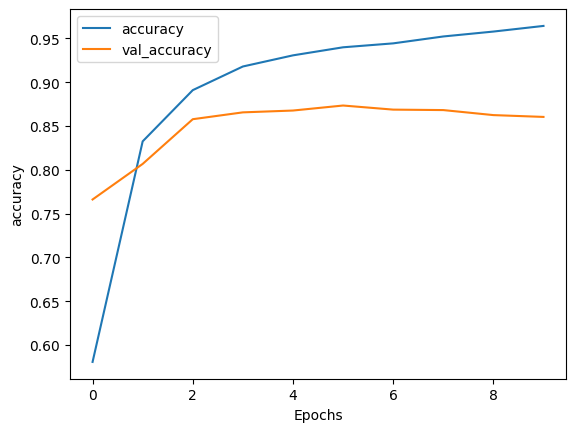

In [21]:
plot_graphs(history, 'accuracy')

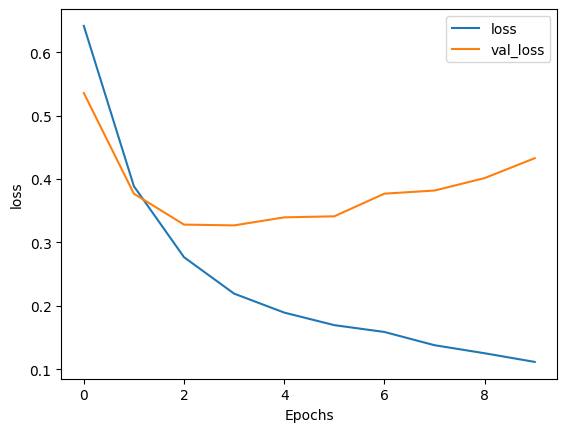

In [22]:
plot_graphs(history, 'loss')

## 두 개 이상의 LSTM 레이어 쌓기

Keras 반복 레이어에는 `return_sequences` 생성자 인수로 제어되는 두 가지 사용 가능한 모드가 있습니다.

- 각 타임스텝(형상 `(batch_size, timesteps, output_features)`의 3D 텐서)에 대한 전체 연속 출력 시퀀스를 반환합니다.
- 각 입력 시퀀스에 대한 마지막 출력만 반환합니다(형상 (batch_size, output_features)의 2D 텐서).

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [24]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [25]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10


  1/391 [..............................] - ETA: 44:40 - loss: 0.6926 - accuracy: 0.4688

  2/391 [..............................] - ETA: 1:48 - loss: 0.6934 - accuracy: 0.4141 

  3/391 [..............................] - ETA: 1:40 - loss: 0.6931 - accuracy: 0.4219

  4/391 [..............................] - ETA: 1:41 - loss: 0.6932 - accuracy: 0.4297

  5/391 [..............................] - ETA: 1:42 - loss: 0.6934 - accuracy: 0.4531

  6/391 [..............................] - ETA: 1:41 - loss: 0.6932 - accuracy: 0.4557

  7/391 [..............................] - ETA: 1:42 - loss: 0.6931 - accuracy: 0.4509

  8/391 [..............................] - ETA: 1:41 - loss: 0.6930 - accuracy: 0.4570

  9/391 [..............................] - ETA: 1:41 - loss: 0.6930 - accuracy: 0.4618

 10/391 [..............................] - ETA: 1:40 - loss: 0.6929 - accuracy: 0.4547

 11/391 [..............................] - ETA: 1:39 - loss: 0.6929 - accuracy: 0.4545

 12/391 [..............................] - ETA: 1:39 - loss: 0.6928 - accuracy: 0.4674

 13/391 [..............................] - ETA: 1:35 - loss: 0.6929 - accuracy: 0.4700

 14/391 [>.............................] - ETA: 1:36 - loss: 0.6931 - accuracy: 0.4732

 15/391 [>.............................] - ETA: 1:39 - loss: 0.6930 - accuracy: 0.4719

 16/391 [>.............................] - ETA: 1:38 - loss: 0.6929 - accuracy: 0.4678

 17/391 [>.............................] - ETA: 1:37 - loss: 0.6931 - accuracy: 0.4715

 18/391 [>.............................] - ETA: 1:36 - loss: 0.6931 - accuracy: 0.4800

 19/391 [>.............................] - ETA: 1:36 - loss: 0.6931 - accuracy: 0.4811

 20/391 [>.............................] - ETA: 1:35 - loss: 0.6932 - accuracy: 0.4852

 21/391 [>.............................] - ETA: 1:36 - loss: 0.6933 - accuracy: 0.4866

 22/391 [>.............................] - ETA: 1:42 - loss: 0.6933 - accuracy: 0.4872

 23/391 [>.............................] - ETA: 1:42 - loss: 0.6932 - accuracy: 0.4851

 24/391 [>.............................] - ETA: 1:41 - loss: 0.6933 - accuracy: 0.4857

 25/391 [>.............................] - ETA: 1:41 - loss: 0.6933 - accuracy: 0.4856

 26/391 [>.............................] - ETA: 1:41 - loss: 0.6932 - accuracy: 0.4838

 27/391 [=>............................] - ETA: 1:41 - loss: 0.6931 - accuracy: 0.4809

 28/391 [=>............................] - ETA: 1:41 - loss: 0.6931 - accuracy: 0.4771

 29/391 [=>............................] - ETA: 1:41 - loss: 0.6933 - accuracy: 0.4838

 30/391 [=>............................] - ETA: 1:40 - loss: 0.6933 - accuracy: 0.4839

 31/391 [=>............................] - ETA: 1:40 - loss: 0.6933 - accuracy: 0.4849

 32/391 [=>............................] - ETA: 1:40 - loss: 0.6933 - accuracy: 0.4893

 33/391 [=>............................] - ETA: 1:38 - loss: 0.6933 - accuracy: 0.4910

 34/391 [=>............................] - ETA: 1:38 - loss: 0.6934 - accuracy: 0.4936

 35/391 [=>............................] - ETA: 1:38 - loss: 0.6934 - accuracy: 0.4915

 36/391 [=>............................] - ETA: 1:37 - loss: 0.6934 - accuracy: 0.4918

 37/391 [=>............................] - ETA: 1:37 - loss: 0.6934 - accuracy: 0.4920

 38/391 [=>............................] - ETA: 1:37 - loss: 0.6933 - accuracy: 0.4910

 39/391 [=>............................] - ETA: 1:37 - loss: 0.6934 - accuracy: 0.4932

 40/391 [==>...........................] - ETA: 1:37 - loss: 0.6934 - accuracy: 0.4930

 41/391 [==>...........................] - ETA: 1:36 - loss: 0.6934 - accuracy: 0.4947

 42/391 [==>...........................] - ETA: 1:36 - loss: 0.6934 - accuracy: 0.4933

 43/391 [==>...........................] - ETA: 1:35 - loss: 0.6934 - accuracy: 0.4938

 44/391 [==>...........................] - ETA: 1:35 - loss: 0.6934 - accuracy: 0.4950

 45/391 [==>...........................] - ETA: 1:35 - loss: 0.6934 - accuracy: 0.4965

 46/391 [==>...........................] - ETA: 1:34 - loss: 0.6933 - accuracy: 0.4949

 47/391 [==>...........................] - ETA: 1:33 - loss: 0.6933 - accuracy: 0.4930

 48/391 [==>...........................] - ETA: 1:33 - loss: 0.6933 - accuracy: 0.4925

 49/391 [==>...........................] - ETA: 1:33 - loss: 0.6933 - accuracy: 0.4943

 50/391 [==>...........................] - ETA: 1:33 - loss: 0.6933 - accuracy: 0.4928

 51/391 [==>...........................] - ETA: 1:33 - loss: 0.6933 - accuracy: 0.4914

 52/391 [==>...........................] - ETA: 1:33 - loss: 0.6933 - accuracy: 0.4904

 53/391 [===>..........................] - ETA: 1:32 - loss: 0.6933 - accuracy: 0.4932

 54/391 [===>..........................] - ETA: 1:32 - loss: 0.6933 - accuracy: 0.4928

 55/391 [===>..........................] - ETA: 1:32 - loss: 0.6933 - accuracy: 0.4929

 56/391 [===>..........................] - ETA: 1:32 - loss: 0.6933 - accuracy: 0.4933

 57/391 [===>..........................] - ETA: 1:31 - loss: 0.6933 - accuracy: 0.4942

 58/391 [===>..........................] - ETA: 1:31 - loss: 0.6933 - accuracy: 0.4941

 59/391 [===>..........................] - ETA: 1:31 - loss: 0.6933 - accuracy: 0.4939

 60/391 [===>..........................] - ETA: 1:30 - loss: 0.6933 - accuracy: 0.4951

 61/391 [===>..........................] - ETA: 1:30 - loss: 0.6933 - accuracy: 0.4936

 62/391 [===>..........................] - ETA: 1:30 - loss: 0.6933 - accuracy: 0.4947

 63/391 [===>..........................] - ETA: 1:30 - loss: 0.6933 - accuracy: 0.4938

 64/391 [===>..........................] - ETA: 1:29 - loss: 0.6933 - accuracy: 0.4946

 65/391 [===>..........................] - ETA: 1:29 - loss: 0.6933 - accuracy: 0.4938

 66/391 [====>.........................] - ETA: 1:28 - loss: 0.6933 - accuracy: 0.4955

 67/391 [====>.........................] - ETA: 1:28 - loss: 0.6933 - accuracy: 0.4958

 68/391 [====>.........................] - ETA: 1:28 - loss: 0.6933 - accuracy: 0.4966

 69/391 [====>.........................] - ETA: 1:28 - loss: 0.6933 - accuracy: 0.4966

 70/391 [====>.........................] - ETA: 1:28 - loss: 0.6933 - accuracy: 0.4962

 71/391 [====>.........................] - ETA: 1:27 - loss: 0.6933 - accuracy: 0.4971

 72/391 [====>.........................] - ETA: 1:27 - loss: 0.6933 - accuracy: 0.4974

 73/391 [====>.........................] - ETA: 1:27 - loss: 0.6933 - accuracy: 0.4983

 74/391 [====>.........................] - ETA: 1:26 - loss: 0.6933 - accuracy: 0.4979

 75/391 [====>.........................] - ETA: 1:26 - loss: 0.6933 - accuracy: 0.5000

 76/391 [====>.........................] - ETA: 1:26 - loss: 0.6933 - accuracy: 0.5014

 77/391 [====>.........................] - ETA: 1:26 - loss: 0.6933 - accuracy: 0.5014

 78/391 [====>.........................] - ETA: 1:25 - loss: 0.6933 - accuracy: 0.5012

 79/391 [=====>........................] - ETA: 1:26 - loss: 0.6933 - accuracy: 0.5018

 80/391 [=====>........................] - ETA: 1:25 - loss: 0.6933 - accuracy: 0.5020

 81/391 [=====>........................] - ETA: 1:24 - loss: 0.6933 - accuracy: 0.5021

 82/391 [=====>........................] - ETA: 1:24 - loss: 0.6933 - accuracy: 0.5021

 83/391 [=====>........................] - ETA: 1:24 - loss: 0.6933 - accuracy: 0.5021

 84/391 [=====>........................] - ETA: 1:24 - loss: 0.6933 - accuracy: 0.5032

 85/391 [=====>........................] - ETA: 1:24 - loss: 0.6933 - accuracy: 0.5018

 86/391 [=====>........................] - ETA: 1:24 - loss: 0.6933 - accuracy: 0.5027

 87/391 [=====>........................] - ETA: 1:23 - loss: 0.6933 - accuracy: 0.5027

 88/391 [=====>........................] - ETA: 1:23 - loss: 0.6933 - accuracy: 0.5030

 89/391 [=====>........................] - ETA: 1:23 - loss: 0.6933 - accuracy: 0.5028

 90/391 [=====>........................] - ETA: 1:22 - loss: 0.6933 - accuracy: 0.5033

 91/391 [=====>........................] - ETA: 1:22 - loss: 0.6933 - accuracy: 0.5034

 92/391 [======>.......................] - ETA: 1:21 - loss: 0.6933 - accuracy: 0.5034

 93/391 [======>.......................] - ETA: 1:21 - loss: 0.6933 - accuracy: 0.5029

 94/391 [======>.......................] - ETA: 1:21 - loss: 0.6933 - accuracy: 0.5033

 95/391 [======>.......................] - ETA: 1:20 - loss: 0.6933 - accuracy: 0.5023

 96/391 [======>.......................] - ETA: 1:20 - loss: 0.6934 - accuracy: 0.5023

 97/391 [======>.......................] - ETA: 1:20 - loss: 0.6934 - accuracy: 0.5023

 98/391 [======>.......................] - ETA: 1:19 - loss: 0.6933 - accuracy: 0.5022

 99/391 [======>.......................] - ETA: 1:19 - loss: 0.6933 - accuracy: 0.5027

100/391 [======>.......................] - ETA: 1:19 - loss: 0.6933 - accuracy: 0.5017

101/391 [======>.......................] - ETA: 1:19 - loss: 0.6934 - accuracy: 0.5011

102/391 [======>.......................] - ETA: 1:18 - loss: 0.6934 - accuracy: 0.5008

103/391 [======>.......................] - ETA: 1:18 - loss: 0.6934 - accuracy: 0.5008

104/391 [======>.......................] - ETA: 1:18 - loss: 0.6934 - accuracy: 0.4998

105/391 [=======>......................] - ETA: 1:18 - loss: 0.6933 - accuracy: 0.5012

106/391 [=======>......................] - ETA: 1:17 - loss: 0.6933 - accuracy: 0.5016

107/391 [=======>......................] - ETA: 1:17 - loss: 0.6933 - accuracy: 0.5012

108/391 [=======>......................] - ETA: 1:16 - loss: 0.6933 - accuracy: 0.5019

109/391 [=======>......................] - ETA: 1:16 - loss: 0.6933 - accuracy: 0.5020

110/391 [=======>......................] - ETA: 1:16 - loss: 0.6933 - accuracy: 0.5034

111/391 [=======>......................] - ETA: 1:15 - loss: 0.6933 - accuracy: 0.5034

112/391 [=======>......................] - ETA: 1:15 - loss: 0.6933 - accuracy: 0.5029

113/391 [=======>......................] - ETA: 1:15 - loss: 0.6933 - accuracy: 0.5030

114/391 [=======>......................] - ETA: 1:14 - loss: 0.6933 - accuracy: 0.5037

115/391 [=======>......................] - ETA: 1:14 - loss: 0.6933 - accuracy: 0.5030

116/391 [=======>......................] - ETA: 1:14 - loss: 0.6933 - accuracy: 0.5032

117/391 [=======>......................] - ETA: 1:14 - loss: 0.6933 - accuracy: 0.5033

118/391 [========>.....................] - ETA: 1:13 - loss: 0.6933 - accuracy: 0.5032

119/391 [========>.....................] - ETA: 1:13 - loss: 0.6933 - accuracy: 0.5032

120/391 [========>.....................] - ETA: 1:13 - loss: 0.6933 - accuracy: 0.5031

121/391 [========>.....................] - ETA: 1:13 - loss: 0.6933 - accuracy: 0.5036

122/391 [========>.....................] - ETA: 1:12 - loss: 0.6933 - accuracy: 0.5045

123/391 [========>.....................] - ETA: 1:12 - loss: 0.6933 - accuracy: 0.5036

124/391 [========>.....................] - ETA: 1:12 - loss: 0.6933 - accuracy: 0.5037

125/391 [========>.....................] - ETA: 1:12 - loss: 0.6933 - accuracy: 0.5044

126/391 [========>.....................] - ETA: 1:11 - loss: 0.6933 - accuracy: 0.5046

127/391 [========>.....................] - ETA: 1:11 - loss: 0.6932 - accuracy: 0.5052

128/391 [========>.....................] - ETA: 1:11 - loss: 0.6932 - accuracy: 0.5052

129/391 [========>.....................] - ETA: 1:10 - loss: 0.6932 - accuracy: 0.5056

130/391 [========>.....................] - ETA: 1:10 - loss: 0.6932 - accuracy: 0.5055

131/391 [=========>....................] - ETA: 1:10 - loss: 0.6932 - accuracy: 0.5064

132/391 [=========>....................] - ETA: 1:10 - loss: 0.6932 - accuracy: 0.5069

133/391 [=========>....................] - ETA: 1:09 - loss: 0.6932 - accuracy: 0.5070

134/391 [=========>....................] - ETA: 1:09 - loss: 0.6932 - accuracy: 0.5069

135/391 [=========>....................] - ETA: 1:09 - loss: 0.6932 - accuracy: 0.5072

136/391 [=========>....................] - ETA: 1:09 - loss: 0.6932 - accuracy: 0.5072

137/391 [=========>....................] - ETA: 1:08 - loss: 0.6932 - accuracy: 0.5073

138/391 [=========>....................] - ETA: 1:08 - loss: 0.6932 - accuracy: 0.5074

139/391 [=========>....................] - ETA: 1:08 - loss: 0.6932 - accuracy: 0.5080

140/391 [=========>....................] - ETA: 1:07 - loss: 0.6931 - accuracy: 0.5081

141/391 [=========>....................] - ETA: 1:07 - loss: 0.6931 - accuracy: 0.5082

142/391 [=========>....................] - ETA: 1:07 - loss: 0.6932 - accuracy: 0.5083

143/391 [=========>....................] - ETA: 1:07 - loss: 0.6931 - accuracy: 0.5086

144/391 [==========>...................] - ETA: 1:06 - loss: 0.6931 - accuracy: 0.5088

145/391 [==========>...................] - ETA: 1:06 - loss: 0.6931 - accuracy: 0.5084

146/391 [==========>...................] - ETA: 1:06 - loss: 0.6931 - accuracy: 0.5082

147/391 [==========>...................] - ETA: 1:06 - loss: 0.6932 - accuracy: 0.5073

148/391 [==========>...................] - ETA: 1:06 - loss: 0.6932 - accuracy: 0.5068

149/391 [==========>...................] - ETA: 1:05 - loss: 0.6932 - accuracy: 0.5065

150/391 [==========>...................] - ETA: 1:05 - loss: 0.6932 - accuracy: 0.5068

151/391 [==========>...................] - ETA: 1:05 - loss: 0.6932 - accuracy: 0.5067

152/391 [==========>...................] - ETA: 1:05 - loss: 0.6932 - accuracy: 0.5065

153/391 [==========>...................] - ETA: 1:04 - loss: 0.6931 - accuracy: 0.5069

154/391 [==========>...................] - ETA: 1:04 - loss: 0.6931 - accuracy: 0.5071

155/391 [==========>...................] - ETA: 1:04 - loss: 0.6931 - accuracy: 0.5068

156/391 [==========>...................] - ETA: 1:04 - loss: 0.6931 - accuracy: 0.5067

157/391 [===========>..................] - ETA: 1:03 - loss: 0.6931 - accuracy: 0.5066

158/391 [===========>..................] - ETA: 1:03 - loss: 0.6931 - accuracy: 0.5063

159/391 [===========>..................] - ETA: 1:03 - loss: 0.6931 - accuracy: 0.5066

160/391 [===========>..................] - ETA: 1:03 - loss: 0.6931 - accuracy: 0.5072

161/391 [===========>..................] - ETA: 1:03 - loss: 0.6931 - accuracy: 0.5074

162/391 [===========>..................] - ETA: 1:02 - loss: 0.6931 - accuracy: 0.5074

163/391 [===========>..................] - ETA: 1:02 - loss: 0.6931 - accuracy: 0.5072

164/391 [===========>..................] - ETA: 1:02 - loss: 0.6931 - accuracy: 0.5074

165/391 [===========>..................] - ETA: 1:02 - loss: 0.6931 - accuracy: 0.5073

166/391 [===========>..................] - ETA: 1:01 - loss: 0.6931 - accuracy: 0.5075

167/391 [===========>..................] - ETA: 1:01 - loss: 0.6931 - accuracy: 0.5079

168/391 [===========>..................] - ETA: 1:01 - loss: 0.6931 - accuracy: 0.5074

169/391 [===========>..................] - ETA: 1:00 - loss: 0.6931 - accuracy: 0.5076

170/391 [============>.................] - ETA: 1:00 - loss: 0.6931 - accuracy: 0.5072

171/391 [============>.................] - ETA: 1:00 - loss: 0.6931 - accuracy: 0.5077

172/391 [============>.................] - ETA: 59s - loss: 0.6931 - accuracy: 0.5078 

173/391 [============>.................] - ETA: 59s - loss: 0.6931 - accuracy: 0.5073

174/391 [============>.................] - ETA: 59s - loss: 0.6931 - accuracy: 0.5072

175/391 [============>.................] - ETA: 58s - loss: 0.6931 - accuracy: 0.5074

176/391 [============>.................] - ETA: 58s - loss: 0.6931 - accuracy: 0.5075

177/391 [============>.................] - ETA: 58s - loss: 0.6931 - accuracy: 0.5073

178/391 [============>.................] - ETA: 57s - loss: 0.6931 - accuracy: 0.5070

179/391 [============>.................] - ETA: 57s - loss: 0.6931 - accuracy: 0.5073

180/391 [============>.................] - ETA: 57s - loss: 0.6931 - accuracy: 0.5072

181/391 [============>.................] - ETA: 57s - loss: 0.6931 - accuracy: 0.5074

182/391 [============>.................] - ETA: 56s - loss: 0.6931 - accuracy: 0.5076

183/391 [=============>................] - ETA: 56s - loss: 0.6931 - accuracy: 0.5076

184/391 [=============>................] - ETA: 56s - loss: 0.6931 - accuracy: 0.5074

185/391 [=============>................] - ETA: 55s - loss: 0.6931 - accuracy: 0.5070

186/391 [=============>................] - ETA: 55s - loss: 0.6931 - accuracy: 0.5066

187/391 [=============>................] - ETA: 55s - loss: 0.6931 - accuracy: 0.5070

188/391 [=============>................] - ETA: 54s - loss: 0.6931 - accuracy: 0.5071

189/391 [=============>................] - ETA: 54s - loss: 0.6931 - accuracy: 0.5069

190/391 [=============>................] - ETA: 54s - loss: 0.6931 - accuracy: 0.5072

191/391 [=============>................] - ETA: 54s - loss: 0.6931 - accuracy: 0.5070

192/391 [=============>................] - ETA: 53s - loss: 0.6931 - accuracy: 0.5070

193/391 [=============>................] - ETA: 53s - loss: 0.6931 - accuracy: 0.5070

194/391 [=============>................] - ETA: 53s - loss: 0.6931 - accuracy: 0.5071

195/391 [=============>................] - ETA: 52s - loss: 0.6931 - accuracy: 0.5065

196/391 [==============>...............] - ETA: 52s - loss: 0.6931 - accuracy: 0.5065

197/391 [==============>...............] - ETA: 52s - loss: 0.6931 - accuracy: 0.5067

198/391 [==============>...............] - ETA: 52s - loss: 0.6931 - accuracy: 0.5068

199/391 [==============>...............] - ETA: 51s - loss: 0.6931 - accuracy: 0.5065

200/391 [==============>...............] - ETA: 51s - loss: 0.6931 - accuracy: 0.5068

201/391 [==============>...............] - ETA: 51s - loss: 0.6931 - accuracy: 0.5075

202/391 [==============>...............] - ETA: 51s - loss: 0.6931 - accuracy: 0.5080

203/391 [==============>...............] - ETA: 50s - loss: 0.6931 - accuracy: 0.5080

204/391 [==============>...............] - ETA: 50s - loss: 0.6931 - accuracy: 0.5080

205/391 [==============>...............] - ETA: 50s - loss: 0.6931 - accuracy: 0.5075

206/391 [==============>...............] - ETA: 49s - loss: 0.6931 - accuracy: 0.5077

207/391 [==============>...............] - ETA: 49s - loss: 0.6931 - accuracy: 0.5075

208/391 [==============>...............] - ETA: 49s - loss: 0.6931 - accuracy: 0.5073

209/391 [===============>..............] - ETA: 49s - loss: 0.6931 - accuracy: 0.5074

210/391 [===============>..............] - ETA: 48s - loss: 0.6931 - accuracy: 0.5071

211/391 [===============>..............] - ETA: 48s - loss: 0.6931 - accuracy: 0.5065

212/391 [===============>..............] - ETA: 48s - loss: 0.6931 - accuracy: 0.5066

213/391 [===============>..............] - ETA: 48s - loss: 0.6931 - accuracy: 0.5062

214/391 [===============>..............] - ETA: 47s - loss: 0.6931 - accuracy: 0.5062

215/391 [===============>..............] - ETA: 47s - loss: 0.6931 - accuracy: 0.5065

216/391 [===============>..............] - ETA: 47s - loss: 0.6931 - accuracy: 0.5061

217/391 [===============>..............] - ETA: 46s - loss: 0.6930 - accuracy: 0.5065

218/391 [===============>..............] - ETA: 46s - loss: 0.6930 - accuracy: 0.5069

219/391 [===============>..............] - ETA: 46s - loss: 0.6930 - accuracy: 0.5070

220/391 [===============>..............] - ETA: 46s - loss: 0.6930 - accuracy: 0.5070

221/391 [===============>..............] - ETA: 45s - loss: 0.6930 - accuracy: 0.5073

222/391 [================>.............] - ETA: 45s - loss: 0.6930 - accuracy: 0.5072

223/391 [================>.............] - ETA: 45s - loss: 0.6930 - accuracy: 0.5070

224/391 [================>.............] - ETA: 45s - loss: 0.6930 - accuracy: 0.5064

225/391 [================>.............] - ETA: 44s - loss: 0.6930 - accuracy: 0.5067

226/391 [================>.............] - ETA: 44s - loss: 0.6930 - accuracy: 0.5064

227/391 [================>.............] - ETA: 44s - loss: 0.6930 - accuracy: 0.5065

228/391 [================>.............] - ETA: 44s - loss: 0.6930 - accuracy: 0.5065

229/391 [================>.............] - ETA: 43s - loss: 0.6930 - accuracy: 0.5063

230/391 [================>.............] - ETA: 43s - loss: 0.6930 - accuracy: 0.5061

231/391 [================>.............] - ETA: 43s - loss: 0.6930 - accuracy: 0.5061

232/391 [================>.............] - ETA: 42s - loss: 0.6930 - accuracy: 0.5065

233/391 [================>.............] - ETA: 42s - loss: 0.6930 - accuracy: 0.5064

234/391 [================>.............] - ETA: 42s - loss: 0.6930 - accuracy: 0.5063

235/391 [=================>............] - ETA: 42s - loss: 0.6930 - accuracy: 0.5064

236/391 [=================>............] - ETA: 41s - loss: 0.6929 - accuracy: 0.5064

237/391 [=================>............] - ETA: 41s - loss: 0.6929 - accuracy: 0.5062

238/391 [=================>............] - ETA: 41s - loss: 0.6929 - accuracy: 0.5061

239/391 [=================>............] - ETA: 41s - loss: 0.6929 - accuracy: 0.5062

240/391 [=================>............] - ETA: 40s - loss: 0.6929 - accuracy: 0.5067

241/391 [=================>............] - ETA: 40s - loss: 0.6929 - accuracy: 0.5066

242/391 [=================>............] - ETA: 40s - loss: 0.6929 - accuracy: 0.5065

243/391 [=================>............] - ETA: 39s - loss: 0.6929 - accuracy: 0.5068

244/391 [=================>............] - ETA: 39s - loss: 0.6929 - accuracy: 0.5070

245/391 [=================>............] - ETA: 39s - loss: 0.6929 - accuracy: 0.5070

246/391 [=================>............] - ETA: 38s - loss: 0.6929 - accuracy: 0.5072

247/391 [=================>............] - ETA: 38s - loss: 0.6929 - accuracy: 0.5076

248/391 [==================>...........] - ETA: 38s - loss: 0.6929 - accuracy: 0.5071

249/391 [==================>...........] - ETA: 38s - loss: 0.6929 - accuracy: 0.5066

250/391 [==================>...........] - ETA: 37s - loss: 0.6929 - accuracy: 0.5059

251/391 [==================>...........] - ETA: 37s - loss: 0.6929 - accuracy: 0.5061

252/391 [==================>...........] - ETA: 37s - loss: 0.6929 - accuracy: 0.5058

253/391 [==================>...........] - ETA: 37s - loss: 0.6928 - accuracy: 0.5057

254/391 [==================>...........] - ETA: 36s - loss: 0.6928 - accuracy: 0.5055

255/391 [==================>...........] - ETA: 36s - loss: 0.6928 - accuracy: 0.5052

256/391 [==================>...........] - ETA: 36s - loss: 0.6928 - accuracy: 0.5051

257/391 [==================>...........] - ETA: 36s - loss: 0.6928 - accuracy: 0.5049

258/391 [==================>...........] - ETA: 35s - loss: 0.6928 - accuracy: 0.5046

259/391 [==================>...........] - ETA: 35s - loss: 0.6928 - accuracy: 0.5045

260/391 [==================>...........] - ETA: 35s - loss: 0.6928 - accuracy: 0.5047

261/391 [===================>..........] - ETA: 34s - loss: 0.6928 - accuracy: 0.5044

262/391 [===================>..........] - ETA: 34s - loss: 0.6927 - accuracy: 0.5039

263/391 [===================>..........] - ETA: 34s - loss: 0.6927 - accuracy: 0.5040

264/391 [===================>..........] - ETA: 34s - loss: 0.6927 - accuracy: 0.5041

265/391 [===================>..........] - ETA: 33s - loss: 0.6927 - accuracy: 0.5040

266/391 [===================>..........] - ETA: 33s - loss: 0.6927 - accuracy: 0.5041

267/391 [===================>..........] - ETA: 33s - loss: 0.6927 - accuracy: 0.5039

268/391 [===================>..........] - ETA: 32s - loss: 0.6926 - accuracy: 0.5038

269/391 [===================>..........] - ETA: 32s - loss: 0.6926 - accuracy: 0.5035

270/391 [===================>..........] - ETA: 32s - loss: 0.6926 - accuracy: 0.5033

271/391 [===================>..........] - ETA: 32s - loss: 0.6926 - accuracy: 0.5032

272/391 [===================>..........] - ETA: 31s - loss: 0.6926 - accuracy: 0.5029

273/391 [===================>..........] - ETA: 31s - loss: 0.6926 - accuracy: 0.5030

274/391 [====================>.........] - ETA: 31s - loss: 0.6926 - accuracy: 0.5030

275/391 [====================>.........] - ETA: 30s - loss: 0.6926 - accuracy: 0.5032

276/391 [====================>.........] - ETA: 30s - loss: 0.6926 - accuracy: 0.5031

277/391 [====================>.........] - ETA: 30s - loss: 0.6925 - accuracy: 0.5033

278/391 [====================>.........] - ETA: 30s - loss: 0.6925 - accuracy: 0.5034

279/391 [====================>.........] - ETA: 29s - loss: 0.6925 - accuracy: 0.5033

280/391 [====================>.........] - ETA: 29s - loss: 0.6925 - accuracy: 0.5028

281/391 [====================>.........] - ETA: 29s - loss: 0.6925 - accuracy: 0.5029

282/391 [====================>.........] - ETA: 29s - loss: 0.6924 - accuracy: 0.5025

283/391 [====================>.........] - ETA: 28s - loss: 0.6924 - accuracy: 0.5022

284/391 [====================>.........] - ETA: 28s - loss: 0.6924 - accuracy: 0.5020

285/391 [====================>.........] - ETA: 28s - loss: 0.6924 - accuracy: 0.5022

286/391 [====================>.........] - ETA: 27s - loss: 0.6923 - accuracy: 0.5022

287/391 [=====================>........] - ETA: 27s - loss: 0.6923 - accuracy: 0.5025

288/391 [=====================>........] - ETA: 27s - loss: 0.6923 - accuracy: 0.5020

289/391 [=====================>........] - ETA: 27s - loss: 0.6922 - accuracy: 0.5019

290/391 [=====================>........] - ETA: 26s - loss: 0.6922 - accuracy: 0.5018

291/391 [=====================>........] - ETA: 26s - loss: 0.6922 - accuracy: 0.5016

292/391 [=====================>........] - ETA: 26s - loss: 0.6922 - accuracy: 0.5016

293/391 [=====================>........] - ETA: 26s - loss: 0.6922 - accuracy: 0.5022

294/391 [=====================>........] - ETA: 25s - loss: 0.6921 - accuracy: 0.5021

295/391 [=====================>........] - ETA: 25s - loss: 0.6921 - accuracy: 0.5021

296/391 [=====================>........] - ETA: 25s - loss: 0.6921 - accuracy: 0.5021

297/391 [=====================>........] - ETA: 24s - loss: 0.6921 - accuracy: 0.5022

298/391 [=====================>........] - ETA: 24s - loss: 0.6920 - accuracy: 0.5024

299/391 [=====================>........] - ETA: 24s - loss: 0.6920 - accuracy: 0.5029

300/391 [======================>.......] - ETA: 24s - loss: 0.6919 - accuracy: 0.5024

301/391 [======================>.......] - ETA: 23s - loss: 0.6919 - accuracy: 0.5023

302/391 [======================>.......] - ETA: 23s - loss: 0.6918 - accuracy: 0.5024

303/391 [======================>.......] - ETA: 23s - loss: 0.6917 - accuracy: 0.5024

304/391 [======================>.......] - ETA: 22s - loss: 0.6917 - accuracy: 0.5022

305/391 [======================>.......] - ETA: 22s - loss: 0.6916 - accuracy: 0.5022

306/391 [======================>.......] - ETA: 22s - loss: 0.6915 - accuracy: 0.5022

307/391 [======================>.......] - ETA: 22s - loss: 0.6915 - accuracy: 0.5024

308/391 [======================>.......] - ETA: 21s - loss: 0.6914 - accuracy: 0.5022

309/391 [======================>.......] - ETA: 21s - loss: 0.6912 - accuracy: 0.5022

310/391 [======================>.......] - ETA: 21s - loss: 0.6911 - accuracy: 0.5025

311/391 [======================>.......] - ETA: 21s - loss: 0.6910 - accuracy: 0.5031

312/391 [======================>.......] - ETA: 20s - loss: 0.6908 - accuracy: 0.5036

313/391 [=======================>......] - ETA: 20s - loss: 0.6908 - accuracy: 0.5039

314/391 [=======================>......] - ETA: 20s - loss: 0.6907 - accuracy: 0.5042

315/391 [=======================>......] - ETA: 20s - loss: 0.6904 - accuracy: 0.5044

316/391 [=======================>......] - ETA: 19s - loss: 0.6902 - accuracy: 0.5046

317/391 [=======================>......] - ETA: 19s - loss: 0.6900 - accuracy: 0.5047

318/391 [=======================>......] - ETA: 19s - loss: 0.6899 - accuracy: 0.5048

319/391 [=======================>......] - ETA: 18s - loss: 0.6897 - accuracy: 0.5052

320/391 [=======================>......] - ETA: 18s - loss: 0.6895 - accuracy: 0.5058

321/391 [=======================>......] - ETA: 18s - loss: 0.6893 - accuracy: 0.5062

322/391 [=======================>......] - ETA: 18s - loss: 0.6889 - accuracy: 0.5070

323/391 [=======================>......] - ETA: 17s - loss: 0.6885 - accuracy: 0.5078

324/391 [=======================>......] - ETA: 17s - loss: 0.6882 - accuracy: 0.5087

325/391 [=======================>......] - ETA: 17s - loss: 0.6878 - accuracy: 0.5095

326/391 [========================>.....] - ETA: 17s - loss: 0.6874 - accuracy: 0.5100

327/391 [========================>.....] - ETA: 16s - loss: 0.6870 - accuracy: 0.5106

328/391 [========================>.....] - ETA: 16s - loss: 0.6867 - accuracy: 0.5110

329/391 [========================>.....] - ETA: 16s - loss: 0.6868 - accuracy: 0.5113

330/391 [========================>.....] - ETA: 16s - loss: 0.6865 - accuracy: 0.5118

331/391 [========================>.....] - ETA: 15s - loss: 0.6863 - accuracy: 0.5121

332/391 [========================>.....] - ETA: 15s - loss: 0.6859 - accuracy: 0.5128

333/391 [========================>.....] - ETA: 15s - loss: 0.6855 - accuracy: 0.5134

334/391 [========================>.....] - ETA: 14s - loss: 0.6853 - accuracy: 0.5138

335/391 [========================>.....] - ETA: 14s - loss: 0.6849 - accuracy: 0.5143

336/391 [========================>.....] - ETA: 14s - loss: 0.6846 - accuracy: 0.5147

337/391 [========================>.....] - ETA: 14s - loss: 0.6842 - accuracy: 0.5154

338/391 [========================>.....] - ETA: 13s - loss: 0.6838 - accuracy: 0.5160

339/391 [=========================>....] - ETA: 13s - loss: 0.6835 - accuracy: 0.5165

340/391 [=========================>....] - ETA: 13s - loss: 0.6832 - accuracy: 0.5171

341/391 [=========================>....] - ETA: 13s - loss: 0.6827 - accuracy: 0.5179

342/391 [=========================>....] - ETA: 12s - loss: 0.6825 - accuracy: 0.5184

343/391 [=========================>....] - ETA: 12s - loss: 0.6819 - accuracy: 0.5191

344/391 [=========================>....] - ETA: 12s - loss: 0.6817 - accuracy: 0.5198

345/391 [=========================>....] - ETA: 12s - loss: 0.6812 - accuracy: 0.5206

346/391 [=========================>....] - ETA: 11s - loss: 0.6808 - accuracy: 0.5213

347/391 [=========================>....] - ETA: 11s - loss: 0.6803 - accuracy: 0.5220

348/391 [=========================>....] - ETA: 11s - loss: 0.6800 - accuracy: 0.5224

349/391 [=========================>....] - ETA: 11s - loss: 0.6795 - accuracy: 0.5231

350/391 [=========================>....] - ETA: 10s - loss: 0.6790 - accuracy: 0.5237

351/391 [=========================>....] - ETA: 10s - loss: 0.6784 - accuracy: 0.5243

352/391 [==========================>...] - ETA: 10s - loss: 0.6781 - accuracy: 0.5248

353/391 [==========================>...] - ETA: 9s - loss: 0.6781 - accuracy: 0.5250 

354/391 [==========================>...] - ETA: 9s - loss: 0.6777 - accuracy: 0.5253

355/391 [==========================>...] - ETA: 9s - loss: 0.6776 - accuracy: 0.5257

356/391 [==========================>...] - ETA: 9s - loss: 0.6774 - accuracy: 0.5261

357/391 [==========================>...] - ETA: 8s - loss: 0.6769 - accuracy: 0.5268

358/391 [==========================>...] - ETA: 8s - loss: 0.6767 - accuracy: 0.5273

359/391 [==========================>...] - ETA: 8s - loss: 0.6761 - accuracy: 0.5282

360/391 [==========================>...] - ETA: 8s - loss: 0.6757 - accuracy: 0.5289

361/391 [==========================>...] - ETA: 7s - loss: 0.6755 - accuracy: 0.5296

362/391 [==========================>...] - ETA: 7s - loss: 0.6753 - accuracy: 0.5300

363/391 [==========================>...] - ETA: 7s - loss: 0.6751 - accuracy: 0.5306

364/391 [==========================>...] - ETA: 7s - loss: 0.6746 - accuracy: 0.5312

365/391 [===========================>..] - ETA: 6s - loss: 0.6744 - accuracy: 0.5315

366/391 [===========================>..] - ETA: 6s - loss: 0.6741 - accuracy: 0.5321

367/391 [===========================>..] - ETA: 6s - loss: 0.6740 - accuracy: 0.5324

368/391 [===========================>..] - ETA: 6s - loss: 0.6735 - accuracy: 0.5329

369/391 [===========================>..] - ETA: 5s - loss: 0.6729 - accuracy: 0.5336

370/391 [===========================>..] - ETA: 5s - loss: 0.6726 - accuracy: 0.5340

371/391 [===========================>..] - ETA: 5s - loss: 0.6722 - accuracy: 0.5345

372/391 [===========================>..] - ETA: 4s - loss: 0.6717 - accuracy: 0.5354

373/391 [===========================>..] - ETA: 4s - loss: 0.6712 - accuracy: 0.5359

374/391 [===========================>..] - ETA: 4s - loss: 0.6709 - accuracy: 0.5366

375/391 [===========================>..] - ETA: 4s - loss: 0.6703 - accuracy: 0.5375

376/391 [===========================>..] - ETA: 3s - loss: 0.6704 - accuracy: 0.5379

377/391 [===========================>..] - ETA: 3s - loss: 0.6699 - accuracy: 0.5387

378/391 [============================>.] - ETA: 3s - loss: 0.6693 - accuracy: 0.5394

379/391 [============================>.] - ETA: 3s - loss: 0.6688 - accuracy: 0.5399

380/391 [============================>.] - ETA: 2s - loss: 0.6684 - accuracy: 0.5404

381/391 [============================>.] - ETA: 2s - loss: 0.6679 - accuracy: 0.5410

382/391 [============================>.] - ETA: 2s - loss: 0.6676 - accuracy: 0.5413

383/391 [============================>.] - ETA: 2s - loss: 0.6671 - accuracy: 0.5417

384/391 [============================>.] - ETA: 1s - loss: 0.6669 - accuracy: 0.5422

385/391 [============================>.] - ETA: 1s - loss: 0.6666 - accuracy: 0.5427

386/391 [============================>.] - ETA: 1s - loss: 0.6661 - accuracy: 0.5433

387/391 [============================>.] - ETA: 1s - loss: 0.6656 - accuracy: 0.5439

388/391 [============================>.] - ETA: 0s - loss: 0.6651 - accuracy: 0.5448

389/391 [============================>.] - ETA: 0s - loss: 0.6649 - accuracy: 0.5452

390/391 [============================>.] - ETA: 0s - loss: 0.6647 - accuracy: 0.5456

391/391 [==============================] - ETA: 0s - loss: 0.6645 - accuracy: 0.5459

391/391 [==============================] - 113s 271ms/step - loss: 0.6645 - accuracy: 0.5459 - val_loss: 0.5003 - val_accuracy: 0.7620


Epoch 2/10


  1/391 [..............................] - ETA: 4:17 - loss: 0.5329 - accuracy: 0.7344

  2/391 [..............................] - ETA: 55s - loss: 0.5966 - accuracy: 0.6875 

  3/391 [..............................] - ETA: 1:08 - loss: 0.6006 - accuracy: 0.6823

  4/391 [..............................] - ETA: 1:15 - loss: 0.5790 - accuracy: 0.6992

  5/391 [..............................] - ETA: 1:07 - loss: 0.5554 - accuracy: 0.7125

  6/391 [..............................] - ETA: 1:16 - loss: 0.5357 - accuracy: 0.7318

  7/391 [..............................] - ETA: 1:17 - loss: 0.5188 - accuracy: 0.7388

  8/391 [..............................] - ETA: 1:20 - loss: 0.5149 - accuracy: 0.7363

  9/391 [..............................] - ETA: 1:20 - loss: 0.5033 - accuracy: 0.7500

 10/391 [..............................] - ETA: 1:19 - loss: 0.4985 - accuracy: 0.7531

 11/391 [..............................] - ETA: 1:18 - loss: 0.4915 - accuracy: 0.7614

 12/391 [..............................] - ETA: 1:17 - loss: 0.4850 - accuracy: 0.7695

 13/391 [..............................] - ETA: 1:17 - loss: 0.4883 - accuracy: 0.7716

 14/391 [>.............................] - ETA: 1:19 - loss: 0.4819 - accuracy: 0.7757

 15/391 [>.............................] - ETA: 1:21 - loss: 0.4758 - accuracy: 0.7823

 16/391 [>.............................] - ETA: 1:20 - loss: 0.4785 - accuracy: 0.7812

 17/391 [>.............................] - ETA: 1:21 - loss: 0.4804 - accuracy: 0.7803

 18/391 [>.............................] - ETA: 1:22 - loss: 0.4845 - accuracy: 0.7786

 19/391 [>.............................] - ETA: 1:21 - loss: 0.4831 - accuracy: 0.7829

 20/391 [>.............................] - ETA: 1:22 - loss: 0.4811 - accuracy: 0.7844

 21/391 [>.............................] - ETA: 1:22 - loss: 0.4781 - accuracy: 0.7887

 22/391 [>.............................] - ETA: 1:24 - loss: 0.4830 - accuracy: 0.7855

 23/391 [>.............................] - ETA: 1:25 - loss: 0.4874 - accuracy: 0.7826

 24/391 [>.............................] - ETA: 1:25 - loss: 0.4909 - accuracy: 0.7819

 25/391 [>.............................] - ETA: 1:25 - loss: 0.4916 - accuracy: 0.7819

 26/391 [>.............................] - ETA: 1:25 - loss: 0.4907 - accuracy: 0.7831

 27/391 [=>............................] - ETA: 1:26 - loss: 0.4892 - accuracy: 0.7847

 28/391 [=>............................] - ETA: 1:26 - loss: 0.4906 - accuracy: 0.7829

 29/391 [=>............................] - ETA: 1:27 - loss: 0.4901 - accuracy: 0.7834

 30/391 [=>............................] - ETA: 1:28 - loss: 0.4896 - accuracy: 0.7818

 31/391 [=>............................] - ETA: 1:28 - loss: 0.4895 - accuracy: 0.7823

 32/391 [=>............................] - ETA: 1:28 - loss: 0.4886 - accuracy: 0.7817

 33/391 [=>............................] - ETA: 1:28 - loss: 0.4865 - accuracy: 0.7841

 34/391 [=>............................] - ETA: 1:28 - loss: 0.4852 - accuracy: 0.7858

 35/391 [=>............................] - ETA: 1:28 - loss: 0.4859 - accuracy: 0.7862

 36/391 [=>............................] - ETA: 1:29 - loss: 0.4865 - accuracy: 0.7856

 37/391 [=>............................] - ETA: 1:28 - loss: 0.4861 - accuracy: 0.7872

 38/391 [=>............................] - ETA: 1:29 - loss: 0.4876 - accuracy: 0.7866

 39/391 [=>............................] - ETA: 1:28 - loss: 0.4855 - accuracy: 0.7877

 40/391 [==>...........................] - ETA: 1:27 - loss: 0.4855 - accuracy: 0.7875

 41/391 [==>...........................] - ETA: 1:27 - loss: 0.4846 - accuracy: 0.7881

 42/391 [==>...........................] - ETA: 1:26 - loss: 0.4825 - accuracy: 0.7906

 43/391 [==>...........................] - ETA: 1:25 - loss: 0.4818 - accuracy: 0.7896

 44/391 [==>...........................] - ETA: 1:25 - loss: 0.4802 - accuracy: 0.7894

 45/391 [==>...........................] - ETA: 1:25 - loss: 0.4797 - accuracy: 0.7903

 46/391 [==>...........................] - ETA: 1:25 - loss: 0.4809 - accuracy: 0.7897

 47/391 [==>...........................] - ETA: 1:24 - loss: 0.4803 - accuracy: 0.7902

 48/391 [==>...........................] - ETA: 1:24 - loss: 0.4801 - accuracy: 0.7907

 49/391 [==>...........................] - ETA: 1:24 - loss: 0.4823 - accuracy: 0.7895

 50/391 [==>...........................] - ETA: 1:24 - loss: 0.4814 - accuracy: 0.7903

 51/391 [==>...........................] - ETA: 1:24 - loss: 0.4826 - accuracy: 0.7901

 52/391 [==>...........................] - ETA: 1:23 - loss: 0.4816 - accuracy: 0.7897

 53/391 [===>..........................] - ETA: 1:22 - loss: 0.4800 - accuracy: 0.7916

 54/391 [===>..........................] - ETA: 1:22 - loss: 0.4805 - accuracy: 0.7908

 55/391 [===>..........................] - ETA: 1:23 - loss: 0.4837 - accuracy: 0.7886

 56/391 [===>..........................] - ETA: 1:23 - loss: 0.4845 - accuracy: 0.7879

 57/391 [===>..........................] - ETA: 1:23 - loss: 0.4826 - accuracy: 0.7881

 58/391 [===>..........................] - ETA: 1:23 - loss: 0.4831 - accuracy: 0.7880

 59/391 [===>..........................] - ETA: 1:23 - loss: 0.4825 - accuracy: 0.7884

 60/391 [===>..........................] - ETA: 1:23 - loss: 0.4831 - accuracy: 0.7875

 61/391 [===>..........................] - ETA: 1:23 - loss: 0.4824 - accuracy: 0.7877

 62/391 [===>..........................] - ETA: 1:22 - loss: 0.4802 - accuracy: 0.7893

 63/391 [===>..........................] - ETA: 1:22 - loss: 0.4820 - accuracy: 0.7882

 64/391 [===>..........................] - ETA: 1:22 - loss: 0.4813 - accuracy: 0.7883

 65/391 [===>..........................] - ETA: 1:22 - loss: 0.4806 - accuracy: 0.7887

 66/391 [====>.........................] - ETA: 1:21 - loss: 0.4801 - accuracy: 0.7891

 67/391 [====>.........................] - ETA: 1:20 - loss: 0.4796 - accuracy: 0.7894

 68/391 [====>.........................] - ETA: 1:20 - loss: 0.4809 - accuracy: 0.7886

 69/391 [====>.........................] - ETA: 1:20 - loss: 0.4793 - accuracy: 0.7899

 70/391 [====>.........................] - ETA: 1:20 - loss: 0.4784 - accuracy: 0.7908

 71/391 [====>.........................] - ETA: 1:20 - loss: 0.4774 - accuracy: 0.7916

 72/391 [====>.........................] - ETA: 1:20 - loss: 0.4776 - accuracy: 0.7914

 73/391 [====>.........................] - ETA: 1:19 - loss: 0.4764 - accuracy: 0.7926

 74/391 [====>.........................] - ETA: 1:19 - loss: 0.4769 - accuracy: 0.7924

 75/391 [====>.........................] - ETA: 1:18 - loss: 0.4772 - accuracy: 0.7927

 76/391 [====>.........................] - ETA: 1:18 - loss: 0.4771 - accuracy: 0.7928

 77/391 [====>.........................] - ETA: 1:18 - loss: 0.4767 - accuracy: 0.7934

 78/391 [====>.........................] - ETA: 1:18 - loss: 0.4753 - accuracy: 0.7945

 79/391 [=====>........................] - ETA: 1:17 - loss: 0.4738 - accuracy: 0.7949

 80/391 [=====>........................] - ETA: 1:17 - loss: 0.4759 - accuracy: 0.7930

 81/391 [=====>........................] - ETA: 1:16 - loss: 0.4761 - accuracy: 0.7926

 82/391 [=====>........................] - ETA: 1:16 - loss: 0.4778 - accuracy: 0.7912

 83/391 [=====>........................] - ETA: 1:15 - loss: 0.4781 - accuracy: 0.7909

 84/391 [=====>........................] - ETA: 1:15 - loss: 0.4757 - accuracy: 0.7928

 85/391 [=====>........................] - ETA: 1:14 - loss: 0.4753 - accuracy: 0.7932

 86/391 [=====>........................] - ETA: 1:14 - loss: 0.4737 - accuracy: 0.7945

 87/391 [=====>........................] - ETA: 1:14 - loss: 0.4737 - accuracy: 0.7942

 88/391 [=====>........................] - ETA: 1:13 - loss: 0.4728 - accuracy: 0.7949

 89/391 [=====>........................] - ETA: 1:13 - loss: 0.4717 - accuracy: 0.7956

 90/391 [=====>........................] - ETA: 1:13 - loss: 0.4715 - accuracy: 0.7964

 91/391 [=====>........................] - ETA: 1:13 - loss: 0.4729 - accuracy: 0.7953

 92/391 [======>.......................] - ETA: 1:13 - loss: 0.4725 - accuracy: 0.7955

 93/391 [======>.......................] - ETA: 1:13 - loss: 0.4710 - accuracy: 0.7964

 94/391 [======>.......................] - ETA: 1:12 - loss: 0.4705 - accuracy: 0.7965

 95/391 [======>.......................] - ETA: 1:12 - loss: 0.4694 - accuracy: 0.7974

 96/391 [======>.......................] - ETA: 1:12 - loss: 0.4684 - accuracy: 0.7977

 97/391 [======>.......................] - ETA: 1:12 - loss: 0.4671 - accuracy: 0.7986

 98/391 [======>.......................] - ETA: 1:12 - loss: 0.4672 - accuracy: 0.7986

 99/391 [======>.......................] - ETA: 1:11 - loss: 0.4671 - accuracy: 0.7985

100/391 [======>.......................] - ETA: 1:11 - loss: 0.4662 - accuracy: 0.7994

101/391 [======>.......................] - ETA: 1:11 - loss: 0.4657 - accuracy: 0.7998

102/391 [======>.......................] - ETA: 1:11 - loss: 0.4648 - accuracy: 0.8002

103/391 [======>.......................] - ETA: 1:11 - loss: 0.4644 - accuracy: 0.8005

104/391 [======>.......................] - ETA: 1:10 - loss: 0.4647 - accuracy: 0.8003

105/391 [=======>......................] - ETA: 1:10 - loss: 0.4649 - accuracy: 0.8003

106/391 [=======>......................] - ETA: 1:10 - loss: 0.4651 - accuracy: 0.8000

107/391 [=======>......................] - ETA: 1:10 - loss: 0.4653 - accuracy: 0.7992

108/391 [=======>......................] - ETA: 1:10 - loss: 0.4651 - accuracy: 0.7992

109/391 [=======>......................] - ETA: 1:09 - loss: 0.4642 - accuracy: 0.7997

110/391 [=======>......................] - ETA: 1:09 - loss: 0.4635 - accuracy: 0.8001

111/391 [=======>......................] - ETA: 1:09 - loss: 0.4628 - accuracy: 0.8007

112/391 [=======>......................] - ETA: 1:08 - loss: 0.4630 - accuracy: 0.8006

113/391 [=======>......................] - ETA: 1:08 - loss: 0.4631 - accuracy: 0.8006

114/391 [=======>......................] - ETA: 1:07 - loss: 0.4626 - accuracy: 0.8007

115/391 [=======>......................] - ETA: 1:07 - loss: 0.4624 - accuracy: 0.8010

116/391 [=======>......................] - ETA: 1:07 - loss: 0.4613 - accuracy: 0.8020

117/391 [=======>......................] - ETA: 1:06 - loss: 0.4614 - accuracy: 0.8024

118/391 [========>.....................] - ETA: 1:06 - loss: 0.4606 - accuracy: 0.8031

119/391 [========>.....................] - ETA: 1:06 - loss: 0.4598 - accuracy: 0.8037

120/391 [========>.....................] - ETA: 1:06 - loss: 0.4588 - accuracy: 0.8043

121/391 [========>.....................] - ETA: 1:05 - loss: 0.4581 - accuracy: 0.8051

122/391 [========>.....................] - ETA: 1:05 - loss: 0.4591 - accuracy: 0.8048

123/391 [========>.....................] - ETA: 1:05 - loss: 0.4591 - accuracy: 0.8048

124/391 [========>.....................] - ETA: 1:05 - loss: 0.4600 - accuracy: 0.8043

125/391 [========>.....................] - ETA: 1:04 - loss: 0.4588 - accuracy: 0.8048

126/391 [========>.....................] - ETA: 1:04 - loss: 0.4586 - accuracy: 0.8047

127/391 [========>.....................] - ETA: 1:04 - loss: 0.4579 - accuracy: 0.8049

128/391 [========>.....................] - ETA: 1:03 - loss: 0.4578 - accuracy: 0.8047

129/391 [========>.....................] - ETA: 1:03 - loss: 0.4577 - accuracy: 0.8046

130/391 [========>.....................] - ETA: 1:03 - loss: 0.4571 - accuracy: 0.8049

131/391 [=========>....................] - ETA: 1:03 - loss: 0.4574 - accuracy: 0.8046

132/391 [=========>....................] - ETA: 1:02 - loss: 0.4573 - accuracy: 0.8048

133/391 [=========>....................] - ETA: 1:02 - loss: 0.4570 - accuracy: 0.8050

134/391 [=========>....................] - ETA: 1:02 - loss: 0.4568 - accuracy: 0.8050

135/391 [=========>....................] - ETA: 1:02 - loss: 0.4570 - accuracy: 0.8046

136/391 [=========>....................] - ETA: 1:01 - loss: 0.4569 - accuracy: 0.8046

137/391 [=========>....................] - ETA: 1:01 - loss: 0.4563 - accuracy: 0.8051

138/391 [=========>....................] - ETA: 1:01 - loss: 0.4563 - accuracy: 0.8053

139/391 [=========>....................] - ETA: 1:01 - loss: 0.4558 - accuracy: 0.8055

140/391 [=========>....................] - ETA: 1:00 - loss: 0.4562 - accuracy: 0.8054

141/391 [=========>....................] - ETA: 1:01 - loss: 0.4561 - accuracy: 0.8056

142/391 [=========>....................] - ETA: 1:00 - loss: 0.4555 - accuracy: 0.8059

143/391 [=========>....................] - ETA: 1:00 - loss: 0.4549 - accuracy: 0.8063

144/391 [==========>...................] - ETA: 1:00 - loss: 0.4546 - accuracy: 0.8067

145/391 [==========>...................] - ETA: 1:00 - loss: 0.4540 - accuracy: 0.8071

146/391 [==========>...................] - ETA: 1:00 - loss: 0.4537 - accuracy: 0.8070

147/391 [==========>...................] - ETA: 59s - loss: 0.4534 - accuracy: 0.8070 

148/391 [==========>...................] - ETA: 59s - loss: 0.4524 - accuracy: 0.8075

149/391 [==========>...................] - ETA: 59s - loss: 0.4512 - accuracy: 0.8082

150/391 [==========>...................] - ETA: 58s - loss: 0.4502 - accuracy: 0.8087

151/391 [==========>...................] - ETA: 58s - loss: 0.4496 - accuracy: 0.8091

152/391 [==========>...................] - ETA: 58s - loss: 0.4489 - accuracy: 0.8094

153/391 [==========>...................] - ETA: 58s - loss: 0.4487 - accuracy: 0.8096

154/391 [==========>...................] - ETA: 57s - loss: 0.4479 - accuracy: 0.8102

155/391 [==========>...................] - ETA: 57s - loss: 0.4471 - accuracy: 0.8104

156/391 [==========>...................] - ETA: 57s - loss: 0.4473 - accuracy: 0.8104

157/391 [===========>..................] - ETA: 56s - loss: 0.4472 - accuracy: 0.8104

158/391 [===========>..................] - ETA: 56s - loss: 0.4459 - accuracy: 0.8110

159/391 [===========>..................] - ETA: 56s - loss: 0.4451 - accuracy: 0.8115

160/391 [===========>..................] - ETA: 56s - loss: 0.4447 - accuracy: 0.8120

161/391 [===========>..................] - ETA: 55s - loss: 0.4447 - accuracy: 0.8119

162/391 [===========>..................] - ETA: 55s - loss: 0.4446 - accuracy: 0.8121

163/391 [===========>..................] - ETA: 55s - loss: 0.4434 - accuracy: 0.8128

164/391 [===========>..................] - ETA: 55s - loss: 0.4430 - accuracy: 0.8128

165/391 [===========>..................] - ETA: 54s - loss: 0.4432 - accuracy: 0.8126

166/391 [===========>..................] - ETA: 54s - loss: 0.4425 - accuracy: 0.8129

167/391 [===========>..................] - ETA: 54s - loss: 0.4428 - accuracy: 0.8129

168/391 [===========>..................] - ETA: 53s - loss: 0.4418 - accuracy: 0.8133

169/391 [===========>..................] - ETA: 53s - loss: 0.4414 - accuracy: 0.8131

170/391 [============>.................] - ETA: 53s - loss: 0.4411 - accuracy: 0.8134

171/391 [============>.................] - ETA: 53s - loss: 0.4412 - accuracy: 0.8133

172/391 [============>.................] - ETA: 52s - loss: 0.4404 - accuracy: 0.8139

173/391 [============>.................] - ETA: 52s - loss: 0.4397 - accuracy: 0.8142

174/391 [============>.................] - ETA: 52s - loss: 0.4400 - accuracy: 0.8141

175/391 [============>.................] - ETA: 52s - loss: 0.4403 - accuracy: 0.8141

176/391 [============>.................] - ETA: 51s - loss: 0.4405 - accuracy: 0.8138

177/391 [============>.................] - ETA: 51s - loss: 0.4410 - accuracy: 0.8135

178/391 [============>.................] - ETA: 51s - loss: 0.4402 - accuracy: 0.8141

179/391 [============>.................] - ETA: 50s - loss: 0.4400 - accuracy: 0.8143

180/391 [============>.................] - ETA: 50s - loss: 0.4391 - accuracy: 0.8148

181/391 [============>.................] - ETA: 50s - loss: 0.4388 - accuracy: 0.8147

182/391 [============>.................] - ETA: 50s - loss: 0.4384 - accuracy: 0.8147

183/391 [=============>................] - ETA: 50s - loss: 0.4375 - accuracy: 0.8152

184/391 [=============>................] - ETA: 49s - loss: 0.4371 - accuracy: 0.8155

185/391 [=============>................] - ETA: 49s - loss: 0.4370 - accuracy: 0.8155

186/391 [=============>................] - ETA: 49s - loss: 0.4367 - accuracy: 0.8158

187/391 [=============>................] - ETA: 49s - loss: 0.4364 - accuracy: 0.8158

188/391 [=============>................] - ETA: 48s - loss: 0.4361 - accuracy: 0.8162

189/391 [=============>................] - ETA: 48s - loss: 0.4352 - accuracy: 0.8167

190/391 [=============>................] - ETA: 48s - loss: 0.4349 - accuracy: 0.8169

191/391 [=============>................] - ETA: 48s - loss: 0.4345 - accuracy: 0.8170

192/391 [=============>................] - ETA: 47s - loss: 0.4342 - accuracy: 0.8171

193/391 [=============>................] - ETA: 47s - loss: 0.4344 - accuracy: 0.8172

194/391 [=============>................] - ETA: 47s - loss: 0.4340 - accuracy: 0.8173

195/391 [=============>................] - ETA: 47s - loss: 0.4334 - accuracy: 0.8178

196/391 [==============>...............] - ETA: 47s - loss: 0.4329 - accuracy: 0.8181

197/391 [==============>...............] - ETA: 47s - loss: 0.4331 - accuracy: 0.8179

198/391 [==============>...............] - ETA: 46s - loss: 0.4330 - accuracy: 0.8179

199/391 [==============>...............] - ETA: 46s - loss: 0.4327 - accuracy: 0.8182

200/391 [==============>...............] - ETA: 46s - loss: 0.4323 - accuracy: 0.8185

201/391 [==============>...............] - ETA: 46s - loss: 0.4326 - accuracy: 0.8182

202/391 [==============>...............] - ETA: 45s - loss: 0.4325 - accuracy: 0.8183

203/391 [==============>...............] - ETA: 45s - loss: 0.4326 - accuracy: 0.8183

204/391 [==============>...............] - ETA: 45s - loss: 0.4329 - accuracy: 0.8183

205/391 [==============>...............] - ETA: 44s - loss: 0.4327 - accuracy: 0.8184

206/391 [==============>...............] - ETA: 44s - loss: 0.4323 - accuracy: 0.8187

207/391 [==============>...............] - ETA: 44s - loss: 0.4320 - accuracy: 0.8188

208/391 [==============>...............] - ETA: 44s - loss: 0.4320 - accuracy: 0.8187

209/391 [===============>..............] - ETA: 43s - loss: 0.4319 - accuracy: 0.8186

210/391 [===============>..............] - ETA: 43s - loss: 0.4317 - accuracy: 0.8187

211/391 [===============>..............] - ETA: 43s - loss: 0.4318 - accuracy: 0.8185

212/391 [===============>..............] - ETA: 43s - loss: 0.4318 - accuracy: 0.8185

213/391 [===============>..............] - ETA: 43s - loss: 0.4322 - accuracy: 0.8183

214/391 [===============>..............] - ETA: 42s - loss: 0.4322 - accuracy: 0.8185

215/391 [===============>..............] - ETA: 42s - loss: 0.4321 - accuracy: 0.8186

216/391 [===============>..............] - ETA: 42s - loss: 0.4317 - accuracy: 0.8189

217/391 [===============>..............] - ETA: 42s - loss: 0.4308 - accuracy: 0.8194

218/391 [===============>..............] - ETA: 42s - loss: 0.4305 - accuracy: 0.8198

219/391 [===============>..............] - ETA: 41s - loss: 0.4313 - accuracy: 0.8192

220/391 [===============>..............] - ETA: 41s - loss: 0.4321 - accuracy: 0.8189

221/391 [===============>..............] - ETA: 41s - loss: 0.4328 - accuracy: 0.8182

222/391 [================>.............] - ETA: 41s - loss: 0.4329 - accuracy: 0.8179

223/391 [================>.............] - ETA: 40s - loss: 0.4338 - accuracy: 0.8173

224/391 [================>.............] - ETA: 40s - loss: 0.4342 - accuracy: 0.8168

225/391 [================>.............] - ETA: 40s - loss: 0.4344 - accuracy: 0.8165

226/391 [================>.............] - ETA: 40s - loss: 0.4343 - accuracy: 0.8164

227/391 [================>.............] - ETA: 39s - loss: 0.4345 - accuracy: 0.8160

228/391 [================>.............] - ETA: 39s - loss: 0.4347 - accuracy: 0.8159

229/391 [================>.............] - ETA: 39s - loss: 0.4344 - accuracy: 0.8160

230/391 [================>.............] - ETA: 39s - loss: 0.4343 - accuracy: 0.8160

231/391 [================>.............] - ETA: 38s - loss: 0.4343 - accuracy: 0.8162

232/391 [================>.............] - ETA: 38s - loss: 0.4345 - accuracy: 0.8159

233/391 [================>.............] - ETA: 38s - loss: 0.4345 - accuracy: 0.8160

234/391 [================>.............] - ETA: 38s - loss: 0.4346 - accuracy: 0.8161

235/391 [=================>............] - ETA: 37s - loss: 0.4349 - accuracy: 0.8162

236/391 [=================>............] - ETA: 37s - loss: 0.4348 - accuracy: 0.8164

237/391 [=================>............] - ETA: 37s - loss: 0.4355 - accuracy: 0.8159

238/391 [=================>............] - ETA: 37s - loss: 0.4357 - accuracy: 0.8159

239/391 [=================>............] - ETA: 36s - loss: 0.4355 - accuracy: 0.8162

240/391 [=================>............] - ETA: 36s - loss: 0.4355 - accuracy: 0.8163

241/391 [=================>............] - ETA: 36s - loss: 0.4356 - accuracy: 0.8161

242/391 [=================>............] - ETA: 36s - loss: 0.4358 - accuracy: 0.8160

243/391 [=================>............] - ETA: 35s - loss: 0.4359 - accuracy: 0.8159

244/391 [=================>............] - ETA: 35s - loss: 0.4360 - accuracy: 0.8159

245/391 [=================>............] - ETA: 35s - loss: 0.4359 - accuracy: 0.8158

246/391 [=================>............] - ETA: 35s - loss: 0.4360 - accuracy: 0.8157

247/391 [=================>............] - ETA: 34s - loss: 0.4361 - accuracy: 0.8157

248/391 [==================>...........] - ETA: 34s - loss: 0.4363 - accuracy: 0.8153

249/391 [==================>...........] - ETA: 34s - loss: 0.4361 - accuracy: 0.8154

250/391 [==================>...........] - ETA: 34s - loss: 0.4363 - accuracy: 0.8151

251/391 [==================>...........] - ETA: 33s - loss: 0.4368 - accuracy: 0.8147

252/391 [==================>...........] - ETA: 33s - loss: 0.4367 - accuracy: 0.8147

253/391 [==================>...........] - ETA: 33s - loss: 0.4367 - accuracy: 0.8148

254/391 [==================>...........] - ETA: 33s - loss: 0.4368 - accuracy: 0.8148

255/391 [==================>...........] - ETA: 32s - loss: 0.4370 - accuracy: 0.8145

256/391 [==================>...........] - ETA: 32s - loss: 0.4368 - accuracy: 0.8146

257/391 [==================>...........] - ETA: 32s - loss: 0.4364 - accuracy: 0.8151

258/391 [==================>...........] - ETA: 32s - loss: 0.4363 - accuracy: 0.8153

259/391 [==================>...........] - ETA: 32s - loss: 0.4364 - accuracy: 0.8152

260/391 [==================>...........] - ETA: 31s - loss: 0.4359 - accuracy: 0.8157

261/391 [===================>..........] - ETA: 31s - loss: 0.4365 - accuracy: 0.8156

262/391 [===================>..........] - ETA: 31s - loss: 0.4367 - accuracy: 0.8156

263/391 [===================>..........] - ETA: 31s - loss: 0.4363 - accuracy: 0.8158

264/391 [===================>..........] - ETA: 30s - loss: 0.4361 - accuracy: 0.8159

265/391 [===================>..........] - ETA: 30s - loss: 0.4356 - accuracy: 0.8162

266/391 [===================>..........] - ETA: 30s - loss: 0.4358 - accuracy: 0.8161

267/391 [===================>..........] - ETA: 29s - loss: 0.4353 - accuracy: 0.8165

268/391 [===================>..........] - ETA: 29s - loss: 0.4356 - accuracy: 0.8163

269/391 [===================>..........] - ETA: 29s - loss: 0.4356 - accuracy: 0.8163

270/391 [===================>..........] - ETA: 29s - loss: 0.4355 - accuracy: 0.8163

271/391 [===================>..........] - ETA: 28s - loss: 0.4351 - accuracy: 0.8167

272/391 [===================>..........] - ETA: 28s - loss: 0.4349 - accuracy: 0.8168

273/391 [===================>..........] - ETA: 28s - loss: 0.4349 - accuracy: 0.8167

274/391 [====================>.........] - ETA: 28s - loss: 0.4347 - accuracy: 0.8169

275/391 [====================>.........] - ETA: 27s - loss: 0.4345 - accuracy: 0.8170

276/391 [====================>.........] - ETA: 27s - loss: 0.4345 - accuracy: 0.8170

277/391 [====================>.........] - ETA: 27s - loss: 0.4345 - accuracy: 0.8168

278/391 [====================>.........] - ETA: 27s - loss: 0.4345 - accuracy: 0.8169

279/391 [====================>.........] - ETA: 26s - loss: 0.4349 - accuracy: 0.8166

280/391 [====================>.........] - ETA: 26s - loss: 0.4349 - accuracy: 0.8166

281/391 [====================>.........] - ETA: 26s - loss: 0.4350 - accuracy: 0.8166

282/391 [====================>.........] - ETA: 26s - loss: 0.4351 - accuracy: 0.8166

283/391 [====================>.........] - ETA: 26s - loss: 0.4356 - accuracy: 0.8165

284/391 [====================>.........] - ETA: 25s - loss: 0.4354 - accuracy: 0.8165

285/391 [====================>.........] - ETA: 25s - loss: 0.4352 - accuracy: 0.8166

286/391 [====================>.........] - ETA: 25s - loss: 0.4353 - accuracy: 0.8165

287/391 [=====================>........] - ETA: 25s - loss: 0.4352 - accuracy: 0.8166

288/391 [=====================>........] - ETA: 24s - loss: 0.4354 - accuracy: 0.8167

289/391 [=====================>........] - ETA: 24s - loss: 0.4351 - accuracy: 0.8169

290/391 [=====================>........] - ETA: 24s - loss: 0.4349 - accuracy: 0.8170

291/391 [=====================>........] - ETA: 24s - loss: 0.4348 - accuracy: 0.8171

292/391 [=====================>........] - ETA: 23s - loss: 0.4345 - accuracy: 0.8173

293/391 [=====================>........] - ETA: 23s - loss: 0.4342 - accuracy: 0.8175

294/391 [=====================>........] - ETA: 23s - loss: 0.4344 - accuracy: 0.8174

295/391 [=====================>........] - ETA: 23s - loss: 0.4342 - accuracy: 0.8176

296/391 [=====================>........] - ETA: 22s - loss: 0.4344 - accuracy: 0.8175

297/391 [=====================>........] - ETA: 22s - loss: 0.4340 - accuracy: 0.8178

298/391 [=====================>........] - ETA: 22s - loss: 0.4342 - accuracy: 0.8176

299/391 [=====================>........] - ETA: 22s - loss: 0.4346 - accuracy: 0.8176

300/391 [======================>.......] - ETA: 21s - loss: 0.4345 - accuracy: 0.8177

301/391 [======================>.......] - ETA: 21s - loss: 0.4343 - accuracy: 0.8178

302/391 [======================>.......] - ETA: 21s - loss: 0.4338 - accuracy: 0.8180

303/391 [======================>.......] - ETA: 21s - loss: 0.4340 - accuracy: 0.8179

304/391 [======================>.......] - ETA: 20s - loss: 0.4340 - accuracy: 0.8178

305/391 [======================>.......] - ETA: 20s - loss: 0.4341 - accuracy: 0.8178

306/391 [======================>.......] - ETA: 20s - loss: 0.4341 - accuracy: 0.8179

307/391 [======================>.......] - ETA: 20s - loss: 0.4344 - accuracy: 0.8178

308/391 [======================>.......] - ETA: 19s - loss: 0.4340 - accuracy: 0.8179

309/391 [======================>.......] - ETA: 19s - loss: 0.4340 - accuracy: 0.8179

310/391 [======================>.......] - ETA: 19s - loss: 0.4336 - accuracy: 0.8179

311/391 [======================>.......] - ETA: 19s - loss: 0.4336 - accuracy: 0.8179

312/391 [======================>.......] - ETA: 18s - loss: 0.4333 - accuracy: 0.8181

313/391 [=======================>......] - ETA: 18s - loss: 0.4332 - accuracy: 0.8182

314/391 [=======================>......] - ETA: 18s - loss: 0.4331 - accuracy: 0.8184

315/391 [=======================>......] - ETA: 18s - loss: 0.4333 - accuracy: 0.8184

316/391 [=======================>......] - ETA: 18s - loss: 0.4334 - accuracy: 0.8184

317/391 [=======================>......] - ETA: 17s - loss: 0.4330 - accuracy: 0.8187

318/391 [=======================>......] - ETA: 17s - loss: 0.4327 - accuracy: 0.8188

319/391 [=======================>......] - ETA: 17s - loss: 0.4327 - accuracy: 0.8187

320/391 [=======================>......] - ETA: 17s - loss: 0.4324 - accuracy: 0.8189

321/391 [=======================>......] - ETA: 16s - loss: 0.4321 - accuracy: 0.8191

322/391 [=======================>......] - ETA: 16s - loss: 0.4317 - accuracy: 0.8192

323/391 [=======================>......] - ETA: 16s - loss: 0.4317 - accuracy: 0.8192

324/391 [=======================>......] - ETA: 16s - loss: 0.4317 - accuracy: 0.8190

325/391 [=======================>......] - ETA: 15s - loss: 0.4314 - accuracy: 0.8191

326/391 [========================>.....] - ETA: 15s - loss: 0.4312 - accuracy: 0.8193

327/391 [========================>.....] - ETA: 15s - loss: 0.4308 - accuracy: 0.8194

328/391 [========================>.....] - ETA: 15s - loss: 0.4305 - accuracy: 0.8195

329/391 [========================>.....] - ETA: 14s - loss: 0.4305 - accuracy: 0.8193

330/391 [========================>.....] - ETA: 14s - loss: 0.4306 - accuracy: 0.8193

331/391 [========================>.....] - ETA: 14s - loss: 0.4306 - accuracy: 0.8195

332/391 [========================>.....] - ETA: 14s - loss: 0.4303 - accuracy: 0.8197

333/391 [========================>.....] - ETA: 13s - loss: 0.4304 - accuracy: 0.8196

334/391 [========================>.....] - ETA: 13s - loss: 0.4302 - accuracy: 0.8198

335/391 [========================>.....] - ETA: 13s - loss: 0.4302 - accuracy: 0.8196

336/391 [========================>.....] - ETA: 13s - loss: 0.4305 - accuracy: 0.8194

337/391 [========================>.....] - ETA: 12s - loss: 0.4301 - accuracy: 0.8196

338/391 [========================>.....] - ETA: 12s - loss: 0.4298 - accuracy: 0.8199

339/391 [=========================>....] - ETA: 12s - loss: 0.4295 - accuracy: 0.8200

340/391 [=========================>....] - ETA: 12s - loss: 0.4294 - accuracy: 0.8201

341/391 [=========================>....] - ETA: 11s - loss: 0.4290 - accuracy: 0.8203

342/391 [=========================>....] - ETA: 11s - loss: 0.4291 - accuracy: 0.8203

343/391 [=========================>....] - ETA: 11s - loss: 0.4291 - accuracy: 0.8203

344/391 [=========================>....] - ETA: 11s - loss: 0.4292 - accuracy: 0.8203

345/391 [=========================>....] - ETA: 10s - loss: 0.4291 - accuracy: 0.8203

346/391 [=========================>....] - ETA: 10s - loss: 0.4287 - accuracy: 0.8204

347/391 [=========================>....] - ETA: 10s - loss: 0.4284 - accuracy: 0.8207

348/391 [=========================>....] - ETA: 10s - loss: 0.4282 - accuracy: 0.8207

349/391 [=========================>....] - ETA: 10s - loss: 0.4281 - accuracy: 0.8208

350/391 [=========================>....] - ETA: 9s - loss: 0.4281 - accuracy: 0.8208 

351/391 [=========================>....] - ETA: 9s - loss: 0.4278 - accuracy: 0.8209

352/391 [==========================>...] - ETA: 9s - loss: 0.4275 - accuracy: 0.8211

353/391 [==========================>...] - ETA: 9s - loss: 0.4275 - accuracy: 0.8210

354/391 [==========================>...] - ETA: 8s - loss: 0.4270 - accuracy: 0.8212

355/391 [==========================>...] - ETA: 8s - loss: 0.4269 - accuracy: 0.8213

356/391 [==========================>...] - ETA: 8s - loss: 0.4267 - accuracy: 0.8215

357/391 [==========================>...] - ETA: 8s - loss: 0.4267 - accuracy: 0.8215

358/391 [==========================>...] - ETA: 7s - loss: 0.4269 - accuracy: 0.8214

359/391 [==========================>...] - ETA: 7s - loss: 0.4267 - accuracy: 0.8216

360/391 [==========================>...] - ETA: 7s - loss: 0.4269 - accuracy: 0.8215

361/391 [==========================>...] - ETA: 7s - loss: 0.4267 - accuracy: 0.8217

362/391 [==========================>...] - ETA: 6s - loss: 0.4265 - accuracy: 0.8218

363/391 [==========================>...] - ETA: 6s - loss: 0.4262 - accuracy: 0.8220

364/391 [==========================>...] - ETA: 6s - loss: 0.4262 - accuracy: 0.8219

365/391 [===========================>..] - ETA: 6s - loss: 0.4261 - accuracy: 0.8220

366/391 [===========================>..] - ETA: 5s - loss: 0.4265 - accuracy: 0.8219

367/391 [===========================>..] - ETA: 5s - loss: 0.4265 - accuracy: 0.8219

368/391 [===========================>..] - ETA: 5s - loss: 0.4263 - accuracy: 0.8221

369/391 [===========================>..] - ETA: 5s - loss: 0.4261 - accuracy: 0.8222

370/391 [===========================>..] - ETA: 4s - loss: 0.4262 - accuracy: 0.8222

371/391 [===========================>..] - ETA: 4s - loss: 0.4263 - accuracy: 0.8221

372/391 [===========================>..] - ETA: 4s - loss: 0.4261 - accuracy: 0.8223

373/391 [===========================>..] - ETA: 4s - loss: 0.4259 - accuracy: 0.8225

374/391 [===========================>..] - ETA: 4s - loss: 0.4255 - accuracy: 0.8227

375/391 [===========================>..] - ETA: 3s - loss: 0.4254 - accuracy: 0.8227

376/391 [===========================>..] - ETA: 3s - loss: 0.4256 - accuracy: 0.8225

377/391 [===========================>..] - ETA: 3s - loss: 0.4259 - accuracy: 0.8221

378/391 [============================>.] - ETA: 3s - loss: 0.4255 - accuracy: 0.8223

379/391 [============================>.] - ETA: 2s - loss: 0.4255 - accuracy: 0.8224

380/391 [============================>.] - ETA: 2s - loss: 0.4255 - accuracy: 0.8224

381/391 [============================>.] - ETA: 2s - loss: 0.4255 - accuracy: 0.8225

382/391 [============================>.] - ETA: 2s - loss: 0.4254 - accuracy: 0.8225

383/391 [============================>.] - ETA: 1s - loss: 0.4258 - accuracy: 0.8224

384/391 [============================>.] - ETA: 1s - loss: 0.4263 - accuracy: 0.8221

385/391 [============================>.] - ETA: 1s - loss: 0.4262 - accuracy: 0.8222

386/391 [============================>.] - ETA: 1s - loss: 0.4260 - accuracy: 0.8222

387/391 [============================>.] - ETA: 0s - loss: 0.4257 - accuracy: 0.8223

388/391 [============================>.] - ETA: 0s - loss: 0.4255 - accuracy: 0.8224

389/391 [============================>.] - ETA: 0s - loss: 0.4254 - accuracy: 0.8224

390/391 [============================>.] - ETA: 0s - loss: 0.4253 - accuracy: 0.8225

391/391 [==============================] - ETA: 0s - loss: 0.4252 - accuracy: 0.8225

391/391 [==============================] - 96s 243ms/step - loss: 0.4252 - accuracy: 0.8225 - val_loss: 0.4601 - val_accuracy: 0.7880


Epoch 3/10


  1/391 [..............................] - ETA: 3:44 - loss: 0.3795 - accuracy: 0.8438

  2/391 [..............................] - ETA: 1:02 - loss: 0.3980 - accuracy: 0.8359

  3/391 [..............................] - ETA: 1:10 - loss: 0.4083 - accuracy: 0.8125

  4/391 [..............................] - ETA: 1:38 - loss: 0.4076 - accuracy: 0.8125

  5/391 [..............................] - ETA: 1:32 - loss: 0.4202 - accuracy: 0.7969

  6/391 [..............................] - ETA: 1:32 - loss: 0.4273 - accuracy: 0.7917

  7/391 [..............................] - ETA: 1:26 - loss: 0.4236 - accuracy: 0.7946

  8/391 [..............................] - ETA: 1:24 - loss: 0.4222 - accuracy: 0.7969

  9/391 [..............................] - ETA: 1:21 - loss: 0.4155 - accuracy: 0.8056

 10/391 [..............................] - ETA: 1:21 - loss: 0.4137 - accuracy: 0.8094

 11/391 [..............................] - ETA: 1:18 - loss: 0.4032 - accuracy: 0.8182

 12/391 [..............................] - ETA: 1:18 - loss: 0.3962 - accuracy: 0.8242

 13/391 [..............................] - ETA: 1:23 - loss: 0.3907 - accuracy: 0.8305

 14/391 [>.............................] - ETA: 1:28 - loss: 0.3869 - accuracy: 0.8337

 15/391 [>.............................] - ETA: 1:29 - loss: 0.3854 - accuracy: 0.8365

 16/391 [>.............................] - ETA: 1:27 - loss: 0.3877 - accuracy: 0.8379

 17/391 [>.............................] - ETA: 1:28 - loss: 0.3874 - accuracy: 0.8373

 18/391 [>.............................] - ETA: 1:29 - loss: 0.3996 - accuracy: 0.8316

 19/391 [>.............................] - ETA: 1:28 - loss: 0.3952 - accuracy: 0.8347

 20/391 [>.............................] - ETA: 1:30 - loss: 0.3961 - accuracy: 0.8320

 21/391 [>.............................] - ETA: 1:31 - loss: 0.3951 - accuracy: 0.8326

 22/391 [>.............................] - ETA: 1:31 - loss: 0.3960 - accuracy: 0.8331

 23/391 [>.............................] - ETA: 1:30 - loss: 0.3893 - accuracy: 0.8370

 24/391 [>.............................] - ETA: 1:31 - loss: 0.3892 - accuracy: 0.8392

 25/391 [>.............................] - ETA: 1:31 - loss: 0.3855 - accuracy: 0.8419

 26/391 [>.............................] - ETA: 1:30 - loss: 0.3852 - accuracy: 0.8425

 27/391 [=>............................] - ETA: 1:29 - loss: 0.3869 - accuracy: 0.8420

 28/391 [=>............................] - ETA: 1:27 - loss: 0.3848 - accuracy: 0.8438

 29/391 [=>............................] - ETA: 1:26 - loss: 0.3827 - accuracy: 0.8443

 30/391 [=>............................] - ETA: 1:26 - loss: 0.3775 - accuracy: 0.8474

 31/391 [=>............................] - ETA: 1:27 - loss: 0.3768 - accuracy: 0.8473

 32/391 [=>............................] - ETA: 1:28 - loss: 0.3747 - accuracy: 0.8496

 33/391 [=>............................] - ETA: 1:28 - loss: 0.3744 - accuracy: 0.8504

 34/391 [=>............................] - ETA: 1:28 - loss: 0.3753 - accuracy: 0.8506

 35/391 [=>............................] - ETA: 1:27 - loss: 0.3756 - accuracy: 0.8500

 36/391 [=>............................] - ETA: 1:25 - loss: 0.3762 - accuracy: 0.8511

 37/391 [=>............................] - ETA: 1:25 - loss: 0.3782 - accuracy: 0.8509

 38/391 [=>............................] - ETA: 1:25 - loss: 0.3765 - accuracy: 0.8520

 39/391 [=>............................] - ETA: 1:25 - loss: 0.3774 - accuracy: 0.8502

 40/391 [==>...........................] - ETA: 1:24 - loss: 0.3751 - accuracy: 0.8516

 41/391 [==>...........................] - ETA: 1:24 - loss: 0.3737 - accuracy: 0.8518

 42/391 [==>...........................] - ETA: 1:24 - loss: 0.3721 - accuracy: 0.8527

 43/391 [==>...........................] - ETA: 1:23 - loss: 0.3705 - accuracy: 0.8532

 44/391 [==>...........................] - ETA: 1:22 - loss: 0.3690 - accuracy: 0.8540

 45/391 [==>...........................] - ETA: 1:22 - loss: 0.3647 - accuracy: 0.8562

 46/391 [==>...........................] - ETA: 1:22 - loss: 0.3648 - accuracy: 0.8560

 47/391 [==>...........................] - ETA: 1:22 - loss: 0.3649 - accuracy: 0.8570

 48/391 [==>...........................] - ETA: 1:22 - loss: 0.3651 - accuracy: 0.8561

 49/391 [==>...........................] - ETA: 1:21 - loss: 0.3640 - accuracy: 0.8568

 50/391 [==>...........................] - ETA: 1:21 - loss: 0.3627 - accuracy: 0.8578

 51/391 [==>...........................] - ETA: 1:20 - loss: 0.3649 - accuracy: 0.8560

 52/391 [==>...........................] - ETA: 1:20 - loss: 0.3643 - accuracy: 0.8564

 53/391 [===>..........................] - ETA: 1:20 - loss: 0.3633 - accuracy: 0.8564

 54/391 [===>..........................] - ETA: 1:20 - loss: 0.3625 - accuracy: 0.8571

 55/391 [===>..........................] - ETA: 1:20 - loss: 0.3625 - accuracy: 0.8574

 56/391 [===>..........................] - ETA: 1:20 - loss: 0.3615 - accuracy: 0.8580

 57/391 [===>..........................] - ETA: 1:19 - loss: 0.3610 - accuracy: 0.8583

 58/391 [===>..........................] - ETA: 1:19 - loss: 0.3620 - accuracy: 0.8578

 59/391 [===>..........................] - ETA: 1:18 - loss: 0.3614 - accuracy: 0.8583

 60/391 [===>..........................] - ETA: 1:17 - loss: 0.3631 - accuracy: 0.8573

 61/391 [===>..........................] - ETA: 1:17 - loss: 0.3633 - accuracy: 0.8573

 62/391 [===>..........................] - ETA: 1:17 - loss: 0.3639 - accuracy: 0.8571

 63/391 [===>..........................] - ETA: 1:17 - loss: 0.3658 - accuracy: 0.8562

 64/391 [===>..........................] - ETA: 1:17 - loss: 0.3631 - accuracy: 0.8579

 65/391 [===>..........................] - ETA: 1:17 - loss: 0.3631 - accuracy: 0.8577

 66/391 [====>.........................] - ETA: 1:16 - loss: 0.3632 - accuracy: 0.8577

 67/391 [====>.........................] - ETA: 1:16 - loss: 0.3639 - accuracy: 0.8580

 68/391 [====>.........................] - ETA: 1:16 - loss: 0.3651 - accuracy: 0.8571

 69/391 [====>.........................] - ETA: 1:16 - loss: 0.3642 - accuracy: 0.8576

 70/391 [====>.........................] - ETA: 1:16 - loss: 0.3622 - accuracy: 0.8580

 71/391 [====>.........................] - ETA: 1:15 - loss: 0.3619 - accuracy: 0.8585

 72/391 [====>.........................] - ETA: 1:15 - loss: 0.3619 - accuracy: 0.8583

 73/391 [====>.........................] - ETA: 1:15 - loss: 0.3621 - accuracy: 0.8587

 74/391 [====>.........................] - ETA: 1:15 - loss: 0.3611 - accuracy: 0.8592

 75/391 [====>.........................] - ETA: 1:14 - loss: 0.3616 - accuracy: 0.8587

 76/391 [====>.........................] - ETA: 1:14 - loss: 0.3613 - accuracy: 0.8590

 77/391 [====>.........................] - ETA: 1:14 - loss: 0.3609 - accuracy: 0.8596

 78/391 [====>.........................] - ETA: 1:13 - loss: 0.3638 - accuracy: 0.8586

 79/391 [=====>........................] - ETA: 1:13 - loss: 0.3647 - accuracy: 0.8582

 80/391 [=====>........................] - ETA: 1:12 - loss: 0.3644 - accuracy: 0.8584

 81/391 [=====>........................] - ETA: 1:12 - loss: 0.3655 - accuracy: 0.8578

 82/391 [=====>........................] - ETA: 1:12 - loss: 0.3651 - accuracy: 0.8582

 83/391 [=====>........................] - ETA: 1:12 - loss: 0.3670 - accuracy: 0.8571

 84/391 [=====>........................] - ETA: 1:11 - loss: 0.3665 - accuracy: 0.8577

 85/391 [=====>........................] - ETA: 1:11 - loss: 0.3659 - accuracy: 0.8581

 86/391 [=====>........................] - ETA: 1:11 - loss: 0.3666 - accuracy: 0.8579

 87/391 [=====>........................] - ETA: 1:10 - loss: 0.3654 - accuracy: 0.8587

 88/391 [=====>........................] - ETA: 1:10 - loss: 0.3638 - accuracy: 0.8594

 89/391 [=====>........................] - ETA: 1:10 - loss: 0.3637 - accuracy: 0.8599

 90/391 [=====>........................] - ETA: 1:10 - loss: 0.3627 - accuracy: 0.8604

 91/391 [=====>........................] - ETA: 1:09 - loss: 0.3613 - accuracy: 0.8613

 92/391 [======>.......................] - ETA: 1:09 - loss: 0.3604 - accuracy: 0.8614

 93/391 [======>.......................] - ETA: 1:09 - loss: 0.3611 - accuracy: 0.8612

 94/391 [======>.......................] - ETA: 1:09 - loss: 0.3626 - accuracy: 0.8605

 95/391 [======>.......................] - ETA: 1:08 - loss: 0.3627 - accuracy: 0.8605

 96/391 [======>.......................] - ETA: 1:08 - loss: 0.3619 - accuracy: 0.8608

 97/391 [======>.......................] - ETA: 1:07 - loss: 0.3628 - accuracy: 0.8607

 98/391 [======>.......................] - ETA: 1:07 - loss: 0.3616 - accuracy: 0.8614

 99/391 [======>.......................] - ETA: 1:07 - loss: 0.3618 - accuracy: 0.8613

100/391 [======>.......................] - ETA: 1:07 - loss: 0.3611 - accuracy: 0.8616

101/391 [======>.......................] - ETA: 1:06 - loss: 0.3598 - accuracy: 0.8623

102/391 [======>.......................] - ETA: 1:06 - loss: 0.3592 - accuracy: 0.8626

103/391 [======>.......................] - ETA: 1:06 - loss: 0.3585 - accuracy: 0.8629

104/391 [======>.......................] - ETA: 1:05 - loss: 0.3589 - accuracy: 0.8627

105/391 [=======>......................] - ETA: 1:05 - loss: 0.3578 - accuracy: 0.8634

106/391 [=======>......................] - ETA: 1:06 - loss: 0.3598 - accuracy: 0.8628

107/391 [=======>......................] - ETA: 1:06 - loss: 0.3604 - accuracy: 0.8624

108/391 [=======>......................] - ETA: 1:05 - loss: 0.3602 - accuracy: 0.8627

109/391 [=======>......................] - ETA: 1:05 - loss: 0.3602 - accuracy: 0.8624

110/391 [=======>......................] - ETA: 1:05 - loss: 0.3595 - accuracy: 0.8628

111/391 [=======>......................] - ETA: 1:05 - loss: 0.3590 - accuracy: 0.8632

112/391 [=======>......................] - ETA: 1:04 - loss: 0.3594 - accuracy: 0.8629

113/391 [=======>......................] - ETA: 1:04 - loss: 0.3596 - accuracy: 0.8630

114/391 [=======>......................] - ETA: 1:04 - loss: 0.3606 - accuracy: 0.8624

115/391 [=======>......................] - ETA: 1:04 - loss: 0.3615 - accuracy: 0.8621

116/391 [=======>......................] - ETA: 1:03 - loss: 0.3608 - accuracy: 0.8622

117/391 [=======>......................] - ETA: 1:03 - loss: 0.3617 - accuracy: 0.8618

118/391 [========>.....................] - ETA: 1:03 - loss: 0.3614 - accuracy: 0.8619

119/391 [========>.....................] - ETA: 1:02 - loss: 0.3626 - accuracy: 0.8612

120/391 [========>.....................] - ETA: 1:02 - loss: 0.3627 - accuracy: 0.8609

121/391 [========>.....................] - ETA: 1:02 - loss: 0.3627 - accuracy: 0.8612

122/391 [========>.....................] - ETA: 1:02 - loss: 0.3623 - accuracy: 0.8616

123/391 [========>.....................] - ETA: 1:02 - loss: 0.3610 - accuracy: 0.8624

124/391 [========>.....................] - ETA: 1:02 - loss: 0.3614 - accuracy: 0.8623

125/391 [========>.....................] - ETA: 1:02 - loss: 0.3626 - accuracy: 0.8618

126/391 [========>.....................] - ETA: 1:02 - loss: 0.3622 - accuracy: 0.8621

127/391 [========>.....................] - ETA: 1:02 - loss: 0.3632 - accuracy: 0.8612

128/391 [========>.....................] - ETA: 1:02 - loss: 0.3626 - accuracy: 0.8617

129/391 [========>.....................] - ETA: 1:02 - loss: 0.3622 - accuracy: 0.8619

130/391 [========>.....................] - ETA: 1:01 - loss: 0.3619 - accuracy: 0.8621

131/391 [=========>....................] - ETA: 1:01 - loss: 0.3611 - accuracy: 0.8622

132/391 [=========>....................] - ETA: 1:01 - loss: 0.3610 - accuracy: 0.8619

133/391 [=========>....................] - ETA: 1:00 - loss: 0.3609 - accuracy: 0.8618

134/391 [=========>....................] - ETA: 1:00 - loss: 0.3609 - accuracy: 0.8617

135/391 [=========>....................] - ETA: 1:00 - loss: 0.3617 - accuracy: 0.8615

136/391 [=========>....................] - ETA: 1:00 - loss: 0.3613 - accuracy: 0.8617

137/391 [=========>....................] - ETA: 59s - loss: 0.3614 - accuracy: 0.8614 

138/391 [=========>....................] - ETA: 59s - loss: 0.3618 - accuracy: 0.8613

139/391 [=========>....................] - ETA: 59s - loss: 0.3611 - accuracy: 0.8617

140/391 [=========>....................] - ETA: 58s - loss: 0.3610 - accuracy: 0.8618

141/391 [=========>....................] - ETA: 58s - loss: 0.3602 - accuracy: 0.8623

142/391 [=========>....................] - ETA: 58s - loss: 0.3602 - accuracy: 0.8622

143/391 [=========>....................] - ETA: 58s - loss: 0.3600 - accuracy: 0.8622

144/391 [==========>...................] - ETA: 57s - loss: 0.3607 - accuracy: 0.8620

145/391 [==========>...................] - ETA: 57s - loss: 0.3603 - accuracy: 0.8620

146/391 [==========>...................] - ETA: 57s - loss: 0.3603 - accuracy: 0.8619

147/391 [==========>...................] - ETA: 57s - loss: 0.3595 - accuracy: 0.8624

148/391 [==========>...................] - ETA: 57s - loss: 0.3595 - accuracy: 0.8622

149/391 [==========>...................] - ETA: 56s - loss: 0.3594 - accuracy: 0.8623

150/391 [==========>...................] - ETA: 56s - loss: 0.3591 - accuracy: 0.8624

151/391 [==========>...................] - ETA: 55s - loss: 0.3585 - accuracy: 0.8626

152/391 [==========>...................] - ETA: 55s - loss: 0.3585 - accuracy: 0.8625

153/391 [==========>...................] - ETA: 55s - loss: 0.3579 - accuracy: 0.8628

154/391 [==========>...................] - ETA: 55s - loss: 0.3582 - accuracy: 0.8627

155/391 [==========>...................] - ETA: 54s - loss: 0.3585 - accuracy: 0.8626

156/391 [==========>...................] - ETA: 54s - loss: 0.3579 - accuracy: 0.8626

157/391 [===========>..................] - ETA: 54s - loss: 0.3575 - accuracy: 0.8629

158/391 [===========>..................] - ETA: 53s - loss: 0.3570 - accuracy: 0.8630

159/391 [===========>..................] - ETA: 53s - loss: 0.3570 - accuracy: 0.8631

160/391 [===========>..................] - ETA: 53s - loss: 0.3567 - accuracy: 0.8632

161/391 [===========>..................] - ETA: 53s - loss: 0.3570 - accuracy: 0.8629

162/391 [===========>..................] - ETA: 53s - loss: 0.3575 - accuracy: 0.8627

163/391 [===========>..................] - ETA: 53s - loss: 0.3569 - accuracy: 0.8629

164/391 [===========>..................] - ETA: 52s - loss: 0.3570 - accuracy: 0.8628

165/391 [===========>..................] - ETA: 52s - loss: 0.3571 - accuracy: 0.8627

166/391 [===========>..................] - ETA: 52s - loss: 0.3565 - accuracy: 0.8628

167/391 [===========>..................] - ETA: 52s - loss: 0.3560 - accuracy: 0.8630

168/391 [===========>..................] - ETA: 51s - loss: 0.3553 - accuracy: 0.8635

169/391 [===========>..................] - ETA: 51s - loss: 0.3552 - accuracy: 0.8635

170/391 [============>.................] - ETA: 51s - loss: 0.3556 - accuracy: 0.8634

171/391 [============>.................] - ETA: 51s - loss: 0.3550 - accuracy: 0.8639

172/391 [============>.................] - ETA: 50s - loss: 0.3542 - accuracy: 0.8643

173/391 [============>.................] - ETA: 50s - loss: 0.3559 - accuracy: 0.8637

174/391 [============>.................] - ETA: 50s - loss: 0.3552 - accuracy: 0.8640

175/391 [============>.................] - ETA: 49s - loss: 0.3549 - accuracy: 0.8642

176/391 [============>.................] - ETA: 49s - loss: 0.3545 - accuracy: 0.8643

177/391 [============>.................] - ETA: 49s - loss: 0.3540 - accuracy: 0.8643

178/391 [============>.................] - ETA: 49s - loss: 0.3537 - accuracy: 0.8641

179/391 [============>.................] - ETA: 48s - loss: 0.3544 - accuracy: 0.8638

180/391 [============>.................] - ETA: 48s - loss: 0.3539 - accuracy: 0.8641

181/391 [============>.................] - ETA: 48s - loss: 0.3543 - accuracy: 0.8640

182/391 [============>.................] - ETA: 47s - loss: 0.3540 - accuracy: 0.8642

183/391 [=============>................] - ETA: 47s - loss: 0.3536 - accuracy: 0.8642

184/391 [=============>................] - ETA: 47s - loss: 0.3530 - accuracy: 0.8646

185/391 [=============>................] - ETA: 47s - loss: 0.3530 - accuracy: 0.8648

186/391 [=============>................] - ETA: 47s - loss: 0.3526 - accuracy: 0.8652

187/391 [=============>................] - ETA: 47s - loss: 0.3522 - accuracy: 0.8655

188/391 [=============>................] - ETA: 46s - loss: 0.3520 - accuracy: 0.8655

189/391 [=============>................] - ETA: 46s - loss: 0.3521 - accuracy: 0.8656

190/391 [=============>................] - ETA: 46s - loss: 0.3531 - accuracy: 0.8654

191/391 [=============>................] - ETA: 46s - loss: 0.3530 - accuracy: 0.8655

192/391 [=============>................] - ETA: 45s - loss: 0.3532 - accuracy: 0.8655

193/391 [=============>................] - ETA: 45s - loss: 0.3527 - accuracy: 0.8658

194/391 [=============>................] - ETA: 45s - loss: 0.3530 - accuracy: 0.8657

195/391 [=============>................] - ETA: 45s - loss: 0.3529 - accuracy: 0.8657

196/391 [==============>...............] - ETA: 44s - loss: 0.3519 - accuracy: 0.8663

197/391 [==============>...............] - ETA: 44s - loss: 0.3514 - accuracy: 0.8666

198/391 [==============>...............] - ETA: 44s - loss: 0.3511 - accuracy: 0.8666

199/391 [==============>...............] - ETA: 44s - loss: 0.3511 - accuracy: 0.8664

200/391 [==============>...............] - ETA: 43s - loss: 0.3506 - accuracy: 0.8667

201/391 [==============>...............] - ETA: 43s - loss: 0.3506 - accuracy: 0.8668

202/391 [==============>...............] - ETA: 43s - loss: 0.3510 - accuracy: 0.8667

203/391 [==============>...............] - ETA: 43s - loss: 0.3510 - accuracy: 0.8666

204/391 [==============>...............] - ETA: 43s - loss: 0.3515 - accuracy: 0.8666

205/391 [==============>...............] - ETA: 42s - loss: 0.3520 - accuracy: 0.8664

206/391 [==============>...............] - ETA: 42s - loss: 0.3516 - accuracy: 0.8666

207/391 [==============>...............] - ETA: 42s - loss: 0.3521 - accuracy: 0.8663

208/391 [==============>...............] - ETA: 42s - loss: 0.3516 - accuracy: 0.8665

209/391 [===============>..............] - ETA: 42s - loss: 0.3515 - accuracy: 0.8665

210/391 [===============>..............] - ETA: 41s - loss: 0.3519 - accuracy: 0.8663

211/391 [===============>..............] - ETA: 41s - loss: 0.3515 - accuracy: 0.8664

212/391 [===============>..............] - ETA: 41s - loss: 0.3510 - accuracy: 0.8667

213/391 [===============>..............] - ETA: 41s - loss: 0.3513 - accuracy: 0.8663

214/391 [===============>..............] - ETA: 40s - loss: 0.3508 - accuracy: 0.8667

215/391 [===============>..............] - ETA: 40s - loss: 0.3506 - accuracy: 0.8669

216/391 [===============>..............] - ETA: 40s - loss: 0.3506 - accuracy: 0.8668

217/391 [===============>..............] - ETA: 40s - loss: 0.3500 - accuracy: 0.8672

218/391 [===============>..............] - ETA: 39s - loss: 0.3506 - accuracy: 0.8668

219/391 [===============>..............] - ETA: 39s - loss: 0.3504 - accuracy: 0.8670

220/391 [===============>..............] - ETA: 39s - loss: 0.3500 - accuracy: 0.8672

221/391 [===============>..............] - ETA: 39s - loss: 0.3502 - accuracy: 0.8672

222/391 [================>.............] - ETA: 38s - loss: 0.3506 - accuracy: 0.8670

223/391 [================>.............] - ETA: 38s - loss: 0.3504 - accuracy: 0.8671

224/391 [================>.............] - ETA: 38s - loss: 0.3510 - accuracy: 0.8668

225/391 [================>.............] - ETA: 38s - loss: 0.3503 - accuracy: 0.8671

226/391 [================>.............] - ETA: 38s - loss: 0.3497 - accuracy: 0.8673

227/391 [================>.............] - ETA: 37s - loss: 0.3499 - accuracy: 0.8672

228/391 [================>.............] - ETA: 37s - loss: 0.3501 - accuracy: 0.8671

229/391 [================>.............] - ETA: 37s - loss: 0.3505 - accuracy: 0.8672

230/391 [================>.............] - ETA: 37s - loss: 0.3507 - accuracy: 0.8671

231/391 [================>.............] - ETA: 36s - loss: 0.3503 - accuracy: 0.8673

232/391 [================>.............] - ETA: 36s - loss: 0.3500 - accuracy: 0.8675

233/391 [================>.............] - ETA: 36s - loss: 0.3499 - accuracy: 0.8676

234/391 [================>.............] - ETA: 36s - loss: 0.3502 - accuracy: 0.8673

235/391 [=================>............] - ETA: 35s - loss: 0.3498 - accuracy: 0.8676

236/391 [=================>............] - ETA: 35s - loss: 0.3500 - accuracy: 0.8675

237/391 [=================>............] - ETA: 35s - loss: 0.3499 - accuracy: 0.8674

238/391 [=================>............] - ETA: 35s - loss: 0.3498 - accuracy: 0.8675

239/391 [=================>............] - ETA: 35s - loss: 0.3498 - accuracy: 0.8674

240/391 [=================>............] - ETA: 34s - loss: 0.3499 - accuracy: 0.8673

241/391 [=================>............] - ETA: 34s - loss: 0.3499 - accuracy: 0.8674

242/391 [=================>............] - ETA: 34s - loss: 0.3500 - accuracy: 0.8674

243/391 [=================>............] - ETA: 34s - loss: 0.3501 - accuracy: 0.8674

244/391 [=================>............] - ETA: 34s - loss: 0.3499 - accuracy: 0.8674

245/391 [=================>............] - ETA: 33s - loss: 0.3502 - accuracy: 0.8674

246/391 [=================>............] - ETA: 33s - loss: 0.3499 - accuracy: 0.8677

247/391 [=================>............] - ETA: 33s - loss: 0.3495 - accuracy: 0.8679

248/391 [==================>...........] - ETA: 33s - loss: 0.3489 - accuracy: 0.8681

249/391 [==================>...........] - ETA: 32s - loss: 0.3495 - accuracy: 0.8677

250/391 [==================>...........] - ETA: 32s - loss: 0.3493 - accuracy: 0.8679

251/391 [==================>...........] - ETA: 32s - loss: 0.3499 - accuracy: 0.8675

252/391 [==================>...........] - ETA: 32s - loss: 0.3499 - accuracy: 0.8674

253/391 [==================>...........] - ETA: 31s - loss: 0.3499 - accuracy: 0.8673

254/391 [==================>...........] - ETA: 31s - loss: 0.3496 - accuracy: 0.8674

255/391 [==================>...........] - ETA: 31s - loss: 0.3497 - accuracy: 0.8673

256/391 [==================>...........] - ETA: 31s - loss: 0.3494 - accuracy: 0.8674

257/391 [==================>...........] - ETA: 31s - loss: 0.3493 - accuracy: 0.8675

258/391 [==================>...........] - ETA: 30s - loss: 0.3493 - accuracy: 0.8674

259/391 [==================>...........] - ETA: 30s - loss: 0.3489 - accuracy: 0.8676

260/391 [==================>...........] - ETA: 30s - loss: 0.3490 - accuracy: 0.8677

261/391 [===================>..........] - ETA: 30s - loss: 0.3494 - accuracy: 0.8675

262/391 [===================>..........] - ETA: 29s - loss: 0.3498 - accuracy: 0.8674

263/391 [===================>..........] - ETA: 29s - loss: 0.3500 - accuracy: 0.8673

264/391 [===================>..........] - ETA: 29s - loss: 0.3495 - accuracy: 0.8674

265/391 [===================>..........] - ETA: 29s - loss: 0.3498 - accuracy: 0.8671

266/391 [===================>..........] - ETA: 28s - loss: 0.3501 - accuracy: 0.8671

267/391 [===================>..........] - ETA: 28s - loss: 0.3499 - accuracy: 0.8673

268/391 [===================>..........] - ETA: 28s - loss: 0.3501 - accuracy: 0.8671

269/391 [===================>..........] - ETA: 28s - loss: 0.3501 - accuracy: 0.8670

270/391 [===================>..........] - ETA: 27s - loss: 0.3499 - accuracy: 0.8670

271/391 [===================>..........] - ETA: 27s - loss: 0.3502 - accuracy: 0.8669

272/391 [===================>..........] - ETA: 27s - loss: 0.3507 - accuracy: 0.8668

273/391 [===================>..........] - ETA: 27s - loss: 0.3508 - accuracy: 0.8668

274/391 [====================>.........] - ETA: 27s - loss: 0.3510 - accuracy: 0.8667

275/391 [====================>.........] - ETA: 26s - loss: 0.3508 - accuracy: 0.8668

276/391 [====================>.........] - ETA: 26s - loss: 0.3509 - accuracy: 0.8667

277/391 [====================>.........] - ETA: 26s - loss: 0.3507 - accuracy: 0.8668

278/391 [====================>.........] - ETA: 26s - loss: 0.3504 - accuracy: 0.8670

279/391 [====================>.........] - ETA: 25s - loss: 0.3503 - accuracy: 0.8670

280/391 [====================>.........] - ETA: 25s - loss: 0.3504 - accuracy: 0.8670

281/391 [====================>.........] - ETA: 25s - loss: 0.3500 - accuracy: 0.8673

282/391 [====================>.........] - ETA: 25s - loss: 0.3498 - accuracy: 0.8675

283/391 [====================>.........] - ETA: 24s - loss: 0.3502 - accuracy: 0.8674

284/391 [====================>.........] - ETA: 24s - loss: 0.3505 - accuracy: 0.8672

285/391 [====================>.........] - ETA: 24s - loss: 0.3508 - accuracy: 0.8670

286/391 [====================>.........] - ETA: 24s - loss: 0.3507 - accuracy: 0.8671

287/391 [=====================>........] - ETA: 23s - loss: 0.3504 - accuracy: 0.8672

288/391 [=====================>........] - ETA: 23s - loss: 0.3499 - accuracy: 0.8672

289/391 [=====================>........] - ETA: 23s - loss: 0.3498 - accuracy: 0.8672

290/391 [=====================>........] - ETA: 23s - loss: 0.3495 - accuracy: 0.8674

291/391 [=====================>........] - ETA: 23s - loss: 0.3492 - accuracy: 0.8676

292/391 [=====================>........] - ETA: 22s - loss: 0.3492 - accuracy: 0.8676

293/391 [=====================>........] - ETA: 22s - loss: 0.3493 - accuracy: 0.8677

294/391 [=====================>........] - ETA: 22s - loss: 0.3495 - accuracy: 0.8677

295/391 [=====================>........] - ETA: 22s - loss: 0.3500 - accuracy: 0.8674

296/391 [=====================>........] - ETA: 21s - loss: 0.3499 - accuracy: 0.8675

297/391 [=====================>........] - ETA: 21s - loss: 0.3500 - accuracy: 0.8674

298/391 [=====================>........] - ETA: 21s - loss: 0.3499 - accuracy: 0.8674

299/391 [=====================>........] - ETA: 21s - loss: 0.3498 - accuracy: 0.8675

300/391 [======================>.......] - ETA: 20s - loss: 0.3495 - accuracy: 0.8677

301/391 [======================>.......] - ETA: 20s - loss: 0.3498 - accuracy: 0.8675

302/391 [======================>.......] - ETA: 20s - loss: 0.3498 - accuracy: 0.8676

303/391 [======================>.......] - ETA: 20s - loss: 0.3504 - accuracy: 0.8674

304/391 [======================>.......] - ETA: 20s - loss: 0.3507 - accuracy: 0.8672

305/391 [======================>.......] - ETA: 19s - loss: 0.3505 - accuracy: 0.8674

306/391 [======================>.......] - ETA: 19s - loss: 0.3505 - accuracy: 0.8674

307/391 [======================>.......] - ETA: 19s - loss: 0.3506 - accuracy: 0.8674

308/391 [======================>.......] - ETA: 19s - loss: 0.3505 - accuracy: 0.8675

309/391 [======================>.......] - ETA: 18s - loss: 0.3504 - accuracy: 0.8675

310/391 [======================>.......] - ETA: 18s - loss: 0.3501 - accuracy: 0.8676

311/391 [======================>.......] - ETA: 18s - loss: 0.3498 - accuracy: 0.8678

312/391 [======================>.......] - ETA: 18s - loss: 0.3496 - accuracy: 0.8679

313/391 [=======================>......] - ETA: 17s - loss: 0.3495 - accuracy: 0.8680

314/391 [=======================>......] - ETA: 17s - loss: 0.3500 - accuracy: 0.8677

315/391 [=======================>......] - ETA: 17s - loss: 0.3500 - accuracy: 0.8677

316/391 [=======================>......] - ETA: 17s - loss: 0.3500 - accuracy: 0.8677

317/391 [=======================>......] - ETA: 17s - loss: 0.3498 - accuracy: 0.8679

318/391 [=======================>......] - ETA: 16s - loss: 0.3499 - accuracy: 0.8678

319/391 [=======================>......] - ETA: 16s - loss: 0.3500 - accuracy: 0.8677

320/391 [=======================>......] - ETA: 16s - loss: 0.3498 - accuracy: 0.8678

321/391 [=======================>......] - ETA: 16s - loss: 0.3496 - accuracy: 0.8679

322/391 [=======================>......] - ETA: 15s - loss: 0.3496 - accuracy: 0.8679

323/391 [=======================>......] - ETA: 15s - loss: 0.3494 - accuracy: 0.8680

324/391 [=======================>......] - ETA: 15s - loss: 0.3494 - accuracy: 0.8681

325/391 [=======================>......] - ETA: 15s - loss: 0.3491 - accuracy: 0.8682

326/391 [========================>.....] - ETA: 14s - loss: 0.3489 - accuracy: 0.8682

327/391 [========================>.....] - ETA: 14s - loss: 0.3485 - accuracy: 0.8684

328/391 [========================>.....] - ETA: 14s - loss: 0.3483 - accuracy: 0.8685

329/391 [========================>.....] - ETA: 14s - loss: 0.3482 - accuracy: 0.8686

330/391 [========================>.....] - ETA: 14s - loss: 0.3486 - accuracy: 0.8683

331/391 [========================>.....] - ETA: 13s - loss: 0.3488 - accuracy: 0.8681

332/391 [========================>.....] - ETA: 13s - loss: 0.3492 - accuracy: 0.8679

333/391 [========================>.....] - ETA: 13s - loss: 0.3493 - accuracy: 0.8678

334/391 [========================>.....] - ETA: 13s - loss: 0.3491 - accuracy: 0.8677

335/391 [========================>.....] - ETA: 12s - loss: 0.3487 - accuracy: 0.8680

336/391 [========================>.....] - ETA: 12s - loss: 0.3484 - accuracy: 0.8682

337/391 [========================>.....] - ETA: 12s - loss: 0.3484 - accuracy: 0.8682

338/391 [========================>.....] - ETA: 12s - loss: 0.3481 - accuracy: 0.8684

339/391 [=========================>....] - ETA: 11s - loss: 0.3482 - accuracy: 0.8683

340/391 [=========================>....] - ETA: 11s - loss: 0.3486 - accuracy: 0.8682

341/391 [=========================>....] - ETA: 11s - loss: 0.3489 - accuracy: 0.8681

342/391 [=========================>....] - ETA: 11s - loss: 0.3491 - accuracy: 0.8680

343/391 [=========================>....] - ETA: 10s - loss: 0.3493 - accuracy: 0.8679

344/391 [=========================>....] - ETA: 10s - loss: 0.3496 - accuracy: 0.8676

345/391 [=========================>....] - ETA: 10s - loss: 0.3495 - accuracy: 0.8677

346/391 [=========================>....] - ETA: 10s - loss: 0.3497 - accuracy: 0.8675

347/391 [=========================>....] - ETA: 10s - loss: 0.3497 - accuracy: 0.8674

348/391 [=========================>....] - ETA: 9s - loss: 0.3497 - accuracy: 0.8675 

349/391 [=========================>....] - ETA: 9s - loss: 0.3497 - accuracy: 0.8674

350/391 [=========================>....] - ETA: 9s - loss: 0.3497 - accuracy: 0.8674

351/391 [=========================>....] - ETA: 9s - loss: 0.3500 - accuracy: 0.8672

352/391 [==========================>...] - ETA: 8s - loss: 0.3501 - accuracy: 0.8672

353/391 [==========================>...] - ETA: 8s - loss: 0.3500 - accuracy: 0.8672

354/391 [==========================>...] - ETA: 8s - loss: 0.3501 - accuracy: 0.8671

355/391 [==========================>...] - ETA: 8s - loss: 0.3500 - accuracy: 0.8671

356/391 [==========================>...] - ETA: 7s - loss: 0.3498 - accuracy: 0.8671

357/391 [==========================>...] - ETA: 7s - loss: 0.3498 - accuracy: 0.8673

358/391 [==========================>...] - ETA: 7s - loss: 0.3496 - accuracy: 0.8673

359/391 [==========================>...] - ETA: 7s - loss: 0.3496 - accuracy: 0.8674

360/391 [==========================>...] - ETA: 7s - loss: 0.3495 - accuracy: 0.8675

361/391 [==========================>...] - ETA: 6s - loss: 0.3495 - accuracy: 0.8676

362/391 [==========================>...] - ETA: 6s - loss: 0.3491 - accuracy: 0.8678

363/391 [==========================>...] - ETA: 6s - loss: 0.3492 - accuracy: 0.8677

364/391 [==========================>...] - ETA: 6s - loss: 0.3490 - accuracy: 0.8677

365/391 [===========================>..] - ETA: 5s - loss: 0.3493 - accuracy: 0.8677

366/391 [===========================>..] - ETA: 5s - loss: 0.3492 - accuracy: 0.8678

367/391 [===========================>..] - ETA: 5s - loss: 0.3489 - accuracy: 0.8679

368/391 [===========================>..] - ETA: 5s - loss: 0.3487 - accuracy: 0.8680

369/391 [===========================>..] - ETA: 4s - loss: 0.3485 - accuracy: 0.8681

370/391 [===========================>..] - ETA: 4s - loss: 0.3485 - accuracy: 0.8681

371/391 [===========================>..] - ETA: 4s - loss: 0.3482 - accuracy: 0.8683

372/391 [===========================>..] - ETA: 4s - loss: 0.3481 - accuracy: 0.8683

373/391 [===========================>..] - ETA: 4s - loss: 0.3481 - accuracy: 0.8681

374/391 [===========================>..] - ETA: 3s - loss: 0.3482 - accuracy: 0.8680

375/391 [===========================>..] - ETA: 3s - loss: 0.3483 - accuracy: 0.8680

376/391 [===========================>..] - ETA: 3s - loss: 0.3483 - accuracy: 0.8681

377/391 [===========================>..] - ETA: 3s - loss: 0.3484 - accuracy: 0.8680

378/391 [============================>.] - ETA: 2s - loss: 0.3481 - accuracy: 0.8681

379/391 [============================>.] - ETA: 2s - loss: 0.3479 - accuracy: 0.8681

380/391 [============================>.] - ETA: 2s - loss: 0.3481 - accuracy: 0.8679

381/391 [============================>.] - ETA: 2s - loss: 0.3481 - accuracy: 0.8679

382/391 [============================>.] - ETA: 2s - loss: 0.3480 - accuracy: 0.8680

383/391 [============================>.] - ETA: 1s - loss: 0.3480 - accuracy: 0.8680

384/391 [============================>.] - ETA: 1s - loss: 0.3479 - accuracy: 0.8681

385/391 [============================>.] - ETA: 1s - loss: 0.3480 - accuracy: 0.8681

386/391 [============================>.] - ETA: 1s - loss: 0.3483 - accuracy: 0.8680

387/391 [============================>.] - ETA: 0s - loss: 0.3479 - accuracy: 0.8682

388/391 [============================>.] - ETA: 0s - loss: 0.3480 - accuracy: 0.8681

389/391 [============================>.] - ETA: 0s - loss: 0.3478 - accuracy: 0.8683

390/391 [============================>.] - ETA: 0s - loss: 0.3475 - accuracy: 0.8684

391/391 [==============================] - ETA: 0s - loss: 0.3475 - accuracy: 0.8683

391/391 [==============================] - 92s 233ms/step - loss: 0.3475 - accuracy: 0.8683 - val_loss: 0.4050 - val_accuracy: 0.8271


Epoch 4/10


  1/391 [..............................] - ETA: 4:18 - loss: 0.2783 - accuracy: 0.8750

  2/391 [..............................] - ETA: 52s - loss: 0.3313 - accuracy: 0.8516 

  3/391 [..............................] - ETA: 1:08 - loss: 0.3429 - accuracy: 0.8646

  4/391 [..............................] - ETA: 1:24 - loss: 0.3383 - accuracy: 0.8633

  5/391 [..............................] - ETA: 1:19 - loss: 0.3197 - accuracy: 0.8750

  6/391 [..............................] - ETA: 1:28 - loss: 0.3131 - accuracy: 0.8802

  7/391 [..............................] - ETA: 1:24 - loss: 0.3077 - accuracy: 0.8817

  8/391 [..............................] - ETA: 1:31 - loss: 0.3201 - accuracy: 0.8770

  9/391 [..............................] - ETA: 1:32 - loss: 0.3300 - accuracy: 0.8715

 10/391 [..............................] - ETA: 1:31 - loss: 0.3305 - accuracy: 0.8750

 11/391 [..............................] - ETA: 1:29 - loss: 0.3284 - accuracy: 0.8778

 12/391 [..............................] - ETA: 1:28 - loss: 0.3277 - accuracy: 0.8776

 13/391 [..............................] - ETA: 1:28 - loss: 0.3272 - accuracy: 0.8762

 14/391 [>.............................] - ETA: 1:27 - loss: 0.3345 - accuracy: 0.8739

 15/391 [>.............................] - ETA: 1:27 - loss: 0.3320 - accuracy: 0.8760

 16/391 [>.............................] - ETA: 1:26 - loss: 0.3343 - accuracy: 0.8750

 17/391 [>.............................] - ETA: 1:29 - loss: 0.3339 - accuracy: 0.8759

 18/391 [>.............................] - ETA: 1:27 - loss: 0.3328 - accuracy: 0.8767

 19/391 [>.............................] - ETA: 1:25 - loss: 0.3265 - accuracy: 0.8808

 20/391 [>.............................] - ETA: 1:25 - loss: 0.3225 - accuracy: 0.8813

 21/391 [>.............................] - ETA: 1:26 - loss: 0.3209 - accuracy: 0.8839

 22/391 [>.............................] - ETA: 1:24 - loss: 0.3196 - accuracy: 0.8857

 23/391 [>.............................] - ETA: 1:23 - loss: 0.3209 - accuracy: 0.8852

 24/391 [>.............................] - ETA: 1:23 - loss: 0.3161 - accuracy: 0.8867

 25/391 [>.............................] - ETA: 1:23 - loss: 0.3166 - accuracy: 0.8856

 26/391 [>.............................] - ETA: 1:22 - loss: 0.3159 - accuracy: 0.8870

 27/391 [=>............................] - ETA: 1:20 - loss: 0.3134 - accuracy: 0.8872

 28/391 [=>............................] - ETA: 1:20 - loss: 0.3134 - accuracy: 0.8862

 29/391 [=>............................] - ETA: 1:20 - loss: 0.3116 - accuracy: 0.8874

 30/391 [=>............................] - ETA: 1:20 - loss: 0.3110 - accuracy: 0.8870

 31/391 [=>............................] - ETA: 1:19 - loss: 0.3127 - accuracy: 0.8856

 32/391 [=>............................] - ETA: 1:19 - loss: 0.3086 - accuracy: 0.8877

 33/391 [=>............................] - ETA: 1:19 - loss: 0.3088 - accuracy: 0.8878

 34/391 [=>............................] - ETA: 1:18 - loss: 0.3102 - accuracy: 0.8874

 35/391 [=>............................] - ETA: 1:18 - loss: 0.3110 - accuracy: 0.8871

 36/391 [=>............................] - ETA: 1:17 - loss: 0.3119 - accuracy: 0.8872

 37/391 [=>............................] - ETA: 1:15 - loss: 0.3141 - accuracy: 0.8868

 38/391 [=>............................] - ETA: 1:15 - loss: 0.3158 - accuracy: 0.8861

 39/391 [=>............................] - ETA: 1:15 - loss: 0.3154 - accuracy: 0.8862

 40/391 [==>...........................] - ETA: 1:14 - loss: 0.3147 - accuracy: 0.8867

 41/391 [==>...........................] - ETA: 1:16 - loss: 0.3160 - accuracy: 0.8857

 42/391 [==>...........................] - ETA: 1:15 - loss: 0.3165 - accuracy: 0.8854

 43/391 [==>...........................] - ETA: 1:15 - loss: 0.3157 - accuracy: 0.8859

 44/391 [==>...........................] - ETA: 1:14 - loss: 0.3152 - accuracy: 0.8864

 45/391 [==>...........................] - ETA: 1:14 - loss: 0.3132 - accuracy: 0.8872

 46/391 [==>...........................] - ETA: 1:14 - loss: 0.3122 - accuracy: 0.8869

 47/391 [==>...........................] - ETA: 1:13 - loss: 0.3125 - accuracy: 0.8870

 48/391 [==>...........................] - ETA: 1:13 - loss: 0.3127 - accuracy: 0.8874

 49/391 [==>...........................] - ETA: 1:13 - loss: 0.3122 - accuracy: 0.8884

 50/391 [==>...........................] - ETA: 1:12 - loss: 0.3118 - accuracy: 0.8884

 51/391 [==>...........................] - ETA: 1:12 - loss: 0.3111 - accuracy: 0.8888

 52/391 [==>...........................] - ETA: 1:11 - loss: 0.3103 - accuracy: 0.8897

 53/391 [===>..........................] - ETA: 1:11 - loss: 0.3089 - accuracy: 0.8900

 54/391 [===>..........................] - ETA: 1:11 - loss: 0.3083 - accuracy: 0.8906

 55/391 [===>..........................] - ETA: 1:11 - loss: 0.3087 - accuracy: 0.8906

 56/391 [===>..........................] - ETA: 1:10 - loss: 0.3102 - accuracy: 0.8903

 57/391 [===>..........................] - ETA: 1:11 - loss: 0.3100 - accuracy: 0.8904

 58/391 [===>..........................] - ETA: 1:10 - loss: 0.3120 - accuracy: 0.8895

 59/391 [===>..........................] - ETA: 1:10 - loss: 0.3121 - accuracy: 0.8893

 60/391 [===>..........................] - ETA: 1:10 - loss: 0.3133 - accuracy: 0.8885

 61/391 [===>..........................] - ETA: 1:11 - loss: 0.3127 - accuracy: 0.8888

 62/391 [===>..........................] - ETA: 1:10 - loss: 0.3138 - accuracy: 0.8884

 63/391 [===>..........................] - ETA: 1:10 - loss: 0.3132 - accuracy: 0.8889

 64/391 [===>..........................] - ETA: 1:10 - loss: 0.3121 - accuracy: 0.8892

 65/391 [===>..........................] - ETA: 1:09 - loss: 0.3104 - accuracy: 0.8899

 66/391 [====>.........................] - ETA: 1:09 - loss: 0.3083 - accuracy: 0.8909

 67/391 [====>.........................] - ETA: 1:08 - loss: 0.3098 - accuracy: 0.8899

 68/391 [====>.........................] - ETA: 1:08 - loss: 0.3094 - accuracy: 0.8902

 69/391 [====>.........................] - ETA: 1:08 - loss: 0.3094 - accuracy: 0.8902

 70/391 [====>.........................] - ETA: 1:08 - loss: 0.3091 - accuracy: 0.8904

 71/391 [====>.........................] - ETA: 1:07 - loss: 0.3074 - accuracy: 0.8913

 72/391 [====>.........................] - ETA: 1:07 - loss: 0.3054 - accuracy: 0.8924

 73/391 [====>.........................] - ETA: 1:07 - loss: 0.3033 - accuracy: 0.8936

 74/391 [====>.........................] - ETA: 1:07 - loss: 0.3032 - accuracy: 0.8938

 75/391 [====>.........................] - ETA: 1:07 - loss: 0.3018 - accuracy: 0.8948

 76/391 [====>.........................] - ETA: 1:06 - loss: 0.3006 - accuracy: 0.8954

 77/391 [====>.........................] - ETA: 1:06 - loss: 0.2996 - accuracy: 0.8959

 78/391 [====>.........................] - ETA: 1:06 - loss: 0.2984 - accuracy: 0.8962

 79/391 [=====>........................] - ETA: 1:05 - loss: 0.2987 - accuracy: 0.8956

 80/391 [=====>........................] - ETA: 1:05 - loss: 0.2994 - accuracy: 0.8953

 81/391 [=====>........................] - ETA: 1:04 - loss: 0.2996 - accuracy: 0.8953

 82/391 [=====>........................] - ETA: 1:04 - loss: 0.2997 - accuracy: 0.8950

 83/391 [=====>........................] - ETA: 1:04 - loss: 0.3000 - accuracy: 0.8948

 84/391 [=====>........................] - ETA: 1:03 - loss: 0.3009 - accuracy: 0.8940

 85/391 [=====>........................] - ETA: 1:03 - loss: 0.3008 - accuracy: 0.8939

 86/391 [=====>........................] - ETA: 1:03 - loss: 0.3011 - accuracy: 0.8939

 87/391 [=====>........................] - ETA: 1:03 - loss: 0.3011 - accuracy: 0.8940

 88/391 [=====>........................] - ETA: 1:03 - loss: 0.3015 - accuracy: 0.8938

 89/391 [=====>........................] - ETA: 1:02 - loss: 0.3003 - accuracy: 0.8945

 90/391 [=====>........................] - ETA: 1:02 - loss: 0.3002 - accuracy: 0.8946

 91/391 [=====>........................] - ETA: 1:02 - loss: 0.2990 - accuracy: 0.8956

 92/391 [======>.......................] - ETA: 1:02 - loss: 0.2982 - accuracy: 0.8962

 93/391 [======>.......................] - ETA: 1:01 - loss: 0.2981 - accuracy: 0.8958

 94/391 [======>.......................] - ETA: 1:01 - loss: 0.2980 - accuracy: 0.8961

 95/391 [======>.......................] - ETA: 1:01 - loss: 0.2980 - accuracy: 0.8962

 96/391 [======>.......................] - ETA: 1:01 - loss: 0.2981 - accuracy: 0.8963

 97/391 [======>.......................] - ETA: 1:01 - loss: 0.2978 - accuracy: 0.8959

 98/391 [======>.......................] - ETA: 1:01 - loss: 0.2979 - accuracy: 0.8960

 99/391 [======>.......................] - ETA: 1:01 - loss: 0.2979 - accuracy: 0.8960

100/391 [======>.......................] - ETA: 1:00 - loss: 0.2968 - accuracy: 0.8966

101/391 [======>.......................] - ETA: 1:00 - loss: 0.2953 - accuracy: 0.8973

102/391 [======>.......................] - ETA: 1:00 - loss: 0.2946 - accuracy: 0.8977

103/391 [======>.......................] - ETA: 1:00 - loss: 0.2940 - accuracy: 0.8981

104/391 [======>.......................] - ETA: 1:00 - loss: 0.2956 - accuracy: 0.8975

105/391 [=======>......................] - ETA: 1:00 - loss: 0.2947 - accuracy: 0.8979

106/391 [=======>......................] - ETA: 59s - loss: 0.2956 - accuracy: 0.8973 

107/391 [=======>......................] - ETA: 59s - loss: 0.2960 - accuracy: 0.8972

108/391 [=======>......................] - ETA: 59s - loss: 0.2955 - accuracy: 0.8976

109/391 [=======>......................] - ETA: 59s - loss: 0.2958 - accuracy: 0.8971

110/391 [=======>......................] - ETA: 59s - loss: 0.2965 - accuracy: 0.8964

111/391 [=======>......................] - ETA: 59s - loss: 0.2966 - accuracy: 0.8964

112/391 [=======>......................] - ETA: 59s - loss: 0.2956 - accuracy: 0.8966

113/391 [=======>......................] - ETA: 58s - loss: 0.2951 - accuracy: 0.8968

114/391 [=======>......................] - ETA: 58s - loss: 0.2950 - accuracy: 0.8968

115/391 [=======>......................] - ETA: 58s - loss: 0.2951 - accuracy: 0.8966

116/391 [=======>......................] - ETA: 58s - loss: 0.2954 - accuracy: 0.8966

117/391 [=======>......................] - ETA: 58s - loss: 0.2959 - accuracy: 0.8961

118/391 [========>.....................] - ETA: 58s - loss: 0.2949 - accuracy: 0.8966

119/391 [========>.....................] - ETA: 57s - loss: 0.2947 - accuracy: 0.8968

120/391 [========>.....................] - ETA: 57s - loss: 0.2948 - accuracy: 0.8967

121/391 [========>.....................] - ETA: 57s - loss: 0.2954 - accuracy: 0.8964

122/391 [========>.....................] - ETA: 57s - loss: 0.2955 - accuracy: 0.8965

123/391 [========>.....................] - ETA: 56s - loss: 0.2947 - accuracy: 0.8967

124/391 [========>.....................] - ETA: 56s - loss: 0.2943 - accuracy: 0.8971

125/391 [========>.....................] - ETA: 56s - loss: 0.2947 - accuracy: 0.8967

126/391 [========>.....................] - ETA: 56s - loss: 0.2948 - accuracy: 0.8967

127/391 [========>.....................] - ETA: 55s - loss: 0.2949 - accuracy: 0.8965

128/391 [========>.....................] - ETA: 56s - loss: 0.2941 - accuracy: 0.8971

129/391 [========>.....................] - ETA: 56s - loss: 0.2934 - accuracy: 0.8975

130/391 [========>.....................] - ETA: 56s - loss: 0.2919 - accuracy: 0.8983

131/391 [=========>....................] - ETA: 55s - loss: 0.2917 - accuracy: 0.8983

132/391 [=========>....................] - ETA: 55s - loss: 0.2914 - accuracy: 0.8986

133/391 [=========>....................] - ETA: 55s - loss: 0.2907 - accuracy: 0.8988

134/391 [=========>....................] - ETA: 55s - loss: 0.2903 - accuracy: 0.8989

135/391 [=========>....................] - ETA: 54s - loss: 0.2901 - accuracy: 0.8991

136/391 [=========>....................] - ETA: 54s - loss: 0.2908 - accuracy: 0.8988

137/391 [=========>....................] - ETA: 54s - loss: 0.2903 - accuracy: 0.8987

138/391 [=========>....................] - ETA: 54s - loss: 0.2901 - accuracy: 0.8986

139/391 [=========>....................] - ETA: 54s - loss: 0.2904 - accuracy: 0.8983

140/391 [=========>....................] - ETA: 53s - loss: 0.2904 - accuracy: 0.8980

141/391 [=========>....................] - ETA: 53s - loss: 0.2899 - accuracy: 0.8983

142/391 [=========>....................] - ETA: 53s - loss: 0.2897 - accuracy: 0.8983

143/391 [=========>....................] - ETA: 53s - loss: 0.2899 - accuracy: 0.8982

144/391 [==========>...................] - ETA: 53s - loss: 0.2893 - accuracy: 0.8985

145/391 [==========>...................] - ETA: 52s - loss: 0.2891 - accuracy: 0.8986

146/391 [==========>...................] - ETA: 52s - loss: 0.2891 - accuracy: 0.8985

147/391 [==========>...................] - ETA: 52s - loss: 0.2896 - accuracy: 0.8981

148/391 [==========>...................] - ETA: 52s - loss: 0.2899 - accuracy: 0.8979

149/391 [==========>...................] - ETA: 51s - loss: 0.2901 - accuracy: 0.8979

150/391 [==========>...................] - ETA: 51s - loss: 0.2911 - accuracy: 0.8975

151/391 [==========>...................] - ETA: 51s - loss: 0.2907 - accuracy: 0.8977

152/391 [==========>...................] - ETA: 51s - loss: 0.2905 - accuracy: 0.8976

153/391 [==========>...................] - ETA: 51s - loss: 0.2912 - accuracy: 0.8972

154/391 [==========>...................] - ETA: 51s - loss: 0.2908 - accuracy: 0.8971

155/391 [==========>...................] - ETA: 50s - loss: 0.2899 - accuracy: 0.8976

156/391 [==========>...................] - ETA: 50s - loss: 0.2893 - accuracy: 0.8976

157/391 [===========>..................] - ETA: 50s - loss: 0.2892 - accuracy: 0.8971

158/391 [===========>..................] - ETA: 50s - loss: 0.2899 - accuracy: 0.8966

159/391 [===========>..................] - ETA: 49s - loss: 0.2893 - accuracy: 0.8968

160/391 [===========>..................] - ETA: 49s - loss: 0.2895 - accuracy: 0.8966

161/391 [===========>..................] - ETA: 49s - loss: 0.2893 - accuracy: 0.8966

162/391 [===========>..................] - ETA: 49s - loss: 0.2904 - accuracy: 0.8961

163/391 [===========>..................] - ETA: 49s - loss: 0.2920 - accuracy: 0.8953

164/391 [===========>..................] - ETA: 49s - loss: 0.2918 - accuracy: 0.8956

165/391 [===========>..................] - ETA: 48s - loss: 0.2919 - accuracy: 0.8954

166/391 [===========>..................] - ETA: 48s - loss: 0.2927 - accuracy: 0.8950

167/391 [===========>..................] - ETA: 48s - loss: 0.2929 - accuracy: 0.8947

168/391 [===========>..................] - ETA: 48s - loss: 0.2933 - accuracy: 0.8945

169/391 [===========>..................] - ETA: 47s - loss: 0.2934 - accuracy: 0.8946

170/391 [============>.................] - ETA: 47s - loss: 0.2929 - accuracy: 0.8949

171/391 [============>.................] - ETA: 47s - loss: 0.2935 - accuracy: 0.8946

172/391 [============>.................] - ETA: 47s - loss: 0.2930 - accuracy: 0.8949

173/391 [============>.................] - ETA: 47s - loss: 0.2931 - accuracy: 0.8947

174/391 [============>.................] - ETA: 46s - loss: 0.2928 - accuracy: 0.8947

175/391 [============>.................] - ETA: 46s - loss: 0.2929 - accuracy: 0.8947

176/391 [============>.................] - ETA: 46s - loss: 0.2937 - accuracy: 0.8943

177/391 [============>.................] - ETA: 46s - loss: 0.2943 - accuracy: 0.8939

178/391 [============>.................] - ETA: 46s - loss: 0.2946 - accuracy: 0.8935

179/391 [============>.................] - ETA: 45s - loss: 0.2947 - accuracy: 0.8935

180/391 [============>.................] - ETA: 45s - loss: 0.2954 - accuracy: 0.8931

181/391 [============>.................] - ETA: 45s - loss: 0.2956 - accuracy: 0.8930

182/391 [============>.................] - ETA: 45s - loss: 0.2951 - accuracy: 0.8933

183/391 [=============>................] - ETA: 44s - loss: 0.2942 - accuracy: 0.8939

184/391 [=============>................] - ETA: 44s - loss: 0.2945 - accuracy: 0.8938

185/391 [=============>................] - ETA: 44s - loss: 0.2941 - accuracy: 0.8939

186/391 [=============>................] - ETA: 44s - loss: 0.2939 - accuracy: 0.8939

187/391 [=============>................] - ETA: 43s - loss: 0.2938 - accuracy: 0.8940

188/391 [=============>................] - ETA: 43s - loss: 0.2934 - accuracy: 0.8940

189/391 [=============>................] - ETA: 43s - loss: 0.2938 - accuracy: 0.8938

190/391 [=============>................] - ETA: 43s - loss: 0.2929 - accuracy: 0.8942

191/391 [=============>................] - ETA: 43s - loss: 0.2923 - accuracy: 0.8946

192/391 [=============>................] - ETA: 43s - loss: 0.2924 - accuracy: 0.8944

193/391 [=============>................] - ETA: 43s - loss: 0.2923 - accuracy: 0.8945

194/391 [=============>................] - ETA: 42s - loss: 0.2926 - accuracy: 0.8945

195/391 [=============>................] - ETA: 42s - loss: 0.2930 - accuracy: 0.8943

196/391 [==============>...............] - ETA: 42s - loss: 0.2929 - accuracy: 0.8944

197/391 [==============>...............] - ETA: 42s - loss: 0.2928 - accuracy: 0.8944

198/391 [==============>...............] - ETA: 42s - loss: 0.2926 - accuracy: 0.8944

199/391 [==============>...............] - ETA: 41s - loss: 0.2919 - accuracy: 0.8947

200/391 [==============>...............] - ETA: 41s - loss: 0.2915 - accuracy: 0.8948

201/391 [==============>...............] - ETA: 41s - loss: 0.2916 - accuracy: 0.8946

202/391 [==============>...............] - ETA: 41s - loss: 0.2919 - accuracy: 0.8946

203/391 [==============>...............] - ETA: 40s - loss: 0.2915 - accuracy: 0.8947

204/391 [==============>...............] - ETA: 40s - loss: 0.2917 - accuracy: 0.8947

205/391 [==============>...............] - ETA: 40s - loss: 0.2919 - accuracy: 0.8947

206/391 [==============>...............] - ETA: 40s - loss: 0.2912 - accuracy: 0.8949

207/391 [==============>...............] - ETA: 40s - loss: 0.2914 - accuracy: 0.8950

208/391 [==============>...............] - ETA: 40s - loss: 0.2916 - accuracy: 0.8951

209/391 [===============>..............] - ETA: 39s - loss: 0.2911 - accuracy: 0.8953

210/391 [===============>..............] - ETA: 39s - loss: 0.2913 - accuracy: 0.8952

211/391 [===============>..............] - ETA: 39s - loss: 0.2918 - accuracy: 0.8949

212/391 [===============>..............] - ETA: 39s - loss: 0.2927 - accuracy: 0.8946

213/391 [===============>..............] - ETA: 38s - loss: 0.2924 - accuracy: 0.8949

214/391 [===============>..............] - ETA: 38s - loss: 0.2923 - accuracy: 0.8947

215/391 [===============>..............] - ETA: 38s - loss: 0.2922 - accuracy: 0.8948

216/391 [===============>..............] - ETA: 38s - loss: 0.2919 - accuracy: 0.8950

217/391 [===============>..............] - ETA: 38s - loss: 0.2914 - accuracy: 0.8952

218/391 [===============>..............] - ETA: 37s - loss: 0.2913 - accuracy: 0.8953

219/391 [===============>..............] - ETA: 37s - loss: 0.2913 - accuracy: 0.8953

220/391 [===============>..............] - ETA: 37s - loss: 0.2913 - accuracy: 0.8952

221/391 [===============>..............] - ETA: 37s - loss: 0.2913 - accuracy: 0.8951

222/391 [================>.............] - ETA: 36s - loss: 0.2909 - accuracy: 0.8954

223/391 [================>.............] - ETA: 36s - loss: 0.2909 - accuracy: 0.8953

224/391 [================>.............] - ETA: 36s - loss: 0.2906 - accuracy: 0.8954

225/391 [================>.............] - ETA: 36s - loss: 0.2909 - accuracy: 0.8952

226/391 [================>.............] - ETA: 36s - loss: 0.2908 - accuracy: 0.8953

227/391 [================>.............] - ETA: 35s - loss: 0.2905 - accuracy: 0.8955

228/391 [================>.............] - ETA: 35s - loss: 0.2904 - accuracy: 0.8956

229/391 [================>.............] - ETA: 35s - loss: 0.2913 - accuracy: 0.8953

230/391 [================>.............] - ETA: 35s - loss: 0.2911 - accuracy: 0.8954

231/391 [================>.............] - ETA: 35s - loss: 0.2910 - accuracy: 0.8954

232/391 [================>.............] - ETA: 34s - loss: 0.2906 - accuracy: 0.8955

233/391 [================>.............] - ETA: 34s - loss: 0.2910 - accuracy: 0.8954

234/391 [================>.............] - ETA: 34s - loss: 0.2912 - accuracy: 0.8954

235/391 [=================>............] - ETA: 34s - loss: 0.2915 - accuracy: 0.8953

236/391 [=================>............] - ETA: 33s - loss: 0.2915 - accuracy: 0.8953

237/391 [=================>............] - ETA: 33s - loss: 0.2913 - accuracy: 0.8953

238/391 [=================>............] - ETA: 33s - loss: 0.2915 - accuracy: 0.8952

239/391 [=================>............] - ETA: 33s - loss: 0.2912 - accuracy: 0.8953

240/391 [=================>............] - ETA: 32s - loss: 0.2915 - accuracy: 0.8953

241/391 [=================>............] - ETA: 32s - loss: 0.2912 - accuracy: 0.8954

242/391 [=================>............] - ETA: 32s - loss: 0.2912 - accuracy: 0.8955

243/391 [=================>............] - ETA: 32s - loss: 0.2912 - accuracy: 0.8955

244/391 [=================>............] - ETA: 31s - loss: 0.2908 - accuracy: 0.8956

245/391 [=================>............] - ETA: 31s - loss: 0.2908 - accuracy: 0.8955

246/391 [=================>............] - ETA: 31s - loss: 0.2901 - accuracy: 0.8957

247/391 [=================>............] - ETA: 31s - loss: 0.2908 - accuracy: 0.8954

248/391 [==================>...........] - ETA: 30s - loss: 0.2912 - accuracy: 0.8953

249/391 [==================>...........] - ETA: 30s - loss: 0.2916 - accuracy: 0.8951

250/391 [==================>...........] - ETA: 30s - loss: 0.2916 - accuracy: 0.8950

251/391 [==================>...........] - ETA: 30s - loss: 0.2913 - accuracy: 0.8951

252/391 [==================>...........] - ETA: 30s - loss: 0.2916 - accuracy: 0.8951

253/391 [==================>...........] - ETA: 29s - loss: 0.2916 - accuracy: 0.8952

254/391 [==================>...........] - ETA: 29s - loss: 0.2913 - accuracy: 0.8954

255/391 [==================>...........] - ETA: 29s - loss: 0.2919 - accuracy: 0.8952

256/391 [==================>...........] - ETA: 29s - loss: 0.2915 - accuracy: 0.8953

257/391 [==================>...........] - ETA: 28s - loss: 0.2917 - accuracy: 0.8953

258/391 [==================>...........] - ETA: 28s - loss: 0.2921 - accuracy: 0.8950

259/391 [==================>...........] - ETA: 28s - loss: 0.2919 - accuracy: 0.8951

260/391 [==================>...........] - ETA: 28s - loss: 0.2925 - accuracy: 0.8948

261/391 [===================>..........] - ETA: 28s - loss: 0.2925 - accuracy: 0.8948

262/391 [===================>..........] - ETA: 27s - loss: 0.2923 - accuracy: 0.8949

263/391 [===================>..........] - ETA: 27s - loss: 0.2928 - accuracy: 0.8947

264/391 [===================>..........] - ETA: 27s - loss: 0.2927 - accuracy: 0.8947

265/391 [===================>..........] - ETA: 27s - loss: 0.2924 - accuracy: 0.8948

266/391 [===================>..........] - ETA: 27s - loss: 0.2925 - accuracy: 0.8947

267/391 [===================>..........] - ETA: 26s - loss: 0.2922 - accuracy: 0.8949

268/391 [===================>..........] - ETA: 26s - loss: 0.2916 - accuracy: 0.8952

269/391 [===================>..........] - ETA: 26s - loss: 0.2912 - accuracy: 0.8953

270/391 [===================>..........] - ETA: 26s - loss: 0.2910 - accuracy: 0.8953

271/391 [===================>..........] - ETA: 26s - loss: 0.2915 - accuracy: 0.8952

272/391 [===================>..........] - ETA: 25s - loss: 0.2922 - accuracy: 0.8949

273/391 [===================>..........] - ETA: 25s - loss: 0.2924 - accuracy: 0.8949

274/391 [====================>.........] - ETA: 25s - loss: 0.2920 - accuracy: 0.8950

275/391 [====================>.........] - ETA: 25s - loss: 0.2919 - accuracy: 0.8951

276/391 [====================>.........] - ETA: 25s - loss: 0.2922 - accuracy: 0.8949

277/391 [====================>.........] - ETA: 24s - loss: 0.2919 - accuracy: 0.8950

278/391 [====================>.........] - ETA: 24s - loss: 0.2915 - accuracy: 0.8950

279/391 [====================>.........] - ETA: 24s - loss: 0.2920 - accuracy: 0.8948

280/391 [====================>.........] - ETA: 24s - loss: 0.2921 - accuracy: 0.8948

281/391 [====================>.........] - ETA: 23s - loss: 0.2922 - accuracy: 0.8949

282/391 [====================>.........] - ETA: 23s - loss: 0.2927 - accuracy: 0.8947

283/391 [====================>.........] - ETA: 23s - loss: 0.2924 - accuracy: 0.8948

284/391 [====================>.........] - ETA: 23s - loss: 0.2926 - accuracy: 0.8947

285/391 [====================>.........] - ETA: 23s - loss: 0.2930 - accuracy: 0.8944

286/391 [====================>.........] - ETA: 22s - loss: 0.2929 - accuracy: 0.8945

287/391 [=====================>........] - ETA: 22s - loss: 0.2930 - accuracy: 0.8945

288/391 [=====================>........] - ETA: 22s - loss: 0.2928 - accuracy: 0.8946

289/391 [=====================>........] - ETA: 22s - loss: 0.2926 - accuracy: 0.8946

290/391 [=====================>........] - ETA: 22s - loss: 0.2927 - accuracy: 0.8946

291/391 [=====================>........] - ETA: 21s - loss: 0.2929 - accuracy: 0.8945

292/391 [=====================>........] - ETA: 21s - loss: 0.2931 - accuracy: 0.8945

293/391 [=====================>........] - ETA: 21s - loss: 0.2932 - accuracy: 0.8944

294/391 [=====================>........] - ETA: 21s - loss: 0.2933 - accuracy: 0.8942

295/391 [=====================>........] - ETA: 20s - loss: 0.2933 - accuracy: 0.8942

296/391 [=====================>........] - ETA: 20s - loss: 0.2930 - accuracy: 0.8942

297/391 [=====================>........] - ETA: 20s - loss: 0.2937 - accuracy: 0.8938

298/391 [=====================>........] - ETA: 20s - loss: 0.2936 - accuracy: 0.8940

299/391 [=====================>........] - ETA: 20s - loss: 0.2935 - accuracy: 0.8939

300/391 [======================>.......] - ETA: 19s - loss: 0.2939 - accuracy: 0.8937

301/391 [======================>.......] - ETA: 19s - loss: 0.2938 - accuracy: 0.8937

302/391 [======================>.......] - ETA: 19s - loss: 0.2940 - accuracy: 0.8936

303/391 [======================>.......] - ETA: 19s - loss: 0.2944 - accuracy: 0.8935

304/391 [======================>.......] - ETA: 18s - loss: 0.2946 - accuracy: 0.8935

305/391 [======================>.......] - ETA: 18s - loss: 0.2944 - accuracy: 0.8935

306/391 [======================>.......] - ETA: 18s - loss: 0.2948 - accuracy: 0.8934

307/391 [======================>.......] - ETA: 18s - loss: 0.2952 - accuracy: 0.8932

308/391 [======================>.......] - ETA: 18s - loss: 0.2950 - accuracy: 0.8932

309/391 [======================>.......] - ETA: 17s - loss: 0.2950 - accuracy: 0.8932

310/391 [======================>.......] - ETA: 17s - loss: 0.2947 - accuracy: 0.8933

311/391 [======================>.......] - ETA: 17s - loss: 0.2948 - accuracy: 0.8934

312/391 [======================>.......] - ETA: 17s - loss: 0.2947 - accuracy: 0.8935

313/391 [=======================>......] - ETA: 16s - loss: 0.2948 - accuracy: 0.8934

314/391 [=======================>......] - ETA: 16s - loss: 0.2947 - accuracy: 0.8934

315/391 [=======================>......] - ETA: 16s - loss: 0.2944 - accuracy: 0.8935

316/391 [=======================>......] - ETA: 16s - loss: 0.2947 - accuracy: 0.8933

317/391 [=======================>......] - ETA: 16s - loss: 0.2952 - accuracy: 0.8931

318/391 [=======================>......] - ETA: 15s - loss: 0.2955 - accuracy: 0.8929

319/391 [=======================>......] - ETA: 15s - loss: 0.2955 - accuracy: 0.8930

320/391 [=======================>......] - ETA: 15s - loss: 0.2953 - accuracy: 0.8931

321/391 [=======================>......] - ETA: 15s - loss: 0.2952 - accuracy: 0.8931

322/391 [=======================>......] - ETA: 15s - loss: 0.2954 - accuracy: 0.8930

323/391 [=======================>......] - ETA: 14s - loss: 0.2952 - accuracy: 0.8931

324/391 [=======================>......] - ETA: 14s - loss: 0.2952 - accuracy: 0.8932

325/391 [=======================>......] - ETA: 14s - loss: 0.2949 - accuracy: 0.8934

326/391 [========================>.....] - ETA: 14s - loss: 0.2949 - accuracy: 0.8935

327/391 [========================>.....] - ETA: 13s - loss: 0.2945 - accuracy: 0.8936

328/391 [========================>.....] - ETA: 13s - loss: 0.2954 - accuracy: 0.8934

329/391 [========================>.....] - ETA: 13s - loss: 0.2953 - accuracy: 0.8934

330/391 [========================>.....] - ETA: 13s - loss: 0.2953 - accuracy: 0.8934

331/391 [========================>.....] - ETA: 13s - loss: 0.2950 - accuracy: 0.8935

332/391 [========================>.....] - ETA: 12s - loss: 0.2950 - accuracy: 0.8934

333/391 [========================>.....] - ETA: 12s - loss: 0.2951 - accuracy: 0.8933

334/391 [========================>.....] - ETA: 12s - loss: 0.2951 - accuracy: 0.8931

335/391 [========================>.....] - ETA: 12s - loss: 0.2949 - accuracy: 0.8931

336/391 [========================>.....] - ETA: 11s - loss: 0.2948 - accuracy: 0.8932

337/391 [========================>.....] - ETA: 11s - loss: 0.2944 - accuracy: 0.8934

338/391 [========================>.....] - ETA: 11s - loss: 0.2948 - accuracy: 0.8932

339/391 [=========================>....] - ETA: 11s - loss: 0.2946 - accuracy: 0.8933

340/391 [=========================>....] - ETA: 11s - loss: 0.2947 - accuracy: 0.8933

341/391 [=========================>....] - ETA: 10s - loss: 0.2944 - accuracy: 0.8934

342/391 [=========================>....] - ETA: 10s - loss: 0.2943 - accuracy: 0.8935

343/391 [=========================>....] - ETA: 10s - loss: 0.2940 - accuracy: 0.8937

344/391 [=========================>....] - ETA: 10s - loss: 0.2940 - accuracy: 0.8937

345/391 [=========================>....] - ETA: 10s - loss: 0.2938 - accuracy: 0.8938

346/391 [=========================>....] - ETA: 9s - loss: 0.2934 - accuracy: 0.8940 

347/391 [=========================>....] - ETA: 9s - loss: 0.2934 - accuracy: 0.8940

348/391 [=========================>....] - ETA: 9s - loss: 0.2934 - accuracy: 0.8940

349/391 [=========================>....] - ETA: 9s - loss: 0.2933 - accuracy: 0.8940

350/391 [=========================>....] - ETA: 8s - loss: 0.2930 - accuracy: 0.8942

351/391 [=========================>....] - ETA: 8s - loss: 0.2931 - accuracy: 0.8941

352/391 [==========================>...] - ETA: 8s - loss: 0.2929 - accuracy: 0.8942

353/391 [==========================>...] - ETA: 8s - loss: 0.2924 - accuracy: 0.8945

354/391 [==========================>...] - ETA: 8s - loss: 0.2919 - accuracy: 0.8947

355/391 [==========================>...] - ETA: 7s - loss: 0.2920 - accuracy: 0.8947

356/391 [==========================>...] - ETA: 7s - loss: 0.2920 - accuracy: 0.8947

357/391 [==========================>...] - ETA: 7s - loss: 0.2918 - accuracy: 0.8947

358/391 [==========================>...] - ETA: 7s - loss: 0.2918 - accuracy: 0.8946

359/391 [==========================>...] - ETA: 6s - loss: 0.2917 - accuracy: 0.8946

360/391 [==========================>...] - ETA: 6s - loss: 0.2920 - accuracy: 0.8945

361/391 [==========================>...] - ETA: 6s - loss: 0.2917 - accuracy: 0.8946

362/391 [==========================>...] - ETA: 6s - loss: 0.2916 - accuracy: 0.8946

363/391 [==========================>...] - ETA: 6s - loss: 0.2913 - accuracy: 0.8947

364/391 [==========================>...] - ETA: 5s - loss: 0.2913 - accuracy: 0.8947

365/391 [===========================>..] - ETA: 5s - loss: 0.2915 - accuracy: 0.8947

366/391 [===========================>..] - ETA: 5s - loss: 0.2912 - accuracy: 0.8948

367/391 [===========================>..] - ETA: 5s - loss: 0.2910 - accuracy: 0.8949

368/391 [===========================>..] - ETA: 5s - loss: 0.2911 - accuracy: 0.8948

369/391 [===========================>..] - ETA: 4s - loss: 0.2909 - accuracy: 0.8949

370/391 [===========================>..] - ETA: 4s - loss: 0.2908 - accuracy: 0.8949

371/391 [===========================>..] - ETA: 4s - loss: 0.2907 - accuracy: 0.8950

372/391 [===========================>..] - ETA: 4s - loss: 0.2906 - accuracy: 0.8950

373/391 [===========================>..] - ETA: 3s - loss: 0.2910 - accuracy: 0.8948

374/391 [===========================>..] - ETA: 3s - loss: 0.2909 - accuracy: 0.8949

375/391 [===========================>..] - ETA: 3s - loss: 0.2910 - accuracy: 0.8947

376/391 [===========================>..] - ETA: 3s - loss: 0.2910 - accuracy: 0.8947

377/391 [===========================>..] - ETA: 3s - loss: 0.2909 - accuracy: 0.8946

378/391 [============================>.] - ETA: 2s - loss: 0.2909 - accuracy: 0.8946

379/391 [============================>.] - ETA: 2s - loss: 0.2907 - accuracy: 0.8947

380/391 [============================>.] - ETA: 2s - loss: 0.2904 - accuracy: 0.8949

381/391 [============================>.] - ETA: 2s - loss: 0.2902 - accuracy: 0.8950

382/391 [============================>.] - ETA: 1s - loss: 0.2900 - accuracy: 0.8951

383/391 [============================>.] - ETA: 1s - loss: 0.2896 - accuracy: 0.8952

384/391 [============================>.] - ETA: 1s - loss: 0.2897 - accuracy: 0.8952

385/391 [============================>.] - ETA: 1s - loss: 0.2901 - accuracy: 0.8950

386/391 [============================>.] - ETA: 1s - loss: 0.2903 - accuracy: 0.8948

387/391 [============================>.] - ETA: 0s - loss: 0.2903 - accuracy: 0.8948

388/391 [============================>.] - ETA: 0s - loss: 0.2904 - accuracy: 0.8947

389/391 [============================>.] - ETA: 0s - loss: 0.2906 - accuracy: 0.8947

390/391 [============================>.] - ETA: 0s - loss: 0.2904 - accuracy: 0.8948

391/391 [==============================] - ETA: 0s - loss: 0.2902 - accuracy: 0.8950

391/391 [==============================] - 89s 226ms/step - loss: 0.2902 - accuracy: 0.8950 - val_loss: 0.3795 - val_accuracy: 0.8370


Epoch 5/10


  1/391 [..............................] - ETA: 3:59 - loss: 0.2209 - accuracy: 0.8750

  2/391 [..............................] - ETA: 1:33 - loss: 0.2733 - accuracy: 0.8906

  3/391 [..............................] - ETA: 1:37 - loss: 0.2825 - accuracy: 0.8854

  4/391 [..............................] - ETA: 1:36 - loss: 0.2872 - accuracy: 0.8867

  5/391 [..............................] - ETA: 1:31 - loss: 0.2807 - accuracy: 0.8906

  6/391 [..............................] - ETA: 1:30 - loss: 0.2733 - accuracy: 0.8958

  7/391 [..............................] - ETA: 1:34 - loss: 0.2537 - accuracy: 0.9085

  8/391 [..............................] - ETA: 1:28 - loss: 0.2509 - accuracy: 0.9102

  9/391 [..............................] - ETA: 1:25 - loss: 0.2402 - accuracy: 0.9149

 10/391 [..............................] - ETA: 1:25 - loss: 0.2362 - accuracy: 0.9156

 11/391 [..............................] - ETA: 1:25 - loss: 0.2284 - accuracy: 0.9190

 12/391 [..............................] - ETA: 1:27 - loss: 0.2327 - accuracy: 0.9206

 13/391 [..............................] - ETA: 1:29 - loss: 0.2414 - accuracy: 0.9195

 14/391 [>.............................] - ETA: 1:26 - loss: 0.2425 - accuracy: 0.9185

 15/391 [>.............................] - ETA: 1:26 - loss: 0.2410 - accuracy: 0.9198

 16/391 [>.............................] - ETA: 1:25 - loss: 0.2411 - accuracy: 0.9189

 17/391 [>.............................] - ETA: 1:27 - loss: 0.2408 - accuracy: 0.9173

 18/391 [>.............................] - ETA: 1:27 - loss: 0.2328 - accuracy: 0.9201

 19/391 [>.............................] - ETA: 1:26 - loss: 0.2378 - accuracy: 0.9186

 20/391 [>.............................] - ETA: 1:27 - loss: 0.2378 - accuracy: 0.9187

 21/391 [>.............................] - ETA: 1:25 - loss: 0.2338 - accuracy: 0.9211

 22/391 [>.............................] - ETA: 1:26 - loss: 0.2418 - accuracy: 0.9190

 23/391 [>.............................] - ETA: 1:26 - loss: 0.2453 - accuracy: 0.9185

 24/391 [>.............................] - ETA: 1:25 - loss: 0.2463 - accuracy: 0.9173

 25/391 [>.............................] - ETA: 1:24 - loss: 0.2432 - accuracy: 0.9175

 26/391 [>.............................] - ETA: 1:23 - loss: 0.2414 - accuracy: 0.9189

 27/391 [=>............................] - ETA: 1:24 - loss: 0.2401 - accuracy: 0.9190

 28/391 [=>............................] - ETA: 1:24 - loss: 0.2380 - accuracy: 0.9202

 29/391 [=>............................] - ETA: 1:23 - loss: 0.2412 - accuracy: 0.9181

 30/391 [=>............................] - ETA: 1:22 - loss: 0.2415 - accuracy: 0.9177

 31/391 [=>............................] - ETA: 1:21 - loss: 0.2390 - accuracy: 0.9183

 32/391 [=>............................] - ETA: 1:20 - loss: 0.2387 - accuracy: 0.9180

 33/391 [=>............................] - ETA: 1:19 - loss: 0.2405 - accuracy: 0.9167

 34/391 [=>............................] - ETA: 1:19 - loss: 0.2388 - accuracy: 0.9177

 35/391 [=>............................] - ETA: 1:18 - loss: 0.2416 - accuracy: 0.9156

 36/391 [=>............................] - ETA: 1:18 - loss: 0.2444 - accuracy: 0.9145

 37/391 [=>............................] - ETA: 1:18 - loss: 0.2448 - accuracy: 0.9139

 38/391 [=>............................] - ETA: 1:18 - loss: 0.2439 - accuracy: 0.9145

 39/391 [=>............................] - ETA: 1:17 - loss: 0.2481 - accuracy: 0.9131

 40/391 [==>...........................] - ETA: 1:17 - loss: 0.2482 - accuracy: 0.9137

 41/391 [==>...........................] - ETA: 1:17 - loss: 0.2461 - accuracy: 0.9139

 42/391 [==>...........................] - ETA: 1:16 - loss: 0.2448 - accuracy: 0.9141

 43/391 [==>...........................] - ETA: 1:15 - loss: 0.2411 - accuracy: 0.9157

 44/391 [==>...........................] - ETA: 1:15 - loss: 0.2447 - accuracy: 0.9144

 45/391 [==>...........................] - ETA: 1:15 - loss: 0.2439 - accuracy: 0.9153

 46/391 [==>...........................] - ETA: 1:14 - loss: 0.2447 - accuracy: 0.9154

 47/391 [==>...........................] - ETA: 1:14 - loss: 0.2465 - accuracy: 0.9156

 48/391 [==>...........................] - ETA: 1:14 - loss: 0.2444 - accuracy: 0.9167

 49/391 [==>...........................] - ETA: 1:13 - loss: 0.2466 - accuracy: 0.9152

 50/391 [==>...........................] - ETA: 1:13 - loss: 0.2462 - accuracy: 0.9141

 51/391 [==>...........................] - ETA: 1:14 - loss: 0.2458 - accuracy: 0.9145

 52/391 [==>...........................] - ETA: 1:13 - loss: 0.2456 - accuracy: 0.9153

 53/391 [===>..........................] - ETA: 1:13 - loss: 0.2432 - accuracy: 0.9166

 54/391 [===>..........................] - ETA: 1:12 - loss: 0.2448 - accuracy: 0.9158

 55/391 [===>..........................] - ETA: 1:13 - loss: 0.2428 - accuracy: 0.9165

 56/391 [===>..........................] - ETA: 1:13 - loss: 0.2416 - accuracy: 0.9169

 57/391 [===>..........................] - ETA: 1:13 - loss: 0.2408 - accuracy: 0.9172

 58/391 [===>..........................] - ETA: 1:12 - loss: 0.2409 - accuracy: 0.9170

 59/391 [===>..........................] - ETA: 1:12 - loss: 0.2434 - accuracy: 0.9158

 60/391 [===>..........................] - ETA: 1:13 - loss: 0.2436 - accuracy: 0.9159

 61/391 [===>..........................] - ETA: 1:13 - loss: 0.2429 - accuracy: 0.9162

 62/391 [===>..........................] - ETA: 1:12 - loss: 0.2436 - accuracy: 0.9161

 63/391 [===>..........................] - ETA: 1:12 - loss: 0.2419 - accuracy: 0.9169

 64/391 [===>..........................] - ETA: 1:12 - loss: 0.2405 - accuracy: 0.9175

 65/391 [===>..........................] - ETA: 1:12 - loss: 0.2401 - accuracy: 0.9175

 66/391 [====>.........................] - ETA: 1:11 - loss: 0.2404 - accuracy: 0.9171

 67/391 [====>.........................] - ETA: 1:11 - loss: 0.2402 - accuracy: 0.9174

 68/391 [====>.........................] - ETA: 1:11 - loss: 0.2404 - accuracy: 0.9180

 69/391 [====>.........................] - ETA: 1:10 - loss: 0.2406 - accuracy: 0.9176

 70/391 [====>.........................] - ETA: 1:10 - loss: 0.2393 - accuracy: 0.9179

 71/391 [====>.........................] - ETA: 1:10 - loss: 0.2403 - accuracy: 0.9175

 72/391 [====>.........................] - ETA: 1:09 - loss: 0.2385 - accuracy: 0.9182

 73/391 [====>.........................] - ETA: 1:09 - loss: 0.2371 - accuracy: 0.9187

 74/391 [====>.........................] - ETA: 1:09 - loss: 0.2368 - accuracy: 0.9185

 75/391 [====>.........................] - ETA: 1:09 - loss: 0.2366 - accuracy: 0.9183

 76/391 [====>.........................] - ETA: 1:08 - loss: 0.2359 - accuracy: 0.9190

 77/391 [====>.........................] - ETA: 1:08 - loss: 0.2353 - accuracy: 0.9190

 78/391 [====>.........................] - ETA: 1:08 - loss: 0.2380 - accuracy: 0.9183

 79/391 [=====>........................] - ETA: 1:08 - loss: 0.2376 - accuracy: 0.9187

 80/391 [=====>........................] - ETA: 1:08 - loss: 0.2380 - accuracy: 0.9186

 81/391 [=====>........................] - ETA: 1:08 - loss: 0.2381 - accuracy: 0.9188

 82/391 [=====>........................] - ETA: 1:08 - loss: 0.2382 - accuracy: 0.9190

 83/391 [=====>........................] - ETA: 1:07 - loss: 0.2376 - accuracy: 0.9192

 84/391 [=====>........................] - ETA: 1:07 - loss: 0.2393 - accuracy: 0.9187

 85/391 [=====>........................] - ETA: 1:07 - loss: 0.2395 - accuracy: 0.9186

 86/391 [=====>........................] - ETA: 1:07 - loss: 0.2388 - accuracy: 0.9190

 87/391 [=====>........................] - ETA: 1:07 - loss: 0.2379 - accuracy: 0.9194

 88/391 [=====>........................] - ETA: 1:06 - loss: 0.2392 - accuracy: 0.9190

 89/391 [=====>........................] - ETA: 1:06 - loss: 0.2382 - accuracy: 0.9194

 90/391 [=====>........................] - ETA: 1:06 - loss: 0.2377 - accuracy: 0.9198

 91/391 [=====>........................] - ETA: 1:05 - loss: 0.2364 - accuracy: 0.9205

 92/391 [======>.......................] - ETA: 1:05 - loss: 0.2358 - accuracy: 0.9209

 93/391 [======>.......................] - ETA: 1:05 - loss: 0.2372 - accuracy: 0.9205

 94/391 [======>.......................] - ETA: 1:04 - loss: 0.2371 - accuracy: 0.9207

 95/391 [======>.......................] - ETA: 1:04 - loss: 0.2357 - accuracy: 0.9214

 96/391 [======>.......................] - ETA: 1:04 - loss: 0.2356 - accuracy: 0.9212

 97/391 [======>.......................] - ETA: 1:03 - loss: 0.2386 - accuracy: 0.9201

 98/391 [======>.......................] - ETA: 1:03 - loss: 0.2383 - accuracy: 0.9200

 99/391 [======>.......................] - ETA: 1:03 - loss: 0.2401 - accuracy: 0.9195

100/391 [======>.......................] - ETA: 1:03 - loss: 0.2402 - accuracy: 0.9192

101/391 [======>.......................] - ETA: 1:03 - loss: 0.2405 - accuracy: 0.9192

102/391 [======>.......................] - ETA: 1:03 - loss: 0.2399 - accuracy: 0.9196

103/391 [======>.......................] - ETA: 1:03 - loss: 0.2398 - accuracy: 0.9196

104/391 [======>.......................] - ETA: 1:03 - loss: 0.2401 - accuracy: 0.9193

105/391 [=======>......................] - ETA: 1:03 - loss: 0.2399 - accuracy: 0.9193

106/391 [=======>......................] - ETA: 1:02 - loss: 0.2389 - accuracy: 0.9197

107/391 [=======>......................] - ETA: 1:02 - loss: 0.2382 - accuracy: 0.9201

108/391 [=======>......................] - ETA: 1:03 - loss: 0.2378 - accuracy: 0.9200

109/391 [=======>......................] - ETA: 1:03 - loss: 0.2382 - accuracy: 0.9202

110/391 [=======>......................] - ETA: 1:03 - loss: 0.2381 - accuracy: 0.9203

111/391 [=======>......................] - ETA: 1:03 - loss: 0.2385 - accuracy: 0.9200

112/391 [=======>......................] - ETA: 1:03 - loss: 0.2382 - accuracy: 0.9203

113/391 [=======>......................] - ETA: 1:02 - loss: 0.2374 - accuracy: 0.9202

114/391 [=======>......................] - ETA: 1:02 - loss: 0.2370 - accuracy: 0.9205

115/391 [=======>......................] - ETA: 1:02 - loss: 0.2376 - accuracy: 0.9204

116/391 [=======>......................] - ETA: 1:02 - loss: 0.2371 - accuracy: 0.9204

117/391 [=======>......................] - ETA: 1:02 - loss: 0.2369 - accuracy: 0.9205

118/391 [========>.....................] - ETA: 1:01 - loss: 0.2363 - accuracy: 0.9209

119/391 [========>.....................] - ETA: 1:01 - loss: 0.2357 - accuracy: 0.9212

120/391 [========>.....................] - ETA: 1:01 - loss: 0.2355 - accuracy: 0.9211

121/391 [========>.....................] - ETA: 1:01 - loss: 0.2358 - accuracy: 0.9211

122/391 [========>.....................] - ETA: 1:00 - loss: 0.2350 - accuracy: 0.9215

123/391 [========>.....................] - ETA: 1:00 - loss: 0.2356 - accuracy: 0.9215

124/391 [========>.....................] - ETA: 1:00 - loss: 0.2356 - accuracy: 0.9215

125/391 [========>.....................] - ETA: 1:00 - loss: 0.2354 - accuracy: 0.9218

126/391 [========>.....................] - ETA: 1:00 - loss: 0.2367 - accuracy: 0.9210

127/391 [========>.....................] - ETA: 59s - loss: 0.2368 - accuracy: 0.9209 

128/391 [========>.....................] - ETA: 59s - loss: 0.2373 - accuracy: 0.9208

129/391 [========>.....................] - ETA: 59s - loss: 0.2383 - accuracy: 0.9201

130/391 [========>.....................] - ETA: 58s - loss: 0.2394 - accuracy: 0.9196

131/391 [=========>....................] - ETA: 58s - loss: 0.2392 - accuracy: 0.9195

132/391 [=========>....................] - ETA: 58s - loss: 0.2390 - accuracy: 0.9196

133/391 [=========>....................] - ETA: 58s - loss: 0.2386 - accuracy: 0.9199

134/391 [=========>....................] - ETA: 58s - loss: 0.2392 - accuracy: 0.9197

135/391 [=========>....................] - ETA: 58s - loss: 0.2387 - accuracy: 0.9199

136/391 [=========>....................] - ETA: 58s - loss: 0.2382 - accuracy: 0.9203

137/391 [=========>....................] - ETA: 57s - loss: 0.2378 - accuracy: 0.9205

138/391 [=========>....................] - ETA: 57s - loss: 0.2383 - accuracy: 0.9203

139/391 [=========>....................] - ETA: 57s - loss: 0.2387 - accuracy: 0.9203

140/391 [=========>....................] - ETA: 57s - loss: 0.2379 - accuracy: 0.9205

141/391 [=========>....................] - ETA: 56s - loss: 0.2384 - accuracy: 0.9203

142/391 [=========>....................] - ETA: 56s - loss: 0.2379 - accuracy: 0.9206

143/391 [=========>....................] - ETA: 56s - loss: 0.2376 - accuracy: 0.9206

144/391 [==========>...................] - ETA: 56s - loss: 0.2379 - accuracy: 0.9205

145/391 [==========>...................] - ETA: 55s - loss: 0.2383 - accuracy: 0.9205

146/391 [==========>...................] - ETA: 55s - loss: 0.2386 - accuracy: 0.9203

147/391 [==========>...................] - ETA: 55s - loss: 0.2383 - accuracy: 0.9204

148/391 [==========>...................] - ETA: 55s - loss: 0.2382 - accuracy: 0.9204

149/391 [==========>...................] - ETA: 54s - loss: 0.2393 - accuracy: 0.9199

150/391 [==========>...................] - ETA: 54s - loss: 0.2405 - accuracy: 0.9197

151/391 [==========>...................] - ETA: 54s - loss: 0.2404 - accuracy: 0.9197

152/391 [==========>...................] - ETA: 53s - loss: 0.2400 - accuracy: 0.9199

153/391 [==========>...................] - ETA: 53s - loss: 0.2395 - accuracy: 0.9201

154/391 [==========>...................] - ETA: 53s - loss: 0.2395 - accuracy: 0.9202

155/391 [==========>...................] - ETA: 53s - loss: 0.2387 - accuracy: 0.9204

156/391 [==========>...................] - ETA: 52s - loss: 0.2385 - accuracy: 0.9204

157/391 [===========>..................] - ETA: 52s - loss: 0.2385 - accuracy: 0.9204

158/391 [===========>..................] - ETA: 52s - loss: 0.2376 - accuracy: 0.9208

159/391 [===========>..................] - ETA: 52s - loss: 0.2377 - accuracy: 0.9208

160/391 [===========>..................] - ETA: 51s - loss: 0.2372 - accuracy: 0.9208

161/391 [===========>..................] - ETA: 51s - loss: 0.2387 - accuracy: 0.9202

162/391 [===========>..................] - ETA: 51s - loss: 0.2387 - accuracy: 0.9202

163/391 [===========>..................] - ETA: 51s - loss: 0.2376 - accuracy: 0.9206

164/391 [===========>..................] - ETA: 51s - loss: 0.2385 - accuracy: 0.9204

165/391 [===========>..................] - ETA: 50s - loss: 0.2384 - accuracy: 0.9205

166/391 [===========>..................] - ETA: 50s - loss: 0.2384 - accuracy: 0.9204

167/391 [===========>..................] - ETA: 50s - loss: 0.2391 - accuracy: 0.9199

168/391 [===========>..................] - ETA: 50s - loss: 0.2394 - accuracy: 0.9197

169/391 [===========>..................] - ETA: 49s - loss: 0.2389 - accuracy: 0.9198

170/391 [============>.................] - ETA: 49s - loss: 0.2386 - accuracy: 0.9200

171/391 [============>.................] - ETA: 49s - loss: 0.2394 - accuracy: 0.9198

172/391 [============>.................] - ETA: 48s - loss: 0.2389 - accuracy: 0.9200

173/391 [============>.................] - ETA: 48s - loss: 0.2387 - accuracy: 0.9201

174/391 [============>.................] - ETA: 48s - loss: 0.2392 - accuracy: 0.9200

175/391 [============>.................] - ETA: 48s - loss: 0.2389 - accuracy: 0.9201

176/391 [============>.................] - ETA: 48s - loss: 0.2392 - accuracy: 0.9200

177/391 [============>.................] - ETA: 47s - loss: 0.2394 - accuracy: 0.9200

178/391 [============>.................] - ETA: 47s - loss: 0.2397 - accuracy: 0.9197

179/391 [============>.................] - ETA: 47s - loss: 0.2405 - accuracy: 0.9190

180/391 [============>.................] - ETA: 47s - loss: 0.2409 - accuracy: 0.9188

181/391 [============>.................] - ETA: 47s - loss: 0.2409 - accuracy: 0.9189

182/391 [============>.................] - ETA: 46s - loss: 0.2408 - accuracy: 0.9190

183/391 [=============>................] - ETA: 46s - loss: 0.2406 - accuracy: 0.9188

184/391 [=============>................] - ETA: 46s - loss: 0.2400 - accuracy: 0.9192

185/391 [=============>................] - ETA: 45s - loss: 0.2401 - accuracy: 0.9188

186/391 [=============>................] - ETA: 45s - loss: 0.2395 - accuracy: 0.9191

187/391 [=============>................] - ETA: 45s - loss: 0.2394 - accuracy: 0.9191

188/391 [=============>................] - ETA: 45s - loss: 0.2396 - accuracy: 0.9188

189/391 [=============>................] - ETA: 45s - loss: 0.2399 - accuracy: 0.9186

190/391 [=============>................] - ETA: 44s - loss: 0.2404 - accuracy: 0.9185

191/391 [=============>................] - ETA: 44s - loss: 0.2403 - accuracy: 0.9185

192/391 [=============>................] - ETA: 44s - loss: 0.2405 - accuracy: 0.9184

193/391 [=============>................] - ETA: 44s - loss: 0.2405 - accuracy: 0.9184

194/391 [=============>................] - ETA: 43s - loss: 0.2407 - accuracy: 0.9184

195/391 [=============>................] - ETA: 43s - loss: 0.2402 - accuracy: 0.9186

196/391 [==============>...............] - ETA: 43s - loss: 0.2397 - accuracy: 0.9187

197/391 [==============>...............] - ETA: 43s - loss: 0.2401 - accuracy: 0.9186

198/391 [==============>...............] - ETA: 42s - loss: 0.2398 - accuracy: 0.9188

199/391 [==============>...............] - ETA: 42s - loss: 0.2399 - accuracy: 0.9187

200/391 [==============>...............] - ETA: 42s - loss: 0.2404 - accuracy: 0.9184

201/391 [==============>...............] - ETA: 42s - loss: 0.2400 - accuracy: 0.9185

202/391 [==============>...............] - ETA: 41s - loss: 0.2403 - accuracy: 0.9183

203/391 [==============>...............] - ETA: 41s - loss: 0.2409 - accuracy: 0.9179

204/391 [==============>...............] - ETA: 41s - loss: 0.2404 - accuracy: 0.9181

205/391 [==============>...............] - ETA: 41s - loss: 0.2411 - accuracy: 0.9180

206/391 [==============>...............] - ETA: 40s - loss: 0.2411 - accuracy: 0.9181

207/391 [==============>...............] - ETA: 40s - loss: 0.2408 - accuracy: 0.9183

208/391 [==============>...............] - ETA: 40s - loss: 0.2410 - accuracy: 0.9182

209/391 [===============>..............] - ETA: 40s - loss: 0.2409 - accuracy: 0.9182

210/391 [===============>..............] - ETA: 39s - loss: 0.2421 - accuracy: 0.9176

211/391 [===============>..............] - ETA: 39s - loss: 0.2419 - accuracy: 0.9175

212/391 [===============>..............] - ETA: 39s - loss: 0.2415 - accuracy: 0.9178

213/391 [===============>..............] - ETA: 39s - loss: 0.2413 - accuracy: 0.9179

214/391 [===============>..............] - ETA: 38s - loss: 0.2412 - accuracy: 0.9179

215/391 [===============>..............] - ETA: 38s - loss: 0.2412 - accuracy: 0.9177

216/391 [===============>..............] - ETA: 38s - loss: 0.2413 - accuracy: 0.9177

217/391 [===============>..............] - ETA: 38s - loss: 0.2417 - accuracy: 0.9175

218/391 [===============>..............] - ETA: 38s - loss: 0.2417 - accuracy: 0.9174

219/391 [===============>..............] - ETA: 37s - loss: 0.2418 - accuracy: 0.9173

220/391 [===============>..............] - ETA: 37s - loss: 0.2413 - accuracy: 0.9175

221/391 [===============>..............] - ETA: 37s - loss: 0.2417 - accuracy: 0.9176

222/391 [================>.............] - ETA: 37s - loss: 0.2410 - accuracy: 0.9179

223/391 [================>.............] - ETA: 36s - loss: 0.2406 - accuracy: 0.9182

224/391 [================>.............] - ETA: 36s - loss: 0.2402 - accuracy: 0.9184

225/391 [================>.............] - ETA: 36s - loss: 0.2405 - accuracy: 0.9183

226/391 [================>.............] - ETA: 36s - loss: 0.2406 - accuracy: 0.9183

227/391 [================>.............] - ETA: 35s - loss: 0.2403 - accuracy: 0.9184

228/391 [================>.............] - ETA: 35s - loss: 0.2400 - accuracy: 0.9186

229/391 [================>.............] - ETA: 35s - loss: 0.2402 - accuracy: 0.9185

230/391 [================>.............] - ETA: 35s - loss: 0.2405 - accuracy: 0.9184

231/391 [================>.............] - ETA: 34s - loss: 0.2406 - accuracy: 0.9184

232/391 [================>.............] - ETA: 34s - loss: 0.2404 - accuracy: 0.9184

233/391 [================>.............] - ETA: 34s - loss: 0.2406 - accuracy: 0.9183

234/391 [================>.............] - ETA: 34s - loss: 0.2409 - accuracy: 0.9181

235/391 [=================>............] - ETA: 33s - loss: 0.2410 - accuracy: 0.9180

236/391 [=================>............] - ETA: 33s - loss: 0.2413 - accuracy: 0.9178

237/391 [=================>............] - ETA: 33s - loss: 0.2412 - accuracy: 0.9179

238/391 [=================>............] - ETA: 33s - loss: 0.2415 - accuracy: 0.9177

239/391 [=================>............] - ETA: 33s - loss: 0.2411 - accuracy: 0.9177

240/391 [=================>............] - ETA: 32s - loss: 0.2413 - accuracy: 0.9176

241/391 [=================>............] - ETA: 32s - loss: 0.2411 - accuracy: 0.9177

242/391 [=================>............] - ETA: 32s - loss: 0.2409 - accuracy: 0.9177

243/391 [=================>............] - ETA: 32s - loss: 0.2412 - accuracy: 0.9176

244/391 [=================>............] - ETA: 31s - loss: 0.2413 - accuracy: 0.9175

245/391 [=================>............] - ETA: 31s - loss: 0.2410 - accuracy: 0.9176

246/391 [=================>............] - ETA: 31s - loss: 0.2409 - accuracy: 0.9176

247/391 [=================>............] - ETA: 31s - loss: 0.2410 - accuracy: 0.9176

248/391 [==================>...........] - ETA: 30s - loss: 0.2411 - accuracy: 0.9175

249/391 [==================>...........] - ETA: 30s - loss: 0.2410 - accuracy: 0.9174

250/391 [==================>...........] - ETA: 30s - loss: 0.2411 - accuracy: 0.9174

251/391 [==================>...........] - ETA: 30s - loss: 0.2412 - accuracy: 0.9173

252/391 [==================>...........] - ETA: 30s - loss: 0.2422 - accuracy: 0.9170

253/391 [==================>...........] - ETA: 29s - loss: 0.2420 - accuracy: 0.9171

254/391 [==================>...........] - ETA: 29s - loss: 0.2420 - accuracy: 0.9171

255/391 [==================>...........] - ETA: 29s - loss: 0.2418 - accuracy: 0.9172

256/391 [==================>...........] - ETA: 29s - loss: 0.2421 - accuracy: 0.9170

257/391 [==================>...........] - ETA: 28s - loss: 0.2422 - accuracy: 0.9170

258/391 [==================>...........] - ETA: 28s - loss: 0.2421 - accuracy: 0.9171

259/391 [==================>...........] - ETA: 28s - loss: 0.2425 - accuracy: 0.9170

260/391 [==================>...........] - ETA: 28s - loss: 0.2424 - accuracy: 0.9170

261/391 [===================>..........] - ETA: 28s - loss: 0.2421 - accuracy: 0.9171

262/391 [===================>..........] - ETA: 27s - loss: 0.2419 - accuracy: 0.9172

263/391 [===================>..........] - ETA: 27s - loss: 0.2415 - accuracy: 0.9174

264/391 [===================>..........] - ETA: 27s - loss: 0.2415 - accuracy: 0.9174

265/391 [===================>..........] - ETA: 27s - loss: 0.2413 - accuracy: 0.9175

266/391 [===================>..........] - ETA: 27s - loss: 0.2409 - accuracy: 0.9176

267/391 [===================>..........] - ETA: 26s - loss: 0.2414 - accuracy: 0.9175

268/391 [===================>..........] - ETA: 26s - loss: 0.2413 - accuracy: 0.9176

269/391 [===================>..........] - ETA: 26s - loss: 0.2416 - accuracy: 0.9175

270/391 [===================>..........] - ETA: 26s - loss: 0.2414 - accuracy: 0.9174

271/391 [===================>..........] - ETA: 26s - loss: 0.2412 - accuracy: 0.9174

272/391 [===================>..........] - ETA: 25s - loss: 0.2412 - accuracy: 0.9173

273/391 [===================>..........] - ETA: 25s - loss: 0.2411 - accuracy: 0.9172

274/391 [====================>.........] - ETA: 25s - loss: 0.2414 - accuracy: 0.9171

275/391 [====================>.........] - ETA: 25s - loss: 0.2414 - accuracy: 0.9170

276/391 [====================>.........] - ETA: 24s - loss: 0.2412 - accuracy: 0.9172

277/391 [====================>.........] - ETA: 24s - loss: 0.2413 - accuracy: 0.9171

278/391 [====================>.........] - ETA: 24s - loss: 0.2407 - accuracy: 0.9173

279/391 [====================>.........] - ETA: 24s - loss: 0.2408 - accuracy: 0.9174

280/391 [====================>.........] - ETA: 24s - loss: 0.2407 - accuracy: 0.9175

281/391 [====================>.........] - ETA: 23s - loss: 0.2409 - accuracy: 0.9175

282/391 [====================>.........] - ETA: 23s - loss: 0.2406 - accuracy: 0.9176

283/391 [====================>.........] - ETA: 23s - loss: 0.2407 - accuracy: 0.9175

284/391 [====================>.........] - ETA: 23s - loss: 0.2409 - accuracy: 0.9174

285/391 [====================>.........] - ETA: 23s - loss: 0.2411 - accuracy: 0.9173

286/391 [====================>.........] - ETA: 22s - loss: 0.2413 - accuracy: 0.9173

287/391 [=====================>........] - ETA: 22s - loss: 0.2408 - accuracy: 0.9176

288/391 [=====================>........] - ETA: 22s - loss: 0.2405 - accuracy: 0.9177

289/391 [=====================>........] - ETA: 22s - loss: 0.2404 - accuracy: 0.9177

290/391 [=====================>........] - ETA: 21s - loss: 0.2403 - accuracy: 0.9178

291/391 [=====================>........] - ETA: 21s - loss: 0.2403 - accuracy: 0.9178

292/391 [=====================>........] - ETA: 21s - loss: 0.2401 - accuracy: 0.9179

293/391 [=====================>........] - ETA: 21s - loss: 0.2400 - accuracy: 0.9179

294/391 [=====================>........] - ETA: 20s - loss: 0.2402 - accuracy: 0.9179

295/391 [=====================>........] - ETA: 20s - loss: 0.2402 - accuracy: 0.9180

296/391 [=====================>........] - ETA: 20s - loss: 0.2405 - accuracy: 0.9178

297/391 [=====================>........] - ETA: 20s - loss: 0.2401 - accuracy: 0.9180

298/391 [=====================>........] - ETA: 20s - loss: 0.2399 - accuracy: 0.9179

299/391 [=====================>........] - ETA: 19s - loss: 0.2399 - accuracy: 0.9180

300/391 [======================>.......] - ETA: 19s - loss: 0.2396 - accuracy: 0.9181

301/391 [======================>.......] - ETA: 19s - loss: 0.2393 - accuracy: 0.9181

302/391 [======================>.......] - ETA: 19s - loss: 0.2391 - accuracy: 0.9181

303/391 [======================>.......] - ETA: 19s - loss: 0.2391 - accuracy: 0.9182

304/391 [======================>.......] - ETA: 18s - loss: 0.2393 - accuracy: 0.9181

305/391 [======================>.......] - ETA: 18s - loss: 0.2391 - accuracy: 0.9181

306/391 [======================>.......] - ETA: 18s - loss: 0.2386 - accuracy: 0.9184

307/391 [======================>.......] - ETA: 18s - loss: 0.2383 - accuracy: 0.9185

308/391 [======================>.......] - ETA: 17s - loss: 0.2380 - accuracy: 0.9186

309/391 [======================>.......] - ETA: 17s - loss: 0.2382 - accuracy: 0.9184

310/391 [======================>.......] - ETA: 17s - loss: 0.2381 - accuracy: 0.9184

311/391 [======================>.......] - ETA: 17s - loss: 0.2383 - accuracy: 0.9184

312/391 [======================>.......] - ETA: 17s - loss: 0.2382 - accuracy: 0.9184

313/391 [=======================>......] - ETA: 16s - loss: 0.2379 - accuracy: 0.9184

314/391 [=======================>......] - ETA: 16s - loss: 0.2380 - accuracy: 0.9184

315/391 [=======================>......] - ETA: 16s - loss: 0.2379 - accuracy: 0.9184

316/391 [=======================>......] - ETA: 16s - loss: 0.2378 - accuracy: 0.9185

317/391 [=======================>......] - ETA: 15s - loss: 0.2377 - accuracy: 0.9185

318/391 [=======================>......] - ETA: 15s - loss: 0.2374 - accuracy: 0.9187

319/391 [=======================>......] - ETA: 15s - loss: 0.2372 - accuracy: 0.9188

320/391 [=======================>......] - ETA: 15s - loss: 0.2370 - accuracy: 0.9189

321/391 [=======================>......] - ETA: 15s - loss: 0.2369 - accuracy: 0.9191

322/391 [=======================>......] - ETA: 14s - loss: 0.2368 - accuracy: 0.9191

323/391 [=======================>......] - ETA: 14s - loss: 0.2372 - accuracy: 0.9190

324/391 [=======================>......] - ETA: 14s - loss: 0.2376 - accuracy: 0.9189

325/391 [=======================>......] - ETA: 14s - loss: 0.2374 - accuracy: 0.9190

326/391 [========================>.....] - ETA: 13s - loss: 0.2375 - accuracy: 0.9190

327/391 [========================>.....] - ETA: 13s - loss: 0.2378 - accuracy: 0.9189

328/391 [========================>.....] - ETA: 13s - loss: 0.2377 - accuracy: 0.9189

329/391 [========================>.....] - ETA: 13s - loss: 0.2377 - accuracy: 0.9190

330/391 [========================>.....] - ETA: 13s - loss: 0.2377 - accuracy: 0.9190

331/391 [========================>.....] - ETA: 12s - loss: 0.2377 - accuracy: 0.9189

332/391 [========================>.....] - ETA: 12s - loss: 0.2376 - accuracy: 0.9188

333/391 [========================>.....] - ETA: 12s - loss: 0.2377 - accuracy: 0.9188

334/391 [========================>.....] - ETA: 12s - loss: 0.2383 - accuracy: 0.9185

335/391 [========================>.....] - ETA: 12s - loss: 0.2382 - accuracy: 0.9186

336/391 [========================>.....] - ETA: 11s - loss: 0.2386 - accuracy: 0.9184

337/391 [========================>.....] - ETA: 11s - loss: 0.2385 - accuracy: 0.9184

338/391 [========================>.....] - ETA: 11s - loss: 0.2387 - accuracy: 0.9184

339/391 [=========================>....] - ETA: 11s - loss: 0.2388 - accuracy: 0.9184

340/391 [=========================>....] - ETA: 10s - loss: 0.2389 - accuracy: 0.9184

341/391 [=========================>....] - ETA: 10s - loss: 0.2390 - accuracy: 0.9183

342/391 [=========================>....] - ETA: 10s - loss: 0.2392 - accuracy: 0.9181

343/391 [=========================>....] - ETA: 10s - loss: 0.2396 - accuracy: 0.9179

344/391 [=========================>....] - ETA: 10s - loss: 0.2396 - accuracy: 0.9180

345/391 [=========================>....] - ETA: 9s - loss: 0.2395 - accuracy: 0.9179 

346/391 [=========================>....] - ETA: 9s - loss: 0.2396 - accuracy: 0.9179

347/391 [=========================>....] - ETA: 9s - loss: 0.2394 - accuracy: 0.9180

348/391 [=========================>....] - ETA: 9s - loss: 0.2399 - accuracy: 0.9179

349/391 [=========================>....] - ETA: 9s - loss: 0.2398 - accuracy: 0.9179

350/391 [=========================>....] - ETA: 8s - loss: 0.2399 - accuracy: 0.9179

351/391 [=========================>....] - ETA: 8s - loss: 0.2397 - accuracy: 0.9179

352/391 [==========================>...] - ETA: 8s - loss: 0.2399 - accuracy: 0.9177

353/391 [==========================>...] - ETA: 8s - loss: 0.2399 - accuracy: 0.9177

354/391 [==========================>...] - ETA: 7s - loss: 0.2398 - accuracy: 0.9177

355/391 [==========================>...] - ETA: 7s - loss: 0.2400 - accuracy: 0.9176

356/391 [==========================>...] - ETA: 7s - loss: 0.2401 - accuracy: 0.9176

357/391 [==========================>...] - ETA: 7s - loss: 0.2404 - accuracy: 0.9175

358/391 [==========================>...] - ETA: 7s - loss: 0.2408 - accuracy: 0.9172

359/391 [==========================>...] - ETA: 6s - loss: 0.2407 - accuracy: 0.9173

360/391 [==========================>...] - ETA: 6s - loss: 0.2410 - accuracy: 0.9173

361/391 [==========================>...] - ETA: 6s - loss: 0.2407 - accuracy: 0.9174

362/391 [==========================>...] - ETA: 6s - loss: 0.2412 - accuracy: 0.9172

363/391 [==========================>...] - ETA: 5s - loss: 0.2413 - accuracy: 0.9172

364/391 [==========================>...] - ETA: 5s - loss: 0.2410 - accuracy: 0.9173

365/391 [===========================>..] - ETA: 5s - loss: 0.2408 - accuracy: 0.9174

366/391 [===========================>..] - ETA: 5s - loss: 0.2408 - accuracy: 0.9174

367/391 [===========================>..] - ETA: 5s - loss: 0.2410 - accuracy: 0.9173

368/391 [===========================>..] - ETA: 4s - loss: 0.2408 - accuracy: 0.9174

369/391 [===========================>..] - ETA: 4s - loss: 0.2407 - accuracy: 0.9175

370/391 [===========================>..] - ETA: 4s - loss: 0.2405 - accuracy: 0.9177

371/391 [===========================>..] - ETA: 4s - loss: 0.2402 - accuracy: 0.9177

372/391 [===========================>..] - ETA: 4s - loss: 0.2400 - accuracy: 0.9179

373/391 [===========================>..] - ETA: 3s - loss: 0.2403 - accuracy: 0.9179

374/391 [===========================>..] - ETA: 3s - loss: 0.2407 - accuracy: 0.9177

375/391 [===========================>..] - ETA: 3s - loss: 0.2409 - accuracy: 0.9176

376/391 [===========================>..] - ETA: 3s - loss: 0.2413 - accuracy: 0.9174

377/391 [===========================>..] - ETA: 2s - loss: 0.2409 - accuracy: 0.9176

378/391 [============================>.] - ETA: 2s - loss: 0.2410 - accuracy: 0.9175

379/391 [============================>.] - ETA: 2s - loss: 0.2410 - accuracy: 0.9175

380/391 [============================>.] - ETA: 2s - loss: 0.2411 - accuracy: 0.9176

381/391 [============================>.] - ETA: 2s - loss: 0.2412 - accuracy: 0.9176

382/391 [============================>.] - ETA: 1s - loss: 0.2411 - accuracy: 0.9175

383/391 [============================>.] - ETA: 1s - loss: 0.2412 - accuracy: 0.9174

384/391 [============================>.] - ETA: 1s - loss: 0.2410 - accuracy: 0.9174

385/391 [============================>.] - ETA: 1s - loss: 0.2410 - accuracy: 0.9174

386/391 [============================>.] - ETA: 1s - loss: 0.2409 - accuracy: 0.9173

387/391 [============================>.] - ETA: 0s - loss: 0.2409 - accuracy: 0.9173

388/391 [============================>.] - ETA: 0s - loss: 0.2407 - accuracy: 0.9174

389/391 [============================>.] - ETA: 0s - loss: 0.2407 - accuracy: 0.9174

390/391 [============================>.] - ETA: 0s - loss: 0.2407 - accuracy: 0.9174

391/391 [==============================] - ETA: 0s - loss: 0.2409 - accuracy: 0.9174

391/391 [==============================] - 86s 219ms/step - loss: 0.2409 - accuracy: 0.9174 - val_loss: 0.3612 - val_accuracy: 0.8568


Epoch 6/10


  1/391 [..............................] - ETA: 4:02 - loss: 0.2425 - accuracy: 0.9375

  2/391 [..............................] - ETA: 1:23 - loss: 0.1877 - accuracy: 0.9531

  3/391 [..............................] - ETA: 1:17 - loss: 0.1700 - accuracy: 0.9479

  4/391 [..............................] - ETA: 1:19 - loss: 0.1659 - accuracy: 0.9492

  5/391 [..............................] - ETA: 1:18 - loss: 0.1825 - accuracy: 0.9344

  6/391 [..............................] - ETA: 1:18 - loss: 0.1867 - accuracy: 0.9349

  7/391 [..............................] - ETA: 1:15 - loss: 0.1862 - accuracy: 0.9375

  8/391 [..............................] - ETA: 1:13 - loss: 0.1980 - accuracy: 0.9355

  9/391 [..............................] - ETA: 1:11 - loss: 0.2032 - accuracy: 0.9340

 10/391 [..............................] - ETA: 1:11 - loss: 0.1945 - accuracy: 0.9375

 11/391 [..............................] - ETA: 1:12 - loss: 0.1912 - accuracy: 0.9418

 12/391 [..............................] - ETA: 1:12 - loss: 0.1953 - accuracy: 0.9401

 13/391 [..............................] - ETA: 1:11 - loss: 0.1893 - accuracy: 0.9435

 14/391 [>.............................] - ETA: 1:11 - loss: 0.1886 - accuracy: 0.9420

 15/391 [>.............................] - ETA: 1:11 - loss: 0.1835 - accuracy: 0.9438

 16/391 [>.............................] - ETA: 1:11 - loss: 0.1796 - accuracy: 0.9463

 17/391 [>.............................] - ETA: 1:10 - loss: 0.1841 - accuracy: 0.9458

 18/391 [>.............................] - ETA: 1:10 - loss: 0.1852 - accuracy: 0.9444

 19/391 [>.............................] - ETA: 1:10 - loss: 0.1833 - accuracy: 0.9457

 20/391 [>.............................] - ETA: 1:10 - loss: 0.1852 - accuracy: 0.9438

 21/391 [>.............................] - ETA: 1:10 - loss: 0.1819 - accuracy: 0.9442

 22/391 [>.............................] - ETA: 1:10 - loss: 0.1834 - accuracy: 0.9446

 23/391 [>.............................] - ETA: 1:11 - loss: 0.1870 - accuracy: 0.9429

 24/391 [>.............................] - ETA: 1:12 - loss: 0.1903 - accuracy: 0.9414

 25/391 [>.............................] - ETA: 1:12 - loss: 0.1899 - accuracy: 0.9419

 26/391 [>.............................] - ETA: 1:11 - loss: 0.1918 - accuracy: 0.9417

 27/391 [=>............................] - ETA: 1:11 - loss: 0.1918 - accuracy: 0.9421

 28/391 [=>............................] - ETA: 1:10 - loss: 0.1877 - accuracy: 0.9436

 29/391 [=>............................] - ETA: 1:10 - loss: 0.1895 - accuracy: 0.9434

 30/391 [=>............................] - ETA: 1:10 - loss: 0.1855 - accuracy: 0.9448

 31/391 [=>............................] - ETA: 1:09 - loss: 0.1822 - accuracy: 0.9466

 32/391 [=>............................] - ETA: 1:08 - loss: 0.1868 - accuracy: 0.9443

 33/391 [=>............................] - ETA: 1:07 - loss: 0.1852 - accuracy: 0.9441

 34/391 [=>............................] - ETA: 1:09 - loss: 0.1836 - accuracy: 0.9449

 35/391 [=>............................] - ETA: 1:10 - loss: 0.1831 - accuracy: 0.9442

 36/391 [=>............................] - ETA: 1:10 - loss: 0.1831 - accuracy: 0.9427

 37/391 [=>............................] - ETA: 1:10 - loss: 0.1852 - accuracy: 0.9421

 38/391 [=>............................] - ETA: 1:10 - loss: 0.1833 - accuracy: 0.9424

 39/391 [=>............................] - ETA: 1:10 - loss: 0.1841 - accuracy: 0.9423

 40/391 [==>...........................] - ETA: 1:09 - loss: 0.1872 - accuracy: 0.9418

 41/391 [==>...........................] - ETA: 1:09 - loss: 0.1908 - accuracy: 0.9409

 42/391 [==>...........................] - ETA: 1:09 - loss: 0.1910 - accuracy: 0.9408

 43/391 [==>...........................] - ETA: 1:09 - loss: 0.1931 - accuracy: 0.9404

 44/391 [==>...........................] - ETA: 1:09 - loss: 0.1939 - accuracy: 0.9400

 45/391 [==>...........................] - ETA: 1:08 - loss: 0.1923 - accuracy: 0.9406

 46/391 [==>...........................] - ETA: 1:08 - loss: 0.1917 - accuracy: 0.9406

 47/391 [==>...........................] - ETA: 1:08 - loss: 0.1943 - accuracy: 0.9395

 48/391 [==>...........................] - ETA: 1:08 - loss: 0.1937 - accuracy: 0.9395

 49/391 [==>...........................] - ETA: 1:07 - loss: 0.1926 - accuracy: 0.9397

 50/391 [==>...........................] - ETA: 1:07 - loss: 0.1926 - accuracy: 0.9394

 51/391 [==>...........................] - ETA: 1:07 - loss: 0.1928 - accuracy: 0.9387

 52/391 [==>...........................] - ETA: 1:07 - loss: 0.1935 - accuracy: 0.9381

 53/391 [===>..........................] - ETA: 1:07 - loss: 0.1950 - accuracy: 0.9375

 54/391 [===>..........................] - ETA: 1:07 - loss: 0.1932 - accuracy: 0.9387

 55/391 [===>..........................] - ETA: 1:06 - loss: 0.1935 - accuracy: 0.9384

 56/391 [===>..........................] - ETA: 1:06 - loss: 0.1953 - accuracy: 0.9381

 57/391 [===>..........................] - ETA: 1:06 - loss: 0.1968 - accuracy: 0.9378

 58/391 [===>..........................] - ETA: 1:05 - loss: 0.1989 - accuracy: 0.9372

 59/391 [===>..........................] - ETA: 1:05 - loss: 0.1985 - accuracy: 0.9375

 60/391 [===>..........................] - ETA: 1:06 - loss: 0.2002 - accuracy: 0.9367

 61/391 [===>..........................] - ETA: 1:06 - loss: 0.1999 - accuracy: 0.9370

 62/391 [===>..........................] - ETA: 1:05 - loss: 0.1993 - accuracy: 0.9375

 63/391 [===>..........................] - ETA: 1:05 - loss: 0.2004 - accuracy: 0.9365

 64/391 [===>..........................] - ETA: 1:05 - loss: 0.2018 - accuracy: 0.9360

 65/391 [===>..........................] - ETA: 1:05 - loss: 0.2021 - accuracy: 0.9358

 66/391 [====>.........................] - ETA: 1:05 - loss: 0.2017 - accuracy: 0.9366

 67/391 [====>.........................] - ETA: 1:05 - loss: 0.2027 - accuracy: 0.9363

 68/391 [====>.........................] - ETA: 1:05 - loss: 0.2020 - accuracy: 0.9366

 69/391 [====>.........................] - ETA: 1:05 - loss: 0.2026 - accuracy: 0.9364

 70/391 [====>.........................] - ETA: 1:05 - loss: 0.2018 - accuracy: 0.9368

 71/391 [====>.........................] - ETA: 1:05 - loss: 0.2005 - accuracy: 0.9375

 72/391 [====>.........................] - ETA: 1:05 - loss: 0.1993 - accuracy: 0.9377

 73/391 [====>.........................] - ETA: 1:04 - loss: 0.1982 - accuracy: 0.9384

 74/391 [====>.........................] - ETA: 1:04 - loss: 0.1976 - accuracy: 0.9383

 75/391 [====>.........................] - ETA: 1:04 - loss: 0.1984 - accuracy: 0.9383

 76/391 [====>.........................] - ETA: 1:03 - loss: 0.1985 - accuracy: 0.9381

 77/391 [====>.........................] - ETA: 1:03 - loss: 0.2004 - accuracy: 0.9373

 78/391 [====>.........................] - ETA: 1:03 - loss: 0.1996 - accuracy: 0.9379

 79/391 [=====>........................] - ETA: 1:03 - loss: 0.1987 - accuracy: 0.9383

 80/391 [=====>........................] - ETA: 1:03 - loss: 0.1979 - accuracy: 0.9385

 81/391 [=====>........................] - ETA: 1:03 - loss: 0.1978 - accuracy: 0.9383

 82/391 [=====>........................] - ETA: 1:02 - loss: 0.1967 - accuracy: 0.9386

 83/391 [=====>........................] - ETA: 1:02 - loss: 0.1963 - accuracy: 0.9384

 84/391 [=====>........................] - ETA: 1:02 - loss: 0.1971 - accuracy: 0.9381

 85/391 [=====>........................] - ETA: 1:02 - loss: 0.1980 - accuracy: 0.9373

 86/391 [=====>........................] - ETA: 1:02 - loss: 0.1993 - accuracy: 0.9368

 87/391 [=====>........................] - ETA: 1:02 - loss: 0.1992 - accuracy: 0.9368

 88/391 [=====>........................] - ETA: 1:01 - loss: 0.1998 - accuracy: 0.9366

 89/391 [=====>........................] - ETA: 1:01 - loss: 0.1999 - accuracy: 0.9366

 90/391 [=====>........................] - ETA: 1:01 - loss: 0.2006 - accuracy: 0.9365

 91/391 [=====>........................] - ETA: 1:01 - loss: 0.1996 - accuracy: 0.9370

 92/391 [======>.......................] - ETA: 1:00 - loss: 0.1992 - accuracy: 0.9372

 93/391 [======>.......................] - ETA: 1:00 - loss: 0.1984 - accuracy: 0.9375

 94/391 [======>.......................] - ETA: 1:00 - loss: 0.1998 - accuracy: 0.9372

 95/391 [======>.......................] - ETA: 1:00 - loss: 0.2001 - accuracy: 0.9372

 96/391 [======>.......................] - ETA: 59s - loss: 0.2002 - accuracy: 0.9372 

 97/391 [======>.......................] - ETA: 59s - loss: 0.2003 - accuracy: 0.9369

 98/391 [======>.......................] - ETA: 59s - loss: 0.1995 - accuracy: 0.9369

 99/391 [======>.......................] - ETA: 59s - loss: 0.1993 - accuracy: 0.9370

100/391 [======>.......................] - ETA: 58s - loss: 0.1995 - accuracy: 0.9369

101/391 [======>.......................] - ETA: 58s - loss: 0.1995 - accuracy: 0.9369

102/391 [======>.......................] - ETA: 58s - loss: 0.2005 - accuracy: 0.9366

103/391 [======>.......................] - ETA: 58s - loss: 0.2002 - accuracy: 0.9367

104/391 [======>.......................] - ETA: 57s - loss: 0.1997 - accuracy: 0.9369

105/391 [=======>......................] - ETA: 57s - loss: 0.1993 - accuracy: 0.9369

106/391 [=======>......................] - ETA: 57s - loss: 0.1990 - accuracy: 0.9371

107/391 [=======>......................] - ETA: 57s - loss: 0.1987 - accuracy: 0.9374

108/391 [=======>......................] - ETA: 57s - loss: 0.1974 - accuracy: 0.9379

109/391 [=======>......................] - ETA: 57s - loss: 0.1970 - accuracy: 0.9381

110/391 [=======>......................] - ETA: 57s - loss: 0.1966 - accuracy: 0.9381

111/391 [=======>......................] - ETA: 57s - loss: 0.1963 - accuracy: 0.9382

112/391 [=======>......................] - ETA: 57s - loss: 0.1968 - accuracy: 0.9381

113/391 [=======>......................] - ETA: 57s - loss: 0.1960 - accuracy: 0.9383

114/391 [=======>......................] - ETA: 57s - loss: 0.1955 - accuracy: 0.9386

115/391 [=======>......................] - ETA: 56s - loss: 0.1956 - accuracy: 0.9386

116/391 [=======>......................] - ETA: 56s - loss: 0.1961 - accuracy: 0.9384

117/391 [=======>......................] - ETA: 56s - loss: 0.1956 - accuracy: 0.9386

118/391 [========>.....................] - ETA: 56s - loss: 0.1970 - accuracy: 0.9382

119/391 [========>.....................] - ETA: 56s - loss: 0.1979 - accuracy: 0.9378

120/391 [========>.....................] - ETA: 55s - loss: 0.1977 - accuracy: 0.9378

121/391 [========>.....................] - ETA: 55s - loss: 0.1977 - accuracy: 0.9374

122/391 [========>.....................] - ETA: 55s - loss: 0.1983 - accuracy: 0.9370

123/391 [========>.....................] - ETA: 54s - loss: 0.1977 - accuracy: 0.9374

124/391 [========>.....................] - ETA: 54s - loss: 0.1977 - accuracy: 0.9375

125/391 [========>.....................] - ETA: 54s - loss: 0.1973 - accuracy: 0.9375

126/391 [========>.....................] - ETA: 54s - loss: 0.1969 - accuracy: 0.9376

127/391 [========>.....................] - ETA: 54s - loss: 0.1973 - accuracy: 0.9374

128/391 [========>.....................] - ETA: 53s - loss: 0.1973 - accuracy: 0.9374

129/391 [========>.....................] - ETA: 53s - loss: 0.1965 - accuracy: 0.9376

130/391 [========>.....................] - ETA: 53s - loss: 0.1964 - accuracy: 0.9379

131/391 [=========>....................] - ETA: 53s - loss: 0.1977 - accuracy: 0.9375

132/391 [=========>....................] - ETA: 53s - loss: 0.1968 - accuracy: 0.9380

133/391 [=========>....................] - ETA: 52s - loss: 0.1976 - accuracy: 0.9376

134/391 [=========>....................] - ETA: 52s - loss: 0.1987 - accuracy: 0.9373

135/391 [=========>....................] - ETA: 52s - loss: 0.1991 - accuracy: 0.9372

136/391 [=========>....................] - ETA: 52s - loss: 0.1994 - accuracy: 0.9372

137/391 [=========>....................] - ETA: 51s - loss: 0.1989 - accuracy: 0.9375

138/391 [=========>....................] - ETA: 51s - loss: 0.1990 - accuracy: 0.9375

139/391 [=========>....................] - ETA: 51s - loss: 0.1992 - accuracy: 0.9375

140/391 [=========>....................] - ETA: 51s - loss: 0.1988 - accuracy: 0.9376

141/391 [=========>....................] - ETA: 51s - loss: 0.1978 - accuracy: 0.9378

142/391 [=========>....................] - ETA: 50s - loss: 0.1993 - accuracy: 0.9374

143/391 [=========>....................] - ETA: 50s - loss: 0.1991 - accuracy: 0.9374

144/391 [==========>...................] - ETA: 50s - loss: 0.1994 - accuracy: 0.9371

145/391 [==========>...................] - ETA: 50s - loss: 0.1992 - accuracy: 0.9373

146/391 [==========>...................] - ETA: 50s - loss: 0.1999 - accuracy: 0.9370

147/391 [==========>...................] - ETA: 50s - loss: 0.1994 - accuracy: 0.9369

148/391 [==========>...................] - ETA: 50s - loss: 0.1993 - accuracy: 0.9368

149/391 [==========>...................] - ETA: 49s - loss: 0.1983 - accuracy: 0.9371

150/391 [==========>...................] - ETA: 49s - loss: 0.1979 - accuracy: 0.9372

151/391 [==========>...................] - ETA: 49s - loss: 0.1978 - accuracy: 0.9371

152/391 [==========>...................] - ETA: 49s - loss: 0.1985 - accuracy: 0.9370

153/391 [==========>...................] - ETA: 48s - loss: 0.1978 - accuracy: 0.9373

154/391 [==========>...................] - ETA: 48s - loss: 0.1978 - accuracy: 0.9374

155/391 [==========>...................] - ETA: 48s - loss: 0.1985 - accuracy: 0.9373

156/391 [==========>...................] - ETA: 48s - loss: 0.1988 - accuracy: 0.9372

157/391 [===========>..................] - ETA: 48s - loss: 0.1988 - accuracy: 0.9368

158/391 [===========>..................] - ETA: 47s - loss: 0.1987 - accuracy: 0.9368

159/391 [===========>..................] - ETA: 47s - loss: 0.1987 - accuracy: 0.9366

160/391 [===========>..................] - ETA: 47s - loss: 0.1993 - accuracy: 0.9362

161/391 [===========>..................] - ETA: 47s - loss: 0.1988 - accuracy: 0.9365

162/391 [===========>..................] - ETA: 47s - loss: 0.1987 - accuracy: 0.9365

163/391 [===========>..................] - ETA: 46s - loss: 0.1993 - accuracy: 0.9362

164/391 [===========>..................] - ETA: 46s - loss: 0.1994 - accuracy: 0.9363

165/391 [===========>..................] - ETA: 46s - loss: 0.1988 - accuracy: 0.9366

166/391 [===========>..................] - ETA: 46s - loss: 0.1989 - accuracy: 0.9367

167/391 [===========>..................] - ETA: 46s - loss: 0.1988 - accuracy: 0.9368

168/391 [===========>..................] - ETA: 46s - loss: 0.1996 - accuracy: 0.9367

169/391 [===========>..................] - ETA: 45s - loss: 0.1988 - accuracy: 0.9369

170/391 [============>.................] - ETA: 45s - loss: 0.1985 - accuracy: 0.9370

171/391 [============>.................] - ETA: 45s - loss: 0.1991 - accuracy: 0.9370

172/391 [============>.................] - ETA: 45s - loss: 0.1989 - accuracy: 0.9371

173/391 [============>.................] - ETA: 44s - loss: 0.1984 - accuracy: 0.9373

174/391 [============>.................] - ETA: 44s - loss: 0.1985 - accuracy: 0.9374

175/391 [============>.................] - ETA: 44s - loss: 0.1992 - accuracy: 0.9371

176/391 [============>.................] - ETA: 44s - loss: 0.1997 - accuracy: 0.9367

177/391 [============>.................] - ETA: 44s - loss: 0.2002 - accuracy: 0.9366

178/391 [============>.................] - ETA: 44s - loss: 0.1998 - accuracy: 0.9369

179/391 [============>.................] - ETA: 43s - loss: 0.1994 - accuracy: 0.9371

180/391 [============>.................] - ETA: 43s - loss: 0.1989 - accuracy: 0.9373

181/391 [============>.................] - ETA: 43s - loss: 0.1986 - accuracy: 0.9375

182/391 [============>.................] - ETA: 43s - loss: 0.1980 - accuracy: 0.9377

183/391 [=============>................] - ETA: 42s - loss: 0.1975 - accuracy: 0.9379

184/391 [=============>................] - ETA: 42s - loss: 0.1984 - accuracy: 0.9378

185/391 [=============>................] - ETA: 42s - loss: 0.1980 - accuracy: 0.9380

186/391 [=============>................] - ETA: 42s - loss: 0.1981 - accuracy: 0.9381

187/391 [=============>................] - ETA: 42s - loss: 0.1979 - accuracy: 0.9382

188/391 [=============>................] - ETA: 41s - loss: 0.1978 - accuracy: 0.9381

189/391 [=============>................] - ETA: 41s - loss: 0.1976 - accuracy: 0.9382

190/391 [=============>................] - ETA: 41s - loss: 0.1974 - accuracy: 0.9382

191/391 [=============>................] - ETA: 41s - loss: 0.1976 - accuracy: 0.9381

192/391 [=============>................] - ETA: 41s - loss: 0.1974 - accuracy: 0.9380

193/391 [=============>................] - ETA: 40s - loss: 0.1976 - accuracy: 0.9380

194/391 [=============>................] - ETA: 40s - loss: 0.1980 - accuracy: 0.9380

195/391 [=============>................] - ETA: 40s - loss: 0.1985 - accuracy: 0.9378

196/391 [==============>...............] - ETA: 40s - loss: 0.1985 - accuracy: 0.9377

197/391 [==============>...............] - ETA: 40s - loss: 0.1981 - accuracy: 0.9377

198/391 [==============>...............] - ETA: 39s - loss: 0.1983 - accuracy: 0.9377

199/391 [==============>...............] - ETA: 39s - loss: 0.1984 - accuracy: 0.9378

200/391 [==============>...............] - ETA: 39s - loss: 0.1979 - accuracy: 0.9380

201/391 [==============>...............] - ETA: 39s - loss: 0.1978 - accuracy: 0.9380

202/391 [==============>...............] - ETA: 39s - loss: 0.1976 - accuracy: 0.9380

203/391 [==============>...............] - ETA: 39s - loss: 0.1972 - accuracy: 0.9380

204/391 [==============>...............] - ETA: 38s - loss: 0.1982 - accuracy: 0.9374

205/391 [==============>...............] - ETA: 38s - loss: 0.1985 - accuracy: 0.9373

206/391 [==============>...............] - ETA: 38s - loss: 0.1988 - accuracy: 0.9371

207/391 [==============>...............] - ETA: 38s - loss: 0.1990 - accuracy: 0.9370

208/391 [==============>...............] - ETA: 38s - loss: 0.1988 - accuracy: 0.9369

209/391 [===============>..............] - ETA: 37s - loss: 0.1986 - accuracy: 0.9369

210/391 [===============>..............] - ETA: 37s - loss: 0.1987 - accuracy: 0.9370

211/391 [===============>..............] - ETA: 37s - loss: 0.1989 - accuracy: 0.9370

212/391 [===============>..............] - ETA: 37s - loss: 0.1992 - accuracy: 0.9368

213/391 [===============>..............] - ETA: 36s - loss: 0.1993 - accuracy: 0.9368

214/391 [===============>..............] - ETA: 36s - loss: 0.1995 - accuracy: 0.9367

215/391 [===============>..............] - ETA: 36s - loss: 0.1995 - accuracy: 0.9366

216/391 [===============>..............] - ETA: 36s - loss: 0.1990 - accuracy: 0.9368

217/391 [===============>..............] - ETA: 36s - loss: 0.1991 - accuracy: 0.9367

218/391 [===============>..............] - ETA: 35s - loss: 0.1998 - accuracy: 0.9365

219/391 [===============>..............] - ETA: 35s - loss: 0.2005 - accuracy: 0.9364

220/391 [===============>..............] - ETA: 35s - loss: 0.2006 - accuracy: 0.9363

221/391 [===============>..............] - ETA: 35s - loss: 0.2007 - accuracy: 0.9362

222/391 [================>.............] - ETA: 35s - loss: 0.2008 - accuracy: 0.9361

223/391 [================>.............] - ETA: 34s - loss: 0.2005 - accuracy: 0.9362

224/391 [================>.............] - ETA: 34s - loss: 0.2003 - accuracy: 0.9362

225/391 [================>.............] - ETA: 34s - loss: 0.2004 - accuracy: 0.9362

226/391 [================>.............] - ETA: 34s - loss: 0.2004 - accuracy: 0.9363

227/391 [================>.............] - ETA: 34s - loss: 0.2005 - accuracy: 0.9362

228/391 [================>.............] - ETA: 34s - loss: 0.2005 - accuracy: 0.9361

229/391 [================>.............] - ETA: 33s - loss: 0.2001 - accuracy: 0.9363

230/391 [================>.............] - ETA: 33s - loss: 0.2003 - accuracy: 0.9363

231/391 [================>.............] - ETA: 33s - loss: 0.1997 - accuracy: 0.9366

232/391 [================>.............] - ETA: 33s - loss: 0.2000 - accuracy: 0.9365

233/391 [================>.............] - ETA: 32s - loss: 0.2003 - accuracy: 0.9364

234/391 [================>.............] - ETA: 32s - loss: 0.1997 - accuracy: 0.9366

235/391 [=================>............] - ETA: 32s - loss: 0.1995 - accuracy: 0.9365

236/391 [=================>............] - ETA: 32s - loss: 0.1994 - accuracy: 0.9364

237/391 [=================>............] - ETA: 31s - loss: 0.1990 - accuracy: 0.9366

238/391 [=================>............] - ETA: 31s - loss: 0.1987 - accuracy: 0.9367

239/391 [=================>............] - ETA: 31s - loss: 0.1992 - accuracy: 0.9366

240/391 [=================>............] - ETA: 31s - loss: 0.1991 - accuracy: 0.9366

241/391 [=================>............] - ETA: 31s - loss: 0.1988 - accuracy: 0.9367

242/391 [=================>............] - ETA: 30s - loss: 0.1986 - accuracy: 0.9367

243/391 [=================>............] - ETA: 30s - loss: 0.1987 - accuracy: 0.9367

244/391 [=================>............] - ETA: 30s - loss: 0.1986 - accuracy: 0.9367

245/391 [=================>............] - ETA: 30s - loss: 0.1989 - accuracy: 0.9366

246/391 [=================>............] - ETA: 30s - loss: 0.1991 - accuracy: 0.9365

247/391 [=================>............] - ETA: 29s - loss: 0.1988 - accuracy: 0.9366

248/391 [==================>...........] - ETA: 29s - loss: 0.1988 - accuracy: 0.9366

249/391 [==================>...........] - ETA: 29s - loss: 0.1991 - accuracy: 0.9366

250/391 [==================>...........] - ETA: 29s - loss: 0.1994 - accuracy: 0.9365

251/391 [==================>...........] - ETA: 28s - loss: 0.1993 - accuracy: 0.9366

252/391 [==================>...........] - ETA: 28s - loss: 0.1989 - accuracy: 0.9366

253/391 [==================>...........] - ETA: 28s - loss: 0.1994 - accuracy: 0.9365

254/391 [==================>...........] - ETA: 28s - loss: 0.1995 - accuracy: 0.9365

255/391 [==================>...........] - ETA: 28s - loss: 0.1994 - accuracy: 0.9365

256/391 [==================>...........] - ETA: 27s - loss: 0.1993 - accuracy: 0.9365

257/391 [==================>...........] - ETA: 27s - loss: 0.1992 - accuracy: 0.9366

258/391 [==================>...........] - ETA: 27s - loss: 0.1995 - accuracy: 0.9365

259/391 [==================>...........] - ETA: 27s - loss: 0.1992 - accuracy: 0.9367

260/391 [==================>...........] - ETA: 27s - loss: 0.1991 - accuracy: 0.9367

261/391 [===================>..........] - ETA: 26s - loss: 0.1990 - accuracy: 0.9367

262/391 [===================>..........] - ETA: 26s - loss: 0.1991 - accuracy: 0.9365

263/391 [===================>..........] - ETA: 26s - loss: 0.1991 - accuracy: 0.9365

264/391 [===================>..........] - ETA: 26s - loss: 0.1992 - accuracy: 0.9364

265/391 [===================>..........] - ETA: 26s - loss: 0.1994 - accuracy: 0.9364

266/391 [===================>..........] - ETA: 25s - loss: 0.1995 - accuracy: 0.9363

267/391 [===================>..........] - ETA: 25s - loss: 0.1995 - accuracy: 0.9364

268/391 [===================>..........] - ETA: 25s - loss: 0.1995 - accuracy: 0.9365

269/391 [===================>..........] - ETA: 25s - loss: 0.1995 - accuracy: 0.9365

270/391 [===================>..........] - ETA: 25s - loss: 0.1995 - accuracy: 0.9364

271/391 [===================>..........] - ETA: 24s - loss: 0.1992 - accuracy: 0.9365

272/391 [===================>..........] - ETA: 24s - loss: 0.1994 - accuracy: 0.9364

273/391 [===================>..........] - ETA: 24s - loss: 0.1989 - accuracy: 0.9366

274/391 [====================>.........] - ETA: 24s - loss: 0.1987 - accuracy: 0.9366

275/391 [====================>.........] - ETA: 23s - loss: 0.1989 - accuracy: 0.9365

276/391 [====================>.........] - ETA: 23s - loss: 0.1991 - accuracy: 0.9364

277/391 [====================>.........] - ETA: 23s - loss: 0.1989 - accuracy: 0.9365

278/391 [====================>.........] - ETA: 23s - loss: 0.1994 - accuracy: 0.9364

279/391 [====================>.........] - ETA: 23s - loss: 0.1995 - accuracy: 0.9364

280/391 [====================>.........] - ETA: 23s - loss: 0.1994 - accuracy: 0.9364

281/391 [====================>.........] - ETA: 22s - loss: 0.1993 - accuracy: 0.9365

282/391 [====================>.........] - ETA: 22s - loss: 0.1995 - accuracy: 0.9364

283/391 [====================>.........] - ETA: 22s - loss: 0.2000 - accuracy: 0.9361

284/391 [====================>.........] - ETA: 22s - loss: 0.2002 - accuracy: 0.9360

285/391 [====================>.........] - ETA: 22s - loss: 0.2004 - accuracy: 0.9359

286/391 [====================>.........] - ETA: 21s - loss: 0.2004 - accuracy: 0.9358

287/391 [=====================>........] - ETA: 21s - loss: 0.2001 - accuracy: 0.9356

288/391 [=====================>........] - ETA: 21s - loss: 0.1999 - accuracy: 0.9357

289/391 [=====================>........] - ETA: 21s - loss: 0.1999 - accuracy: 0.9357

290/391 [=====================>........] - ETA: 21s - loss: 0.2000 - accuracy: 0.9357

291/391 [=====================>........] - ETA: 20s - loss: 0.2005 - accuracy: 0.9357

292/391 [=====================>........] - ETA: 20s - loss: 0.2006 - accuracy: 0.9357

293/391 [=====================>........] - ETA: 20s - loss: 0.2010 - accuracy: 0.9355

294/391 [=====================>........] - ETA: 20s - loss: 0.2016 - accuracy: 0.9353

295/391 [=====================>........] - ETA: 19s - loss: 0.2016 - accuracy: 0.9353

296/391 [=====================>........] - ETA: 19s - loss: 0.2018 - accuracy: 0.9352

297/391 [=====================>........] - ETA: 19s - loss: 0.2016 - accuracy: 0.9353

298/391 [=====================>........] - ETA: 19s - loss: 0.2017 - accuracy: 0.9352

299/391 [=====================>........] - ETA: 19s - loss: 0.2018 - accuracy: 0.9353

300/391 [======================>.......] - ETA: 18s - loss: 0.2017 - accuracy: 0.9354

301/391 [======================>.......] - ETA: 18s - loss: 0.2020 - accuracy: 0.9353

302/391 [======================>.......] - ETA: 18s - loss: 0.2019 - accuracy: 0.9352

303/391 [======================>.......] - ETA: 18s - loss: 0.2020 - accuracy: 0.9351

304/391 [======================>.......] - ETA: 17s - loss: 0.2020 - accuracy: 0.9350

305/391 [======================>.......] - ETA: 17s - loss: 0.2018 - accuracy: 0.9350

306/391 [======================>.......] - ETA: 17s - loss: 0.2023 - accuracy: 0.9348

307/391 [======================>.......] - ETA: 17s - loss: 0.2021 - accuracy: 0.9348

308/391 [======================>.......] - ETA: 17s - loss: 0.2024 - accuracy: 0.9348

309/391 [======================>.......] - ETA: 17s - loss: 0.2022 - accuracy: 0.9349

310/391 [======================>.......] - ETA: 16s - loss: 0.2026 - accuracy: 0.9348

311/391 [======================>.......] - ETA: 16s - loss: 0.2027 - accuracy: 0.9349

312/391 [======================>.......] - ETA: 16s - loss: 0.2026 - accuracy: 0.9349

313/391 [=======================>......] - ETA: 16s - loss: 0.2026 - accuracy: 0.9350

314/391 [=======================>......] - ETA: 15s - loss: 0.2028 - accuracy: 0.9349

315/391 [=======================>......] - ETA: 15s - loss: 0.2030 - accuracy: 0.9348

316/391 [=======================>......] - ETA: 15s - loss: 0.2029 - accuracy: 0.9347

317/391 [=======================>......] - ETA: 15s - loss: 0.2029 - accuracy: 0.9348

318/391 [=======================>......] - ETA: 15s - loss: 0.2029 - accuracy: 0.9347

319/391 [=======================>......] - ETA: 14s - loss: 0.2027 - accuracy: 0.9348

320/391 [=======================>......] - ETA: 14s - loss: 0.2024 - accuracy: 0.9349

321/391 [=======================>......] - ETA: 14s - loss: 0.2026 - accuracy: 0.9349

322/391 [=======================>......] - ETA: 14s - loss: 0.2024 - accuracy: 0.9350

323/391 [=======================>......] - ETA: 14s - loss: 0.2023 - accuracy: 0.9351

324/391 [=======================>......] - ETA: 13s - loss: 0.2025 - accuracy: 0.9348

325/391 [=======================>......] - ETA: 13s - loss: 0.2023 - accuracy: 0.9349

326/391 [========================>.....] - ETA: 13s - loss: 0.2024 - accuracy: 0.9349

327/391 [========================>.....] - ETA: 13s - loss: 0.2023 - accuracy: 0.9349

328/391 [========================>.....] - ETA: 13s - loss: 0.2022 - accuracy: 0.9349

329/391 [========================>.....] - ETA: 12s - loss: 0.2026 - accuracy: 0.9347

330/391 [========================>.....] - ETA: 12s - loss: 0.2025 - accuracy: 0.9348

331/391 [========================>.....] - ETA: 12s - loss: 0.2032 - accuracy: 0.9346

332/391 [========================>.....] - ETA: 12s - loss: 0.2031 - accuracy: 0.9346

333/391 [========================>.....] - ETA: 11s - loss: 0.2030 - accuracy: 0.9345

334/391 [========================>.....] - ETA: 11s - loss: 0.2031 - accuracy: 0.9345

335/391 [========================>.....] - ETA: 11s - loss: 0.2035 - accuracy: 0.9344

336/391 [========================>.....] - ETA: 11s - loss: 0.2037 - accuracy: 0.9343

337/391 [========================>.....] - ETA: 11s - loss: 0.2039 - accuracy: 0.9342

338/391 [========================>.....] - ETA: 10s - loss: 0.2042 - accuracy: 0.9340

339/391 [=========================>....] - ETA: 10s - loss: 0.2038 - accuracy: 0.9342

340/391 [=========================>....] - ETA: 10s - loss: 0.2037 - accuracy: 0.9343

341/391 [=========================>....] - ETA: 10s - loss: 0.2037 - accuracy: 0.9343

342/391 [=========================>....] - ETA: 10s - loss: 0.2035 - accuracy: 0.9344

343/391 [=========================>....] - ETA: 9s - loss: 0.2033 - accuracy: 0.9345 

344/391 [=========================>....] - ETA: 9s - loss: 0.2036 - accuracy: 0.9345

345/391 [=========================>....] - ETA: 9s - loss: 0.2035 - accuracy: 0.9344

346/391 [=========================>....] - ETA: 9s - loss: 0.2035 - accuracy: 0.9345

347/391 [=========================>....] - ETA: 9s - loss: 0.2036 - accuracy: 0.9344

348/391 [=========================>....] - ETA: 8s - loss: 0.2036 - accuracy: 0.9344

349/391 [=========================>....] - ETA: 8s - loss: 0.2038 - accuracy: 0.9342

350/391 [=========================>....] - ETA: 8s - loss: 0.2039 - accuracy: 0.9342

351/391 [=========================>....] - ETA: 8s - loss: 0.2045 - accuracy: 0.9339

352/391 [==========================>...] - ETA: 8s - loss: 0.2045 - accuracy: 0.9339

353/391 [==========================>...] - ETA: 7s - loss: 0.2050 - accuracy: 0.9337

354/391 [==========================>...] - ETA: 7s - loss: 0.2052 - accuracy: 0.9336

355/391 [==========================>...] - ETA: 7s - loss: 0.2052 - accuracy: 0.9336

356/391 [==========================>...] - ETA: 7s - loss: 0.2052 - accuracy: 0.9337

357/391 [==========================>...] - ETA: 7s - loss: 0.2051 - accuracy: 0.9337

358/391 [==========================>...] - ETA: 6s - loss: 0.2056 - accuracy: 0.9335

359/391 [==========================>...] - ETA: 6s - loss: 0.2053 - accuracy: 0.9336

360/391 [==========================>...] - ETA: 6s - loss: 0.2053 - accuracy: 0.9337

361/391 [==========================>...] - ETA: 6s - loss: 0.2055 - accuracy: 0.9336

362/391 [==========================>...] - ETA: 5s - loss: 0.2053 - accuracy: 0.9337

363/391 [==========================>...] - ETA: 5s - loss: 0.2051 - accuracy: 0.9339

364/391 [==========================>...] - ETA: 5s - loss: 0.2051 - accuracy: 0.9339

365/391 [===========================>..] - ETA: 5s - loss: 0.2051 - accuracy: 0.9339

366/391 [===========================>..] - ETA: 5s - loss: 0.2051 - accuracy: 0.9340

367/391 [===========================>..] - ETA: 4s - loss: 0.2051 - accuracy: 0.9340

368/391 [===========================>..] - ETA: 4s - loss: 0.2052 - accuracy: 0.9340

369/391 [===========================>..] - ETA: 4s - loss: 0.2056 - accuracy: 0.9337

370/391 [===========================>..] - ETA: 4s - loss: 0.2054 - accuracy: 0.9337

371/391 [===========================>..] - ETA: 4s - loss: 0.2052 - accuracy: 0.9338

372/391 [===========================>..] - ETA: 3s - loss: 0.2051 - accuracy: 0.9338

373/391 [===========================>..] - ETA: 3s - loss: 0.2050 - accuracy: 0.9338

374/391 [===========================>..] - ETA: 3s - loss: 0.2048 - accuracy: 0.9339

375/391 [===========================>..] - ETA: 3s - loss: 0.2049 - accuracy: 0.9338

376/391 [===========================>..] - ETA: 3s - loss: 0.2046 - accuracy: 0.9339

377/391 [===========================>..] - ETA: 2s - loss: 0.2046 - accuracy: 0.9339

378/391 [============================>.] - ETA: 2s - loss: 0.2049 - accuracy: 0.9339

379/391 [============================>.] - ETA: 2s - loss: 0.2050 - accuracy: 0.9339

380/391 [============================>.] - ETA: 2s - loss: 0.2048 - accuracy: 0.9340

381/391 [============================>.] - ETA: 2s - loss: 0.2047 - accuracy: 0.9340

382/391 [============================>.] - ETA: 1s - loss: 0.2043 - accuracy: 0.9341

383/391 [============================>.] - ETA: 1s - loss: 0.2041 - accuracy: 0.9342

384/391 [============================>.] - ETA: 1s - loss: 0.2041 - accuracy: 0.9342

385/391 [============================>.] - ETA: 1s - loss: 0.2041 - accuracy: 0.9342

386/391 [============================>.] - ETA: 1s - loss: 0.2043 - accuracy: 0.9341

387/391 [============================>.] - ETA: 0s - loss: 0.2044 - accuracy: 0.9340

388/391 [============================>.] - ETA: 0s - loss: 0.2048 - accuracy: 0.9338

389/391 [============================>.] - ETA: 0s - loss: 0.2049 - accuracy: 0.9338

390/391 [============================>.] - ETA: 0s - loss: 0.2048 - accuracy: 0.9339

391/391 [==============================] - ETA: 0s - loss: 0.2048 - accuracy: 0.9338

391/391 [==============================] - 84s 213ms/step - loss: 0.2048 - accuracy: 0.9338 - val_loss: 0.3664 - val_accuracy: 0.8589


Epoch 7/10


  1/391 [..............................] - ETA: 5:00 - loss: 0.2628 - accuracy: 0.9375

  2/391 [..............................] - ETA: 1:12 - loss: 0.1833 - accuracy: 0.9531

  3/391 [..............................] - ETA: 58s - loss: 0.1568 - accuracy: 0.9583 

  4/391 [..............................] - ETA: 1:01 - loss: 0.1506 - accuracy: 0.9609

  5/391 [..............................] - ETA: 1:02 - loss: 0.1727 - accuracy: 0.9563

  6/391 [..............................] - ETA: 1:02 - loss: 0.1951 - accuracy: 0.9479

  7/391 [..............................] - ETA: 1:02 - loss: 0.1765 - accuracy: 0.9554

  8/391 [..............................] - ETA: 1:03 - loss: 0.1887 - accuracy: 0.9492

  9/391 [..............................] - ETA: 1:03 - loss: 0.1863 - accuracy: 0.9479

 10/391 [..............................] - ETA: 1:04 - loss: 0.1787 - accuracy: 0.9516

 11/391 [..............................] - ETA: 1:07 - loss: 0.1775 - accuracy: 0.9517

 12/391 [..............................] - ETA: 1:07 - loss: 0.1719 - accuracy: 0.9531

 13/391 [..............................] - ETA: 1:07 - loss: 0.1700 - accuracy: 0.9531

 14/391 [>.............................] - ETA: 1:07 - loss: 0.1674 - accuracy: 0.9531

 15/391 [>.............................] - ETA: 1:10 - loss: 0.1652 - accuracy: 0.9542

 16/391 [>.............................] - ETA: 1:09 - loss: 0.1701 - accuracy: 0.9521

 17/391 [>.............................] - ETA: 1:09 - loss: 0.1789 - accuracy: 0.9485

 18/391 [>.............................] - ETA: 1:09 - loss: 0.1807 - accuracy: 0.9479

 19/391 [>.............................] - ETA: 1:08 - loss: 0.1770 - accuracy: 0.9490

 20/391 [>.............................] - ETA: 1:08 - loss: 0.1744 - accuracy: 0.9500

 21/391 [>.............................] - ETA: 1:08 - loss: 0.1753 - accuracy: 0.9501

 22/391 [>.............................] - ETA: 1:08 - loss: 0.1747 - accuracy: 0.9510

 23/391 [>.............................] - ETA: 1:08 - loss: 0.1753 - accuracy: 0.9511

 24/391 [>.............................] - ETA: 1:07 - loss: 0.1710 - accuracy: 0.9531

 25/391 [>.............................] - ETA: 1:07 - loss: 0.1737 - accuracy: 0.9525

 26/391 [>.............................] - ETA: 1:06 - loss: 0.1817 - accuracy: 0.9501

 27/391 [=>............................] - ETA: 1:07 - loss: 0.1821 - accuracy: 0.9497

 28/391 [=>............................] - ETA: 1:07 - loss: 0.1832 - accuracy: 0.9481

 29/391 [=>............................] - ETA: 1:06 - loss: 0.1840 - accuracy: 0.9483

 30/391 [=>............................] - ETA: 1:06 - loss: 0.1834 - accuracy: 0.9479

 31/391 [=>............................] - ETA: 1:05 - loss: 0.1851 - accuracy: 0.9461

 32/391 [=>............................] - ETA: 1:05 - loss: 0.1846 - accuracy: 0.9463

 33/391 [=>............................] - ETA: 1:05 - loss: 0.1837 - accuracy: 0.9470

 34/391 [=>............................] - ETA: 1:05 - loss: 0.1823 - accuracy: 0.9481

 35/391 [=>............................] - ETA: 1:05 - loss: 0.1809 - accuracy: 0.9482

 36/391 [=>............................] - ETA: 1:05 - loss: 0.1808 - accuracy: 0.9479

 37/391 [=>............................] - ETA: 1:05 - loss: 0.1799 - accuracy: 0.9485

 38/391 [=>............................] - ETA: 1:05 - loss: 0.1790 - accuracy: 0.9490

 39/391 [=>............................] - ETA: 1:04 - loss: 0.1771 - accuracy: 0.9495

 40/391 [==>...........................] - ETA: 1:04 - loss: 0.1761 - accuracy: 0.9496

 41/391 [==>...........................] - ETA: 1:04 - loss: 0.1800 - accuracy: 0.9489

 42/391 [==>...........................] - ETA: 1:04 - loss: 0.1824 - accuracy: 0.9475

 43/391 [==>...........................] - ETA: 1:04 - loss: 0.1797 - accuracy: 0.9484

 44/391 [==>...........................] - ETA: 1:06 - loss: 0.1804 - accuracy: 0.9482

 45/391 [==>...........................] - ETA: 1:05 - loss: 0.1800 - accuracy: 0.9483

 46/391 [==>...........................] - ETA: 1:06 - loss: 0.1803 - accuracy: 0.9480

 47/391 [==>...........................] - ETA: 1:05 - loss: 0.1804 - accuracy: 0.9475

 48/391 [==>...........................] - ETA: 1:05 - loss: 0.1795 - accuracy: 0.9476

 49/391 [==>...........................] - ETA: 1:06 - loss: 0.1814 - accuracy: 0.9464

 50/391 [==>...........................] - ETA: 1:05 - loss: 0.1822 - accuracy: 0.9463

 51/391 [==>...........................] - ETA: 1:05 - loss: 0.1801 - accuracy: 0.9470

 52/391 [==>...........................] - ETA: 1:04 - loss: 0.1810 - accuracy: 0.9468

 53/391 [===>..........................] - ETA: 1:04 - loss: 0.1804 - accuracy: 0.9466

 54/391 [===>..........................] - ETA: 1:04 - loss: 0.1802 - accuracy: 0.9468

 55/391 [===>..........................] - ETA: 1:04 - loss: 0.1797 - accuracy: 0.9472

 56/391 [===>..........................] - ETA: 1:03 - loss: 0.1804 - accuracy: 0.9467

 57/391 [===>..........................] - ETA: 1:03 - loss: 0.1801 - accuracy: 0.9468

 58/391 [===>..........................] - ETA: 1:03 - loss: 0.1828 - accuracy: 0.9456

 59/391 [===>..........................] - ETA: 1:03 - loss: 0.1818 - accuracy: 0.9457

 60/391 [===>..........................] - ETA: 1:03 - loss: 0.1830 - accuracy: 0.9456

 61/391 [===>..........................] - ETA: 1:03 - loss: 0.1838 - accuracy: 0.9452

 62/391 [===>..........................] - ETA: 1:03 - loss: 0.1844 - accuracy: 0.9448

 63/391 [===>..........................] - ETA: 1:03 - loss: 0.1842 - accuracy: 0.9449

 64/391 [===>..........................] - ETA: 1:03 - loss: 0.1828 - accuracy: 0.9458

 65/391 [===>..........................] - ETA: 1:02 - loss: 0.1820 - accuracy: 0.9462

 66/391 [====>.........................] - ETA: 1:02 - loss: 0.1844 - accuracy: 0.9455

 67/391 [====>.........................] - ETA: 1:01 - loss: 0.1838 - accuracy: 0.9459

 68/391 [====>.........................] - ETA: 1:01 - loss: 0.1831 - accuracy: 0.9462

 69/391 [====>.........................] - ETA: 1:01 - loss: 0.1830 - accuracy: 0.9463

 70/391 [====>.........................] - ETA: 1:01 - loss: 0.1837 - accuracy: 0.9464

 71/391 [====>.........................] - ETA: 1:01 - loss: 0.1838 - accuracy: 0.9467

 72/391 [====>.........................] - ETA: 1:01 - loss: 0.1833 - accuracy: 0.9468

 73/391 [====>.........................] - ETA: 1:00 - loss: 0.1834 - accuracy: 0.9469

 74/391 [====>.........................] - ETA: 1:00 - loss: 0.1832 - accuracy: 0.9470

 75/391 [====>.........................] - ETA: 1:00 - loss: 0.1822 - accuracy: 0.9475

 76/391 [====>.........................] - ETA: 1:00 - loss: 0.1819 - accuracy: 0.9476

 77/391 [====>.........................] - ETA: 1:00 - loss: 0.1809 - accuracy: 0.9481

 78/391 [====>.........................] - ETA: 1:00 - loss: 0.1815 - accuracy: 0.9475

 79/391 [=====>........................] - ETA: 59s - loss: 0.1809 - accuracy: 0.9476 

 80/391 [=====>........................] - ETA: 59s - loss: 0.1823 - accuracy: 0.9471

 81/391 [=====>........................] - ETA: 59s - loss: 0.1835 - accuracy: 0.9466

 82/391 [=====>........................] - ETA: 59s - loss: 0.1818 - accuracy: 0.9472

 83/391 [=====>........................] - ETA: 58s - loss: 0.1810 - accuracy: 0.9475

 84/391 [=====>........................] - ETA: 58s - loss: 0.1811 - accuracy: 0.9474

 85/391 [=====>........................] - ETA: 59s - loss: 0.1815 - accuracy: 0.9472

 86/391 [=====>........................] - ETA: 58s - loss: 0.1812 - accuracy: 0.9473

 87/391 [=====>........................] - ETA: 58s - loss: 0.1795 - accuracy: 0.9479

 88/391 [=====>........................] - ETA: 58s - loss: 0.1786 - accuracy: 0.9482

 89/391 [=====>........................] - ETA: 58s - loss: 0.1791 - accuracy: 0.9479

 90/391 [=====>........................] - ETA: 57s - loss: 0.1805 - accuracy: 0.9472

 91/391 [=====>........................] - ETA: 57s - loss: 0.1802 - accuracy: 0.9475

 92/391 [======>.......................] - ETA: 57s - loss: 0.1795 - accuracy: 0.9479

 93/391 [======>.......................] - ETA: 57s - loss: 0.1800 - accuracy: 0.9477

 94/391 [======>.......................] - ETA: 57s - loss: 0.1790 - accuracy: 0.9481

 95/391 [======>.......................] - ETA: 56s - loss: 0.1805 - accuracy: 0.9479

 96/391 [======>.......................] - ETA: 56s - loss: 0.1800 - accuracy: 0.9481

 97/391 [======>.......................] - ETA: 56s - loss: 0.1802 - accuracy: 0.9481

 98/391 [======>.......................] - ETA: 56s - loss: 0.1805 - accuracy: 0.9480

 99/391 [======>.......................] - ETA: 56s - loss: 0.1811 - accuracy: 0.9479

100/391 [======>.......................] - ETA: 56s - loss: 0.1817 - accuracy: 0.9477

101/391 [======>.......................] - ETA: 56s - loss: 0.1824 - accuracy: 0.9472

102/391 [======>.......................] - ETA: 56s - loss: 0.1823 - accuracy: 0.9475

103/391 [======>.......................] - ETA: 55s - loss: 0.1824 - accuracy: 0.9471

104/391 [======>.......................] - ETA: 55s - loss: 0.1827 - accuracy: 0.9470

105/391 [=======>......................] - ETA: 55s - loss: 0.1823 - accuracy: 0.9472

106/391 [=======>......................] - ETA: 55s - loss: 0.1825 - accuracy: 0.9471

107/391 [=======>......................] - ETA: 54s - loss: 0.1823 - accuracy: 0.9468

108/391 [=======>......................] - ETA: 54s - loss: 0.1844 - accuracy: 0.9463

109/391 [=======>......................] - ETA: 54s - loss: 0.1843 - accuracy: 0.9465

110/391 [=======>......................] - ETA: 54s - loss: 0.1837 - accuracy: 0.9467

111/391 [=======>......................] - ETA: 54s - loss: 0.1840 - accuracy: 0.9462

112/391 [=======>......................] - ETA: 54s - loss: 0.1836 - accuracy: 0.9463

113/391 [=======>......................] - ETA: 54s - loss: 0.1827 - accuracy: 0.9466

114/391 [=======>......................] - ETA: 54s - loss: 0.1824 - accuracy: 0.9468

115/391 [=======>......................] - ETA: 54s - loss: 0.1820 - accuracy: 0.9467

116/391 [=======>......................] - ETA: 54s - loss: 0.1825 - accuracy: 0.9467

117/391 [=======>......................] - ETA: 54s - loss: 0.1814 - accuracy: 0.9471

118/391 [========>.....................] - ETA: 54s - loss: 0.1809 - accuracy: 0.9474

119/391 [========>.....................] - ETA: 53s - loss: 0.1808 - accuracy: 0.9473

120/391 [========>.....................] - ETA: 53s - loss: 0.1806 - accuracy: 0.9474

121/391 [========>.....................] - ETA: 53s - loss: 0.1812 - accuracy: 0.9469

122/391 [========>.....................] - ETA: 53s - loss: 0.1803 - accuracy: 0.9472

123/391 [========>.....................] - ETA: 52s - loss: 0.1806 - accuracy: 0.9469

124/391 [========>.....................] - ETA: 52s - loss: 0.1813 - accuracy: 0.9467

125/391 [========>.....................] - ETA: 52s - loss: 0.1817 - accuracy: 0.9466

126/391 [========>.....................] - ETA: 52s - loss: 0.1807 - accuracy: 0.9469

127/391 [========>.....................] - ETA: 52s - loss: 0.1800 - accuracy: 0.9472

128/391 [========>.....................] - ETA: 51s - loss: 0.1800 - accuracy: 0.9471

129/391 [========>.....................] - ETA: 51s - loss: 0.1804 - accuracy: 0.9471

130/391 [========>.....................] - ETA: 51s - loss: 0.1806 - accuracy: 0.9469

131/391 [=========>....................] - ETA: 51s - loss: 0.1804 - accuracy: 0.9468

132/391 [=========>....................] - ETA: 51s - loss: 0.1801 - accuracy: 0.9470

133/391 [=========>....................] - ETA: 50s - loss: 0.1803 - accuracy: 0.9470

134/391 [=========>....................] - ETA: 50s - loss: 0.1803 - accuracy: 0.9469

135/391 [=========>....................] - ETA: 50s - loss: 0.1803 - accuracy: 0.9471

136/391 [=========>....................] - ETA: 50s - loss: 0.1799 - accuracy: 0.9474

137/391 [=========>....................] - ETA: 49s - loss: 0.1805 - accuracy: 0.9472

138/391 [=========>....................] - ETA: 49s - loss: 0.1804 - accuracy: 0.9470

139/391 [=========>....................] - ETA: 49s - loss: 0.1799 - accuracy: 0.9469

140/391 [=========>....................] - ETA: 49s - loss: 0.1796 - accuracy: 0.9468

141/391 [=========>....................] - ETA: 49s - loss: 0.1803 - accuracy: 0.9463

142/391 [=========>....................] - ETA: 48s - loss: 0.1798 - accuracy: 0.9465

143/391 [=========>....................] - ETA: 48s - loss: 0.1810 - accuracy: 0.9459

144/391 [==========>...................] - ETA: 48s - loss: 0.1808 - accuracy: 0.9462

145/391 [==========>...................] - ETA: 48s - loss: 0.1802 - accuracy: 0.9464

146/391 [==========>...................] - ETA: 48s - loss: 0.1807 - accuracy: 0.9462

147/391 [==========>...................] - ETA: 48s - loss: 0.1808 - accuracy: 0.9462

148/391 [==========>...................] - ETA: 48s - loss: 0.1806 - accuracy: 0.9463

149/391 [==========>...................] - ETA: 48s - loss: 0.1812 - accuracy: 0.9460

150/391 [==========>...................] - ETA: 47s - loss: 0.1812 - accuracy: 0.9461

151/391 [==========>...................] - ETA: 47s - loss: 0.1808 - accuracy: 0.9464

152/391 [==========>...................] - ETA: 47s - loss: 0.1801 - accuracy: 0.9466

153/391 [==========>...................] - ETA: 46s - loss: 0.1798 - accuracy: 0.9469

154/391 [==========>...................] - ETA: 46s - loss: 0.1793 - accuracy: 0.9471

155/391 [==========>...................] - ETA: 46s - loss: 0.1788 - accuracy: 0.9473

156/391 [==========>...................] - ETA: 46s - loss: 0.1787 - accuracy: 0.9474

157/391 [===========>..................] - ETA: 46s - loss: 0.1790 - accuracy: 0.9474

158/391 [===========>..................] - ETA: 46s - loss: 0.1794 - accuracy: 0.9470

159/391 [===========>..................] - ETA: 45s - loss: 0.1794 - accuracy: 0.9470

160/391 [===========>..................] - ETA: 45s - loss: 0.1793 - accuracy: 0.9469

161/391 [===========>..................] - ETA: 45s - loss: 0.1791 - accuracy: 0.9470

162/391 [===========>..................] - ETA: 45s - loss: 0.1790 - accuracy: 0.9470

163/391 [===========>..................] - ETA: 44s - loss: 0.1793 - accuracy: 0.9471

164/391 [===========>..................] - ETA: 44s - loss: 0.1790 - accuracy: 0.9471

165/391 [===========>..................] - ETA: 44s - loss: 0.1790 - accuracy: 0.9471

166/391 [===========>..................] - ETA: 44s - loss: 0.1799 - accuracy: 0.9468

167/391 [===========>..................] - ETA: 44s - loss: 0.1803 - accuracy: 0.9468

168/391 [===========>..................] - ETA: 43s - loss: 0.1802 - accuracy: 0.9468

169/391 [===========>..................] - ETA: 43s - loss: 0.1807 - accuracy: 0.9467

170/391 [============>.................] - ETA: 43s - loss: 0.1806 - accuracy: 0.9467

171/391 [============>.................] - ETA: 43s - loss: 0.1803 - accuracy: 0.9467

172/391 [============>.................] - ETA: 43s - loss: 0.1797 - accuracy: 0.9469

173/391 [============>.................] - ETA: 42s - loss: 0.1805 - accuracy: 0.9467

174/391 [============>.................] - ETA: 42s - loss: 0.1801 - accuracy: 0.9467

175/391 [============>.................] - ETA: 42s - loss: 0.1799 - accuracy: 0.9468

176/391 [============>.................] - ETA: 42s - loss: 0.1797 - accuracy: 0.9468

177/391 [============>.................] - ETA: 42s - loss: 0.1798 - accuracy: 0.9468

178/391 [============>.................] - ETA: 42s - loss: 0.1797 - accuracy: 0.9468

179/391 [============>.................] - ETA: 42s - loss: 0.1800 - accuracy: 0.9468

180/391 [============>.................] - ETA: 41s - loss: 0.1798 - accuracy: 0.9466

181/391 [============>.................] - ETA: 41s - loss: 0.1792 - accuracy: 0.9467

182/391 [============>.................] - ETA: 41s - loss: 0.1789 - accuracy: 0.9469

183/391 [=============>................] - ETA: 41s - loss: 0.1788 - accuracy: 0.9469

184/391 [=============>................] - ETA: 41s - loss: 0.1782 - accuracy: 0.9472

185/391 [=============>................] - ETA: 41s - loss: 0.1779 - accuracy: 0.9473

186/391 [=============>................] - ETA: 40s - loss: 0.1773 - accuracy: 0.9475

187/391 [=============>................] - ETA: 40s - loss: 0.1775 - accuracy: 0.9474

188/391 [=============>................] - ETA: 40s - loss: 0.1772 - accuracy: 0.9475

189/391 [=============>................] - ETA: 40s - loss: 0.1777 - accuracy: 0.9473

190/391 [=============>................] - ETA: 40s - loss: 0.1777 - accuracy: 0.9472

191/391 [=============>................] - ETA: 39s - loss: 0.1780 - accuracy: 0.9472

192/391 [=============>................] - ETA: 39s - loss: 0.1779 - accuracy: 0.9470

193/391 [=============>................] - ETA: 39s - loss: 0.1774 - accuracy: 0.9472

194/391 [=============>................] - ETA: 39s - loss: 0.1772 - accuracy: 0.9473

195/391 [=============>................] - ETA: 39s - loss: 0.1767 - accuracy: 0.9475

196/391 [==============>...............] - ETA: 39s - loss: 0.1762 - accuracy: 0.9477

197/391 [==============>...............] - ETA: 38s - loss: 0.1762 - accuracy: 0.9477

198/391 [==============>...............] - ETA: 38s - loss: 0.1760 - accuracy: 0.9478

199/391 [==============>...............] - ETA: 38s - loss: 0.1762 - accuracy: 0.9478

200/391 [==============>...............] - ETA: 38s - loss: 0.1759 - accuracy: 0.9479

201/391 [==============>...............] - ETA: 38s - loss: 0.1754 - accuracy: 0.9481

202/391 [==============>...............] - ETA: 37s - loss: 0.1751 - accuracy: 0.9480

203/391 [==============>...............] - ETA: 37s - loss: 0.1751 - accuracy: 0.9480

204/391 [==============>...............] - ETA: 37s - loss: 0.1759 - accuracy: 0.9476

205/391 [==============>...............] - ETA: 37s - loss: 0.1759 - accuracy: 0.9476

206/391 [==============>...............] - ETA: 37s - loss: 0.1755 - accuracy: 0.9478

207/391 [==============>...............] - ETA: 36s - loss: 0.1751 - accuracy: 0.9479

208/391 [==============>...............] - ETA: 36s - loss: 0.1751 - accuracy: 0.9480

209/391 [===============>..............] - ETA: 36s - loss: 0.1752 - accuracy: 0.9480

210/391 [===============>..............] - ETA: 36s - loss: 0.1755 - accuracy: 0.9478

211/391 [===============>..............] - ETA: 36s - loss: 0.1755 - accuracy: 0.9478

212/391 [===============>..............] - ETA: 35s - loss: 0.1754 - accuracy: 0.9478

213/391 [===============>..............] - ETA: 35s - loss: 0.1753 - accuracy: 0.9479

214/391 [===============>..............] - ETA: 35s - loss: 0.1754 - accuracy: 0.9480

215/391 [===============>..............] - ETA: 35s - loss: 0.1758 - accuracy: 0.9478

216/391 [===============>..............] - ETA: 35s - loss: 0.1758 - accuracy: 0.9478

217/391 [===============>..............] - ETA: 35s - loss: 0.1760 - accuracy: 0.9477

218/391 [===============>..............] - ETA: 34s - loss: 0.1764 - accuracy: 0.9475

219/391 [===============>..............] - ETA: 34s - loss: 0.1765 - accuracy: 0.9473

220/391 [===============>..............] - ETA: 34s - loss: 0.1764 - accuracy: 0.9473

221/391 [===============>..............] - ETA: 34s - loss: 0.1760 - accuracy: 0.9475

222/391 [================>.............] - ETA: 33s - loss: 0.1758 - accuracy: 0.9477

223/391 [================>.............] - ETA: 33s - loss: 0.1763 - accuracy: 0.9476

224/391 [================>.............] - ETA: 33s - loss: 0.1759 - accuracy: 0.9477

225/391 [================>.............] - ETA: 33s - loss: 0.1758 - accuracy: 0.9477

226/391 [================>.............] - ETA: 33s - loss: 0.1760 - accuracy: 0.9477

227/391 [================>.............] - ETA: 33s - loss: 0.1757 - accuracy: 0.9478

228/391 [================>.............] - ETA: 32s - loss: 0.1754 - accuracy: 0.9478

229/391 [================>.............] - ETA: 32s - loss: 0.1753 - accuracy: 0.9479

230/391 [================>.............] - ETA: 32s - loss: 0.1751 - accuracy: 0.9480

231/391 [================>.............] - ETA: 32s - loss: 0.1752 - accuracy: 0.9479

232/391 [================>.............] - ETA: 32s - loss: 0.1747 - accuracy: 0.9481

233/391 [================>.............] - ETA: 31s - loss: 0.1745 - accuracy: 0.9482

234/391 [================>.............] - ETA: 31s - loss: 0.1748 - accuracy: 0.9481

235/391 [=================>............] - ETA: 31s - loss: 0.1750 - accuracy: 0.9479

236/391 [=================>............] - ETA: 31s - loss: 0.1753 - accuracy: 0.9478

237/391 [=================>............] - ETA: 31s - loss: 0.1758 - accuracy: 0.9475

238/391 [=================>............] - ETA: 30s - loss: 0.1763 - accuracy: 0.9474

239/391 [=================>............] - ETA: 30s - loss: 0.1764 - accuracy: 0.9474

240/391 [=================>............] - ETA: 30s - loss: 0.1767 - accuracy: 0.9473

241/391 [=================>............] - ETA: 30s - loss: 0.1766 - accuracy: 0.9474

242/391 [=================>............] - ETA: 30s - loss: 0.1762 - accuracy: 0.9476

243/391 [=================>............] - ETA: 29s - loss: 0.1759 - accuracy: 0.9478

244/391 [=================>............] - ETA: 29s - loss: 0.1766 - accuracy: 0.9474

245/391 [=================>............] - ETA: 29s - loss: 0.1766 - accuracy: 0.9473

246/391 [=================>............] - ETA: 29s - loss: 0.1764 - accuracy: 0.9474

247/391 [=================>............] - ETA: 29s - loss: 0.1767 - accuracy: 0.9474

248/391 [==================>...........] - ETA: 28s - loss: 0.1767 - accuracy: 0.9474

249/391 [==================>...........] - ETA: 28s - loss: 0.1766 - accuracy: 0.9474

250/391 [==================>...........] - ETA: 28s - loss: 0.1764 - accuracy: 0.9475

251/391 [==================>...........] - ETA: 28s - loss: 0.1765 - accuracy: 0.9475

252/391 [==================>...........] - ETA: 28s - loss: 0.1762 - accuracy: 0.9475

253/391 [==================>...........] - ETA: 27s - loss: 0.1762 - accuracy: 0.9474

254/391 [==================>...........] - ETA: 27s - loss: 0.1758 - accuracy: 0.9477

255/391 [==================>...........] - ETA: 27s - loss: 0.1759 - accuracy: 0.9475

256/391 [==================>...........] - ETA: 27s - loss: 0.1759 - accuracy: 0.9474

257/391 [==================>...........] - ETA: 27s - loss: 0.1763 - accuracy: 0.9471

258/391 [==================>...........] - ETA: 26s - loss: 0.1764 - accuracy: 0.9471

259/391 [==================>...........] - ETA: 26s - loss: 0.1763 - accuracy: 0.9472

260/391 [==================>...........] - ETA: 26s - loss: 0.1764 - accuracy: 0.9472

261/391 [===================>..........] - ETA: 26s - loss: 0.1766 - accuracy: 0.9473

262/391 [===================>..........] - ETA: 26s - loss: 0.1762 - accuracy: 0.9474

263/391 [===================>..........] - ETA: 26s - loss: 0.1761 - accuracy: 0.9474

264/391 [===================>..........] - ETA: 25s - loss: 0.1765 - accuracy: 0.9474

265/391 [===================>..........] - ETA: 25s - loss: 0.1770 - accuracy: 0.9473

266/391 [===================>..........] - ETA: 25s - loss: 0.1775 - accuracy: 0.9472

267/391 [===================>..........] - ETA: 25s - loss: 0.1782 - accuracy: 0.9469

268/391 [===================>..........] - ETA: 24s - loss: 0.1791 - accuracy: 0.9467

269/391 [===================>..........] - ETA: 24s - loss: 0.1788 - accuracy: 0.9467

270/391 [===================>..........] - ETA: 24s - loss: 0.1785 - accuracy: 0.9468

271/391 [===================>..........] - ETA: 24s - loss: 0.1786 - accuracy: 0.9467

272/391 [===================>..........] - ETA: 24s - loss: 0.1785 - accuracy: 0.9467

273/391 [===================>..........] - ETA: 23s - loss: 0.1783 - accuracy: 0.9467

274/391 [====================>.........] - ETA: 23s - loss: 0.1782 - accuracy: 0.9466

275/391 [====================>.........] - ETA: 23s - loss: 0.1781 - accuracy: 0.9464

276/391 [====================>.........] - ETA: 23s - loss: 0.1781 - accuracy: 0.9464

277/391 [====================>.........] - ETA: 23s - loss: 0.1780 - accuracy: 0.9464

278/391 [====================>.........] - ETA: 23s - loss: 0.1784 - accuracy: 0.9461

279/391 [====================>.........] - ETA: 22s - loss: 0.1790 - accuracy: 0.9460

280/391 [====================>.........] - ETA: 22s - loss: 0.1793 - accuracy: 0.9459

281/391 [====================>.........] - ETA: 22s - loss: 0.1796 - accuracy: 0.9457

282/391 [====================>.........] - ETA: 22s - loss: 0.1800 - accuracy: 0.9455

283/391 [====================>.........] - ETA: 22s - loss: 0.1807 - accuracy: 0.9453

284/391 [====================>.........] - ETA: 21s - loss: 0.1807 - accuracy: 0.9453

285/391 [====================>.........] - ETA: 21s - loss: 0.1810 - accuracy: 0.9453

286/391 [====================>.........] - ETA: 21s - loss: 0.1806 - accuracy: 0.9454

287/391 [=====================>........] - ETA: 21s - loss: 0.1809 - accuracy: 0.9453

288/391 [=====================>........] - ETA: 21s - loss: 0.1807 - accuracy: 0.9453

289/391 [=====================>........] - ETA: 20s - loss: 0.1805 - accuracy: 0.9454

290/391 [=====================>........] - ETA: 20s - loss: 0.1803 - accuracy: 0.9455

291/391 [=====================>........] - ETA: 20s - loss: 0.1801 - accuracy: 0.9456

292/391 [=====================>........] - ETA: 20s - loss: 0.1801 - accuracy: 0.9456

293/391 [=====================>........] - ETA: 20s - loss: 0.1799 - accuracy: 0.9458

294/391 [=====================>........] - ETA: 19s - loss: 0.1798 - accuracy: 0.9458

295/391 [=====================>........] - ETA: 19s - loss: 0.1800 - accuracy: 0.9458

296/391 [=====================>........] - ETA: 19s - loss: 0.1799 - accuracy: 0.9457

297/391 [=====================>........] - ETA: 19s - loss: 0.1796 - accuracy: 0.9458

298/391 [=====================>........] - ETA: 19s - loss: 0.1798 - accuracy: 0.9457

299/391 [=====================>........] - ETA: 18s - loss: 0.1795 - accuracy: 0.9459

300/391 [======================>.......] - ETA: 18s - loss: 0.1796 - accuracy: 0.9458

301/391 [======================>.......] - ETA: 18s - loss: 0.1800 - accuracy: 0.9457

302/391 [======================>.......] - ETA: 18s - loss: 0.1796 - accuracy: 0.9458

303/391 [======================>.......] - ETA: 18s - loss: 0.1798 - accuracy: 0.9458

304/391 [======================>.......] - ETA: 17s - loss: 0.1800 - accuracy: 0.9458

305/391 [======================>.......] - ETA: 17s - loss: 0.1806 - accuracy: 0.9457

306/391 [======================>.......] - ETA: 17s - loss: 0.1807 - accuracy: 0.9457

307/391 [======================>.......] - ETA: 17s - loss: 0.1810 - accuracy: 0.9455

308/391 [======================>.......] - ETA: 17s - loss: 0.1814 - accuracy: 0.9452

309/391 [======================>.......] - ETA: 16s - loss: 0.1812 - accuracy: 0.9452

310/391 [======================>.......] - ETA: 16s - loss: 0.1810 - accuracy: 0.9454

311/391 [======================>.......] - ETA: 16s - loss: 0.1816 - accuracy: 0.9452

312/391 [======================>.......] - ETA: 16s - loss: 0.1820 - accuracy: 0.9452

313/391 [=======================>......] - ETA: 15s - loss: 0.1819 - accuracy: 0.9452

314/391 [=======================>......] - ETA: 15s - loss: 0.1820 - accuracy: 0.9451

315/391 [=======================>......] - ETA: 15s - loss: 0.1823 - accuracy: 0.9450

316/391 [=======================>......] - ETA: 15s - loss: 0.1823 - accuracy: 0.9449

317/391 [=======================>......] - ETA: 15s - loss: 0.1824 - accuracy: 0.9448

318/391 [=======================>......] - ETA: 15s - loss: 0.1825 - accuracy: 0.9447

319/391 [=======================>......] - ETA: 14s - loss: 0.1825 - accuracy: 0.9447

320/391 [=======================>......] - ETA: 14s - loss: 0.1824 - accuracy: 0.9448

321/391 [=======================>......] - ETA: 14s - loss: 0.1825 - accuracy: 0.9448

322/391 [=======================>......] - ETA: 14s - loss: 0.1824 - accuracy: 0.9448

323/391 [=======================>......] - ETA: 13s - loss: 0.1823 - accuracy: 0.9449

324/391 [=======================>......] - ETA: 13s - loss: 0.1822 - accuracy: 0.9448

325/391 [=======================>......] - ETA: 13s - loss: 0.1820 - accuracy: 0.9449

326/391 [========================>.....] - ETA: 13s - loss: 0.1823 - accuracy: 0.9448

327/391 [========================>.....] - ETA: 13s - loss: 0.1821 - accuracy: 0.9448

328/391 [========================>.....] - ETA: 12s - loss: 0.1818 - accuracy: 0.9449

329/391 [========================>.....] - ETA: 12s - loss: 0.1823 - accuracy: 0.9448

330/391 [========================>.....] - ETA: 12s - loss: 0.1823 - accuracy: 0.9447

331/391 [========================>.....] - ETA: 12s - loss: 0.1830 - accuracy: 0.9445

332/391 [========================>.....] - ETA: 12s - loss: 0.1831 - accuracy: 0.9445

333/391 [========================>.....] - ETA: 11s - loss: 0.1835 - accuracy: 0.9443

334/391 [========================>.....] - ETA: 11s - loss: 0.1833 - accuracy: 0.9444

335/391 [========================>.....] - ETA: 11s - loss: 0.1833 - accuracy: 0.9444

336/391 [========================>.....] - ETA: 11s - loss: 0.1835 - accuracy: 0.9443

337/391 [========================>.....] - ETA: 11s - loss: 0.1837 - accuracy: 0.9443

338/391 [========================>.....] - ETA: 10s - loss: 0.1838 - accuracy: 0.9442

339/391 [=========================>....] - ETA: 10s - loss: 0.1838 - accuracy: 0.9442

340/391 [=========================>....] - ETA: 10s - loss: 0.1840 - accuracy: 0.9439

341/391 [=========================>....] - ETA: 10s - loss: 0.1843 - accuracy: 0.9436

342/391 [=========================>....] - ETA: 10s - loss: 0.1843 - accuracy: 0.9435

343/391 [=========================>....] - ETA: 9s - loss: 0.1846 - accuracy: 0.9433 

344/391 [=========================>....] - ETA: 9s - loss: 0.1845 - accuracy: 0.9433

345/391 [=========================>....] - ETA: 9s - loss: 0.1847 - accuracy: 0.9433

346/391 [=========================>....] - ETA: 9s - loss: 0.1846 - accuracy: 0.9433

347/391 [=========================>....] - ETA: 8s - loss: 0.1849 - accuracy: 0.9431

348/391 [=========================>....] - ETA: 8s - loss: 0.1849 - accuracy: 0.9432

349/391 [=========================>....] - ETA: 8s - loss: 0.1850 - accuracy: 0.9432

350/391 [=========================>....] - ETA: 8s - loss: 0.1849 - accuracy: 0.9432

351/391 [=========================>....] - ETA: 8s - loss: 0.1855 - accuracy: 0.9429

352/391 [==========================>...] - ETA: 7s - loss: 0.1856 - accuracy: 0.9429

353/391 [==========================>...] - ETA: 7s - loss: 0.1857 - accuracy: 0.9429

354/391 [==========================>...] - ETA: 7s - loss: 0.1862 - accuracy: 0.9427

355/391 [==========================>...] - ETA: 7s - loss: 0.1861 - accuracy: 0.9427

356/391 [==========================>...] - ETA: 7s - loss: 0.1858 - accuracy: 0.9427

357/391 [==========================>...] - ETA: 6s - loss: 0.1861 - accuracy: 0.9425

358/391 [==========================>...] - ETA: 6s - loss: 0.1859 - accuracy: 0.9425

359/391 [==========================>...] - ETA: 6s - loss: 0.1857 - accuracy: 0.9425

360/391 [==========================>...] - ETA: 6s - loss: 0.1859 - accuracy: 0.9423

361/391 [==========================>...] - ETA: 6s - loss: 0.1855 - accuracy: 0.9424

362/391 [==========================>...] - ETA: 5s - loss: 0.1860 - accuracy: 0.9423

363/391 [==========================>...] - ETA: 5s - loss: 0.1859 - accuracy: 0.9424

364/391 [==========================>...] - ETA: 5s - loss: 0.1861 - accuracy: 0.9423

365/391 [===========================>..] - ETA: 5s - loss: 0.1860 - accuracy: 0.9423

366/391 [===========================>..] - ETA: 5s - loss: 0.1859 - accuracy: 0.9423

367/391 [===========================>..] - ETA: 4s - loss: 0.1860 - accuracy: 0.9422

368/391 [===========================>..] - ETA: 4s - loss: 0.1858 - accuracy: 0.9423

369/391 [===========================>..] - ETA: 4s - loss: 0.1858 - accuracy: 0.9423

370/391 [===========================>..] - ETA: 4s - loss: 0.1857 - accuracy: 0.9423

371/391 [===========================>..] - ETA: 4s - loss: 0.1855 - accuracy: 0.9424

372/391 [===========================>..] - ETA: 3s - loss: 0.1853 - accuracy: 0.9425

373/391 [===========================>..] - ETA: 3s - loss: 0.1854 - accuracy: 0.9424

374/391 [===========================>..] - ETA: 3s - loss: 0.1852 - accuracy: 0.9425

375/391 [===========================>..] - ETA: 3s - loss: 0.1852 - accuracy: 0.9424

376/391 [===========================>..] - ETA: 3s - loss: 0.1851 - accuracy: 0.9425

377/391 [===========================>..] - ETA: 2s - loss: 0.1855 - accuracy: 0.9423

378/391 [============================>.] - ETA: 2s - loss: 0.1855 - accuracy: 0.9423

379/391 [============================>.] - ETA: 2s - loss: 0.1856 - accuracy: 0.9422

380/391 [============================>.] - ETA: 2s - loss: 0.1855 - accuracy: 0.9423

381/391 [============================>.] - ETA: 2s - loss: 0.1852 - accuracy: 0.9424

382/391 [============================>.] - ETA: 1s - loss: 0.1850 - accuracy: 0.9425

383/391 [============================>.] - ETA: 1s - loss: 0.1848 - accuracy: 0.9426

384/391 [============================>.] - ETA: 1s - loss: 0.1845 - accuracy: 0.9427

385/391 [============================>.] - ETA: 1s - loss: 0.1846 - accuracy: 0.9427

386/391 [============================>.] - ETA: 1s - loss: 0.1846 - accuracy: 0.9426

387/391 [============================>.] - ETA: 0s - loss: 0.1846 - accuracy: 0.9426

388/391 [============================>.] - ETA: 0s - loss: 0.1843 - accuracy: 0.9427

389/391 [============================>.] - ETA: 0s - loss: 0.1841 - accuracy: 0.9428

390/391 [============================>.] - ETA: 0s - loss: 0.1837 - accuracy: 0.9429

391/391 [==============================] - ETA: 0s - loss: 0.1835 - accuracy: 0.9430

391/391 [==============================] - 83s 210ms/step - loss: 0.1835 - accuracy: 0.9430 - val_loss: 0.4158 - val_accuracy: 0.8552


Epoch 8/10


  1/391 [..............................] - ETA: 4:44 - loss: 0.1671 - accuracy: 0.9688

  2/391 [..............................] - ETA: 1:04 - loss: 0.1397 - accuracy: 0.9766

  3/391 [..............................] - ETA: 1:27 - loss: 0.1508 - accuracy: 0.9688

  4/391 [..............................] - ETA: 1:18 - loss: 0.1904 - accuracy: 0.9531

  5/391 [..............................] - ETA: 1:12 - loss: 0.1848 - accuracy: 0.9531

  6/391 [..............................] - ETA: 1:10 - loss: 0.1719 - accuracy: 0.9583

  7/391 [..............................] - ETA: 1:11 - loss: 0.1797 - accuracy: 0.9554

  8/391 [..............................] - ETA: 1:09 - loss: 0.1843 - accuracy: 0.9551

  9/391 [..............................] - ETA: 1:07 - loss: 0.1776 - accuracy: 0.9549

 10/391 [..............................] - ETA: 1:05 - loss: 0.1758 - accuracy: 0.9547

 11/391 [..............................] - ETA: 1:04 - loss: 0.1733 - accuracy: 0.9531

 12/391 [..............................] - ETA: 1:04 - loss: 0.1731 - accuracy: 0.9492

 13/391 [..............................] - ETA: 1:04 - loss: 0.1728 - accuracy: 0.9495

 14/391 [>.............................] - ETA: 1:05 - loss: 0.1652 - accuracy: 0.9520

 15/391 [>.............................] - ETA: 1:09 - loss: 0.1611 - accuracy: 0.9531

 16/391 [>.............................] - ETA: 1:09 - loss: 0.1565 - accuracy: 0.9551

 17/391 [>.............................] - ETA: 1:10 - loss: 0.1508 - accuracy: 0.9577

 18/391 [>.............................] - ETA: 1:09 - loss: 0.1503 - accuracy: 0.9575

 19/391 [>.............................] - ETA: 1:08 - loss: 0.1454 - accuracy: 0.9589

 20/391 [>.............................] - ETA: 1:11 - loss: 0.1502 - accuracy: 0.9570

 21/391 [>.............................] - ETA: 1:11 - loss: 0.1450 - accuracy: 0.9591

 22/391 [>.............................] - ETA: 1:10 - loss: 0.1437 - accuracy: 0.9588

 23/391 [>.............................] - ETA: 1:11 - loss: 0.1435 - accuracy: 0.9586

 24/391 [>.............................] - ETA: 1:10 - loss: 0.1424 - accuracy: 0.9590

 25/391 [>.............................] - ETA: 1:11 - loss: 0.1430 - accuracy: 0.9588

 26/391 [>.............................] - ETA: 1:10 - loss: 0.1504 - accuracy: 0.9573

 27/391 [=>............................] - ETA: 1:11 - loss: 0.1542 - accuracy: 0.9560

 28/391 [=>............................] - ETA: 1:10 - loss: 0.1551 - accuracy: 0.9554

 29/391 [=>............................] - ETA: 1:09 - loss: 0.1536 - accuracy: 0.9558

 30/391 [=>............................] - ETA: 1:09 - loss: 0.1513 - accuracy: 0.9568

 31/391 [=>............................] - ETA: 1:09 - loss: 0.1481 - accuracy: 0.9577

 32/391 [=>............................] - ETA: 1:08 - loss: 0.1470 - accuracy: 0.9575

 33/391 [=>............................] - ETA: 1:08 - loss: 0.1508 - accuracy: 0.9560

 34/391 [=>............................] - ETA: 1:07 - loss: 0.1520 - accuracy: 0.9563

 35/391 [=>............................] - ETA: 1:08 - loss: 0.1492 - accuracy: 0.9571

 36/391 [=>............................] - ETA: 1:07 - loss: 0.1487 - accuracy: 0.9566

 37/391 [=>............................] - ETA: 1:06 - loss: 0.1462 - accuracy: 0.9578

 38/391 [=>............................] - ETA: 1:06 - loss: 0.1449 - accuracy: 0.9581

 39/391 [=>............................] - ETA: 1:06 - loss: 0.1449 - accuracy: 0.9579

 40/391 [==>...........................] - ETA: 1:06 - loss: 0.1431 - accuracy: 0.9586

 41/391 [==>...........................] - ETA: 1:06 - loss: 0.1406 - accuracy: 0.9596

 42/391 [==>...........................] - ETA: 1:06 - loss: 0.1391 - accuracy: 0.9602

 43/391 [==>...........................] - ETA: 1:06 - loss: 0.1409 - accuracy: 0.9600

 44/391 [==>...........................] - ETA: 1:06 - loss: 0.1421 - accuracy: 0.9595

 45/391 [==>...........................] - ETA: 1:05 - loss: 0.1404 - accuracy: 0.9601

 46/391 [==>...........................] - ETA: 1:06 - loss: 0.1411 - accuracy: 0.9596

 47/391 [==>...........................] - ETA: 1:06 - loss: 0.1402 - accuracy: 0.9594

 48/391 [==>...........................] - ETA: 1:05 - loss: 0.1420 - accuracy: 0.9587

 49/391 [==>...........................] - ETA: 1:05 - loss: 0.1421 - accuracy: 0.9585

 50/391 [==>...........................] - ETA: 1:05 - loss: 0.1416 - accuracy: 0.9591

 51/391 [==>...........................] - ETA: 1:05 - loss: 0.1430 - accuracy: 0.9589

 52/391 [==>...........................] - ETA: 1:05 - loss: 0.1425 - accuracy: 0.9594

 53/391 [===>..........................] - ETA: 1:05 - loss: 0.1414 - accuracy: 0.9599

 54/391 [===>..........................] - ETA: 1:06 - loss: 0.1415 - accuracy: 0.9601

 55/391 [===>..........................] - ETA: 1:05 - loss: 0.1426 - accuracy: 0.9597

 56/391 [===>..........................] - ETA: 1:05 - loss: 0.1428 - accuracy: 0.9595

 57/391 [===>..........................] - ETA: 1:04 - loss: 0.1435 - accuracy: 0.9594

 58/391 [===>..........................] - ETA: 1:04 - loss: 0.1450 - accuracy: 0.9591

 59/391 [===>..........................] - ETA: 1:04 - loss: 0.1454 - accuracy: 0.9590

 60/391 [===>..........................] - ETA: 1:03 - loss: 0.1468 - accuracy: 0.9589

 61/391 [===>..........................] - ETA: 1:03 - loss: 0.1470 - accuracy: 0.9585

 62/391 [===>..........................] - ETA: 1:04 - loss: 0.1470 - accuracy: 0.9587

 63/391 [===>..........................] - ETA: 1:03 - loss: 0.1475 - accuracy: 0.9583

 64/391 [===>..........................] - ETA: 1:03 - loss: 0.1474 - accuracy: 0.9580

 65/391 [===>..........................] - ETA: 1:03 - loss: 0.1476 - accuracy: 0.9577

 66/391 [====>.........................] - ETA: 1:03 - loss: 0.1466 - accuracy: 0.9581

 67/391 [====>.........................] - ETA: 1:03 - loss: 0.1464 - accuracy: 0.9583

 68/391 [====>.........................] - ETA: 1:03 - loss: 0.1469 - accuracy: 0.9580

 69/391 [====>.........................] - ETA: 1:02 - loss: 0.1471 - accuracy: 0.9579

 70/391 [====>.........................] - ETA: 1:02 - loss: 0.1466 - accuracy: 0.9583

 71/391 [====>.........................] - ETA: 1:02 - loss: 0.1457 - accuracy: 0.9586

 72/391 [====>.........................] - ETA: 1:02 - loss: 0.1445 - accuracy: 0.9590

 73/391 [====>.........................] - ETA: 1:02 - loss: 0.1434 - accuracy: 0.9595

 74/391 [====>.........................] - ETA: 1:01 - loss: 0.1460 - accuracy: 0.9588

 75/391 [====>.........................] - ETA: 1:01 - loss: 0.1469 - accuracy: 0.9588

 76/391 [====>.........................] - ETA: 1:01 - loss: 0.1470 - accuracy: 0.9587

 77/391 [====>.........................] - ETA: 1:00 - loss: 0.1483 - accuracy: 0.9580

 78/391 [====>.........................] - ETA: 1:00 - loss: 0.1475 - accuracy: 0.9581

 79/391 [=====>........................] - ETA: 1:00 - loss: 0.1478 - accuracy: 0.9579

 80/391 [=====>........................] - ETA: 1:00 - loss: 0.1494 - accuracy: 0.9576

 81/391 [=====>........................] - ETA: 1:00 - loss: 0.1495 - accuracy: 0.9576

 82/391 [=====>........................] - ETA: 1:00 - loss: 0.1501 - accuracy: 0.9567

 83/391 [=====>........................] - ETA: 1:00 - loss: 0.1520 - accuracy: 0.9563

 84/391 [=====>........................] - ETA: 59s - loss: 0.1518 - accuracy: 0.9565 

 85/391 [=====>........................] - ETA: 59s - loss: 0.1513 - accuracy: 0.9566

 86/391 [=====>........................] - ETA: 59s - loss: 0.1511 - accuracy: 0.9566

 87/391 [=====>........................] - ETA: 59s - loss: 0.1498 - accuracy: 0.9571

 88/391 [=====>........................] - ETA: 59s - loss: 0.1491 - accuracy: 0.9574

 89/391 [=====>........................] - ETA: 59s - loss: 0.1500 - accuracy: 0.9568

 90/391 [=====>........................] - ETA: 58s - loss: 0.1496 - accuracy: 0.9569

 91/391 [=====>........................] - ETA: 58s - loss: 0.1489 - accuracy: 0.9572

 92/391 [======>.......................] - ETA: 58s - loss: 0.1476 - accuracy: 0.9577

 93/391 [======>.......................] - ETA: 58s - loss: 0.1476 - accuracy: 0.9578

 94/391 [======>.......................] - ETA: 57s - loss: 0.1475 - accuracy: 0.9579

 95/391 [======>.......................] - ETA: 57s - loss: 0.1490 - accuracy: 0.9572

 96/391 [======>.......................] - ETA: 57s - loss: 0.1481 - accuracy: 0.9574

 97/391 [======>.......................] - ETA: 57s - loss: 0.1481 - accuracy: 0.9573

 98/391 [======>.......................] - ETA: 57s - loss: 0.1483 - accuracy: 0.9571

 99/391 [======>.......................] - ETA: 57s - loss: 0.1498 - accuracy: 0.9569

100/391 [======>.......................] - ETA: 56s - loss: 0.1501 - accuracy: 0.9569

101/391 [======>.......................] - ETA: 56s - loss: 0.1505 - accuracy: 0.9570

102/391 [======>.......................] - ETA: 56s - loss: 0.1496 - accuracy: 0.9573

103/391 [======>.......................] - ETA: 55s - loss: 0.1490 - accuracy: 0.9575

104/391 [======>.......................] - ETA: 55s - loss: 0.1492 - accuracy: 0.9576

105/391 [=======>......................] - ETA: 55s - loss: 0.1494 - accuracy: 0.9576

106/391 [=======>......................] - ETA: 55s - loss: 0.1483 - accuracy: 0.9580

107/391 [=======>......................] - ETA: 54s - loss: 0.1495 - accuracy: 0.9577

108/391 [=======>......................] - ETA: 54s - loss: 0.1492 - accuracy: 0.9578

109/391 [=======>......................] - ETA: 54s - loss: 0.1490 - accuracy: 0.9579

110/391 [=======>......................] - ETA: 54s - loss: 0.1492 - accuracy: 0.9578

111/391 [=======>......................] - ETA: 54s - loss: 0.1488 - accuracy: 0.9581

112/391 [=======>......................] - ETA: 54s - loss: 0.1477 - accuracy: 0.9584

113/391 [=======>......................] - ETA: 53s - loss: 0.1474 - accuracy: 0.9585

114/391 [=======>......................] - ETA: 53s - loss: 0.1463 - accuracy: 0.9589

115/391 [=======>......................] - ETA: 53s - loss: 0.1463 - accuracy: 0.9587

116/391 [=======>......................] - ETA: 53s - loss: 0.1482 - accuracy: 0.9581

117/391 [=======>......................] - ETA: 53s - loss: 0.1476 - accuracy: 0.9583

118/391 [========>.....................] - ETA: 52s - loss: 0.1475 - accuracy: 0.9584

119/391 [========>.....................] - ETA: 52s - loss: 0.1479 - accuracy: 0.9582

120/391 [========>.....................] - ETA: 52s - loss: 0.1475 - accuracy: 0.9585

121/391 [========>.....................] - ETA: 52s - loss: 0.1480 - accuracy: 0.9582

122/391 [========>.....................] - ETA: 52s - loss: 0.1490 - accuracy: 0.9577

123/391 [========>.....................] - ETA: 51s - loss: 0.1487 - accuracy: 0.9577

124/391 [========>.....................] - ETA: 51s - loss: 0.1485 - accuracy: 0.9578

125/391 [========>.....................] - ETA: 51s - loss: 0.1493 - accuracy: 0.9574

126/391 [========>.....................] - ETA: 51s - loss: 0.1501 - accuracy: 0.9571

127/391 [========>.....................] - ETA: 51s - loss: 0.1504 - accuracy: 0.9569

128/391 [========>.....................] - ETA: 51s - loss: 0.1497 - accuracy: 0.9572

129/391 [========>.....................] - ETA: 50s - loss: 0.1496 - accuracy: 0.9574

130/391 [========>.....................] - ETA: 50s - loss: 0.1490 - accuracy: 0.9576

131/391 [=========>....................] - ETA: 50s - loss: 0.1502 - accuracy: 0.9572

132/391 [=========>....................] - ETA: 50s - loss: 0.1510 - accuracy: 0.9569

133/391 [=========>....................] - ETA: 50s - loss: 0.1513 - accuracy: 0.9566

134/391 [=========>....................] - ETA: 49s - loss: 0.1520 - accuracy: 0.9560

135/391 [=========>....................] - ETA: 49s - loss: 0.1515 - accuracy: 0.9563

136/391 [=========>....................] - ETA: 49s - loss: 0.1511 - accuracy: 0.9565

137/391 [=========>....................] - ETA: 49s - loss: 0.1514 - accuracy: 0.9564

138/391 [=========>....................] - ETA: 49s - loss: 0.1514 - accuracy: 0.9564

139/391 [=========>....................] - ETA: 49s - loss: 0.1516 - accuracy: 0.9564

140/391 [=========>....................] - ETA: 48s - loss: 0.1512 - accuracy: 0.9564

141/391 [=========>....................] - ETA: 48s - loss: 0.1513 - accuracy: 0.9563

142/391 [=========>....................] - ETA: 48s - loss: 0.1511 - accuracy: 0.9564

143/391 [=========>....................] - ETA: 48s - loss: 0.1519 - accuracy: 0.9563

144/391 [==========>...................] - ETA: 48s - loss: 0.1522 - accuracy: 0.9562

145/391 [==========>...................] - ETA: 48s - loss: 0.1530 - accuracy: 0.9559

146/391 [==========>...................] - ETA: 47s - loss: 0.1526 - accuracy: 0.9561

147/391 [==========>...................] - ETA: 47s - loss: 0.1528 - accuracy: 0.9560

148/391 [==========>...................] - ETA: 47s - loss: 0.1532 - accuracy: 0.9559

149/391 [==========>...................] - ETA: 47s - loss: 0.1533 - accuracy: 0.9560

150/391 [==========>...................] - ETA: 47s - loss: 0.1529 - accuracy: 0.9561

151/391 [==========>...................] - ETA: 47s - loss: 0.1535 - accuracy: 0.9558

152/391 [==========>...................] - ETA: 46s - loss: 0.1530 - accuracy: 0.9560

153/391 [==========>...................] - ETA: 46s - loss: 0.1533 - accuracy: 0.9558

154/391 [==========>...................] - ETA: 46s - loss: 0.1537 - accuracy: 0.9556

155/391 [==========>...................] - ETA: 46s - loss: 0.1535 - accuracy: 0.9556

156/391 [==========>...................] - ETA: 46s - loss: 0.1535 - accuracy: 0.9556

157/391 [===========>..................] - ETA: 45s - loss: 0.1541 - accuracy: 0.9554

158/391 [===========>..................] - ETA: 45s - loss: 0.1537 - accuracy: 0.9555

159/391 [===========>..................] - ETA: 45s - loss: 0.1530 - accuracy: 0.9557

160/391 [===========>..................] - ETA: 45s - loss: 0.1529 - accuracy: 0.9558

161/391 [===========>..................] - ETA: 45s - loss: 0.1542 - accuracy: 0.9554

162/391 [===========>..................] - ETA: 44s - loss: 0.1540 - accuracy: 0.9553

163/391 [===========>..................] - ETA: 44s - loss: 0.1540 - accuracy: 0.9554

164/391 [===========>..................] - ETA: 45s - loss: 0.1546 - accuracy: 0.9553

165/391 [===========>..................] - ETA: 44s - loss: 0.1555 - accuracy: 0.9551

166/391 [===========>..................] - ETA: 44s - loss: 0.1557 - accuracy: 0.9550

167/391 [===========>..................] - ETA: 44s - loss: 0.1554 - accuracy: 0.9550

168/391 [===========>..................] - ETA: 44s - loss: 0.1558 - accuracy: 0.9549

169/391 [===========>..................] - ETA: 44s - loss: 0.1560 - accuracy: 0.9547

170/391 [============>.................] - ETA: 43s - loss: 0.1555 - accuracy: 0.9549

171/391 [============>.................] - ETA: 43s - loss: 0.1549 - accuracy: 0.9551

172/391 [============>.................] - ETA: 43s - loss: 0.1547 - accuracy: 0.9552

173/391 [============>.................] - ETA: 43s - loss: 0.1549 - accuracy: 0.9552

174/391 [============>.................] - ETA: 43s - loss: 0.1551 - accuracy: 0.9549

175/391 [============>.................] - ETA: 42s - loss: 0.1557 - accuracy: 0.9546

176/391 [============>.................] - ETA: 42s - loss: 0.1558 - accuracy: 0.9545

177/391 [============>.................] - ETA: 42s - loss: 0.1561 - accuracy: 0.9543

178/391 [============>.................] - ETA: 42s - loss: 0.1559 - accuracy: 0.9544

179/391 [============>.................] - ETA: 42s - loss: 0.1560 - accuracy: 0.9543

180/391 [============>.................] - ETA: 41s - loss: 0.1555 - accuracy: 0.9546

181/391 [============>.................] - ETA: 41s - loss: 0.1551 - accuracy: 0.9548

182/391 [============>.................] - ETA: 41s - loss: 0.1550 - accuracy: 0.9548

183/391 [=============>................] - ETA: 41s - loss: 0.1555 - accuracy: 0.9548

184/391 [=============>................] - ETA: 41s - loss: 0.1554 - accuracy: 0.9549

185/391 [=============>................] - ETA: 40s - loss: 0.1563 - accuracy: 0.9548

186/391 [=============>................] - ETA: 40s - loss: 0.1562 - accuracy: 0.9548

187/391 [=============>................] - ETA: 40s - loss: 0.1568 - accuracy: 0.9546

188/391 [=============>................] - ETA: 40s - loss: 0.1566 - accuracy: 0.9548

189/391 [=============>................] - ETA: 40s - loss: 0.1561 - accuracy: 0.9549

190/391 [=============>................] - ETA: 39s - loss: 0.1567 - accuracy: 0.9547

191/391 [=============>................] - ETA: 39s - loss: 0.1573 - accuracy: 0.9542

192/391 [=============>................] - ETA: 39s - loss: 0.1567 - accuracy: 0.9543

193/391 [=============>................] - ETA: 39s - loss: 0.1563 - accuracy: 0.9544

194/391 [=============>................] - ETA: 39s - loss: 0.1558 - accuracy: 0.9547

195/391 [=============>................] - ETA: 38s - loss: 0.1552 - accuracy: 0.9549

196/391 [==============>...............] - ETA: 38s - loss: 0.1549 - accuracy: 0.9550

197/391 [==============>...............] - ETA: 38s - loss: 0.1546 - accuracy: 0.9551

198/391 [==============>...............] - ETA: 38s - loss: 0.1542 - accuracy: 0.9552

199/391 [==============>...............] - ETA: 38s - loss: 0.1542 - accuracy: 0.9552

200/391 [==============>...............] - ETA: 37s - loss: 0.1547 - accuracy: 0.9551

201/391 [==============>...............] - ETA: 37s - loss: 0.1550 - accuracy: 0.9549

202/391 [==============>...............] - ETA: 37s - loss: 0.1555 - accuracy: 0.9549

203/391 [==============>...............] - ETA: 37s - loss: 0.1557 - accuracy: 0.9548

204/391 [==============>...............] - ETA: 37s - loss: 0.1557 - accuracy: 0.9547

205/391 [==============>...............] - ETA: 36s - loss: 0.1561 - accuracy: 0.9543

206/391 [==============>...............] - ETA: 36s - loss: 0.1559 - accuracy: 0.9545

207/391 [==============>...............] - ETA: 36s - loss: 0.1562 - accuracy: 0.9543

208/391 [==============>...............] - ETA: 36s - loss: 0.1559 - accuracy: 0.9543

209/391 [===============>..............] - ETA: 35s - loss: 0.1555 - accuracy: 0.9545

210/391 [===============>..............] - ETA: 35s - loss: 0.1551 - accuracy: 0.9545

211/391 [===============>..............] - ETA: 35s - loss: 0.1551 - accuracy: 0.9545

212/391 [===============>..............] - ETA: 35s - loss: 0.1547 - accuracy: 0.9547

213/391 [===============>..............] - ETA: 35s - loss: 0.1552 - accuracy: 0.9545

214/391 [===============>..............] - ETA: 35s - loss: 0.1547 - accuracy: 0.9547

215/391 [===============>..............] - ETA: 35s - loss: 0.1542 - accuracy: 0.9549

216/391 [===============>..............] - ETA: 34s - loss: 0.1542 - accuracy: 0.9549

217/391 [===============>..............] - ETA: 34s - loss: 0.1544 - accuracy: 0.9548

218/391 [===============>..............] - ETA: 34s - loss: 0.1539 - accuracy: 0.9549

219/391 [===============>..............] - ETA: 34s - loss: 0.1537 - accuracy: 0.9550

220/391 [===============>..............] - ETA: 34s - loss: 0.1533 - accuracy: 0.9551

221/391 [===============>..............] - ETA: 33s - loss: 0.1532 - accuracy: 0.9551

222/391 [================>.............] - ETA: 33s - loss: 0.1531 - accuracy: 0.9552

223/391 [================>.............] - ETA: 33s - loss: 0.1528 - accuracy: 0.9553

224/391 [================>.............] - ETA: 33s - loss: 0.1529 - accuracy: 0.9554

225/391 [================>.............] - ETA: 33s - loss: 0.1531 - accuracy: 0.9553

226/391 [================>.............] - ETA: 32s - loss: 0.1530 - accuracy: 0.9553

227/391 [================>.............] - ETA: 32s - loss: 0.1526 - accuracy: 0.9554

228/391 [================>.............] - ETA: 32s - loss: 0.1526 - accuracy: 0.9555

229/391 [================>.............] - ETA: 32s - loss: 0.1527 - accuracy: 0.9554

230/391 [================>.............] - ETA: 31s - loss: 0.1531 - accuracy: 0.9552

231/391 [================>.............] - ETA: 31s - loss: 0.1534 - accuracy: 0.9551

232/391 [================>.............] - ETA: 31s - loss: 0.1529 - accuracy: 0.9553

233/391 [================>.............] - ETA: 31s - loss: 0.1530 - accuracy: 0.9553

234/391 [================>.............] - ETA: 31s - loss: 0.1531 - accuracy: 0.9553

235/391 [=================>............] - ETA: 31s - loss: 0.1530 - accuracy: 0.9554

236/391 [=================>............] - ETA: 31s - loss: 0.1528 - accuracy: 0.9554

237/391 [=================>............] - ETA: 30s - loss: 0.1534 - accuracy: 0.9553

238/391 [=================>............] - ETA: 30s - loss: 0.1530 - accuracy: 0.9554

239/391 [=================>............] - ETA: 30s - loss: 0.1529 - accuracy: 0.9553

240/391 [=================>............] - ETA: 30s - loss: 0.1526 - accuracy: 0.9554

241/391 [=================>............] - ETA: 30s - loss: 0.1531 - accuracy: 0.9552

242/391 [=================>............] - ETA: 29s - loss: 0.1528 - accuracy: 0.9553

243/391 [=================>............] - ETA: 29s - loss: 0.1524 - accuracy: 0.9555

244/391 [=================>............] - ETA: 29s - loss: 0.1521 - accuracy: 0.9556

245/391 [=================>............] - ETA: 29s - loss: 0.1522 - accuracy: 0.9556

246/391 [=================>............] - ETA: 29s - loss: 0.1525 - accuracy: 0.9555

247/391 [=================>............] - ETA: 28s - loss: 0.1529 - accuracy: 0.9555

248/391 [==================>...........] - ETA: 28s - loss: 0.1528 - accuracy: 0.9555

249/391 [==================>...........] - ETA: 28s - loss: 0.1526 - accuracy: 0.9556

250/391 [==================>...........] - ETA: 28s - loss: 0.1525 - accuracy: 0.9557

251/391 [==================>...........] - ETA: 28s - loss: 0.1527 - accuracy: 0.9556

252/391 [==================>...........] - ETA: 27s - loss: 0.1531 - accuracy: 0.9555

253/391 [==================>...........] - ETA: 27s - loss: 0.1529 - accuracy: 0.9555

254/391 [==================>...........] - ETA: 27s - loss: 0.1527 - accuracy: 0.9556

255/391 [==================>...........] - ETA: 27s - loss: 0.1522 - accuracy: 0.9557

256/391 [==================>...........] - ETA: 27s - loss: 0.1520 - accuracy: 0.9557

257/391 [==================>...........] - ETA: 26s - loss: 0.1521 - accuracy: 0.9556

258/391 [==================>...........] - ETA: 26s - loss: 0.1521 - accuracy: 0.9555

259/391 [==================>...........] - ETA: 26s - loss: 0.1520 - accuracy: 0.9556

260/391 [==================>...........] - ETA: 26s - loss: 0.1518 - accuracy: 0.9557

261/391 [===================>..........] - ETA: 26s - loss: 0.1518 - accuracy: 0.9556

262/391 [===================>..........] - ETA: 25s - loss: 0.1514 - accuracy: 0.9557

263/391 [===================>..........] - ETA: 25s - loss: 0.1515 - accuracy: 0.9558

264/391 [===================>..........] - ETA: 25s - loss: 0.1517 - accuracy: 0.9558

265/391 [===================>..........] - ETA: 25s - loss: 0.1518 - accuracy: 0.9558

266/391 [===================>..........] - ETA: 25s - loss: 0.1518 - accuracy: 0.9557

267/391 [===================>..........] - ETA: 24s - loss: 0.1516 - accuracy: 0.9558

268/391 [===================>..........] - ETA: 24s - loss: 0.1513 - accuracy: 0.9559

269/391 [===================>..........] - ETA: 24s - loss: 0.1515 - accuracy: 0.9559

270/391 [===================>..........] - ETA: 24s - loss: 0.1516 - accuracy: 0.9558

271/391 [===================>..........] - ETA: 24s - loss: 0.1513 - accuracy: 0.9560

272/391 [===================>..........] - ETA: 23s - loss: 0.1511 - accuracy: 0.9560

273/391 [===================>..........] - ETA: 23s - loss: 0.1514 - accuracy: 0.9559

274/391 [====================>.........] - ETA: 23s - loss: 0.1513 - accuracy: 0.9560

275/391 [====================>.........] - ETA: 23s - loss: 0.1512 - accuracy: 0.9560

276/391 [====================>.........] - ETA: 23s - loss: 0.1509 - accuracy: 0.9561

277/391 [====================>.........] - ETA: 22s - loss: 0.1512 - accuracy: 0.9561

278/391 [====================>.........] - ETA: 22s - loss: 0.1515 - accuracy: 0.9560

279/391 [====================>.........] - ETA: 22s - loss: 0.1514 - accuracy: 0.9560

280/391 [====================>.........] - ETA: 22s - loss: 0.1514 - accuracy: 0.9560

281/391 [====================>.........] - ETA: 22s - loss: 0.1514 - accuracy: 0.9560

282/391 [====================>.........] - ETA: 21s - loss: 0.1520 - accuracy: 0.9558

283/391 [====================>.........] - ETA: 21s - loss: 0.1521 - accuracy: 0.9558

284/391 [====================>.........] - ETA: 21s - loss: 0.1529 - accuracy: 0.9557

285/391 [====================>.........] - ETA: 21s - loss: 0.1529 - accuracy: 0.9557

286/391 [====================>.........] - ETA: 21s - loss: 0.1529 - accuracy: 0.9557

287/391 [=====================>........] - ETA: 20s - loss: 0.1531 - accuracy: 0.9556

288/391 [=====================>........] - ETA: 20s - loss: 0.1532 - accuracy: 0.9554

289/391 [=====================>........] - ETA: 20s - loss: 0.1529 - accuracy: 0.9554

290/391 [=====================>........] - ETA: 20s - loss: 0.1531 - accuracy: 0.9554

291/391 [=====================>........] - ETA: 20s - loss: 0.1537 - accuracy: 0.9554

292/391 [=====================>........] - ETA: 19s - loss: 0.1536 - accuracy: 0.9555

293/391 [=====================>........] - ETA: 19s - loss: 0.1535 - accuracy: 0.9555

294/391 [=====================>........] - ETA: 19s - loss: 0.1533 - accuracy: 0.9555

295/391 [=====================>........] - ETA: 19s - loss: 0.1532 - accuracy: 0.9556

296/391 [=====================>........] - ETA: 19s - loss: 0.1533 - accuracy: 0.9554

297/391 [=====================>........] - ETA: 18s - loss: 0.1529 - accuracy: 0.9555

298/391 [=====================>........] - ETA: 18s - loss: 0.1527 - accuracy: 0.9556

299/391 [=====================>........] - ETA: 18s - loss: 0.1527 - accuracy: 0.9556

300/391 [======================>.......] - ETA: 18s - loss: 0.1528 - accuracy: 0.9555

301/391 [======================>.......] - ETA: 18s - loss: 0.1534 - accuracy: 0.9554

302/391 [======================>.......] - ETA: 17s - loss: 0.1532 - accuracy: 0.9555

303/391 [======================>.......] - ETA: 17s - loss: 0.1531 - accuracy: 0.9554

304/391 [======================>.......] - ETA: 17s - loss: 0.1536 - accuracy: 0.9552

305/391 [======================>.......] - ETA: 17s - loss: 0.1539 - accuracy: 0.9552

306/391 [======================>.......] - ETA: 17s - loss: 0.1542 - accuracy: 0.9551

307/391 [======================>.......] - ETA: 16s - loss: 0.1543 - accuracy: 0.9552

308/391 [======================>.......] - ETA: 16s - loss: 0.1540 - accuracy: 0.9553

309/391 [======================>.......] - ETA: 16s - loss: 0.1544 - accuracy: 0.9551

310/391 [======================>.......] - ETA: 16s - loss: 0.1548 - accuracy: 0.9550

311/391 [======================>.......] - ETA: 16s - loss: 0.1551 - accuracy: 0.9550

312/391 [======================>.......] - ETA: 15s - loss: 0.1549 - accuracy: 0.9551

313/391 [=======================>......] - ETA: 15s - loss: 0.1546 - accuracy: 0.9552

314/391 [=======================>......] - ETA: 15s - loss: 0.1543 - accuracy: 0.9553

315/391 [=======================>......] - ETA: 15s - loss: 0.1543 - accuracy: 0.9552

316/391 [=======================>......] - ETA: 15s - loss: 0.1544 - accuracy: 0.9551

317/391 [=======================>......] - ETA: 14s - loss: 0.1545 - accuracy: 0.9550

318/391 [=======================>......] - ETA: 14s - loss: 0.1542 - accuracy: 0.9550

319/391 [=======================>......] - ETA: 14s - loss: 0.1539 - accuracy: 0.9552

320/391 [=======================>......] - ETA: 14s - loss: 0.1541 - accuracy: 0.9551

321/391 [=======================>......] - ETA: 14s - loss: 0.1537 - accuracy: 0.9552

322/391 [=======================>......] - ETA: 13s - loss: 0.1542 - accuracy: 0.9552

323/391 [=======================>......] - ETA: 13s - loss: 0.1542 - accuracy: 0.9552

324/391 [=======================>......] - ETA: 13s - loss: 0.1540 - accuracy: 0.9552

325/391 [=======================>......] - ETA: 13s - loss: 0.1539 - accuracy: 0.9551

326/391 [========================>.....] - ETA: 13s - loss: 0.1537 - accuracy: 0.9551

327/391 [========================>.....] - ETA: 12s - loss: 0.1541 - accuracy: 0.9550

328/391 [========================>.....] - ETA: 12s - loss: 0.1544 - accuracy: 0.9550

329/391 [========================>.....] - ETA: 12s - loss: 0.1543 - accuracy: 0.9550

330/391 [========================>.....] - ETA: 12s - loss: 0.1543 - accuracy: 0.9551

331/391 [========================>.....] - ETA: 12s - loss: 0.1540 - accuracy: 0.9552

332/391 [========================>.....] - ETA: 11s - loss: 0.1538 - accuracy: 0.9552

333/391 [========================>.....] - ETA: 11s - loss: 0.1535 - accuracy: 0.9553

334/391 [========================>.....] - ETA: 11s - loss: 0.1536 - accuracy: 0.9552

335/391 [========================>.....] - ETA: 11s - loss: 0.1537 - accuracy: 0.9551

336/391 [========================>.....] - ETA: 11s - loss: 0.1537 - accuracy: 0.9551

337/391 [========================>.....] - ETA: 10s - loss: 0.1539 - accuracy: 0.9550

338/391 [========================>.....] - ETA: 10s - loss: 0.1541 - accuracy: 0.9549

339/391 [=========================>....] - ETA: 10s - loss: 0.1539 - accuracy: 0.9549

340/391 [=========================>....] - ETA: 10s - loss: 0.1540 - accuracy: 0.9548

341/391 [=========================>....] - ETA: 10s - loss: 0.1543 - accuracy: 0.9546

342/391 [=========================>....] - ETA: 9s - loss: 0.1544 - accuracy: 0.9544 

343/391 [=========================>....] - ETA: 9s - loss: 0.1547 - accuracy: 0.9543

344/391 [=========================>....] - ETA: 9s - loss: 0.1551 - accuracy: 0.9540

345/391 [=========================>....] - ETA: 9s - loss: 0.1551 - accuracy: 0.9541

346/391 [=========================>....] - ETA: 9s - loss: 0.1551 - accuracy: 0.9541

347/391 [=========================>....] - ETA: 8s - loss: 0.1550 - accuracy: 0.9541

348/391 [=========================>....] - ETA: 8s - loss: 0.1548 - accuracy: 0.9542

349/391 [=========================>....] - ETA: 8s - loss: 0.1548 - accuracy: 0.9542

350/391 [=========================>....] - ETA: 8s - loss: 0.1547 - accuracy: 0.9542

351/391 [=========================>....] - ETA: 8s - loss: 0.1545 - accuracy: 0.9543

352/391 [==========================>...] - ETA: 7s - loss: 0.1545 - accuracy: 0.9543

353/391 [==========================>...] - ETA: 7s - loss: 0.1544 - accuracy: 0.9544

354/391 [==========================>...] - ETA: 7s - loss: 0.1544 - accuracy: 0.9544

355/391 [==========================>...] - ETA: 7s - loss: 0.1541 - accuracy: 0.9545

356/391 [==========================>...] - ETA: 7s - loss: 0.1540 - accuracy: 0.9545

357/391 [==========================>...] - ETA: 6s - loss: 0.1541 - accuracy: 0.9545

358/391 [==========================>...] - ETA: 6s - loss: 0.1545 - accuracy: 0.9544

359/391 [==========================>...] - ETA: 6s - loss: 0.1546 - accuracy: 0.9544

360/391 [==========================>...] - ETA: 6s - loss: 0.1546 - accuracy: 0.9543

361/391 [==========================>...] - ETA: 6s - loss: 0.1546 - accuracy: 0.9543

362/391 [==========================>...] - ETA: 5s - loss: 0.1548 - accuracy: 0.9543

363/391 [==========================>...] - ETA: 5s - loss: 0.1546 - accuracy: 0.9543

364/391 [==========================>...] - ETA: 5s - loss: 0.1549 - accuracy: 0.9542

365/391 [===========================>..] - ETA: 5s - loss: 0.1547 - accuracy: 0.9542

366/391 [===========================>..] - ETA: 5s - loss: 0.1549 - accuracy: 0.9541

367/391 [===========================>..] - ETA: 4s - loss: 0.1548 - accuracy: 0.9541

368/391 [===========================>..] - ETA: 4s - loss: 0.1549 - accuracy: 0.9541

369/391 [===========================>..] - ETA: 4s - loss: 0.1549 - accuracy: 0.9541

370/391 [===========================>..] - ETA: 4s - loss: 0.1550 - accuracy: 0.9541

371/391 [===========================>..] - ETA: 4s - loss: 0.1549 - accuracy: 0.9541

372/391 [===========================>..] - ETA: 3s - loss: 0.1551 - accuracy: 0.9540

373/391 [===========================>..] - ETA: 3s - loss: 0.1552 - accuracy: 0.9539

374/391 [===========================>..] - ETA: 3s - loss: 0.1552 - accuracy: 0.9539

375/391 [===========================>..] - ETA: 3s - loss: 0.1553 - accuracy: 0.9539

376/391 [===========================>..] - ETA: 3s - loss: 0.1553 - accuracy: 0.9539

377/391 [===========================>..] - ETA: 2s - loss: 0.1554 - accuracy: 0.9538

378/391 [============================>.] - ETA: 2s - loss: 0.1554 - accuracy: 0.9538

379/391 [============================>.] - ETA: 2s - loss: 0.1554 - accuracy: 0.9538

380/391 [============================>.] - ETA: 2s - loss: 0.1554 - accuracy: 0.9539

381/391 [============================>.] - ETA: 2s - loss: 0.1553 - accuracy: 0.9539

382/391 [============================>.] - ETA: 1s - loss: 0.1550 - accuracy: 0.9540

383/391 [============================>.] - ETA: 1s - loss: 0.1548 - accuracy: 0.9541

384/391 [============================>.] - ETA: 1s - loss: 0.1549 - accuracy: 0.9541

385/391 [============================>.] - ETA: 1s - loss: 0.1550 - accuracy: 0.9541

386/391 [============================>.] - ETA: 1s - loss: 0.1550 - accuracy: 0.9541

387/391 [============================>.] - ETA: 0s - loss: 0.1549 - accuracy: 0.9542

388/391 [============================>.] - ETA: 0s - loss: 0.1549 - accuracy: 0.9542

389/391 [============================>.] - ETA: 0s - loss: 0.1547 - accuracy: 0.9543

390/391 [============================>.] - ETA: 0s - loss: 0.1550 - accuracy: 0.9542

391/391 [==============================] - ETA: 0s - loss: 0.1552 - accuracy: 0.9542

391/391 [==============================] - 82s 207ms/step - loss: 0.1552 - accuracy: 0.9542 - val_loss: 0.4248 - val_accuracy: 0.8615


Epoch 9/10


  1/391 [..............................] - ETA: 3:46 - loss: 0.2497 - accuracy: 0.9375

  2/391 [..............................] - ETA: 59s - loss: 0.1394 - accuracy: 0.9688 

  3/391 [..............................] - ETA: 1:08 - loss: 0.1300 - accuracy: 0.9740

  4/391 [..............................] - ETA: 1:22 - loss: 0.1373 - accuracy: 0.9648

  5/391 [..............................] - ETA: 1:14 - loss: 0.1537 - accuracy: 0.9594

  6/391 [..............................] - ETA: 1:12 - loss: 0.1342 - accuracy: 0.9661

  7/391 [..............................] - ETA: 1:12 - loss: 0.1265 - accuracy: 0.9688

  8/391 [..............................] - ETA: 1:12 - loss: 0.1379 - accuracy: 0.9648

  9/391 [..............................] - ETA: 1:17 - loss: 0.1305 - accuracy: 0.9653

 10/391 [..............................] - ETA: 1:17 - loss: 0.1278 - accuracy: 0.9656

 11/391 [..............................] - ETA: 1:18 - loss: 0.1394 - accuracy: 0.9574

 12/391 [..............................] - ETA: 1:14 - loss: 0.1387 - accuracy: 0.9557

 13/391 [..............................] - ETA: 1:13 - loss: 0.1391 - accuracy: 0.9567

 14/391 [>.............................] - ETA: 1:14 - loss: 0.1372 - accuracy: 0.9587

 15/391 [>.............................] - ETA: 1:13 - loss: 0.1510 - accuracy: 0.9552

 16/391 [>.............................] - ETA: 1:12 - loss: 0.1477 - accuracy: 0.9570

 17/391 [>.............................] - ETA: 1:10 - loss: 0.1535 - accuracy: 0.9550

 18/391 [>.............................] - ETA: 1:11 - loss: 0.1470 - accuracy: 0.9575

 19/391 [>.............................] - ETA: 1:10 - loss: 0.1450 - accuracy: 0.9581

 20/391 [>.............................] - ETA: 1:11 - loss: 0.1446 - accuracy: 0.9586

 21/391 [>.............................] - ETA: 1:10 - loss: 0.1428 - accuracy: 0.9598

 22/391 [>.............................] - ETA: 1:09 - loss: 0.1382 - accuracy: 0.9616

 23/391 [>.............................] - ETA: 1:09 - loss: 0.1357 - accuracy: 0.9626

 24/391 [>.............................] - ETA: 1:10 - loss: 0.1338 - accuracy: 0.9635

 25/391 [>.............................] - ETA: 1:09 - loss: 0.1312 - accuracy: 0.9644

 26/391 [>.............................] - ETA: 1:08 - loss: 0.1356 - accuracy: 0.9639

 27/391 [=>............................] - ETA: 1:09 - loss: 0.1338 - accuracy: 0.9635

 28/391 [=>............................] - ETA: 1:08 - loss: 0.1344 - accuracy: 0.9626

 29/391 [=>............................] - ETA: 1:08 - loss: 0.1359 - accuracy: 0.9617

 30/391 [=>............................] - ETA: 1:08 - loss: 0.1367 - accuracy: 0.9620

 31/391 [=>............................] - ETA: 1:07 - loss: 0.1434 - accuracy: 0.9602

 32/391 [=>............................] - ETA: 1:07 - loss: 0.1412 - accuracy: 0.9609

 33/391 [=>............................] - ETA: 1:06 - loss: 0.1420 - accuracy: 0.9612

 34/391 [=>............................] - ETA: 1:06 - loss: 0.1405 - accuracy: 0.9614

 35/391 [=>............................] - ETA: 1:06 - loss: 0.1374 - accuracy: 0.9625

 36/391 [=>............................] - ETA: 1:06 - loss: 0.1362 - accuracy: 0.9631

 37/391 [=>............................] - ETA: 1:06 - loss: 0.1363 - accuracy: 0.9628

 38/391 [=>............................] - ETA: 1:05 - loss: 0.1335 - accuracy: 0.9638

 39/391 [=>............................] - ETA: 1:05 - loss: 0.1341 - accuracy: 0.9639

 40/391 [==>...........................] - ETA: 1:05 - loss: 0.1350 - accuracy: 0.9641

 41/391 [==>...........................] - ETA: 1:04 - loss: 0.1373 - accuracy: 0.9634

 42/391 [==>...........................] - ETA: 1:05 - loss: 0.1346 - accuracy: 0.9643

 43/391 [==>...........................] - ETA: 1:05 - loss: 0.1361 - accuracy: 0.9640

 44/391 [==>...........................] - ETA: 1:05 - loss: 0.1371 - accuracy: 0.9634

 45/391 [==>...........................] - ETA: 1:04 - loss: 0.1348 - accuracy: 0.9642

 46/391 [==>...........................] - ETA: 1:04 - loss: 0.1347 - accuracy: 0.9643

 47/391 [==>...........................] - ETA: 1:04 - loss: 0.1334 - accuracy: 0.9648

 48/391 [==>...........................] - ETA: 1:03 - loss: 0.1335 - accuracy: 0.9648

 49/391 [==>...........................] - ETA: 1:03 - loss: 0.1322 - accuracy: 0.9652

 50/391 [==>...........................] - ETA: 1:03 - loss: 0.1304 - accuracy: 0.9656

 51/391 [==>...........................] - ETA: 1:03 - loss: 0.1296 - accuracy: 0.9660

 52/391 [==>...........................] - ETA: 1:03 - loss: 0.1284 - accuracy: 0.9660

 53/391 [===>..........................] - ETA: 1:03 - loss: 0.1290 - accuracy: 0.9652

 54/391 [===>..........................] - ETA: 1:02 - loss: 0.1271 - accuracy: 0.9659

 55/391 [===>..........................] - ETA: 1:02 - loss: 0.1295 - accuracy: 0.9653

 56/391 [===>..........................] - ETA: 1:02 - loss: 0.1280 - accuracy: 0.9657

 57/391 [===>..........................] - ETA: 1:02 - loss: 0.1289 - accuracy: 0.9657

 58/391 [===>..........................] - ETA: 1:01 - loss: 0.1321 - accuracy: 0.9650

 59/391 [===>..........................] - ETA: 1:01 - loss: 0.1305 - accuracy: 0.9656

 60/391 [===>..........................] - ETA: 1:02 - loss: 0.1304 - accuracy: 0.9656

 61/391 [===>..........................] - ETA: 1:01 - loss: 0.1325 - accuracy: 0.9652

 62/391 [===>..........................] - ETA: 1:01 - loss: 0.1330 - accuracy: 0.9652

 63/391 [===>..........................] - ETA: 1:01 - loss: 0.1319 - accuracy: 0.9653

 64/391 [===>..........................] - ETA: 1:01 - loss: 0.1317 - accuracy: 0.9653

 65/391 [===>..........................] - ETA: 1:01 - loss: 0.1322 - accuracy: 0.9649

 66/391 [====>.........................] - ETA: 1:01 - loss: 0.1326 - accuracy: 0.9650

 67/391 [====>.........................] - ETA: 1:01 - loss: 0.1325 - accuracy: 0.9650

 68/391 [====>.........................] - ETA: 1:01 - loss: 0.1313 - accuracy: 0.9653

 69/391 [====>.........................] - ETA: 1:01 - loss: 0.1318 - accuracy: 0.9651

 70/391 [====>.........................] - ETA: 1:00 - loss: 0.1336 - accuracy: 0.9647

 71/391 [====>.........................] - ETA: 1:00 - loss: 0.1366 - accuracy: 0.9637

 72/391 [====>.........................] - ETA: 1:00 - loss: 0.1353 - accuracy: 0.9642

 73/391 [====>.........................] - ETA: 1:01 - loss: 0.1339 - accuracy: 0.9647

 74/391 [====>.........................] - ETA: 1:00 - loss: 0.1351 - accuracy: 0.9643

 75/391 [====>.........................] - ETA: 1:00 - loss: 0.1353 - accuracy: 0.9642

 76/391 [====>.........................] - ETA: 1:00 - loss: 0.1377 - accuracy: 0.9638

 77/391 [====>.........................] - ETA: 1:00 - loss: 0.1383 - accuracy: 0.9637

 78/391 [====>.........................] - ETA: 1:00 - loss: 0.1379 - accuracy: 0.9637

 79/391 [=====>........................] - ETA: 59s - loss: 0.1380 - accuracy: 0.9636 

 80/391 [=====>........................] - ETA: 59s - loss: 0.1372 - accuracy: 0.9639

 81/391 [=====>........................] - ETA: 59s - loss: 0.1371 - accuracy: 0.9639

 82/391 [=====>........................] - ETA: 59s - loss: 0.1371 - accuracy: 0.9640

 83/391 [=====>........................] - ETA: 59s - loss: 0.1373 - accuracy: 0.9635

 84/391 [=====>........................] - ETA: 58s - loss: 0.1379 - accuracy: 0.9628

 85/391 [=====>........................] - ETA: 58s - loss: 0.1377 - accuracy: 0.9625

 86/391 [=====>........................] - ETA: 58s - loss: 0.1366 - accuracy: 0.9629

 87/391 [=====>........................] - ETA: 58s - loss: 0.1358 - accuracy: 0.9630

 88/391 [=====>........................] - ETA: 58s - loss: 0.1347 - accuracy: 0.9634

 89/391 [=====>........................] - ETA: 58s - loss: 0.1348 - accuracy: 0.9635

 90/391 [=====>........................] - ETA: 57s - loss: 0.1345 - accuracy: 0.9634

 91/391 [=====>........................] - ETA: 57s - loss: 0.1335 - accuracy: 0.9638

 92/391 [======>.......................] - ETA: 57s - loss: 0.1332 - accuracy: 0.9638

 93/391 [======>.......................] - ETA: 57s - loss: 0.1341 - accuracy: 0.9635

 94/391 [======>.......................] - ETA: 57s - loss: 0.1333 - accuracy: 0.9636

 95/391 [======>.......................] - ETA: 57s - loss: 0.1329 - accuracy: 0.9638

 96/391 [======>.......................] - ETA: 56s - loss: 0.1324 - accuracy: 0.9640

 97/391 [======>.......................] - ETA: 56s - loss: 0.1321 - accuracy: 0.9642

 98/391 [======>.......................] - ETA: 56s - loss: 0.1314 - accuracy: 0.9643

 99/391 [======>.......................] - ETA: 57s - loss: 0.1319 - accuracy: 0.9640

100/391 [======>.......................] - ETA: 56s - loss: 0.1338 - accuracy: 0.9633

101/391 [======>.......................] - ETA: 56s - loss: 0.1333 - accuracy: 0.9635

102/391 [======>.......................] - ETA: 56s - loss: 0.1323 - accuracy: 0.9638

103/391 [======>.......................] - ETA: 56s - loss: 0.1333 - accuracy: 0.9636

104/391 [======>.......................] - ETA: 56s - loss: 0.1329 - accuracy: 0.9636

105/391 [=======>......................] - ETA: 56s - loss: 0.1336 - accuracy: 0.9635

106/391 [=======>......................] - ETA: 55s - loss: 0.1338 - accuracy: 0.9633

107/391 [=======>......................] - ETA: 55s - loss: 0.1345 - accuracy: 0.9632

108/391 [=======>......................] - ETA: 56s - loss: 0.1350 - accuracy: 0.9628

109/391 [=======>......................] - ETA: 55s - loss: 0.1347 - accuracy: 0.9630

110/391 [=======>......................] - ETA: 55s - loss: 0.1356 - accuracy: 0.9631

111/391 [=======>......................] - ETA: 55s - loss: 0.1351 - accuracy: 0.9630

112/391 [=======>......................] - ETA: 55s - loss: 0.1353 - accuracy: 0.9629

113/391 [=======>......................] - ETA: 54s - loss: 0.1350 - accuracy: 0.9629

114/391 [=======>......................] - ETA: 54s - loss: 0.1354 - accuracy: 0.9629

115/391 [=======>......................] - ETA: 54s - loss: 0.1362 - accuracy: 0.9626

116/391 [=======>......................] - ETA: 54s - loss: 0.1379 - accuracy: 0.9621

117/391 [=======>......................] - ETA: 54s - loss: 0.1381 - accuracy: 0.9622

118/391 [========>.....................] - ETA: 54s - loss: 0.1383 - accuracy: 0.9621

119/391 [========>.....................] - ETA: 53s - loss: 0.1375 - accuracy: 0.9623

120/391 [========>.....................] - ETA: 53s - loss: 0.1374 - accuracy: 0.9622

121/391 [========>.....................] - ETA: 53s - loss: 0.1382 - accuracy: 0.9620

122/391 [========>.....................] - ETA: 52s - loss: 0.1378 - accuracy: 0.9622

123/391 [========>.....................] - ETA: 52s - loss: 0.1373 - accuracy: 0.9624

124/391 [========>.....................] - ETA: 52s - loss: 0.1368 - accuracy: 0.9626

125/391 [========>.....................] - ETA: 52s - loss: 0.1371 - accuracy: 0.9624

126/391 [========>.....................] - ETA: 51s - loss: 0.1372 - accuracy: 0.9622

127/391 [========>.....................] - ETA: 51s - loss: 0.1377 - accuracy: 0.9622

128/391 [========>.....................] - ETA: 51s - loss: 0.1389 - accuracy: 0.9619

129/391 [========>.....................] - ETA: 51s - loss: 0.1381 - accuracy: 0.9622

130/391 [========>.....................] - ETA: 51s - loss: 0.1394 - accuracy: 0.9619

131/391 [=========>....................] - ETA: 50s - loss: 0.1392 - accuracy: 0.9620

132/391 [=========>....................] - ETA: 50s - loss: 0.1387 - accuracy: 0.9621

133/391 [=========>....................] - ETA: 50s - loss: 0.1385 - accuracy: 0.9622

134/391 [=========>....................] - ETA: 50s - loss: 0.1380 - accuracy: 0.9622

135/391 [=========>....................] - ETA: 50s - loss: 0.1385 - accuracy: 0.9619

136/391 [=========>....................] - ETA: 49s - loss: 0.1382 - accuracy: 0.9620

137/391 [=========>....................] - ETA: 49s - loss: 0.1383 - accuracy: 0.9619

138/391 [=========>....................] - ETA: 49s - loss: 0.1378 - accuracy: 0.9621

139/391 [=========>....................] - ETA: 49s - loss: 0.1377 - accuracy: 0.9621

140/391 [=========>....................] - ETA: 48s - loss: 0.1387 - accuracy: 0.9619

141/391 [=========>....................] - ETA: 48s - loss: 0.1390 - accuracy: 0.9619

142/391 [=========>....................] - ETA: 48s - loss: 0.1390 - accuracy: 0.9619

143/391 [=========>....................] - ETA: 48s - loss: 0.1393 - accuracy: 0.9618

144/391 [==========>...................] - ETA: 48s - loss: 0.1399 - accuracy: 0.9614

145/391 [==========>...................] - ETA: 48s - loss: 0.1403 - accuracy: 0.9611

146/391 [==========>...................] - ETA: 48s - loss: 0.1402 - accuracy: 0.9609

147/391 [==========>...................] - ETA: 47s - loss: 0.1398 - accuracy: 0.9610

148/391 [==========>...................] - ETA: 47s - loss: 0.1406 - accuracy: 0.9606

149/391 [==========>...................] - ETA: 47s - loss: 0.1404 - accuracy: 0.9608

150/391 [==========>...................] - ETA: 47s - loss: 0.1401 - accuracy: 0.9608

151/391 [==========>...................] - ETA: 46s - loss: 0.1403 - accuracy: 0.9609

152/391 [==========>...................] - ETA: 46s - loss: 0.1403 - accuracy: 0.9610

153/391 [==========>...................] - ETA: 46s - loss: 0.1411 - accuracy: 0.9607

154/391 [==========>...................] - ETA: 46s - loss: 0.1413 - accuracy: 0.9606

155/391 [==========>...................] - ETA: 46s - loss: 0.1411 - accuracy: 0.9608

156/391 [==========>...................] - ETA: 46s - loss: 0.1415 - accuracy: 0.9607

157/391 [===========>..................] - ETA: 45s - loss: 0.1426 - accuracy: 0.9603

158/391 [===========>..................] - ETA: 45s - loss: 0.1430 - accuracy: 0.9598

159/391 [===========>..................] - ETA: 45s - loss: 0.1432 - accuracy: 0.9596

160/391 [===========>..................] - ETA: 45s - loss: 0.1440 - accuracy: 0.9593

161/391 [===========>..................] - ETA: 45s - loss: 0.1440 - accuracy: 0.9592

162/391 [===========>..................] - ETA: 44s - loss: 0.1440 - accuracy: 0.9593

163/391 [===========>..................] - ETA: 44s - loss: 0.1444 - accuracy: 0.9592

164/391 [===========>..................] - ETA: 44s - loss: 0.1451 - accuracy: 0.9589

165/391 [===========>..................] - ETA: 44s - loss: 0.1446 - accuracy: 0.9591

166/391 [===========>..................] - ETA: 44s - loss: 0.1440 - accuracy: 0.9592

167/391 [===========>..................] - ETA: 43s - loss: 0.1437 - accuracy: 0.9592

168/391 [===========>..................] - ETA: 43s - loss: 0.1443 - accuracy: 0.9590

169/391 [===========>..................] - ETA: 43s - loss: 0.1444 - accuracy: 0.9589

170/391 [============>.................] - ETA: 43s - loss: 0.1439 - accuracy: 0.9589

171/391 [============>.................] - ETA: 43s - loss: 0.1434 - accuracy: 0.9591

172/391 [============>.................] - ETA: 43s - loss: 0.1435 - accuracy: 0.9589

173/391 [============>.................] - ETA: 42s - loss: 0.1437 - accuracy: 0.9589

174/391 [============>.................] - ETA: 42s - loss: 0.1442 - accuracy: 0.9588

175/391 [============>.................] - ETA: 42s - loss: 0.1440 - accuracy: 0.9588

176/391 [============>.................] - ETA: 42s - loss: 0.1440 - accuracy: 0.9588

177/391 [============>.................] - ETA: 42s - loss: 0.1446 - accuracy: 0.9587

178/391 [============>.................] - ETA: 41s - loss: 0.1443 - accuracy: 0.9587

179/391 [============>.................] - ETA: 41s - loss: 0.1442 - accuracy: 0.9588

180/391 [============>.................] - ETA: 41s - loss: 0.1439 - accuracy: 0.9589

181/391 [============>.................] - ETA: 41s - loss: 0.1442 - accuracy: 0.9587

182/391 [============>.................] - ETA: 41s - loss: 0.1443 - accuracy: 0.9584

183/391 [=============>................] - ETA: 40s - loss: 0.1446 - accuracy: 0.9582

184/391 [=============>................] - ETA: 40s - loss: 0.1443 - accuracy: 0.9583

185/391 [=============>................] - ETA: 40s - loss: 0.1450 - accuracy: 0.9580

186/391 [=============>................] - ETA: 40s - loss: 0.1447 - accuracy: 0.9581

187/391 [=============>................] - ETA: 40s - loss: 0.1445 - accuracy: 0.9581

188/391 [=============>................] - ETA: 39s - loss: 0.1443 - accuracy: 0.9582

189/391 [=============>................] - ETA: 39s - loss: 0.1445 - accuracy: 0.9582

190/391 [=============>................] - ETA: 39s - loss: 0.1448 - accuracy: 0.9581

191/391 [=============>................] - ETA: 39s - loss: 0.1444 - accuracy: 0.9583

192/391 [=============>................] - ETA: 39s - loss: 0.1442 - accuracy: 0.9584

193/391 [=============>................] - ETA: 39s - loss: 0.1437 - accuracy: 0.9586

194/391 [=============>................] - ETA: 38s - loss: 0.1439 - accuracy: 0.9586

195/391 [=============>................] - ETA: 38s - loss: 0.1434 - accuracy: 0.9588

196/391 [==============>...............] - ETA: 38s - loss: 0.1442 - accuracy: 0.9586

197/391 [==============>...............] - ETA: 38s - loss: 0.1438 - accuracy: 0.9588

198/391 [==============>...............] - ETA: 38s - loss: 0.1445 - accuracy: 0.9585

199/391 [==============>...............] - ETA: 37s - loss: 0.1445 - accuracy: 0.9585

200/391 [==============>...............] - ETA: 37s - loss: 0.1439 - accuracy: 0.9588

201/391 [==============>...............] - ETA: 37s - loss: 0.1434 - accuracy: 0.9590

202/391 [==============>...............] - ETA: 37s - loss: 0.1433 - accuracy: 0.9590

203/391 [==============>...............] - ETA: 36s - loss: 0.1434 - accuracy: 0.9589

204/391 [==============>...............] - ETA: 36s - loss: 0.1436 - accuracy: 0.9587

205/391 [==============>...............] - ETA: 36s - loss: 0.1434 - accuracy: 0.9588

206/391 [==============>...............] - ETA: 36s - loss: 0.1437 - accuracy: 0.9588

207/391 [==============>...............] - ETA: 36s - loss: 0.1432 - accuracy: 0.9590

208/391 [==============>...............] - ETA: 35s - loss: 0.1430 - accuracy: 0.9591

209/391 [===============>..............] - ETA: 35s - loss: 0.1426 - accuracy: 0.9593

210/391 [===============>..............] - ETA: 35s - loss: 0.1428 - accuracy: 0.9592

211/391 [===============>..............] - ETA: 35s - loss: 0.1423 - accuracy: 0.9594

212/391 [===============>..............] - ETA: 35s - loss: 0.1425 - accuracy: 0.9593

213/391 [===============>..............] - ETA: 35s - loss: 0.1424 - accuracy: 0.9594

214/391 [===============>..............] - ETA: 34s - loss: 0.1422 - accuracy: 0.9593

215/391 [===============>..............] - ETA: 34s - loss: 0.1419 - accuracy: 0.9593

216/391 [===============>..............] - ETA: 34s - loss: 0.1422 - accuracy: 0.9593

217/391 [===============>..............] - ETA: 34s - loss: 0.1420 - accuracy: 0.9594

218/391 [===============>..............] - ETA: 34s - loss: 0.1420 - accuracy: 0.9593

219/391 [===============>..............] - ETA: 33s - loss: 0.1418 - accuracy: 0.9593

220/391 [===============>..............] - ETA: 33s - loss: 0.1424 - accuracy: 0.9592

221/391 [===============>..............] - ETA: 33s - loss: 0.1424 - accuracy: 0.9592

222/391 [================>.............] - ETA: 33s - loss: 0.1419 - accuracy: 0.9594

223/391 [================>.............] - ETA: 33s - loss: 0.1418 - accuracy: 0.9594

224/391 [================>.............] - ETA: 32s - loss: 0.1420 - accuracy: 0.9593

225/391 [================>.............] - ETA: 32s - loss: 0.1421 - accuracy: 0.9593

226/391 [================>.............] - ETA: 32s - loss: 0.1421 - accuracy: 0.9593

227/391 [================>.............] - ETA: 32s - loss: 0.1419 - accuracy: 0.9594

228/391 [================>.............] - ETA: 32s - loss: 0.1418 - accuracy: 0.9595

229/391 [================>.............] - ETA: 31s - loss: 0.1414 - accuracy: 0.9596

230/391 [================>.............] - ETA: 31s - loss: 0.1412 - accuracy: 0.9596

231/391 [================>.............] - ETA: 31s - loss: 0.1408 - accuracy: 0.9598

232/391 [================>.............] - ETA: 31s - loss: 0.1405 - accuracy: 0.9598

233/391 [================>.............] - ETA: 31s - loss: 0.1406 - accuracy: 0.9598

234/391 [================>.............] - ETA: 30s - loss: 0.1410 - accuracy: 0.9597

235/391 [=================>............] - ETA: 30s - loss: 0.1410 - accuracy: 0.9597

236/391 [=================>............] - ETA: 30s - loss: 0.1410 - accuracy: 0.9597

237/391 [=================>............] - ETA: 30s - loss: 0.1414 - accuracy: 0.9596

238/391 [=================>............] - ETA: 30s - loss: 0.1419 - accuracy: 0.9594

239/391 [=================>............] - ETA: 30s - loss: 0.1416 - accuracy: 0.9595

240/391 [=================>............] - ETA: 29s - loss: 0.1421 - accuracy: 0.9594

241/391 [=================>............] - ETA: 29s - loss: 0.1419 - accuracy: 0.9595

242/391 [=================>............] - ETA: 29s - loss: 0.1418 - accuracy: 0.9595

243/391 [=================>............] - ETA: 29s - loss: 0.1419 - accuracy: 0.9595

244/391 [=================>............] - ETA: 29s - loss: 0.1418 - accuracy: 0.9595

245/391 [=================>............] - ETA: 28s - loss: 0.1414 - accuracy: 0.9596

246/391 [=================>............] - ETA: 28s - loss: 0.1411 - accuracy: 0.9598

247/391 [=================>............] - ETA: 28s - loss: 0.1412 - accuracy: 0.9598

248/391 [==================>...........] - ETA: 28s - loss: 0.1416 - accuracy: 0.9597

249/391 [==================>...........] - ETA: 28s - loss: 0.1418 - accuracy: 0.9597

250/391 [==================>...........] - ETA: 27s - loss: 0.1415 - accuracy: 0.9598

251/391 [==================>...........] - ETA: 27s - loss: 0.1421 - accuracy: 0.9597

252/391 [==================>...........] - ETA: 27s - loss: 0.1418 - accuracy: 0.9598

253/391 [==================>...........] - ETA: 27s - loss: 0.1417 - accuracy: 0.9597

254/391 [==================>...........] - ETA: 27s - loss: 0.1419 - accuracy: 0.9597

255/391 [==================>...........] - ETA: 27s - loss: 0.1419 - accuracy: 0.9598

256/391 [==================>...........] - ETA: 26s - loss: 0.1416 - accuracy: 0.9598

257/391 [==================>...........] - ETA: 26s - loss: 0.1416 - accuracy: 0.9599

258/391 [==================>...........] - ETA: 26s - loss: 0.1421 - accuracy: 0.9597

259/391 [==================>...........] - ETA: 26s - loss: 0.1420 - accuracy: 0.9598

260/391 [==================>...........] - ETA: 26s - loss: 0.1422 - accuracy: 0.9598

261/391 [===================>..........] - ETA: 25s - loss: 0.1426 - accuracy: 0.9597

262/391 [===================>..........] - ETA: 25s - loss: 0.1425 - accuracy: 0.9597

263/391 [===================>..........] - ETA: 25s - loss: 0.1421 - accuracy: 0.9598

264/391 [===================>..........] - ETA: 25s - loss: 0.1420 - accuracy: 0.9599

265/391 [===================>..........] - ETA: 25s - loss: 0.1421 - accuracy: 0.9598

266/391 [===================>..........] - ETA: 24s - loss: 0.1424 - accuracy: 0.9596

267/391 [===================>..........] - ETA: 24s - loss: 0.1424 - accuracy: 0.9594

268/391 [===================>..........] - ETA: 24s - loss: 0.1430 - accuracy: 0.9591

269/391 [===================>..........] - ETA: 24s - loss: 0.1432 - accuracy: 0.9590

270/391 [===================>..........] - ETA: 24s - loss: 0.1432 - accuracy: 0.9591

271/391 [===================>..........] - ETA: 23s - loss: 0.1434 - accuracy: 0.9590

272/391 [===================>..........] - ETA: 23s - loss: 0.1434 - accuracy: 0.9589

273/391 [===================>..........] - ETA: 23s - loss: 0.1435 - accuracy: 0.9588

274/391 [====================>.........] - ETA: 23s - loss: 0.1431 - accuracy: 0.9590

275/391 [====================>.........] - ETA: 23s - loss: 0.1431 - accuracy: 0.9590

276/391 [====================>.........] - ETA: 22s - loss: 0.1434 - accuracy: 0.9589

277/391 [====================>.........] - ETA: 22s - loss: 0.1432 - accuracy: 0.9589

278/391 [====================>.........] - ETA: 22s - loss: 0.1431 - accuracy: 0.9590

279/391 [====================>.........] - ETA: 22s - loss: 0.1430 - accuracy: 0.9591

280/391 [====================>.........] - ETA: 22s - loss: 0.1428 - accuracy: 0.9592

281/391 [====================>.........] - ETA: 21s - loss: 0.1429 - accuracy: 0.9591

282/391 [====================>.........] - ETA: 21s - loss: 0.1429 - accuracy: 0.9591

283/391 [====================>.........] - ETA: 21s - loss: 0.1428 - accuracy: 0.9592

284/391 [====================>.........] - ETA: 21s - loss: 0.1428 - accuracy: 0.9592

285/391 [====================>.........] - ETA: 21s - loss: 0.1426 - accuracy: 0.9592

286/391 [====================>.........] - ETA: 20s - loss: 0.1424 - accuracy: 0.9592

287/391 [=====================>........] - ETA: 20s - loss: 0.1423 - accuracy: 0.9593

288/391 [=====================>........] - ETA: 20s - loss: 0.1424 - accuracy: 0.9593

289/391 [=====================>........] - ETA: 20s - loss: 0.1421 - accuracy: 0.9594

290/391 [=====================>........] - ETA: 20s - loss: 0.1422 - accuracy: 0.9593

291/391 [=====================>........] - ETA: 19s - loss: 0.1424 - accuracy: 0.9593

292/391 [=====================>........] - ETA: 19s - loss: 0.1423 - accuracy: 0.9593

293/391 [=====================>........] - ETA: 19s - loss: 0.1421 - accuracy: 0.9594

294/391 [=====================>........] - ETA: 19s - loss: 0.1431 - accuracy: 0.9591

295/391 [=====================>........] - ETA: 19s - loss: 0.1434 - accuracy: 0.9591

296/391 [=====================>........] - ETA: 18s - loss: 0.1434 - accuracy: 0.9591

297/391 [=====================>........] - ETA: 18s - loss: 0.1431 - accuracy: 0.9591

298/391 [=====================>........] - ETA: 18s - loss: 0.1429 - accuracy: 0.9592

299/391 [=====================>........] - ETA: 18s - loss: 0.1426 - accuracy: 0.9593

300/391 [======================>.......] - ETA: 18s - loss: 0.1426 - accuracy: 0.9594

301/391 [======================>.......] - ETA: 17s - loss: 0.1423 - accuracy: 0.9595

302/391 [======================>.......] - ETA: 17s - loss: 0.1423 - accuracy: 0.9595

303/391 [======================>.......] - ETA: 17s - loss: 0.1427 - accuracy: 0.9593

304/391 [======================>.......] - ETA: 17s - loss: 0.1424 - accuracy: 0.9594

305/391 [======================>.......] - ETA: 17s - loss: 0.1424 - accuracy: 0.9594

306/391 [======================>.......] - ETA: 16s - loss: 0.1423 - accuracy: 0.9594

307/391 [======================>.......] - ETA: 16s - loss: 0.1422 - accuracy: 0.9594

308/391 [======================>.......] - ETA: 16s - loss: 0.1421 - accuracy: 0.9594

309/391 [======================>.......] - ETA: 16s - loss: 0.1423 - accuracy: 0.9593

310/391 [======================>.......] - ETA: 16s - loss: 0.1425 - accuracy: 0.9593

311/391 [======================>.......] - ETA: 15s - loss: 0.1423 - accuracy: 0.9593

312/391 [======================>.......] - ETA: 15s - loss: 0.1426 - accuracy: 0.9592

313/391 [=======================>......] - ETA: 15s - loss: 0.1427 - accuracy: 0.9591

314/391 [=======================>......] - ETA: 15s - loss: 0.1426 - accuracy: 0.9591

315/391 [=======================>......] - ETA: 15s - loss: 0.1424 - accuracy: 0.9592

316/391 [=======================>......] - ETA: 14s - loss: 0.1421 - accuracy: 0.9593

317/391 [=======================>......] - ETA: 14s - loss: 0.1419 - accuracy: 0.9593

318/391 [=======================>......] - ETA: 14s - loss: 0.1420 - accuracy: 0.9593

319/391 [=======================>......] - ETA: 14s - loss: 0.1418 - accuracy: 0.9594

320/391 [=======================>......] - ETA: 14s - loss: 0.1418 - accuracy: 0.9594

321/391 [=======================>......] - ETA: 13s - loss: 0.1415 - accuracy: 0.9595

322/391 [=======================>......] - ETA: 13s - loss: 0.1418 - accuracy: 0.9595

323/391 [=======================>......] - ETA: 13s - loss: 0.1415 - accuracy: 0.9596

324/391 [=======================>......] - ETA: 13s - loss: 0.1413 - accuracy: 0.9596

325/391 [=======================>......] - ETA: 13s - loss: 0.1411 - accuracy: 0.9597

326/391 [========================>.....] - ETA: 12s - loss: 0.1409 - accuracy: 0.9598

327/391 [========================>.....] - ETA: 12s - loss: 0.1406 - accuracy: 0.9599

328/391 [========================>.....] - ETA: 12s - loss: 0.1405 - accuracy: 0.9599

329/391 [========================>.....] - ETA: 12s - loss: 0.1405 - accuracy: 0.9599

330/391 [========================>.....] - ETA: 12s - loss: 0.1406 - accuracy: 0.9599

331/391 [========================>.....] - ETA: 11s - loss: 0.1405 - accuracy: 0.9600

332/391 [========================>.....] - ETA: 11s - loss: 0.1404 - accuracy: 0.9600

333/391 [========================>.....] - ETA: 11s - loss: 0.1404 - accuracy: 0.9600

334/391 [========================>.....] - ETA: 11s - loss: 0.1403 - accuracy: 0.9600

335/391 [========================>.....] - ETA: 11s - loss: 0.1400 - accuracy: 0.9601

336/391 [========================>.....] - ETA: 10s - loss: 0.1402 - accuracy: 0.9601

337/391 [========================>.....] - ETA: 10s - loss: 0.1399 - accuracy: 0.9602

338/391 [========================>.....] - ETA: 10s - loss: 0.1397 - accuracy: 0.9602

339/391 [=========================>....] - ETA: 10s - loss: 0.1399 - accuracy: 0.9602

340/391 [=========================>....] - ETA: 10s - loss: 0.1398 - accuracy: 0.9602

341/391 [=========================>....] - ETA: 9s - loss: 0.1397 - accuracy: 0.9602 

342/391 [=========================>....] - ETA: 9s - loss: 0.1396 - accuracy: 0.9603

343/391 [=========================>....] - ETA: 9s - loss: 0.1396 - accuracy: 0.9602

344/391 [=========================>....] - ETA: 9s - loss: 0.1401 - accuracy: 0.9600

345/391 [=========================>....] - ETA: 9s - loss: 0.1401 - accuracy: 0.9601

346/391 [=========================>....] - ETA: 8s - loss: 0.1398 - accuracy: 0.9602

347/391 [=========================>....] - ETA: 8s - loss: 0.1398 - accuracy: 0.9602

348/391 [=========================>....] - ETA: 8s - loss: 0.1395 - accuracy: 0.9603

349/391 [=========================>....] - ETA: 8s - loss: 0.1396 - accuracy: 0.9603

350/391 [=========================>....] - ETA: 8s - loss: 0.1398 - accuracy: 0.9602

351/391 [=========================>....] - ETA: 7s - loss: 0.1398 - accuracy: 0.9602

352/391 [==========================>...] - ETA: 7s - loss: 0.1396 - accuracy: 0.9603

353/391 [==========================>...] - ETA: 7s - loss: 0.1396 - accuracy: 0.9603

354/391 [==========================>...] - ETA: 7s - loss: 0.1396 - accuracy: 0.9603

355/391 [==========================>...] - ETA: 7s - loss: 0.1397 - accuracy: 0.9602

356/391 [==========================>...] - ETA: 6s - loss: 0.1395 - accuracy: 0.9602

357/391 [==========================>...] - ETA: 6s - loss: 0.1393 - accuracy: 0.9602

358/391 [==========================>...] - ETA: 6s - loss: 0.1392 - accuracy: 0.9603

359/391 [==========================>...] - ETA: 6s - loss: 0.1389 - accuracy: 0.9603

360/391 [==========================>...] - ETA: 6s - loss: 0.1388 - accuracy: 0.9604

361/391 [==========================>...] - ETA: 5s - loss: 0.1389 - accuracy: 0.9604

362/391 [==========================>...] - ETA: 5s - loss: 0.1389 - accuracy: 0.9603

363/391 [==========================>...] - ETA: 5s - loss: 0.1392 - accuracy: 0.9603

364/391 [==========================>...] - ETA: 5s - loss: 0.1392 - accuracy: 0.9603

365/391 [===========================>..] - ETA: 5s - loss: 0.1391 - accuracy: 0.9604

366/391 [===========================>..] - ETA: 5s - loss: 0.1390 - accuracy: 0.9605

367/391 [===========================>..] - ETA: 4s - loss: 0.1390 - accuracy: 0.9604

368/391 [===========================>..] - ETA: 4s - loss: 0.1392 - accuracy: 0.9605

369/391 [===========================>..] - ETA: 4s - loss: 0.1396 - accuracy: 0.9604

370/391 [===========================>..] - ETA: 4s - loss: 0.1396 - accuracy: 0.9604

371/391 [===========================>..] - ETA: 3s - loss: 0.1398 - accuracy: 0.9604

372/391 [===========================>..] - ETA: 3s - loss: 0.1399 - accuracy: 0.9604

373/391 [===========================>..] - ETA: 3s - loss: 0.1398 - accuracy: 0.9604

374/391 [===========================>..] - ETA: 3s - loss: 0.1398 - accuracy: 0.9603

375/391 [===========================>..] - ETA: 3s - loss: 0.1398 - accuracy: 0.9603

376/391 [===========================>..] - ETA: 3s - loss: 0.1403 - accuracy: 0.9602

377/391 [===========================>..] - ETA: 2s - loss: 0.1401 - accuracy: 0.9603

378/391 [============================>.] - ETA: 2s - loss: 0.1401 - accuracy: 0.9602

379/391 [============================>.] - ETA: 2s - loss: 0.1403 - accuracy: 0.9600

380/391 [============================>.] - ETA: 2s - loss: 0.1405 - accuracy: 0.9600

381/391 [============================>.] - ETA: 1s - loss: 0.1403 - accuracy: 0.9600

382/391 [============================>.] - ETA: 1s - loss: 0.1407 - accuracy: 0.9599

383/391 [============================>.] - ETA: 1s - loss: 0.1406 - accuracy: 0.9599

384/391 [============================>.] - ETA: 1s - loss: 0.1403 - accuracy: 0.9600

385/391 [============================>.] - ETA: 1s - loss: 0.1402 - accuracy: 0.9600

386/391 [============================>.] - ETA: 1s - loss: 0.1406 - accuracy: 0.9599

387/391 [============================>.] - ETA: 0s - loss: 0.1408 - accuracy: 0.9599

388/391 [============================>.] - ETA: 0s - loss: 0.1409 - accuracy: 0.9599

389/391 [============================>.] - ETA: 0s - loss: 0.1409 - accuracy: 0.9599

390/391 [============================>.] - ETA: 0s - loss: 0.1410 - accuracy: 0.9599

391/391 [==============================] - ETA: 0s - loss: 0.1409 - accuracy: 0.9600

391/391 [==============================] - 81s 207ms/step - loss: 0.1409 - accuracy: 0.9600 - val_loss: 0.4611 - val_accuracy: 0.8552


Epoch 10/10


  1/391 [..............................] - ETA: 5:19 - loss: 0.1251 - accuracy: 0.9688

  2/391 [..............................] - ETA: 1:22 - loss: 0.1050 - accuracy: 0.9766

  3/391 [..............................] - ETA: 1:13 - loss: 0.1258 - accuracy: 0.9740

  4/391 [..............................] - ETA: 1:08 - loss: 0.1149 - accuracy: 0.9766

  5/391 [..............................] - ETA: 1:11 - loss: 0.1203 - accuracy: 0.9750

  6/391 [..............................] - ETA: 1:12 - loss: 0.1328 - accuracy: 0.9714

  7/391 [..............................] - ETA: 1:10 - loss: 0.1318 - accuracy: 0.9732

  8/391 [..............................] - ETA: 1:16 - loss: 0.1248 - accuracy: 0.9746

  9/391 [..............................] - ETA: 1:13 - loss: 0.1179 - accuracy: 0.9740

 10/391 [..............................] - ETA: 1:14 - loss: 0.1104 - accuracy: 0.9766

 11/391 [..............................] - ETA: 1:13 - loss: 0.1161 - accuracy: 0.9716

 12/391 [..............................] - ETA: 1:12 - loss: 0.1093 - accuracy: 0.9740

 13/391 [..............................] - ETA: 1:13 - loss: 0.1162 - accuracy: 0.9736

 14/391 [>.............................] - ETA: 1:13 - loss: 0.1170 - accuracy: 0.9721

 15/391 [>.............................] - ETA: 1:14 - loss: 0.1168 - accuracy: 0.9729

 16/391 [>.............................] - ETA: 1:12 - loss: 0.1192 - accuracy: 0.9727

 17/391 [>.............................] - ETA: 1:14 - loss: 0.1199 - accuracy: 0.9724

 18/391 [>.............................] - ETA: 1:13 - loss: 0.1170 - accuracy: 0.9731

 19/391 [>.............................] - ETA: 1:13 - loss: 0.1155 - accuracy: 0.9737

 20/391 [>.............................] - ETA: 1:12 - loss: 0.1195 - accuracy: 0.9719

 21/391 [>.............................] - ETA: 1:12 - loss: 0.1189 - accuracy: 0.9725

 22/391 [>.............................] - ETA: 1:11 - loss: 0.1152 - accuracy: 0.9737

 23/391 [>.............................] - ETA: 1:10 - loss: 0.1127 - accuracy: 0.9742

 24/391 [>.............................] - ETA: 1:09 - loss: 0.1105 - accuracy: 0.9753

 25/391 [>.............................] - ETA: 1:09 - loss: 0.1126 - accuracy: 0.9750

 26/391 [>.............................] - ETA: 1:08 - loss: 0.1117 - accuracy: 0.9754

 27/391 [=>............................] - ETA: 1:07 - loss: 0.1094 - accuracy: 0.9757

 28/391 [=>............................] - ETA: 1:07 - loss: 0.1129 - accuracy: 0.9749

 29/391 [=>............................] - ETA: 1:07 - loss: 0.1123 - accuracy: 0.9752

 30/391 [=>............................] - ETA: 1:08 - loss: 0.1128 - accuracy: 0.9745

 31/391 [=>............................] - ETA: 1:08 - loss: 0.1110 - accuracy: 0.9748

 32/391 [=>............................] - ETA: 1:08 - loss: 0.1086 - accuracy: 0.9751

 33/391 [=>............................] - ETA: 1:07 - loss: 0.1115 - accuracy: 0.9740

 34/391 [=>............................] - ETA: 1:07 - loss: 0.1089 - accuracy: 0.9747

 35/391 [=>............................] - ETA: 1:06 - loss: 0.1113 - accuracy: 0.9737

 36/391 [=>............................] - ETA: 1:06 - loss: 0.1120 - accuracy: 0.9731

 37/391 [=>............................] - ETA: 1:05 - loss: 0.1129 - accuracy: 0.9730

 38/391 [=>............................] - ETA: 1:05 - loss: 0.1139 - accuracy: 0.9729

 39/391 [=>............................] - ETA: 1:05 - loss: 0.1158 - accuracy: 0.9724

 40/391 [==>...........................] - ETA: 1:04 - loss: 0.1163 - accuracy: 0.9723

 41/391 [==>...........................] - ETA: 1:04 - loss: 0.1177 - accuracy: 0.9718

 42/391 [==>...........................] - ETA: 1:04 - loss: 0.1167 - accuracy: 0.9721

 43/391 [==>...........................] - ETA: 1:04 - loss: 0.1179 - accuracy: 0.9720

 44/391 [==>...........................] - ETA: 1:04 - loss: 0.1183 - accuracy: 0.9719

 45/391 [==>...........................] - ETA: 1:04 - loss: 0.1167 - accuracy: 0.9726

 46/391 [==>...........................] - ETA: 1:04 - loss: 0.1160 - accuracy: 0.9728

 47/391 [==>...........................] - ETA: 1:03 - loss: 0.1149 - accuracy: 0.9731

 48/391 [==>...........................] - ETA: 1:03 - loss: 0.1171 - accuracy: 0.9723

 49/391 [==>...........................] - ETA: 1:02 - loss: 0.1173 - accuracy: 0.9723

 50/391 [==>...........................] - ETA: 1:02 - loss: 0.1156 - accuracy: 0.9728

 51/391 [==>...........................] - ETA: 1:03 - loss: 0.1161 - accuracy: 0.9727

 52/391 [==>...........................] - ETA: 1:03 - loss: 0.1166 - accuracy: 0.9727

 53/391 [===>..........................] - ETA: 1:02 - loss: 0.1151 - accuracy: 0.9729

 54/391 [===>..........................] - ETA: 1:02 - loss: 0.1154 - accuracy: 0.9722

 55/391 [===>..........................] - ETA: 1:01 - loss: 0.1137 - accuracy: 0.9727

 56/391 [===>..........................] - ETA: 1:02 - loss: 0.1131 - accuracy: 0.9727

 57/391 [===>..........................] - ETA: 1:01 - loss: 0.1130 - accuracy: 0.9729

 58/391 [===>..........................] - ETA: 1:01 - loss: 0.1151 - accuracy: 0.9723

 59/391 [===>..........................] - ETA: 1:01 - loss: 0.1155 - accuracy: 0.9722

 60/391 [===>..........................] - ETA: 1:00 - loss: 0.1145 - accuracy: 0.9724

 61/391 [===>..........................] - ETA: 1:00 - loss: 0.1140 - accuracy: 0.9726

 62/391 [===>..........................] - ETA: 1:00 - loss: 0.1140 - accuracy: 0.9728

 63/391 [===>..........................] - ETA: 1:00 - loss: 0.1128 - accuracy: 0.9732

 64/391 [===>..........................] - ETA: 1:00 - loss: 0.1127 - accuracy: 0.9731

 65/391 [===>..........................] - ETA: 1:01 - loss: 0.1121 - accuracy: 0.9733

 66/391 [====>.........................] - ETA: 1:00 - loss: 0.1112 - accuracy: 0.9732

 67/391 [====>.........................] - ETA: 1:00 - loss: 0.1102 - accuracy: 0.9734

 68/391 [====>.........................] - ETA: 59s - loss: 0.1099 - accuracy: 0.9733 

 69/391 [====>.........................] - ETA: 59s - loss: 0.1089 - accuracy: 0.9737

 70/391 [====>.........................] - ETA: 59s - loss: 0.1087 - accuracy: 0.9739

 71/391 [====>.........................] - ETA: 59s - loss: 0.1109 - accuracy: 0.9734

 72/391 [====>.........................] - ETA: 59s - loss: 0.1114 - accuracy: 0.9733

 73/391 [====>.........................] - ETA: 59s - loss: 0.1120 - accuracy: 0.9732

 74/391 [====>.........................] - ETA: 58s - loss: 0.1129 - accuracy: 0.9728

 75/391 [====>.........................] - ETA: 58s - loss: 0.1159 - accuracy: 0.9721

 76/391 [====>.........................] - ETA: 58s - loss: 0.1178 - accuracy: 0.9714

 77/391 [====>.........................] - ETA: 58s - loss: 0.1183 - accuracy: 0.9712

 78/391 [====>.........................] - ETA: 58s - loss: 0.1183 - accuracy: 0.9710

 79/391 [=====>........................] - ETA: 58s - loss: 0.1177 - accuracy: 0.9711

 80/391 [=====>........................] - ETA: 58s - loss: 0.1185 - accuracy: 0.9707

 81/391 [=====>........................] - ETA: 57s - loss: 0.1206 - accuracy: 0.9691

 82/391 [=====>........................] - ETA: 57s - loss: 0.1217 - accuracy: 0.9682

 83/391 [=====>........................] - ETA: 57s - loss: 0.1211 - accuracy: 0.9682

 84/391 [=====>........................] - ETA: 57s - loss: 0.1203 - accuracy: 0.9684

 85/391 [=====>........................] - ETA: 57s - loss: 0.1214 - accuracy: 0.9682

 86/391 [=====>........................] - ETA: 57s - loss: 0.1217 - accuracy: 0.9682

 87/391 [=====>........................] - ETA: 57s - loss: 0.1229 - accuracy: 0.9679

 88/391 [=====>........................] - ETA: 57s - loss: 0.1235 - accuracy: 0.9677

 89/391 [=====>........................] - ETA: 56s - loss: 0.1234 - accuracy: 0.9675

 90/391 [=====>........................] - ETA: 56s - loss: 0.1240 - accuracy: 0.9674

 91/391 [=====>........................] - ETA: 57s - loss: 0.1234 - accuracy: 0.9677

 92/391 [======>.......................] - ETA: 57s - loss: 0.1228 - accuracy: 0.9679

 93/391 [======>.......................] - ETA: 57s - loss: 0.1234 - accuracy: 0.9677

 94/391 [======>.......................] - ETA: 56s - loss: 0.1233 - accuracy: 0.9678

 95/391 [======>.......................] - ETA: 56s - loss: 0.1228 - accuracy: 0.9679

 96/391 [======>.......................] - ETA: 56s - loss: 0.1229 - accuracy: 0.9679

 97/391 [======>.......................] - ETA: 56s - loss: 0.1223 - accuracy: 0.9681

 98/391 [======>.......................] - ETA: 55s - loss: 0.1214 - accuracy: 0.9683

 99/391 [======>.......................] - ETA: 55s - loss: 0.1217 - accuracy: 0.9683

100/391 [======>.......................] - ETA: 55s - loss: 0.1220 - accuracy: 0.9684

101/391 [======>.......................] - ETA: 55s - loss: 0.1221 - accuracy: 0.9684

102/391 [======>.......................] - ETA: 55s - loss: 0.1217 - accuracy: 0.9684

103/391 [======>.......................] - ETA: 55s - loss: 0.1215 - accuracy: 0.9684

104/391 [======>.......................] - ETA: 54s - loss: 0.1213 - accuracy: 0.9684

105/391 [=======>......................] - ETA: 54s - loss: 0.1212 - accuracy: 0.9685

106/391 [=======>......................] - ETA: 54s - loss: 0.1205 - accuracy: 0.9686

107/391 [=======>......................] - ETA: 54s - loss: 0.1200 - accuracy: 0.9688

108/391 [=======>......................] - ETA: 53s - loss: 0.1198 - accuracy: 0.9689

109/391 [=======>......................] - ETA: 53s - loss: 0.1200 - accuracy: 0.9689

110/391 [=======>......................] - ETA: 53s - loss: 0.1211 - accuracy: 0.9689

111/391 [=======>......................] - ETA: 53s - loss: 0.1204 - accuracy: 0.9692

112/391 [=======>......................] - ETA: 53s - loss: 0.1199 - accuracy: 0.9693

113/391 [=======>......................] - ETA: 52s - loss: 0.1197 - accuracy: 0.9693

114/391 [=======>......................] - ETA: 53s - loss: 0.1190 - accuracy: 0.9694

115/391 [=======>......................] - ETA: 52s - loss: 0.1189 - accuracy: 0.9696

116/391 [=======>......................] - ETA: 52s - loss: 0.1190 - accuracy: 0.9693

117/391 [=======>......................] - ETA: 52s - loss: 0.1191 - accuracy: 0.9690

118/391 [========>.....................] - ETA: 52s - loss: 0.1185 - accuracy: 0.9691

119/391 [========>.....................] - ETA: 52s - loss: 0.1188 - accuracy: 0.9689

120/391 [========>.....................] - ETA: 52s - loss: 0.1182 - accuracy: 0.9690

121/391 [========>.....................] - ETA: 51s - loss: 0.1189 - accuracy: 0.9689

122/391 [========>.....................] - ETA: 51s - loss: 0.1195 - accuracy: 0.9689

123/391 [========>.....................] - ETA: 51s - loss: 0.1209 - accuracy: 0.9684

124/391 [========>.....................] - ETA: 51s - loss: 0.1203 - accuracy: 0.9686

125/391 [========>.....................] - ETA: 51s - loss: 0.1201 - accuracy: 0.9686

126/391 [========>.....................] - ETA: 50s - loss: 0.1207 - accuracy: 0.9686

127/391 [========>.....................] - ETA: 50s - loss: 0.1203 - accuracy: 0.9688

128/391 [========>.....................] - ETA: 50s - loss: 0.1198 - accuracy: 0.9689

129/391 [========>.....................] - ETA: 50s - loss: 0.1198 - accuracy: 0.9689

130/391 [========>.....................] - ETA: 50s - loss: 0.1194 - accuracy: 0.9689

131/391 [=========>....................] - ETA: 50s - loss: 0.1197 - accuracy: 0.9688

132/391 [=========>....................] - ETA: 49s - loss: 0.1208 - accuracy: 0.9684

133/391 [=========>....................] - ETA: 49s - loss: 0.1209 - accuracy: 0.9682

134/391 [=========>....................] - ETA: 49s - loss: 0.1226 - accuracy: 0.9677

135/391 [=========>....................] - ETA: 49s - loss: 0.1225 - accuracy: 0.9678

136/391 [=========>....................] - ETA: 49s - loss: 0.1218 - accuracy: 0.9681

137/391 [=========>....................] - ETA: 49s - loss: 0.1225 - accuracy: 0.9678

138/391 [=========>....................] - ETA: 48s - loss: 0.1226 - accuracy: 0.9677

139/391 [=========>....................] - ETA: 48s - loss: 0.1230 - accuracy: 0.9677

140/391 [=========>....................] - ETA: 48s - loss: 0.1231 - accuracy: 0.9676

141/391 [=========>....................] - ETA: 48s - loss: 0.1225 - accuracy: 0.9679

142/391 [=========>....................] - ETA: 47s - loss: 0.1224 - accuracy: 0.9680

143/391 [=========>....................] - ETA: 47s - loss: 0.1225 - accuracy: 0.9678

144/391 [==========>...................] - ETA: 47s - loss: 0.1226 - accuracy: 0.9678

145/391 [==========>...................] - ETA: 47s - loss: 0.1219 - accuracy: 0.9680

146/391 [==========>...................] - ETA: 46s - loss: 0.1220 - accuracy: 0.9679

147/391 [==========>...................] - ETA: 46s - loss: 0.1224 - accuracy: 0.9677

148/391 [==========>...................] - ETA: 46s - loss: 0.1222 - accuracy: 0.9678

149/391 [==========>...................] - ETA: 46s - loss: 0.1216 - accuracy: 0.9680

150/391 [==========>...................] - ETA: 46s - loss: 0.1215 - accuracy: 0.9680

151/391 [==========>...................] - ETA: 45s - loss: 0.1216 - accuracy: 0.9679

152/391 [==========>...................] - ETA: 45s - loss: 0.1217 - accuracy: 0.9679

153/391 [==========>...................] - ETA: 45s - loss: 0.1218 - accuracy: 0.9679

154/391 [==========>...................] - ETA: 45s - loss: 0.1213 - accuracy: 0.9681

155/391 [==========>...................] - ETA: 45s - loss: 0.1215 - accuracy: 0.9679

156/391 [==========>...................] - ETA: 45s - loss: 0.1212 - accuracy: 0.9680

157/391 [===========>..................] - ETA: 44s - loss: 0.1213 - accuracy: 0.9681

158/391 [===========>..................] - ETA: 44s - loss: 0.1223 - accuracy: 0.9680

159/391 [===========>..................] - ETA: 44s - loss: 0.1230 - accuracy: 0.9679

160/391 [===========>..................] - ETA: 44s - loss: 0.1233 - accuracy: 0.9679

161/391 [===========>..................] - ETA: 44s - loss: 0.1230 - accuracy: 0.9680

162/391 [===========>..................] - ETA: 44s - loss: 0.1230 - accuracy: 0.9679

163/391 [===========>..................] - ETA: 43s - loss: 0.1228 - accuracy: 0.9679

164/391 [===========>..................] - ETA: 43s - loss: 0.1229 - accuracy: 0.9678

165/391 [===========>..................] - ETA: 43s - loss: 0.1224 - accuracy: 0.9680

166/391 [===========>..................] - ETA: 43s - loss: 0.1223 - accuracy: 0.9680

167/391 [===========>..................] - ETA: 43s - loss: 0.1217 - accuracy: 0.9682

168/391 [===========>..................] - ETA: 42s - loss: 0.1212 - accuracy: 0.9684

169/391 [===========>..................] - ETA: 42s - loss: 0.1219 - accuracy: 0.9683

170/391 [============>.................] - ETA: 42s - loss: 0.1221 - accuracy: 0.9683

171/391 [============>.................] - ETA: 42s - loss: 0.1223 - accuracy: 0.9682

172/391 [============>.................] - ETA: 42s - loss: 0.1218 - accuracy: 0.9683

173/391 [============>.................] - ETA: 41s - loss: 0.1220 - accuracy: 0.9682

174/391 [============>.................] - ETA: 41s - loss: 0.1222 - accuracy: 0.9681

175/391 [============>.................] - ETA: 41s - loss: 0.1222 - accuracy: 0.9681

176/391 [============>.................] - ETA: 41s - loss: 0.1225 - accuracy: 0.9681

177/391 [============>.................] - ETA: 41s - loss: 0.1221 - accuracy: 0.9682

178/391 [============>.................] - ETA: 40s - loss: 0.1218 - accuracy: 0.9683

179/391 [============>.................] - ETA: 40s - loss: 0.1213 - accuracy: 0.9685

180/391 [============>.................] - ETA: 40s - loss: 0.1207 - accuracy: 0.9687

181/391 [============>.................] - ETA: 40s - loss: 0.1211 - accuracy: 0.9687

182/391 [============>.................] - ETA: 40s - loss: 0.1220 - accuracy: 0.9683

183/391 [=============>................] - ETA: 40s - loss: 0.1224 - accuracy: 0.9682

184/391 [=============>................] - ETA: 39s - loss: 0.1222 - accuracy: 0.9683

185/391 [=============>................] - ETA: 39s - loss: 0.1216 - accuracy: 0.9685

186/391 [=============>................] - ETA: 39s - loss: 0.1211 - accuracy: 0.9687

187/391 [=============>................] - ETA: 39s - loss: 0.1209 - accuracy: 0.9688

188/391 [=============>................] - ETA: 39s - loss: 0.1205 - accuracy: 0.9688

189/391 [=============>................] - ETA: 38s - loss: 0.1205 - accuracy: 0.9688

190/391 [=============>................] - ETA: 38s - loss: 0.1201 - accuracy: 0.9690

191/391 [=============>................] - ETA: 38s - loss: 0.1202 - accuracy: 0.9691

192/391 [=============>................] - ETA: 38s - loss: 0.1205 - accuracy: 0.9690

193/391 [=============>................] - ETA: 38s - loss: 0.1204 - accuracy: 0.9690

194/391 [=============>................] - ETA: 37s - loss: 0.1208 - accuracy: 0.9690

195/391 [=============>................] - ETA: 37s - loss: 0.1206 - accuracy: 0.9691

196/391 [==============>...............] - ETA: 37s - loss: 0.1201 - accuracy: 0.9692

197/391 [==============>...............] - ETA: 37s - loss: 0.1205 - accuracy: 0.9691

198/391 [==============>...............] - ETA: 37s - loss: 0.1204 - accuracy: 0.9692

199/391 [==============>...............] - ETA: 36s - loss: 0.1213 - accuracy: 0.9691

200/391 [==============>...............] - ETA: 36s - loss: 0.1218 - accuracy: 0.9689

201/391 [==============>...............] - ETA: 36s - loss: 0.1218 - accuracy: 0.9689

202/391 [==============>...............] - ETA: 36s - loss: 0.1219 - accuracy: 0.9688

203/391 [==============>...............] - ETA: 36s - loss: 0.1217 - accuracy: 0.9687

204/391 [==============>...............] - ETA: 35s - loss: 0.1214 - accuracy: 0.9688

205/391 [==============>...............] - ETA: 35s - loss: 0.1216 - accuracy: 0.9687

206/391 [==============>...............] - ETA: 35s - loss: 0.1215 - accuracy: 0.9687

207/391 [==============>...............] - ETA: 35s - loss: 0.1216 - accuracy: 0.9687

208/391 [==============>...............] - ETA: 35s - loss: 0.1211 - accuracy: 0.9688

209/391 [===============>..............] - ETA: 34s - loss: 0.1208 - accuracy: 0.9690

210/391 [===============>..............] - ETA: 34s - loss: 0.1208 - accuracy: 0.9690

211/391 [===============>..............] - ETA: 34s - loss: 0.1208 - accuracy: 0.9691

212/391 [===============>..............] - ETA: 34s - loss: 0.1204 - accuracy: 0.9693

213/391 [===============>..............] - ETA: 34s - loss: 0.1204 - accuracy: 0.9693

214/391 [===============>..............] - ETA: 33s - loss: 0.1203 - accuracy: 0.9694

215/391 [===============>..............] - ETA: 33s - loss: 0.1205 - accuracy: 0.9694

216/391 [===============>..............] - ETA: 33s - loss: 0.1208 - accuracy: 0.9694

217/391 [===============>..............] - ETA: 33s - loss: 0.1207 - accuracy: 0.9695

218/391 [===============>..............] - ETA: 33s - loss: 0.1204 - accuracy: 0.9695

219/391 [===============>..............] - ETA: 33s - loss: 0.1202 - accuracy: 0.9695

220/391 [===============>..............] - ETA: 32s - loss: 0.1198 - accuracy: 0.9696

221/391 [===============>..............] - ETA: 32s - loss: 0.1197 - accuracy: 0.9696

222/391 [================>.............] - ETA: 32s - loss: 0.1192 - accuracy: 0.9697

223/391 [================>.............] - ETA: 32s - loss: 0.1192 - accuracy: 0.9697

224/391 [================>.............] - ETA: 32s - loss: 0.1188 - accuracy: 0.9699

225/391 [================>.............] - ETA: 32s - loss: 0.1186 - accuracy: 0.9699

226/391 [================>.............] - ETA: 31s - loss: 0.1187 - accuracy: 0.9699

227/391 [================>.............] - ETA: 31s - loss: 0.1183 - accuracy: 0.9701

228/391 [================>.............] - ETA: 31s - loss: 0.1183 - accuracy: 0.9701

229/391 [================>.............] - ETA: 31s - loss: 0.1181 - accuracy: 0.9701

230/391 [================>.............] - ETA: 31s - loss: 0.1179 - accuracy: 0.9701

231/391 [================>.............] - ETA: 30s - loss: 0.1175 - accuracy: 0.9702

232/391 [================>.............] - ETA: 30s - loss: 0.1171 - accuracy: 0.9704

233/391 [================>.............] - ETA: 30s - loss: 0.1168 - accuracy: 0.9704

234/391 [================>.............] - ETA: 30s - loss: 0.1165 - accuracy: 0.9705

235/391 [=================>............] - ETA: 30s - loss: 0.1170 - accuracy: 0.9703

236/391 [=================>............] - ETA: 29s - loss: 0.1170 - accuracy: 0.9703

237/391 [=================>............] - ETA: 29s - loss: 0.1172 - accuracy: 0.9703

238/391 [=================>............] - ETA: 29s - loss: 0.1176 - accuracy: 0.9701

239/391 [=================>............] - ETA: 29s - loss: 0.1175 - accuracy: 0.9702

240/391 [=================>............] - ETA: 29s - loss: 0.1172 - accuracy: 0.9703

241/391 [=================>............] - ETA: 29s - loss: 0.1172 - accuracy: 0.9702

242/391 [=================>............] - ETA: 28s - loss: 0.1172 - accuracy: 0.9702

243/391 [=================>............] - ETA: 28s - loss: 0.1179 - accuracy: 0.9700

244/391 [=================>............] - ETA: 28s - loss: 0.1184 - accuracy: 0.9699

245/391 [=================>............] - ETA: 28s - loss: 0.1184 - accuracy: 0.9698

246/391 [=================>............] - ETA: 28s - loss: 0.1183 - accuracy: 0.9699

247/391 [=================>............] - ETA: 27s - loss: 0.1180 - accuracy: 0.9700

248/391 [==================>...........] - ETA: 27s - loss: 0.1178 - accuracy: 0.9699

249/391 [==================>...........] - ETA: 27s - loss: 0.1177 - accuracy: 0.9700

250/391 [==================>...........] - ETA: 27s - loss: 0.1176 - accuracy: 0.9699

251/391 [==================>...........] - ETA: 27s - loss: 0.1176 - accuracy: 0.9699

252/391 [==================>...........] - ETA: 26s - loss: 0.1173 - accuracy: 0.9700

253/391 [==================>...........] - ETA: 26s - loss: 0.1177 - accuracy: 0.9699

254/391 [==================>...........] - ETA: 26s - loss: 0.1177 - accuracy: 0.9699

255/391 [==================>...........] - ETA: 26s - loss: 0.1176 - accuracy: 0.9699

256/391 [==================>...........] - ETA: 26s - loss: 0.1181 - accuracy: 0.9698

257/391 [==================>...........] - ETA: 26s - loss: 0.1182 - accuracy: 0.9698

258/391 [==================>...........] - ETA: 25s - loss: 0.1184 - accuracy: 0.9698

259/391 [==================>...........] - ETA: 25s - loss: 0.1184 - accuracy: 0.9698

260/391 [==================>...........] - ETA: 25s - loss: 0.1184 - accuracy: 0.9698

261/391 [===================>..........] - ETA: 25s - loss: 0.1181 - accuracy: 0.9699

262/391 [===================>..........] - ETA: 25s - loss: 0.1177 - accuracy: 0.9701

263/391 [===================>..........] - ETA: 24s - loss: 0.1174 - accuracy: 0.9702

264/391 [===================>..........] - ETA: 24s - loss: 0.1171 - accuracy: 0.9703

265/391 [===================>..........] - ETA: 24s - loss: 0.1171 - accuracy: 0.9703

266/391 [===================>..........] - ETA: 24s - loss: 0.1169 - accuracy: 0.9704

267/391 [===================>..........] - ETA: 24s - loss: 0.1166 - accuracy: 0.9705

268/391 [===================>..........] - ETA: 24s - loss: 0.1173 - accuracy: 0.9703

269/391 [===================>..........] - ETA: 23s - loss: 0.1169 - accuracy: 0.9704

270/391 [===================>..........] - ETA: 23s - loss: 0.1166 - accuracy: 0.9705

271/391 [===================>..........] - ETA: 23s - loss: 0.1167 - accuracy: 0.9705

272/391 [===================>..........] - ETA: 23s - loss: 0.1164 - accuracy: 0.9706

273/391 [===================>..........] - ETA: 23s - loss: 0.1168 - accuracy: 0.9704

274/391 [====================>.........] - ETA: 22s - loss: 0.1167 - accuracy: 0.9703

275/391 [====================>.........] - ETA: 22s - loss: 0.1166 - accuracy: 0.9703

276/391 [====================>.........] - ETA: 22s - loss: 0.1168 - accuracy: 0.9702

277/391 [====================>.........] - ETA: 22s - loss: 0.1174 - accuracy: 0.9700

278/391 [====================>.........] - ETA: 22s - loss: 0.1176 - accuracy: 0.9700

279/391 [====================>.........] - ETA: 21s - loss: 0.1173 - accuracy: 0.9701

280/391 [====================>.........] - ETA: 21s - loss: 0.1172 - accuracy: 0.9701

281/391 [====================>.........] - ETA: 21s - loss: 0.1169 - accuracy: 0.9703

282/391 [====================>.........] - ETA: 21s - loss: 0.1166 - accuracy: 0.9703

283/391 [====================>.........] - ETA: 21s - loss: 0.1165 - accuracy: 0.9703

284/391 [====================>.........] - ETA: 21s - loss: 0.1167 - accuracy: 0.9702

285/391 [====================>.........] - ETA: 20s - loss: 0.1167 - accuracy: 0.9702

286/391 [====================>.........] - ETA: 20s - loss: 0.1171 - accuracy: 0.9701

287/391 [=====================>........] - ETA: 20s - loss: 0.1177 - accuracy: 0.9699

288/391 [=====================>........] - ETA: 20s - loss: 0.1178 - accuracy: 0.9699

289/391 [=====================>........] - ETA: 20s - loss: 0.1178 - accuracy: 0.9699

290/391 [=====================>........] - ETA: 19s - loss: 0.1178 - accuracy: 0.9699

291/391 [=====================>........] - ETA: 19s - loss: 0.1179 - accuracy: 0.9698

292/391 [=====================>........] - ETA: 19s - loss: 0.1180 - accuracy: 0.9698

293/391 [=====================>........] - ETA: 19s - loss: 0.1182 - accuracy: 0.9697

294/391 [=====================>........] - ETA: 19s - loss: 0.1182 - accuracy: 0.9698

295/391 [=====================>........] - ETA: 18s - loss: 0.1179 - accuracy: 0.9698

296/391 [=====================>........] - ETA: 18s - loss: 0.1178 - accuracy: 0.9699

297/391 [=====================>........] - ETA: 18s - loss: 0.1175 - accuracy: 0.9700

298/391 [=====================>........] - ETA: 18s - loss: 0.1173 - accuracy: 0.9700

299/391 [=====================>........] - ETA: 18s - loss: 0.1171 - accuracy: 0.9700

300/391 [======================>.......] - ETA: 17s - loss: 0.1168 - accuracy: 0.9701

301/391 [======================>.......] - ETA: 17s - loss: 0.1169 - accuracy: 0.9700

302/391 [======================>.......] - ETA: 17s - loss: 0.1166 - accuracy: 0.9701

303/391 [======================>.......] - ETA: 17s - loss: 0.1167 - accuracy: 0.9701

304/391 [======================>.......] - ETA: 17s - loss: 0.1166 - accuracy: 0.9701

305/391 [======================>.......] - ETA: 16s - loss: 0.1168 - accuracy: 0.9701

306/391 [======================>.......] - ETA: 16s - loss: 0.1165 - accuracy: 0.9702

307/391 [======================>.......] - ETA: 16s - loss: 0.1164 - accuracy: 0.9702

308/391 [======================>.......] - ETA: 16s - loss: 0.1164 - accuracy: 0.9702

309/391 [======================>.......] - ETA: 16s - loss: 0.1163 - accuracy: 0.9702

310/391 [======================>.......] - ETA: 15s - loss: 0.1161 - accuracy: 0.9703

311/391 [======================>.......] - ETA: 15s - loss: 0.1158 - accuracy: 0.9704

312/391 [======================>.......] - ETA: 15s - loss: 0.1159 - accuracy: 0.9704

313/391 [=======================>......] - ETA: 15s - loss: 0.1157 - accuracy: 0.9704

314/391 [=======================>......] - ETA: 15s - loss: 0.1162 - accuracy: 0.9703

315/391 [=======================>......] - ETA: 14s - loss: 0.1163 - accuracy: 0.9703

316/391 [=======================>......] - ETA: 14s - loss: 0.1161 - accuracy: 0.9703

317/391 [=======================>......] - ETA: 14s - loss: 0.1158 - accuracy: 0.9704

318/391 [=======================>......] - ETA: 14s - loss: 0.1158 - accuracy: 0.9704

319/391 [=======================>......] - ETA: 14s - loss: 0.1158 - accuracy: 0.9703

320/391 [=======================>......] - ETA: 13s - loss: 0.1158 - accuracy: 0.9703

321/391 [=======================>......] - ETA: 13s - loss: 0.1159 - accuracy: 0.9703

322/391 [=======================>......] - ETA: 13s - loss: 0.1157 - accuracy: 0.9704

323/391 [=======================>......] - ETA: 13s - loss: 0.1156 - accuracy: 0.9704

324/391 [=======================>......] - ETA: 13s - loss: 0.1158 - accuracy: 0.9704

325/391 [=======================>......] - ETA: 12s - loss: 0.1157 - accuracy: 0.9704

326/391 [========================>.....] - ETA: 12s - loss: 0.1156 - accuracy: 0.9705

327/391 [========================>.....] - ETA: 12s - loss: 0.1158 - accuracy: 0.9704

328/391 [========================>.....] - ETA: 12s - loss: 0.1155 - accuracy: 0.9705

329/391 [========================>.....] - ETA: 12s - loss: 0.1155 - accuracy: 0.9705

330/391 [========================>.....] - ETA: 12s - loss: 0.1156 - accuracy: 0.9704

331/391 [========================>.....] - ETA: 11s - loss: 0.1162 - accuracy: 0.9702

332/391 [========================>.....] - ETA: 11s - loss: 0.1162 - accuracy: 0.9702

333/391 [========================>.....] - ETA: 11s - loss: 0.1161 - accuracy: 0.9702

334/391 [========================>.....] - ETA: 11s - loss: 0.1164 - accuracy: 0.9701

335/391 [========================>.....] - ETA: 11s - loss: 0.1162 - accuracy: 0.9701

336/391 [========================>.....] - ETA: 10s - loss: 0.1161 - accuracy: 0.9701

337/391 [========================>.....] - ETA: 10s - loss: 0.1161 - accuracy: 0.9701

338/391 [========================>.....] - ETA: 10s - loss: 0.1163 - accuracy: 0.9701

339/391 [=========================>....] - ETA: 10s - loss: 0.1161 - accuracy: 0.9702

340/391 [=========================>....] - ETA: 10s - loss: 0.1160 - accuracy: 0.9702

341/391 [=========================>....] - ETA: 9s - loss: 0.1162 - accuracy: 0.9701 

342/391 [=========================>....] - ETA: 9s - loss: 0.1164 - accuracy: 0.9701

343/391 [=========================>....] - ETA: 9s - loss: 0.1166 - accuracy: 0.9700

344/391 [=========================>....] - ETA: 9s - loss: 0.1171 - accuracy: 0.9699

345/391 [=========================>....] - ETA: 9s - loss: 0.1173 - accuracy: 0.9699

346/391 [=========================>....] - ETA: 8s - loss: 0.1176 - accuracy: 0.9697

347/391 [=========================>....] - ETA: 8s - loss: 0.1176 - accuracy: 0.9697

348/391 [=========================>....] - ETA: 8s - loss: 0.1176 - accuracy: 0.9697

349/391 [=========================>....] - ETA: 8s - loss: 0.1177 - accuracy: 0.9697

350/391 [=========================>....] - ETA: 8s - loss: 0.1176 - accuracy: 0.9697

351/391 [=========================>....] - ETA: 7s - loss: 0.1175 - accuracy: 0.9698

352/391 [==========================>...] - ETA: 7s - loss: 0.1178 - accuracy: 0.9697

353/391 [==========================>...] - ETA: 7s - loss: 0.1177 - accuracy: 0.9698

354/391 [==========================>...] - ETA: 7s - loss: 0.1179 - accuracy: 0.9697

355/391 [==========================>...] - ETA: 7s - loss: 0.1182 - accuracy: 0.9696

356/391 [==========================>...] - ETA: 6s - loss: 0.1179 - accuracy: 0.9697

357/391 [==========================>...] - ETA: 6s - loss: 0.1179 - accuracy: 0.9696

358/391 [==========================>...] - ETA: 6s - loss: 0.1183 - accuracy: 0.9695

359/391 [==========================>...] - ETA: 6s - loss: 0.1183 - accuracy: 0.9696

360/391 [==========================>...] - ETA: 6s - loss: 0.1181 - accuracy: 0.9696

361/391 [==========================>...] - ETA: 5s - loss: 0.1181 - accuracy: 0.9697

362/391 [==========================>...] - ETA: 5s - loss: 0.1182 - accuracy: 0.9696

363/391 [==========================>...] - ETA: 5s - loss: 0.1182 - accuracy: 0.9697

364/391 [==========================>...] - ETA: 5s - loss: 0.1182 - accuracy: 0.9697

365/391 [===========================>..] - ETA: 5s - loss: 0.1183 - accuracy: 0.9697

366/391 [===========================>..] - ETA: 4s - loss: 0.1183 - accuracy: 0.9697

367/391 [===========================>..] - ETA: 4s - loss: 0.1183 - accuracy: 0.9696

368/391 [===========================>..] - ETA: 4s - loss: 0.1185 - accuracy: 0.9695

369/391 [===========================>..] - ETA: 4s - loss: 0.1187 - accuracy: 0.9695

370/391 [===========================>..] - ETA: 4s - loss: 0.1188 - accuracy: 0.9694

371/391 [===========================>..] - ETA: 3s - loss: 0.1187 - accuracy: 0.9695

372/391 [===========================>..] - ETA: 3s - loss: 0.1185 - accuracy: 0.9695

373/391 [===========================>..] - ETA: 3s - loss: 0.1183 - accuracy: 0.9696

374/391 [===========================>..] - ETA: 3s - loss: 0.1182 - accuracy: 0.9697

375/391 [===========================>..] - ETA: 3s - loss: 0.1182 - accuracy: 0.9697

376/391 [===========================>..] - ETA: 2s - loss: 0.1188 - accuracy: 0.9696

377/391 [===========================>..] - ETA: 2s - loss: 0.1187 - accuracy: 0.9696

378/391 [============================>.] - ETA: 2s - loss: 0.1188 - accuracy: 0.9696

379/391 [============================>.] - ETA: 2s - loss: 0.1191 - accuracy: 0.9695

380/391 [============================>.] - ETA: 2s - loss: 0.1190 - accuracy: 0.9695

381/391 [============================>.] - ETA: 1s - loss: 0.1193 - accuracy: 0.9693

382/391 [============================>.] - ETA: 1s - loss: 0.1190 - accuracy: 0.9694

383/391 [============================>.] - ETA: 1s - loss: 0.1191 - accuracy: 0.9694

384/391 [============================>.] - ETA: 1s - loss: 0.1192 - accuracy: 0.9694

385/391 [============================>.] - ETA: 1s - loss: 0.1194 - accuracy: 0.9694

386/391 [============================>.] - ETA: 0s - loss: 0.1193 - accuracy: 0.9693

387/391 [============================>.] - ETA: 0s - loss: 0.1192 - accuracy: 0.9694

388/391 [============================>.] - ETA: 0s - loss: 0.1191 - accuracy: 0.9694

389/391 [============================>.] - ETA: 0s - loss: 0.1192 - accuracy: 0.9694

390/391 [============================>.] - ETA: 0s - loss: 0.1190 - accuracy: 0.9695

391/391 [==============================] - ETA: 0s - loss: 0.1190 - accuracy: 0.9695

391/391 [==============================] - 81s 205ms/step - loss: 0.1190 - accuracy: 0.9695 - val_loss: 0.4693 - val_accuracy: 0.8422


In [26]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

  1/391 [..............................] - ETA: 2:03 - loss: 0.4507 - accuracy: 0.8594

  2/391 [..............................] - ETA: 39s - loss: 0.4621 - accuracy: 0.8438 

  3/391 [..............................] - ETA: 35s - loss: 0.4953 - accuracy: 0.8333

  4/391 [..............................] - ETA: 33s - loss: 0.4927 - accuracy: 0.8438

  5/391 [..............................] - ETA: 32s - loss: 0.5146 - accuracy: 0.8375

  6/391 [..............................] - ETA: 31s - loss: 0.5128 - accuracy: 0.8333

  7/391 [..............................] - ETA: 29s - loss: 0.5020 - accuracy: 0.8371

  8/391 [..............................] - ETA: 29s - loss: 0.4644 - accuracy: 0.8477

  9/391 [..............................] - ETA: 31s - loss: 0.4895 - accuracy: 0.8385

 10/391 [..............................] - ETA: 30s - loss: 0.4763 - accuracy: 0.8438

 11/391 [..............................] - ETA: 30s - loss: 0.4869 - accuracy: 0.8381

 12/391 [..............................] - ETA: 29s - loss: 0.4804 - accuracy: 0.8411

 13/391 [..............................] - ETA: 30s - loss: 0.4869 - accuracy: 0.8353

 14/391 [>.............................] - ETA: 30s - loss: 0.5006 - accuracy: 0.8304

 15/391 [>.............................] - ETA: 30s - loss: 0.4985 - accuracy: 0.8302

 16/391 [>.............................] - ETA: 30s - loss: 0.4948 - accuracy: 0.8311

 17/391 [>.............................] - ETA: 30s - loss: 0.4827 - accuracy: 0.8346

 18/391 [>.............................] - ETA: 29s - loss: 0.4885 - accuracy: 0.8333

 19/391 [>.............................] - ETA: 29s - loss: 0.4850 - accuracy: 0.8347

 20/391 [>.............................] - ETA: 29s - loss: 0.4915 - accuracy: 0.8328

 21/391 [>.............................] - ETA: 29s - loss: 0.4763 - accuracy: 0.8385

 22/391 [>.............................] - ETA: 29s - loss: 0.4753 - accuracy: 0.8388

 23/391 [>.............................] - ETA: 29s - loss: 0.4731 - accuracy: 0.8397

 24/391 [>.............................] - ETA: 29s - loss: 0.4732 - accuracy: 0.8392

 25/391 [>.............................] - ETA: 29s - loss: 0.4789 - accuracy: 0.8381

 27/391 [=>............................] - ETA: 28s - loss: 0.4719 - accuracy: 0.8414

 28/391 [=>............................] - ETA: 28s - loss: 0.4703 - accuracy: 0.8421

 29/391 [=>............................] - ETA: 28s - loss: 0.4713 - accuracy: 0.8405

 30/391 [=>............................] - ETA: 28s - loss: 0.4693 - accuracy: 0.8422

 31/391 [=>............................] - ETA: 28s - loss: 0.4723 - accuracy: 0.8407

 32/391 [=>............................] - ETA: 28s - loss: 0.4749 - accuracy: 0.8403

 33/391 [=>............................] - ETA: 28s - loss: 0.4687 - accuracy: 0.8419

 34/391 [=>............................] - ETA: 28s - loss: 0.4623 - accuracy: 0.8447

 35/391 [=>............................] - ETA: 27s - loss: 0.4631 - accuracy: 0.8442

 36/391 [=>............................] - ETA: 27s - loss: 0.4612 - accuracy: 0.8451

 37/391 [=>............................] - ETA: 27s - loss: 0.4578 - accuracy: 0.8467

 38/391 [=>............................] - ETA: 27s - loss: 0.4578 - accuracy: 0.8470

 39/391 [=>............................] - ETA: 27s - loss: 0.4569 - accuracy: 0.8470

 40/391 [==>...........................] - ETA: 27s - loss: 0.4613 - accuracy: 0.8453

 41/391 [==>...........................] - ETA: 27s - loss: 0.4656 - accuracy: 0.8441

 42/391 [==>...........................] - ETA: 27s - loss: 0.4674 - accuracy: 0.8441

 43/391 [==>...........................] - ETA: 27s - loss: 0.4687 - accuracy: 0.8441

 44/391 [==>...........................] - ETA: 27s - loss: 0.4668 - accuracy: 0.8452

 45/391 [==>...........................] - ETA: 27s - loss: 0.4689 - accuracy: 0.8444

 46/391 [==>...........................] - ETA: 26s - loss: 0.4688 - accuracy: 0.8444

 47/391 [==>...........................] - ETA: 26s - loss: 0.4711 - accuracy: 0.8431

 48/391 [==>...........................] - ETA: 26s - loss: 0.4725 - accuracy: 0.8418

 49/391 [==>...........................] - ETA: 26s - loss: 0.4753 - accuracy: 0.8412

 50/391 [==>...........................] - ETA: 26s - loss: 0.4758 - accuracy: 0.8400

 51/391 [==>...........................] - ETA: 26s - loss: 0.4775 - accuracy: 0.8395

 52/391 [==>...........................] - ETA: 26s - loss: 0.4757 - accuracy: 0.8398

 53/391 [===>..........................] - ETA: 26s - loss: 0.4769 - accuracy: 0.8393

 54/391 [===>..........................] - ETA: 26s - loss: 0.4760 - accuracy: 0.8388

 55/391 [===>..........................] - ETA: 26s - loss: 0.4726 - accuracy: 0.8403

 57/391 [===>..........................] - ETA: 26s - loss: 0.4682 - accuracy: 0.8421

 58/391 [===>..........................] - ETA: 25s - loss: 0.4689 - accuracy: 0.8424

 59/391 [===>..........................] - ETA: 26s - loss: 0.4668 - accuracy: 0.8432

 60/391 [===>..........................] - ETA: 25s - loss: 0.4677 - accuracy: 0.8430

 61/391 [===>..........................] - ETA: 25s - loss: 0.4699 - accuracy: 0.8425

 62/391 [===>..........................] - ETA: 25s - loss: 0.4725 - accuracy: 0.8415

 63/391 [===>..........................] - ETA: 25s - loss: 0.4701 - accuracy: 0.8423

 64/391 [===>..........................] - ETA: 25s - loss: 0.4722 - accuracy: 0.8416

 65/391 [===>..........................] - ETA: 25s - loss: 0.4720 - accuracy: 0.8418

 66/391 [====>.........................] - ETA: 25s - loss: 0.4750 - accuracy: 0.8411

 67/391 [====>.........................] - ETA: 25s - loss: 0.4730 - accuracy: 0.8414

 68/391 [====>.........................] - ETA: 25s - loss: 0.4722 - accuracy: 0.8419

 69/391 [====>.........................] - ETA: 25s - loss: 0.4714 - accuracy: 0.8424

 70/391 [====>.........................] - ETA: 25s - loss: 0.4705 - accuracy: 0.8426

 71/391 [====>.........................] - ETA: 25s - loss: 0.4684 - accuracy: 0.8435

 72/391 [====>.........................] - ETA: 25s - loss: 0.4698 - accuracy: 0.8427

 73/391 [====>.........................] - ETA: 25s - loss: 0.4714 - accuracy: 0.8423

 74/391 [====>.........................] - ETA: 25s - loss: 0.4731 - accuracy: 0.8414

 75/391 [====>.........................] - ETA: 25s - loss: 0.4739 - accuracy: 0.8413

 76/391 [====>.........................] - ETA: 24s - loss: 0.4722 - accuracy: 0.8419

 77/391 [====>.........................] - ETA: 24s - loss: 0.4741 - accuracy: 0.8417

 78/391 [====>.........................] - ETA: 24s - loss: 0.4727 - accuracy: 0.8419

 79/391 [=====>........................] - ETA: 24s - loss: 0.4724 - accuracy: 0.8416

 80/391 [=====>........................] - ETA: 24s - loss: 0.4700 - accuracy: 0.8424

 81/391 [=====>........................] - ETA: 24s - loss: 0.4697 - accuracy: 0.8424

 82/391 [=====>........................] - ETA: 24s - loss: 0.4696 - accuracy: 0.8424

 83/391 [=====>........................] - ETA: 24s - loss: 0.4702 - accuracy: 0.8424

 84/391 [=====>........................] - ETA: 24s - loss: 0.4734 - accuracy: 0.8413

 85/391 [=====>........................] - ETA: 24s - loss: 0.4752 - accuracy: 0.8406

 86/391 [=====>........................] - ETA: 24s - loss: 0.4756 - accuracy: 0.8405

 87/391 [=====>........................] - ETA: 24s - loss: 0.4751 - accuracy: 0.8407

 88/391 [=====>........................] - ETA: 24s - loss: 0.4757 - accuracy: 0.8409

 89/391 [=====>........................] - ETA: 24s - loss: 0.4739 - accuracy: 0.8413

 91/391 [=====>........................] - ETA: 24s - loss: 0.4722 - accuracy: 0.8415

 92/391 [======>.......................] - ETA: 23s - loss: 0.4748 - accuracy: 0.8405

 93/391 [======>.......................] - ETA: 23s - loss: 0.4708 - accuracy: 0.8419

 94/391 [======>.......................] - ETA: 23s - loss: 0.4701 - accuracy: 0.8421

 95/391 [======>.......................] - ETA: 23s - loss: 0.4686 - accuracy: 0.8428

 96/391 [======>.......................] - ETA: 23s - loss: 0.4692 - accuracy: 0.8426

 97/391 [======>.......................] - ETA: 23s - loss: 0.4718 - accuracy: 0.8418

 98/391 [======>.......................] - ETA: 23s - loss: 0.4734 - accuracy: 0.8415

 99/391 [======>.......................] - ETA: 23s - loss: 0.4751 - accuracy: 0.8412

100/391 [======>.......................] - ETA: 23s - loss: 0.4761 - accuracy: 0.8411

101/391 [======>.......................] - ETA: 23s - loss: 0.4755 - accuracy: 0.8407

102/391 [======>.......................] - ETA: 23s - loss: 0.4732 - accuracy: 0.8416

103/391 [======>.......................] - ETA: 23s - loss: 0.4725 - accuracy: 0.8416

104/391 [======>.......................] - ETA: 23s - loss: 0.4695 - accuracy: 0.8427

105/391 [=======>......................] - ETA: 23s - loss: 0.4690 - accuracy: 0.8429

106/391 [=======>......................] - ETA: 23s - loss: 0.4690 - accuracy: 0.8429

107/391 [=======>......................] - ETA: 23s - loss: 0.4694 - accuracy: 0.8426

108/391 [=======>......................] - ETA: 23s - loss: 0.4707 - accuracy: 0.8420

109/391 [=======>......................] - ETA: 22s - loss: 0.4715 - accuracy: 0.8420

110/391 [=======>......................] - ETA: 22s - loss: 0.4720 - accuracy: 0.8418

111/391 [=======>......................] - ETA: 22s - loss: 0.4708 - accuracy: 0.8418

112/391 [=======>......................] - ETA: 22s - loss: 0.4713 - accuracy: 0.8415

113/391 [=======>......................] - ETA: 22s - loss: 0.4712 - accuracy: 0.8413

114/391 [=======>......................] - ETA: 22s - loss: 0.4715 - accuracy: 0.8416

115/391 [=======>......................] - ETA: 22s - loss: 0.4730 - accuracy: 0.8413

116/391 [=======>......................] - ETA: 22s - loss: 0.4734 - accuracy: 0.8412

117/391 [=======>......................] - ETA: 22s - loss: 0.4723 - accuracy: 0.8416

118/391 [========>.....................] - ETA: 22s - loss: 0.4714 - accuracy: 0.8420

119/391 [========>.....................] - ETA: 22s - loss: 0.4733 - accuracy: 0.8414

120/391 [========>.....................] - ETA: 21s - loss: 0.4724 - accuracy: 0.8417

121/391 [========>.....................] - ETA: 21s - loss: 0.4723 - accuracy: 0.8416

122/391 [========>.....................] - ETA: 21s - loss: 0.4712 - accuracy: 0.8420

123/391 [========>.....................] - ETA: 21s - loss: 0.4724 - accuracy: 0.8415

124/391 [========>.....................] - ETA: 21s - loss: 0.4731 - accuracy: 0.8414

125/391 [========>.....................] - ETA: 21s - loss: 0.4726 - accuracy: 0.8416

126/391 [========>.....................] - ETA: 21s - loss: 0.4750 - accuracy: 0.8409

127/391 [========>.....................] - ETA: 21s - loss: 0.4735 - accuracy: 0.8413

128/391 [========>.....................] - ETA: 21s - loss: 0.4715 - accuracy: 0.8420

129/391 [========>.....................] - ETA: 21s - loss: 0.4703 - accuracy: 0.8425

130/391 [========>.....................] - ETA: 21s - loss: 0.4702 - accuracy: 0.8428

131/391 [=========>....................] - ETA: 20s - loss: 0.4701 - accuracy: 0.8427

132/391 [=========>....................] - ETA: 20s - loss: 0.4709 - accuracy: 0.8426

133/391 [=========>....................] - ETA: 20s - loss: 0.4699 - accuracy: 0.8427

134/391 [=========>....................] - ETA: 20s - loss: 0.4715 - accuracy: 0.8422

135/391 [=========>....................] - ETA: 20s - loss: 0.4701 - accuracy: 0.8429

136/391 [=========>....................] - ETA: 20s - loss: 0.4692 - accuracy: 0.8432

137/391 [=========>....................] - ETA: 20s - loss: 0.4698 - accuracy: 0.8431

138/391 [=========>....................] - ETA: 20s - loss: 0.4693 - accuracy: 0.8428

139/391 [=========>....................] - ETA: 20s - loss: 0.4691 - accuracy: 0.8426

140/391 [=========>....................] - ETA: 20s - loss: 0.4694 - accuracy: 0.8426

141/391 [=========>....................] - ETA: 20s - loss: 0.4698 - accuracy: 0.8425

142/391 [=========>....................] - ETA: 19s - loss: 0.4694 - accuracy: 0.8424

143/391 [=========>....................] - ETA: 19s - loss: 0.4686 - accuracy: 0.8429

144/391 [==========>...................] - ETA: 19s - loss: 0.4702 - accuracy: 0.8424

145/391 [==========>...................] - ETA: 19s - loss: 0.4714 - accuracy: 0.8422

146/391 [==========>...................] - ETA: 19s - loss: 0.4707 - accuracy: 0.8424

147/391 [==========>...................] - ETA: 19s - loss: 0.4702 - accuracy: 0.8423

148/391 [==========>...................] - ETA: 19s - loss: 0.4696 - accuracy: 0.8425

149/391 [==========>...................] - ETA: 19s - loss: 0.4701 - accuracy: 0.8426

150/391 [==========>...................] - ETA: 19s - loss: 0.4697 - accuracy: 0.8428

151/391 [==========>...................] - ETA: 19s - loss: 0.4682 - accuracy: 0.8432

152/391 [==========>...................] - ETA: 19s - loss: 0.4675 - accuracy: 0.8434

153/391 [==========>...................] - ETA: 19s - loss: 0.4664 - accuracy: 0.8438

154/391 [==========>...................] - ETA: 18s - loss: 0.4685 - accuracy: 0.8433

155/391 [==========>...................] - ETA: 18s - loss: 0.4681 - accuracy: 0.8433

156/391 [==========>...................] - ETA: 18s - loss: 0.4680 - accuracy: 0.8434

157/391 [===========>..................] - ETA: 19s - loss: 0.4678 - accuracy: 0.8435

158/391 [===========>..................] - ETA: 18s - loss: 0.4691 - accuracy: 0.8431

159/391 [===========>..................] - ETA: 18s - loss: 0.4700 - accuracy: 0.8429

160/391 [===========>..................] - ETA: 18s - loss: 0.4693 - accuracy: 0.8432

161/391 [===========>..................] - ETA: 18s - loss: 0.4698 - accuracy: 0.8430

162/391 [===========>..................] - ETA: 18s - loss: 0.4700 - accuracy: 0.8430

163/391 [===========>..................] - ETA: 18s - loss: 0.4702 - accuracy: 0.8430

164/391 [===========>..................] - ETA: 18s - loss: 0.4705 - accuracy: 0.8429

165/391 [===========>..................] - ETA: 18s - loss: 0.4697 - accuracy: 0.8431

166/391 [===========>..................] - ETA: 18s - loss: 0.4687 - accuracy: 0.8435

167/391 [===========>..................] - ETA: 18s - loss: 0.4683 - accuracy: 0.8434

168/391 [===========>..................] - ETA: 18s - loss: 0.4692 - accuracy: 0.8430

169/391 [===========>..................] - ETA: 18s - loss: 0.4701 - accuracy: 0.8428

170/391 [============>.................] - ETA: 18s - loss: 0.4704 - accuracy: 0.8427

171/391 [============>.................] - ETA: 18s - loss: 0.4702 - accuracy: 0.8427

172/391 [============>.................] - ETA: 17s - loss: 0.4704 - accuracy: 0.8428

173/391 [============>.................] - ETA: 17s - loss: 0.4690 - accuracy: 0.8432

174/391 [============>.................] - ETA: 17s - loss: 0.4690 - accuracy: 0.8432

175/391 [============>.................] - ETA: 17s - loss: 0.4694 - accuracy: 0.8431

176/391 [============>.................] - ETA: 17s - loss: 0.4693 - accuracy: 0.8433

177/391 [============>.................] - ETA: 17s - loss: 0.4690 - accuracy: 0.8435

178/391 [============>.................] - ETA: 17s - loss: 0.4702 - accuracy: 0.8430

179/391 [============>.................] - ETA: 17s - loss: 0.4707 - accuracy: 0.8430

180/391 [============>.................] - ETA: 17s - loss: 0.4702 - accuracy: 0.8431

181/391 [============>.................] - ETA: 17s - loss: 0.4691 - accuracy: 0.8434

182/391 [============>.................] - ETA: 17s - loss: 0.4701 - accuracy: 0.8431

183/391 [=============>................] - ETA: 17s - loss: 0.4694 - accuracy: 0.8435

184/391 [=============>................] - ETA: 16s - loss: 0.4700 - accuracy: 0.8432

185/391 [=============>................] - ETA: 16s - loss: 0.4713 - accuracy: 0.8428

186/391 [=============>................] - ETA: 16s - loss: 0.4711 - accuracy: 0.8429

187/391 [=============>................] - ETA: 16s - loss: 0.4705 - accuracy: 0.8432

188/391 [=============>................] - ETA: 16s - loss: 0.4703 - accuracy: 0.8433

189/391 [=============>................] - ETA: 16s - loss: 0.4704 - accuracy: 0.8431

190/391 [=============>................] - ETA: 16s - loss: 0.4709 - accuracy: 0.8429

191/391 [=============>................] - ETA: 16s - loss: 0.4709 - accuracy: 0.8429

192/391 [=============>................] - ETA: 16s - loss: 0.4728 - accuracy: 0.8422

193/391 [=============>................] - ETA: 16s - loss: 0.4727 - accuracy: 0.8422

194/391 [=============>................] - ETA: 16s - loss: 0.4734 - accuracy: 0.8420

195/391 [=============>................] - ETA: 15s - loss: 0.4733 - accuracy: 0.8419

196/391 [==============>...............] - ETA: 15s - loss: 0.4721 - accuracy: 0.8423

197/391 [==============>...............] - ETA: 15s - loss: 0.4712 - accuracy: 0.8424

198/391 [==============>...............] - ETA: 15s - loss: 0.4709 - accuracy: 0.8424

199/391 [==============>...............] - ETA: 15s - loss: 0.4715 - accuracy: 0.8420

200/391 [==============>...............] - ETA: 15s - loss: 0.4718 - accuracy: 0.8420

201/391 [==============>...............] - ETA: 15s - loss: 0.4719 - accuracy: 0.8420

202/391 [==============>...............] - ETA: 15s - loss: 0.4728 - accuracy: 0.8417

203/391 [==============>...............] - ETA: 15s - loss: 0.4724 - accuracy: 0.8417

204/391 [==============>...............] - ETA: 15s - loss: 0.4725 - accuracy: 0.8417

206/391 [==============>...............] - ETA: 15s - loss: 0.4737 - accuracy: 0.8412

207/391 [==============>...............] - ETA: 14s - loss: 0.4751 - accuracy: 0.8408

209/391 [===============>..............] - ETA: 14s - loss: 0.4754 - accuracy: 0.8408

210/391 [===============>..............] - ETA: 14s - loss: 0.4760 - accuracy: 0.8406

211/391 [===============>..............] - ETA: 14s - loss: 0.4765 - accuracy: 0.8406

212/391 [===============>..............] - ETA: 14s - loss: 0.4765 - accuracy: 0.8404

213/391 [===============>..............] - ETA: 14s - loss: 0.4768 - accuracy: 0.8405

214/391 [===============>..............] - ETA: 14s - loss: 0.4773 - accuracy: 0.8404

215/391 [===============>..............] - ETA: 14s - loss: 0.4774 - accuracy: 0.8405

216/391 [===============>..............] - ETA: 14s - loss: 0.4767 - accuracy: 0.8405

217/391 [===============>..............] - ETA: 14s - loss: 0.4767 - accuracy: 0.8404

218/391 [===============>..............] - ETA: 14s - loss: 0.4781 - accuracy: 0.8400

219/391 [===============>..............] - ETA: 13s - loss: 0.4791 - accuracy: 0.8397

220/391 [===============>..............] - ETA: 13s - loss: 0.4785 - accuracy: 0.8400

221/391 [===============>..............] - ETA: 13s - loss: 0.4775 - accuracy: 0.8404

222/391 [================>.............] - ETA: 13s - loss: 0.4784 - accuracy: 0.8400

223/391 [================>.............] - ETA: 13s - loss: 0.4785 - accuracy: 0.8398

224/391 [================>.............] - ETA: 13s - loss: 0.4784 - accuracy: 0.8399

225/391 [================>.............] - ETA: 13s - loss: 0.4787 - accuracy: 0.8397

226/391 [================>.............] - ETA: 13s - loss: 0.4778 - accuracy: 0.8400

227/391 [================>.............] - ETA: 13s - loss: 0.4772 - accuracy: 0.8402

228/391 [================>.............] - ETA: 13s - loss: 0.4776 - accuracy: 0.8400

229/391 [================>.............] - ETA: 13s - loss: 0.4770 - accuracy: 0.8401

230/391 [================>.............] - ETA: 13s - loss: 0.4763 - accuracy: 0.8403

231/391 [================>.............] - ETA: 12s - loss: 0.4762 - accuracy: 0.8403

232/391 [================>.............] - ETA: 12s - loss: 0.4766 - accuracy: 0.8402

233/391 [================>.............] - ETA: 12s - loss: 0.4773 - accuracy: 0.8397

234/391 [================>.............] - ETA: 12s - loss: 0.4778 - accuracy: 0.8395

235/391 [=================>............] - ETA: 12s - loss: 0.4772 - accuracy: 0.8396

236/391 [=================>............] - ETA: 12s - loss: 0.4774 - accuracy: 0.8394

237/391 [=================>............] - ETA: 12s - loss: 0.4765 - accuracy: 0.8398

238/391 [=================>............] - ETA: 12s - loss: 0.4771 - accuracy: 0.8395

239/391 [=================>............] - ETA: 12s - loss: 0.4762 - accuracy: 0.8398

240/391 [=================>............] - ETA: 12s - loss: 0.4757 - accuracy: 0.8400

241/391 [=================>............] - ETA: 12s - loss: 0.4764 - accuracy: 0.8397

242/391 [=================>............] - ETA: 12s - loss: 0.4773 - accuracy: 0.8393

243/391 [=================>............] - ETA: 12s - loss: 0.4770 - accuracy: 0.8394

244/391 [=================>............] - ETA: 11s - loss: 0.4766 - accuracy: 0.8395

245/391 [=================>............] - ETA: 11s - loss: 0.4773 - accuracy: 0.8392

246/391 [=================>............] - ETA: 11s - loss: 0.4766 - accuracy: 0.8394

247/391 [=================>............] - ETA: 11s - loss: 0.4766 - accuracy: 0.8396

248/391 [==================>...........] - ETA: 11s - loss: 0.4773 - accuracy: 0.8393

249/391 [==================>...........] - ETA: 11s - loss: 0.4778 - accuracy: 0.8392

250/391 [==================>...........] - ETA: 11s - loss: 0.4772 - accuracy: 0.8394

251/391 [==================>...........] - ETA: 11s - loss: 0.4774 - accuracy: 0.8394

252/391 [==================>...........] - ETA: 11s - loss: 0.4768 - accuracy: 0.8397

253/391 [==================>...........] - ETA: 11s - loss: 0.4762 - accuracy: 0.8398

254/391 [==================>...........] - ETA: 11s - loss: 0.4767 - accuracy: 0.8395

255/391 [==================>...........] - ETA: 11s - loss: 0.4765 - accuracy: 0.8396

256/391 [==================>...........] - ETA: 10s - loss: 0.4754 - accuracy: 0.8400

257/391 [==================>...........] - ETA: 10s - loss: 0.4753 - accuracy: 0.8399

258/391 [==================>...........] - ETA: 10s - loss: 0.4751 - accuracy: 0.8399

260/391 [==================>...........] - ETA: 10s - loss: 0.4738 - accuracy: 0.8404

261/391 [===================>..........] - ETA: 10s - loss: 0.4739 - accuracy: 0.8405

262/391 [===================>..........] - ETA: 10s - loss: 0.4749 - accuracy: 0.8402

263/391 [===================>..........] - ETA: 10s - loss: 0.4752 - accuracy: 0.8402

264/391 [===================>..........] - ETA: 10s - loss: 0.4764 - accuracy: 0.8398

265/391 [===================>..........] - ETA: 10s - loss: 0.4760 - accuracy: 0.8399

266/391 [===================>..........] - ETA: 10s - loss: 0.4757 - accuracy: 0.8399

267/391 [===================>..........] - ETA: 10s - loss: 0.4756 - accuracy: 0.8399

268/391 [===================>..........] - ETA: 9s - loss: 0.4754 - accuracy: 0.8401 

269/391 [===================>..........] - ETA: 9s - loss: 0.4750 - accuracy: 0.8402

270/391 [===================>..........] - ETA: 9s - loss: 0.4759 - accuracy: 0.8399

271/391 [===================>..........] - ETA: 9s - loss: 0.4764 - accuracy: 0.8398

272/391 [===================>..........] - ETA: 9s - loss: 0.4763 - accuracy: 0.8399

273/391 [===================>..........] - ETA: 9s - loss: 0.4756 - accuracy: 0.8401

274/391 [====================>.........] - ETA: 9s - loss: 0.4753 - accuracy: 0.8402

275/391 [====================>.........] - ETA: 9s - loss: 0.4763 - accuracy: 0.8400

276/391 [====================>.........] - ETA: 9s - loss: 0.4761 - accuracy: 0.8400

277/391 [====================>.........] - ETA: 9s - loss: 0.4769 - accuracy: 0.8398

278/391 [====================>.........] - ETA: 9s - loss: 0.4770 - accuracy: 0.8398

279/391 [====================>.........] - ETA: 9s - loss: 0.4763 - accuracy: 0.8399

280/391 [====================>.........] - ETA: 8s - loss: 0.4759 - accuracy: 0.8401

281/391 [====================>.........] - ETA: 8s - loss: 0.4758 - accuracy: 0.8401

282/391 [====================>.........] - ETA: 8s - loss: 0.4758 - accuracy: 0.8400

283/391 [====================>.........] - ETA: 8s - loss: 0.4761 - accuracy: 0.8400

284/391 [====================>.........] - ETA: 8s - loss: 0.4759 - accuracy: 0.8401

285/391 [====================>.........] - ETA: 8s - loss: 0.4760 - accuracy: 0.8402

286/391 [====================>.........] - ETA: 8s - loss: 0.4759 - accuracy: 0.8401

287/391 [=====================>........] - ETA: 8s - loss: 0.4760 - accuracy: 0.8402

288/391 [=====================>........] - ETA: 8s - loss: 0.4760 - accuracy: 0.8402

289/391 [=====================>........] - ETA: 8s - loss: 0.4760 - accuracy: 0.8402

290/391 [=====================>........] - ETA: 8s - loss: 0.4761 - accuracy: 0.8402

291/391 [=====================>........] - ETA: 8s - loss: 0.4758 - accuracy: 0.8404

292/391 [=====================>........] - ETA: 7s - loss: 0.4759 - accuracy: 0.8404

293/391 [=====================>........] - ETA: 7s - loss: 0.4754 - accuracy: 0.8406

294/391 [=====================>........] - ETA: 7s - loss: 0.4748 - accuracy: 0.8408

295/391 [=====================>........] - ETA: 7s - loss: 0.4747 - accuracy: 0.8408

296/391 [=====================>........] - ETA: 7s - loss: 0.4748 - accuracy: 0.8408

297/391 [=====================>........] - ETA: 7s - loss: 0.4740 - accuracy: 0.8411

298/391 [=====================>........] - ETA: 7s - loss: 0.4740 - accuracy: 0.8411

299/391 [=====================>........] - ETA: 7s - loss: 0.4744 - accuracy: 0.8411

300/391 [======================>.......] - ETA: 7s - loss: 0.4745 - accuracy: 0.8411

301/391 [======================>.......] - ETA: 7s - loss: 0.4744 - accuracy: 0.8411

302/391 [======================>.......] - ETA: 7s - loss: 0.4737 - accuracy: 0.8413

303/391 [======================>.......] - ETA: 7s - loss: 0.4733 - accuracy: 0.8414

304/391 [======================>.......] - ETA: 7s - loss: 0.4731 - accuracy: 0.8415

305/391 [======================>.......] - ETA: 6s - loss: 0.4725 - accuracy: 0.8418

306/391 [======================>.......] - ETA: 6s - loss: 0.4723 - accuracy: 0.8419

308/391 [======================>.......] - ETA: 6s - loss: 0.4713 - accuracy: 0.8422

309/391 [======================>.......] - ETA: 6s - loss: 0.4718 - accuracy: 0.8420

310/391 [======================>.......] - ETA: 6s - loss: 0.4718 - accuracy: 0.8421

311/391 [======================>.......] - ETA: 6s - loss: 0.4722 - accuracy: 0.8420

312/391 [======================>.......] - ETA: 6s - loss: 0.4728 - accuracy: 0.8418

313/391 [=======================>......] - ETA: 6s - loss: 0.4721 - accuracy: 0.8421

314/391 [=======================>......] - ETA: 6s - loss: 0.4719 - accuracy: 0.8422

315/391 [=======================>......] - ETA: 6s - loss: 0.4716 - accuracy: 0.8423

316/391 [=======================>......] - ETA: 6s - loss: 0.4715 - accuracy: 0.8423

317/391 [=======================>......] - ETA: 5s - loss: 0.4713 - accuracy: 0.8423

318/391 [=======================>......] - ETA: 5s - loss: 0.4714 - accuracy: 0.8423

319/391 [=======================>......] - ETA: 5s - loss: 0.4709 - accuracy: 0.8424

320/391 [=======================>......] - ETA: 5s - loss: 0.4710 - accuracy: 0.8424

321/391 [=======================>......] - ETA: 5s - loss: 0.4702 - accuracy: 0.8426

322/391 [=======================>......] - ETA: 5s - loss: 0.4696 - accuracy: 0.8429

323/391 [=======================>......] - ETA: 5s - loss: 0.4694 - accuracy: 0.8430

324/391 [=======================>......] - ETA: 5s - loss: 0.4689 - accuracy: 0.8432

325/391 [=======================>......] - ETA: 5s - loss: 0.4682 - accuracy: 0.8434

326/391 [========================>.....] - ETA: 5s - loss: 0.4683 - accuracy: 0.8434

327/391 [========================>.....] - ETA: 5s - loss: 0.4683 - accuracy: 0.8435

328/391 [========================>.....] - ETA: 5s - loss: 0.4679 - accuracy: 0.8437

329/391 [========================>.....] - ETA: 4s - loss: 0.4674 - accuracy: 0.8438

330/391 [========================>.....] - ETA: 4s - loss: 0.4673 - accuracy: 0.8439

331/391 [========================>.....] - ETA: 4s - loss: 0.4675 - accuracy: 0.8439

332/391 [========================>.....] - ETA: 4s - loss: 0.4675 - accuracy: 0.8439

333/391 [========================>.....] - ETA: 4s - loss: 0.4676 - accuracy: 0.8438

334/391 [========================>.....] - ETA: 4s - loss: 0.4672 - accuracy: 0.8439

335/391 [========================>.....] - ETA: 4s - loss: 0.4675 - accuracy: 0.8438

336/391 [========================>.....] - ETA: 4s - loss: 0.4673 - accuracy: 0.8439

337/391 [========================>.....] - ETA: 4s - loss: 0.4669 - accuracy: 0.8440

338/391 [========================>.....] - ETA: 4s - loss: 0.4673 - accuracy: 0.8439

339/391 [=========================>....] - ETA: 4s - loss: 0.4673 - accuracy: 0.8439

340/391 [=========================>....] - ETA: 4s - loss: 0.4677 - accuracy: 0.8439

341/391 [=========================>....] - ETA: 4s - loss: 0.4670 - accuracy: 0.8442

342/391 [=========================>....] - ETA: 3s - loss: 0.4672 - accuracy: 0.8442

343/391 [=========================>....] - ETA: 3s - loss: 0.4676 - accuracy: 0.8440

344/391 [=========================>....] - ETA: 3s - loss: 0.4674 - accuracy: 0.8442

345/391 [=========================>....] - ETA: 3s - loss: 0.4672 - accuracy: 0.8442

346/391 [=========================>....] - ETA: 3s - loss: 0.4671 - accuracy: 0.8442

347/391 [=========================>....] - ETA: 3s - loss: 0.4669 - accuracy: 0.8443

348/391 [=========================>....] - ETA: 3s - loss: 0.4670 - accuracy: 0.8442

349/391 [=========================>....] - ETA: 3s - loss: 0.4666 - accuracy: 0.8444

350/391 [=========================>....] - ETA: 3s - loss: 0.4674 - accuracy: 0.8442

351/391 [=========================>....] - ETA: 3s - loss: 0.4670 - accuracy: 0.8443

352/391 [==========================>...] - ETA: 3s - loss: 0.4666 - accuracy: 0.8444

353/391 [==========================>...] - ETA: 3s - loss: 0.4669 - accuracy: 0.8443

354/391 [==========================>...] - ETA: 2s - loss: 0.4668 - accuracy: 0.8444

355/391 [==========================>...] - ETA: 2s - loss: 0.4677 - accuracy: 0.8441

356/391 [==========================>...] - ETA: 2s - loss: 0.4677 - accuracy: 0.8441

357/391 [==========================>...] - ETA: 2s - loss: 0.4675 - accuracy: 0.8441

358/391 [==========================>...] - ETA: 2s - loss: 0.4682 - accuracy: 0.8440

359/391 [==========================>...] - ETA: 2s - loss: 0.4682 - accuracy: 0.8439

360/391 [==========================>...] - ETA: 2s - loss: 0.4688 - accuracy: 0.8438

361/391 [==========================>...] - ETA: 2s - loss: 0.4685 - accuracy: 0.8438

362/391 [==========================>...] - ETA: 2s - loss: 0.4687 - accuracy: 0.8438

363/391 [==========================>...] - ETA: 2s - loss: 0.4698 - accuracy: 0.8435

364/391 [==========================>...] - ETA: 2s - loss: 0.4698 - accuracy: 0.8434

365/391 [===========================>..] - ETA: 2s - loss: 0.4694 - accuracy: 0.8435

366/391 [===========================>..] - ETA: 2s - loss: 0.4692 - accuracy: 0.8436

367/391 [===========================>..] - ETA: 1s - loss: 0.4693 - accuracy: 0.8437

368/391 [===========================>..] - ETA: 1s - loss: 0.4690 - accuracy: 0.8438

369/391 [===========================>..] - ETA: 1s - loss: 0.4696 - accuracy: 0.8435

370/391 [===========================>..] - ETA: 1s - loss: 0.4690 - accuracy: 0.8436

371/391 [===========================>..] - ETA: 1s - loss: 0.4699 - accuracy: 0.8434

372/391 [===========================>..] - ETA: 1s - loss: 0.4699 - accuracy: 0.8434

373/391 [===========================>..] - ETA: 1s - loss: 0.4698 - accuracy: 0.8434

374/391 [===========================>..] - ETA: 1s - loss: 0.4694 - accuracy: 0.8435

375/391 [===========================>..] - ETA: 1s - loss: 0.4694 - accuracy: 0.8436

376/391 [===========================>..] - ETA: 1s - loss: 0.4693 - accuracy: 0.8437

377/391 [===========================>..] - ETA: 1s - loss: 0.4696 - accuracy: 0.8435

378/391 [============================>.] - ETA: 1s - loss: 0.4699 - accuracy: 0.8433

379/391 [============================>.] - ETA: 0s - loss: 0.4703 - accuracy: 0.8432

380/391 [============================>.] - ETA: 0s - loss: 0.4706 - accuracy: 0.8431

381/391 [============================>.] - ETA: 0s - loss: 0.4702 - accuracy: 0.8432

382/391 [============================>.] - ETA: 0s - loss: 0.4695 - accuracy: 0.8435

383/391 [============================>.] - ETA: 0s - loss: 0.4697 - accuracy: 0.8434

384/391 [============================>.] - ETA: 0s - loss: 0.4694 - accuracy: 0.8434

385/391 [============================>.] - ETA: 0s - loss: 0.4693 - accuracy: 0.8435

386/391 [============================>.] - ETA: 0s - loss: 0.4697 - accuracy: 0.8435

387/391 [============================>.] - ETA: 0s - loss: 0.4699 - accuracy: 0.8433

388/391 [============================>.] - ETA: 0s - loss: 0.4700 - accuracy: 0.8433

389/391 [============================>.] - ETA: 0s - loss: 0.4701 - accuracy: 0.8432

390/391 [============================>.] - ETA: 0s - loss: 0.4705 - accuracy: 0.8431

391/391 [==============================] - ETA: 0s - loss: 0.4702 - accuracy: 0.8433

391/391 [==============================] - 32s 80ms/step - loss: 0.4702 - accuracy: 0.8433


Test Loss: 0.4701811671257019
Test Accuracy: 0.843280017375946


In [27]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 1s 1s/step


[[-2.0136437]]


In [28]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 1s 1s/step


[[-2.5655096]]


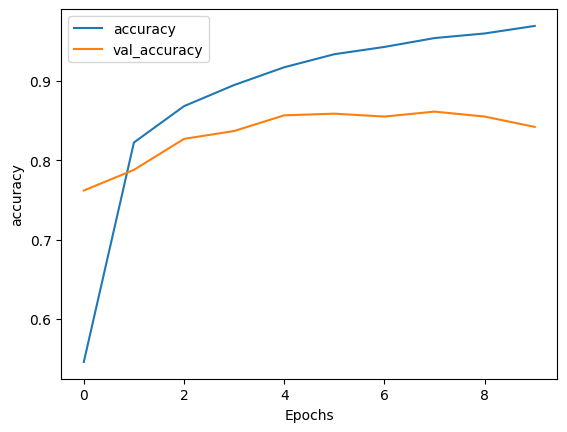

In [29]:
plot_graphs(history, 'accuracy')

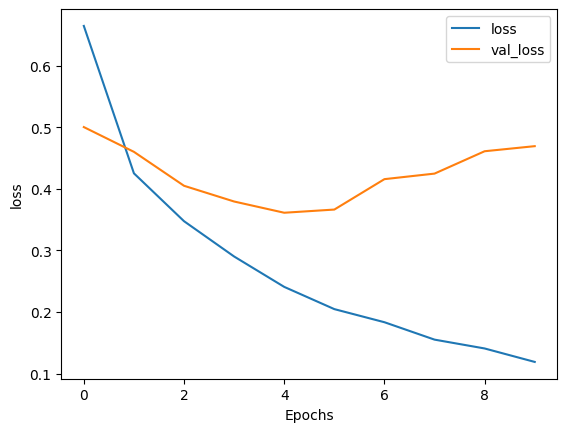

In [30]:
plot_graphs(history, 'loss')

[GRU 레이어](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU)와 같은 기존의 다른 반복 레이어를 확인합니다.

사용자 정의 RNN 작성에 관심이 있는 경우, [Keras RNN 가이드](../../guide/keras/rnn.ipynb)를 참조하세요.
